$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 1: Sequence Models
<a id=part1></a>

In this part we will learn about working with text sequences using recurrent neural networks.
We'll go from a raw text file all the way to a fully trained GRU-RNN model and generate works of art!

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Text generation with a char-level RNN
<a id=part1_1></a>

### Obtaining the corpus
<a id=part1_2></a>

Let's begin by downloading a corpus containing all the works of William Shakespeare.
Since he was very prolific, this corpus is fairly large and will provide us with enough data for
obtaining impressive results.

In [3]:
CORPUS_URL = 'https://github.com/cedricdeboom/character-level-rnn-datasets/raw/master/datasets/shakespeare.txt'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_corpus(out_path=DATA_DIR, url=CORPUS_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    out_filename = os.path.join(out_path, os.path.basename(url))
    
    if os.path.isfile(out_filename) and not force:
        print(f'Corpus file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {out_filename}.')
    return out_filename
    
corpus_path = download_corpus()

Corpus file /home/dana.gershon/.pytorch-datasets/shakespeare.txt exists, skipping download.


Load the text into memory and print a snippet:

In [4]:
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

print(f'Corpus length: {len(corpus)} chars')
print(corpus[7:1234])

Corpus length: 6347703 chars
ALLS WELL THAT ENDS WELL

by William Shakespeare

Dramatis Personae

  KING OF FRANCE
  THE DUKE OF FLORENCE
  BERTRAM, Count of Rousillon
  LAFEU, an old lord
  PAROLLES, a follower of Bertram
  TWO FRENCH LORDS, serving with Bertram

  STEWARD, Servant to the Countess of Rousillon
  LAVACHE, a clown and Servant to the Countess of Rousillon
  A PAGE, Servant to the Countess of Rousillon

  COUNTESS OF ROUSILLON, mother to Bertram
  HELENA, a gentlewoman protected by the Countess
  A WIDOW OF FLORENCE.
  DIANA, daughter to the Widow

  VIOLENTA, neighbour and friend to the Widow
  MARIANA, neighbour and friend to the Widow

  Lords, Officers, Soldiers, etc., French and Florentine  

SCENE:
Rousillon; Paris; Florence; Marseilles

ACT I. SCENE 1.
Rousillon. The COUNT'S palace

Enter BERTRAM, the COUNTESS OF ROUSILLON, HELENA, and LAFEU, all in black

  COUNTESS. In delivering my son from me, I bury a second husband.
  BERTRAM. And I in going, madam, weep o'er

### Data Preprocessing
<a id=part1_3></a>

The first thing we'll need is to map from each unique character in the corpus to an index that will represent it in our learning process.

**TODO**: Implement the `char_maps()` function in the `hw3/charnn.py` module.

In [5]:
import hw3.charnn as charnn

char_to_idx, idx_to_char = charnn.char_maps(corpus)
print(char_to_idx)

test.assertEqual(len(char_to_idx), len(idx_to_char))
test.assertSequenceEqual(list(char_to_idx.keys()), list(idx_to_char.values()))
test.assertSequenceEqual(list(char_to_idx.values()), list(idx_to_char.keys()))

{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '?': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '_': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80, '}': 81, '\ufeff': 82}


Seems we have some strange characters in the corpus that are very rare and are probably due to mistakes.
To reduce the length of each tensor we'll need to later represent our chars, it's best to remove them.

**TODO**: Implement the `remove_chars()` function in the `hw3/charnn.py` module.

In [6]:
corpus, n_removed = charnn.remove_chars(corpus, ['}','$','_','<','\ufeff'])
print(f'Removed {n_removed} chars')

# After removing the chars, re-create the mappings
char_to_idx, idx_to_char = charnn.char_maps(corpus)

Removed 34 chars


The next thing we need is an **embedding** of the chracters.
An embedding is a representation of each token from the sequence as a tensor.
For a char-level RNN, our tokens will be chars and we can thus use the simplest possible embedding: encode each char as a **one-hot** tensor. In other words, each char will be represented
as a tensor whos length is the total number of unique chars (`V`) which contains all zeros except at the index
corresponding to that specific char.

**TODO**: Implement the functions `chars_to_onehot()` and `onehot_to_chars()` in the `hw3/charnn.py` module.

In [7]:
# Wrap the actual embedding functions for calling convenience
def embed(text):
    return charnn.chars_to_onehot(text, char_to_idx)

def unembed(embedding):
    return charnn.onehot_to_chars(embedding, idx_to_char)

text_snippet = corpus[3104:3148]
print(text_snippet)
print(embed(text_snippet[0:3]))

test.assertEqual(text_snippet, unembed(embed(text_snippet)))
test.assertEqual(embed(text_snippet).dtype, torch.int8)

brine a maiden can season her praise in.
   


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=torch.int8)


### Dataset Creation
<a id=part1_4></a>

We wish to train our model to generate text by constantly predicting what the next char should be based on the past.
To that end we'll need to train our recurrent network in a way similar to a classification task. At each timestep, we input a char and set the expected output (label) to be the next char in the original sequence.

We will split our corpus into shorter sequences of length `S` chars (see question below).
Each **sample** we provide our model with will therefore be a tensor of shape `(S,V)` where `V` is the embedding dimension. Our model will operate sequentially on each char in the sequence.
For each sample, we'll also need a **label**. This is simply another sequence, shifted by one char so that the label of each char is the next char in the corpus.

**TODO**: Implement the `chars_to_labelled_samples()` function in the `hw3/charnn.py` module.

In [8]:
# Create dataset of sequences
seq_len = 64
vocab_len = len(char_to_idx)

# Create labelled samples
samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)
print(f'samples shape: {samples.shape}')
print(f'labels shape: {labels.shape}')

# Test shapes
num_samples = (len(corpus) - 1) // seq_len
test.assertEqual(samples.shape, (num_samples, seq_len, vocab_len))
test.assertEqual(labels.shape, (num_samples, seq_len))

# Test content
for _ in range(1000):
    # random sample
    i = np.random.randint(num_samples, size=(1,))[0]
    # Compare to corpus
    test.assertEqual(unembed(samples[i]), corpus[i*seq_len:(i+1)*seq_len], msg=f"content mismatch in sample {i}")
    # Compare to labels
    sample_text = unembed(samples[i])
    label_text = str.join('', [idx_to_char[j.item()] for j in labels[i]])
    test.assertEqual(sample_text[1:], label_text[0:-1], msg=f"label mismatch in sample {i}")

samples shape: torch.Size([99182, 64, 78])
labels shape: torch.Size([99182, 64])


Let's print a few consecutive samples. You should see that the text continues between them.

In [9]:
import re
import random

i = random.randrange(num_samples-5)
for i in range(i, i+5):
    test.assertEqual(len(samples[i]), seq_len)
    s = re.sub(r'\s+', ' ', unembed(samples[i])).strip()
    print(f'sample [{i}]:\n\t{s}')

sample [51378]:
	. How now, spirit! whither wander you? FAIRY. Over hill,
sample [51379]:
	over dale, Thorough bush, thorough brier,
sample [51380]:
	Over park, over pale, Thorough flood, th
sample [51381]:
	orough fire, I do wander every where,
sample [51382]:
	Swifter than the moon's sphere; And I serve the


As usual, instead of feeding one sample at a time into our model's forward we'll work with **batches** of samples. This means that at every timestep, our model will operate on a batch of chars that are from **different sequences**.
Effectively this will allow us to parallelize training our model by dong matrix-matrix multiplications
instead of matrix-vector during the forward pass.

An important nuance is that we need the batches to be **contiguous**, i.e. sample $k$ in batch $j$ should continue sample $k$ from batch $j-1$.
The following figure illustrates this:

<img src="imgs/rnn-batching.png"/>

If we naïvely take consecutive samples into batches, e.g. `[0,1,...,B-1]`, `[B,B+1,...,2B-1]` and so on, we won't have contiguous
sequences at the same index between adjacent batches.

To accomplish this we need to tell our `DataLoader` which samples to combine together into one batch.
We do this by implementing a custom PyTorch `Sampler`, and providing it to our `DataLoader`.

**TODO**: Implement the `SequenceBatchSampler` class in the `hw3/charnn.py` module.

In [10]:
from hw3.charnn import SequenceBatchSampler

sampler = SequenceBatchSampler(dataset=range(32), batch_size=10)
sampler_idx = list(sampler)
print('sampler_idx =\n', sampler_idx)

# Test the Sampler
test.assertEqual(len(sampler_idx), 30)
batch_idx = np.array(sampler_idx).reshape(-1, 10)
for k in range(10):
    test.assertEqual(np.diff(batch_idx[:, k], n=2).item(), 0)

sampler_idx =
 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29]


Even though we're working with sequences, we can still use the standard PyTorch `Dataset`/`DataLoader` combo.
For the dataset we can use a built-in class, `TensorDataset` to return tuples of `(sample, label)`
from the `samples` and `labels` tensors we created above.
The `DataLoader` will be provided with our custom `Sampler` so that it generates appropriate batches.

In [11]:
import torch.utils.data

# Create DataLoader returning batches of samples.
batch_size = 32

ds_corpus = torch.utils.data.TensorDataset(samples, labels)
sampler_corpus = SequenceBatchSampler(ds_corpus, batch_size)
dl_corpus = torch.utils.data.DataLoader(ds_corpus, batch_size=batch_size, sampler=sampler_corpus, shuffle=False)

Let's see what that gives us:

In [12]:
print(f'num batches: {len(dl_corpus)}')

x0, y0 = next(iter(dl_corpus))
print(f'shape of a batch of samples: {x0.shape}')
print(f'shape of a batch of labels: {y0.shape}')

num batches: 3100
shape of a batch of samples: torch.Size([32, 64, 78])
shape of a batch of labels: torch.Size([32, 64])


Now lets look at the same sample index from multiple batches taken from our corpus.

In [13]:
# Check that sentences in in same index of different batches complete each other.
k = random.randrange(batch_size)
for j, (X, y) in enumerate(dl_corpus,):
    print(f'=== batch {j}, sample {k} ({X[k].shape}): ===')
    s = re.sub(r'\s+', ' ', unembed(X[k])).strip()
    print(f'\t{s}')
    if j==4: break

=== batch 0, sample 19 (torch.Size([64, 78])): ===
	her, Though you are old enough to be my heir. What you w
=== batch 1, sample 19 (torch.Size([64, 78])): ===
	ill have, I'll give, and willing too; For do we must what fo
=== batch 2, sample 19 (torch.Size([64, 78])): ===
	rce will have us do. Set on towards London. Cousin, is it so
=== batch 3, sample 19 (torch.Size([64, 78])): ===
	? BOLINGBROKE. Yea, my good lord. KING RICHARD. Then I must
=== batch 4, sample 19 (torch.Size([64, 78])): ===
	not say no. Flourish. Exeunt SCENE 4. The DUKE OF YORK'


### Model Implementation
<a id=part1_5></a>

Finally, our data set is ready so we can focus on our model.

We'll implement here is a multilayer gated recurrent unit (GRU) model, with dropout.
This model is a type of RNN which performs similar to the well-known LSTM model,
but it's somewhat easier to train because it has less parameters.
We'll modify the regular GRU slightly by applying dropout to
the hidden states passed between layers of the model.

The model accepts an input $\mat{X}\in\set{R}^{S\times V}$ containing a sequence of embedded chars.
It returns an output $\mat{Y}\in\set{R}^{S\times V}$ of predictions for the next char and the final hidden state
$\mat{H}\in\set{R}^{L\times H}$. Here $S$ is the sequence length, $V$ is the vocabulary size (number of unique chars), $L$ is the number of layers in the model and $H$ is the hidden dimension.

Mathematically, the model's forward function at layer $k\in[1,L]$ and timestep $t\in[1,S]$ can be described as

$$
\begin{align}
\vec{z_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xz}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hz}}}^{[k]} + \vec{b}_{\mathrm{z}}^{[k]}\right) \\
\vec{r_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xr}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hr}}}^{[k]} + \vec{b}_{\mathrm{r}}^{[k]}\right) \\
\vec{g_t}^{[k]} &= \tanh\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xg}}}^{[k]} +
    (\vec{r_t}^{[k]}\odot\vec{h}_{t-1}^{[k]}) {\mattr{W}_{\mathrm{hg}}}^{[k]} + \vec{b}_{\mathrm{g}}^{[k]}\right) \\
\vec{h_t}^{[k]} &= \vec{z}^{[k]}_t \odot \vec{h}^{[k]}_{t-1} + \left(1-\vec{z}^{[k]}_t\right)\odot \vec{g_t}^{[k]}
\end{align}
$$

The input to each layer is,
$$
\mat{X}^{[k]} =
\begin{bmatrix}
    {\vec{x}_1}^{[k]} \\ \vdots \\ {\vec{x}_S}^{[k]}
\end{bmatrix} 
=
\begin{cases}
    \mat{X} & \mathrm{if} ~k = 1~ \\
    \mathrm{dropout}_p \left(
    \begin{bmatrix}
        {\vec{h}_1}^{[k-1]} \\ \vdots \\ {\vec{h}_S}^{[k-1]}
    \end{bmatrix} \right) & \mathrm{if} ~1 < k \leq L+1~
\end{cases}.
$$

The output of the entire model is then,
$$
\mat{Y} = \mat{X}^{[L+1]} {\mattr{W}_{\mathrm{hy}}} + \mat{B}_{\mathrm{y}}
$$

and the final hidden state is
$$
\mat{H} = 
\begin{bmatrix}
    {\vec{h}_S}^{[1]} \\ \vdots \\ {\vec{h}_S}^{[L]}
\end{bmatrix}.
$$

Notes:
- $t\in[1,S]$ is the timestep, i.e. the current position within the sequence of each sample.
- $\vec{x}_t^{[k]}$ is the input of layer $k$ at timestep $t$, respectively.
- The outputs of the **last layer** $\vec{y}_t^{[L]}$, are the predicted next characters for every input char.
  These are similar to class scores in classification tasks.
- The hidden states at the **last timestep**, $\vec{h}_S^{[k]}$, are the final hidden state returned from the model.
- $\sigma(\cdot)$ is the sigmoid function, i.e. $\sigma(\vec{z}) = 1/(1+e^{-\vec{z}})$ which returns values in $(0,1)$.
- $\tanh(\cdot)$ is the hyperbolic tangent, i.e. $\tanh(\vec{z}) = (e^{2\vec{z}}-1)/(e^{2\vec{z}}+1)$ which returns values in $(-1,1)$.
- $\vec{h_t}^{[k]}$ is the hidden state of layer $k$ at time $t$. This can be thought of as the memory of that layer.
- $\vec{g_t}^{[k]}$ is the candidate hidden state for time $t+1$.
- $\vec{z_t}^{[k]}$ is known as the update gate. It combines the previous state with the input to determine how much the current state will be combined with the new candidate state. For example, if $\vec{z_t}^{[k]}=\vec{1}$ then the current input has no effect on the output.
- $\vec{r_t}^{[k]}$ is known as the reset gate. It combines the previous state with the input to determine how much of the previous state will affect the current state candidate. For example if $\vec{r_t}^{[k]}=\vec{0}$ the previous state has no effect on the current candidate state.

Here's a graphical representation of the GRU's forward pass at each timestep. The $\vec{\tilde{h}}$ in the image is our $\vec{g}$ (candidate next state).

<img src="imgs/gru_cell.png" width="400"/>

You can see how the reset and update gates allow the model to completely ignore it's previous state, completely ignore it's input, or any mixture of those states (since the gates are actually continuous and between $(0,1)$).

Here's a graphical representation of the entire model.
You can ignore the $c_t^{[k]}$ (cell state) variables (which are relevant for LSTM models).
Our model has only the hidden state, $h_t^{[k]}$. Also notice that we added dropout between layers (i.e., on the up arrows).

<img src="imgs/lstm_model.png" />

The purple tensors are inputs (a sequence and initial hidden state per layer), and the green tensors are outputs (another sequence and final hidden state per layer). Each blue block implements the above forward equations.
Blocks that are on the same vertical level are at the same layer, and therefore share parameters.

**TODO**:implement `MultilayerGRU` class in the `hw3/charnn.py` module.


Notes:
- We use **batches** now.
  The math is identical to the above, but all the tensors will have an extra batch 
  dimension as their first dimension.
- Before you read the implementation, read the diagram above, try to understand all the dimentions.


In [14]:
in_dim = vocab_len
h_dim = 256
n_layers = 3
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers)
model = model.to(device)
print(model)

# Test forward pass
y, h = model(x0.to(dtype=torch.float, device=device))
print(f'y.shape={y.shape}')
print(f'h.shape={h.shape}')

test.assertEqual(y.shape, (batch_size, seq_len, vocab_len))
test.assertEqual(h.shape, (batch_size, n_layers, h_dim))
test.assertEqual(len(list(model.parameters())), 9 * n_layers + 2) 

MultilayerGRU(
  (layer_0_wxz): Linear(in_features=78, out_features=256, bias=False)
  (layer_0_whz): Linear(in_features=256, out_features=256, bias=True)
  (layer_0_wxr): Linear(in_features=78, out_features=256, bias=False)
  (layer_0_whr): Linear(in_features=256, out_features=256, bias=True)
  (layer_0_wxg): Linear(in_features=78, out_features=256, bias=False)
  (layer_0_whg): Linear(in_features=256, out_features=256, bias=True)
  (layer_1_wxz): Linear(in_features=256, out_features=256, bias=False)
  (layer_1_whz): Linear(in_features=256, out_features=256, bias=True)
  (layer_1_wxr): Linear(in_features=256, out_features=256, bias=False)
  (layer_1_whr): Linear(in_features=256, out_features=256, bias=True)
  (layer_1_wxg): Linear(in_features=256, out_features=256, bias=False)
  (layer_1_whg): Linear(in_features=256, out_features=256, bias=True)
  (layer_2_wxz): Linear(in_features=256, out_features=256, bias=False)
  (layer_2_whz): Linear(in_features=256, out_features=256, bias=True)
 

y.shape=torch.Size([32, 64, 78])
h.shape=torch.Size([32, 3, 256])


### Generating text by sampling
<a id=part1_6></a>

Now that we have a model, we can implement **text generation** based on it.
The idea is simple:
At each timestep our model receives one char $x_t$ from the input sequence and outputs scores $y_t$
for what the next char should be.
We'll convert these scores into a probability over each of the possible chars.
In other words, for each input char $x_t$ we create a probability distribution for the next char
conditioned on the current one and the state of the model (representing all previous inputs):
$$p(x_{t+1}|x_t, \vec{h}_t).$$

Once we have such a distribution, we'll sample a char from it.
This will be the first char of our generated sequence.
Now we can feed this new char into the model, create another distribution, sample the next char and so on.
Note that it's crucial to propagate the hidden state when sampling.

The important point however is how to create the distribution from the scores.
One way, as we saw in previous ML tasks, is to use the softmax function.
However, a drawback of softmax is that it can generate very diffuse (more uniform) distributions if the score values are very similar. When sampling, we would prefer to control the distributions and make them less uniform to increase the chance of sampling the char(s) with the highest scores compared to the others.

To control the variance of the distribution, a common trick is to add a hyperparameter $T$, known as the 
*temperature* to the softmax function. The class scores are simply scaled by $T$ before softmax is applied:
$$
\mathrm{softmax}_T(\vec{y}) = \frac{e^{\vec{y}/T}}{\sum_k e^{y_k/T}}
$$

A low $T$ will result in less uniform distributions and vice-versa.

**TODO**: Implement the `hot_softmax()` function in the `hw3/charnn.py` module.

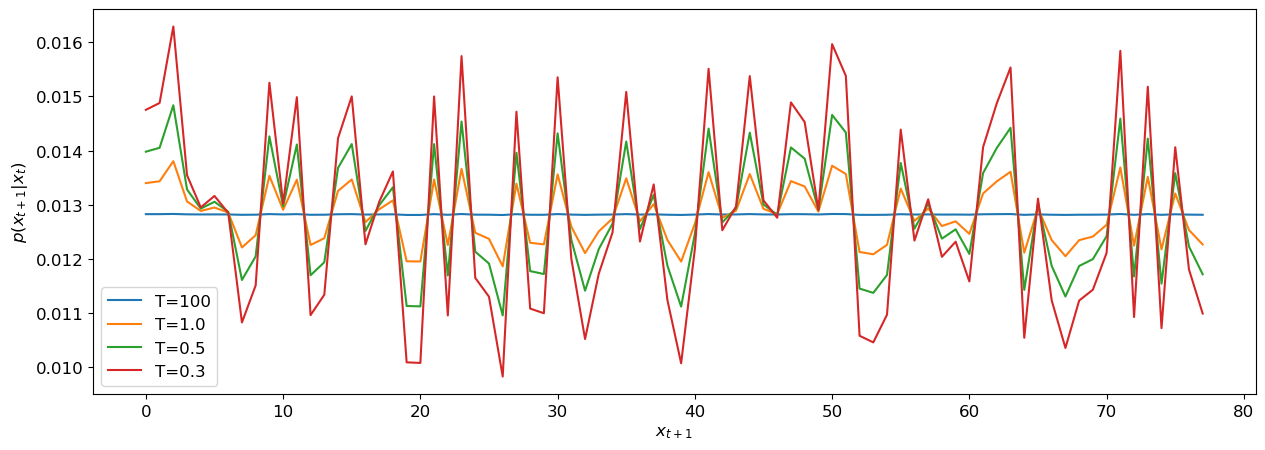

In [15]:
scores = y[0,0,:].detach()
_, ax = plt.subplots(figsize=(15,5))

for t in reversed([0.3, 0.5, 1.0, 100]):
    ax.plot(charnn.hot_softmax(scores, temperature=t).cpu().numpy(), label=f'T={t}')
ax.set_xlabel('$x_{t+1}$')
ax.set_ylabel('$p(x_{t+1}|x_t)$')
ax.legend()

uniform_proba = 1/len(char_to_idx)
uniform_diff = torch.abs(charnn.hot_softmax(scores, temperature=100) - uniform_proba)
test.assertTrue(torch.all(uniform_diff < 1e-4))

**TODO**: Implement the `generate_from_model()` function in the `hw3/charnn.py` module.

In [16]:
for _ in range(3):
    text = charnn.generate_from_model(model, "foobar", 50, (char_to_idx, idx_to_char), T=0.5)
    print(text)
    test.assertEqual(len(text), 50)

foobarO8S!Isbv.KV4u63Q e?MuJ;54Q6n:41WONQND,qr?"]c
foobar[-jRVAZ:p0)If6D4 Xx2hV457k7M.Av9O25(Y.[Kd2BW


foobarRk7o7aej;S OCfp(?f:dIGk8U:]RU(bb
O:0"g-(Laza


### Training
<a id=part1_7></a>

To train this model, we'll calculate the loss at each time step by comparing the predicted char to
the actual char from our label. We can use cross entropy since per char it's similar to a classification problem.
We'll then sum the losses over the sequence and back-propagate the gradients though time.
Notice that the back-propagation algorithm will "visit" each layer's parameter tensors multiple times,
so we'll accumulate gradients in parameters of the blocks. Luckily `autograd` will handle this part for us.

As usual, the first step of training will be to try and **overfit** a large model (many parameters) to a tiny dataset.
Again, this is to ensure the model and training code are implemented correctly, i.e. that the model can learn.

For a generative model such as this, overfitting is slightly trickier than for classification.
What we'll aim to do is to get our model to **memorize** a specific sequence of chars, so that when given the first
char in the sequence it will immediately spit out the rest of the sequence verbatim.

Let's create a tiny dataset to memorize.

In [17]:
# Pick a tiny subset of the dataset
subset_start, subset_end = 1001, 1005
ds_corpus_ss = torch.utils.data.Subset(ds_corpus, range(subset_start, subset_end))
batch_size_ss = 1
sampler_ss = SequenceBatchSampler(ds_corpus_ss, batch_size=batch_size_ss)
dl_corpus_ss = torch.utils.data.DataLoader(ds_corpus_ss, batch_size_ss, sampler=sampler_ss, shuffle=False)

# Convert subset to text
subset_text = ''
for i in range(subset_end - subset_start):
    subset_text += unembed(ds_corpus_ss[i][0])
print(f'Text to "memorize":\n\n{subset_text}')

Text to "memorize":

TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


Now let's implement the first part of our training code.

**TODO**: Implement the `train_epoch()` and `train_batch()` methods of the `RNNTrainer` class in the `hw3/training.py` module. 
You must think about how to correctly handle the hidden state of the model between batches and epochs for this specific task (i.e. text generation).

In [18]:
import torch.nn as nn
import torch.optim as optim
from hw3.training import RNNTrainer

torch.manual_seed(42)

lr = 0.01
num_epochs = 500

in_dim = vocab_len
h_dim = 128
n_layers = 2
loss_fn = nn.CrossEntropyLoss()
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

for epoch in range(num_epochs):
    epoch_result = trainer.train_epoch(dl_corpus_ss, verbose=False)
    
    # Every X epochs, we'll generate a sequence starting from the first char in the first sequence
    # to visualize how/if/what the model is learning.
    if epoch == 0 or (epoch+1) % 25 == 0:
        avg_loss = np.mean(epoch_result.losses)
        accuracy = np.mean(epoch_result.accuracy)
        print(f'\nEpoch #{epoch+1}: Avg. loss = {avg_loss:.3f}, Accuracy = {accuracy:.2f}%')
        
        generated_sequence = charnn.generate_from_model(model, subset_text[0],
                                                        seq_len*(subset_end-subset_start),
                                                        (char_to_idx,idx_to_char), T=0.1)
        
        # Stop if we've successfully memorized the small dataset.
        print(generated_sequence)
        if generated_sequence == subset_text:
            break

# Test successful overfitting
test.assertGreater(epoch_result.accuracy, 99)
test.assertEqual(generated_sequence, subset_text)


Epoch #1: Avg. loss = 3.940, Accuracy = 17.58%


Twn                                               n                                                                                                                                                                                                             



Epoch #25: Avg. loss = 0.290, Accuracy = 94.53%


TRAM. What would you have?
  HELENA. Something; anderce so much; nothing, indeed.
    Faith, yes:
    Faith, yes:
    Faith, yes:
    Faith, yes:
    Faith, yes:
    Faith, yes:
    Faith, yes:
    Faith, yes:
    Fait, yes:
    Faith, yes:
    Faith, yes:



Epoch #50: Avg. loss = 0.008, Accuracy = 100.00%


TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


OK, so training works - we can memorize a short sequence.
We'll now train a much larger model on our large dataset. You'll need a GPU for this part.

First, lets set up our dataset and models for training.
We'll split our corpus into 90% train and 10% test-set.
Also, we'll use a learning-rate scheduler to control the learning rate during training.

**TODO**: Set the hyperparameters in the `part1_rnn_hyperparams()` function of the `hw3/answers.py` module.

In [19]:
from hw3.answers import part1_rnn_hyperparams

hp = part1_rnn_hyperparams()
print('hyperparams:\n', hp)

### Dataset definition
vocab_len = len(char_to_idx)
batch_size = hp['batch_size']
seq_len = hp['seq_len']
train_test_ratio = 0.9
num_samples = (len(corpus) - 1) // seq_len
num_train = int(train_test_ratio * num_samples)

samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)

ds_train = torch.utils.data.TensorDataset(samples[:num_train], labels[:num_train])
sampler_train = SequenceBatchSampler(ds_train, batch_size)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False, sampler=sampler_train, drop_last=True)

ds_test = torch.utils.data.TensorDataset(samples[num_train:], labels[num_train:])
sampler_test = SequenceBatchSampler(ds_test, batch_size)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, sampler=sampler_test, drop_last=True)

print(f'Train: {len(dl_train):3d} batches, {len(dl_train)*batch_size*seq_len:7d} chars')
print(f'Test:  {len(dl_test):3d} batches, {len(dl_test)*batch_size*seq_len:7d} chars')

### Training definition
in_dim = out_dim = vocab_len
checkpoint_file = 'checkpoints/rnn'
num_epochs = 50
early_stopping = 5

model = charnn.MultilayerGRU(in_dim, hp['h_dim'], out_dim, hp['n_layers'], hp['dropout'])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hp['learn_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=hp['lr_sched_factor'], patience=hp['lr_sched_patience'], verbose=True
)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

hyperparams:
 {'batch_size': 512, 'seq_len': 64, 'h_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'learn_rate': 0.002, 'lr_sched_factor': 0.1, 'lr_sched_patience': 3}


Train: 174 batches, 5701632 chars
Test:   19 batches,  622592 chars


The code blocks below will train the model and save checkpoints containing the training state and the best model parameters to a file. This allows you to stop training and resume it later from where you left.

Note that you can use the `main.py` script provided within the assignment folder to run this notebook from the command line as if it were a python script by using the `run-nb` subcommand. This allows you to train your model using this notebook without starting jupyter. You can combine this with `srun` or `sbatch` to run the notebook with a GPU on the course servers.

**TODO**:
- Implement the `fit()` method of the `Trainer` class. You can reuse the relevant implementation parts from HW2, but make sure to implement early stopping and checkpoints.
- Implement the `test_epoch()` and `test_batch()` methods of the `RNNTrainer` class in the `hw3/training.py` module.
- Run the following block to train.
- When training is done and you're satisfied with the model's outputs, rename the checkpoint file to `checkpoints/rnn_final.pt`.
  This will cause the block to skip training and instead load your saved model when running the homework submission script.
  Note that your submission zip file will not include the checkpoint file. This is OK.

ACT I.UjxBSf:OR7cnol.Z;;&A0dVJj2.:4TJuER;,hD4s?DbaRoT;vDNqM
cD&wCj1U1a]xM&MxZT3go.&I M].t &p7.
Z:0yN
--- EPOCH 1/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (4.384):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (4.384):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (4.327):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (4.327):   1%|          | 2/174 [00:00<00:31,  5.42it/s]

train_batch (4.261):   1%|          | 2/174 [00:00<00:31,  5.42it/s]

train_batch (4.261):   2%|▏         | 3/174 [00:00<00:30,  5.66it/s]

train_batch (4.175):   2%|▏         | 3/174 [00:00<00:30,  5.66it/s]

train_batch (4.175):   2%|▏         | 4/174 [00:00<00:29,  5.77it/s]

train_batch (4.028):   2%|▏         | 4/174 [00:00<00:29,  5.77it/s]

train_batch (4.028):   3%|▎         | 5/174 [00:00<00:28,  5.84it/s]

train_batch (3.793):   3%|▎         | 5/174 [00:01<00:28,  5.84it/s]

train_batch (3.793):   3%|▎         | 6/174 [00:01<00:28,  5.88it/s]

train_batch (3.501):   3%|▎         | 6/174 [00:01<00:28,  5.88it/s]

train_batch (3.501):   4%|▍         | 7/174 [00:01<00:28,  5.91it/s]

train_batch (3.453):   4%|▍         | 7/174 [00:01<00:28,  5.91it/s]

train_batch (3.453):   5%|▍         | 8/174 [00:01<00:28,  5.90it/s]

train_batch (3.436):   5%|▍         | 8/174 [00:01<00:28,  5.90it/s]

train_batch (3.436):   5%|▌         | 9/174 [00:01<00:27,  5.90it/s]

train_batch (3.421):   5%|▌         | 9/174 [00:01<00:27,  5.90it/s]

train_batch (3.421):   6%|▌         | 10/174 [00:01<00:27,  5.91it/s]

train_batch (3.324):   6%|▌         | 10/174 [00:01<00:27,  5.91it/s]

train_batch (3.324):   6%|▋         | 11/174 [00:01<00:27,  5.91it/s]

train_batch (3.287):   6%|▋         | 11/174 [00:02<00:27,  5.91it/s]

train_batch (3.287):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (3.297):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (3.297):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (3.286):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (3.286):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (3.305):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (3.305):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (3.295):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (3.295):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (3.278):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (3.278):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (3.265):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (3.265):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (3.243):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (3.243):  11%|█         | 19/174 [00:03<00:26,  5.95it/s]

train_batch (3.232):  11%|█         | 19/174 [00:03<00:26,  5.95it/s]

train_batch (3.232):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (3.224):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (3.224):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (3.219):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (3.219):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (3.220):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (3.220):  13%|█▎        | 23/174 [00:03<00:25,  5.96it/s]

train_batch (3.236):  13%|█▎        | 23/174 [00:04<00:25,  5.96it/s]

train_batch (3.236):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (3.228):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (3.228):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (3.208):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (3.208):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (3.197):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (3.197):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (3.195):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (3.195):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (3.200):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (3.200):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (3.203):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (3.203):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (3.192):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (3.192):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (3.175):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (3.175):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (3.187):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (3.187):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (3.186):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (3.186):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (3.184):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (3.184):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (3.175):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (3.175):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (3.161):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (3.161):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (3.172):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (3.172):  22%|██▏       | 38/174 [00:06<00:22,  5.98it/s]

train_batch (3.165):  22%|██▏       | 38/174 [00:06<00:22,  5.98it/s]

train_batch (3.165):  22%|██▏       | 39/174 [00:06<00:22,  5.98it/s]

train_batch (3.154):  22%|██▏       | 39/174 [00:06<00:22,  5.98it/s]

train_batch (3.154):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (3.163):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (3.163):  24%|██▎       | 41/174 [00:06<00:22,  5.95it/s]

train_batch (3.144):  24%|██▎       | 41/174 [00:07<00:22,  5.95it/s]

train_batch (3.144):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (3.151):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (3.151):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (3.150):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (3.150):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (3.138):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (3.138):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (3.138):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (3.138):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (3.126):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (3.126):  27%|██▋       | 47/174 [00:07<00:21,  5.96it/s]

train_batch (3.138):  27%|██▋       | 47/174 [00:08<00:21,  5.96it/s]

train_batch (3.138):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (3.142):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (3.142):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (3.148):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (3.148):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (3.125):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (3.125):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (3.133):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (3.133):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (3.099):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (3.099):  30%|███       | 53/174 [00:08<00:20,  5.97it/s]

train_batch (3.112):  30%|███       | 53/174 [00:09<00:20,  5.97it/s]

train_batch (3.112):  31%|███       | 54/174 [00:09<00:20,  5.98it/s]

train_batch (3.090):  31%|███       | 54/174 [00:09<00:20,  5.98it/s]

train_batch (3.090):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (3.092):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (3.092):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (3.075):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (3.075):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (3.074):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (3.074):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (3.082):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (3.082):  34%|███▍      | 59/174 [00:09<00:19,  5.94it/s]

train_batch (3.044):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (3.044):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (3.054):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (3.054):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (3.056):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (3.056):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (3.028):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (3.028):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (3.022):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (3.022):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (2.993):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (2.993):  37%|███▋      | 65/174 [00:10<00:18,  5.97it/s]

train_batch (3.007):  37%|███▋      | 65/174 [00:11<00:18,  5.97it/s]

train_batch (3.007):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (2.992):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (2.992):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (2.976):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (2.976):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (2.954):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (2.954):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (2.954):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (2.954):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (2.928):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (2.928):  41%|████      | 71/174 [00:11<00:17,  5.97it/s]

train_batch (2.918):  41%|████      | 71/174 [00:12<00:17,  5.97it/s]

train_batch (2.918):  41%|████▏     | 72/174 [00:12<00:17,  5.93it/s]

train_batch (2.904):  41%|████▏     | 72/174 [00:12<00:17,  5.93it/s]

train_batch (2.904):  42%|████▏     | 73/174 [00:12<00:16,  5.94it/s]

train_batch (2.875):  42%|████▏     | 73/174 [00:12<00:16,  5.94it/s]

train_batch (2.875):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (2.876):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (2.876):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (2.867):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (2.867):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (2.845):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (2.845):  44%|████▍     | 77/174 [00:12<00:16,  5.97it/s]

train_batch (2.837):  44%|████▍     | 77/174 [00:13<00:16,  5.97it/s]

train_batch (2.837):  45%|████▍     | 78/174 [00:13<00:16,  5.97it/s]

train_batch (2.826):  45%|████▍     | 78/174 [00:13<00:16,  5.97it/s]

train_batch (2.826):  45%|████▌     | 79/174 [00:13<00:15,  5.98it/s]

train_batch (2.801):  45%|████▌     | 79/174 [00:13<00:15,  5.98it/s]

train_batch (2.801):  46%|████▌     | 80/174 [00:13<00:15,  5.98it/s]

train_batch (2.777):  46%|████▌     | 80/174 [00:13<00:15,  5.98it/s]

train_batch (2.777):  47%|████▋     | 81/174 [00:13<00:15,  5.98it/s]

train_batch (2.750):  47%|████▋     | 81/174 [00:13<00:15,  5.98it/s]

train_batch (2.750):  47%|████▋     | 82/174 [00:13<00:15,  5.97it/s]

train_batch (2.754):  47%|████▋     | 82/174 [00:13<00:15,  5.97it/s]

train_batch (2.754):  48%|████▊     | 83/174 [00:13<00:15,  5.97it/s]

train_batch (2.736):  48%|████▊     | 83/174 [00:14<00:15,  5.97it/s]

train_batch (2.736):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (2.726):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (2.726):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (2.694):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (2.694):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (2.688):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (2.688):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (2.677):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (2.677):  51%|█████     | 88/174 [00:14<00:14,  5.93it/s]

train_batch (2.654):  51%|█████     | 88/174 [00:14<00:14,  5.93it/s]

train_batch (2.654):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (2.662):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (2.662):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (2.652):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (2.652):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (2.632):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (2.632):  53%|█████▎    | 92/174 [00:15<00:13,  5.98it/s]

train_batch (2.622):  53%|█████▎    | 92/174 [00:15<00:13,  5.98it/s]

train_batch (2.622):  53%|█████▎    | 93/174 [00:15<00:15,  5.23it/s]

train_batch (2.606):  53%|█████▎    | 93/174 [00:15<00:15,  5.23it/s]

train_batch (2.606):  54%|█████▍    | 94/174 [00:15<00:14,  5.43it/s]

train_batch (2.599):  54%|█████▍    | 94/174 [00:16<00:14,  5.43it/s]

train_batch (2.599):  55%|█████▍    | 95/174 [00:16<00:14,  5.58it/s]

train_batch (2.583):  55%|█████▍    | 95/174 [00:16<00:14,  5.58it/s]

train_batch (2.583):  55%|█████▌    | 96/174 [00:16<00:13,  5.70it/s]

train_batch (2.574):  55%|█████▌    | 96/174 [00:16<00:13,  5.70it/s]

train_batch (2.574):  56%|█████▌    | 97/174 [00:16<00:13,  5.78it/s]

train_batch (2.567):  56%|█████▌    | 97/174 [00:16<00:13,  5.78it/s]

train_batch (2.567):  56%|█████▋    | 98/174 [00:16<00:13,  5.84it/s]

train_batch (2.547):  56%|█████▋    | 98/174 [00:16<00:13,  5.84it/s]

train_batch (2.547):  57%|█████▋    | 99/174 [00:16<00:12,  5.85it/s]

train_batch (2.544):  57%|█████▋    | 99/174 [00:16<00:12,  5.85it/s]

train_batch (2.544):  57%|█████▋    | 100/174 [00:16<00:12,  5.89it/s]

train_batch (2.540):  57%|█████▋    | 100/174 [00:17<00:12,  5.89it/s]

train_batch (2.540):  58%|█████▊    | 101/174 [00:17<00:12,  5.91it/s]

train_batch (2.503):  58%|█████▊    | 101/174 [00:17<00:12,  5.91it/s]

train_batch (2.503):  59%|█████▊    | 102/174 [00:17<00:12,  5.93it/s]

train_batch (2.510):  59%|█████▊    | 102/174 [00:17<00:12,  5.93it/s]

train_batch (2.510):  59%|█████▉    | 103/174 [00:17<00:11,  5.92it/s]

train_batch (2.492):  59%|█████▉    | 103/174 [00:17<00:11,  5.92it/s]

train_batch (2.492):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (2.492):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (2.492):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (2.472):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (2.472):  61%|██████    | 106/174 [00:17<00:11,  5.93it/s]

train_batch (2.474):  61%|██████    | 106/174 [00:18<00:11,  5.93it/s]

train_batch (2.474):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (2.469):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (2.469):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (2.472):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (2.472):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (2.446):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (2.446):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (2.453):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (2.453):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (2.459):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (2.459):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (2.446):  64%|██████▍   | 112/174 [00:19<00:10,  5.96it/s]

train_batch (2.446):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (2.430):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (2.430):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (2.436):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (2.436):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (2.419):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (2.419):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (2.415):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (2.415):  67%|██████▋   | 117/174 [00:19<00:09,  5.94it/s]

train_batch (2.390):  67%|██████▋   | 117/174 [00:19<00:09,  5.94it/s]

train_batch (2.390):  68%|██████▊   | 118/174 [00:19<00:09,  5.94it/s]

train_batch (2.394):  68%|██████▊   | 118/174 [00:20<00:09,  5.94it/s]

train_batch (2.394):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (2.376):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (2.376):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (2.387):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (2.387):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (2.391):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (2.391):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (2.377):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (2.377):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (2.346):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (2.346):  71%|███████▏  | 124/174 [00:20<00:08,  5.95it/s]

train_batch (2.373):  71%|███████▏  | 124/174 [00:21<00:08,  5.95it/s]

train_batch (2.373):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (2.367):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (2.367):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (2.342):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (2.342):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (2.327):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (2.327):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (2.329):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (2.329):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (2.330):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (2.330):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (2.330):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (2.330):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (2.327):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (2.327):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (2.299):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (2.299):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (2.308):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (2.308):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (2.303):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (2.303):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (2.299):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (2.299):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (2.286):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (2.286):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (2.292):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (2.292):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (2.291):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (2.291):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (2.268):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (2.268):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (2.273):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (2.273):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (2.270):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (2.270):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (2.267):  82%|████████▏ | 142/174 [00:24<00:05,  5.97it/s]

train_batch (2.267):  82%|████████▏ | 143/174 [00:24<00:05,  5.97it/s]

train_batch (2.248):  82%|████████▏ | 143/174 [00:24<00:05,  5.97it/s]

train_batch (2.248):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (2.259):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (2.259):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (2.271):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (2.271):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (2.250):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (2.250):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (2.240):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (2.240):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (2.259):  85%|████████▌ | 148/174 [00:25<00:04,  5.96it/s]

train_batch (2.259):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (2.262):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (2.262):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (2.238):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (2.238):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (2.249):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (2.249):  87%|████████▋ | 152/174 [00:25<00:03,  5.97it/s]

train_batch (2.226):  87%|████████▋ | 152/174 [00:25<00:03,  5.97it/s]

train_batch (2.226):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (2.229):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (2.229):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (2.223):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (2.223):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (2.225):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (2.225):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (2.214):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (2.214):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (2.223):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (2.223):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (2.193):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (2.193):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (2.224):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (2.224):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (2.212):  92%|█████████▏| 160/174 [00:27<00:02,  5.97it/s]

train_batch (2.212):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (2.224):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (2.224):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (2.196):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (2.196):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (2.181):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (2.181):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (2.205):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (2.205):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (2.196):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (2.196):  95%|█████████▌| 166/174 [00:27<00:01,  5.95it/s]

train_batch (2.171):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (2.171):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (2.169):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (2.169):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (2.176):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (2.176):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (2.183):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (2.183):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (2.177):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (2.177):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (2.160):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (2.160):  99%|█████████▉| 172/174 [00:28<00:00,  5.97it/s]

train_batch (2.178):  99%|█████████▉| 172/174 [00:29<00:00,  5.97it/s]

train_batch (2.178):  99%|█████████▉| 173/174 [00:29<00:00,  5.97it/s]

train_batch (2.174):  99%|█████████▉| 173/174 [00:29<00:00,  5.97it/s]

train_batch (2.174): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 2.763, Accuracy 28.9): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 2.763, Accuracy 28.9): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (2.380):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (2.362):   5%|▌         | 1/19 [00:00<00:02,  8.76it/s]

test_batch (2.362):  11%|█         | 2/19 [00:00<00:00, 17.44it/s]

test_batch (2.359):  11%|█         | 2/19 [00:00<00:00, 17.44it/s]

test_batch (2.376):  16%|█▌        | 3/19 [00:00<00:00, 17.44it/s]

test_batch (2.376):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (2.364):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (2.366):  26%|██▋       | 5/19 [00:00<00:00, 17.33it/s]

test_batch (2.366):  32%|███▏      | 6/19 [00:00<00:00, 17.31it/s]

test_batch (2.361):  32%|███▏      | 6/19 [00:00<00:00, 17.31it/s]

test_batch (2.362):  37%|███▋      | 7/19 [00:00<00:00, 17.31it/s]

test_batch (2.362):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (2.363):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (2.370):  47%|████▋     | 9/19 [00:00<00:00, 17.29it/s]

test_batch (2.370):  53%|█████▎    | 10/19 [00:00<00:00, 17.19it/s]

test_batch (2.362):  53%|█████▎    | 10/19 [00:00<00:00, 17.19it/s]

test_batch (2.357):  58%|█████▊    | 11/19 [00:00<00:00, 17.19it/s]

test_batch (2.357):  63%|██████▎   | 12/19 [00:00<00:00, 17.19it/s]

test_batch (2.365):  63%|██████▎   | 12/19 [00:00<00:00, 17.19it/s]

test_batch (2.359):  68%|██████▊   | 13/19 [00:00<00:00, 17.19it/s]

test_batch (2.359):  74%|███████▎  | 14/19 [00:00<00:00, 17.19it/s]

test_batch (2.358):  74%|███████▎  | 14/19 [00:00<00:00, 17.19it/s]

test_batch (2.355):  79%|███████▉  | 15/19 [00:00<00:00, 17.19it/s]

test_batch (2.355):  84%|████████▍ | 16/19 [00:00<00:00, 17.21it/s]

test_batch (2.364):  84%|████████▍ | 16/19 [00:00<00:00, 17.21it/s]

test_batch (2.375):  89%|████████▉ | 17/19 [00:01<00:00, 17.21it/s]

test_batch (2.375):  95%|█████████▍| 18/19 [00:01<00:00, 17.24it/s]

test_batch (2.345):  95%|█████████▍| 18/19 [00:01<00:00, 17.24it/s]

test_batch (Avg. Loss 2.363, Accuracy 33.0): 100%|██████████| 19/19 [00:01<00:00, 17.24it/s]

test_batch (Avg. Loss 2.363, Accuracy 33.0): 100%|██████████| 19/19 [00:01<00:00, 17.19it/s]

*** Saved checkpoint checkpoints/rnn.pt at epoch 1


ACT I. Whit and thas that he chand this mish and the the fort in than fort the to pour and I
       
--- EPOCH 2/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (2.179):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (2.179):   1%|          | 1/174 [00:00<00:29,  5.87it/s]

train_batch (2.176):   1%|          | 1/174 [00:00<00:29,  5.87it/s]

train_batch (2.176):   1%|          | 2/174 [00:00<00:29,  5.89it/s]

train_batch (2.173):   1%|          | 2/174 [00:00<00:29,  5.89it/s]

train_batch (2.173):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (2.170):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (2.170):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (2.158):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (2.158):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (2.148):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (2.148):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (2.145):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (2.145):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (2.155):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (2.155):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (2.147):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (2.147):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (2.158):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (2.158):   6%|▌         | 10/174 [00:01<00:27,  5.98it/s]

train_batch (2.150):   6%|▌         | 10/174 [00:01<00:27,  5.98it/s]

train_batch (2.150):   6%|▋         | 11/174 [00:01<00:27,  5.98it/s]

train_batch (2.149):   6%|▋         | 11/174 [00:02<00:27,  5.98it/s]

train_batch (2.149):   7%|▋         | 12/174 [00:02<00:27,  5.97it/s]

train_batch (2.156):   7%|▋         | 12/174 [00:02<00:27,  5.97it/s]

train_batch (2.156):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (2.149):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (2.149):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (2.134):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (2.134):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (2.133):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (2.133):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (2.117):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (2.117):  10%|▉         | 17/174 [00:02<00:26,  5.97it/s]

train_batch (2.128):  10%|▉         | 17/174 [00:03<00:26,  5.97it/s]

train_batch (2.128):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (2.118):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (2.118):  11%|█         | 19/174 [00:03<00:25,  5.96it/s]

train_batch (2.120):  11%|█         | 19/174 [00:03<00:25,  5.96it/s]

train_batch (2.120):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (2.116):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (2.116):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (2.114):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (2.114):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (2.112):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (2.112):  13%|█▎        | 23/174 [00:03<00:25,  5.97it/s]

train_batch (2.125):  13%|█▎        | 23/174 [00:04<00:25,  5.97it/s]

train_batch (2.125):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (2.114):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (2.114):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (2.100):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (2.100):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (2.089):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (2.089):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (2.082):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (2.082):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (2.100):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (2.100):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (2.109):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (2.109):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (2.105):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (2.105):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (2.086):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (2.086):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (2.101):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (2.101):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (2.099):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (2.099):  20%|█▉        | 34/174 [00:05<00:23,  5.92it/s]

train_batch (2.114):  20%|█▉        | 34/174 [00:05<00:23,  5.92it/s]

train_batch (2.114):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (2.098):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (2.098):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (2.092):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (2.092):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (2.099):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (2.099):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (2.087):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (2.087):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (2.068):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (2.068):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (2.085):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (2.085):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (2.074):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (2.074):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (2.080):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (2.080):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (2.079):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (2.079):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (2.069):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (2.069):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (2.081):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (2.081):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (2.064):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (2.064):  27%|██▋       | 47/174 [00:07<00:21,  5.94it/s]

train_batch (2.073):  27%|██▋       | 47/174 [00:08<00:21,  5.94it/s]

train_batch (2.073):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (2.069):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (2.069):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (2.088):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (2.088):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (2.068):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (2.068):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (2.073):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (2.073):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (2.049):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (2.049):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (2.069):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (2.069):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (2.055):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (2.055):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (2.055):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (2.055):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (2.044):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (2.044):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (2.054):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (2.054):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (2.053):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (2.053):  34%|███▍      | 59/174 [00:09<00:19,  5.97it/s]

train_batch (2.027):  34%|███▍      | 59/174 [00:10<00:19,  5.97it/s]

train_batch (2.027):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (2.032):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (2.032):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (2.055):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (2.055):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (2.036):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (2.036):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (2.033):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (2.033):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (2.025):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (2.025):  37%|███▋      | 65/174 [00:10<00:18,  5.96it/s]

train_batch (2.047):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (2.047):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (2.020):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (2.020):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (2.031):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (2.031):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (2.033):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (2.033):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (2.031):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (2.031):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (2.019):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (2.019):  41%|████      | 71/174 [00:11<00:17,  5.97it/s]

train_batch (2.029):  41%|████      | 71/174 [00:12<00:17,  5.97it/s]

train_batch (2.029):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (2.019):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (2.019):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (2.017):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (2.017):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (2.029):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (2.029):  43%|████▎     | 75/174 [00:12<00:16,  5.91it/s]

train_batch (2.040):  43%|████▎     | 75/174 [00:12<00:16,  5.91it/s]

train_batch (2.040):  44%|████▎     | 76/174 [00:12<00:16,  5.91it/s]

train_batch (2.017):  44%|████▎     | 76/174 [00:12<00:16,  5.91it/s]

train_batch (2.017):  44%|████▍     | 77/174 [00:12<00:16,  5.93it/s]

train_batch (2.024):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (2.024):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (2.031):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (2.031):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (2.018):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (2.018):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (2.016):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (2.016):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.994):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.994):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (2.014):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (2.014):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (2.012):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (2.012):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (2.012):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (2.012):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.997):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.997):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.992):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.992):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.994):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.994):  51%|█████     | 88/174 [00:14<00:14,  5.90it/s]

train_batch (1.991):  51%|█████     | 88/174 [00:14<00:14,  5.90it/s]

train_batch (1.991):  51%|█████     | 89/174 [00:14<00:14,  5.91it/s]

train_batch (2.003):  51%|█████     | 89/174 [00:15<00:14,  5.91it/s]

train_batch (2.003):  52%|█████▏    | 90/174 [00:15<00:14,  5.91it/s]

train_batch (2.001):  52%|█████▏    | 90/174 [00:15<00:14,  5.91it/s]

train_batch (2.001):  52%|█████▏    | 91/174 [00:15<00:14,  5.91it/s]

train_batch (2.002):  52%|█████▏    | 91/174 [00:15<00:14,  5.91it/s]

train_batch (2.002):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.997):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.997):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (2.005):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (2.005):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.995):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.995):  55%|█████▍    | 95/174 [00:15<00:13,  5.96it/s]

train_batch (1.999):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.999):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.990):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.990):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.996):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.996):  56%|█████▋    | 98/174 [00:16<00:14,  5.28it/s]

train_batch (1.983):  56%|█████▋    | 98/174 [00:16<00:14,  5.28it/s]

train_batch (1.983):  57%|█████▋    | 99/174 [00:16<00:13,  5.47it/s]

train_batch (1.993):  57%|█████▋    | 99/174 [00:16<00:13,  5.47it/s]

train_batch (1.993):  57%|█████▋    | 100/174 [00:16<00:13,  5.61it/s]

train_batch (1.991):  57%|█████▋    | 100/174 [00:17<00:13,  5.61it/s]

train_batch (1.991):  58%|█████▊    | 101/174 [00:17<00:12,  5.72it/s]

train_batch (1.971):  58%|█████▊    | 101/174 [00:17<00:12,  5.72it/s]

train_batch (1.971):  59%|█████▊    | 102/174 [00:17<00:12,  5.79it/s]

train_batch (1.985):  59%|█████▊    | 102/174 [00:17<00:12,  5.79it/s]

train_batch (1.985):  59%|█████▉    | 103/174 [00:17<00:12,  5.84it/s]

train_batch (1.962):  59%|█████▉    | 103/174 [00:17<00:12,  5.84it/s]

train_batch (1.962):  60%|█████▉    | 104/174 [00:17<00:11,  5.88it/s]

train_batch (1.969):  60%|█████▉    | 104/174 [00:17<00:11,  5.88it/s]

train_batch (1.969):  60%|██████    | 105/174 [00:17<00:11,  5.86it/s]

train_batch (1.977):  60%|██████    | 105/174 [00:17<00:11,  5.86it/s]

train_batch (1.977):  61%|██████    | 106/174 [00:17<00:11,  5.87it/s]

train_batch (1.972):  61%|██████    | 106/174 [00:18<00:11,  5.87it/s]

train_batch (1.972):  61%|██████▏   | 107/174 [00:18<00:11,  5.90it/s]

train_batch (1.978):  61%|██████▏   | 107/174 [00:18<00:11,  5.90it/s]

train_batch (1.978):  62%|██████▏   | 108/174 [00:18<00:11,  5.90it/s]

train_batch (1.990):  62%|██████▏   | 108/174 [00:18<00:11,  5.90it/s]

train_batch (1.990):  63%|██████▎   | 109/174 [00:18<00:11,  5.91it/s]

train_batch (1.959):  63%|██████▎   | 109/174 [00:18<00:11,  5.91it/s]

train_batch (1.959):  63%|██████▎   | 110/174 [00:18<00:10,  5.92it/s]

train_batch (1.984):  63%|██████▎   | 110/174 [00:18<00:10,  5.92it/s]

train_batch (1.984):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.973):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.973):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.978):  64%|██████▍   | 112/174 [00:19<00:10,  5.96it/s]

train_batch (1.978):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.969):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.969):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.984):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.984):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.970):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.970):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.972):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.972):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.952):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.952):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.959):  68%|██████▊   | 118/174 [00:20<00:09,  5.96it/s]

train_batch (1.959):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.956):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.956):  69%|██████▉   | 120/174 [00:20<00:09,  5.93it/s]

train_batch (1.966):  69%|██████▉   | 120/174 [00:20<00:09,  5.93it/s]

train_batch (1.966):  70%|██████▉   | 121/174 [00:20<00:08,  5.90it/s]

train_batch (1.973):  70%|██████▉   | 121/174 [00:20<00:08,  5.90it/s]

train_batch (1.973):  70%|███████   | 122/174 [00:20<00:08,  5.90it/s]

train_batch (1.965):  70%|███████   | 122/174 [00:20<00:08,  5.90it/s]

train_batch (1.965):  71%|███████   | 123/174 [00:20<00:08,  5.88it/s]

train_batch (1.940):  71%|███████   | 123/174 [00:20<00:08,  5.88it/s]

train_batch (1.940):  71%|███████▏  | 124/174 [00:20<00:08,  5.87it/s]

train_batch (1.967):  71%|███████▏  | 124/174 [00:21<00:08,  5.87it/s]

train_batch (1.967):  72%|███████▏  | 125/174 [00:21<00:08,  5.89it/s]

train_batch (1.966):  72%|███████▏  | 125/174 [00:21<00:08,  5.89it/s]

train_batch (1.966):  72%|███████▏  | 126/174 [00:21<00:08,  5.87it/s]

train_batch (1.953):  72%|███████▏  | 126/174 [00:21<00:08,  5.87it/s]

train_batch (1.953):  73%|███████▎  | 127/174 [00:21<00:08,  5.83it/s]

train_batch (1.948):  73%|███████▎  | 127/174 [00:21<00:08,  5.83it/s]

train_batch (1.948):  74%|███████▎  | 128/174 [00:21<00:07,  5.80it/s]

train_batch (1.940):  74%|███████▎  | 128/174 [00:21<00:07,  5.80it/s]

train_batch (1.940):  74%|███████▍  | 129/174 [00:21<00:07,  5.80it/s]

train_batch (1.957):  74%|███████▍  | 129/174 [00:21<00:07,  5.80it/s]

train_batch (1.957):  75%|███████▍  | 130/174 [00:21<00:07,  5.85it/s]

train_batch (1.953):  75%|███████▍  | 130/174 [00:22<00:07,  5.85it/s]

train_batch (1.953):  75%|███████▌  | 131/174 [00:22<00:07,  5.88it/s]

train_batch (1.962):  75%|███████▌  | 131/174 [00:22<00:07,  5.88it/s]

train_batch (1.962):  76%|███████▌  | 132/174 [00:22<00:07,  5.91it/s]

train_batch (1.946):  76%|███████▌  | 132/174 [00:22<00:07,  5.91it/s]

train_batch (1.946):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.951):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.951):  77%|███████▋  | 134/174 [00:22<00:06,  5.97it/s]

train_batch (1.945):  77%|███████▋  | 134/174 [00:22<00:06,  5.97it/s]

train_batch (1.945):  78%|███████▊  | 135/174 [00:22<00:06,  5.97it/s]

train_batch (1.949):  78%|███████▊  | 135/174 [00:22<00:06,  5.97it/s]

train_batch (1.949):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.939):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.939):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.947):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.947):  79%|███████▉  | 138/174 [00:23<00:06,  5.92it/s]

train_batch (1.945):  79%|███████▉  | 138/174 [00:23<00:06,  5.92it/s]

train_batch (1.945):  80%|███████▉  | 139/174 [00:23<00:05,  5.92it/s]

train_batch (1.916):  80%|███████▉  | 139/174 [00:23<00:05,  5.92it/s]

train_batch (1.916):  80%|████████  | 140/174 [00:23<00:05,  5.91it/s]

train_batch (1.934):  80%|████████  | 140/174 [00:23<00:05,  5.91it/s]

train_batch (1.934):  81%|████████  | 141/174 [00:23<00:05,  5.92it/s]

train_batch (1.935):  81%|████████  | 141/174 [00:23<00:05,  5.92it/s]

train_batch (1.935):  82%|████████▏ | 142/174 [00:23<00:05,  5.91it/s]

train_batch (1.930):  82%|████████▏ | 142/174 [00:24<00:05,  5.91it/s]

train_batch (1.930):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.920):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.920):  83%|████████▎ | 144/174 [00:24<00:05,  5.90it/s]

train_batch (1.929):  83%|████████▎ | 144/174 [00:24<00:05,  5.90it/s]

train_batch (1.929):  83%|████████▎ | 145/174 [00:24<00:04,  5.91it/s]

train_batch (1.947):  83%|████████▎ | 145/174 [00:24<00:04,  5.91it/s]

train_batch (1.947):  84%|████████▍ | 146/174 [00:24<00:04,  5.90it/s]

train_batch (1.927):  84%|████████▍ | 146/174 [00:24<00:04,  5.90it/s]

train_batch (1.927):  84%|████████▍ | 147/174 [00:24<00:04,  5.89it/s]

train_batch (1.925):  84%|████████▍ | 147/174 [00:24<00:04,  5.89it/s]

train_batch (1.925):  85%|████████▌ | 148/174 [00:24<00:04,  5.89it/s]

train_batch (1.943):  85%|████████▌ | 148/174 [00:25<00:04,  5.89it/s]

train_batch (1.943):  86%|████████▌ | 149/174 [00:25<00:04,  5.85it/s]

train_batch (1.950):  86%|████████▌ | 149/174 [00:25<00:04,  5.85it/s]

train_batch (1.950):  86%|████████▌ | 150/174 [00:25<00:04,  5.83it/s]

train_batch (1.936):  86%|████████▌ | 150/174 [00:25<00:04,  5.83it/s]

train_batch (1.936):  87%|████████▋ | 151/174 [00:25<00:03,  5.80it/s]

train_batch (1.931):  87%|████████▋ | 151/174 [00:25<00:03,  5.80it/s]

train_batch (1.931):  87%|████████▋ | 152/174 [00:25<00:03,  5.83it/s]

train_batch (1.926):  87%|████████▋ | 152/174 [00:25<00:03,  5.83it/s]

train_batch (1.926):  88%|████████▊ | 153/174 [00:25<00:03,  5.85it/s]

train_batch (1.926):  88%|████████▊ | 153/174 [00:26<00:03,  5.85it/s]

train_batch (1.926):  89%|████████▊ | 154/174 [00:26<00:03,  5.87it/s]

train_batch (1.916):  89%|████████▊ | 154/174 [00:26<00:03,  5.87it/s]

train_batch (1.916):  89%|████████▉ | 155/174 [00:26<00:03,  5.89it/s]

train_batch (1.923):  89%|████████▉ | 155/174 [00:26<00:03,  5.89it/s]

train_batch (1.923):  90%|████████▉ | 156/174 [00:26<00:03,  5.91it/s]

train_batch (1.918):  90%|████████▉ | 156/174 [00:26<00:03,  5.91it/s]

train_batch (1.918):  90%|█████████ | 157/174 [00:26<00:02,  5.90it/s]

train_batch (1.924):  90%|█████████ | 157/174 [00:26<00:02,  5.90it/s]

train_batch (1.924):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.902):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.902):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.931):  91%|█████████▏| 159/174 [00:27<00:02,  5.94it/s]

train_batch (1.931):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.922):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.922):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.944):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.944):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.912):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.912):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.891):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.891):  94%|█████████▍| 164/174 [00:27<00:01,  5.93it/s]

train_batch (1.928):  94%|█████████▍| 164/174 [00:27<00:01,  5.93it/s]

train_batch (1.928):  95%|█████████▍| 165/174 [00:27<00:01,  5.94it/s]

train_batch (1.918):  95%|█████████▍| 165/174 [00:28<00:01,  5.94it/s]

train_batch (1.918):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.894):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.894):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.899):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.899):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.896):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.896):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.908):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.908):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.907):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.907):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.890):  98%|█████████▊| 171/174 [00:29<00:00,  5.96it/s]

train_batch (1.890):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.909):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.909):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.908):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.908): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 2.015, Accuracy 42.6): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 2.015, Accuracy 42.6): 100%|██████████| 174/174 [00:29<00:00,  5.92it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (2.073):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (2.037):   5%|▌         | 1/19 [00:00<00:02,  8.83it/s]

test_batch (2.037):  11%|█         | 2/19 [00:00<00:00, 17.56it/s]

test_batch (2.037):  11%|█         | 2/19 [00:00<00:00, 17.56it/s]

test_batch (2.050):  16%|█▌        | 3/19 [00:00<00:00, 17.56it/s]

test_batch (2.050):  21%|██        | 4/19 [00:00<00:00, 17.43it/s]

test_batch (2.037):  21%|██        | 4/19 [00:00<00:00, 17.43it/s]

test_batch (2.039):  26%|██▋       | 5/19 [00:00<00:00, 17.43it/s]

test_batch (2.039):  32%|███▏      | 6/19 [00:00<00:00, 17.37it/s]

test_batch (2.034):  32%|███▏      | 6/19 [00:00<00:00, 17.37it/s]

test_batch (2.032):  37%|███▋      | 7/19 [00:00<00:00, 17.37it/s]

test_batch (2.032):  42%|████▏     | 8/19 [00:00<00:00, 17.36it/s]

test_batch (2.031):  42%|████▏     | 8/19 [00:00<00:00, 17.36it/s]

test_batch (2.053):  47%|████▋     | 9/19 [00:00<00:00, 17.36it/s]

test_batch (2.053):  53%|█████▎    | 10/19 [00:00<00:00, 17.34it/s]

test_batch (2.035):  53%|█████▎    | 10/19 [00:00<00:00, 17.34it/s]

test_batch (2.036):  58%|█████▊    | 11/19 [00:00<00:00, 17.34it/s]

test_batch (2.036):  63%|██████▎   | 12/19 [00:00<00:00, 17.33it/s]

test_batch (2.041):  63%|██████▎   | 12/19 [00:00<00:00, 17.33it/s]

test_batch (2.040):  68%|██████▊   | 13/19 [00:00<00:00, 17.33it/s]

test_batch (2.040):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (2.031):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (2.030):  79%|███████▉  | 15/19 [00:00<00:00, 17.31it/s]

test_batch (2.030):  84%|████████▍ | 16/19 [00:00<00:00, 17.32it/s]

test_batch (2.038):  84%|████████▍ | 16/19 [00:00<00:00, 17.32it/s]

test_batch (2.050):  89%|████████▉ | 17/19 [00:01<00:00, 17.32it/s]

test_batch (2.050):  95%|█████████▍| 18/19 [00:01<00:00, 17.31it/s]

test_batch (2.024):  95%|█████████▍| 18/19 [00:01<00:00, 17.31it/s]

test_batch (Avg. Loss 2.040, Accuracy 40.3): 100%|██████████| 19/19 [00:01<00:00, 17.31it/s]

test_batch (Avg. Loss 2.040, Accuracy 40.3): 100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 2


ACT I.
    Mard the mare not a parine, we that be a rome to me to gray sonster pord.
    Of this san
--- EPOCH 3/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.950):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.950):   1%|          | 1/174 [00:00<00:30,  5.76it/s]

train_batch (1.914):   1%|          | 1/174 [00:00<00:30,  5.76it/s]

train_batch (1.914):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.917):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.917):   2%|▏         | 3/174 [00:00<00:29,  5.88it/s]

train_batch (1.919):   2%|▏         | 3/174 [00:00<00:29,  5.88it/s]

train_batch (1.919):   2%|▏         | 4/174 [00:00<00:28,  5.89it/s]

train_batch (1.917):   2%|▏         | 4/174 [00:00<00:28,  5.89it/s]

train_batch (1.917):   3%|▎         | 5/174 [00:00<00:28,  5.92it/s]

train_batch (1.899):   3%|▎         | 5/174 [00:01<00:28,  5.92it/s]

train_batch (1.899):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.896):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.896):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.907):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.907):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.883):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.883):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.899):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.899):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.908):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.908):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.895):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.895):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.916):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.916):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.904):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.904):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.896):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.896):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.889):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.889):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.884):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.884):  10%|▉         | 17/174 [00:02<00:26,  5.97it/s]

train_batch (1.893):  10%|▉         | 17/174 [00:03<00:26,  5.97it/s]

train_batch (1.893):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.886):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.886):  11%|█         | 19/174 [00:03<00:26,  5.93it/s]

train_batch (1.881):  11%|█         | 19/174 [00:03<00:26,  5.93it/s]

train_batch (1.881):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.890):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.890):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.885):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.885):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.882):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.882):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.890):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.890):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.883):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.883):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.881):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.881):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.865):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.865):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.861):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.861):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.881):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.881):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.901):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.901):  17%|█▋        | 30/174 [00:05<00:24,  5.92it/s]

train_batch (1.881):  17%|█▋        | 30/174 [00:05<00:24,  5.92it/s]

train_batch (1.881):  18%|█▊        | 31/174 [00:05<00:24,  5.93it/s]

train_batch (1.863):  18%|█▊        | 31/174 [00:05<00:24,  5.93it/s]

train_batch (1.863):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.878):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.878):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.884):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.884):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.899):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.899):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.882):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.882):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.882):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.882):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.883):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.883):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.877):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.877):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.860):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.860):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.878):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.878):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.867):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.867):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.875):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.875):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.870):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.870):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.866):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.866):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.877):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.877):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.867):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.867):  27%|██▋       | 47/174 [00:07<00:21,  5.96it/s]

train_batch (1.878):  27%|██▋       | 47/174 [00:08<00:21,  5.96it/s]

train_batch (1.878):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.871):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.871):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.887):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.887):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.872):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.872):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.877):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.877):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.863):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.863):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.876):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.876):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.859):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.859):  32%|███▏      | 55/174 [00:09<00:22,  5.40it/s]

train_batch (1.862):  32%|███▏      | 55/174 [00:09<00:22,  5.40it/s]

train_batch (1.862):  32%|███▏      | 56/174 [00:09<00:21,  5.56it/s]

train_batch (1.861):  32%|███▏      | 56/174 [00:09<00:21,  5.56it/s]

train_batch (1.861):  33%|███▎      | 57/174 [00:09<00:20,  5.67it/s]

train_batch (1.859):  33%|███▎      | 57/174 [00:09<00:20,  5.67it/s]

train_batch (1.859):  33%|███▎      | 58/174 [00:09<00:20,  5.75it/s]

train_batch (1.859):  33%|███▎      | 58/174 [00:09<00:20,  5.75it/s]

train_batch (1.859):  34%|███▍      | 59/174 [00:09<00:19,  5.81it/s]

train_batch (1.842):  34%|███▍      | 59/174 [00:10<00:19,  5.81it/s]

train_batch (1.842):  34%|███▍      | 60/174 [00:10<00:19,  5.85it/s]

train_batch (1.852):  34%|███▍      | 60/174 [00:10<00:19,  5.85it/s]

train_batch (1.852):  35%|███▌      | 61/174 [00:10<00:19,  5.88it/s]

train_batch (1.868):  35%|███▌      | 61/174 [00:10<00:19,  5.88it/s]

train_batch (1.868):  36%|███▌      | 62/174 [00:10<00:18,  5.90it/s]

train_batch (1.848):  36%|███▌      | 62/174 [00:10<00:18,  5.90it/s]

train_batch (1.848):  36%|███▌      | 63/174 [00:10<00:18,  5.92it/s]

train_batch (1.843):  36%|███▌      | 63/174 [00:10<00:18,  5.92it/s]

train_batch (1.843):  37%|███▋      | 64/174 [00:10<00:18,  5.92it/s]

train_batch (1.840):  37%|███▋      | 64/174 [00:10<00:18,  5.92it/s]

train_batch (1.840):  37%|███▋      | 65/174 [00:10<00:18,  5.93it/s]

train_batch (1.855):  37%|███▋      | 65/174 [00:11<00:18,  5.93it/s]

train_batch (1.855):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.829):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.829):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.851):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.851):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.859):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.859):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.848):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.848):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.838):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.838):  41%|████      | 71/174 [00:11<00:17,  5.94it/s]

train_batch (1.850):  41%|████      | 71/174 [00:12<00:17,  5.94it/s]

train_batch (1.850):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.848):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.848):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.839):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.839):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.852):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.852):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.857):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.857):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.836):  44%|████▎     | 76/174 [00:13<00:16,  5.95it/s]

train_batch (1.836):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.850):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.850):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.851):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.851):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.840):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.840):  46%|████▌     | 80/174 [00:13<00:15,  5.93it/s]

train_batch (1.850):  46%|████▌     | 80/174 [00:13<00:15,  5.93it/s]

train_batch (1.850):  47%|████▋     | 81/174 [00:13<00:15,  5.93it/s]

train_batch (1.832):  47%|████▋     | 81/174 [00:13<00:15,  5.93it/s]

train_batch (1.832):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.840):  47%|████▋     | 82/174 [00:14<00:15,  5.94it/s]

train_batch (1.840):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.843):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.843):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.846):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.846):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.838):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.838):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.831):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.831):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.828):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.828):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.823):  51%|█████     | 88/174 [00:15<00:14,  5.94it/s]

train_batch (1.823):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.850):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.850):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.843):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.843):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.836):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.836):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.833):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.833):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.842):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.842):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.827):  54%|█████▍    | 94/174 [00:16<00:13,  5.95it/s]

train_batch (1.827):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.840):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.840):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.833):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.833):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.836):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.836):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.822):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.822):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.835):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.835):  57%|█████▋    | 100/174 [00:16<00:12,  5.95it/s]

train_batch (1.835):  57%|█████▋    | 100/174 [00:17<00:12,  5.95it/s]

train_batch (1.835):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.815):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.815):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.830):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.830):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.809):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.809):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.814):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.814):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.831):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.831):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.830):  61%|██████    | 106/174 [00:18<00:11,  5.95it/s]

train_batch (1.830):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.833):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.833):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.830):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.830):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.814):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.814):  63%|██████▎   | 110/174 [00:18<00:10,  5.93it/s]

train_batch (1.821):  63%|██████▎   | 110/174 [00:18<00:10,  5.93it/s]

train_batch (1.821):  64%|██████▍   | 111/174 [00:18<00:10,  5.92it/s]

train_batch (1.820):  64%|██████▍   | 111/174 [00:18<00:10,  5.92it/s]

train_batch (1.820):  64%|██████▍   | 112/174 [00:18<00:10,  5.93it/s]

train_batch (1.832):  64%|██████▍   | 112/174 [00:19<00:10,  5.93it/s]

train_batch (1.832):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.823):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.823):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.829):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.829):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.824):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.824):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.826):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.826):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.806):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.806):  68%|██████▊   | 118/174 [00:19<00:09,  5.95it/s]

train_batch (1.811):  68%|██████▊   | 118/174 [00:20<00:09,  5.95it/s]

train_batch (1.811):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.812):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.812):  69%|██████▉   | 120/174 [00:20<00:09,  5.96it/s]

train_batch (1.826):  69%|██████▉   | 120/174 [00:20<00:09,  5.96it/s]

train_batch (1.826):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.833):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.833):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.827):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.827):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.802):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.802):  71%|███████▏  | 124/174 [00:20<00:08,  5.92it/s]

train_batch (1.820):  71%|███████▏  | 124/174 [00:21<00:08,  5.92it/s]

train_batch (1.820):  72%|███████▏  | 125/174 [00:21<00:08,  5.92it/s]

train_batch (1.826):  72%|███████▏  | 125/174 [00:21<00:08,  5.92it/s]

train_batch (1.826):  72%|███████▏  | 126/174 [00:21<00:08,  5.93it/s]

train_batch (1.815):  72%|███████▏  | 126/174 [00:21<00:08,  5.93it/s]

train_batch (1.815):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.811):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.811):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.796):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.796):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.824):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.824):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.813):  75%|███████▍  | 130/174 [00:22<00:07,  5.95it/s]

train_batch (1.813):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.822):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.822):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.816):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.816):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.804):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.804):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.805):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.805):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.814):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.814):  78%|███████▊  | 136/174 [00:22<00:06,  5.97it/s]

train_batch (1.806):  78%|███████▊  | 136/174 [00:23<00:06,  5.97it/s]

train_batch (1.806):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.811):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.811):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.804):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.804):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.787):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.787):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.797):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.797):  81%|████████  | 141/174 [00:23<00:05,  5.90it/s]

train_batch (1.806):  81%|████████  | 141/174 [00:23<00:05,  5.90it/s]

train_batch (1.806):  82%|████████▏ | 142/174 [00:23<00:05,  5.92it/s]

train_batch (1.797):  82%|████████▏ | 142/174 [00:24<00:05,  5.92it/s]

train_batch (1.797):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.790):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.790):  83%|████████▎ | 144/174 [00:24<00:05,  5.94it/s]

train_batch (1.796):  83%|████████▎ | 144/174 [00:24<00:05,  5.94it/s]

train_batch (1.796):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.810):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.810):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.805):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.805):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.791):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.791):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.816):  85%|████████▌ | 148/174 [00:25<00:04,  5.95it/s]

train_batch (1.816):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.818):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.818):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.803):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.803):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.802):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.802):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.799):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.799):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.801):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.801):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.788):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.788):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.798):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.798):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.800):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.800):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.803):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.803):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.776):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.776):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.804):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.804):  92%|█████████▏| 160/174 [00:26<00:02,  5.93it/s]

train_batch (1.797):  92%|█████████▏| 160/174 [00:27<00:02,  5.93it/s]

train_batch (1.797):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.816):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.816):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.791):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.791):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.773):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.773):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.804):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.804):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.797):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.797):  95%|█████████▌| 166/174 [00:27<00:01,  5.96it/s]

train_batch (1.775):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.775):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.773):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.773):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.777):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.777):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.791):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.791):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.791):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.791):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.780):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.780):  99%|█████████▉| 172/174 [00:28<00:00,  5.93it/s]

train_batch (1.787):  99%|█████████▉| 172/174 [00:29<00:00,  5.93it/s]

train_batch (1.787):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.785):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.785): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.842, Accuracy 46.7): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.842, Accuracy 46.7): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.944):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.898):   5%|▌         | 1/19 [00:00<00:02,  8.67it/s]

test_batch (1.898):  11%|█         | 2/19 [00:00<00:00, 17.25it/s]

test_batch (1.899):  11%|█         | 2/19 [00:00<00:00, 17.25it/s]

test_batch (1.914):  16%|█▌        | 3/19 [00:00<00:00, 17.25it/s]

test_batch (1.914):  21%|██        | 4/19 [00:00<00:00, 17.24it/s]

test_batch (1.896):  21%|██        | 4/19 [00:00<00:00, 17.24it/s]

test_batch (1.895):  26%|██▋       | 5/19 [00:00<00:00, 17.24it/s]

test_batch (1.895):  32%|███▏      | 6/19 [00:00<00:00, 17.26it/s]

test_batch (1.894):  32%|███▏      | 6/19 [00:00<00:00, 17.26it/s]

test_batch (1.889):  37%|███▋      | 7/19 [00:00<00:00, 17.26it/s]

test_batch (1.889):  42%|████▏     | 8/19 [00:00<00:00, 17.27it/s]

test_batch (1.892):  42%|████▏     | 8/19 [00:00<00:00, 17.27it/s]

test_batch (1.914):  47%|████▋     | 9/19 [00:00<00:00, 17.27it/s]

test_batch (1.914):  53%|█████▎    | 10/19 [00:00<00:00, 17.28it/s]

test_batch (1.899):  53%|█████▎    | 10/19 [00:00<00:00, 17.28it/s]

test_batch (1.899):  58%|█████▊    | 11/19 [00:00<00:00, 17.28it/s]

test_batch (1.899):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.904):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.905):  68%|██████▊   | 13/19 [00:00<00:00, 17.28it/s]

test_batch (1.905):  74%|███████▎  | 14/19 [00:00<00:00, 17.28it/s]

test_batch (1.892):  74%|███████▎  | 14/19 [00:00<00:00, 17.28it/s]

test_batch (1.891):  79%|███████▉  | 15/19 [00:00<00:00, 17.28it/s]

test_batch (1.891):  84%|████████▍ | 16/19 [00:00<00:00, 17.27it/s]

test_batch (1.899):  84%|████████▍ | 16/19 [00:00<00:00, 17.27it/s]

test_batch (1.907):  89%|████████▉ | 17/19 [00:01<00:00, 17.27it/s]

test_batch (1.907):  95%|█████████▍| 18/19 [00:01<00:00, 17.27it/s]

test_batch (1.887):  95%|█████████▍| 18/19 [00:01<00:00, 17.27it/s]

test_batch (Avg. Loss 1.901, Accuracy 44.0): 100%|██████████| 19/19 [00:01<00:00, 17.27it/s]

test_batch (Avg. Loss 1.901, Accuracy 44.0): 100%|██████████| 19/19 [00:01<00:00, 17.22it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 3


ACT I. Good bean the words,
    And not distranger the troegs, and of man the manter.
  MERINO. Here
--- EPOCH 4/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.842):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.842):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.796):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.796):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.801):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.801):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.806):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.806):   2%|▏         | 4/174 [00:00<00:28,  5.92it/s]

train_batch (1.802):   2%|▏         | 4/174 [00:00<00:28,  5.92it/s]

train_batch (1.802):   3%|▎         | 5/174 [00:00<00:28,  5.93it/s]

train_batch (1.783):   3%|▎         | 5/174 [00:01<00:28,  5.93it/s]

train_batch (1.783):   3%|▎         | 6/174 [00:01<00:28,  5.91it/s]

train_batch (1.785):   3%|▎         | 6/174 [00:01<00:28,  5.91it/s]

train_batch (1.785):   4%|▍         | 7/174 [00:01<00:28,  5.93it/s]

train_batch (1.784):   4%|▍         | 7/174 [00:01<00:28,  5.93it/s]

train_batch (1.784):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.772):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.772):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.788):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.788):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.795):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.795):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.787):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.787):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.806):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.806):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.792):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.792):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.782):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.782):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.776):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.776):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.776):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.776):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (1.796):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (1.796):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.778):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.778):  11%|█         | 19/174 [00:03<00:26,  5.95it/s]

train_batch (1.770):  11%|█         | 19/174 [00:03<00:26,  5.95it/s]

train_batch (1.770):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.778):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.778):  12%|█▏        | 21/174 [00:03<00:25,  5.93it/s]

train_batch (1.774):  12%|█▏        | 21/174 [00:03<00:25,  5.93it/s]

train_batch (1.774):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.771):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.771):  13%|█▎        | 23/174 [00:03<00:25,  5.94it/s]

train_batch (1.776):  13%|█▎        | 23/174 [00:04<00:25,  5.94it/s]

train_batch (1.776):  14%|█▍        | 24/174 [00:04<00:27,  5.46it/s]

train_batch (1.781):  14%|█▍        | 24/174 [00:04<00:27,  5.46it/s]

train_batch (1.781):  14%|█▍        | 25/174 [00:04<00:26,  5.60it/s]

train_batch (1.772):  14%|█▍        | 25/174 [00:04<00:26,  5.60it/s]

train_batch (1.772):  15%|█▍        | 26/174 [00:04<00:25,  5.70it/s]

train_batch (1.755):  15%|█▍        | 26/174 [00:04<00:25,  5.70it/s]

train_batch (1.755):  16%|█▌        | 27/174 [00:04<00:25,  5.77it/s]

train_batch (1.756):  16%|█▌        | 27/174 [00:04<00:25,  5.77it/s]

train_batch (1.756):  16%|█▌        | 28/174 [00:04<00:25,  5.83it/s]

train_batch (1.774):  16%|█▌        | 28/174 [00:04<00:25,  5.83it/s]

train_batch (1.774):  17%|█▋        | 29/174 [00:04<00:24,  5.87it/s]

train_batch (1.790):  17%|█▋        | 29/174 [00:05<00:24,  5.87it/s]

train_batch (1.790):  17%|█▋        | 30/174 [00:05<00:24,  5.89it/s]

train_batch (1.780):  17%|█▋        | 30/174 [00:05<00:24,  5.89it/s]

train_batch (1.780):  18%|█▊        | 31/174 [00:05<00:24,  5.91it/s]

train_batch (1.755):  18%|█▊        | 31/174 [00:05<00:24,  5.91it/s]

train_batch (1.755):  18%|█▊        | 32/174 [00:05<00:23,  5.92it/s]

train_batch (1.773):  18%|█▊        | 32/174 [00:05<00:23,  5.92it/s]

train_batch (1.773):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.785):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.785):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.798):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.798):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.787):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.787):  21%|██        | 36/174 [00:06<00:23,  5.93it/s]

train_batch (1.782):  21%|██        | 36/174 [00:06<00:23,  5.93it/s]

train_batch (1.782):  21%|██▏       | 37/174 [00:06<00:23,  5.91it/s]

train_batch (1.780):  21%|██▏       | 37/174 [00:06<00:23,  5.91it/s]

train_batch (1.780):  22%|██▏       | 38/174 [00:06<00:22,  5.92it/s]

train_batch (1.774):  22%|██▏       | 38/174 [00:06<00:22,  5.92it/s]

train_batch (1.774):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.757):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.757):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.777):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.777):  24%|██▎       | 41/174 [00:06<00:22,  5.94it/s]

train_batch (1.764):  24%|██▎       | 41/174 [00:07<00:22,  5.94it/s]

train_batch (1.764):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.777):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.777):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.767):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.767):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.764):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.764):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.773):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.773):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.763):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.763):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.775):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.775):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.771):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.771):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.792):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.792):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.770):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.770):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.774):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.774):  30%|██▉       | 52/174 [00:08<00:20,  5.93it/s]

train_batch (1.763):  30%|██▉       | 52/174 [00:08<00:20,  5.93it/s]

train_batch (1.763):  30%|███       | 53/174 [00:08<00:20,  5.93it/s]

train_batch (1.781):  30%|███       | 53/174 [00:09<00:20,  5.93it/s]

train_batch (1.781):  31%|███       | 54/174 [00:09<00:20,  5.94it/s]

train_batch (1.765):  31%|███       | 54/174 [00:09<00:20,  5.94it/s]

train_batch (1.765):  32%|███▏      | 55/174 [00:09<00:20,  5.90it/s]

train_batch (1.760):  32%|███▏      | 55/174 [00:09<00:20,  5.90it/s]

train_batch (1.760):  32%|███▏      | 56/174 [00:09<00:19,  5.91it/s]

train_batch (1.765):  32%|███▏      | 56/174 [00:09<00:19,  5.91it/s]

train_batch (1.765):  33%|███▎      | 57/174 [00:09<00:19,  5.92it/s]

train_batch (1.764):  33%|███▎      | 57/174 [00:09<00:19,  5.92it/s]

train_batch (1.764):  33%|███▎      | 58/174 [00:09<00:19,  5.93it/s]

train_batch (1.770):  33%|███▎      | 58/174 [00:09<00:19,  5.93it/s]

train_batch (1.770):  34%|███▍      | 59/174 [00:09<00:19,  5.93it/s]

train_batch (1.749):  34%|███▍      | 59/174 [00:10<00:19,  5.93it/s]

train_batch (1.749):  34%|███▍      | 60/174 [00:10<00:19,  5.92it/s]

train_batch (1.759):  34%|███▍      | 60/174 [00:10<00:19,  5.92it/s]

train_batch (1.759):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (1.772):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (1.772):  36%|███▌      | 62/174 [00:10<00:18,  5.93it/s]

train_batch (1.756):  36%|███▌      | 62/174 [00:10<00:18,  5.93it/s]

train_batch (1.756):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.750):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.750):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.746):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.746):  37%|███▋      | 65/174 [00:10<00:18,  5.94it/s]

train_batch (1.758):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.758):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.733):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.733):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.766):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.766):  39%|███▉      | 68/174 [00:11<00:17,  5.93it/s]

train_batch (1.769):  39%|███▉      | 68/174 [00:11<00:17,  5.93it/s]

train_batch (1.769):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.754):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.754):  40%|████      | 70/174 [00:11<00:17,  5.89it/s]

train_batch (1.747):  40%|████      | 70/174 [00:12<00:17,  5.89it/s]

train_batch (1.747):  41%|████      | 71/174 [00:12<00:17,  5.90it/s]

train_batch (1.754):  41%|████      | 71/174 [00:12<00:17,  5.90it/s]

train_batch (1.754):  41%|████▏     | 72/174 [00:12<00:17,  5.92it/s]

train_batch (1.759):  41%|████▏     | 72/174 [00:12<00:17,  5.92it/s]

train_batch (1.759):  42%|████▏     | 73/174 [00:12<00:17,  5.92it/s]

train_batch (1.750):  42%|████▏     | 73/174 [00:12<00:17,  5.92it/s]

train_batch (1.750):  43%|████▎     | 74/174 [00:12<00:16,  5.93it/s]

train_batch (1.767):  43%|████▎     | 74/174 [00:12<00:16,  5.93it/s]

train_batch (1.767):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.767):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.767):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.744):  44%|████▎     | 76/174 [00:13<00:16,  5.94it/s]

train_batch (1.744):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.758):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.758):  45%|████▍     | 78/174 [00:13<00:16,  5.93it/s]

train_batch (1.759):  45%|████▍     | 78/174 [00:13<00:16,  5.93it/s]

train_batch (1.759):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.746):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.746):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.764):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.764):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.744):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.744):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.750):  47%|████▋     | 82/174 [00:14<00:15,  5.94it/s]

train_batch (1.750):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.748):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.748):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.753):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.753):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.747):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.747):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.741):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.741):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.741):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.741):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.739):  51%|█████     | 88/174 [00:15<00:14,  5.95it/s]

train_batch (1.739):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.755):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.755):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.756):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.756):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.754):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.754):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.749):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.749):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.756):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.756):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.744):  54%|█████▍    | 94/174 [00:16<00:13,  5.96it/s]

train_batch (1.744):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.751):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.751):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.746):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.746):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.752):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.752):  56%|█████▋    | 98/174 [00:16<00:12,  5.93it/s]

train_batch (1.738):  56%|█████▋    | 98/174 [00:16<00:12,  5.93it/s]

train_batch (1.738):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.744):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.744):  57%|█████▋    | 100/174 [00:16<00:12,  5.91it/s]

train_batch (1.752):  57%|█████▋    | 100/174 [00:17<00:12,  5.91it/s]

train_batch (1.752):  58%|█████▊    | 101/174 [00:17<00:12,  5.90it/s]

train_batch (1.736):  58%|█████▊    | 101/174 [00:17<00:12,  5.90it/s]

train_batch (1.736):  59%|█████▊    | 102/174 [00:17<00:12,  5.92it/s]

train_batch (1.746):  59%|█████▊    | 102/174 [00:17<00:12,  5.92it/s]

train_batch (1.746):  59%|█████▉    | 103/174 [00:17<00:11,  5.93it/s]

train_batch (1.728):  59%|█████▉    | 103/174 [00:17<00:11,  5.93it/s]

train_batch (1.728):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.731):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.731):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.750):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.750):  61%|██████    | 106/174 [00:17<00:11,  5.93it/s]

train_batch (1.747):  61%|██████    | 106/174 [00:18<00:11,  5.93it/s]

train_batch (1.747):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.755):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.755):  62%|██████▏   | 108/174 [00:18<00:11,  5.93it/s]

train_batch (1.747):  62%|██████▏   | 108/174 [00:18<00:11,  5.93it/s]

train_batch (1.747):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.726):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.726):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.745):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.745):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.735):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.735):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.752):  64%|██████▍   | 112/174 [00:19<00:10,  5.95it/s]

train_batch (1.752):  65%|██████▍   | 113/174 [00:19<00:10,  5.92it/s]

train_batch (1.741):  65%|██████▍   | 113/174 [00:19<00:10,  5.92it/s]

train_batch (1.741):  66%|██████▌   | 114/174 [00:19<00:10,  5.92it/s]

train_batch (1.746):  66%|██████▌   | 114/174 [00:19<00:10,  5.92it/s]

train_batch (1.746):  66%|██████▌   | 115/174 [00:19<00:09,  5.93it/s]

train_batch (1.743):  66%|██████▌   | 115/174 [00:19<00:09,  5.93it/s]

train_batch (1.743):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.740):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.740):  67%|██████▋   | 117/174 [00:19<00:09,  5.94it/s]

train_batch (1.724):  67%|██████▋   | 117/174 [00:19<00:09,  5.94it/s]

train_batch (1.724):  68%|██████▊   | 118/174 [00:19<00:09,  5.94it/s]

train_batch (1.727):  68%|██████▊   | 118/174 [00:20<00:09,  5.94it/s]

train_batch (1.727):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.732):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.732):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.743):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.743):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.754):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.754):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.741):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.741):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.718):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.718):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.749):  71%|███████▏  | 124/174 [00:21<00:08,  5.94it/s]

train_batch (1.749):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.749):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.749):  72%|███████▏  | 126/174 [00:21<00:08,  5.94it/s]

train_batch (1.739):  72%|███████▏  | 126/174 [00:21<00:08,  5.94it/s]

train_batch (1.739):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.730):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.730):  74%|███████▎  | 128/174 [00:21<00:07,  5.93it/s]

train_batch (1.721):  74%|███████▎  | 128/174 [00:21<00:07,  5.93it/s]

train_batch (1.721):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.746):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.746):  75%|███████▍  | 130/174 [00:21<00:07,  5.94it/s]

train_batch (1.736):  75%|███████▍  | 130/174 [00:22<00:07,  5.94it/s]

train_batch (1.736):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.749):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.749):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.739):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.739):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.727):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.727):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.722):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.722):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.730):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.730):  78%|███████▊  | 136/174 [00:22<00:06,  5.95it/s]

train_batch (1.727):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.727):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.738):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.738):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.726):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.726):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.711):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.711):  80%|████████  | 140/174 [00:23<00:05,  5.94it/s]

train_batch (1.718):  80%|████████  | 140/174 [00:23<00:05,  5.94it/s]

train_batch (1.718):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.722):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.722):  82%|████████▏ | 142/174 [00:23<00:05,  5.95it/s]

train_batch (1.720):  82%|████████▏ | 142/174 [00:24<00:05,  5.95it/s]

train_batch (1.720):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.714):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.714):  83%|████████▎ | 144/174 [00:24<00:05,  5.92it/s]

train_batch (1.720):  83%|████████▎ | 144/174 [00:24<00:05,  5.92it/s]

train_batch (1.720):  83%|████████▎ | 145/174 [00:24<00:04,  5.93it/s]

train_batch (1.735):  83%|████████▎ | 145/174 [00:24<00:04,  5.93it/s]

train_batch (1.735):  84%|████████▍ | 146/174 [00:24<00:04,  5.91it/s]

train_batch (1.721):  84%|████████▍ | 146/174 [00:24<00:04,  5.91it/s]

train_batch (1.721):  84%|████████▍ | 147/174 [00:24<00:04,  5.93it/s]

train_batch (1.724):  84%|████████▍ | 147/174 [00:24<00:04,  5.93it/s]

train_batch (1.724):  85%|████████▌ | 148/174 [00:24<00:04,  5.93it/s]

train_batch (1.739):  85%|████████▌ | 148/174 [00:25<00:04,  5.93it/s]

train_batch (1.739):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.743):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.743):  86%|████████▌ | 150/174 [00:25<00:04,  5.94it/s]

train_batch (1.730):  86%|████████▌ | 150/174 [00:25<00:04,  5.94it/s]

train_batch (1.730):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.724):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.724):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.725):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.725):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.724):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.724):  89%|████████▊ | 154/174 [00:25<00:03,  5.94it/s]

train_batch (1.715):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.715):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.724):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.724):  90%|████████▉ | 156/174 [00:26<00:03,  5.93it/s]

train_batch (1.728):  90%|████████▉ | 156/174 [00:26<00:03,  5.93it/s]

train_batch (1.728):  90%|█████████ | 157/174 [00:26<00:02,  5.93it/s]

train_batch (1.726):  90%|█████████ | 157/174 [00:26<00:02,  5.93it/s]

train_batch (1.726):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.704):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.704):  91%|█████████▏| 159/174 [00:26<00:02,  5.92it/s]

train_batch (1.733):  91%|█████████▏| 159/174 [00:26<00:02,  5.92it/s]

train_batch (1.733):  92%|█████████▏| 160/174 [00:26<00:02,  5.92it/s]

train_batch (1.724):  92%|█████████▏| 160/174 [00:27<00:02,  5.92it/s]

train_batch (1.724):  93%|█████████▎| 161/174 [00:27<00:02,  5.93it/s]

train_batch (1.746):  93%|█████████▎| 161/174 [00:27<00:02,  5.93it/s]

train_batch (1.746):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.713):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.713):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.695):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.695):  94%|█████████▍| 164/174 [00:27<00:01,  5.22it/s]

train_batch (1.729):  94%|█████████▍| 164/174 [00:27<00:01,  5.22it/s]

train_batch (1.729):  95%|█████████▍| 165/174 [00:27<00:01,  5.42it/s]

train_batch (1.722):  95%|█████████▍| 165/174 [00:28<00:01,  5.42it/s]

train_batch (1.722):  95%|█████████▌| 166/174 [00:28<00:01,  5.57it/s]

train_batch (1.710):  95%|█████████▌| 166/174 [00:28<00:01,  5.57it/s]

train_batch (1.710):  96%|█████████▌| 167/174 [00:28<00:01,  5.67it/s]

train_batch (1.705):  96%|█████████▌| 167/174 [00:28<00:01,  5.67it/s]

train_batch (1.705):  97%|█████████▋| 168/174 [00:28<00:01,  5.74it/s]

train_batch (1.697):  97%|█████████▋| 168/174 [00:28<00:01,  5.74it/s]

train_batch (1.697):  97%|█████████▋| 169/174 [00:28<00:00,  5.79it/s]

train_batch (1.723):  97%|█████████▋| 169/174 [00:28<00:00,  5.79it/s]

train_batch (1.723):  98%|█████████▊| 170/174 [00:28<00:00,  5.84it/s]

train_batch (1.723):  98%|█████████▊| 170/174 [00:28<00:00,  5.84it/s]

train_batch (1.723):  98%|█████████▊| 171/174 [00:28<00:00,  5.87it/s]

train_batch (1.704):  98%|█████████▊| 171/174 [00:29<00:00,  5.87it/s]

train_batch (1.704):  99%|█████████▉| 172/174 [00:29<00:00,  5.90it/s]

train_batch (1.721):  99%|█████████▉| 172/174 [00:29<00:00,  5.90it/s]

train_batch (1.721):  99%|█████████▉| 173/174 [00:29<00:00,  5.91it/s]

train_batch (1.720):  99%|█████████▉| 173/174 [00:29<00:00,  5.91it/s]

train_batch (1.720): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

train_batch (Avg. Loss 1.752, Accuracy 49.0): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

train_batch (Avg. Loss 1.752, Accuracy 49.0): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.866):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.814):   5%|▌         | 1/19 [00:00<00:02,  8.68it/s]

test_batch (1.814):  11%|█         | 2/19 [00:00<00:00, 17.28it/s]

test_batch (1.815):  11%|█         | 2/19 [00:00<00:00, 17.28it/s]

test_batch (1.832):  16%|█▌        | 3/19 [00:00<00:00, 17.28it/s]

test_batch (1.832):  21%|██        | 4/19 [00:00<00:00, 17.21it/s]

test_batch (1.811):  21%|██        | 4/19 [00:00<00:00, 17.21it/s]

test_batch (1.809):  26%|██▋       | 5/19 [00:00<00:00, 17.21it/s]

test_batch (1.809):  32%|███▏      | 6/19 [00:00<00:00, 17.28it/s]

test_batch (1.810):  32%|███▏      | 6/19 [00:00<00:00, 17.28it/s]

test_batch (1.802):  37%|███▋      | 7/19 [00:00<00:00, 17.28it/s]

test_batch (1.802):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.809):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.831):  47%|████▋     | 9/19 [00:00<00:00, 17.29it/s]

test_batch (1.831):  53%|█████▎    | 10/19 [00:00<00:00, 17.27it/s]

test_batch (1.815):  53%|█████▎    | 10/19 [00:00<00:00, 17.27it/s]

test_batch (1.817):  58%|█████▊    | 11/19 [00:00<00:00, 17.27it/s]

test_batch (1.817):  63%|██████▎   | 12/19 [00:00<00:00, 17.24it/s]

test_batch (1.823):  63%|██████▎   | 12/19 [00:00<00:00, 17.24it/s]

test_batch (1.825):  68%|██████▊   | 13/19 [00:00<00:00, 17.24it/s]

test_batch (1.825):  74%|███████▎  | 14/19 [00:00<00:00, 17.24it/s]

test_batch (1.810):  74%|███████▎  | 14/19 [00:00<00:00, 17.24it/s]

test_batch (1.810):  79%|███████▉  | 15/19 [00:00<00:00, 17.24it/s]

test_batch (1.810):  84%|████████▍ | 16/19 [00:00<00:00, 17.20it/s]

test_batch (1.816):  84%|████████▍ | 16/19 [00:00<00:00, 17.20it/s]

test_batch (1.823):  89%|████████▉ | 17/19 [00:01<00:00, 17.20it/s]

test_batch (1.823):  95%|█████████▍| 18/19 [00:01<00:00, 17.22it/s]

test_batch (1.805):  95%|█████████▍| 18/19 [00:01<00:00, 17.22it/s]

test_batch (Avg. Loss 1.818, Accuracy 45.9): 100%|██████████| 19/19 [00:01<00:00, 17.22it/s]

test_batch (Avg. Loss 1.818, Accuracy 45.9): 100%|██████████| 19/19 [00:01<00:00, 17.21it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 4


ACT I. What with ever the destence
    That had your laty in this to repent a lord.
    What me the 
--- EPOCH 5/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.778):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.778):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.724):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.724):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.727):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.727):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.738):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.738):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.729):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.729):   3%|▎         | 5/174 [00:00<00:28,  5.94it/s]

train_batch (1.706):   3%|▎         | 5/174 [00:01<00:28,  5.94it/s]

train_batch (1.706):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.719):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.719):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.713):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.713):   5%|▍         | 8/174 [00:01<00:28,  5.93it/s]

train_batch (1.700):   5%|▍         | 8/174 [00:01<00:28,  5.93it/s]

train_batch (1.700):   5%|▌         | 9/174 [00:01<00:27,  5.93it/s]

train_batch (1.721):   5%|▌         | 9/174 [00:01<00:27,  5.93it/s]

train_batch (1.721):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.729):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.729):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.714):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.714):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.736):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.736):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.721):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.721):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.712):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.712):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.706):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.706):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.703):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.703):  10%|▉         | 17/174 [00:02<00:26,  5.93it/s]

train_batch (1.729):  10%|▉         | 17/174 [00:03<00:26,  5.93it/s]

train_batch (1.729):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.712):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.712):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.703):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.703):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.714):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.714):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.708):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.708):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.702):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.702):  13%|█▎        | 23/174 [00:03<00:25,  5.93it/s]

train_batch (1.708):  13%|█▎        | 23/174 [00:04<00:25,  5.93it/s]

train_batch (1.708):  14%|█▍        | 24/174 [00:04<00:25,  5.93it/s]

train_batch (1.708):  14%|█▍        | 24/174 [00:04<00:25,  5.93it/s]

train_batch (1.708):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.705):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.705):  15%|█▍        | 26/174 [00:04<00:24,  5.93it/s]

train_batch (1.692):  15%|█▍        | 26/174 [00:04<00:24,  5.93it/s]

train_batch (1.692):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.690):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.690):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.711):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.711):  17%|█▋        | 29/174 [00:04<00:24,  5.94it/s]

train_batch (1.728):  17%|█▋        | 29/174 [00:05<00:24,  5.94it/s]

train_batch (1.728):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.713):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.713):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.697):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.697):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.705):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.705):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.722):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.722):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.731):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.731):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.717):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.717):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.719):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.719):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.716):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.716):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.703):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.703):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.692):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.692):  23%|██▎       | 40/174 [00:06<00:22,  5.92it/s]

train_batch (1.719):  23%|██▎       | 40/174 [00:06<00:22,  5.92it/s]

train_batch (1.719):  24%|██▎       | 41/174 [00:06<00:22,  5.93it/s]

train_batch (1.705):  24%|██▎       | 41/174 [00:07<00:22,  5.93it/s]

train_batch (1.705):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.712):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.712):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.699):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.699):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.701):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.701):  26%|██▌       | 45/174 [00:07<00:21,  5.93it/s]

train_batch (1.707):  26%|██▌       | 45/174 [00:07<00:21,  5.93it/s]

train_batch (1.707):  26%|██▋       | 46/174 [00:07<00:21,  5.93it/s]

train_batch (1.699):  26%|██▋       | 46/174 [00:07<00:21,  5.93it/s]

train_batch (1.699):  27%|██▋       | 47/174 [00:07<00:21,  5.93it/s]

train_batch (1.714):  27%|██▋       | 47/174 [00:08<00:21,  5.93it/s]

train_batch (1.714):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.708):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.708):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.724):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.724):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.710):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.710):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.710):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.710):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.703):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.703):  30%|███       | 53/174 [00:08<00:20,  5.94it/s]

train_batch (1.719):  30%|███       | 53/174 [00:09<00:20,  5.94it/s]

train_batch (1.719):  31%|███       | 54/174 [00:09<00:20,  5.93it/s]

train_batch (1.701):  31%|███       | 54/174 [00:09<00:20,  5.93it/s]

train_batch (1.701):  32%|███▏      | 55/174 [00:09<00:20,  5.93it/s]

train_batch (1.697):  32%|███▏      | 55/174 [00:09<00:20,  5.93it/s]

train_batch (1.697):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.703):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.703):  33%|███▎      | 57/174 [00:09<00:19,  5.93it/s]

train_batch (1.700):  33%|███▎      | 57/174 [00:09<00:19,  5.93it/s]

train_batch (1.700):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.703):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.703):  34%|███▍      | 59/174 [00:09<00:19,  5.94it/s]

train_batch (1.692):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.692):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.696):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.696):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.710):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.710):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.696):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.696):  36%|███▌      | 63/174 [00:10<00:18,  5.92it/s]

train_batch (1.685):  36%|███▌      | 63/174 [00:10<00:18,  5.92it/s]

train_batch (1.685):  37%|███▋      | 64/174 [00:10<00:18,  5.92it/s]

train_batch (1.686):  37%|███▋      | 64/174 [00:10<00:18,  5.92it/s]

train_batch (1.686):  37%|███▋      | 65/174 [00:10<00:18,  5.92it/s]

train_batch (1.698):  37%|███▋      | 65/174 [00:11<00:18,  5.92it/s]

train_batch (1.698):  38%|███▊      | 66/174 [00:11<00:18,  5.93it/s]

train_batch (1.677):  38%|███▊      | 66/174 [00:11<00:18,  5.93it/s]

train_batch (1.677):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.702):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.702):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.705):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.705):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.697):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.697):  40%|████      | 70/174 [00:11<00:17,  5.92it/s]

train_batch (1.684):  40%|████      | 70/174 [00:11<00:17,  5.92it/s]

train_batch (1.684):  41%|████      | 71/174 [00:11<00:17,  5.93it/s]

train_batch (1.693):  41%|████      | 71/174 [00:12<00:17,  5.93it/s]

train_batch (1.693):  41%|████▏     | 72/174 [00:12<00:17,  5.93it/s]

train_batch (1.698):  41%|████▏     | 72/174 [00:12<00:17,  5.93it/s]

train_batch (1.698):  42%|████▏     | 73/174 [00:12<00:17,  5.93it/s]

train_batch (1.690):  42%|████▏     | 73/174 [00:12<00:17,  5.93it/s]

train_batch (1.690):  43%|████▎     | 74/174 [00:12<00:16,  5.94it/s]

train_batch (1.704):  43%|████▎     | 74/174 [00:12<00:16,  5.94it/s]

train_batch (1.704):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.712):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.712):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.683):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.683):  44%|████▍     | 77/174 [00:12<00:16,  5.95it/s]

train_batch (1.700):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.700):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.693):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.693):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.689):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.689):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.704):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.704):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.681):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.681):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.686):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.686):  48%|████▊     | 83/174 [00:13<00:15,  5.95it/s]

train_batch (1.696):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.696):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.695):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.695):  49%|████▉     | 85/174 [00:14<00:15,  5.91it/s]

train_batch (1.693):  49%|████▉     | 85/174 [00:14<00:15,  5.91it/s]

train_batch (1.693):  49%|████▉     | 86/174 [00:14<00:14,  5.92it/s]

train_batch (1.678):  49%|████▉     | 86/174 [00:14<00:14,  5.92it/s]

train_batch (1.678):  50%|█████     | 87/174 [00:14<00:14,  5.93it/s]

train_batch (1.679):  50%|█████     | 87/174 [00:14<00:14,  5.93it/s]

train_batch (1.679):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.680):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.680):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (1.703):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.703):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.698):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.698):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.690):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.690):  53%|█████▎    | 92/174 [00:15<00:13,  5.92it/s]

train_batch (1.688):  53%|█████▎    | 92/174 [00:15<00:13,  5.92it/s]

train_batch (1.688):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.700):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.700):  54%|█████▍    | 94/174 [00:15<00:13,  5.93it/s]

train_batch (1.685):  54%|█████▍    | 94/174 [00:15<00:13,  5.93it/s]

train_batch (1.685):  55%|█████▍    | 95/174 [00:15<00:13,  5.94it/s]

train_batch (1.687):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.687):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.692):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.692):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.692):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.692):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.690):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.690):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.690):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.690):  57%|█████▋    | 100/174 [00:16<00:12,  5.93it/s]

train_batch (1.692):  57%|█████▋    | 100/174 [00:17<00:12,  5.93it/s]

train_batch (1.692):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.679):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.679):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.689):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.689):  59%|█████▉    | 103/174 [00:17<00:11,  5.93it/s]

train_batch (1.671):  59%|█████▉    | 103/174 [00:17<00:11,  5.93it/s]

train_batch (1.671):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.678):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.678):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.691):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.691):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.693):  61%|██████    | 106/174 [00:18<00:11,  5.95it/s]

train_batch (1.693):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.698):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.698):  62%|██████▏   | 108/174 [00:18<00:11,  5.93it/s]

train_batch (1.694):  62%|██████▏   | 108/174 [00:18<00:11,  5.93it/s]

train_batch (1.694):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.674):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.674):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.689):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.689):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.683):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.683):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.697):  64%|██████▍   | 112/174 [00:19<00:10,  5.95it/s]

train_batch (1.697):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.692):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.692):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.688):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.688):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.687):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.687):  67%|██████▋   | 116/174 [00:19<00:09,  5.92it/s]

train_batch (1.686):  67%|██████▋   | 116/174 [00:19<00:09,  5.92it/s]

train_batch (1.686):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.663):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.663):  68%|██████▊   | 118/174 [00:19<00:09,  5.93it/s]

train_batch (1.671):  68%|██████▊   | 118/174 [00:20<00:09,  5.93it/s]

train_batch (1.671):  68%|██████▊   | 119/174 [00:20<00:09,  5.93it/s]

train_batch (1.675):  68%|██████▊   | 119/174 [00:20<00:09,  5.93it/s]

train_batch (1.675):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.689):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.689):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.699):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.699):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.688):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.688):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.670):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.670):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.684):  71%|███████▏  | 124/174 [00:21<00:08,  5.94it/s]

train_batch (1.684):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.696):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.696):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.691):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.691):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.672):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.672):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.666):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.666):  74%|███████▍  | 129/174 [00:21<00:07,  5.93it/s]

train_batch (1.692):  74%|███████▍  | 129/174 [00:21<00:07,  5.93it/s]

train_batch (1.692):  75%|███████▍  | 130/174 [00:21<00:07,  5.94it/s]

train_batch (1.680):  75%|███████▍  | 130/174 [00:22<00:07,  5.94it/s]

train_batch (1.680):  75%|███████▌  | 131/174 [00:22<00:07,  5.91it/s]

train_batch (1.699):  75%|███████▌  | 131/174 [00:22<00:07,  5.91it/s]

train_batch (1.699):  76%|███████▌  | 132/174 [00:22<00:07,  5.92it/s]

train_batch (1.680):  76%|███████▌  | 132/174 [00:22<00:07,  5.92it/s]

train_batch (1.680):  76%|███████▋  | 133/174 [00:22<00:06,  5.93it/s]

train_batch (1.674):  76%|███████▋  | 133/174 [00:22<00:06,  5.93it/s]

train_batch (1.674):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.673):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.673):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.679):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.679):  78%|███████▊  | 136/174 [00:22<00:06,  5.95it/s]

train_batch (1.674):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.674):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.684):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.684):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.667):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.667):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.654):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.654):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.669):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.669):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.667):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.667):  82%|████████▏ | 142/174 [00:23<00:05,  5.95it/s]

train_batch (1.669):  82%|████████▏ | 142/174 [00:24<00:05,  5.95it/s]

train_batch (1.669):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.664):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.664):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.669):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.669):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.684):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.684):  84%|████████▍ | 146/174 [00:24<00:04,  5.93it/s]

train_batch (1.674):  84%|████████▍ | 146/174 [00:24<00:04,  5.93it/s]

train_batch (1.674):  84%|████████▍ | 147/174 [00:24<00:04,  5.93it/s]

train_batch (1.672):  84%|████████▍ | 147/174 [00:24<00:04,  5.93it/s]

train_batch (1.672):  85%|████████▌ | 148/174 [00:24<00:04,  5.94it/s]

train_batch (1.685):  85%|████████▌ | 148/174 [00:25<00:04,  5.94it/s]

train_batch (1.685):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.682):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.682):  86%|████████▌ | 150/174 [00:25<00:04,  5.94it/s]

train_batch (1.676):  86%|████████▌ | 150/174 [00:25<00:04,  5.94it/s]

train_batch (1.676):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.675):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.675):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.668):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.668):  88%|████████▊ | 153/174 [00:25<00:03,  5.93it/s]

train_batch (1.671):  88%|████████▊ | 153/174 [00:25<00:03,  5.93it/s]

train_batch (1.671):  89%|████████▊ | 154/174 [00:25<00:03,  5.93it/s]

train_batch (1.661):  89%|████████▊ | 154/174 [00:26<00:03,  5.93it/s]

train_batch (1.661):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.673):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.673):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.673):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.673):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.671):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.671):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.655):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.655):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.683):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.683):  92%|█████████▏| 160/174 [00:26<00:02,  5.94it/s]

train_batch (1.677):  92%|█████████▏| 160/174 [00:27<00:02,  5.94it/s]

train_batch (1.677):  93%|█████████▎| 161/174 [00:27<00:02,  5.93it/s]

train_batch (1.695):  93%|█████████▎| 161/174 [00:27<00:02,  5.93it/s]

train_batch (1.695):  93%|█████████▎| 162/174 [00:27<00:02,  5.93it/s]

train_batch (1.665):  93%|█████████▎| 162/174 [00:27<00:02,  5.93it/s]

train_batch (1.665):  94%|█████████▎| 163/174 [00:27<00:01,  5.93it/s]

train_batch (1.648):  94%|█████████▎| 163/174 [00:27<00:01,  5.93it/s]

train_batch (1.648):  94%|█████████▍| 164/174 [00:27<00:01,  5.93it/s]

train_batch (1.679):  94%|█████████▍| 164/174 [00:27<00:01,  5.93it/s]

train_batch (1.679):  95%|█████████▍| 165/174 [00:27<00:01,  5.93it/s]

train_batch (1.672):  95%|█████████▍| 165/174 [00:27<00:01,  5.93it/s]

train_batch (1.672):  95%|█████████▌| 166/174 [00:27<00:01,  5.94it/s]

train_batch (1.662):  95%|█████████▌| 166/174 [00:28<00:01,  5.94it/s]

train_batch (1.662):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.658):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.658):  97%|█████████▋| 168/174 [00:28<00:01,  5.93it/s]

train_batch (1.652):  97%|█████████▋| 168/174 [00:28<00:01,  5.93it/s]

train_batch (1.652):  97%|█████████▋| 169/174 [00:28<00:00,  5.92it/s]

train_batch (1.671):  97%|█████████▋| 169/174 [00:28<00:00,  5.92it/s]

train_batch (1.671):  98%|█████████▊| 170/174 [00:28<00:00,  5.93it/s]

train_batch (1.671):  98%|█████████▊| 170/174 [00:28<00:00,  5.93it/s]

train_batch (1.671):  98%|█████████▊| 171/174 [00:28<00:00,  5.93it/s]

train_batch (1.656):  98%|█████████▊| 171/174 [00:28<00:00,  5.93it/s]

train_batch (1.656):  99%|█████████▉| 172/174 [00:28<00:00,  5.93it/s]

train_batch (1.672):  99%|█████████▉| 172/174 [00:29<00:00,  5.93it/s]

train_batch (1.672):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.672):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.672): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.693, Accuracy 50.5): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.693, Accuracy 50.5): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.811):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.756):   5%|▌         | 1/19 [00:00<00:02,  8.71it/s]

test_batch (1.756):  11%|█         | 2/19 [00:00<00:00, 17.33it/s]

test_batch (1.759):  11%|█         | 2/19 [00:00<00:00, 17.33it/s]

test_batch (1.777):  16%|█▌        | 3/19 [00:00<00:00, 17.33it/s]

test_batch (1.777):  21%|██        | 4/19 [00:00<00:00, 17.30it/s]

test_batch (1.754):  21%|██        | 4/19 [00:00<00:00, 17.30it/s]

test_batch (1.750):  26%|██▋       | 5/19 [00:00<00:00, 17.30it/s]

test_batch (1.750):  32%|███▏      | 6/19 [00:00<00:00, 17.30it/s]

test_batch (1.754):  32%|███▏      | 6/19 [00:00<00:00, 17.30it/s]

test_batch (1.744):  37%|███▋      | 7/19 [00:00<00:00, 17.30it/s]

test_batch (1.744):  42%|████▏     | 8/19 [00:00<00:00, 17.27it/s]

test_batch (1.753):  42%|████▏     | 8/19 [00:00<00:00, 17.27it/s]

test_batch (1.775):  47%|████▋     | 9/19 [00:00<00:00, 17.27it/s]

test_batch (1.775):  53%|█████▎    | 10/19 [00:00<00:00, 17.25it/s]

test_batch (1.758):  53%|█████▎    | 10/19 [00:00<00:00, 17.25it/s]

test_batch (1.762):  58%|█████▊    | 11/19 [00:00<00:00, 17.25it/s]

test_batch (1.762):  63%|██████▎   | 12/19 [00:00<00:00, 17.27it/s]

test_batch (1.768):  63%|██████▎   | 12/19 [00:00<00:00, 17.27it/s]

test_batch (1.771):  68%|██████▊   | 13/19 [00:00<00:00, 17.27it/s]

test_batch (1.771):  74%|███████▎  | 14/19 [00:00<00:00, 17.29it/s]

test_batch (1.754):  74%|███████▎  | 14/19 [00:00<00:00, 17.29it/s]

test_batch (1.756):  79%|███████▉  | 15/19 [00:00<00:00, 17.29it/s]

test_batch (1.756):  84%|████████▍ | 16/19 [00:00<00:00, 17.31it/s]

test_batch (1.762):  84%|████████▍ | 16/19 [00:00<00:00, 17.31it/s]

test_batch (1.768):  89%|████████▉ | 17/19 [00:01<00:00, 17.31it/s]

test_batch (1.768):  95%|█████████▍| 18/19 [00:01<00:00, 17.29it/s]

test_batch (1.750):  95%|█████████▍| 18/19 [00:01<00:00, 17.29it/s]

test_batch (Avg. Loss 1.762, Accuracy 47.3): 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]

test_batch (Avg. Loss 1.762, Accuracy 47.3): 100%|██████████| 19/19 [00:01<00:00, 17.27it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 5


ACT I.
    Sir, and come the trosted the villains to the canster the such a would
    The she have r
--- EPOCH 6/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.732):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.732):   1%|          | 1/174 [00:00<00:29,  5.83it/s]

train_batch (1.678):   1%|          | 1/174 [00:00<00:29,  5.83it/s]

train_batch (1.678):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.679):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.679):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.691):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.691):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.674):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.674):   3%|▎         | 5/174 [00:00<00:28,  5.93it/s]

train_batch (1.658):   3%|▎         | 5/174 [00:01<00:28,  5.93it/s]

train_batch (1.658):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.668):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.668):   4%|▍         | 7/174 [00:01<00:28,  5.93it/s]

train_batch (1.662):   4%|▍         | 7/174 [00:01<00:28,  5.93it/s]

train_batch (1.662):   5%|▍         | 8/174 [00:01<00:27,  5.93it/s]

train_batch (1.658):   5%|▍         | 8/174 [00:01<00:27,  5.93it/s]

train_batch (1.658):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.680):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.680):   6%|▌         | 10/174 [00:01<00:27,  5.93it/s]

train_batch (1.681):   6%|▌         | 10/174 [00:01<00:27,  5.93it/s]

train_batch (1.681):   6%|▋         | 11/174 [00:01<00:27,  5.90it/s]

train_batch (1.672):   6%|▋         | 11/174 [00:02<00:27,  5.90it/s]

train_batch (1.672):   7%|▋         | 12/174 [00:02<00:27,  5.92it/s]

train_batch (1.683):   7%|▋         | 12/174 [00:02<00:27,  5.92it/s]

train_batch (1.683):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.676):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.676):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.663):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.663):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.664):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.664):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.662):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.662):  10%|▉         | 17/174 [00:02<00:26,  5.93it/s]

train_batch (1.682):  10%|▉         | 17/174 [00:03<00:26,  5.93it/s]

train_batch (1.682):  10%|█         | 18/174 [00:03<00:28,  5.44it/s]

train_batch (1.668):  10%|█         | 18/174 [00:03<00:28,  5.44it/s]

train_batch (1.668):  11%|█         | 19/174 [00:03<00:27,  5.58it/s]

train_batch (1.654):  11%|█         | 19/174 [00:03<00:27,  5.58it/s]

train_batch (1.654):  11%|█▏        | 20/174 [00:03<00:27,  5.69it/s]

train_batch (1.671):  11%|█▏        | 20/174 [00:03<00:27,  5.69it/s]

train_batch (1.671):  12%|█▏        | 21/174 [00:03<00:26,  5.77it/s]

train_batch (1.663):  12%|█▏        | 21/174 [00:03<00:26,  5.77it/s]

train_batch (1.663):  13%|█▎        | 22/174 [00:03<00:26,  5.81it/s]

train_batch (1.658):  13%|█▎        | 22/174 [00:03<00:26,  5.81it/s]

train_batch (1.658):  13%|█▎        | 23/174 [00:03<00:25,  5.85it/s]

train_batch (1.658):  13%|█▎        | 23/174 [00:04<00:25,  5.85it/s]

train_batch (1.658):  14%|█▍        | 24/174 [00:04<00:25,  5.88it/s]

train_batch (1.656):  14%|█▍        | 24/174 [00:04<00:25,  5.88it/s]

train_batch (1.656):  14%|█▍        | 25/174 [00:04<00:25,  5.87it/s]

train_batch (1.660):  14%|█▍        | 25/174 [00:04<00:25,  5.87it/s]

train_batch (1.660):  15%|█▍        | 26/174 [00:04<00:25,  5.88it/s]

train_batch (1.644):  15%|█▍        | 26/174 [00:04<00:25,  5.88it/s]

train_batch (1.644):  16%|█▌        | 27/174 [00:04<00:24,  5.90it/s]

train_batch (1.642):  16%|█▌        | 27/174 [00:04<00:24,  5.90it/s]

train_batch (1.642):  16%|█▌        | 28/174 [00:04<00:24,  5.90it/s]

train_batch (1.668):  16%|█▌        | 28/174 [00:04<00:24,  5.90it/s]

train_batch (1.668):  17%|█▋        | 29/174 [00:04<00:24,  5.91it/s]

train_batch (1.679):  17%|█▋        | 29/174 [00:05<00:24,  5.91it/s]

train_batch (1.679):  17%|█▋        | 30/174 [00:05<00:24,  5.91it/s]

train_batch (1.667):  17%|█▋        | 30/174 [00:05<00:24,  5.91it/s]

train_batch (1.667):  18%|█▊        | 31/174 [00:05<00:24,  5.92it/s]

train_batch (1.647):  18%|█▊        | 31/174 [00:05<00:24,  5.92it/s]

train_batch (1.647):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.656):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.656):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.681):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.681):  20%|█▉        | 34/174 [00:05<00:23,  5.93it/s]

train_batch (1.692):  20%|█▉        | 34/174 [00:05<00:23,  5.93it/s]

train_batch (1.692):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.671):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.671):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.674):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.674):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.673):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.673):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.657):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.657):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.651):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.651):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.670):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.670):  24%|██▎       | 41/174 [00:06<00:22,  5.92it/s]

train_batch (1.652):  24%|██▎       | 41/174 [00:07<00:22,  5.92it/s]

train_batch (1.652):  24%|██▍       | 42/174 [00:07<00:22,  5.93it/s]

train_batch (1.672):  24%|██▍       | 42/174 [00:07<00:22,  5.93it/s]

train_batch (1.672):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.659):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.659):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.664):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.664):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.659):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.659):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.656):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.656):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.672):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.672):  28%|██▊       | 48/174 [00:08<00:21,  5.93it/s]

train_batch (1.664):  28%|██▊       | 48/174 [00:08<00:21,  5.93it/s]

train_batch (1.664):  28%|██▊       | 49/174 [00:08<00:21,  5.93it/s]

train_batch (1.682):  28%|██▊       | 49/174 [00:08<00:21,  5.93it/s]

train_batch (1.682):  29%|██▊       | 50/174 [00:08<00:20,  5.93it/s]

train_batch (1.663):  29%|██▊       | 50/174 [00:08<00:20,  5.93it/s]

train_batch (1.663):  29%|██▉       | 51/174 [00:08<00:20,  5.93it/s]

train_batch (1.664):  29%|██▉       | 51/174 [00:08<00:20,  5.93it/s]

train_batch (1.664):  30%|██▉       | 52/174 [00:08<00:20,  5.93it/s]

train_batch (1.654):  30%|██▉       | 52/174 [00:08<00:20,  5.93it/s]

train_batch (1.654):  30%|███       | 53/174 [00:08<00:20,  5.93it/s]

train_batch (1.671):  30%|███       | 53/174 [00:09<00:20,  5.93it/s]

train_batch (1.671):  31%|███       | 54/174 [00:09<00:20,  5.92it/s]

train_batch (1.654):  31%|███       | 54/174 [00:09<00:20,  5.92it/s]

train_batch (1.654):  32%|███▏      | 55/174 [00:09<00:20,  5.93it/s]

train_batch (1.650):  32%|███▏      | 55/174 [00:09<00:20,  5.93it/s]

train_batch (1.650):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.663):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.663):  33%|███▎      | 57/174 [00:09<00:19,  5.92it/s]

train_batch (1.664):  33%|███▎      | 57/174 [00:09<00:19,  5.92it/s]

train_batch (1.664):  33%|███▎      | 58/174 [00:09<00:19,  5.92it/s]

train_batch (1.658):  33%|███▎      | 58/174 [00:09<00:19,  5.92it/s]

train_batch (1.658):  34%|███▍      | 59/174 [00:09<00:19,  5.93it/s]

train_batch (1.645):  34%|███▍      | 59/174 [00:10<00:19,  5.93it/s]

train_batch (1.645):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.656):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.656):  35%|███▌      | 61/174 [00:10<00:19,  5.95it/s]

train_batch (1.668):  35%|███▌      | 61/174 [00:10<00:19,  5.95it/s]

train_batch (1.668):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.654):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.654):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.643):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.643):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.642):  37%|███▋      | 64/174 [00:11<00:18,  5.94it/s]

train_batch (1.642):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.653):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.653):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.632):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.632):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.660):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.660):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.661):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.661):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.656):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.656):  40%|████      | 70/174 [00:11<00:17,  5.92it/s]

train_batch (1.642):  40%|████      | 70/174 [00:12<00:17,  5.92it/s]

train_batch (1.642):  41%|████      | 71/174 [00:12<00:17,  5.93it/s]

train_batch (1.649):  41%|████      | 71/174 [00:12<00:17,  5.93it/s]

train_batch (1.649):  41%|████▏     | 72/174 [00:12<00:17,  5.92it/s]

train_batch (1.653):  41%|████▏     | 72/174 [00:12<00:17,  5.92it/s]

train_batch (1.653):  42%|████▏     | 73/174 [00:12<00:17,  5.92it/s]

train_batch (1.646):  42%|████▏     | 73/174 [00:12<00:17,  5.92it/s]

train_batch (1.646):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (1.663):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (1.663):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.669):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.669):  44%|████▎     | 76/174 [00:12<00:16,  5.93it/s]

train_batch (1.640):  44%|████▎     | 76/174 [00:13<00:16,  5.93it/s]

train_batch (1.640):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (1.656):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (1.656):  45%|████▍     | 78/174 [00:13<00:16,  5.93it/s]

train_batch (1.650):  45%|████▍     | 78/174 [00:13<00:16,  5.93it/s]

train_batch (1.650):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.649):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.649):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.657):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.657):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.646):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.646):  47%|████▋     | 82/174 [00:13<00:15,  5.92it/s]

train_batch (1.649):  47%|████▋     | 82/174 [00:14<00:15,  5.92it/s]

train_batch (1.649):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.653):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.653):  48%|████▊     | 84/174 [00:14<00:15,  5.94it/s]

train_batch (1.650):  48%|████▊     | 84/174 [00:14<00:15,  5.94it/s]

train_batch (1.650):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.650):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.650):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.636):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.636):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.641):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.641):  51%|█████     | 88/174 [00:14<00:14,  5.92it/s]

train_batch (1.634):  51%|█████     | 88/174 [00:15<00:14,  5.92it/s]

train_batch (1.634):  51%|█████     | 89/174 [00:15<00:14,  5.92it/s]

train_batch (1.665):  51%|█████     | 89/174 [00:15<00:14,  5.92it/s]

train_batch (1.665):  52%|█████▏    | 90/174 [00:15<00:14,  5.92it/s]

train_batch (1.659):  52%|█████▏    | 90/174 [00:15<00:14,  5.92it/s]

train_batch (1.659):  52%|█████▏    | 91/174 [00:15<00:14,  5.92it/s]

train_batch (1.647):  52%|█████▏    | 91/174 [00:15<00:14,  5.92it/s]

train_batch (1.647):  53%|█████▎    | 92/174 [00:15<00:13,  5.87it/s]

train_batch (1.647):  53%|█████▎    | 92/174 [00:15<00:13,  5.87it/s]

train_batch (1.647):  53%|█████▎    | 93/174 [00:15<00:13,  5.88it/s]

train_batch (1.654):  53%|█████▎    | 93/174 [00:15<00:13,  5.88it/s]

train_batch (1.654):  54%|█████▍    | 94/174 [00:15<00:13,  5.90it/s]

train_batch (1.649):  54%|█████▍    | 94/174 [00:16<00:13,  5.90it/s]

train_batch (1.649):  55%|█████▍    | 95/174 [00:16<00:13,  5.91it/s]

train_batch (1.656):  55%|█████▍    | 95/174 [00:16<00:13,  5.91it/s]

train_batch (1.656):  55%|█████▌    | 96/174 [00:16<00:13,  5.93it/s]

train_batch (1.647):  55%|█████▌    | 96/174 [00:16<00:13,  5.93it/s]

train_batch (1.647):  56%|█████▌    | 97/174 [00:16<00:12,  5.93it/s]

train_batch (1.652):  56%|█████▌    | 97/174 [00:16<00:12,  5.93it/s]

train_batch (1.652):  56%|█████▋    | 98/174 [00:16<00:12,  5.94it/s]

train_batch (1.644):  56%|█████▋    | 98/174 [00:16<00:12,  5.94it/s]

train_batch (1.644):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.650):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.650):  57%|█████▋    | 100/174 [00:16<00:12,  5.93it/s]

train_batch (1.657):  57%|█████▋    | 100/174 [00:17<00:12,  5.93it/s]

train_batch (1.657):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.641):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.641):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.645):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.645):  59%|█████▉    | 103/174 [00:17<00:11,  5.92it/s]

train_batch (1.633):  59%|█████▉    | 103/174 [00:17<00:11,  5.92it/s]

train_batch (1.633):  60%|█████▉    | 104/174 [00:17<00:11,  5.92it/s]

train_batch (1.637):  60%|█████▉    | 104/174 [00:17<00:11,  5.92it/s]

train_batch (1.637):  60%|██████    | 105/174 [00:17<00:11,  5.92it/s]

train_batch (1.653):  60%|██████    | 105/174 [00:17<00:11,  5.92it/s]

train_batch (1.653):  61%|██████    | 106/174 [00:17<00:11,  5.93it/s]

train_batch (1.654):  61%|██████    | 106/174 [00:18<00:11,  5.93it/s]

train_batch (1.654):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.661):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.661):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.653):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.653):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.633):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.633):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.652):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.652):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.642):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.642):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.658):  64%|██████▍   | 112/174 [00:19<00:10,  5.95it/s]

train_batch (1.658):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.647):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.647):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.646):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.646):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.650):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.650):  67%|██████▋   | 116/174 [00:19<00:09,  5.89it/s]

train_batch (1.649):  67%|██████▋   | 116/174 [00:19<00:09,  5.89it/s]

train_batch (1.649):  67%|██████▋   | 117/174 [00:19<00:09,  5.88it/s]

train_batch (1.628):  67%|██████▋   | 117/174 [00:19<00:09,  5.88it/s]

train_batch (1.628):  68%|██████▊   | 118/174 [00:19<00:09,  5.88it/s]

train_batch (1.632):  68%|██████▊   | 118/174 [00:20<00:09,  5.88it/s]

train_batch (1.632):  68%|██████▊   | 119/174 [00:20<00:09,  5.90it/s]

train_batch (1.638):  68%|██████▊   | 119/174 [00:20<00:09,  5.90it/s]

train_batch (1.638):  69%|██████▉   | 120/174 [00:20<00:09,  5.91it/s]

train_batch (1.650):  69%|██████▉   | 120/174 [00:20<00:09,  5.91it/s]

train_batch (1.650):  70%|██████▉   | 121/174 [00:20<00:08,  5.92it/s]

train_batch (1.659):  70%|██████▉   | 121/174 [00:20<00:08,  5.92it/s]

train_batch (1.659):  70%|███████   | 122/174 [00:20<00:08,  5.93it/s]

train_batch (1.647):  70%|███████   | 122/174 [00:20<00:08,  5.93it/s]

train_batch (1.647):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.632):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.632):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.649):  71%|███████▏  | 124/174 [00:21<00:08,  5.94it/s]

train_batch (1.649):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.658):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.658):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.648):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.648):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.639):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.639):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.626):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.626):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.653):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.653):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.641):  75%|███████▍  | 130/174 [00:22<00:07,  5.95it/s]

train_batch (1.641):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.657):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.657):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.644):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.644):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.638):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.638):  77%|███████▋  | 134/174 [00:22<00:06,  5.93it/s]

train_batch (1.628):  77%|███████▋  | 134/174 [00:22<00:06,  5.93it/s]

train_batch (1.628):  78%|███████▊  | 135/174 [00:22<00:06,  5.93it/s]

train_batch (1.636):  78%|███████▊  | 135/174 [00:22<00:06,  5.93it/s]

train_batch (1.636):  78%|███████▊  | 136/174 [00:22<00:06,  5.94it/s]

train_batch (1.632):  78%|███████▊  | 136/174 [00:23<00:06,  5.94it/s]

train_batch (1.632):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.647):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.647):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.626):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.626):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.615):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.615):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.627):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.627):  81%|████████  | 141/174 [00:23<00:05,  5.92it/s]

train_batch (1.634):  81%|████████  | 141/174 [00:23<00:05,  5.92it/s]

train_batch (1.634):  82%|████████▏ | 142/174 [00:23<00:05,  5.93it/s]

train_batch (1.634):  82%|████████▏ | 142/174 [00:24<00:05,  5.93it/s]

train_batch (1.634):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.625):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.625):  83%|████████▎ | 144/174 [00:24<00:05,  5.94it/s]

train_batch (1.627):  83%|████████▎ | 144/174 [00:24<00:05,  5.94it/s]

train_batch (1.627):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.648):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.648):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.634):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.634):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.633):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.633):  85%|████████▌ | 148/174 [00:24<00:04,  5.93it/s]

train_batch (1.651):  85%|████████▌ | 148/174 [00:25<00:04,  5.93it/s]

train_batch (1.651):  86%|████████▌ | 149/174 [00:25<00:04,  5.92it/s]

train_batch (1.652):  86%|████████▌ | 149/174 [00:25<00:04,  5.92it/s]

train_batch (1.652):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.640):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.640):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.637):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.637):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.632):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.632):  88%|████████▊ | 153/174 [00:25<00:03,  5.93it/s]

train_batch (1.636):  88%|████████▊ | 153/174 [00:26<00:03,  5.93it/s]

train_batch (1.636):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.619):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.619):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.639):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.639):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.642):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.642):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (1.635):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (1.635):  91%|█████████ | 158/174 [00:26<00:03,  5.23it/s]

train_batch (1.618):  91%|█████████ | 158/174 [00:26<00:03,  5.23it/s]

train_batch (1.618):  91%|█████████▏| 159/174 [00:26<00:02,  5.40it/s]

train_batch (1.647):  91%|█████████▏| 159/174 [00:27<00:02,  5.40it/s]

train_batch (1.647):  92%|█████████▏| 160/174 [00:27<00:02,  5.55it/s]

train_batch (1.634):  92%|█████████▏| 160/174 [00:27<00:02,  5.55it/s]

train_batch (1.634):  93%|█████████▎| 161/174 [00:27<00:02,  5.65it/s]

train_batch (1.654):  93%|█████████▎| 161/174 [00:27<00:02,  5.65it/s]

train_batch (1.654):  93%|█████████▎| 162/174 [00:27<00:02,  5.73it/s]

train_batch (1.627):  93%|█████████▎| 162/174 [00:27<00:02,  5.73it/s]

train_batch (1.627):  94%|█████████▎| 163/174 [00:27<00:01,  5.80it/s]

train_batch (1.610):  94%|█████████▎| 163/174 [00:27<00:01,  5.80it/s]

train_batch (1.610):  94%|█████████▍| 164/174 [00:27<00:01,  5.82it/s]

train_batch (1.643):  94%|█████████▍| 164/174 [00:27<00:01,  5.82it/s]

train_batch (1.643):  95%|█████████▍| 165/174 [00:27<00:01,  5.86it/s]

train_batch (1.641):  95%|█████████▍| 165/174 [00:28<00:01,  5.86it/s]

train_batch (1.641):  95%|█████████▌| 166/174 [00:28<00:01,  5.87it/s]

train_batch (1.624):  95%|█████████▌| 166/174 [00:28<00:01,  5.87it/s]

train_batch (1.624):  96%|█████████▌| 167/174 [00:28<00:01,  5.90it/s]

train_batch (1.619):  96%|█████████▌| 167/174 [00:28<00:01,  5.90it/s]

train_batch (1.619):  97%|█████████▋| 168/174 [00:28<00:01,  5.92it/s]

train_batch (1.611):  97%|█████████▋| 168/174 [00:28<00:01,  5.92it/s]

train_batch (1.611):  97%|█████████▋| 169/174 [00:28<00:00,  5.93it/s]

train_batch (1.635):  97%|█████████▋| 169/174 [00:28<00:00,  5.93it/s]

train_batch (1.635):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.639):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.639):  98%|█████████▊| 171/174 [00:28<00:00,  5.93it/s]

train_batch (1.619):  98%|█████████▊| 171/174 [00:29<00:00,  5.93it/s]

train_batch (1.619):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.633):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.633):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.638):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.638): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.651, Accuracy 51.6): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.651, Accuracy 51.6): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.768):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.708):   5%|▌         | 1/19 [00:00<00:02,  8.75it/s]

test_batch (1.708):  11%|█         | 2/19 [00:00<00:00, 17.42it/s]

test_batch (1.710):  11%|█         | 2/19 [00:00<00:00, 17.42it/s]

test_batch (1.727):  16%|█▌        | 3/19 [00:00<00:00, 17.42it/s]

test_batch (1.727):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.703):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.699):  26%|██▋       | 5/19 [00:00<00:00, 17.33it/s]

test_batch (1.699):  32%|███▏      | 6/19 [00:00<00:00, 17.29it/s]

test_batch (1.704):  32%|███▏      | 6/19 [00:00<00:00, 17.29it/s]

test_batch (1.691):  37%|███▋      | 7/19 [00:00<00:00, 17.29it/s]

test_batch (1.691):  42%|████▏     | 8/19 [00:00<00:00, 17.30it/s]

test_batch (1.703):  42%|████▏     | 8/19 [00:00<00:00, 17.30it/s]

test_batch (1.726):  47%|████▋     | 9/19 [00:00<00:00, 17.30it/s]

test_batch (1.726):  53%|█████▎    | 10/19 [00:00<00:00, 17.31it/s]

test_batch (1.706):  53%|█████▎    | 10/19 [00:00<00:00, 17.31it/s]

test_batch (1.713):  58%|█████▊    | 11/19 [00:00<00:00, 17.31it/s]

test_batch (1.713):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.719):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.723):  68%|██████▊   | 13/19 [00:00<00:00, 17.30it/s]

test_batch (1.723):  74%|███████▎  | 14/19 [00:00<00:00, 17.30it/s]

test_batch (1.704):  74%|███████▎  | 14/19 [00:00<00:00, 17.30it/s]

test_batch (1.707):  79%|███████▉  | 15/19 [00:00<00:00, 17.30it/s]

test_batch (1.707):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.712):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.718):  89%|████████▉ | 17/19 [00:01<00:00, 17.28it/s]

test_batch (1.718):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (1.701):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.713, Accuracy 48.6): 100%|██████████| 19/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.713, Accuracy 48.6): 100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 6


ACT I. You are the before of a sire
    And the prove of a place of prays.
                         
--- EPOCH 7/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.708):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.708):   1%|          | 1/174 [00:00<00:29,  5.81it/s]

train_batch (1.640):   1%|          | 1/174 [00:00<00:29,  5.81it/s]

train_batch (1.640):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.646):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.646):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.653):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.653):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.640):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.640):   3%|▎         | 5/174 [00:00<00:28,  5.95it/s]

train_batch (1.619):   3%|▎         | 5/174 [00:01<00:28,  5.95it/s]

train_batch (1.619):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.632):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.632):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.623):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.623):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.621):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.621):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.636):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.636):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.646):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.646):   6%|▋         | 11/174 [00:01<00:27,  5.96it/s]

train_batch (1.631):   6%|▋         | 11/174 [00:02<00:27,  5.96it/s]

train_batch (1.631):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.648):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.648):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.638):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.638):   8%|▊         | 14/174 [00:02<00:27,  5.93it/s]

train_batch (1.638):   8%|▊         | 14/174 [00:02<00:27,  5.93it/s]

train_batch (1.638):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.626):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.626):   9%|▉         | 16/174 [00:02<00:26,  5.92it/s]

train_batch (1.623):   9%|▉         | 16/174 [00:02<00:26,  5.92it/s]

train_batch (1.623):  10%|▉         | 17/174 [00:02<00:26,  5.94it/s]

train_batch (1.647):  10%|▉         | 17/174 [00:03<00:26,  5.94it/s]

train_batch (1.647):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.627):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.627):  11%|█         | 19/174 [00:03<00:26,  5.93it/s]

train_batch (1.619):  11%|█         | 19/174 [00:03<00:26,  5.93it/s]

train_batch (1.619):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.630):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.630):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.622):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.622):  13%|█▎        | 22/174 [00:03<00:25,  5.93it/s]

train_batch (1.619):  13%|█▎        | 22/174 [00:03<00:25,  5.93it/s]

train_batch (1.619):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.621):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.621):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.619):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.619):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.620):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.620):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.608):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.608):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.606):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.606):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.631):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.631):  17%|█▋        | 29/174 [00:04<00:24,  5.93it/s]

train_batch (1.643):  17%|█▋        | 29/174 [00:05<00:24,  5.93it/s]

train_batch (1.643):  17%|█▋        | 30/174 [00:05<00:24,  5.93it/s]

train_batch (1.631):  17%|█▋        | 30/174 [00:05<00:24,  5.93it/s]

train_batch (1.631):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.610):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.610):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.624):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.624):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.641):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.641):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.647):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.647):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.641):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.641):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.637):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.637):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.637):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.637):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.622):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.622):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.622):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.622):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.641):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.641):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.615):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.615):  24%|██▍       | 42/174 [00:07<00:22,  5.93it/s]

train_batch (1.633):  24%|██▍       | 42/174 [00:07<00:22,  5.93it/s]

train_batch (1.633):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.617):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.617):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.626):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.626):  26%|██▌       | 45/174 [00:07<00:21,  5.93it/s]

train_batch (1.619):  26%|██▌       | 45/174 [00:07<00:21,  5.93it/s]

train_batch (1.619):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.619):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.619):  27%|██▋       | 47/174 [00:07<00:21,  5.94it/s]

train_batch (1.634):  27%|██▋       | 47/174 [00:08<00:21,  5.94it/s]

train_batch (1.634):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.625):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.625):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.643):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.643):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.635):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.635):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.630):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.630):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.623):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.623):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (1.638):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (1.638):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.623):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.623):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.613):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.613):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.627):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.627):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.627):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.627):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.630):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.630):  34%|███▍      | 59/174 [00:09<00:19,  5.94it/s]

train_batch (1.605):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.605):  34%|███▍      | 60/174 [00:10<00:19,  5.93it/s]

train_batch (1.613):  34%|███▍      | 60/174 [00:10<00:19,  5.93it/s]

train_batch (1.613):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.631):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.631):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.625):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.625):  36%|███▌      | 63/174 [00:10<00:18,  5.94it/s]

train_batch (1.612):  36%|███▌      | 63/174 [00:10<00:18,  5.94it/s]

train_batch (1.612):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.607):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.607):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.617):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.617):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.599):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.599):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.623):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.623):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.628):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.628):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.615):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.615):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.610):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.610):  41%|████      | 71/174 [00:11<00:17,  5.95it/s]

train_batch (1.615):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.615):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.620):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.620):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.617):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.617):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.629):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.629):  43%|████▎     | 75/174 [00:12<00:16,  5.94it/s]

train_batch (1.631):  43%|████▎     | 75/174 [00:12<00:16,  5.94it/s]

train_batch (1.631):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.607):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.607):  44%|████▍     | 77/174 [00:12<00:16,  5.95it/s]

train_batch (1.619):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.619):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.622):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.622):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.611):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.611):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.630):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.630):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.614):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.614):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.615):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.615):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.621):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.621):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.620):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.620):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.617):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.617):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.604):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.604):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.609):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.609):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.602):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.602):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (1.630):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.630):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.627):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.627):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.618):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.618):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.623):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.623):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.621):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.621):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.611):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.611):  55%|█████▍    | 95/174 [00:15<00:13,  5.95it/s]

train_batch (1.625):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.625):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.615):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.615):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.619):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.619):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.612):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.612):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.615):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.615):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.619):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.619):  58%|█████▊    | 101/174 [00:16<00:12,  5.97it/s]

train_batch (1.609):  58%|█████▊    | 101/174 [00:17<00:12,  5.97it/s]

train_batch (1.609):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.611):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.611):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.603):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.603):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.605):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.605):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.620):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.620):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.620):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.620):  61%|██████▏   | 107/174 [00:17<00:11,  5.95it/s]

train_batch (1.627):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.627):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.624):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.624):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.596):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.596):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.617):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.617):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.612):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.612):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.626):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.626):  65%|██████▍   | 113/174 [00:18<00:10,  5.96it/s]

train_batch (1.619):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.619):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.619):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.619):  66%|██████▌   | 115/174 [00:19<00:10,  5.47it/s]

train_batch (1.613):  66%|██████▌   | 115/174 [00:19<00:10,  5.47it/s]

train_batch (1.613):  67%|██████▋   | 116/174 [00:19<00:10,  5.61it/s]

train_batch (1.618):  67%|██████▋   | 116/174 [00:19<00:10,  5.61it/s]

train_batch (1.618):  67%|██████▋   | 117/174 [00:19<00:10,  5.68it/s]

train_batch (1.595):  67%|██████▋   | 117/174 [00:19<00:10,  5.68it/s]

train_batch (1.595):  68%|██████▊   | 118/174 [00:19<00:09,  5.76it/s]

train_batch (1.598):  68%|██████▊   | 118/174 [00:20<00:09,  5.76it/s]

train_batch (1.598):  68%|██████▊   | 119/174 [00:20<00:09,  5.82it/s]

train_batch (1.611):  68%|██████▊   | 119/174 [00:20<00:09,  5.82it/s]

train_batch (1.611):  69%|██████▉   | 120/174 [00:20<00:09,  5.85it/s]

train_batch (1.618):  69%|██████▉   | 120/174 [00:20<00:09,  5.85it/s]

train_batch (1.618):  70%|██████▉   | 121/174 [00:20<00:09,  5.88it/s]

train_batch (1.629):  70%|██████▉   | 121/174 [00:20<00:09,  5.88it/s]

train_batch (1.629):  70%|███████   | 122/174 [00:20<00:08,  5.91it/s]

train_batch (1.617):  70%|███████   | 122/174 [00:20<00:08,  5.91it/s]

train_batch (1.617):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.602):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.602):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.617):  71%|███████▏  | 124/174 [00:21<00:08,  5.94it/s]

train_batch (1.617):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.627):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.627):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.622):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.622):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.609):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.609):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.593):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.593):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.626):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.626):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.615):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (1.615):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.626):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.626):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.620):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.620):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.605):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.605):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.606):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.606):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.609):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.609):  78%|███████▊  | 136/174 [00:22<00:06,  5.94it/s]

train_batch (1.603):  78%|███████▊  | 136/174 [00:23<00:06,  5.94it/s]

train_batch (1.603):  79%|███████▊  | 137/174 [00:23<00:06,  5.93it/s]

train_batch (1.616):  79%|███████▊  | 137/174 [00:23<00:06,  5.93it/s]

train_batch (1.616):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.596):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.596):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.587):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.587):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.594):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.594):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.603):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.603):  82%|████████▏ | 142/174 [00:23<00:05,  5.96it/s]

train_batch (1.600):  82%|████████▏ | 142/174 [00:24<00:05,  5.96it/s]

train_batch (1.600):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.598):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.598):  83%|████████▎ | 144/174 [00:24<00:05,  5.96it/s]

train_batch (1.599):  83%|████████▎ | 144/174 [00:24<00:05,  5.96it/s]

train_batch (1.599):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.613):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.613):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.603):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.603):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.605):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.605):  85%|████████▌ | 148/174 [00:24<00:04,  5.97it/s]

train_batch (1.623):  85%|████████▌ | 148/174 [00:25<00:04,  5.97it/s]

train_batch (1.623):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.616):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.616):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.609):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.609):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.605):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.605):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.600):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.600):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.603):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.603):  89%|████████▊ | 154/174 [00:25<00:03,  5.96it/s]

train_batch (1.596):  89%|████████▊ | 154/174 [00:26<00:03,  5.96it/s]

train_batch (1.596):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.608):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.608):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.616):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.616):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.603):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.603):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.583):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.583):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.612):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.612):  92%|█████████▏| 160/174 [00:26<00:02,  5.96it/s]

train_batch (1.604):  92%|█████████▏| 160/174 [00:27<00:02,  5.96it/s]

train_batch (1.604):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.624):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.624):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.594):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.594):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.583):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.583):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.613):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.613):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.614):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.614):  95%|█████████▌| 166/174 [00:27<00:01,  5.97it/s]

train_batch (1.590):  95%|█████████▌| 166/174 [00:28<00:01,  5.97it/s]

train_batch (1.590):  96%|█████████▌| 167/174 [00:28<00:01,  5.93it/s]

train_batch (1.587):  96%|█████████▌| 167/174 [00:28<00:01,  5.93it/s]

train_batch (1.587):  97%|█████████▋| 168/174 [00:28<00:01,  5.93it/s]

train_batch (1.585):  97%|█████████▋| 168/174 [00:28<00:01,  5.93it/s]

train_batch (1.585):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.604):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.604):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.610):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.610):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.589):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.589):  99%|█████████▉| 172/174 [00:28<00:00,  5.96it/s]

train_batch (1.601):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.601):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.605):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.605): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.618, Accuracy 52.5): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.618, Accuracy 52.5): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.737):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.671):   5%|▌         | 1/19 [00:00<00:02,  8.74it/s]

test_batch (1.671):  11%|█         | 2/19 [00:00<00:00, 17.39it/s]

test_batch (1.671):  11%|█         | 2/19 [00:00<00:00, 17.39it/s]

test_batch (1.688):  16%|█▌        | 3/19 [00:00<00:00, 17.39it/s]

test_batch (1.688):  21%|██        | 4/19 [00:00<00:00, 17.35it/s]

test_batch (1.664):  21%|██        | 4/19 [00:00<00:00, 17.35it/s]

test_batch (1.658):  26%|██▋       | 5/19 [00:00<00:00, 17.35it/s]

test_batch (1.658):  32%|███▏      | 6/19 [00:00<00:00, 17.34it/s]

test_batch (1.665):  32%|███▏      | 6/19 [00:00<00:00, 17.34it/s]

test_batch (1.650):  37%|███▋      | 7/19 [00:00<00:00, 17.34it/s]

test_batch (1.650):  42%|████▏     | 8/19 [00:00<00:00, 17.33it/s]

test_batch (1.662):  42%|████▏     | 8/19 [00:00<00:00, 17.33it/s]

test_batch (1.686):  47%|████▋     | 9/19 [00:00<00:00, 17.33it/s]

test_batch (1.686):  53%|█████▎    | 10/19 [00:00<00:00, 17.35it/s]

test_batch (1.665):  53%|█████▎    | 10/19 [00:00<00:00, 17.35it/s]

test_batch (1.674):  58%|█████▊    | 11/19 [00:00<00:00, 17.35it/s]

test_batch (1.674):  63%|██████▎   | 12/19 [00:00<00:00, 17.34it/s]

test_batch (1.680):  63%|██████▎   | 12/19 [00:00<00:00, 17.34it/s]

test_batch (1.683):  68%|██████▊   | 13/19 [00:00<00:00, 17.34it/s]

test_batch (1.683):  74%|███████▎  | 14/19 [00:00<00:00, 17.35it/s]

test_batch (1.663):  74%|███████▎  | 14/19 [00:00<00:00, 17.35it/s]

test_batch (1.669):  79%|███████▉  | 15/19 [00:00<00:00, 17.35it/s]

test_batch (1.669):  84%|████████▍ | 16/19 [00:00<00:00, 17.32it/s]

test_batch (1.672):  84%|████████▍ | 16/19 [00:00<00:00, 17.32it/s]

test_batch (1.679):  89%|████████▉ | 17/19 [00:01<00:00, 17.32it/s]

test_batch (1.679):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (1.662):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.674, Accuracy 49.5): 100%|██████████| 19/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.674, Accuracy 49.5): 100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 7


ACT I. OF ROWSR Shander]

                                                                          
--- EPOCH 8/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.679):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.679):   1%|          | 1/174 [00:00<00:29,  5.78it/s]

train_batch (1.609):   1%|          | 1/174 [00:00<00:29,  5.78it/s]

train_batch (1.609):   1%|          | 2/174 [00:00<00:29,  5.87it/s]

train_batch (1.618):   1%|          | 2/174 [00:00<00:29,  5.87it/s]

train_batch (1.618):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.622):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.622):   2%|▏         | 4/174 [00:00<00:28,  5.92it/s]

train_batch (1.614):   2%|▏         | 4/174 [00:00<00:28,  5.92it/s]

train_batch (1.614):   3%|▎         | 5/174 [00:00<00:28,  5.94it/s]

train_batch (1.589):   3%|▎         | 5/174 [00:01<00:28,  5.94it/s]

train_batch (1.589):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.601):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.601):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.594):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.594):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.590):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.590):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (1.610):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (1.610):   6%|▌         | 10/174 [00:01<00:27,  5.97it/s]

train_batch (1.617):   6%|▌         | 10/174 [00:01<00:27,  5.97it/s]

train_batch (1.617):   6%|▋         | 11/174 [00:01<00:27,  5.97it/s]

train_batch (1.607):   6%|▋         | 11/174 [00:02<00:27,  5.97it/s]

train_batch (1.607):   7%|▋         | 12/174 [00:02<00:27,  5.97it/s]

train_batch (1.618):   7%|▋         | 12/174 [00:02<00:27,  5.97it/s]

train_batch (1.618):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.614):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.614):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.607):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.607):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.598):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.598):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.590):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.590):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (1.623):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (1.623):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.604):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.604):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.585):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.585):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.606):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.606):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.598):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.598):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.590):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.590):  13%|█▎        | 23/174 [00:03<00:25,  5.96it/s]

train_batch (1.593):  13%|█▎        | 23/174 [00:04<00:25,  5.96it/s]

train_batch (1.593):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.591):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.591):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (1.602):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (1.602):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.583):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.583):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.585):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.585):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.603):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.603):  17%|█▋        | 29/174 [00:04<00:24,  5.97it/s]

train_batch (1.612):  17%|█▋        | 29/174 [00:05<00:24,  5.97it/s]

train_batch (1.612):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.603):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.603):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.585):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.585):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.597):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.597):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.617):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.617):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.620):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.620):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.609):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.609):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.611):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.611):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.608):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.608):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.592):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.592):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.587):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.587):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.608):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.608):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.593):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.593):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.614):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.614):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.589):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.589):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.602):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.602):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.598):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.598):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.588):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.588):  27%|██▋       | 47/174 [00:07<00:21,  5.93it/s]

train_batch (1.607):  27%|██▋       | 47/174 [00:08<00:21,  5.93it/s]

train_batch (1.607):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.601):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.601):  28%|██▊       | 49/174 [00:08<00:20,  5.95it/s]

train_batch (1.619):  28%|██▊       | 49/174 [00:08<00:20,  5.95it/s]

train_batch (1.619):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.600):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.600):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.606):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.606):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.601):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.601):  30%|███       | 53/174 [00:08<00:20,  5.97it/s]

train_batch (1.608):  30%|███       | 53/174 [00:09<00:20,  5.97it/s]

train_batch (1.608):  31%|███       | 54/174 [00:09<00:20,  5.97it/s]

train_batch (1.596):  31%|███       | 54/174 [00:09<00:20,  5.97it/s]

train_batch (1.596):  32%|███▏      | 55/174 [00:09<00:19,  5.98it/s]

train_batch (1.590):  32%|███▏      | 55/174 [00:09<00:19,  5.98it/s]

train_batch (1.590):  32%|███▏      | 56/174 [00:09<00:19,  5.98it/s]

train_batch (1.604):  32%|███▏      | 56/174 [00:09<00:19,  5.98it/s]

train_batch (1.604):  33%|███▎      | 57/174 [00:09<00:19,  5.98it/s]

train_batch (1.602):  33%|███▎      | 57/174 [00:09<00:19,  5.98it/s]

train_batch (1.602):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.604):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.604):  34%|███▍      | 59/174 [00:09<00:19,  5.97it/s]

train_batch (1.581):  34%|███▍      | 59/174 [00:10<00:19,  5.97it/s]

train_batch (1.581):  34%|███▍      | 60/174 [00:10<00:19,  5.97it/s]

train_batch (1.591):  34%|███▍      | 60/174 [00:10<00:19,  5.97it/s]

train_batch (1.591):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.602):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.602):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.593):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.593):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.585):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.585):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.576):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.576):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.592):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.592):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.570):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.570):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.597):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.597):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.601):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.601):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.593):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.593):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.585):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.585):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.587):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.587):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.594):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.594):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.583):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.583):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.608):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.608):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.606):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.606):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.579):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.579):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.592):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.592):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.590):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.590):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.580):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.580):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.603):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.603):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.586):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.586):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.587):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.587):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.593):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.593):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.592):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.592):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.603):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.603):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.582):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.582):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.581):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.581):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.581):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.581):  51%|█████     | 89/174 [00:14<00:14,  5.97it/s]

train_batch (1.600):  51%|█████     | 89/174 [00:15<00:14,  5.97it/s]

train_batch (1.600):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.603):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.603):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.591):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.591):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.588):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.588):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.594):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.594):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.594):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.594):  55%|█████▍    | 95/174 [00:15<00:13,  5.95it/s]

train_batch (1.592):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.592):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.590):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.590):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.599):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.599):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.590):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.590):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.591):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.591):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.596):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.596):  58%|█████▊    | 101/174 [00:16<00:12,  5.97it/s]

train_batch (1.594):  58%|█████▊    | 101/174 [00:17<00:12,  5.97it/s]

train_batch (1.594):  59%|█████▊    | 102/174 [00:17<00:12,  5.97it/s]

train_batch (1.593):  59%|█████▊    | 102/174 [00:17<00:12,  5.97it/s]

train_batch (1.593):  59%|█████▉    | 103/174 [00:17<00:11,  5.97it/s]

train_batch (1.574):  59%|█████▉    | 103/174 [00:17<00:11,  5.97it/s]

train_batch (1.574):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.582):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.582):  60%|██████    | 105/174 [00:17<00:11,  5.98it/s]

train_batch (1.590):  60%|██████    | 105/174 [00:17<00:11,  5.98it/s]

train_batch (1.590):  61%|██████    | 106/174 [00:17<00:11,  6.01it/s]

train_batch (1.595):  61%|██████    | 106/174 [00:17<00:11,  6.01it/s]

train_batch (1.595):  61%|██████▏   | 107/174 [00:17<00:11,  6.02it/s]

train_batch (1.603):  61%|██████▏   | 107/174 [00:18<00:11,  6.02it/s]

train_batch (1.603):  62%|██████▏   | 108/174 [00:18<00:10,  6.03it/s]

train_batch (1.594):  62%|██████▏   | 108/174 [00:18<00:10,  6.03it/s]

train_batch (1.594):  63%|██████▎   | 109/174 [00:18<00:10,  6.04it/s]

train_batch (1.576):  63%|██████▎   | 109/174 [00:18<00:10,  6.04it/s]

train_batch (1.576):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.594):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.594):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.581):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.581):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.603):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.603):  65%|██████▍   | 113/174 [00:18<00:10,  5.95it/s]

train_batch (1.596):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.596):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.594):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.594):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.590):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.590):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.591):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.591):  67%|██████▋   | 117/174 [00:19<00:09,  5.90it/s]

train_batch (1.574):  67%|██████▋   | 117/174 [00:19<00:09,  5.90it/s]

train_batch (1.574):  68%|██████▊   | 118/174 [00:19<00:09,  5.90it/s]

train_batch (1.568):  68%|██████▊   | 118/174 [00:19<00:09,  5.90it/s]

train_batch (1.568):  68%|██████▊   | 119/174 [00:19<00:09,  5.92it/s]

train_batch (1.582):  68%|██████▊   | 119/174 [00:20<00:09,  5.92it/s]

train_batch (1.582):  69%|██████▉   | 120/174 [00:20<00:09,  5.93it/s]

train_batch (1.591):  69%|██████▉   | 120/174 [00:20<00:09,  5.93it/s]

train_batch (1.591):  70%|██████▉   | 121/174 [00:20<00:08,  5.91it/s]

train_batch (1.600):  70%|██████▉   | 121/174 [00:20<00:08,  5.91it/s]

train_batch (1.600):  70%|███████   | 122/174 [00:20<00:08,  5.92it/s]

train_batch (1.592):  70%|███████   | 122/174 [00:20<00:08,  5.92it/s]

train_batch (1.592):  71%|███████   | 123/174 [00:20<00:08,  5.91it/s]

train_batch (1.576):  71%|███████   | 123/174 [00:20<00:08,  5.91it/s]

train_batch (1.576):  71%|███████▏  | 124/174 [00:20<00:08,  5.89it/s]

train_batch (1.587):  71%|███████▏  | 124/174 [00:20<00:08,  5.89it/s]

train_batch (1.587):  72%|███████▏  | 125/174 [00:20<00:08,  5.84it/s]

train_batch (1.604):  72%|███████▏  | 125/174 [00:21<00:08,  5.84it/s]

train_batch (1.604):  72%|███████▏  | 126/174 [00:21<00:08,  5.85it/s]

train_batch (1.595):  72%|███████▏  | 126/174 [00:21<00:08,  5.85it/s]

train_batch (1.595):  73%|███████▎  | 127/174 [00:21<00:07,  5.88it/s]

train_batch (1.586):  73%|███████▎  | 127/174 [00:21<00:07,  5.88it/s]

train_batch (1.586):  74%|███████▎  | 128/174 [00:21<00:07,  5.91it/s]

train_batch (1.571):  74%|███████▎  | 128/174 [00:21<00:07,  5.91it/s]

train_batch (1.571):  74%|███████▍  | 129/174 [00:21<00:07,  5.89it/s]

train_batch (1.603):  74%|███████▍  | 129/174 [00:21<00:07,  5.89it/s]

train_batch (1.603):  75%|███████▍  | 130/174 [00:21<00:07,  5.91it/s]

train_batch (1.589):  75%|███████▍  | 130/174 [00:22<00:07,  5.91it/s]

train_batch (1.589):  75%|███████▌  | 131/174 [00:22<00:07,  5.93it/s]

train_batch (1.605):  75%|███████▌  | 131/174 [00:22<00:07,  5.93it/s]

train_batch (1.605):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.583):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.583):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.583):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.583):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.573):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.573):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.580):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.580):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.578):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.578):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.590):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.590):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.573):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.573):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.562):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.562):  80%|████████  | 140/174 [00:23<00:06,  5.46it/s]

train_batch (1.573):  80%|████████  | 140/174 [00:23<00:06,  5.46it/s]

train_batch (1.573):  81%|████████  | 141/174 [00:23<00:05,  5.60it/s]

train_batch (1.578):  81%|████████  | 141/174 [00:23<00:05,  5.60it/s]

train_batch (1.578):  82%|████████▏ | 142/174 [00:23<00:05,  5.70it/s]

train_batch (1.579):  82%|████████▏ | 142/174 [00:24<00:05,  5.70it/s]

train_batch (1.579):  82%|████████▏ | 143/174 [00:24<00:05,  5.76it/s]

train_batch (1.574):  82%|████████▏ | 143/174 [00:24<00:05,  5.76it/s]

train_batch (1.574):  83%|████████▎ | 144/174 [00:24<00:05,  5.81it/s]

train_batch (1.571):  83%|████████▎ | 144/174 [00:24<00:05,  5.81it/s]

train_batch (1.571):  83%|████████▎ | 145/174 [00:24<00:04,  5.85it/s]

train_batch (1.593):  83%|████████▎ | 145/174 [00:24<00:04,  5.85it/s]

train_batch (1.593):  84%|████████▍ | 146/174 [00:24<00:04,  5.87it/s]

train_batch (1.583):  84%|████████▍ | 146/174 [00:24<00:04,  5.87it/s]

train_batch (1.583):  84%|████████▍ | 147/174 [00:24<00:04,  5.91it/s]

train_batch (1.579):  84%|████████▍ | 147/174 [00:24<00:04,  5.91it/s]

train_batch (1.579):  85%|████████▌ | 148/174 [00:24<00:04,  5.93it/s]

train_batch (1.597):  85%|████████▌ | 148/174 [00:25<00:04,  5.93it/s]

train_batch (1.597):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.593):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.593):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.585):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.585):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.582):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.582):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.581):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.581):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.580):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.580):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.567):  89%|████████▊ | 154/174 [00:26<00:03,  5.97it/s]

train_batch (1.567):  89%|████████▉ | 155/174 [00:26<00:03,  5.97it/s]

train_batch (1.590):  89%|████████▉ | 155/174 [00:26<00:03,  5.97it/s]

train_batch (1.590):  90%|████████▉ | 156/174 [00:26<00:03,  5.97it/s]

train_batch (1.587):  90%|████████▉ | 156/174 [00:26<00:03,  5.97it/s]

train_batch (1.587):  90%|█████████ | 157/174 [00:26<00:02,  5.98it/s]

train_batch (1.580):  90%|█████████ | 157/174 [00:26<00:02,  5.98it/s]

train_batch (1.580):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.557):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.557):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.593):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.593):  92%|█████████▏| 160/174 [00:26<00:02,  5.95it/s]

train_batch (1.580):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.580):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.597):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.597):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.575):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.575):  94%|█████████▎| 163/174 [00:27<00:01,  5.97it/s]

train_batch (1.559):  94%|█████████▎| 163/174 [00:27<00:01,  5.97it/s]

train_batch (1.559):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.584):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.584):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.589):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.589):  95%|█████████▌| 166/174 [00:27<00:01,  5.97it/s]

train_batch (1.572):  95%|█████████▌| 166/174 [00:28<00:01,  5.97it/s]

train_batch (1.572):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.568):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.568):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.559):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.559):  97%|█████████▋| 169/174 [00:28<00:00,  5.92it/s]

train_batch (1.581):  97%|█████████▋| 169/174 [00:28<00:00,  5.92it/s]

train_batch (1.581):  98%|█████████▊| 170/174 [00:28<00:00,  5.93it/s]

train_batch (1.587):  98%|█████████▊| 170/174 [00:28<00:00,  5.93it/s]

train_batch (1.587):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.566):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.566):  99%|█████████▉| 172/174 [00:28<00:00,  5.95it/s]

train_batch (1.575):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.575):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.583):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.583): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.592, Accuracy 53.1): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.592, Accuracy 53.1): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.709):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.640):   5%|▌         | 1/19 [00:00<00:02,  8.70it/s]

test_batch (1.640):  11%|█         | 2/19 [00:00<00:00, 17.29it/s]

test_batch (1.638):  11%|█         | 2/19 [00:00<00:00, 17.29it/s]

test_batch (1.657):  16%|█▌        | 3/19 [00:00<00:00, 17.29it/s]

test_batch (1.657):  21%|██        | 4/19 [00:00<00:00, 17.27it/s]

test_batch (1.631):  21%|██        | 4/19 [00:00<00:00, 17.27it/s]

test_batch (1.626):  26%|██▋       | 5/19 [00:00<00:00, 17.27it/s]

test_batch (1.626):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.634):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.617):  37%|███▋      | 7/19 [00:00<00:00, 17.27it/s]

test_batch (1.617):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.631):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.654):  47%|████▋     | 9/19 [00:00<00:00, 17.29it/s]

test_batch (1.654):  53%|█████▎    | 10/19 [00:00<00:00, 17.29it/s]

test_batch (1.633):  53%|█████▎    | 10/19 [00:00<00:00, 17.29it/s]

test_batch (1.641):  58%|█████▊    | 11/19 [00:00<00:00, 17.29it/s]

test_batch (1.641):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.647):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.651):  68%|██████▊   | 13/19 [00:00<00:00, 17.28it/s]

test_batch (1.651):  74%|███████▎  | 14/19 [00:00<00:00, 17.29it/s]

test_batch (1.631):  74%|███████▎  | 14/19 [00:00<00:00, 17.29it/s]

test_batch (1.636):  79%|███████▉  | 15/19 [00:00<00:00, 17.29it/s]

test_batch (1.636):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.638):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.648):  89%|████████▉ | 17/19 [00:01<00:00, 17.28it/s]

test_batch (1.648):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (1.630):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.642, Accuracy 50.2): 100%|██████████| 19/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.642, Accuracy 50.2): 100%|██████████| 19/19 [00:01<00:00, 17.27it/s]

*** Saved checkpoint checkpoints/rnn.pt at epoch 8


ACT I.

                                                                                            
--- EPOCH 9/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.659):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.659):   1%|          | 1/174 [00:00<00:29,  5.84it/s]

train_batch (1.587):   1%|          | 1/174 [00:00<00:29,  5.84it/s]

train_batch (1.587):   1%|          | 2/174 [00:00<00:29,  5.92it/s]

train_batch (1.596):   1%|          | 2/174 [00:00<00:29,  5.92it/s]

train_batch (1.596):   2%|▏         | 3/174 [00:00<00:28,  5.95it/s]

train_batch (1.600):   2%|▏         | 3/174 [00:00<00:28,  5.95it/s]

train_batch (1.600):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.594):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.594):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.568):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.568):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.578):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.578):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.580):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.580):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.568):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.568):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.583):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.583):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.598):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.598):   6%|▋         | 11/174 [00:01<00:27,  5.96it/s]

train_batch (1.586):   6%|▋         | 11/174 [00:02<00:27,  5.96it/s]

train_batch (1.586):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.594):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.594):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.595):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.595):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.586):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.586):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.570):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.570):   9%|▉         | 16/174 [00:02<00:26,  5.98it/s]

train_batch (1.565):   9%|▉         | 16/174 [00:02<00:26,  5.98it/s]

train_batch (1.565):  10%|▉         | 17/174 [00:02<00:26,  5.98it/s]

train_batch (1.598):  10%|▉         | 17/174 [00:03<00:26,  5.98it/s]

train_batch (1.598):  10%|█         | 18/174 [00:03<00:26,  5.98it/s]

train_batch (1.583):  10%|█         | 18/174 [00:03<00:26,  5.98it/s]

train_batch (1.583):  11%|█         | 19/174 [00:03<00:25,  5.98it/s]

train_batch (1.567):  11%|█         | 19/174 [00:03<00:25,  5.98it/s]

train_batch (1.567):  11%|█▏        | 20/174 [00:03<00:26,  5.91it/s]

train_batch (1.581):  11%|█▏        | 20/174 [00:03<00:26,  5.91it/s]

train_batch (1.581):  12%|█▏        | 21/174 [00:03<00:25,  5.91it/s]

train_batch (1.573):  12%|█▏        | 21/174 [00:03<00:25,  5.91it/s]

train_batch (1.573):  13%|█▎        | 22/174 [00:03<00:25,  5.93it/s]

train_batch (1.567):  13%|█▎        | 22/174 [00:03<00:25,  5.93it/s]

train_batch (1.567):  13%|█▎        | 23/174 [00:03<00:25,  5.94it/s]

train_batch (1.569):  13%|█▎        | 23/174 [00:04<00:25,  5.94it/s]

train_batch (1.569):  14%|█▍        | 24/174 [00:04<00:25,  5.93it/s]

train_batch (1.570):  14%|█▍        | 24/174 [00:04<00:25,  5.93it/s]

train_batch (1.570):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.575):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.575):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.556):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.556):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.552):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.552):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.581):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.581):  17%|█▋        | 29/174 [00:04<00:24,  5.97it/s]

train_batch (1.590):  17%|█▋        | 29/174 [00:05<00:24,  5.97it/s]

train_batch (1.590):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.578):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.578):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.563):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.563):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.575):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.575):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.596):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.596):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.603):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.603):  20%|██        | 35/174 [00:05<00:23,  5.97it/s]

train_batch (1.586):  20%|██        | 35/174 [00:06<00:23,  5.97it/s]

train_batch (1.586):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.589):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.589):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.587):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.587):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.571):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.571):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.571):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.571):  23%|██▎       | 40/174 [00:06<00:22,  5.92it/s]

train_batch (1.580):  23%|██▎       | 40/174 [00:06<00:22,  5.92it/s]

train_batch (1.580):  24%|██▎       | 41/174 [00:06<00:22,  5.93it/s]

train_batch (1.565):  24%|██▎       | 41/174 [00:07<00:22,  5.93it/s]

train_batch (1.565):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.589):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.589):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.564):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.564):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.573):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.573):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.576):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.576):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.575):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.575):  27%|██▋       | 47/174 [00:07<00:21,  5.98it/s]

train_batch (1.586):  27%|██▋       | 47/174 [00:08<00:21,  5.98it/s]

train_batch (1.586):  28%|██▊       | 48/174 [00:08<00:21,  5.98it/s]

train_batch (1.576):  28%|██▊       | 48/174 [00:08<00:21,  5.98it/s]

train_batch (1.576):  28%|██▊       | 49/174 [00:08<00:20,  5.98it/s]

train_batch (1.600):  28%|██▊       | 49/174 [00:08<00:20,  5.98it/s]

train_batch (1.600):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.579):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.579):  29%|██▉       | 51/174 [00:08<00:20,  5.98it/s]

train_batch (1.583):  29%|██▉       | 51/174 [00:08<00:20,  5.98it/s]

train_batch (1.583):  30%|██▉       | 52/174 [00:08<00:20,  5.98it/s]

train_batch (1.578):  30%|██▉       | 52/174 [00:08<00:20,  5.98it/s]

train_batch (1.578):  30%|███       | 53/174 [00:08<00:20,  5.98it/s]

train_batch (1.585):  30%|███       | 53/174 [00:09<00:20,  5.98it/s]

train_batch (1.585):  31%|███       | 54/174 [00:09<00:20,  5.98it/s]

train_batch (1.577):  31%|███       | 54/174 [00:09<00:20,  5.98it/s]

train_batch (1.577):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.565):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.565):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.583):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.583):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.581):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.581):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.581):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.581):  34%|███▍      | 59/174 [00:09<00:19,  5.97it/s]

train_batch (1.559):  34%|███▍      | 59/174 [00:10<00:19,  5.97it/s]

train_batch (1.559):  34%|███▍      | 60/174 [00:10<00:19,  5.97it/s]

train_batch (1.566):  34%|███▍      | 60/174 [00:10<00:19,  5.97it/s]

train_batch (1.566):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.582):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.582):  36%|███▌      | 62/174 [00:10<00:18,  5.98it/s]

train_batch (1.573):  36%|███▌      | 62/174 [00:10<00:18,  5.98it/s]

train_batch (1.573):  36%|███▌      | 63/174 [00:10<00:18,  5.98it/s]

train_batch (1.565):  36%|███▌      | 63/174 [00:10<00:18,  5.98it/s]

train_batch (1.565):  37%|███▋      | 64/174 [00:10<00:18,  5.98it/s]

train_batch (1.557):  37%|███▋      | 64/174 [00:10<00:18,  5.98it/s]

train_batch (1.557):  37%|███▋      | 65/174 [00:10<00:18,  5.98it/s]

train_batch (1.571):  37%|███▋      | 65/174 [00:11<00:18,  5.98it/s]

train_batch (1.571):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.549):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.549):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.580):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.580):  39%|███▉      | 68/174 [00:11<00:17,  5.98it/s]

train_batch (1.577):  39%|███▉      | 68/174 [00:11<00:17,  5.98it/s]

train_batch (1.577):  40%|███▉      | 69/174 [00:11<00:17,  5.98it/s]

train_batch (1.564):  40%|███▉      | 69/174 [00:11<00:17,  5.98it/s]

train_batch (1.564):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.569):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.569):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.566):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.566):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.571):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.571):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.570):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.570):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.585):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.585):  43%|████▎     | 75/174 [00:12<00:16,  5.98it/s]

train_batch (1.582):  43%|████▎     | 75/174 [00:12<00:16,  5.98it/s]

train_batch (1.582):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.555):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.555):  44%|████▍     | 77/174 [00:12<00:16,  5.98it/s]

train_batch (1.573):  44%|████▍     | 77/174 [00:13<00:16,  5.98it/s]

train_batch (1.573):  45%|████▍     | 78/174 [00:13<00:16,  5.97it/s]

train_batch (1.569):  45%|████▍     | 78/174 [00:13<00:16,  5.97it/s]

train_batch (1.569):  45%|████▌     | 79/174 [00:13<00:15,  5.97it/s]

train_batch (1.563):  45%|████▌     | 79/174 [00:13<00:15,  5.97it/s]

train_batch (1.563):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.583):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.583):  47%|████▋     | 81/174 [00:13<00:15,  5.97it/s]

train_batch (1.562):  47%|████▋     | 81/174 [00:13<00:15,  5.97it/s]

train_batch (1.562):  47%|████▋     | 82/174 [00:13<00:15,  5.97it/s]

train_batch (1.571):  47%|████▋     | 82/174 [00:13<00:15,  5.97it/s]

train_batch (1.571):  48%|████▊     | 83/174 [00:13<00:15,  5.97it/s]

train_batch (1.574):  48%|████▊     | 83/174 [00:14<00:15,  5.97it/s]

train_batch (1.574):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.573):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.573):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.575):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.575):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.561):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.561):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.558):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.558):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.560):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.560):  51%|█████     | 89/174 [00:14<00:14,  5.96it/s]

train_batch (1.582):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.582):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.581):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.581):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.573):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.573):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.572):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.572):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.577):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.577):  54%|█████▍    | 94/174 [00:15<00:13,  5.98it/s]

train_batch (1.574):  54%|█████▍    | 94/174 [00:15<00:13,  5.98it/s]

train_batch (1.574):  55%|█████▍    | 95/174 [00:15<00:13,  5.98it/s]

train_batch (1.574):  55%|█████▍    | 95/174 [00:16<00:13,  5.98it/s]

train_batch (1.574):  55%|█████▌    | 96/174 [00:16<00:13,  5.98it/s]

train_batch (1.570):  55%|█████▌    | 96/174 [00:16<00:13,  5.98it/s]

train_batch (1.570):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.574):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.574):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.569):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.569):  57%|█████▋    | 99/174 [00:16<00:12,  5.98it/s]

train_batch (1.568):  57%|█████▋    | 99/174 [00:16<00:12,  5.98it/s]

train_batch (1.568):  57%|█████▋    | 100/174 [00:16<00:12,  5.99it/s]

train_batch (1.578):  57%|█████▋    | 100/174 [00:16<00:12,  5.99it/s]

train_batch (1.578):  58%|█████▊    | 101/174 [00:16<00:12,  5.97it/s]

train_batch (1.561):  58%|█████▊    | 101/174 [00:17<00:12,  5.97it/s]

train_batch (1.561):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.572):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.572):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.558):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.558):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.557):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.557):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.577):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.577):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.571):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.571):  61%|██████▏   | 107/174 [00:17<00:11,  5.97it/s]

train_batch (1.584):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.584):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.580):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.580):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.556):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.556):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.573):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.573):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.561):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.561):  64%|██████▍   | 112/174 [00:18<00:10,  5.98it/s]

train_batch (1.582):  64%|██████▍   | 112/174 [00:18<00:10,  5.98it/s]

train_batch (1.582):  65%|██████▍   | 113/174 [00:18<00:10,  5.98it/s]

train_batch (1.569):  65%|██████▍   | 113/174 [00:19<00:10,  5.98it/s]

train_batch (1.569):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.578):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.578):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.573):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.573):  67%|██████▋   | 116/174 [00:19<00:09,  5.98it/s]

train_batch (1.568):  67%|██████▋   | 116/174 [00:19<00:09,  5.98it/s]

train_batch (1.568):  67%|██████▋   | 117/174 [00:19<00:09,  5.94it/s]

train_batch (1.555):  67%|██████▋   | 117/174 [00:19<00:09,  5.94it/s]

train_batch (1.555):  68%|██████▊   | 118/174 [00:19<00:09,  5.93it/s]

train_batch (1.549):  68%|██████▊   | 118/174 [00:19<00:09,  5.93it/s]

train_batch (1.549):  68%|██████▊   | 119/174 [00:19<00:09,  5.94it/s]

train_batch (1.561):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.561):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.572):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.572):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.578):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.578):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.572):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.572):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.564):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.564):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.569):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.569):  72%|███████▏  | 125/174 [00:20<00:08,  5.97it/s]

train_batch (1.583):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.583):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.576):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.576):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.564):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.564):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.550):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.550):  74%|███████▍  | 129/174 [00:21<00:07,  5.97it/s]

train_batch (1.580):  74%|███████▍  | 129/174 [00:21<00:07,  5.97it/s]

train_batch (1.580):  75%|███████▍  | 130/174 [00:21<00:07,  5.97it/s]

train_batch (1.569):  75%|███████▍  | 130/174 [00:21<00:07,  5.97it/s]

train_batch (1.569):  75%|███████▌  | 131/174 [00:21<00:07,  5.98it/s]

train_batch (1.585):  75%|███████▌  | 131/174 [00:22<00:07,  5.98it/s]

train_batch (1.585):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.572):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.572):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.563):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.563):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.557):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.557):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.568):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.568):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.557):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.557):  79%|███████▊  | 137/174 [00:22<00:06,  5.97it/s]

train_batch (1.572):  79%|███████▊  | 137/174 [00:23<00:06,  5.97it/s]

train_batch (1.572):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.554):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.554):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.547):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.547):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.550):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.550):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.556):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.556):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.561):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.561):  82%|████████▏ | 143/174 [00:23<00:05,  5.98it/s]

train_batch (1.554):  82%|████████▏ | 143/174 [00:24<00:05,  5.98it/s]

train_batch (1.554):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.549):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.549):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.574):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.574):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.561):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.561):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.560):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.560):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (1.574):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (1.574):  86%|████████▌ | 149/174 [00:24<00:04,  5.95it/s]

train_batch (1.575):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.575):  86%|████████▌ | 150/174 [00:25<00:04,  5.92it/s]

train_batch (1.570):  86%|████████▌ | 150/174 [00:25<00:04,  5.92it/s]

train_batch (1.570):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.557):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.557):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.555):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.555):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.560):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.560):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.549):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.549):  89%|████████▉ | 155/174 [00:25<00:03,  5.97it/s]

train_batch (1.565):  89%|████████▉ | 155/174 [00:26<00:03,  5.97it/s]

train_batch (1.565):  90%|████████▉ | 156/174 [00:26<00:03,  5.97it/s]

train_batch (1.567):  90%|████████▉ | 156/174 [00:26<00:03,  5.97it/s]

train_batch (1.567):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.559):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.559):  91%|█████████ | 158/174 [00:26<00:02,  5.98it/s]

train_batch (1.538):  91%|█████████ | 158/174 [00:26<00:02,  5.98it/s]

train_batch (1.538):  91%|█████████▏| 159/174 [00:26<00:02,  5.98it/s]

train_batch (1.572):  91%|█████████▏| 159/174 [00:26<00:02,  5.98it/s]

train_batch (1.572):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.562):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.562):  93%|█████████▎| 161/174 [00:26<00:02,  5.98it/s]

train_batch (1.581):  93%|█████████▎| 161/174 [00:27<00:02,  5.98it/s]

train_batch (1.581):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.559):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.559):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.539):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.539):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.569):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.569):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.570):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.570):  95%|█████████▌| 166/174 [00:27<00:01,  5.97it/s]

train_batch (1.550):  95%|█████████▌| 166/174 [00:28<00:01,  5.97it/s]

train_batch (1.550):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.548):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.548):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.539):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.539):  97%|█████████▋| 169/174 [00:28<00:00,  5.98it/s]

train_batch (1.566):  97%|█████████▋| 169/174 [00:28<00:00,  5.98it/s]

train_batch (1.566):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.565):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.565):  98%|█████████▊| 171/174 [00:28<00:00,  5.98it/s]

train_batch (1.543):  98%|█████████▊| 171/174 [00:28<00:00,  5.98it/s]

train_batch (1.543):  99%|█████████▉| 172/174 [00:28<00:00,  5.98it/s]

train_batch (1.561):  99%|█████████▉| 172/174 [00:29<00:00,  5.98it/s]

train_batch (1.561):  99%|█████████▉| 173/174 [00:29<00:00,  5.97it/s]

train_batch (1.560):  99%|█████████▉| 173/174 [00:29<00:00,  5.97it/s]

train_batch (1.560): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.571, Accuracy 53.7): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.571, Accuracy 53.7): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.690):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.617):   5%|▌         | 1/19 [00:00<00:02,  8.82it/s]

test_batch (1.617):  11%|█         | 2/19 [00:00<00:00, 17.56it/s]

test_batch (1.613):  11%|█         | 2/19 [00:00<00:00, 17.56it/s]

test_batch (1.630):  16%|█▌        | 3/19 [00:00<00:00, 17.56it/s]

test_batch (1.630):  21%|██        | 4/19 [00:00<00:01, 12.60it/s]

test_batch (1.605):  21%|██        | 4/19 [00:00<00:01, 12.60it/s]

test_batch (1.599):  26%|██▋       | 5/19 [00:00<00:01, 12.60it/s]

test_batch (1.599):  32%|███▏      | 6/19 [00:00<00:00, 14.36it/s]

test_batch (1.606):  32%|███▏      | 6/19 [00:00<00:00, 14.36it/s]

test_batch (1.589):  37%|███▋      | 7/19 [00:00<00:00, 14.36it/s]

test_batch (1.589):  42%|████▏     | 8/19 [00:00<00:00, 15.39it/s]

test_batch (1.604):  42%|████▏     | 8/19 [00:00<00:00, 15.39it/s]

test_batch (1.626):  47%|████▋     | 9/19 [00:00<00:00, 15.39it/s]

test_batch (1.626):  53%|█████▎    | 10/19 [00:00<00:00, 16.02it/s]

test_batch (1.606):  53%|█████▎    | 10/19 [00:00<00:00, 16.02it/s]

test_batch (1.614):  58%|█████▊    | 11/19 [00:00<00:00, 16.02it/s]

test_batch (1.614):  63%|██████▎   | 12/19 [00:00<00:00, 16.43it/s]

test_batch (1.619):  63%|██████▎   | 12/19 [00:00<00:00, 16.43it/s]

test_batch (1.623):  68%|██████▊   | 13/19 [00:00<00:00, 16.43it/s]

test_batch (1.623):  74%|███████▎  | 14/19 [00:00<00:00, 16.68it/s]

test_batch (1.605):  74%|███████▎  | 14/19 [00:00<00:00, 16.68it/s]

test_batch (1.609):  79%|███████▉  | 15/19 [00:00<00:00, 16.68it/s]

test_batch (1.609):  84%|████████▍ | 16/19 [00:00<00:00, 16.90it/s]

test_batch (1.612):  84%|████████▍ | 16/19 [00:01<00:00, 16.90it/s]

test_batch (1.620):  89%|████████▉ | 17/19 [00:01<00:00, 16.90it/s]

test_batch (1.620):  95%|█████████▍| 18/19 [00:01<00:00, 17.04it/s]

test_batch (1.603):  95%|█████████▍| 18/19 [00:01<00:00, 17.04it/s]

test_batch (Avg. Loss 1.615, Accuracy 51.0): 100%|██████████| 19/19 [00:01<00:00, 17.04it/s]

test_batch (Avg. Loss 1.615, Accuracy 51.0): 100%|██████████| 19/19 [00:01<00:00, 16.18it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 9


ACT I.
DEKENGER. The courtest with the princes, and the kind and the man be now
    The gland and ta
--- EPOCH 10/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.639):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.639):   1%|          | 1/174 [00:00<00:29,  5.92it/s]

train_batch (1.564):   1%|          | 1/174 [00:00<00:29,  5.92it/s]

train_batch (1.564):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.572):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.572):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.583):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.583):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.575):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.575):   3%|▎         | 5/174 [00:00<00:28,  5.97it/s]

train_batch (1.551):   3%|▎         | 5/174 [00:01<00:28,  5.97it/s]

train_batch (1.551):   3%|▎         | 6/174 [00:01<00:28,  5.97it/s]

train_batch (1.563):   3%|▎         | 6/174 [00:01<00:28,  5.97it/s]

train_batch (1.563):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.557):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.557):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.547):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.547):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.564):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.564):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.576):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.576):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.565):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.565):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.578):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.578):   7%|▋         | 13/174 [00:02<00:27,  5.94it/s]

train_batch (1.571):   7%|▋         | 13/174 [00:02<00:27,  5.94it/s]

train_batch (1.571):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.565):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.565):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.554):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.554):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.549):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.549):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (1.578):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (1.578):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.557):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.557):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.546):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.546):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.556):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.556):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.554):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.554):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.549):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.549):  13%|█▎        | 23/174 [00:03<00:25,  5.96it/s]

train_batch (1.548):  13%|█▎        | 23/174 [00:04<00:25,  5.96it/s]

train_batch (1.548):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.548):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.548):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (1.560):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (1.560):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.541):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.541):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.544):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.544):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.562):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.562):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.572):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.572):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.555):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.555):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.543):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.543):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.555):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.555):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.578):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.578):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.586):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.586):  20%|██        | 35/174 [00:05<00:23,  5.97it/s]

train_batch (1.569):  20%|██        | 35/174 [00:06<00:23,  5.97it/s]

train_batch (1.569):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.569):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.569):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.570):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.570):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.552):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.552):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.551):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.551):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.564):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.564):  24%|██▎       | 41/174 [00:06<00:22,  5.95it/s]

train_batch (1.548):  24%|██▎       | 41/174 [00:07<00:22,  5.95it/s]

train_batch (1.548):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.575):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.575):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.548):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.548):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.568):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.568):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.559):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.559):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.553):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.553):  27%|██▋       | 47/174 [00:07<00:21,  5.96it/s]

train_batch (1.570):  27%|██▋       | 47/174 [00:08<00:21,  5.96it/s]

train_batch (1.570):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.554):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.554):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.576):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.576):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.559):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.559):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.562):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.562):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.561):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.561):  30%|███       | 53/174 [00:08<00:20,  5.97it/s]

train_batch (1.563):  30%|███       | 53/174 [00:09<00:20,  5.97it/s]

train_batch (1.563):  31%|███       | 54/174 [00:09<00:20,  5.97it/s]

train_batch (1.557):  31%|███       | 54/174 [00:09<00:20,  5.97it/s]

train_batch (1.557):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.548):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.548):  32%|███▏      | 56/174 [00:09<00:19,  5.98it/s]

train_batch (1.564):  32%|███▏      | 56/174 [00:09<00:19,  5.98it/s]

train_batch (1.564):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.560):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.560):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.565):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.565):  34%|███▍      | 59/174 [00:09<00:19,  5.95it/s]

train_batch (1.544):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.544):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.556):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.556):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.569):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.569):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.554):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.554):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.542):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.542):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.544):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.544):  37%|███▋      | 65/174 [00:10<00:18,  5.96it/s]

train_batch (1.551):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.551):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.534):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.534):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.556):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.556):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.559):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.559):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.549):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.549):  40%|████      | 70/174 [00:11<00:17,  5.89it/s]

train_batch (1.544):  40%|████      | 70/174 [00:11<00:17,  5.89it/s]

train_batch (1.544):  41%|████      | 71/174 [00:11<00:17,  5.85it/s]

train_batch (1.546):  41%|████      | 71/174 [00:12<00:17,  5.85it/s]

train_batch (1.546):  41%|████▏     | 72/174 [00:12<00:17,  5.89it/s]

train_batch (1.559):  41%|████▏     | 72/174 [00:12<00:17,  5.89it/s]

train_batch (1.559):  42%|████▏     | 73/174 [00:12<00:17,  5.91it/s]

train_batch (1.547):  42%|████▏     | 73/174 [00:12<00:17,  5.91it/s]

train_batch (1.547):  43%|████▎     | 74/174 [00:12<00:16,  5.89it/s]

train_batch (1.571):  43%|████▎     | 74/174 [00:12<00:16,  5.89it/s]

train_batch (1.571):  43%|████▎     | 75/174 [00:12<00:16,  5.91it/s]

train_batch (1.565):  43%|████▎     | 75/174 [00:12<00:16,  5.91it/s]

train_batch (1.565):  44%|████▎     | 76/174 [00:12<00:16,  5.92it/s]

train_batch (1.540):  44%|████▎     | 76/174 [00:12<00:16,  5.92it/s]

train_batch (1.540):  44%|████▍     | 77/174 [00:12<00:16,  5.93it/s]

train_batch (1.557):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (1.557):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.555):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.555):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.543):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.543):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.560):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.560):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.551):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.551):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.546):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.546):  48%|████▊     | 83/174 [00:13<00:15,  5.97it/s]

train_batch (1.559):  48%|████▊     | 83/174 [00:14<00:15,  5.97it/s]

train_batch (1.559):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.557):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.557):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.562):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.562):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.546):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.546):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.545):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.545):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.544):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.544):  51%|█████     | 89/174 [00:14<00:14,  5.94it/s]

train_batch (1.565):  51%|█████     | 89/174 [00:15<00:14,  5.94it/s]

train_batch (1.565):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.560):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.560):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.555):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.555):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.549):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.549):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.563):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.563):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.560):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.560):  55%|█████▍    | 95/174 [00:15<00:13,  5.96it/s]

train_batch (1.555):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.555):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.549):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.549):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.559):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.559):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.553):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.553):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.554):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.554):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.557):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.557):  58%|█████▊    | 101/174 [00:16<00:12,  5.96it/s]

train_batch (1.552):  58%|█████▊    | 101/174 [00:17<00:12,  5.96it/s]

train_batch (1.552):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.555):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.555):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.538):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.538):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.548):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.548):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.555):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.555):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.555):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.555):  61%|██████▏   | 107/174 [00:17<00:11,  5.94it/s]

train_batch (1.564):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.564):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.560):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.560):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.534):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.534):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.553):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.553):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.543):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.543):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.565):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.565):  65%|██████▍   | 113/174 [00:18<00:10,  5.95it/s]

train_batch (1.561):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.561):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.553):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.553):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.566):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.566):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.553):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.553):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.537):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.537):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.529):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.529):  68%|██████▊   | 119/174 [00:19<00:09,  5.96it/s]

train_batch (1.546):  68%|██████▊   | 119/174 [00:20<00:09,  5.96it/s]

train_batch (1.546):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.560):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.560):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.567):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.567):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.557):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.557):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.541):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.541):  71%|███████▏  | 124/174 [00:20<00:08,  5.97it/s]

train_batch (1.548):  71%|███████▏  | 124/174 [00:20<00:08,  5.97it/s]

train_batch (1.548):  72%|███████▏  | 125/174 [00:20<00:08,  5.97it/s]

train_batch (1.564):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.564):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.559):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.559):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.546):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.546):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.537):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.537):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.565):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.565):  75%|███████▍  | 130/174 [00:21<00:08,  5.46it/s]

train_batch (1.544):  75%|███████▍  | 130/174 [00:22<00:08,  5.46it/s]

train_batch (1.544):  75%|███████▌  | 131/174 [00:22<00:07,  5.60it/s]

train_batch (1.562):  75%|███████▌  | 131/174 [00:22<00:07,  5.60it/s]

train_batch (1.562):  76%|███████▌  | 132/174 [00:22<00:07,  5.71it/s]

train_batch (1.554):  76%|███████▌  | 132/174 [00:22<00:07,  5.71it/s]

train_batch (1.554):  76%|███████▋  | 133/174 [00:22<00:07,  5.78it/s]

train_batch (1.544):  76%|███████▋  | 133/174 [00:22<00:07,  5.78it/s]

train_batch (1.544):  77%|███████▋  | 134/174 [00:22<00:06,  5.83it/s]

train_batch (1.540):  77%|███████▋  | 134/174 [00:22<00:06,  5.83it/s]

train_batch (1.540):  78%|███████▊  | 135/174 [00:22<00:06,  5.85it/s]

train_batch (1.549):  78%|███████▊  | 135/174 [00:22<00:06,  5.85it/s]

train_batch (1.549):  78%|███████▊  | 136/174 [00:22<00:06,  5.87it/s]

train_batch (1.541):  78%|███████▊  | 136/174 [00:23<00:06,  5.87it/s]

train_batch (1.541):  79%|███████▊  | 137/174 [00:23<00:06,  5.90it/s]

train_batch (1.553):  79%|███████▊  | 137/174 [00:23<00:06,  5.90it/s]

train_batch (1.553):  79%|███████▉  | 138/174 [00:23<00:06,  5.90it/s]

train_batch (1.540):  79%|███████▉  | 138/174 [00:23<00:06,  5.90it/s]

train_batch (1.540):  80%|███████▉  | 139/174 [00:23<00:05,  5.92it/s]

train_batch (1.527):  80%|███████▉  | 139/174 [00:23<00:05,  5.92it/s]

train_batch (1.527):  80%|████████  | 140/174 [00:23<00:05,  5.92it/s]

train_batch (1.533):  80%|████████  | 140/174 [00:23<00:05,  5.92it/s]

train_batch (1.533):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.542):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.542):  82%|████████▏ | 142/174 [00:23<00:05,  5.95it/s]

train_batch (1.540):  82%|████████▏ | 142/174 [00:24<00:05,  5.95it/s]

train_batch (1.540):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.537):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.537):  83%|████████▎ | 144/174 [00:24<00:05,  5.96it/s]

train_batch (1.539):  83%|████████▎ | 144/174 [00:24<00:05,  5.96it/s]

train_batch (1.539):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.552):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.552):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.544):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.544):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.546):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.546):  85%|████████▌ | 148/174 [00:24<00:04,  5.97it/s]

train_batch (1.561):  85%|████████▌ | 148/174 [00:25<00:04,  5.97it/s]

train_batch (1.561):  86%|████████▌ | 149/174 [00:25<00:04,  5.97it/s]

train_batch (1.552):  86%|████████▌ | 149/174 [00:25<00:04,  5.97it/s]

train_batch (1.552):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.553):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.553):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.545):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.545):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.536):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.536):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.543):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.543):  89%|████████▊ | 154/174 [00:25<00:03,  5.94it/s]

train_batch (1.533):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.533):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.549):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.549):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.555):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.555):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.546):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.546):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.526):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.526):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.554):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.554):  92%|█████████▏| 160/174 [00:26<00:02,  5.96it/s]

train_batch (1.540):  92%|█████████▏| 160/174 [00:27<00:02,  5.96it/s]

train_batch (1.540):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.562):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.562):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.542):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.542):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.521):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.521):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.550):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.550):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.554):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.554):  95%|█████████▌| 166/174 [00:27<00:01,  5.95it/s]

train_batch (1.532):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.532):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.530):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.530):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.524):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.524):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.541):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.541):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.549):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.549):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.535):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.535):  99%|█████████▉| 172/174 [00:28<00:00,  5.95it/s]

train_batch (1.549):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.549):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.543):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.543): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.554, Accuracy 54.1): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.554, Accuracy 54.1): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.674):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.597):   5%|▌         | 1/19 [00:00<00:02,  8.76it/s]

test_batch (1.597):  11%|█         | 2/19 [00:00<00:00, 17.42it/s]

test_batch (1.592):  11%|█         | 2/19 [00:00<00:00, 17.42it/s]

test_batch (1.609):  16%|█▌        | 3/19 [00:00<00:00, 17.42it/s]

test_batch (1.609):  21%|██        | 4/19 [00:00<00:00, 17.32it/s]

test_batch (1.584):  21%|██        | 4/19 [00:00<00:00, 17.32it/s]

test_batch (1.575):  26%|██▋       | 5/19 [00:00<00:00, 17.32it/s]

test_batch (1.575):  32%|███▏      | 6/19 [00:00<00:00, 17.32it/s]

test_batch (1.583):  32%|███▏      | 6/19 [00:00<00:00, 17.32it/s]

test_batch (1.566):  37%|███▋      | 7/19 [00:00<00:00, 17.32it/s]

test_batch (1.566):  42%|████▏     | 8/19 [00:00<00:00, 17.32it/s]

test_batch (1.583):  42%|████▏     | 8/19 [00:00<00:00, 17.32it/s]

test_batch (1.602):  47%|████▋     | 9/19 [00:00<00:00, 17.32it/s]

test_batch (1.602):  53%|█████▎    | 10/19 [00:00<00:00, 17.31it/s]

test_batch (1.584):  53%|█████▎    | 10/19 [00:00<00:00, 17.31it/s]

test_batch (1.591):  58%|█████▊    | 11/19 [00:00<00:00, 17.31it/s]

test_batch (1.591):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.597):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.601):  68%|██████▊   | 13/19 [00:00<00:00, 17.30it/s]

test_batch (1.601):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.583):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.587):  79%|███████▉  | 15/19 [00:00<00:00, 17.31it/s]

test_batch (1.587):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.589):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.599):  89%|████████▉ | 17/19 [00:01<00:00, 17.28it/s]

test_batch (1.599):  95%|█████████▍| 18/19 [00:01<00:00, 17.29it/s]

test_batch (1.582):  95%|█████████▍| 18/19 [00:01<00:00, 17.29it/s]

test_batch (Avg. Loss 1.594, Accuracy 51.6): 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]

test_batch (Avg. Loss 1.594, Accuracy 51.6): 100%|██████████| 19/19 [00:01<00:00, 17.25it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 10


ACT I.

                                      Exeunt Cortanor, they he a scorn and then!

SAVENSINIU
--- EPOCH 11/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.630):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.630):   1%|          | 1/174 [00:00<00:29,  5.87it/s]

train_batch (1.550):   1%|          | 1/174 [00:00<00:29,  5.87it/s]

train_batch (1.550):   1%|          | 2/174 [00:00<00:29,  5.93it/s]

train_batch (1.553):   1%|          | 2/174 [00:00<00:29,  5.93it/s]

train_batch (1.553):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.569):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.569):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.554):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.554):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.537):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.537):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.547):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.547):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.535):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.535):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.532):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.532):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.550):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.550):   6%|▌         | 10/174 [00:01<00:27,  5.97it/s]

train_batch (1.563):   6%|▌         | 10/174 [00:01<00:27,  5.97it/s]

train_batch (1.563):   6%|▋         | 11/174 [00:01<00:27,  5.97it/s]

train_batch (1.551):   6%|▋         | 11/174 [00:02<00:27,  5.97it/s]

train_batch (1.551):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.561):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.561):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.557):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.557):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.546):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.546):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.534):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.534):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.537):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.537):  10%|▉         | 17/174 [00:02<00:26,  5.95it/s]

train_batch (1.566):  10%|▉         | 17/174 [00:03<00:26,  5.95it/s]

train_batch (1.566):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.546):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.546):  11%|█         | 19/174 [00:03<00:26,  5.95it/s]

train_batch (1.533):  11%|█         | 19/174 [00:03<00:26,  5.95it/s]

train_batch (1.533):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.546):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.546):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.537):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.537):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.532):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.532):  13%|█▎        | 23/174 [00:03<00:25,  5.97it/s]

train_batch (1.538):  13%|█▎        | 23/174 [00:04<00:25,  5.97it/s]

train_batch (1.538):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.533):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.533):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (1.539):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (1.539):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.521):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.521):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.523):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.523):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.548):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.548):  17%|█▋        | 29/174 [00:04<00:24,  5.97it/s]

train_batch (1.556):  17%|█▋        | 29/174 [00:05<00:24,  5.97it/s]

train_batch (1.556):  17%|█▋        | 30/174 [00:05<00:24,  5.94it/s]

train_batch (1.543):  17%|█▋        | 30/174 [00:05<00:24,  5.94it/s]

train_batch (1.543):  18%|█▊        | 31/174 [00:05<00:24,  5.93it/s]

train_batch (1.531):  18%|█▊        | 31/174 [00:05<00:24,  5.93it/s]

train_batch (1.531):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.542):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.542):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.562):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.562):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.571):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.571):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.556):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.556):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.557):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.557):  21%|██▏       | 37/174 [00:06<00:23,  5.96it/s]

train_batch (1.548):  21%|██▏       | 37/174 [00:06<00:23,  5.96it/s]

train_batch (1.548):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.536):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.536):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.531):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.531):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.551):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.551):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.540):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.540):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.555):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.555):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.532):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.532):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.544):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.544):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.537):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.537):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.538):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.538):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.549):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.549):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.541):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.541):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.562):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.562):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.548):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.548):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.550):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.550):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.549):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.549):  30%|███       | 53/174 [00:08<00:20,  5.97it/s]

train_batch (1.553):  30%|███       | 53/174 [00:09<00:20,  5.97it/s]

train_batch (1.553):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.546):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.546):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.536):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.536):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.553):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.553):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.551):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.551):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.553):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.553):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.530):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.530):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.535):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.535):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.548):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.548):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.535):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.535):  36%|███▌      | 63/174 [00:10<00:18,  5.92it/s]

train_batch (1.531):  36%|███▌      | 63/174 [00:10<00:18,  5.92it/s]

train_batch (1.531):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.523):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.523):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.534):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.534):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.520):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.520):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.545):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.545):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.549):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.549):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.538):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.538):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.529):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.529):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.532):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.532):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.545):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.545):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.529):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.529):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.553):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.553):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.549):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.549):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.522):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.522):  44%|████▍     | 77/174 [00:12<00:16,  5.94it/s]

train_batch (1.537):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.537):  45%|████▍     | 78/174 [00:13<00:16,  5.93it/s]

train_batch (1.535):  45%|████▍     | 78/174 [00:13<00:16,  5.93it/s]

train_batch (1.535):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.531):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.531):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.553):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.553):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.532):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.532):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.532):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.532):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.547):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.547):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.543):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.543):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.543):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.543):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.526):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.526):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.534):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.534):  51%|█████     | 88/174 [00:14<00:14,  5.97it/s]

train_batch (1.526):  51%|█████     | 88/174 [00:14<00:14,  5.97it/s]

train_batch (1.526):  51%|█████     | 89/174 [00:14<00:14,  5.97it/s]

train_batch (1.553):  51%|█████     | 89/174 [00:15<00:14,  5.97it/s]

train_batch (1.553):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.543):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.543):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.544):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.544):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.540):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.540):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.544):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.544):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.540):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.540):  55%|█████▍    | 95/174 [00:15<00:13,  5.93it/s]

train_batch (1.541):  55%|█████▍    | 95/174 [00:16<00:13,  5.93it/s]

train_batch (1.541):  55%|█████▌    | 96/174 [00:16<00:13,  5.93it/s]

train_batch (1.533):  55%|█████▌    | 96/174 [00:16<00:13,  5.93it/s]

train_batch (1.533):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.539):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.539):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.537):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.537):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.542):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.542):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.539):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.539):  58%|█████▊    | 101/174 [00:16<00:12,  5.97it/s]

train_batch (1.538):  58%|█████▊    | 101/174 [00:17<00:12,  5.97it/s]

train_batch (1.538):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.540):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.540):  59%|█████▉    | 103/174 [00:17<00:11,  5.97it/s]

train_batch (1.520):  59%|█████▉    | 103/174 [00:17<00:11,  5.97it/s]

train_batch (1.520):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.533):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.533):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.541):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.541):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.540):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.540):  61%|██████▏   | 107/174 [00:17<00:11,  5.96it/s]

train_batch (1.553):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.553):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.547):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.547):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.525):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.525):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.543):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.543):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.529):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.529):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.550):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.550):  65%|██████▍   | 113/174 [00:18<00:10,  5.96it/s]

train_batch (1.536):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.536):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.544):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.544):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.538):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.538):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.539):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.539):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.518):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.518):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.515):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.515):  68%|██████▊   | 119/174 [00:19<00:09,  5.95it/s]

train_batch (1.532):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.532):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.545):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.545):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.544):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.544):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.545):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.545):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.530):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.530):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.541):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.541):  72%|███████▏  | 125/174 [00:20<00:08,  5.94it/s]

train_batch (1.553):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.553):  72%|███████▏  | 126/174 [00:21<00:08,  5.94it/s]

train_batch (1.546):  72%|███████▏  | 126/174 [00:21<00:08,  5.94it/s]

train_batch (1.546):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.533):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.533):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.521):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.521):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.552):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.552):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.541):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.541):  75%|███████▌  | 131/174 [00:21<00:07,  5.96it/s]

train_batch (1.556):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.556):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.544):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.544):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.532):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.532):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.520):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.520):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.528):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.528):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.526):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.526):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.539):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.539):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.524):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.524):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.516):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.516):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.520):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.520):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.530):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.530):  82%|████████▏ | 142/174 [00:23<00:05,  5.95it/s]

train_batch (1.528):  82%|████████▏ | 142/174 [00:24<00:05,  5.95it/s]

train_batch (1.528):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.521):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.521):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.518):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.518):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.542):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.542):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.534):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.534):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.536):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.536):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (1.543):  85%|████████▌ | 148/174 [00:25<00:04,  5.96it/s]

train_batch (1.543):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.540):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.540):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.529):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.529):  87%|████████▋ | 151/174 [00:25<00:03,  5.97it/s]

train_batch (1.533):  87%|████████▋ | 151/174 [00:25<00:03,  5.97it/s]

train_batch (1.533):  87%|████████▋ | 152/174 [00:25<00:03,  5.97it/s]

train_batch (1.528):  87%|████████▋ | 152/174 [00:25<00:03,  5.97it/s]

train_batch (1.528):  88%|████████▊ | 153/174 [00:25<00:03,  5.97it/s]

train_batch (1.535):  88%|████████▊ | 153/174 [00:25<00:03,  5.97it/s]

train_batch (1.535):  89%|████████▊ | 154/174 [00:25<00:03,  5.96it/s]

train_batch (1.522):  89%|████████▊ | 154/174 [00:26<00:03,  5.96it/s]

train_batch (1.522):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.539):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.539):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.541):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.541):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (1.528):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (1.528):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.513):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.513):  91%|█████████▏| 159/174 [00:26<00:02,  5.46it/s]

train_batch (1.544):  91%|█████████▏| 159/174 [00:26<00:02,  5.46it/s]

train_batch (1.544):  92%|█████████▏| 160/174 [00:26<00:02,  5.60it/s]

train_batch (1.530):  92%|█████████▏| 160/174 [00:27<00:02,  5.60it/s]

train_batch (1.530):  93%|█████████▎| 161/174 [00:27<00:02,  5.68it/s]

train_batch (1.550):  93%|█████████▎| 161/174 [00:27<00:02,  5.68it/s]

train_batch (1.550):  93%|█████████▎| 162/174 [00:27<00:02,  5.76it/s]

train_batch (1.527):  93%|█████████▎| 162/174 [00:27<00:02,  5.76it/s]

train_batch (1.527):  94%|█████████▎| 163/174 [00:27<00:01,  5.81it/s]

train_batch (1.510):  94%|█████████▎| 163/174 [00:27<00:01,  5.81it/s]

train_batch (1.510):  94%|█████████▍| 164/174 [00:27<00:01,  5.85it/s]

train_batch (1.539):  94%|█████████▍| 164/174 [00:27<00:01,  5.85it/s]

train_batch (1.539):  95%|█████████▍| 165/174 [00:27<00:01,  5.89it/s]

train_batch (1.537):  95%|█████████▍| 165/174 [00:27<00:01,  5.89it/s]

train_batch (1.537):  95%|█████████▌| 166/174 [00:27<00:01,  5.90it/s]

train_batch (1.521):  95%|█████████▌| 166/174 [00:28<00:01,  5.90it/s]

train_batch (1.521):  96%|█████████▌| 167/174 [00:28<00:01,  5.91it/s]

train_batch (1.518):  96%|█████████▌| 167/174 [00:28<00:01,  5.91it/s]

train_batch (1.518):  97%|█████████▋| 168/174 [00:28<00:01,  5.92it/s]

train_batch (1.512):  97%|█████████▋| 168/174 [00:28<00:01,  5.92it/s]

train_batch (1.512):  97%|█████████▋| 169/174 [00:28<00:00,  5.91it/s]

train_batch (1.529):  97%|█████████▋| 169/174 [00:28<00:00,  5.91it/s]

train_batch (1.529):  98%|█████████▊| 170/174 [00:28<00:00,  5.91it/s]

train_batch (1.536):  98%|█████████▊| 170/174 [00:28<00:00,  5.91it/s]

train_batch (1.536):  98%|█████████▊| 171/174 [00:28<00:00,  5.92it/s]

train_batch (1.514):  98%|█████████▊| 171/174 [00:28<00:00,  5.92it/s]

train_batch (1.514):  99%|█████████▉| 172/174 [00:28<00:00,  5.94it/s]

train_batch (1.535):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.535):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.533):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.533): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

train_batch (Avg. Loss 1.539, Accuracy 54.5): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

train_batch (Avg. Loss 1.539, Accuracy 54.5): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.666):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.585):   5%|▌         | 1/19 [00:00<00:02,  8.72it/s]

test_batch (1.585):  11%|█         | 2/19 [00:00<00:00, 17.36it/s]

test_batch (1.580):  11%|█         | 2/19 [00:00<00:00, 17.36it/s]

test_batch (1.595):  16%|█▌        | 3/19 [00:00<00:00, 17.36it/s]

test_batch (1.595):  21%|██        | 4/19 [00:00<00:00, 17.31it/s]

test_batch (1.569):  21%|██        | 4/19 [00:00<00:00, 17.31it/s]

test_batch (1.561):  26%|██▋       | 5/19 [00:00<00:00, 17.31it/s]

test_batch (1.561):  32%|███▏      | 6/19 [00:00<00:00, 17.34it/s]

test_batch (1.569):  32%|███▏      | 6/19 [00:00<00:00, 17.34it/s]

test_batch (1.551):  37%|███▋      | 7/19 [00:00<00:00, 17.34it/s]

test_batch (1.551):  42%|████▏     | 8/19 [00:00<00:00, 17.34it/s]

test_batch (1.569):  42%|████▏     | 8/19 [00:00<00:00, 17.34it/s]

test_batch (1.588):  47%|████▋     | 9/19 [00:00<00:00, 17.34it/s]

test_batch (1.588):  53%|█████▎    | 10/19 [00:00<00:00, 17.32it/s]

test_batch (1.570):  53%|█████▎    | 10/19 [00:00<00:00, 17.32it/s]

test_batch (1.577):  58%|█████▊    | 11/19 [00:00<00:00, 17.32it/s]

test_batch (1.577):  63%|██████▎   | 12/19 [00:00<00:00, 17.29it/s]

test_batch (1.583):  63%|██████▎   | 12/19 [00:00<00:00, 17.29it/s]

test_batch (1.587):  68%|██████▊   | 13/19 [00:00<00:00, 17.29it/s]

test_batch (1.587):  74%|███████▎  | 14/19 [00:00<00:00, 17.28it/s]

test_batch (1.569):  74%|███████▎  | 14/19 [00:00<00:00, 17.28it/s]

test_batch (1.573):  79%|███████▉  | 15/19 [00:00<00:00, 17.28it/s]

test_batch (1.573):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.574):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.583):  89%|████████▉ | 17/19 [00:01<00:00, 17.28it/s]

test_batch (1.583):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (1.569):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.580, Accuracy 52.0): 100%|██████████| 19/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.580, Accuracy 52.0): 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 11


ACT I.
    But have my sing and the command of the sing?
    I cannot say the winder father and a to
--- EPOCH 12/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.618):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.618):   1%|          | 1/174 [00:00<00:29,  5.90it/s]

train_batch (1.536):   1%|          | 1/174 [00:00<00:29,  5.90it/s]

train_batch (1.536):   1%|          | 2/174 [00:00<00:29,  5.93it/s]

train_batch (1.538):   1%|          | 2/174 [00:00<00:29,  5.93it/s]

train_batch (1.538):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.551):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.551):   2%|▏         | 4/174 [00:00<00:28,  5.91it/s]

train_batch (1.546):   2%|▏         | 4/174 [00:00<00:28,  5.91it/s]

train_batch (1.546):   3%|▎         | 5/174 [00:00<00:28,  5.93it/s]

train_batch (1.524):   3%|▎         | 5/174 [00:01<00:28,  5.93it/s]

train_batch (1.524):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.527):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.527):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.528):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.528):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.519):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.519):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.534):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.534):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.548):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.548):   6%|▋         | 11/174 [00:01<00:27,  5.94it/s]

train_batch (1.538):   6%|▋         | 11/174 [00:02<00:27,  5.94it/s]

train_batch (1.538):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.547):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.547):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.543):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.543):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.534):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.534):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.521):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.521):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.521):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.521):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (1.548):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (1.548):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.530):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.530):  11%|█         | 19/174 [00:03<00:26,  5.90it/s]

train_batch (1.523):  11%|█         | 19/174 [00:03<00:26,  5.90it/s]

train_batch (1.523):  11%|█▏        | 20/174 [00:03<00:26,  5.90it/s]

train_batch (1.530):  11%|█▏        | 20/174 [00:03<00:26,  5.90it/s]

train_batch (1.530):  12%|█▏        | 21/174 [00:03<00:25,  5.91it/s]

train_batch (1.527):  12%|█▏        | 21/174 [00:03<00:25,  5.91it/s]

train_batch (1.527):  13%|█▎        | 22/174 [00:03<00:25,  5.92it/s]

train_batch (1.516):  13%|█▎        | 22/174 [00:03<00:25,  5.92it/s]

train_batch (1.516):  13%|█▎        | 23/174 [00:03<00:25,  5.93it/s]

train_batch (1.522):  13%|█▎        | 23/174 [00:04<00:25,  5.93it/s]

train_batch (1.522):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.518):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.518):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.528):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.528):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.510):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.510):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.507):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.507):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.533):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.533):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.539):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.539):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.531):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.531):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.519):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.519):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.530):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.530):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.551):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.551):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.552):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.552):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.541):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.541):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.541):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.541):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.539):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.539):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.526):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.526):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.521):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.521):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.537):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.537):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.526):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.526):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.542):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.542):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.518):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.518):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.528):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.528):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.523):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.523):  26%|██▋       | 46/174 [00:07<00:21,  5.87it/s]

train_batch (1.522):  26%|██▋       | 46/174 [00:07<00:21,  5.87it/s]

train_batch (1.522):  27%|██▋       | 47/174 [00:07<00:21,  5.89it/s]

train_batch (1.537):  27%|██▋       | 47/174 [00:08<00:21,  5.89it/s]

train_batch (1.537):  28%|██▊       | 48/174 [00:08<00:21,  5.92it/s]

train_batch (1.529):  28%|██▊       | 48/174 [00:08<00:21,  5.92it/s]

train_batch (1.529):  28%|██▊       | 49/174 [00:08<00:21,  5.93it/s]

train_batch (1.550):  28%|██▊       | 49/174 [00:08<00:21,  5.93it/s]

train_batch (1.550):  29%|██▊       | 50/174 [00:08<00:20,  5.92it/s]

train_batch (1.533):  29%|██▊       | 50/174 [00:08<00:20,  5.92it/s]

train_batch (1.533):  29%|██▉       | 51/174 [00:08<00:20,  5.93it/s]

train_batch (1.538):  29%|██▉       | 51/174 [00:08<00:20,  5.93it/s]

train_batch (1.538):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.534):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.534):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.537):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.537):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.532):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.532):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.520):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.520):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.533):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.533):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.532):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.532):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.536):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.536):  34%|███▍      | 59/174 [00:09<00:19,  5.95it/s]

train_batch (1.519):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.519):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.520):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.520):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.534):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.534):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.527):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.527):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.522):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.522):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.511):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.511):  37%|███▋      | 65/174 [00:10<00:18,  5.92it/s]

train_batch (1.520):  37%|███▋      | 65/174 [00:11<00:18,  5.92it/s]

train_batch (1.520):  38%|███▊      | 66/174 [00:11<00:18,  5.91it/s]

train_batch (1.503):  38%|███▊      | 66/174 [00:11<00:18,  5.91it/s]

train_batch (1.503):  39%|███▊      | 67/174 [00:11<00:18,  5.92it/s]

train_batch (1.530):  39%|███▊      | 67/174 [00:11<00:18,  5.92it/s]

train_batch (1.530):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.533):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.533):  40%|███▉      | 69/174 [00:11<00:17,  5.92it/s]

train_batch (1.524):  40%|███▉      | 69/174 [00:11<00:17,  5.92it/s]

train_batch (1.524):  40%|████      | 70/174 [00:11<00:17,  5.90it/s]

train_batch (1.523):  40%|████      | 70/174 [00:11<00:17,  5.90it/s]

train_batch (1.523):  41%|████      | 71/174 [00:11<00:17,  5.94it/s]

train_batch (1.520):  41%|████      | 71/174 [00:12<00:17,  5.94it/s]

train_batch (1.520):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.528):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.528):  42%|████▏     | 73/174 [00:12<00:16,  5.99it/s]

train_batch (1.519):  42%|████▏     | 73/174 [00:12<00:16,  5.99it/s]

train_batch (1.519):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.538):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.538):  43%|████▎     | 75/174 [00:12<00:16,  5.94it/s]

train_batch (1.543):  43%|████▎     | 75/174 [00:12<00:16,  5.94it/s]

train_batch (1.543):  44%|████▎     | 76/174 [00:12<00:16,  5.90it/s]

train_batch (1.513):  44%|████▎     | 76/174 [00:12<00:16,  5.90it/s]

train_batch (1.513):  44%|████▍     | 77/174 [00:12<00:16,  5.90it/s]

train_batch (1.533):  44%|████▍     | 77/174 [00:13<00:16,  5.90it/s]

train_batch (1.533):  45%|████▍     | 78/174 [00:13<00:16,  5.89it/s]

train_batch (1.522):  45%|████▍     | 78/174 [00:13<00:16,  5.89it/s]

train_batch (1.522):  45%|████▌     | 79/174 [00:13<00:16,  5.89it/s]

train_batch (1.518):  45%|████▌     | 79/174 [00:13<00:16,  5.89it/s]

train_batch (1.518):  46%|████▌     | 80/174 [00:13<00:16,  5.86it/s]

train_batch (1.534):  46%|████▌     | 80/174 [00:13<00:16,  5.86it/s]

train_batch (1.534):  47%|████▋     | 81/174 [00:13<00:16,  5.81it/s]

train_batch (1.522):  47%|████▋     | 81/174 [00:13<00:16,  5.81it/s]

train_batch (1.522):  47%|████▋     | 82/174 [00:13<00:15,  5.79it/s]

train_batch (1.519):  47%|████▋     | 82/174 [00:13<00:15,  5.79it/s]

train_batch (1.519):  48%|████▊     | 83/174 [00:13<00:15,  5.79it/s]

train_batch (1.531):  48%|████▊     | 83/174 [00:14<00:15,  5.79it/s]

train_batch (1.531):  48%|████▊     | 84/174 [00:14<00:15,  5.83it/s]

train_batch (1.528):  48%|████▊     | 84/174 [00:14<00:15,  5.83it/s]

train_batch (1.528):  49%|████▉     | 85/174 [00:14<00:15,  5.87it/s]

train_batch (1.531):  49%|████▉     | 85/174 [00:14<00:15,  5.87it/s]

train_batch (1.531):  49%|████▉     | 86/174 [00:14<00:14,  5.89it/s]

train_batch (1.515):  49%|████▉     | 86/174 [00:14<00:14,  5.89it/s]

train_batch (1.515):  50%|█████     | 87/174 [00:14<00:14,  5.89it/s]

train_batch (1.518):  50%|█████     | 87/174 [00:14<00:14,  5.89it/s]

train_batch (1.518):  51%|█████     | 88/174 [00:14<00:14,  5.91it/s]

train_batch (1.515):  51%|█████     | 88/174 [00:15<00:14,  5.91it/s]

train_batch (1.515):  51%|█████     | 89/174 [00:15<00:14,  5.92it/s]

train_batch (1.539):  51%|█████     | 89/174 [00:15<00:14,  5.92it/s]

train_batch (1.539):  52%|█████▏    | 90/174 [00:15<00:14,  5.93it/s]

train_batch (1.538):  52%|█████▏    | 90/174 [00:15<00:14,  5.93it/s]

train_batch (1.538):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.531):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.531):  53%|█████▎    | 92/174 [00:15<00:13,  5.94it/s]

train_batch (1.519):  53%|█████▎    | 92/174 [00:15<00:13,  5.94it/s]

train_batch (1.519):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.537):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.537):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.530):  54%|█████▍    | 94/174 [00:16<00:13,  5.95it/s]

train_batch (1.530):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.525):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.525):  55%|█████▌    | 96/174 [00:16<00:13,  5.93it/s]

train_batch (1.528):  55%|█████▌    | 96/174 [00:16<00:13,  5.93it/s]

train_batch (1.528):  56%|█████▌    | 97/174 [00:16<00:13,  5.91it/s]

train_batch (1.528):  56%|█████▌    | 97/174 [00:16<00:13,  5.91it/s]

train_batch (1.528):  56%|█████▋    | 98/174 [00:16<00:12,  5.92it/s]

train_batch (1.529):  56%|█████▋    | 98/174 [00:16<00:12,  5.92it/s]

train_batch (1.529):  57%|█████▋    | 99/174 [00:16<00:12,  5.92it/s]

train_batch (1.522):  57%|█████▋    | 99/174 [00:16<00:12,  5.92it/s]

train_batch (1.522):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.530):  57%|█████▋    | 100/174 [00:17<00:12,  5.94it/s]

train_batch (1.530):  58%|█████▊    | 101/174 [00:17<00:12,  5.93it/s]

train_batch (1.520):  58%|█████▊    | 101/174 [00:17<00:12,  5.93it/s]

train_batch (1.520):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.526):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.526):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.510):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.510):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.517):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.517):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.528):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.528):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.530):  61%|██████    | 106/174 [00:18<00:11,  5.95it/s]

train_batch (1.530):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.541):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.541):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.529):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.529):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.514):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.514):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.534):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.534):  64%|██████▍   | 111/174 [00:18<00:10,  5.93it/s]

train_batch (1.517):  64%|██████▍   | 111/174 [00:18<00:10,  5.93it/s]

train_batch (1.517):  64%|██████▍   | 112/174 [00:18<00:10,  5.93it/s]

train_batch (1.537):  64%|██████▍   | 112/174 [00:19<00:10,  5.93it/s]

train_batch (1.537):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.529):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.529):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.533):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.533):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.531):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.531):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.523):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.523):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.515):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.515):  68%|██████▊   | 118/174 [00:19<00:09,  5.94it/s]

train_batch (1.506):  68%|██████▊   | 118/174 [00:20<00:09,  5.94it/s]

train_batch (1.506):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.524):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.524):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.532):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.532):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.540):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.540):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.536):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.536):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.518):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.518):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.523):  71%|███████▏  | 124/174 [00:21<00:08,  5.96it/s]

train_batch (1.523):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.538):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.538):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.539):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.539):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.520):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.520):  74%|███████▎  | 128/174 [00:21<00:07,  5.93it/s]

train_batch (1.510):  74%|███████▎  | 128/174 [00:21<00:07,  5.93it/s]

train_batch (1.510):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.540):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.540):  75%|███████▍  | 130/174 [00:21<00:07,  5.93it/s]

train_batch (1.518):  75%|███████▍  | 130/174 [00:22<00:07,  5.93it/s]

train_batch (1.518):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.545):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.545):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.532):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.532):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.518):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.518):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.514):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.514):  78%|███████▊  | 135/174 [00:22<00:06,  5.94it/s]

train_batch (1.521):  78%|███████▊  | 135/174 [00:22<00:06,  5.94it/s]

train_batch (1.521):  78%|███████▊  | 136/174 [00:22<00:06,  5.92it/s]

train_batch (1.518):  78%|███████▊  | 136/174 [00:23<00:06,  5.92it/s]

train_batch (1.518):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.529):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.529):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.517):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.517):  80%|███████▉  | 139/174 [00:23<00:05,  5.93it/s]

train_batch (1.505):  80%|███████▉  | 139/174 [00:23<00:05,  5.93it/s]

train_batch (1.505):  80%|████████  | 140/174 [00:23<00:05,  5.93it/s]

train_batch (1.505):  80%|████████  | 140/174 [00:23<00:05,  5.93it/s]

train_batch (1.505):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.511):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.511):  82%|████████▏ | 142/174 [00:23<00:05,  5.93it/s]

train_batch (1.517):  82%|████████▏ | 142/174 [00:24<00:05,  5.93it/s]

train_batch (1.517):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.511):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.511):  83%|████████▎ | 144/174 [00:24<00:05,  5.94it/s]

train_batch (1.510):  83%|████████▎ | 144/174 [00:24<00:05,  5.94it/s]

train_batch (1.510):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.533):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.533):  84%|████████▍ | 146/174 [00:24<00:04,  5.94it/s]

train_batch (1.525):  84%|████████▍ | 146/174 [00:24<00:04,  5.94it/s]

train_batch (1.525):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.517):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.517):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.538):  85%|████████▌ | 148/174 [00:25<00:04,  5.95it/s]

train_batch (1.538):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.531):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.531):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.522):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.522):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.518):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.518):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.512):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.512):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.522):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.522):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.508):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.508):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.521):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.521):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.533):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.533):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.515):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.515):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.500):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.500):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.539):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.539):  92%|█████████▏| 160/174 [00:26<00:02,  5.95it/s]

train_batch (1.525):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.525):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.537):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.537):  93%|█████████▎| 162/174 [00:27<00:02,  5.93it/s]

train_batch (1.514):  93%|█████████▎| 162/174 [00:27<00:02,  5.93it/s]

train_batch (1.514):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.502):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.502):  94%|█████████▍| 164/174 [00:27<00:01,  5.94it/s]

train_batch (1.527):  94%|█████████▍| 164/174 [00:27<00:01,  5.94it/s]

train_batch (1.527):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.530):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.530):  95%|█████████▌| 166/174 [00:27<00:01,  5.95it/s]

train_batch (1.514):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.514):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.506):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.506):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.497):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.497):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.520):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.520):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.529):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.529):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.506):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.506):  99%|█████████▉| 172/174 [00:28<00:00,  5.93it/s]

train_batch (1.525):  99%|█████████▉| 172/174 [00:29<00:00,  5.93it/s]

train_batch (1.525):  99%|█████████▉| 173/174 [00:29<00:00,  5.91it/s]

train_batch (1.522):  99%|█████████▉| 173/174 [00:29<00:00,  5.91it/s]

train_batch (1.522): 100%|██████████| 174/174 [00:29<00:00,  5.92it/s]

train_batch (Avg. Loss 1.527, Accuracy 54.9): 100%|██████████| 174/174 [00:29<00:00,  5.92it/s]

train_batch (Avg. Loss 1.527, Accuracy 54.9): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.654):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.573):   5%|▌         | 1/19 [00:00<00:02,  8.71it/s]

test_batch (1.573):  11%|█         | 2/19 [00:00<00:00, 17.33it/s]

test_batch (1.565):  11%|█         | 2/19 [00:00<00:00, 17.33it/s]

test_batch (1.581):  16%|█▌        | 3/19 [00:00<00:00, 17.33it/s]

test_batch (1.581):  21%|██        | 4/19 [00:00<00:00, 17.19it/s]

test_batch (1.556):  21%|██        | 4/19 [00:00<00:00, 17.19it/s]

test_batch (1.546):  26%|██▋       | 5/19 [00:00<00:00, 17.19it/s]

test_batch (1.546):  32%|███▏      | 6/19 [00:00<00:00, 17.22it/s]

test_batch (1.555):  32%|███▏      | 6/19 [00:00<00:00, 17.22it/s]

test_batch (1.537):  37%|███▋      | 7/19 [00:00<00:00, 17.22it/s]

test_batch (1.537):  42%|████▏     | 8/19 [00:00<00:00, 17.21it/s]

test_batch (1.557):  42%|████▏     | 8/19 [00:00<00:00, 17.21it/s]

test_batch (1.575):  47%|████▋     | 9/19 [00:00<00:00, 17.21it/s]

test_batch (1.575):  53%|█████▎    | 10/19 [00:00<00:00, 17.23it/s]

test_batch (1.555):  53%|█████▎    | 10/19 [00:00<00:00, 17.23it/s]

test_batch (1.562):  58%|█████▊    | 11/19 [00:00<00:00, 17.23it/s]

test_batch (1.562):  63%|██████▎   | 12/19 [00:00<00:00, 17.23it/s]

test_batch (1.568):  63%|██████▎   | 12/19 [00:00<00:00, 17.23it/s]

test_batch (1.572):  68%|██████▊   | 13/19 [00:00<00:00, 17.23it/s]

test_batch (1.572):  74%|███████▎  | 14/19 [00:00<00:00, 17.24it/s]

test_batch (1.555):  74%|███████▎  | 14/19 [00:00<00:00, 17.24it/s]

test_batch (1.559):  79%|███████▉  | 15/19 [00:00<00:00, 17.24it/s]

test_batch (1.559):  84%|████████▍ | 16/19 [00:00<00:00, 17.24it/s]

test_batch (1.560):  84%|████████▍ | 16/19 [00:00<00:00, 17.24it/s]

test_batch (1.570):  89%|████████▉ | 17/19 [00:01<00:00, 17.24it/s]

test_batch (1.570):  95%|█████████▍| 18/19 [00:01<00:00, 17.25it/s]

test_batch (1.556):  95%|█████████▍| 18/19 [00:01<00:00, 17.25it/s]

test_batch (Avg. Loss 1.566, Accuracy 52.4): 100%|██████████| 19/19 [00:01<00:00, 17.25it/s]

test_batch (Avg. Loss 1.566, Accuracy 52.4): 100%|██████████| 19/19 [00:01<00:00, 17.18it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 12


ACT I.
    God ranges the and that in it and your sage
    To seat be pride the comes the begre and 
--- EPOCH 13/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.601):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.601):   1%|          | 1/174 [00:00<00:29,  5.92it/s]

train_batch (1.522):   1%|          | 1/174 [00:00<00:29,  5.92it/s]

train_batch (1.522):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.534):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.534):   2%|▏         | 3/174 [00:00<00:28,  5.95it/s]

train_batch (1.539):   2%|▏         | 3/174 [00:00<00:28,  5.95it/s]

train_batch (1.539):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.529):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.529):   3%|▎         | 5/174 [00:00<00:28,  5.94it/s]

train_batch (1.507):   3%|▎         | 5/174 [00:01<00:28,  5.94it/s]

train_batch (1.507):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.518):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.518):   4%|▍         | 7/174 [00:01<00:28,  5.92it/s]

train_batch (1.516):   4%|▍         | 7/174 [00:01<00:28,  5.92it/s]

train_batch (1.516):   5%|▍         | 8/174 [00:01<00:28,  5.92it/s]

train_batch (1.508):   5%|▍         | 8/174 [00:01<00:28,  5.92it/s]

train_batch (1.508):   5%|▌         | 9/174 [00:01<00:27,  5.93it/s]

train_batch (1.521):   5%|▌         | 9/174 [00:01<00:27,  5.93it/s]

train_batch (1.521):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.534):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.534):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.527):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.527):   7%|▋         | 12/174 [00:02<00:27,  5.94it/s]

train_batch (1.536):   7%|▋         | 12/174 [00:02<00:27,  5.94it/s]

train_batch (1.536):   7%|▋         | 13/174 [00:02<00:30,  5.21it/s]

train_batch (1.527):   7%|▋         | 13/174 [00:02<00:30,  5.21it/s]

train_batch (1.527):   8%|▊         | 14/174 [00:02<00:29,  5.41it/s]

train_batch (1.523):   8%|▊         | 14/174 [00:02<00:29,  5.41it/s]

train_batch (1.523):   9%|▊         | 15/174 [00:02<00:28,  5.56it/s]

train_batch (1.514):   9%|▊         | 15/174 [00:02<00:28,  5.56it/s]

train_batch (1.514):   9%|▉         | 16/174 [00:02<00:27,  5.67it/s]

train_batch (1.506):   9%|▉         | 16/174 [00:02<00:27,  5.67it/s]

train_batch (1.506):  10%|▉         | 17/174 [00:02<00:27,  5.75it/s]

train_batch (1.540):  10%|▉         | 17/174 [00:03<00:27,  5.75it/s]

train_batch (1.540):  10%|█         | 18/174 [00:03<00:26,  5.80it/s]

train_batch (1.515):  10%|█         | 18/174 [00:03<00:26,  5.80it/s]

train_batch (1.515):  11%|█         | 19/174 [00:03<00:26,  5.84it/s]

train_batch (1.501):  11%|█         | 19/174 [00:03<00:26,  5.84it/s]

train_batch (1.501):  11%|█▏        | 20/174 [00:03<00:26,  5.87it/s]

train_batch (1.522):  11%|█▏        | 20/174 [00:03<00:26,  5.87it/s]

train_batch (1.522):  12%|█▏        | 21/174 [00:03<00:25,  5.89it/s]

train_batch (1.521):  12%|█▏        | 21/174 [00:03<00:25,  5.89it/s]

train_batch (1.521):  13%|█▎        | 22/174 [00:03<00:25,  5.89it/s]

train_batch (1.506):  13%|█▎        | 22/174 [00:03<00:25,  5.89it/s]

train_batch (1.506):  13%|█▎        | 23/174 [00:03<00:25,  5.90it/s]

train_batch (1.514):  13%|█▎        | 23/174 [00:04<00:25,  5.90it/s]

train_batch (1.514):  14%|█▍        | 24/174 [00:04<00:25,  5.91it/s]

train_batch (1.509):  14%|█▍        | 24/174 [00:04<00:25,  5.91it/s]

train_batch (1.509):  14%|█▍        | 25/174 [00:04<00:25,  5.92it/s]

train_batch (1.519):  14%|█▍        | 25/174 [00:04<00:25,  5.92it/s]

train_batch (1.519):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.503):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.503):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.504):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.504):  16%|█▌        | 28/174 [00:04<00:24,  5.92it/s]

train_batch (1.520):  16%|█▌        | 28/174 [00:04<00:24,  5.92it/s]

train_batch (1.520):  17%|█▋        | 29/174 [00:04<00:24,  5.93it/s]

train_batch (1.529):  17%|█▋        | 29/174 [00:05<00:24,  5.93it/s]

train_batch (1.529):  17%|█▋        | 30/174 [00:05<00:24,  5.93it/s]

train_batch (1.517):  17%|█▋        | 30/174 [00:05<00:24,  5.93it/s]

train_batch (1.517):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.505):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.505):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.517):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.517):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.535):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.535):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.542):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.542):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.524):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.524):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.532):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.532):  21%|██▏       | 37/174 [00:06<00:23,  5.92it/s]

train_batch (1.523):  21%|██▏       | 37/174 [00:06<00:23,  5.92it/s]

train_batch (1.523):  22%|██▏       | 38/174 [00:06<00:22,  5.91it/s]

train_batch (1.514):  22%|██▏       | 38/174 [00:06<00:22,  5.91it/s]

train_batch (1.514):  22%|██▏       | 39/174 [00:06<00:22,  5.92it/s]

train_batch (1.516):  22%|██▏       | 39/174 [00:06<00:22,  5.92it/s]

train_batch (1.516):  23%|██▎       | 40/174 [00:06<00:22,  5.93it/s]

train_batch (1.526):  23%|██▎       | 40/174 [00:06<00:22,  5.93it/s]

train_batch (1.526):  24%|██▎       | 41/174 [00:06<00:22,  5.93it/s]

train_batch (1.509):  24%|██▎       | 41/174 [00:07<00:22,  5.93it/s]

train_batch (1.509):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.531):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.531):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.509):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.509):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.521):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.521):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.514):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.514):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.514):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.514):  27%|██▋       | 47/174 [00:07<00:21,  5.94it/s]

train_batch (1.533):  27%|██▋       | 47/174 [00:08<00:21,  5.94it/s]

train_batch (1.533):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.516):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.516):  28%|██▊       | 49/174 [00:08<00:21,  5.94it/s]

train_batch (1.539):  28%|██▊       | 49/174 [00:08<00:21,  5.94it/s]

train_batch (1.539):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.523):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.523):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.524):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.524):  30%|██▉       | 52/174 [00:08<00:20,  5.93it/s]

train_batch (1.522):  30%|██▉       | 52/174 [00:09<00:20,  5.93it/s]

train_batch (1.522):  30%|███       | 53/174 [00:09<00:20,  5.93it/s]

train_batch (1.524):  30%|███       | 53/174 [00:09<00:20,  5.93it/s]

train_batch (1.524):  31%|███       | 54/174 [00:09<00:20,  5.93it/s]

train_batch (1.515):  31%|███       | 54/174 [00:09<00:20,  5.93it/s]

train_batch (1.515):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.507):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.507):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.526):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.526):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.525):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.525):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.525):  33%|███▎      | 58/174 [00:10<00:19,  5.95it/s]

train_batch (1.525):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.509):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.509):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.514):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.514):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.523):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.523):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.515):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.515):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.512):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.512):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.501):  37%|███▋      | 64/174 [00:11<00:18,  5.96it/s]

train_batch (1.501):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.506):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.506):  38%|███▊      | 66/174 [00:11<00:18,  5.93it/s]

train_batch (1.490):  38%|███▊      | 66/174 [00:11<00:18,  5.93it/s]

train_batch (1.490):  39%|███▊      | 67/174 [00:11<00:18,  5.92it/s]

train_batch (1.518):  39%|███▊      | 67/174 [00:11<00:18,  5.92it/s]

train_batch (1.518):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.517):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.517):  40%|███▉      | 69/174 [00:11<00:17,  5.93it/s]

train_batch (1.513):  40%|███▉      | 69/174 [00:11<00:17,  5.93it/s]

train_batch (1.513):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.513):  40%|████      | 70/174 [00:12<00:17,  5.93it/s]

train_batch (1.513):  41%|████      | 71/174 [00:12<00:17,  5.94it/s]

train_batch (1.507):  41%|████      | 71/174 [00:12<00:17,  5.94it/s]

train_batch (1.507):  41%|████▏     | 72/174 [00:12<00:17,  5.94it/s]

train_batch (1.515):  41%|████▏     | 72/174 [00:12<00:17,  5.94it/s]

train_batch (1.515):  42%|████▏     | 73/174 [00:12<00:17,  5.94it/s]

train_batch (1.504):  42%|████▏     | 73/174 [00:12<00:17,  5.94it/s]

train_batch (1.504):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.523):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.523):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.528):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.528):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.498):  44%|████▎     | 76/174 [00:13<00:16,  5.95it/s]

train_batch (1.498):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.517):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.517):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.512):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.512):  45%|████▌     | 79/174 [00:13<00:16,  5.92it/s]

train_batch (1.511):  45%|████▌     | 79/174 [00:13<00:16,  5.92it/s]

train_batch (1.511):  46%|████▌     | 80/174 [00:13<00:15,  5.93it/s]

train_batch (1.521):  46%|████▌     | 80/174 [00:13<00:15,  5.93it/s]

train_batch (1.521):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.511):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.511):  47%|████▋     | 82/174 [00:13<00:15,  5.93it/s]

train_batch (1.507):  47%|████▋     | 82/174 [00:14<00:15,  5.93it/s]

train_batch (1.507):  48%|████▊     | 83/174 [00:14<00:15,  5.92it/s]

train_batch (1.520):  48%|████▊     | 83/174 [00:14<00:15,  5.92it/s]

train_batch (1.520):  48%|████▊     | 84/174 [00:14<00:15,  5.92it/s]

train_batch (1.516):  48%|████▊     | 84/174 [00:14<00:15,  5.92it/s]

train_batch (1.516):  49%|████▉     | 85/174 [00:14<00:15,  5.93it/s]

train_batch (1.520):  49%|████▉     | 85/174 [00:14<00:15,  5.93it/s]

train_batch (1.520):  49%|████▉     | 86/174 [00:14<00:14,  5.93it/s]

train_batch (1.503):  49%|████▉     | 86/174 [00:14<00:14,  5.93it/s]

train_batch (1.503):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.506):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.506):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.508):  51%|█████     | 88/174 [00:15<00:14,  5.95it/s]

train_batch (1.508):  51%|█████     | 89/174 [00:15<00:14,  5.94it/s]

train_batch (1.526):  51%|█████     | 89/174 [00:15<00:14,  5.94it/s]

train_batch (1.526):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.526):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.526):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.526):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.526):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.506):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.506):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.523):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.523):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.522):  54%|█████▍    | 94/174 [00:16<00:13,  5.95it/s]

train_batch (1.522):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.515):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.515):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.515):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.515):  56%|█████▌    | 97/174 [00:16<00:12,  5.93it/s]

train_batch (1.517):  56%|█████▌    | 97/174 [00:16<00:12,  5.93it/s]

train_batch (1.517):  56%|█████▋    | 98/174 [00:16<00:12,  5.92it/s]

train_batch (1.513):  56%|█████▋    | 98/174 [00:16<00:12,  5.92it/s]

train_batch (1.513):  57%|█████▋    | 99/174 [00:16<00:12,  5.92it/s]

train_batch (1.516):  57%|█████▋    | 99/174 [00:16<00:12,  5.92it/s]

train_batch (1.516):  57%|█████▋    | 100/174 [00:16<00:12,  5.92it/s]

train_batch (1.521):  57%|█████▋    | 100/174 [00:17<00:12,  5.92it/s]

train_batch (1.521):  58%|█████▊    | 101/174 [00:17<00:12,  5.92it/s]

train_batch (1.515):  58%|█████▊    | 101/174 [00:17<00:12,  5.92it/s]

train_batch (1.515):  59%|█████▊    | 102/174 [00:17<00:12,  5.92it/s]

train_batch (1.519):  59%|█████▊    | 102/174 [00:17<00:12,  5.92it/s]

train_batch (1.519):  59%|█████▉    | 103/174 [00:17<00:11,  5.93it/s]

train_batch (1.498):  59%|█████▉    | 103/174 [00:17<00:11,  5.93it/s]

train_batch (1.498):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.513):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.513):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.523):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.523):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.521):  61%|██████    | 106/174 [00:18<00:11,  5.94it/s]

train_batch (1.521):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.530):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.530):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.527):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.527):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.502):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.502):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.524):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.524):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.511):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.511):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.528):  64%|██████▍   | 112/174 [00:19<00:10,  5.94it/s]

train_batch (1.528):  65%|██████▍   | 113/174 [00:19<00:10,  5.93it/s]

train_batch (1.526):  65%|██████▍   | 113/174 [00:19<00:10,  5.93it/s]

train_batch (1.526):  66%|██████▌   | 114/174 [00:19<00:10,  5.92it/s]

train_batch (1.518):  66%|██████▌   | 114/174 [00:19<00:10,  5.92it/s]

train_batch (1.518):  66%|██████▌   | 115/174 [00:19<00:09,  5.92it/s]

train_batch (1.525):  66%|██████▌   | 115/174 [00:19<00:09,  5.92it/s]

train_batch (1.525):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.508):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.508):  67%|██████▋   | 117/174 [00:19<00:09,  5.94it/s]

train_batch (1.501):  67%|██████▋   | 117/174 [00:19<00:09,  5.94it/s]

train_batch (1.501):  68%|██████▊   | 118/174 [00:19<00:09,  5.92it/s]

train_batch (1.496):  68%|██████▊   | 118/174 [00:20<00:09,  5.92it/s]

train_batch (1.496):  68%|██████▊   | 119/174 [00:20<00:09,  5.93it/s]

train_batch (1.508):  68%|██████▊   | 119/174 [00:20<00:09,  5.93it/s]

train_batch (1.508):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.515):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.515):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.526):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.526):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.518):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.518):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.510):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.510):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.513):  71%|███████▏  | 124/174 [00:21<00:08,  5.94it/s]

train_batch (1.513):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.528):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.528):  72%|███████▏  | 126/174 [00:21<00:08,  5.93it/s]

train_batch (1.526):  72%|███████▏  | 126/174 [00:21<00:08,  5.93it/s]

train_batch (1.526):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.517):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.517):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.503):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.503):  74%|███████▍  | 129/174 [00:21<00:07,  5.93it/s]

train_batch (1.524):  74%|███████▍  | 129/174 [00:21<00:07,  5.93it/s]

train_batch (1.524):  75%|███████▍  | 130/174 [00:21<00:07,  5.92it/s]

train_batch (1.515):  75%|███████▍  | 130/174 [00:22<00:07,  5.92it/s]

train_batch (1.515):  75%|███████▌  | 131/174 [00:22<00:07,  5.93it/s]

train_batch (1.531):  75%|███████▌  | 131/174 [00:22<00:07,  5.93it/s]

train_batch (1.531):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.521):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.521):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.510):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.510):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.500):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.500):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.509):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.509):  78%|███████▊  | 136/174 [00:22<00:06,  5.94it/s]

train_batch (1.507):  78%|███████▊  | 136/174 [00:23<00:06,  5.94it/s]

train_batch (1.507):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.518):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.518):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.504):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.504):  80%|███████▉  | 139/174 [00:23<00:05,  5.94it/s]

train_batch (1.495):  80%|███████▉  | 139/174 [00:23<00:05,  5.94it/s]

train_batch (1.495):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.499):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.499):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.503):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.503):  82%|████████▏ | 142/174 [00:23<00:05,  5.94it/s]

train_batch (1.509):  82%|████████▏ | 142/174 [00:24<00:05,  5.94it/s]

train_batch (1.509):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.501):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.501):  83%|████████▎ | 144/174 [00:24<00:05,  5.91it/s]

train_batch (1.502):  83%|████████▎ | 144/174 [00:24<00:05,  5.91it/s]

train_batch (1.502):  83%|████████▎ | 145/174 [00:24<00:04,  5.91it/s]

train_batch (1.522):  83%|████████▎ | 145/174 [00:24<00:04,  5.91it/s]

train_batch (1.522):  84%|████████▍ | 146/174 [00:24<00:04,  5.92it/s]

train_batch (1.511):  84%|████████▍ | 146/174 [00:24<00:04,  5.92it/s]

train_batch (1.511):  84%|████████▍ | 147/174 [00:24<00:04,  5.92it/s]

train_batch (1.514):  84%|████████▍ | 147/174 [00:25<00:04,  5.92it/s]

train_batch (1.514):  85%|████████▌ | 148/174 [00:25<00:04,  5.92it/s]

train_batch (1.519):  85%|████████▌ | 148/174 [00:25<00:04,  5.92it/s]

train_batch (1.519):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.516):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.516):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.519):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.519):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.512):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.512):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.503):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.503):  88%|████████▊ | 153/174 [00:25<00:03,  5.45it/s]

train_batch (1.506):  88%|████████▊ | 153/174 [00:26<00:03,  5.45it/s]

train_batch (1.506):  89%|████████▊ | 154/174 [00:26<00:03,  5.58it/s]

train_batch (1.498):  89%|████████▊ | 154/174 [00:26<00:03,  5.58it/s]

train_batch (1.498):  89%|████████▉ | 155/174 [00:26<00:03,  5.69it/s]

train_batch (1.516):  89%|████████▉ | 155/174 [00:26<00:03,  5.69it/s]

train_batch (1.516):  90%|████████▉ | 156/174 [00:26<00:03,  5.76it/s]

train_batch (1.514):  90%|████████▉ | 156/174 [00:26<00:03,  5.76it/s]

train_batch (1.514):  90%|█████████ | 157/174 [00:26<00:02,  5.81it/s]

train_batch (1.505):  90%|█████████ | 157/174 [00:26<00:02,  5.81it/s]

train_batch (1.505):  91%|█████████ | 158/174 [00:26<00:02,  5.85it/s]

train_batch (1.487):  91%|█████████ | 158/174 [00:26<00:02,  5.85it/s]

train_batch (1.487):  91%|█████████▏| 159/174 [00:26<00:02,  5.86it/s]

train_batch (1.523):  91%|█████████▏| 159/174 [00:27<00:02,  5.86it/s]

train_batch (1.523):  92%|█████████▏| 160/174 [00:27<00:02,  5.86it/s]

train_batch (1.509):  92%|█████████▏| 160/174 [00:27<00:02,  5.86it/s]

train_batch (1.509):  93%|█████████▎| 161/174 [00:27<00:02,  5.89it/s]

train_batch (1.526):  93%|█████████▎| 161/174 [00:27<00:02,  5.89it/s]

train_batch (1.526):  93%|█████████▎| 162/174 [00:27<00:02,  5.91it/s]

train_batch (1.508):  93%|█████████▎| 162/174 [00:27<00:02,  5.91it/s]

train_batch (1.508):  94%|█████████▎| 163/174 [00:27<00:01,  5.92it/s]

train_batch (1.485):  94%|█████████▎| 163/174 [00:27<00:01,  5.92it/s]

train_batch (1.485):  94%|█████████▍| 164/174 [00:27<00:01,  5.93it/s]

train_batch (1.519):  94%|█████████▍| 164/174 [00:27<00:01,  5.93it/s]

train_batch (1.519):  95%|█████████▍| 165/174 [00:27<00:01,  5.93it/s]

train_batch (1.523):  95%|█████████▍| 165/174 [00:28<00:01,  5.93it/s]

train_batch (1.523):  95%|█████████▌| 166/174 [00:28<00:01,  5.93it/s]

train_batch (1.497):  95%|█████████▌| 166/174 [00:28<00:01,  5.93it/s]

train_batch (1.497):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.497):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.497):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.486):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.486):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.511):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.511):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.517):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.517):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.492):  98%|█████████▊| 171/174 [00:29<00:00,  5.95it/s]

train_batch (1.492):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.508):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.508):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.503):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.503): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.516, Accuracy 55.2): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.516, Accuracy 55.2): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.649):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.567):   5%|▌         | 1/19 [00:00<00:02,  8.70it/s]

test_batch (1.567):  11%|█         | 2/19 [00:00<00:00, 17.31it/s]

test_batch (1.557):  11%|█         | 2/19 [00:00<00:00, 17.31it/s]

test_batch (1.571):  16%|█▌        | 3/19 [00:00<00:00, 17.31it/s]

test_batch (1.571):  21%|██        | 4/19 [00:00<00:00, 17.27it/s]

test_batch (1.546):  21%|██        | 4/19 [00:00<00:00, 17.27it/s]

test_batch (1.537):  26%|██▋       | 5/19 [00:00<00:00, 17.27it/s]

test_batch (1.537):  32%|███▏      | 6/19 [00:00<00:00, 17.26it/s]

test_batch (1.545):  32%|███▏      | 6/19 [00:00<00:00, 17.26it/s]

test_batch (1.526):  37%|███▋      | 7/19 [00:00<00:00, 17.26it/s]

test_batch (1.526):  42%|████▏     | 8/19 [00:00<00:00, 17.24it/s]

test_batch (1.547):  42%|████▏     | 8/19 [00:00<00:00, 17.24it/s]

test_batch (1.564):  47%|████▋     | 9/19 [00:00<00:00, 17.24it/s]

test_batch (1.564):  53%|█████▎    | 10/19 [00:00<00:00, 17.24it/s]

test_batch (1.546):  53%|█████▎    | 10/19 [00:00<00:00, 17.24it/s]

test_batch (1.552):  58%|█████▊    | 11/19 [00:00<00:00, 17.24it/s]

test_batch (1.552):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.558):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.563):  68%|██████▊   | 13/19 [00:00<00:00, 17.28it/s]

test_batch (1.563):  74%|███████▎  | 14/19 [00:00<00:00, 17.28it/s]

test_batch (1.544):  74%|███████▎  | 14/19 [00:00<00:00, 17.28it/s]

test_batch (1.549):  79%|███████▉  | 15/19 [00:00<00:00, 17.28it/s]

test_batch (1.549):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.550):  84%|████████▍ | 16/19 [00:00<00:00, 17.28it/s]

test_batch (1.560):  89%|████████▉ | 17/19 [00:01<00:00, 17.28it/s]

test_batch (1.560):  95%|█████████▍| 18/19 [00:01<00:00, 17.28it/s]

test_batch (1.546):  95%|█████████▍| 18/19 [00:01<00:00, 17.28it/s]

test_batch (Avg. Loss 1.557, Accuracy 52.7): 100%|██████████| 19/19 [00:01<00:00, 17.28it/s]

test_batch (Avg. Loss 1.557, Accuracy 52.7): 100%|██████████| 19/19 [00:01<00:00, 17.22it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 13


ACT I.

                                                                                            


--- EPOCH 14/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.591):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.591):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.515):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.515):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.515):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.515):   2%|▏         | 3/174 [00:00<00:29,  5.88it/s]

train_batch (1.526):   2%|▏         | 3/174 [00:00<00:29,  5.88it/s]

train_batch (1.526):   2%|▏         | 4/174 [00:00<00:28,  5.91it/s]

train_batch (1.521):   2%|▏         | 4/174 [00:00<00:28,  5.91it/s]

train_batch (1.521):   3%|▎         | 5/174 [00:00<00:28,  5.92it/s]

train_batch (1.500):   3%|▎         | 5/174 [00:01<00:28,  5.92it/s]

train_batch (1.500):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.506):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.506):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.504):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.504):   5%|▍         | 8/174 [00:01<00:28,  5.92it/s]

train_batch (1.498):   5%|▍         | 8/174 [00:01<00:28,  5.92it/s]

train_batch (1.498):   5%|▌         | 9/174 [00:01<00:27,  5.91it/s]

train_batch (1.514):   5%|▌         | 9/174 [00:01<00:27,  5.91it/s]

train_batch (1.514):   6%|▌         | 10/174 [00:01<00:27,  5.90it/s]

train_batch (1.525):   6%|▌         | 10/174 [00:01<00:27,  5.90it/s]

train_batch (1.525):   6%|▋         | 11/174 [00:01<00:27,  5.91it/s]

train_batch (1.515):   6%|▋         | 11/174 [00:02<00:27,  5.91it/s]

train_batch (1.515):   7%|▋         | 12/174 [00:02<00:27,  5.92it/s]

train_batch (1.523):   7%|▋         | 12/174 [00:02<00:27,  5.92it/s]

train_batch (1.523):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.519):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.519):   8%|▊         | 14/174 [00:02<00:26,  5.93it/s]

train_batch (1.511):   8%|▊         | 14/174 [00:02<00:26,  5.93it/s]

train_batch (1.511):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.500):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.500):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.498):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.498):  10%|▉         | 17/174 [00:02<00:26,  5.95it/s]

train_batch (1.528):  10%|▉         | 17/174 [00:03<00:26,  5.95it/s]

train_batch (1.528):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.512):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.512):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.499):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.499):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.507):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.507):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.507):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.507):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.505):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.505):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.500):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.500):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.497):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.497):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.509):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.509):  15%|█▍        | 26/174 [00:04<00:24,  5.93it/s]

train_batch (1.496):  15%|█▍        | 26/174 [00:04<00:24,  5.93it/s]

train_batch (1.496):  16%|█▌        | 27/174 [00:04<00:24,  5.93it/s]

train_batch (1.486):  16%|█▌        | 27/174 [00:04<00:24,  5.93it/s]

train_batch (1.486):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.509):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.509):  17%|█▋        | 29/174 [00:04<00:24,  5.94it/s]

train_batch (1.521):  17%|█▋        | 29/174 [00:05<00:24,  5.94it/s]

train_batch (1.521):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.509):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.509):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.494):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.494):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.508):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.508):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.529):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.529):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.532):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.532):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.512):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.512):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.519):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.519):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.516):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.516):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.499):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.499):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.502):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.502):  23%|██▎       | 40/174 [00:06<00:22,  5.93it/s]

train_batch (1.513):  23%|██▎       | 40/174 [00:06<00:22,  5.93it/s]

train_batch (1.513):  24%|██▎       | 41/174 [00:06<00:22,  5.93it/s]

train_batch (1.500):  24%|██▎       | 41/174 [00:07<00:22,  5.93it/s]

train_batch (1.500):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.522):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.522):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.497):  25%|██▍       | 43/174 [00:07<00:22,  5.94it/s]

train_batch (1.497):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.509):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.509):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.508):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.508):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.500):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.500):  27%|██▋       | 47/174 [00:07<00:21,  5.96it/s]

train_batch (1.517):  27%|██▋       | 47/174 [00:08<00:21,  5.96it/s]

train_batch (1.517):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.504):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.504):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.526):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.526):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.514):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.514):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.514):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.514):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.512):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.512):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.517):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.517):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.509):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.509):  32%|███▏      | 55/174 [00:09<00:20,  5.93it/s]

train_batch (1.496):  32%|███▏      | 55/174 [00:09<00:20,  5.93it/s]

train_batch (1.496):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.518):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.518):  33%|███▎      | 57/174 [00:09<00:19,  5.93it/s]

train_batch (1.519):  33%|███▎      | 57/174 [00:09<00:19,  5.93it/s]

train_batch (1.519):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.518):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.518):  34%|███▍      | 59/174 [00:09<00:19,  5.94it/s]

train_batch (1.497):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.497):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.502):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.502):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (1.508):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (1.508):  36%|███▌      | 62/174 [00:10<00:18,  5.93it/s]

train_batch (1.509):  36%|███▌      | 62/174 [00:10<00:18,  5.93it/s]

train_batch (1.509):  36%|███▌      | 63/174 [00:10<00:18,  5.94it/s]

train_batch (1.495):  36%|███▌      | 63/174 [00:10<00:18,  5.94it/s]

train_batch (1.495):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.493):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.493):  37%|███▋      | 65/174 [00:10<00:18,  5.94it/s]

train_batch (1.498):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.498):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.480):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.480):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.511):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.511):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.514):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.514):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.495):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.495):  40%|████      | 70/174 [00:11<00:17,  5.94it/s]

train_batch (1.500):  40%|████      | 70/174 [00:11<00:17,  5.94it/s]

train_batch (1.500):  41%|████      | 71/174 [00:11<00:17,  5.94it/s]

train_batch (1.500):  41%|████      | 71/174 [00:12<00:17,  5.94it/s]

train_batch (1.500):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.505):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.505):  42%|████▏     | 73/174 [00:12<00:17,  5.94it/s]

train_batch (1.497):  42%|████▏     | 73/174 [00:12<00:17,  5.94it/s]

train_batch (1.497):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.517):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.517):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.519):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.519):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.490):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.490):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.507):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.507):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.496):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.496):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.497):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.497):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.512):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.512):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.503):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.503):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.498):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.498):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.511):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.511):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.502):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.502):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.506):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.506):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.495):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.495):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.498):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.498):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.497):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.497):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (1.517):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.517):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.517):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.517):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.503):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.503):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.507):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.507):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.516):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.516):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.506):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.506):  55%|█████▍    | 95/174 [00:15<00:13,  5.96it/s]

train_batch (1.505):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.505):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.509):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.509):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.510):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.510):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.505):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.505):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.503):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.503):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.510):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.510):  58%|█████▊    | 101/174 [00:16<00:12,  5.94it/s]

train_batch (1.503):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.503):  59%|█████▊    | 102/174 [00:17<00:12,  5.92it/s]

train_batch (1.504):  59%|█████▊    | 102/174 [00:17<00:12,  5.92it/s]

train_batch (1.504):  59%|█████▉    | 103/174 [00:17<00:11,  5.92it/s]

train_batch (1.490):  59%|█████▉    | 103/174 [00:17<00:11,  5.92it/s]

train_batch (1.490):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.498):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.498):  60%|██████    | 105/174 [00:17<00:11,  5.93it/s]

train_batch (1.512):  60%|██████    | 105/174 [00:17<00:11,  5.93it/s]

train_batch (1.512):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.512):  61%|██████    | 106/174 [00:18<00:11,  5.94it/s]

train_batch (1.512):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.520):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.520):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.514):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.514):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.491):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.491):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.511):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.511):  64%|██████▍   | 111/174 [00:18<00:10,  5.92it/s]

train_batch (1.497):  64%|██████▍   | 111/174 [00:18<00:10,  5.92it/s]

train_batch (1.497):  64%|██████▍   | 112/174 [00:18<00:10,  5.92it/s]

train_batch (1.516):  64%|██████▍   | 112/174 [00:19<00:10,  5.92it/s]

train_batch (1.516):  65%|██████▍   | 113/174 [00:19<00:10,  5.93it/s]

train_batch (1.510):  65%|██████▍   | 113/174 [00:19<00:10,  5.93it/s]

train_batch (1.510):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.513):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.513):  66%|██████▌   | 115/174 [00:19<00:09,  5.92it/s]

train_batch (1.508):  66%|██████▌   | 115/174 [00:19<00:09,  5.92it/s]

train_batch (1.508):  67%|██████▋   | 116/174 [00:19<00:09,  5.91it/s]

train_batch (1.504):  67%|██████▋   | 116/174 [00:19<00:09,  5.91it/s]

train_batch (1.504):  67%|██████▋   | 117/174 [00:19<00:09,  5.88it/s]

train_batch (1.488):  67%|██████▋   | 117/174 [00:19<00:09,  5.88it/s]

train_batch (1.488):  68%|██████▊   | 118/174 [00:19<00:09,  5.88it/s]

train_batch (1.485):  68%|██████▊   | 118/174 [00:20<00:09,  5.88it/s]

train_batch (1.485):  68%|██████▊   | 119/174 [00:20<00:09,  5.89it/s]

train_batch (1.502):  68%|██████▊   | 119/174 [00:20<00:09,  5.89it/s]

train_batch (1.502):  69%|██████▉   | 120/174 [00:20<00:09,  5.90it/s]

train_batch (1.511):  69%|██████▉   | 120/174 [00:20<00:09,  5.90it/s]

train_batch (1.511):  70%|██████▉   | 121/174 [00:20<00:08,  5.91it/s]

train_batch (1.517):  70%|██████▉   | 121/174 [00:20<00:08,  5.91it/s]

train_batch (1.517):  70%|███████   | 122/174 [00:20<00:08,  5.86it/s]

train_batch (1.506):  70%|███████   | 122/174 [00:20<00:08,  5.86it/s]

train_batch (1.506):  71%|███████   | 123/174 [00:20<00:08,  5.82it/s]

train_batch (1.498):  71%|███████   | 123/174 [00:20<00:08,  5.82it/s]

train_batch (1.498):  71%|███████▏  | 124/174 [00:20<00:08,  5.79it/s]

train_batch (1.505):  71%|███████▏  | 124/174 [00:21<00:08,  5.79it/s]

train_batch (1.505):  72%|███████▏  | 125/174 [00:21<00:08,  5.82it/s]

train_batch (1.516):  72%|███████▏  | 125/174 [00:21<00:08,  5.82it/s]

train_batch (1.516):  72%|███████▏  | 126/174 [00:21<00:08,  5.84it/s]

train_batch (1.515):  72%|███████▏  | 126/174 [00:21<00:08,  5.84it/s]

train_batch (1.515):  73%|███████▎  | 127/174 [00:21<00:07,  5.88it/s]

train_batch (1.502):  73%|███████▎  | 127/174 [00:21<00:07,  5.88it/s]

train_batch (1.502):  74%|███████▎  | 128/174 [00:21<00:07,  5.90it/s]

train_batch (1.485):  74%|███████▎  | 128/174 [00:21<00:07,  5.90it/s]

train_batch (1.485):  74%|███████▍  | 129/174 [00:21<00:07,  5.91it/s]

train_batch (1.515):  74%|███████▍  | 129/174 [00:21<00:07,  5.91it/s]

train_batch (1.515):  75%|███████▍  | 130/174 [00:21<00:07,  5.93it/s]

train_batch (1.501):  75%|███████▍  | 130/174 [00:22<00:07,  5.93it/s]

train_batch (1.501):  75%|███████▌  | 131/174 [00:22<00:07,  5.93it/s]

train_batch (1.521):  75%|███████▌  | 131/174 [00:22<00:07,  5.93it/s]

train_batch (1.521):  76%|███████▌  | 132/174 [00:22<00:07,  5.92it/s]

train_batch (1.505):  76%|███████▌  | 132/174 [00:22<00:07,  5.92it/s]

train_batch (1.505):  76%|███████▋  | 133/174 [00:22<00:06,  5.93it/s]

train_batch (1.503):  76%|███████▋  | 133/174 [00:22<00:06,  5.93it/s]

train_batch (1.503):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.492):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.492):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.498):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.498):  78%|███████▊  | 136/174 [00:22<00:06,  5.95it/s]

train_batch (1.492):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.492):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.505):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.505):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.490):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.490):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.484):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.484):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.484):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.484):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.496):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.496):  82%|████████▏ | 142/174 [00:23<00:05,  5.96it/s]

train_batch (1.495):  82%|████████▏ | 142/174 [00:24<00:05,  5.96it/s]

train_batch (1.495):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.491):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.491):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.483):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.483):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.510):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.510):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.505):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.505):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.506):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.506):  85%|████████▌ | 148/174 [00:24<00:04,  5.94it/s]

train_batch (1.514):  85%|████████▌ | 148/174 [00:25<00:04,  5.94it/s]

train_batch (1.514):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.511):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.511):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.503):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.503):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.501):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.501):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.497):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.497):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.505):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.505):  89%|████████▊ | 154/174 [00:25<00:03,  5.96it/s]

train_batch (1.485):  89%|████████▊ | 154/174 [00:26<00:03,  5.96it/s]

train_batch (1.485):  89%|████████▉ | 155/174 [00:26<00:03,  5.96it/s]

train_batch (1.512):  89%|████████▉ | 155/174 [00:26<00:03,  5.96it/s]

train_batch (1.512):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.507):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.507):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (1.497):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (1.497):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.483):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.483):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.513):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.513):  92%|█████████▏| 160/174 [00:26<00:02,  5.95it/s]

train_batch (1.504):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.504):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.516):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.516):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.498):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.498):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.478):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.478):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.508):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.508):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.505):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.505):  95%|█████████▌| 166/174 [00:27<00:01,  5.96it/s]

train_batch (1.493):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.493):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.487):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.487):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.480):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.480):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.501):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.501):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.504):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.504):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.483):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.483):  99%|█████████▉| 172/174 [00:28<00:00,  5.95it/s]

train_batch (1.498):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.498):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.502):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.502): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.505, Accuracy 55.4): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.505, Accuracy 55.4): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.644):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.559):   5%|▌         | 1/19 [00:00<00:02,  8.73it/s]

test_batch (1.559):  11%|█         | 2/19 [00:00<00:00, 17.37it/s]

test_batch (1.550):  11%|█         | 2/19 [00:00<00:00, 17.37it/s]

test_batch (1.563):  16%|█▌        | 3/19 [00:00<00:00, 17.37it/s]

test_batch (1.563):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.538):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.528):  26%|██▋       | 5/19 [00:00<00:00, 17.33it/s]

test_batch (1.528):  32%|███▏      | 6/19 [00:00<00:00, 17.32it/s]

test_batch (1.536):  32%|███▏      | 6/19 [00:00<00:00, 17.32it/s]

test_batch (1.517):  37%|███▋      | 7/19 [00:00<00:00, 17.32it/s]

test_batch (1.517):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.538):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.555):  47%|████▋     | 9/19 [00:00<00:00, 17.29it/s]

test_batch (1.555):  53%|█████▎    | 10/19 [00:00<00:00, 17.27it/s]

test_batch (1.537):  53%|█████▎    | 10/19 [00:00<00:00, 17.27it/s]

test_batch (1.543):  58%|█████▊    | 11/19 [00:00<00:00, 17.27it/s]

test_batch (1.543):  63%|██████▎   | 12/19 [00:00<00:00, 17.24it/s]

test_batch (1.549):  63%|██████▎   | 12/19 [00:00<00:00, 17.24it/s]

test_batch (1.553):  68%|██████▊   | 13/19 [00:00<00:00, 17.24it/s]

test_batch (1.553):  74%|███████▎  | 14/19 [00:00<00:00, 17.19it/s]

test_batch (1.535):  74%|███████▎  | 14/19 [00:00<00:00, 17.19it/s]

test_batch (1.539):  79%|███████▉  | 15/19 [00:00<00:00, 17.19it/s]

test_batch (1.539):  84%|████████▍ | 16/19 [00:00<00:00, 17.19it/s]

test_batch (1.541):  84%|████████▍ | 16/19 [00:00<00:00, 17.19it/s]

test_batch (1.550):  89%|████████▉ | 17/19 [00:01<00:00, 17.19it/s]

test_batch (1.550):  95%|█████████▍| 18/19 [00:01<00:00, 17.21it/s]

test_batch (1.539):  95%|█████████▍| 18/19 [00:01<00:00, 17.21it/s]

test_batch (Avg. Loss 1.548, Accuracy 53.0): 100%|██████████| 19/19 [00:01<00:00, 17.21it/s]

test_batch (Avg. Loss 1.548, Accuracy 53.0): 100%|██████████| 19/19 [00:01<00:00, 17.19it/s]

*** Saved checkpoint checkpoints/rnn.pt at epoch 14


ACT I.

                                                                                            
--- EPOCH 15/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.586):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.586):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.501):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.501):   1%|          | 2/174 [00:00<00:29,  5.93it/s]

train_batch (1.513):   1%|          | 2/174 [00:00<00:29,  5.93it/s]

train_batch (1.513):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.519):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.519):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.509):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.509):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.492):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.492):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.500):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.500):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.497):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.497):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.489):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.489):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.500):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.500):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.514):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.514):   6%|▋         | 11/174 [00:01<00:29,  5.44it/s]

train_batch (1.504):   6%|▋         | 11/174 [00:02<00:29,  5.44it/s]

train_batch (1.504):   7%|▋         | 12/174 [00:02<00:29,  5.58it/s]

train_batch (1.518):   7%|▋         | 12/174 [00:02<00:29,  5.58it/s]

train_batch (1.518):   7%|▋         | 13/174 [00:02<00:28,  5.69it/s]

train_batch (1.508):   7%|▋         | 13/174 [00:02<00:28,  5.69it/s]

train_batch (1.508):   8%|▊         | 14/174 [00:02<00:27,  5.77it/s]

train_batch (1.499):   8%|▊         | 14/174 [00:02<00:27,  5.77it/s]

train_batch (1.499):   9%|▊         | 15/174 [00:02<00:27,  5.83it/s]

train_batch (1.492):   9%|▊         | 15/174 [00:02<00:27,  5.83it/s]

train_batch (1.492):   9%|▉         | 16/174 [00:02<00:26,  5.87it/s]

train_batch (1.492):   9%|▉         | 16/174 [00:02<00:26,  5.87it/s]

train_batch (1.492):  10%|▉         | 17/174 [00:02<00:26,  5.90it/s]

train_batch (1.519):  10%|▉         | 17/174 [00:03<00:26,  5.90it/s]

train_batch (1.519):  10%|█         | 18/174 [00:03<00:26,  5.92it/s]

train_batch (1.499):  10%|█         | 18/174 [00:03<00:26,  5.92it/s]

train_batch (1.499):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.489):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.489):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.503):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.503):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.498):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.498):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.488):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.488):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.487):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.487):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.491):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.491):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.500):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.500):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.480):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.480):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.486):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.486):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.503):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.503):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.513):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.513):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.496):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.496):  18%|█▊        | 31/174 [00:05<00:24,  5.96it/s]

train_batch (1.493):  18%|█▊        | 31/174 [00:05<00:24,  5.96it/s]

train_batch (1.493):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.497):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.497):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.517):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.517):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.520):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.520):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.508):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.508):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.519):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.519):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.505):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.505):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.489):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.489):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.496):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.496):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.504):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.504):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.490):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.490):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.513):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.513):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.489):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.489):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.503):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.503):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.497):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.497):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.496):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.496):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.512):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.512):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.496):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.496):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.521):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.521):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.504):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.504):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.505):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.505):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.505):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.505):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (1.508):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (1.508):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.502):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.502):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.488):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.488):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.507):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.507):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.510):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.510):  33%|███▎      | 58/174 [00:09<00:19,  5.93it/s]

train_batch (1.505):  33%|███▎      | 58/174 [00:09<00:19,  5.93it/s]

train_batch (1.505):  34%|███▍      | 59/174 [00:09<00:19,  5.92it/s]

train_batch (1.488):  34%|███▍      | 59/174 [00:10<00:19,  5.92it/s]

train_batch (1.488):  34%|███▍      | 60/174 [00:10<00:19,  5.93it/s]

train_batch (1.499):  34%|███▍      | 60/174 [00:10<00:19,  5.93it/s]

train_batch (1.499):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.502):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.502):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.495):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.495):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.489):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.489):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.484):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.484):  37%|███▋      | 65/174 [00:10<00:18,  5.97it/s]

train_batch (1.492):  37%|███▋      | 65/174 [00:11<00:18,  5.97it/s]

train_batch (1.492):  38%|███▊      | 66/174 [00:11<00:18,  5.98it/s]

train_batch (1.473):  38%|███▊      | 66/174 [00:11<00:18,  5.98it/s]

train_batch (1.473):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.505):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.505):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.503):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.503):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (1.495):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (1.495):  40%|████      | 70/174 [00:11<00:17,  5.98it/s]

train_batch (1.493):  40%|████      | 70/174 [00:11<00:17,  5.98it/s]

train_batch (1.493):  41%|████      | 71/174 [00:11<00:17,  5.97it/s]

train_batch (1.485):  41%|████      | 71/174 [00:12<00:17,  5.97it/s]

train_batch (1.485):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.493):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.493):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.488):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.488):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.509):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.509):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.512):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.512):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.484):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.484):  44%|████▍     | 77/174 [00:12<00:16,  5.95it/s]

train_batch (1.500):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.500):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.494):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.494):  45%|████▌     | 79/174 [00:13<00:15,  5.97it/s]

train_batch (1.485):  45%|████▌     | 79/174 [00:13<00:15,  5.97it/s]

train_batch (1.485):  46%|████▌     | 80/174 [00:13<00:15,  5.97it/s]

train_batch (1.504):  46%|████▌     | 80/174 [00:13<00:15,  5.97it/s]

train_batch (1.504):  47%|████▋     | 81/174 [00:13<00:15,  5.97it/s]

train_batch (1.490):  47%|████▋     | 81/174 [00:13<00:15,  5.97it/s]

train_batch (1.490):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.490):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.490):  48%|████▊     | 83/174 [00:13<00:15,  5.95it/s]

train_batch (1.498):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.498):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.498):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.498):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.500):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.500):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.488):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.488):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.487):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.487):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.489):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.489):  51%|█████     | 89/174 [00:14<00:14,  5.93it/s]

train_batch (1.507):  51%|█████     | 89/174 [00:15<00:14,  5.93it/s]

train_batch (1.507):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.506):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.506):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.496):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.496):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.489):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.489):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.502):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.502):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.502):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.502):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.500):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.500):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.498):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.498):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.497):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.497):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.499):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.499):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.493):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.493):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.502):  57%|█████▋    | 100/174 [00:17<00:12,  5.96it/s]

train_batch (1.502):  58%|█████▊    | 101/174 [00:17<00:12,  5.96it/s]

train_batch (1.497):  58%|█████▊    | 101/174 [00:17<00:12,  5.96it/s]

train_batch (1.497):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.500):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.500):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.479):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.479):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.492):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.492):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.503):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.503):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.503):  61%|██████    | 106/174 [00:18<00:11,  5.95it/s]

train_batch (1.503):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.513):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.513):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.504):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.504):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.488):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.488):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.501):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.501):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.491):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.491):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.503):  64%|██████▍   | 112/174 [00:19<00:10,  5.96it/s]

train_batch (1.503):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.501):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.501):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.500):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.500):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.502):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.502):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.494):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.494):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.480):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.480):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.477):  68%|██████▊   | 118/174 [00:20<00:09,  5.96it/s]

train_batch (1.477):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.493):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.493):  69%|██████▉   | 120/174 [00:20<00:09,  5.93it/s]

train_batch (1.504):  69%|██████▉   | 120/174 [00:20<00:09,  5.93it/s]

train_batch (1.504):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.508):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.508):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.498):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.498):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.490):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.490):  71%|███████▏  | 124/174 [00:20<00:08,  5.95it/s]

train_batch (1.495):  71%|███████▏  | 124/174 [00:21<00:08,  5.95it/s]

train_batch (1.495):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.507):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.507):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.504):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.504):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.498):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.498):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.482):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.482):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.511):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.511):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.499):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (1.499):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.516):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.516):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.500):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.500):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.496):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.496):  77%|███████▋  | 134/174 [00:22<00:06,  5.97it/s]

train_batch (1.490):  77%|███████▋  | 134/174 [00:22<00:06,  5.97it/s]

train_batch (1.490):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.495):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.495):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.491):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.491):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.497):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.497):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.486):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.486):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.480):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.480):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.482):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.482):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.490):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.490):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.490):  82%|████████▏ | 142/174 [00:24<00:05,  5.97it/s]

train_batch (1.490):  82%|████████▏ | 143/174 [00:24<00:05,  5.97it/s]

train_batch (1.485):  82%|████████▏ | 143/174 [00:24<00:05,  5.97it/s]

train_batch (1.485):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.484):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.484):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.508):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.508):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.492):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.492):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.500):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.500):  85%|████████▌ | 148/174 [00:24<00:04,  5.97it/s]

train_batch (1.505):  85%|████████▌ | 148/174 [00:25<00:04,  5.97it/s]

train_batch (1.505):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.500):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.500):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.494):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.494):  87%|████████▋ | 151/174 [00:25<00:04,  5.44it/s]

train_batch (1.490):  87%|████████▋ | 151/174 [00:25<00:04,  5.44it/s]

train_batch (1.490):  87%|████████▋ | 152/174 [00:25<00:03,  5.59it/s]

train_batch (1.489):  87%|████████▋ | 152/174 [00:25<00:03,  5.59it/s]

train_batch (1.489):  88%|████████▊ | 153/174 [00:25<00:03,  5.69it/s]

train_batch (1.487):  88%|████████▊ | 153/174 [00:25<00:03,  5.69it/s]

train_batch (1.487):  89%|████████▊ | 154/174 [00:25<00:03,  5.77it/s]

train_batch (1.481):  89%|████████▊ | 154/174 [00:26<00:03,  5.77it/s]

train_batch (1.481):  89%|████████▉ | 155/174 [00:26<00:03,  5.83it/s]

train_batch (1.498):  89%|████████▉ | 155/174 [00:26<00:03,  5.83it/s]

train_batch (1.498):  90%|████████▉ | 156/174 [00:26<00:03,  5.86it/s]

train_batch (1.498):  90%|████████▉ | 156/174 [00:26<00:03,  5.86it/s]

train_batch (1.498):  90%|█████████ | 157/174 [00:26<00:02,  5.90it/s]

train_batch (1.488):  90%|█████████ | 157/174 [00:26<00:02,  5.90it/s]

train_batch (1.488):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.475):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.475):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.503):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.503):  92%|█████████▏| 160/174 [00:26<00:02,  5.91it/s]

train_batch (1.494):  92%|█████████▏| 160/174 [00:27<00:02,  5.91it/s]

train_batch (1.494):  93%|█████████▎| 161/174 [00:27<00:02,  5.91it/s]

train_batch (1.506):  93%|█████████▎| 161/174 [00:27<00:02,  5.91it/s]

train_batch (1.506):  93%|█████████▎| 162/174 [00:27<00:02,  5.93it/s]

train_batch (1.491):  93%|█████████▎| 162/174 [00:27<00:02,  5.93it/s]

train_batch (1.491):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.469):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.469):  94%|█████████▍| 164/174 [00:27<00:01,  5.94it/s]

train_batch (1.504):  94%|█████████▍| 164/174 [00:27<00:01,  5.94it/s]

train_batch (1.504):  95%|█████████▍| 165/174 [00:27<00:01,  5.94it/s]

train_batch (1.502):  95%|█████████▍| 165/174 [00:27<00:01,  5.94it/s]

train_batch (1.502):  95%|█████████▌| 166/174 [00:27<00:01,  5.94it/s]

train_batch (1.488):  95%|█████████▌| 166/174 [00:28<00:01,  5.94it/s]

train_batch (1.488):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.479):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.479):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.470):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.470):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.493):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.493):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.496):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.496):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.472):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.472):  99%|█████████▉| 172/174 [00:28<00:00,  5.96it/s]

train_batch (1.490):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.490):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.492):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.492): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.497, Accuracy 55.6): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.497, Accuracy 55.6): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.640):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.552):   5%|▌         | 1/19 [00:00<00:02,  8.71it/s]

test_batch (1.552):  11%|█         | 2/19 [00:00<00:00, 17.33it/s]

test_batch (1.542):  11%|█         | 2/19 [00:00<00:00, 17.33it/s]

test_batch (1.553):  16%|█▌        | 3/19 [00:00<00:00, 17.33it/s]

test_batch (1.553):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.529):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.519):  26%|██▋       | 5/19 [00:00<00:00, 17.33it/s]

test_batch (1.519):  32%|███▏      | 6/19 [00:00<00:00, 17.30it/s]

test_batch (1.527):  32%|███▏      | 6/19 [00:00<00:00, 17.30it/s]

test_batch (1.508):  37%|███▋      | 7/19 [00:00<00:00, 17.30it/s]

test_batch (1.508):  42%|████▏     | 8/19 [00:00<00:00, 17.28it/s]

test_batch (1.529):  42%|████▏     | 8/19 [00:00<00:00, 17.28it/s]

test_batch (1.547):  47%|████▋     | 9/19 [00:00<00:00, 17.28it/s]

test_batch (1.547):  53%|█████▎    | 10/19 [00:00<00:00, 17.29it/s]

test_batch (1.529):  53%|█████▎    | 10/19 [00:00<00:00, 17.29it/s]

test_batch (1.534):  58%|█████▊    | 11/19 [00:00<00:00, 17.29it/s]

test_batch (1.534):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.539):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.544):  68%|██████▊   | 13/19 [00:00<00:00, 17.30it/s]

test_batch (1.544):  74%|███████▎  | 14/19 [00:00<00:00, 17.32it/s]

test_batch (1.527):  74%|███████▎  | 14/19 [00:00<00:00, 17.32it/s]

test_batch (1.530):  79%|███████▉  | 15/19 [00:00<00:00, 17.32it/s]

test_batch (1.530):  84%|████████▍ | 16/19 [00:00<00:00, 17.31it/s]

test_batch (1.532):  84%|████████▍ | 16/19 [00:00<00:00, 17.31it/s]

test_batch (1.542):  89%|████████▉ | 17/19 [00:01<00:00, 17.31it/s]

test_batch (1.542):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (1.530):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.540, Accuracy 53.2): 100%|██████████| 19/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.540, Accuracy 53.2): 100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 15


ACT I.

SCENE VII.
A son and the heart, and by a life.

SICINIUS:
Where is the strench, that with th
--- EPOCH 16/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.577):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.577):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.494):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.494):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.499):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.499):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.517):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.517):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.500):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.500):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.484):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.484):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.495):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.495):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.483):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.483):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.482):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.482):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (1.498):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (1.498):   6%|▌         | 10/174 [00:01<00:27,  5.98it/s]

train_batch (1.507):   6%|▌         | 10/174 [00:01<00:27,  5.98it/s]

train_batch (1.507):   6%|▋         | 11/174 [00:01<00:27,  5.98it/s]

train_batch (1.500):   6%|▋         | 11/174 [00:02<00:27,  5.98it/s]

train_batch (1.500):   7%|▋         | 12/174 [00:02<00:27,  5.98it/s]

train_batch (1.508):   7%|▋         | 12/174 [00:02<00:27,  5.98it/s]

train_batch (1.508):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.507):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.507):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.495):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.495):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.484):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.484):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.479):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.479):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (1.512):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (1.512):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.487):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.487):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.484):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.484):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.490):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.490):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.491):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.491):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.478):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.478):  13%|█▎        | 23/174 [00:03<00:25,  5.97it/s]

train_batch (1.485):  13%|█▎        | 23/174 [00:04<00:25,  5.97it/s]

train_batch (1.485):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.480):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.480):  14%|█▍        | 25/174 [00:04<00:25,  5.90it/s]

train_batch (1.494):  14%|█▍        | 25/174 [00:04<00:25,  5.90it/s]

train_batch (1.494):  15%|█▍        | 26/174 [00:04<00:25,  5.91it/s]

train_batch (1.473):  15%|█▍        | 26/174 [00:04<00:25,  5.91it/s]

train_batch (1.473):  16%|█▌        | 27/174 [00:04<00:24,  5.92it/s]

train_batch (1.476):  16%|█▌        | 27/174 [00:04<00:24,  5.92it/s]

train_batch (1.476):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.491):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.491):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.503):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.503):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.487):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.487):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.483):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.483):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.487):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.487):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.509):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.509):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.517):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.517):  20%|██        | 35/174 [00:05<00:23,  5.97it/s]

train_batch (1.493):  20%|██        | 35/174 [00:06<00:23,  5.97it/s]

train_batch (1.493):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.506):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.506):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.496):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.496):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.483):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.483):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.488):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.488):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.493):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.493):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.479):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.479):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.507):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.507):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.480):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.480):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.491):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.491):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.486):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.486):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.479):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.479):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.502):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.502):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.488):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.488):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.508):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.508):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.496):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.496):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.501):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.501):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.497):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.497):  30%|███       | 53/174 [00:08<00:20,  5.97it/s]

train_batch (1.499):  30%|███       | 53/174 [00:09<00:20,  5.97it/s]

train_batch (1.499):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.492):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.492):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.478):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.478):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.496):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.496):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.502):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.502):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.500):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.500):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.485):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.485):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.487):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.487):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.492):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.492):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.484):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.484):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.481):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.481):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.474):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.474):  37%|███▋      | 65/174 [00:10<00:18,  5.96it/s]

train_batch (1.481):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.481):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.466):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.466):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.490):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.490):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.493):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.493):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.485):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.485):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.483):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.483):  41%|████      | 71/174 [00:11<00:17,  5.95it/s]

train_batch (1.476):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.476):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.488):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.488):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.478):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.478):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.509):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.509):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.498):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.498):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.476):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.476):  44%|████▍     | 77/174 [00:12<00:16,  5.95it/s]

train_batch (1.488):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.488):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.485):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.485):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.482):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.482):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.495):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.495):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.483):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.483):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.481):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.481):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.495):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.495):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.490):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.490):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.497):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.497):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.478):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.478):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.481):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.481):  51%|█████     | 88/174 [00:14<00:14,  5.97it/s]

train_batch (1.479):  51%|█████     | 88/174 [00:14<00:14,  5.97it/s]

train_batch (1.479):  51%|█████     | 89/174 [00:14<00:14,  5.97it/s]

train_batch (1.501):  51%|█████     | 89/174 [00:15<00:14,  5.97it/s]

train_batch (1.501):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.500):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.500):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.487):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.487):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.488):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.488):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.500):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.500):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.496):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.496):  55%|█████▍    | 95/174 [00:15<00:13,  5.96it/s]

train_batch (1.491):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.491):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.491):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.491):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.491):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.491):  56%|█████▋    | 98/174 [00:16<00:12,  5.98it/s]

train_batch (1.493):  56%|█████▋    | 98/174 [00:16<00:12,  5.98it/s]

train_batch (1.493):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.490):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.490):  57%|█████▋    | 100/174 [00:16<00:12,  5.98it/s]

train_batch (1.497):  57%|█████▋    | 100/174 [00:16<00:12,  5.98it/s]

train_batch (1.497):  58%|█████▊    | 101/174 [00:16<00:12,  5.98it/s]

train_batch (1.490):  58%|█████▊    | 101/174 [00:17<00:12,  5.98it/s]

train_batch (1.490):  59%|█████▊    | 102/174 [00:17<00:12,  5.97it/s]

train_batch (1.492):  59%|█████▊    | 102/174 [00:17<00:12,  5.97it/s]

train_batch (1.492):  59%|█████▉    | 103/174 [00:17<00:11,  5.97it/s]

train_batch (1.477):  59%|█████▉    | 103/174 [00:17<00:11,  5.97it/s]

train_batch (1.477):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.483):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.483):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.497):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.497):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.499):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.499):  61%|██████▏   | 107/174 [00:17<00:11,  5.96it/s]

train_batch (1.505):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.505):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.498):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.498):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.479):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.479):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.498):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.498):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.484):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.484):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.501):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.501):  65%|██████▍   | 113/174 [00:18<00:10,  5.97it/s]

train_batch (1.497):  65%|██████▍   | 113/174 [00:19<00:10,  5.97it/s]

train_batch (1.497):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.491):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.491):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.497):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.497):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.485):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.485):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.478):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.478):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.471):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.471):  68%|██████▊   | 119/174 [00:19<00:09,  5.97it/s]

train_batch (1.485):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.485):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.498):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.498):  70%|██████▉   | 121/174 [00:20<00:08,  5.98it/s]

train_batch (1.500):  70%|██████▉   | 121/174 [00:20<00:08,  5.98it/s]

train_batch (1.500):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (1.493):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (1.493):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.481):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.481):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.491):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.491):  72%|███████▏  | 125/174 [00:20<00:08,  5.97it/s]

train_batch (1.499):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.499):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.500):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.500):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.491):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.491):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.468):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.468):  74%|███████▍  | 129/174 [00:21<00:07,  5.98it/s]

train_batch (1.502):  74%|███████▍  | 129/174 [00:21<00:07,  5.98it/s]

train_batch (1.502):  75%|███████▍  | 130/174 [00:21<00:07,  5.98it/s]

train_batch (1.488):  75%|███████▍  | 130/174 [00:21<00:07,  5.98it/s]

train_batch (1.488):  75%|███████▌  | 131/174 [00:21<00:07,  5.99it/s]

train_batch (1.505):  75%|███████▌  | 131/174 [00:22<00:07,  5.99it/s]

train_batch (1.505):  76%|███████▌  | 132/174 [00:22<00:07,  5.98it/s]

train_batch (1.497):  76%|███████▌  | 132/174 [00:22<00:07,  5.98it/s]

train_batch (1.497):  76%|███████▋  | 133/174 [00:22<00:06,  5.97it/s]

train_batch (1.488):  76%|███████▋  | 133/174 [00:22<00:06,  5.97it/s]

train_batch (1.488):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.476):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.476):  78%|███████▊  | 135/174 [00:22<00:06,  5.98it/s]

train_batch (1.486):  78%|███████▊  | 135/174 [00:22<00:06,  5.98it/s]

train_batch (1.486):  78%|███████▊  | 136/174 [00:22<00:06,  5.98it/s]

train_batch (1.485):  78%|███████▊  | 136/174 [00:22<00:06,  5.98it/s]

train_batch (1.485):  79%|███████▊  | 137/174 [00:22<00:06,  5.98it/s]

train_batch (1.493):  79%|███████▊  | 137/174 [00:23<00:06,  5.98it/s]

train_batch (1.493):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.474):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.474):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.475):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.475):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.473):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.473):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.481):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.481):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.483):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.483):  82%|████████▏ | 143/174 [00:23<00:05,  5.98it/s]

train_batch (1.482):  82%|████████▏ | 143/174 [00:24<00:05,  5.98it/s]

train_batch (1.482):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.473):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.473):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.497):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.497):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.488):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.488):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.491):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.491):  85%|████████▌ | 148/174 [00:24<00:04,  5.98it/s]

train_batch (1.496):  85%|████████▌ | 148/174 [00:24<00:04,  5.98it/s]

train_batch (1.496):  86%|████████▌ | 149/174 [00:24<00:04,  5.98it/s]

train_batch (1.496):  86%|████████▌ | 149/174 [00:25<00:04,  5.98it/s]

train_batch (1.496):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.488):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.488):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.484):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.484):  87%|████████▋ | 152/174 [00:25<00:03,  5.97it/s]

train_batch (1.482):  87%|████████▋ | 152/174 [00:25<00:03,  5.97it/s]

train_batch (1.482):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.486):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.486):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.473):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.473):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.489):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.489):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.494):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.494):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (1.478):  90%|█████████ | 157/174 [00:26<00:02,  5.96it/s]

train_batch (1.478):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.463):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.463):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (1.496):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (1.496):  92%|█████████▏| 160/174 [00:26<00:02,  5.98it/s]

train_batch (1.490):  92%|█████████▏| 160/174 [00:27<00:02,  5.98it/s]

train_batch (1.490):  93%|█████████▎| 161/174 [00:27<00:02,  5.98it/s]

train_batch (1.499):  93%|█████████▎| 161/174 [00:27<00:02,  5.98it/s]

train_batch (1.499):  93%|█████████▎| 162/174 [00:27<00:02,  5.98it/s]

train_batch (1.476):  93%|█████████▎| 162/174 [00:27<00:02,  5.98it/s]

train_batch (1.476):  94%|█████████▎| 163/174 [00:27<00:01,  5.98it/s]

train_batch (1.458):  94%|█████████▎| 163/174 [00:27<00:01,  5.98it/s]

train_batch (1.458):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.495):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.495):  95%|█████████▍| 165/174 [00:27<00:01,  5.98it/s]

train_batch (1.499):  95%|█████████▍| 165/174 [00:27<00:01,  5.98it/s]

train_batch (1.499):  95%|█████████▌| 166/174 [00:27<00:01,  5.98it/s]

train_batch (1.481):  95%|█████████▌| 166/174 [00:28<00:01,  5.98it/s]

train_batch (1.481):  96%|█████████▌| 167/174 [00:28<00:01,  5.98it/s]

train_batch (1.471):  96%|█████████▌| 167/174 [00:28<00:01,  5.98it/s]

train_batch (1.471):  97%|█████████▋| 168/174 [00:28<00:01,  5.98it/s]

train_batch (1.465):  97%|█████████▋| 168/174 [00:28<00:01,  5.98it/s]

train_batch (1.465):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.480):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.480):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.494):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.494):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.467):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.467):  99%|█████████▉| 172/174 [00:28<00:00,  5.97it/s]

train_batch (1.483):  99%|█████████▉| 172/174 [00:29<00:00,  5.97it/s]

train_batch (1.483):  99%|█████████▉| 173/174 [00:29<00:00,  5.97it/s]

train_batch (1.491):  99%|█████████▉| 173/174 [00:29<00:00,  5.97it/s]

train_batch (1.491): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.490, Accuracy 55.9): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.490, Accuracy 55.9): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.642):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.552):   5%|▌         | 1/19 [00:00<00:02,  8.86it/s]

test_batch (1.552):  11%|█         | 2/19 [00:00<00:00, 17.63it/s]

test_batch (1.540):  11%|█         | 2/19 [00:00<00:00, 17.63it/s]

test_batch (1.548):  16%|█▌        | 3/19 [00:00<00:00, 17.63it/s]

test_batch (1.548):  21%|██        | 4/19 [00:00<00:00, 17.41it/s]

test_batch (1.524):  21%|██        | 4/19 [00:00<00:00, 17.41it/s]

test_batch (1.514):  26%|██▋       | 5/19 [00:00<00:00, 17.41it/s]

test_batch (1.514):  32%|███▏      | 6/19 [00:00<00:00, 17.40it/s]

test_batch (1.522):  32%|███▏      | 6/19 [00:00<00:00, 17.40it/s]

test_batch (1.503):  37%|███▋      | 7/19 [00:00<00:00, 17.40it/s]

test_batch (1.503):  42%|████▏     | 8/19 [00:00<00:00, 17.39it/s]

test_batch (1.524):  42%|████▏     | 8/19 [00:00<00:00, 17.39it/s]

test_batch (1.541):  47%|████▋     | 9/19 [00:00<00:00, 17.39it/s]

test_batch (1.541):  53%|█████▎    | 10/19 [00:00<00:00, 17.38it/s]

test_batch (1.524):  53%|█████▎    | 10/19 [00:00<00:00, 17.38it/s]

test_batch (1.529):  58%|█████▊    | 11/19 [00:00<00:00, 17.38it/s]

test_batch (1.529):  63%|██████▎   | 12/19 [00:00<00:00, 17.37it/s]

test_batch (1.532):  63%|██████▎   | 12/19 [00:00<00:00, 17.37it/s]

test_batch (1.540):  68%|██████▊   | 13/19 [00:00<00:00, 17.37it/s]

test_batch (1.540):  74%|███████▎  | 14/19 [00:00<00:00, 17.35it/s]

test_batch (1.521):  74%|███████▎  | 14/19 [00:00<00:00, 17.35it/s]

test_batch (1.524):  79%|███████▉  | 15/19 [00:00<00:00, 17.35it/s]

test_batch (1.524):  84%|████████▍ | 16/19 [00:00<00:00, 17.34it/s]

test_batch (1.527):  84%|████████▍ | 16/19 [00:00<00:00, 17.34it/s]

test_batch (1.536):  89%|████████▉ | 17/19 [00:01<00:00, 17.34it/s]

test_batch (1.536):  95%|█████████▍| 18/19 [00:01<00:00, 17.33it/s]

test_batch (1.525):  95%|█████████▍| 18/19 [00:01<00:00, 17.33it/s]

test_batch (Avg. Loss 1.535, Accuracy 53.3): 100%|██████████| 19/19 [00:01<00:00, 17.33it/s]

test_batch (Avg. Loss 1.535, Accuracy 53.3): 100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 16


ACT I.

                                                                              Exeunt Lear, a
--- EPOCH 17/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.573):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.573):   1%|          | 1/174 [00:00<00:29,  5.90it/s]

train_batch (1.491):   1%|          | 1/174 [00:00<00:29,  5.90it/s]

train_batch (1.491):   1%|          | 2/174 [00:00<00:28,  5.95it/s]

train_batch (1.497):   1%|          | 2/174 [00:00<00:28,  5.95it/s]

train_batch (1.497):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.503):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.503):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.498):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.498):   3%|▎         | 5/174 [00:00<00:33,  5.10it/s]

train_batch (1.478):   3%|▎         | 5/174 [00:01<00:33,  5.10it/s]

train_batch (1.478):   3%|▎         | 6/174 [00:01<00:31,  5.37it/s]

train_batch (1.489):   3%|▎         | 6/174 [00:01<00:31,  5.37it/s]

train_batch (1.489):   4%|▍         | 7/174 [00:01<00:30,  5.55it/s]

train_batch (1.479):   4%|▍         | 7/174 [00:01<00:30,  5.55it/s]

train_batch (1.479):   5%|▍         | 8/174 [00:01<00:29,  5.68it/s]

train_batch (1.480):   5%|▍         | 8/174 [00:01<00:29,  5.68it/s]

train_batch (1.480):   5%|▌         | 9/174 [00:01<00:28,  5.77it/s]

train_batch (1.491):   5%|▌         | 9/174 [00:01<00:28,  5.77it/s]

train_batch (1.491):   6%|▌         | 10/174 [00:01<00:28,  5.82it/s]

train_batch (1.506):   6%|▌         | 10/174 [00:01<00:28,  5.82it/s]

train_batch (1.506):   6%|▋         | 11/174 [00:01<00:27,  5.87it/s]

train_batch (1.494):   6%|▋         | 11/174 [00:02<00:27,  5.87it/s]

train_batch (1.494):   7%|▋         | 12/174 [00:02<00:27,  5.90it/s]

train_batch (1.503):   7%|▋         | 12/174 [00:02<00:27,  5.90it/s]

train_batch (1.503):   7%|▋         | 13/174 [00:02<00:27,  5.92it/s]

train_batch (1.498):   7%|▋         | 13/174 [00:02<00:27,  5.92it/s]

train_batch (1.498):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.492):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.492):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.483):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.483):   9%|▉         | 16/174 [00:02<00:26,  5.93it/s]

train_batch (1.478):   9%|▉         | 16/174 [00:02<00:26,  5.93it/s]

train_batch (1.478):  10%|▉         | 17/174 [00:02<00:26,  5.94it/s]

train_batch (1.502):  10%|▉         | 17/174 [00:03<00:26,  5.94it/s]

train_batch (1.502):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.491):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.491):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.473):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.473):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.484):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.484):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.481):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.481):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.468):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.468):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.479):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.479):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.472):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.472):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (1.486):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (1.486):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.465):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.465):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.467):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.467):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.488):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.488):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.501):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.501):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.487):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.487):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.474):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.474):  18%|█▊        | 32/174 [00:05<00:23,  5.97it/s]

train_batch (1.480):  18%|█▊        | 32/174 [00:05<00:23,  5.97it/s]

train_batch (1.480):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.496):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.496):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.509):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.509):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.495):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.495):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.499):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.499):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.492):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.492):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.479):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.479):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.482):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.482):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.488):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.488):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.472):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.472):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.502):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.502):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.476):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.476):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.483):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.483):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.480):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.480):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.480):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.480):  27%|██▋       | 47/174 [00:07<00:21,  5.97it/s]

train_batch (1.497):  27%|██▋       | 47/174 [00:08<00:21,  5.97it/s]

train_batch (1.497):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.478):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.478):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.503):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.503):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.490):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.490):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.490):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.490):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.490):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.490):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.493):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.493):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.486):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.486):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.475):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.475):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.489):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.489):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.496):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.496):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.495):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.495):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.476):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.476):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.482):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.482):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.483):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.483):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.485):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.485):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.473):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.473):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.467):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.467):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.478):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.478):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.461):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.461):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.488):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.488):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.486):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.486):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.479):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.479):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.482):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.482):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.475):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.475):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.480):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.480):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.475):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.475):  43%|████▎     | 74/174 [00:12<00:16,  5.98it/s]

train_batch (1.496):  43%|████▎     | 74/174 [00:12<00:16,  5.98it/s]

train_batch (1.496):  43%|████▎     | 75/174 [00:12<00:16,  5.97it/s]

train_batch (1.494):  43%|████▎     | 75/174 [00:12<00:16,  5.97it/s]

train_batch (1.494):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.462):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.462):  44%|████▍     | 77/174 [00:12<00:16,  5.97it/s]

train_batch (1.483):  44%|████▍     | 77/174 [00:13<00:16,  5.97it/s]

train_batch (1.483):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.476):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.476):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.475):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.475):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.495):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.495):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.473):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.473):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.477):  47%|████▋     | 82/174 [00:14<00:15,  5.96it/s]

train_batch (1.477):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.486):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.486):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.483):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.483):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.489):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.489):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.471):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.471):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.464):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.464):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.472):  51%|█████     | 88/174 [00:15<00:14,  5.96it/s]

train_batch (1.472):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.496):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.496):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.494):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.494):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.481):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.481):  53%|█████▎    | 92/174 [00:15<00:13,  5.97it/s]

train_batch (1.479):  53%|█████▎    | 92/174 [00:15<00:13,  5.97it/s]

train_batch (1.479):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.495):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.495):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.488):  54%|█████▍    | 94/174 [00:16<00:13,  5.97it/s]

train_batch (1.488):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.481):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.481):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.486):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.486):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.487):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.487):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.487):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.487):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.484):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.484):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.490):  57%|█████▋    | 100/174 [00:17<00:12,  5.94it/s]

train_batch (1.490):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.480):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.480):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.483):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.483):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.466):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.466):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.475):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.475):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.489):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.489):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.488):  61%|██████    | 106/174 [00:18<00:11,  5.97it/s]

train_batch (1.488):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.499):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.499):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.491):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.491):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.466):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.466):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.485):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.485):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.475):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.475):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.492):  64%|██████▍   | 112/174 [00:19<00:10,  5.95it/s]

train_batch (1.492):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.487):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.487):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.489):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.489):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.491):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.491):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.479):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.479):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.465):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.465):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.463):  68%|██████▊   | 118/174 [00:20<00:09,  5.97it/s]

train_batch (1.463):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.476):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.476):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.494):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.494):  70%|██████▉   | 121/174 [00:20<00:08,  5.98it/s]

train_batch (1.500):  70%|██████▉   | 121/174 [00:20<00:08,  5.98it/s]

train_batch (1.500):  70%|███████   | 122/174 [00:20<00:08,  5.98it/s]

train_batch (1.490):  70%|███████   | 122/174 [00:20<00:08,  5.98it/s]

train_batch (1.490):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.474):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.474):  71%|███████▏  | 124/174 [00:20<00:08,  5.98it/s]

train_batch (1.487):  71%|███████▏  | 124/174 [00:21<00:08,  5.98it/s]

train_batch (1.487):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.498):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.498):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.490):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.490):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.486):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.486):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.465):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.465):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.500):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.500):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.480):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (1.480):  75%|███████▌  | 131/174 [00:22<00:07,  5.97it/s]

train_batch (1.505):  75%|███████▌  | 131/174 [00:22<00:07,  5.97it/s]

train_batch (1.505):  76%|███████▌  | 132/174 [00:22<00:07,  5.97it/s]

train_batch (1.489):  76%|███████▌  | 132/174 [00:22<00:07,  5.97it/s]

train_batch (1.489):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.477):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.477):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.479):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.479):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.485):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.485):  78%|███████▊  | 136/174 [00:22<00:06,  5.97it/s]

train_batch (1.473):  78%|███████▊  | 136/174 [00:23<00:06,  5.97it/s]

train_batch (1.473):  79%|███████▊  | 137/174 [00:23<00:06,  5.97it/s]

train_batch (1.482):  79%|███████▊  | 137/174 [00:23<00:06,  5.97it/s]

train_batch (1.482):  79%|███████▉  | 138/174 [00:23<00:06,  5.98it/s]

train_batch (1.472):  79%|███████▉  | 138/174 [00:23<00:06,  5.98it/s]

train_batch (1.472):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.462):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.462):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.462):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.462):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.470):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.470):  82%|████████▏ | 142/174 [00:23<00:05,  5.96it/s]

train_batch (1.475):  82%|████████▏ | 142/174 [00:24<00:05,  5.96it/s]

train_batch (1.475):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.470):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.470):  83%|████████▎ | 144/174 [00:24<00:05,  5.96it/s]

train_batch (1.463):  83%|████████▎ | 144/174 [00:24<00:05,  5.96it/s]

train_batch (1.463):  83%|████████▎ | 145/174 [00:24<00:05,  5.47it/s]

train_batch (1.492):  83%|████████▎ | 145/174 [00:24<00:05,  5.47it/s]

train_batch (1.492):  84%|████████▍ | 146/174 [00:24<00:04,  5.61it/s]

train_batch (1.485):  84%|████████▍ | 146/174 [00:24<00:04,  5.61it/s]

train_batch (1.485):  84%|████████▍ | 147/174 [00:24<00:04,  5.70it/s]

train_batch (1.483):  84%|████████▍ | 147/174 [00:24<00:04,  5.70it/s]

train_batch (1.483):  85%|████████▌ | 148/174 [00:24<00:04,  5.78it/s]

train_batch (1.489):  85%|████████▌ | 148/174 [00:25<00:04,  5.78it/s]

train_batch (1.489):  86%|████████▌ | 149/174 [00:25<00:04,  5.84it/s]

train_batch (1.486):  86%|████████▌ | 149/174 [00:25<00:04,  5.84it/s]

train_batch (1.486):  86%|████████▌ | 150/174 [00:25<00:04,  5.88it/s]

train_batch (1.481):  86%|████████▌ | 150/174 [00:25<00:04,  5.88it/s]

train_batch (1.481):  87%|████████▋ | 151/174 [00:25<00:03,  5.90it/s]

train_batch (1.478):  87%|████████▋ | 151/174 [00:25<00:03,  5.90it/s]

train_batch (1.478):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.474):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.474):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.473):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.473):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.467):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.467):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.487):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.487):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.487):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.487):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.471):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.471):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.458):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.458):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.486):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.486):  92%|█████████▏| 160/174 [00:26<00:02,  5.96it/s]

train_batch (1.475):  92%|█████████▏| 160/174 [00:27<00:02,  5.96it/s]

train_batch (1.475):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.490):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.490):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.478):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.478):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.453):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.453):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.487):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.487):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.486):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.486):  95%|█████████▌| 166/174 [00:27<00:01,  5.96it/s]

train_batch (1.470):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.470):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.464):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.464):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.455):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.455):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.476):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.476):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.482):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.482):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.463):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.463):  99%|█████████▉| 172/174 [00:28<00:00,  5.95it/s]

train_batch (1.477):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.477):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.479):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.479): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.483, Accuracy 56.0): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.483, Accuracy 56.0): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.638):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.545):   5%|▌         | 1/19 [00:00<00:02,  8.77it/s]

test_batch (1.545):  11%|█         | 2/19 [00:00<00:00, 17.46it/s]

test_batch (1.534):  11%|█         | 2/19 [00:00<00:00, 17.46it/s]

test_batch (1.541):  16%|█▌        | 3/19 [00:00<00:00, 17.46it/s]

test_batch (1.541):  21%|██        | 4/19 [00:00<00:00, 17.39it/s]

test_batch (1.518):  21%|██        | 4/19 [00:00<00:00, 17.39it/s]

test_batch (1.507):  26%|██▋       | 5/19 [00:00<00:00, 17.39it/s]

test_batch (1.507):  32%|███▏      | 6/19 [00:00<00:00, 17.36it/s]

test_batch (1.517):  32%|███▏      | 6/19 [00:00<00:00, 17.36it/s]

test_batch (1.496):  37%|███▋      | 7/19 [00:00<00:00, 17.36it/s]

test_batch (1.496):  42%|████▏     | 8/19 [00:00<00:00, 17.33it/s]

test_batch (1.518):  42%|████▏     | 8/19 [00:00<00:00, 17.33it/s]

test_batch (1.536):  47%|████▋     | 9/19 [00:00<00:00, 17.33it/s]

test_batch (1.536):  53%|█████▎    | 10/19 [00:00<00:00, 17.35it/s]

test_batch (1.519):  53%|█████▎    | 10/19 [00:00<00:00, 17.35it/s]

test_batch (1.523):  58%|█████▊    | 11/19 [00:00<00:00, 17.35it/s]

test_batch (1.523):  63%|██████▎   | 12/19 [00:00<00:00, 17.34it/s]

test_batch (1.527):  63%|██████▎   | 12/19 [00:00<00:00, 17.34it/s]

test_batch (1.533):  68%|██████▊   | 13/19 [00:00<00:00, 17.34it/s]

test_batch (1.533):  74%|███████▎  | 14/19 [00:00<00:00, 17.33it/s]

test_batch (1.515):  74%|███████▎  | 14/19 [00:00<00:00, 17.33it/s]

test_batch (1.518):  79%|███████▉  | 15/19 [00:00<00:00, 17.33it/s]

test_batch (1.518):  84%|████████▍ | 16/19 [00:00<00:00, 17.34it/s]

test_batch (1.521):  84%|████████▍ | 16/19 [00:00<00:00, 17.34it/s]

test_batch (1.530):  89%|████████▉ | 17/19 [00:01<00:00, 17.34it/s]

test_batch (1.530):  95%|█████████▍| 18/19 [00:01<00:00, 17.35it/s]

test_batch (1.520):  95%|█████████▍| 18/19 [00:01<00:00, 17.35it/s]

test_batch (Avg. Loss 1.529, Accuracy 53.5): 100%|██████████| 19/19 [00:01<00:00, 17.35it/s]

test_batch (Avg. Loss 1.529, Accuracy 53.5): 100%|██████████| 19/19 [00:01<00:00, 17.33it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 17


ACT I. Tall it be sure,
  The at best that in the story with his hand,
                             
--- EPOCH 18/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.560):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.560):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.482):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.482):   1%|          | 2/174 [00:00<00:29,  5.91it/s]

train_batch (1.490):   1%|          | 2/174 [00:00<00:29,  5.91it/s]

train_batch (1.490):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.505):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.505):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.489):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.489):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.469):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.469):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.485):   3%|▎         | 6/174 [00:01<00:28,  5.94it/s]

train_batch (1.485):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.477):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.477):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.470):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.470):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.488):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.488):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.495):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.495):   6%|▋         | 11/174 [00:01<00:27,  5.96it/s]

train_batch (1.483):   6%|▋         | 11/174 [00:02<00:27,  5.96it/s]

train_batch (1.483):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.493):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.493):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.490):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.490):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.483):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.483):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.475):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.475):   9%|▉         | 16/174 [00:02<00:26,  5.97it/s]

train_batch (1.473):   9%|▉         | 16/174 [00:02<00:26,  5.97it/s]

train_batch (1.473):  10%|▉         | 17/174 [00:02<00:26,  5.98it/s]

train_batch (1.496):  10%|▉         | 17/174 [00:03<00:26,  5.98it/s]

train_batch (1.496):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (1.476):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (1.476):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.469):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.469):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.474):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.474):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.473):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.473):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.465):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.465):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.465):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.465):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.464):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.464):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.481):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.481):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.463):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.463):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.460):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.460):  16%|█▌        | 28/174 [00:04<00:24,  5.97it/s]

train_batch (1.484):  16%|█▌        | 28/174 [00:04<00:24,  5.97it/s]

train_batch (1.484):  17%|█▋        | 29/174 [00:04<00:24,  5.97it/s]

train_batch (1.488):  17%|█▋        | 29/174 [00:05<00:24,  5.97it/s]

train_batch (1.488):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.476):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.476):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.472):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.472):  18%|█▊        | 32/174 [00:05<00:23,  5.97it/s]

train_batch (1.478):  18%|█▊        | 32/174 [00:05<00:23,  5.97it/s]

train_batch (1.478):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.492):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.492):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.505):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.505):  20%|██        | 35/174 [00:05<00:23,  5.97it/s]

train_batch (1.483):  20%|██        | 35/174 [00:06<00:23,  5.97it/s]

train_batch (1.483):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.492):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.492):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.483):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.483):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.467):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.467):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.475):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.475):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.481):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.481):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.474):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.474):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.497):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.497):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.463):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.463):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.483):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.483):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.476):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.476):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.468):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.468):  27%|██▋       | 47/174 [00:07<00:21,  5.97it/s]

train_batch (1.488):  27%|██▋       | 47/174 [00:08<00:21,  5.97it/s]

train_batch (1.488):  28%|██▊       | 48/174 [00:08<00:21,  5.98it/s]

train_batch (1.478):  28%|██▊       | 48/174 [00:08<00:21,  5.98it/s]

train_batch (1.478):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.502):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.502):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.486):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.486):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.487):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.487):  30%|██▉       | 52/174 [00:08<00:20,  5.93it/s]

train_batch (1.480):  30%|██▉       | 52/174 [00:08<00:20,  5.93it/s]

train_batch (1.480):  30%|███       | 53/174 [00:08<00:20,  5.93it/s]

train_batch (1.487):  30%|███       | 53/174 [00:09<00:20,  5.93it/s]

train_batch (1.487):  31%|███       | 54/174 [00:09<00:20,  5.93it/s]

train_batch (1.482):  31%|███       | 54/174 [00:09<00:20,  5.93it/s]

train_batch (1.482):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.470):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.470):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.485):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.485):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.485):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.485):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.484):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.484):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.471):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.471):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.475):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.475):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.479):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.479):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.476):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.476):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.467):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.467):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.460):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.460):  37%|███▋      | 65/174 [00:10<00:18,  5.96it/s]

train_batch (1.472):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.472):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.458):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.458):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.483):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.483):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.480):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.480):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.470):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.470):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.476):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.476):  41%|████      | 71/174 [00:11<00:17,  5.95it/s]

train_batch (1.466):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.466):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.478):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.478):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.468):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.468):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.493):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.493):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.490):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.490):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.456):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.456):  44%|████▍     | 77/174 [00:12<00:16,  5.97it/s]

train_batch (1.477):  44%|████▍     | 77/174 [00:13<00:16,  5.97it/s]

train_batch (1.477):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.469):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.469):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.468):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.468):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.480):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.480):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.470):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.470):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.470):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.470):  48%|████▊     | 83/174 [00:13<00:15,  5.94it/s]

train_batch (1.481):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.481):  48%|████▊     | 84/174 [00:14<00:15,  5.94it/s]

train_batch (1.476):  48%|████▊     | 84/174 [00:14<00:15,  5.94it/s]

train_batch (1.476):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.483):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.483):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.472):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.472):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.468):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.468):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.464):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.464):  51%|█████     | 89/174 [00:14<00:14,  5.96it/s]

train_batch (1.484):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.484):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.490):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.490):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.479):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.479):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.478):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.478):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.485):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.485):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.485):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.485):  55%|█████▍    | 95/174 [00:15<00:13,  5.96it/s]

train_batch (1.477):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.477):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.477):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.477):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.483):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.483):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.474):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.474):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.476):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.476):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.480):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.480):  58%|█████▊    | 101/174 [00:16<00:12,  5.94it/s]

train_batch (1.475):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.475):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.483):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.483):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.460):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.460):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.469):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.469):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.483):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.483):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.480):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.480):  61%|██████▏   | 107/174 [00:17<00:11,  5.96it/s]

train_batch (1.488):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.488):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.485):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.485):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.465):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.465):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.474):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.474):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.474):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.474):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.492):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.492):  65%|██████▍   | 113/174 [00:18<00:10,  5.97it/s]

train_batch (1.481):  65%|██████▍   | 113/174 [00:19<00:10,  5.97it/s]

train_batch (1.481):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.479):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.479):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.485):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.485):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.472):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.472):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.469):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.469):  68%|██████▊   | 118/174 [00:19<00:09,  5.95it/s]

train_batch (1.461):  68%|██████▊   | 118/174 [00:19<00:09,  5.95it/s]

train_batch (1.461):  68%|██████▊   | 119/174 [00:19<00:09,  5.96it/s]

train_batch (1.475):  68%|██████▊   | 119/174 [00:20<00:09,  5.96it/s]

train_batch (1.475):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.481):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.481):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.489):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.489):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.480):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.480):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.470):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.470):  71%|███████▏  | 124/174 [00:20<00:08,  5.97it/s]

train_batch (1.472):  71%|███████▏  | 124/174 [00:20<00:08,  5.97it/s]

train_batch (1.472):  72%|███████▏  | 125/174 [00:20<00:08,  5.97it/s]

train_batch (1.488):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.488):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.479):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.479):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.474):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.474):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.458):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.458):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.488):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.488):  75%|███████▍  | 130/174 [00:21<00:07,  5.94it/s]

train_batch (1.480):  75%|███████▍  | 130/174 [00:21<00:07,  5.94it/s]

train_batch (1.480):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.496):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.496):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.480):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.480):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.473):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.473):  77%|███████▋  | 134/174 [00:22<00:06,  5.93it/s]

train_batch (1.465):  77%|███████▋  | 134/174 [00:22<00:06,  5.93it/s]

train_batch (1.465):  78%|███████▊  | 135/174 [00:22<00:06,  5.94it/s]

train_batch (1.473):  78%|███████▊  | 135/174 [00:22<00:06,  5.94it/s]

train_batch (1.473):  78%|███████▊  | 136/174 [00:22<00:06,  5.95it/s]

train_batch (1.467):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.467):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.480):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.480):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.464):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.464):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.460):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.460):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.466):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.466):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.468):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.468):  82%|████████▏ | 142/174 [00:23<00:05,  5.94it/s]

train_batch (1.472):  82%|████████▏ | 142/174 [00:24<00:05,  5.94it/s]

train_batch (1.472):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.462):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.462):  83%|████████▎ | 144/174 [00:24<00:05,  5.93it/s]

train_batch (1.459):  83%|████████▎ | 144/174 [00:24<00:05,  5.93it/s]

train_batch (1.459):  83%|████████▎ | 145/174 [00:24<00:04,  5.92it/s]

train_batch (1.485):  83%|████████▎ | 145/174 [00:24<00:04,  5.92it/s]

train_batch (1.485):  84%|████████▍ | 146/174 [00:24<00:04,  5.93it/s]

train_batch (1.469):  84%|████████▍ | 146/174 [00:24<00:04,  5.93it/s]

train_batch (1.469):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.471):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.471):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.486):  85%|████████▌ | 148/174 [00:25<00:04,  5.95it/s]

train_batch (1.486):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.481):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.481):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.477):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.477):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.471):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.471):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.464):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.464):  88%|████████▊ | 153/174 [00:25<00:03,  5.97it/s]

train_batch (1.472):  88%|████████▊ | 153/174 [00:25<00:03,  5.97it/s]

train_batch (1.472):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.461):  89%|████████▊ | 154/174 [00:26<00:03,  5.97it/s]

train_batch (1.461):  89%|████████▉ | 155/174 [00:26<00:03,  5.96it/s]

train_batch (1.481):  89%|████████▉ | 155/174 [00:26<00:03,  5.96it/s]

train_batch (1.481):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.481):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.481):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.468):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.468):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.449):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.449):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.481):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.481):  92%|█████████▏| 160/174 [00:26<00:02,  5.94it/s]

train_batch (1.472):  92%|█████████▏| 160/174 [00:27<00:02,  5.94it/s]

train_batch (1.472):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.491):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.491):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.466):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.466):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.451):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.451):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.478):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.478):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.478):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.478):  95%|█████████▌| 166/174 [00:27<00:01,  5.96it/s]

train_batch (1.467):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.467):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.460):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.460):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.448):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.448):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.472):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.472):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.478):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.478):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.461):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.461):  99%|█████████▉| 172/174 [00:28<00:00,  5.97it/s]

train_batch (1.474):  99%|█████████▉| 172/174 [00:29<00:00,  5.97it/s]

train_batch (1.474):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.474):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.474): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

train_batch (Avg. Loss 1.477, Accuracy 56.2): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

train_batch (Avg. Loss 1.477, Accuracy 56.2): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.635):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.541):   5%|▌         | 1/19 [00:00<00:02,  8.73it/s]

test_batch (1.541):  11%|█         | 2/19 [00:00<00:00, 17.38it/s]

test_batch (1.528):  11%|█         | 2/19 [00:00<00:00, 17.38it/s]

test_batch (1.535):  16%|█▌        | 3/19 [00:00<00:00, 17.38it/s]

test_batch (1.535):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.512):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.502):  26%|██▋       | 5/19 [00:00<00:00, 17.33it/s]

test_batch (1.502):  32%|███▏      | 6/19 [00:00<00:00, 17.25it/s]

test_batch (1.510):  32%|███▏      | 6/19 [00:00<00:00, 17.25it/s]

test_batch (1.489):  37%|███▋      | 7/19 [00:00<00:00, 17.25it/s]

test_batch (1.489):  42%|████▏     | 8/19 [00:00<00:00, 17.27it/s]

test_batch (1.512):  42%|████▏     | 8/19 [00:00<00:00, 17.27it/s]

test_batch (1.529):  47%|████▋     | 9/19 [00:00<00:00, 17.27it/s]

test_batch (1.529):  53%|█████▎    | 10/19 [00:00<00:00, 17.30it/s]

test_batch (1.511):  53%|█████▎    | 10/19 [00:00<00:00, 17.30it/s]

test_batch (1.516):  58%|█████▊    | 11/19 [00:00<00:00, 17.30it/s]

test_batch (1.516):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.520):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.527):  68%|██████▊   | 13/19 [00:00<00:00, 17.30it/s]

test_batch (1.527):  74%|███████▎  | 14/19 [00:00<00:00, 17.30it/s]

test_batch (1.508):  74%|███████▎  | 14/19 [00:00<00:00, 17.30it/s]

test_batch (1.511):  79%|███████▉  | 15/19 [00:00<00:00, 17.30it/s]

test_batch (1.511):  84%|████████▍ | 16/19 [00:00<00:00, 17.25it/s]

test_batch (1.516):  84%|████████▍ | 16/19 [00:00<00:00, 17.25it/s]

test_batch (1.524):  89%|████████▉ | 17/19 [00:01<00:00, 17.25it/s]

test_batch (1.524):  95%|█████████▍| 18/19 [00:01<00:00, 17.25it/s]

test_batch (1.513):  95%|█████████▍| 18/19 [00:01<00:00, 17.25it/s]

test_batch (Avg. Loss 1.523, Accuracy 53.6): 100%|██████████| 19/19 [00:01<00:00, 17.25it/s]

test_batch (Avg. Loss 1.523, Accuracy 53.6): 100%|██████████| 19/19 [00:01<00:00, 17.22it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 18


ACT I. Speak, and his love,
                                        Exeunt MARIA and SOLERIUS

     
--- EPOCH 19/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.557):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.557):   1%|          | 1/174 [00:00<00:29,  5.91it/s]

train_batch (1.476):   1%|          | 1/174 [00:00<00:29,  5.91it/s]

train_batch (1.476):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.484):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.484):   2%|▏         | 3/174 [00:00<00:32,  5.22it/s]

train_batch (1.491):   2%|▏         | 3/174 [00:00<00:32,  5.22it/s]

train_batch (1.491):   2%|▏         | 4/174 [00:00<00:30,  5.49it/s]

train_batch (1.480):   2%|▏         | 4/174 [00:00<00:30,  5.49it/s]

train_batch (1.480):   3%|▎         | 5/174 [00:00<00:29,  5.65it/s]

train_batch (1.468):   3%|▎         | 5/174 [00:01<00:29,  5.65it/s]

train_batch (1.468):   3%|▎         | 6/174 [00:01<00:29,  5.75it/s]

train_batch (1.472):   3%|▎         | 6/174 [00:01<00:29,  5.75it/s]

train_batch (1.472):   4%|▍         | 7/174 [00:01<00:28,  5.81it/s]

train_batch (1.468):   4%|▍         | 7/174 [00:01<00:28,  5.81it/s]

train_batch (1.468):   5%|▍         | 8/174 [00:01<00:28,  5.86it/s]

train_batch (1.462):   5%|▍         | 8/174 [00:01<00:28,  5.86it/s]

train_batch (1.462):   5%|▌         | 9/174 [00:01<00:28,  5.88it/s]

train_batch (1.476):   5%|▌         | 9/174 [00:01<00:28,  5.88it/s]

train_batch (1.476):   6%|▌         | 10/174 [00:01<00:27,  5.89it/s]

train_batch (1.488):   6%|▌         | 10/174 [00:01<00:27,  5.89it/s]

train_batch (1.488):   6%|▋         | 11/174 [00:01<00:27,  5.91it/s]

train_batch (1.477):   6%|▋         | 11/174 [00:02<00:27,  5.91it/s]

train_batch (1.477):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (1.490):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (1.490):   7%|▋         | 13/174 [00:02<00:27,  5.94it/s]

train_batch (1.492):   7%|▋         | 13/174 [00:02<00:27,  5.94it/s]

train_batch (1.492):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.473):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.473):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.468):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.468):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.464):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.464):  10%|▉         | 17/174 [00:02<00:26,  5.95it/s]

train_batch (1.492):  10%|▉         | 17/174 [00:03<00:26,  5.95it/s]

train_batch (1.492):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.469):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.469):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.461):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.461):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.471):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.471):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.469):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.469):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.459):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.459):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.464):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.464):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.463):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.463):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.476):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.476):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.457):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.457):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.454):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.454):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.475):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.475):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.483):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.483):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.471):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.471):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.463):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.463):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.470):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.470):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.489):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.489):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.492):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.492):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.485):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.485):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.490):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.490):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.481):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.481):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.462):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.462):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.465):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.465):  23%|██▎       | 40/174 [00:06<00:22,  5.92it/s]

train_batch (1.480):  23%|██▎       | 40/174 [00:06<00:22,  5.92it/s]

train_batch (1.480):  24%|██▎       | 41/174 [00:06<00:22,  5.93it/s]

train_batch (1.461):  24%|██▎       | 41/174 [00:07<00:22,  5.93it/s]

train_batch (1.461):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.488):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.488):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.461):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.461):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.474):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.474):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.464):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.464):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.466):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.466):  27%|██▋       | 47/174 [00:07<00:21,  5.94it/s]

train_batch (1.479):  27%|██▋       | 47/174 [00:08<00:21,  5.94it/s]

train_batch (1.479):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.472):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.472):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.489):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.489):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.473):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.473):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.482):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.482):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.472):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.472):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (1.479):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (1.479):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.472):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.472):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.463):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.463):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.481):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.481):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.476):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.476):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.480):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.480):  34%|███▍      | 59/174 [00:09<00:19,  5.94it/s]

train_batch (1.466):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.466):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.475):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.475):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.471):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.471):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.465):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.465):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.467):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.467):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.453):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.453):  37%|███▋      | 65/174 [00:10<00:18,  5.96it/s]

train_batch (1.464):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.464):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.452):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.452):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (1.470):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (1.470):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.470):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.470):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.462):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.462):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.470):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.470):  41%|████      | 71/174 [00:11<00:17,  5.92it/s]

train_batch (1.467):  41%|████      | 71/174 [00:12<00:17,  5.92it/s]

train_batch (1.467):  41%|████▏     | 72/174 [00:12<00:17,  5.93it/s]

train_batch (1.463):  41%|████▏     | 72/174 [00:12<00:17,  5.93it/s]

train_batch (1.463):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.461):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.461):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.484):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.484):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.480):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.480):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.454):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.454):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.467):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.467):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.462):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.462):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.457):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.457):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.474):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.474):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.467):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.467):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.465):  47%|████▋     | 82/174 [00:14<00:15,  5.95it/s]

train_batch (1.465):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.474):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.474):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.474):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.474):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.477):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.477):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.456):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.456):  50%|█████     | 87/174 [00:14<00:14,  5.93it/s]

train_batch (1.456):  50%|█████     | 87/174 [00:14<00:14,  5.93it/s]

train_batch (1.456):  51%|█████     | 88/174 [00:14<00:14,  5.93it/s]

train_batch (1.465):  51%|█████     | 88/174 [00:15<00:14,  5.93it/s]

train_batch (1.465):  51%|█████     | 89/174 [00:15<00:14,  5.94it/s]

train_batch (1.485):  51%|█████     | 89/174 [00:15<00:14,  5.94it/s]

train_batch (1.485):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.481):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.481):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.474):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.474):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.466):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.466):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.475):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.475):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.475):  54%|█████▍    | 94/174 [00:16<00:13,  5.95it/s]

train_batch (1.475):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.469):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.469):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.471):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.471):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.475):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.475):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.474):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.474):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.468):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.468):  57%|█████▋    | 100/174 [00:16<00:12,  5.95it/s]

train_batch (1.480):  57%|█████▋    | 100/174 [00:17<00:12,  5.95it/s]

train_batch (1.480):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.465):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.465):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.472):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.472):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.457):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.457):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.464):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.464):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.481):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.481):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.476):  61%|██████    | 106/174 [00:18<00:11,  5.95it/s]

train_batch (1.476):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.487):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.487):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.483):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.483):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.457):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.457):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.468):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.468):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.464):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.464):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.481):  64%|██████▍   | 112/174 [00:19<00:10,  5.96it/s]

train_batch (1.481):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.475):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.475):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.475):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.475):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.480):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.480):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.465):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.465):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.457):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.457):  68%|██████▊   | 118/174 [00:19<00:09,  5.93it/s]

train_batch (1.451):  68%|██████▊   | 118/174 [00:20<00:09,  5.93it/s]

train_batch (1.451):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.471):  68%|██████▊   | 119/174 [00:20<00:09,  5.94it/s]

train_batch (1.471):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.477):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.477):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.481):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.481):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.481):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.481):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.464):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.464):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.473):  71%|███████▏  | 124/174 [00:21<00:08,  5.94it/s]

train_batch (1.473):  72%|███████▏  | 125/174 [00:21<00:08,  5.93it/s]

train_batch (1.486):  72%|███████▏  | 125/174 [00:21<00:08,  5.93it/s]

train_batch (1.486):  72%|███████▏  | 126/174 [00:21<00:08,  5.93it/s]

train_batch (1.481):  72%|███████▏  | 126/174 [00:21<00:08,  5.93it/s]

train_batch (1.481):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.473):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.473):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.452):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.452):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.485):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.485):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.472):  75%|███████▍  | 130/174 [00:22<00:07,  5.95it/s]

train_batch (1.472):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.494):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.494):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.475):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.475):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.466):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.466):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.466):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.466):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.467):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.467):  78%|███████▊  | 136/174 [00:22<00:06,  5.95it/s]

train_batch (1.462):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.462):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.473):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.473):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.461):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.461):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.457):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.457):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.460):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.460):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.461):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.461):  82%|████████▏ | 142/174 [00:23<00:05,  5.95it/s]

train_batch (1.463):  82%|████████▏ | 142/174 [00:24<00:05,  5.95it/s]

train_batch (1.463):  82%|████████▏ | 143/174 [00:24<00:05,  5.46it/s]

train_batch (1.460):  82%|████████▏ | 143/174 [00:24<00:05,  5.46it/s]

train_batch (1.460):  83%|████████▎ | 144/174 [00:24<00:05,  5.60it/s]

train_batch (1.455):  83%|████████▎ | 144/174 [00:24<00:05,  5.60it/s]

train_batch (1.455):  83%|████████▎ | 145/174 [00:24<00:05,  5.70it/s]

train_batch (1.481):  83%|████████▎ | 145/174 [00:24<00:05,  5.70it/s]

train_batch (1.481):  84%|████████▍ | 146/174 [00:24<00:04,  5.77it/s]

train_batch (1.467):  84%|████████▍ | 146/174 [00:24<00:04,  5.77it/s]

train_batch (1.467):  84%|████████▍ | 147/174 [00:24<00:04,  5.82it/s]

train_batch (1.468):  84%|████████▍ | 147/174 [00:24<00:04,  5.82it/s]

train_batch (1.468):  85%|████████▌ | 148/174 [00:24<00:04,  5.85it/s]

train_batch (1.474):  85%|████████▌ | 148/174 [00:25<00:04,  5.85it/s]

train_batch (1.474):  86%|████████▌ | 149/174 [00:25<00:04,  5.88it/s]

train_batch (1.481):  86%|████████▌ | 149/174 [00:25<00:04,  5.88it/s]

train_batch (1.481):  86%|████████▌ | 150/174 [00:25<00:04,  5.90it/s]

train_batch (1.475):  86%|████████▌ | 150/174 [00:25<00:04,  5.90it/s]

train_batch (1.475):  87%|████████▋ | 151/174 [00:25<00:03,  5.92it/s]

train_batch (1.466):  87%|████████▋ | 151/174 [00:25<00:03,  5.92it/s]

train_batch (1.466):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.462):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.462):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.461):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.461):  89%|████████▊ | 154/174 [00:25<00:03,  5.94it/s]

train_batch (1.457):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.457):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.476):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.476):  90%|████████▉ | 156/174 [00:26<00:03,  5.90it/s]

train_batch (1.475):  90%|████████▉ | 156/174 [00:26<00:03,  5.90it/s]

train_batch (1.475):  90%|█████████ | 157/174 [00:26<00:02,  5.91it/s]

train_batch (1.460):  90%|█████████ | 157/174 [00:26<00:02,  5.91it/s]

train_batch (1.460):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.449):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.449):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.479):  91%|█████████▏| 159/174 [00:27<00:02,  5.93it/s]

train_batch (1.479):  92%|█████████▏| 160/174 [00:27<00:02,  5.94it/s]

train_batch (1.466):  92%|█████████▏| 160/174 [00:27<00:02,  5.94it/s]

train_batch (1.466):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.481):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.481):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.462):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.462):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.444):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.444):  94%|█████████▍| 164/174 [00:27<00:01,  5.92it/s]

train_batch (1.471):  94%|█████████▍| 164/174 [00:27<00:01,  5.92it/s]

train_batch (1.471):  95%|█████████▍| 165/174 [00:27<00:01,  5.93it/s]

train_batch (1.473):  95%|█████████▍| 165/174 [00:28<00:01,  5.93it/s]

train_batch (1.473):  95%|█████████▌| 166/174 [00:28<00:01,  5.93it/s]

train_batch (1.462):  95%|█████████▌| 166/174 [00:28<00:01,  5.93it/s]

train_batch (1.462):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.450):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.450):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.445):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.445):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.469):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.469):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.471):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.471):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.456):  98%|█████████▊| 171/174 [00:29<00:00,  5.95it/s]

train_batch (1.456):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.468):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.468):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.466):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.466): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.471, Accuracy 56.3): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.471, Accuracy 56.3): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.634):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.538):   5%|▌         | 1/19 [00:00<00:02,  8.72it/s]

test_batch (1.538):  11%|█         | 2/19 [00:00<00:00, 17.36it/s]

test_batch (1.526):  11%|█         | 2/19 [00:00<00:00, 17.36it/s]

test_batch (1.531):  16%|█▌        | 3/19 [00:00<00:00, 17.36it/s]

test_batch (1.531):  21%|██        | 4/19 [00:00<00:00, 17.25it/s]

test_batch (1.508):  21%|██        | 4/19 [00:00<00:00, 17.25it/s]

test_batch (1.497):  26%|██▋       | 5/19 [00:00<00:00, 17.25it/s]

test_batch (1.497):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.506):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.484):  37%|███▋      | 7/19 [00:00<00:00, 17.27it/s]

test_batch (1.484):  42%|████▏     | 8/19 [00:00<00:00, 17.28it/s]

test_batch (1.507):  42%|████▏     | 8/19 [00:00<00:00, 17.28it/s]

test_batch (1.525):  47%|████▋     | 9/19 [00:00<00:00, 17.28it/s]

test_batch (1.525):  53%|█████▎    | 10/19 [00:00<00:00, 17.32it/s]

test_batch (1.508):  53%|█████▎    | 10/19 [00:00<00:00, 17.32it/s]

test_batch (1.512):  58%|█████▊    | 11/19 [00:00<00:00, 17.32it/s]

test_batch (1.512):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.517):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.523):  68%|██████▊   | 13/19 [00:00<00:00, 17.30it/s]

test_batch (1.523):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.504):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.506):  79%|███████▉  | 15/19 [00:00<00:00, 17.31it/s]

test_batch (1.506):  84%|████████▍ | 16/19 [00:00<00:00, 17.30it/s]

test_batch (1.512):  84%|████████▍ | 16/19 [00:00<00:00, 17.30it/s]

test_batch (1.519):  89%|████████▉ | 17/19 [00:01<00:00, 17.30it/s]

test_batch (1.519):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (1.508):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.519, Accuracy 53.7): 100%|██████████| 19/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.519, Accuracy 53.7): 100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 19


ACT I.
              Enter DUKE OF SYRACUSE and SOLERIUS

                                          
--- EPOCH 20/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.546):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.546):   1%|          | 1/174 [00:00<00:29,  5.81it/s]

train_batch (1.472):   1%|          | 1/174 [00:00<00:29,  5.81it/s]

train_batch (1.472):   1%|          | 2/174 [00:00<00:29,  5.89it/s]

train_batch (1.474):   1%|          | 2/174 [00:00<00:29,  5.89it/s]

train_batch (1.474):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.488):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.488):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.479):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.479):   3%|▎         | 5/174 [00:00<00:28,  5.94it/s]

train_batch (1.457):   3%|▎         | 5/174 [00:01<00:28,  5.94it/s]

train_batch (1.457):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.469):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.469):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.457):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.457):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.455):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.455):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.475):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.475):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.486):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.486):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.475):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.475):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (1.483):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (1.483):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.481):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.481):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.469):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.469):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.460):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.460):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.462):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.462):  10%|▉         | 17/174 [00:02<00:26,  5.95it/s]

train_batch (1.482):  10%|▉         | 17/174 [00:03<00:26,  5.95it/s]

train_batch (1.482):  10%|█         | 18/174 [00:03<00:26,  5.92it/s]

train_batch (1.465):  10%|█         | 18/174 [00:03<00:26,  5.92it/s]

train_batch (1.465):  11%|█         | 19/174 [00:03<00:26,  5.93it/s]

train_batch (1.460):  11%|█         | 19/174 [00:03<00:26,  5.93it/s]

train_batch (1.460):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.471):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.471):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.467):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.467):  13%|█▎        | 22/174 [00:03<00:25,  5.89it/s]

train_batch (1.452):  13%|█▎        | 22/174 [00:03<00:25,  5.89it/s]

train_batch (1.452):  13%|█▎        | 23/174 [00:03<00:25,  5.91it/s]

train_batch (1.460):  13%|█▎        | 23/174 [00:04<00:25,  5.91it/s]

train_batch (1.460):  14%|█▍        | 24/174 [00:04<00:25,  5.91it/s]

train_batch (1.455):  14%|█▍        | 24/174 [00:04<00:25,  5.91it/s]

train_batch (1.455):  14%|█▍        | 25/174 [00:04<00:25,  5.92it/s]

train_batch (1.473):  14%|█▍        | 25/174 [00:04<00:25,  5.92it/s]

train_batch (1.473):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.449):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.449):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.444):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.444):  16%|█▌        | 28/174 [00:04<00:24,  5.93it/s]

train_batch (1.470):  16%|█▌        | 28/174 [00:04<00:24,  5.93it/s]

train_batch (1.470):  17%|█▋        | 29/174 [00:04<00:24,  5.93it/s]

train_batch (1.482):  17%|█▋        | 29/174 [00:05<00:24,  5.93it/s]

train_batch (1.482):  17%|█▋        | 30/174 [00:05<00:24,  5.92it/s]

train_batch (1.468):  17%|█▋        | 30/174 [00:05<00:24,  5.92it/s]

train_batch (1.468):  18%|█▊        | 31/174 [00:05<00:24,  5.93it/s]

train_batch (1.458):  18%|█▊        | 31/174 [00:05<00:24,  5.93it/s]

train_batch (1.458):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.460):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.460):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.481):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.481):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.485):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.485):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.475):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.475):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.479):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.479):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.472):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.472):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.463):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.463):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.467):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.467):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.475):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.475):  24%|██▎       | 41/174 [00:06<00:22,  5.95it/s]

train_batch (1.457):  24%|██▎       | 41/174 [00:07<00:22,  5.95it/s]

train_batch (1.457):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.484):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.484):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.455):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.455):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.466):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.466):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.471):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.471):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.457):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.457):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.477):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.477):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.463):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.463):  28%|██▊       | 49/174 [00:08<00:21,  5.93it/s]

train_batch (1.486):  28%|██▊       | 49/174 [00:08<00:21,  5.93it/s]

train_batch (1.486):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.474):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.474):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.474):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.474):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.473):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.473):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.476):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.476):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.467):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.467):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.457):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.457):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.479):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.479):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.478):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.478):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.477):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.477):  34%|███▍      | 59/174 [00:09<00:19,  5.94it/s]

train_batch (1.463):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.463):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.465):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.465):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.469):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.469):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.464):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.464):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.459):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.459):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.451):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.451):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.464):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.464):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.448):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.448):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.469):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.469):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.466):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.466):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.457):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.457):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.461):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.461):  41%|████      | 71/174 [00:11<00:17,  5.95it/s]

train_batch (1.454):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.454):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.460):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.460):  42%|████▏     | 73/174 [00:12<00:17,  5.94it/s]

train_batch (1.455):  42%|████▏     | 73/174 [00:12<00:17,  5.94it/s]

train_batch (1.455):  43%|████▎     | 74/174 [00:12<00:16,  5.93it/s]

train_batch (1.481):  43%|████▎     | 74/174 [00:12<00:16,  5.93it/s]

train_batch (1.481):  43%|████▎     | 75/174 [00:12<00:16,  5.90it/s]

train_batch (1.475):  43%|████▎     | 75/174 [00:12<00:16,  5.90it/s]

train_batch (1.475):  44%|████▎     | 76/174 [00:12<00:16,  5.92it/s]

train_batch (1.445):  44%|████▎     | 76/174 [00:12<00:16,  5.92it/s]

train_batch (1.445):  44%|████▍     | 77/174 [00:12<00:16,  5.92it/s]

train_batch (1.460):  44%|████▍     | 77/174 [00:13<00:16,  5.92it/s]

train_batch (1.460):  45%|████▍     | 78/174 [00:13<00:16,  5.90it/s]

train_batch (1.457):  45%|████▍     | 78/174 [00:13<00:16,  5.90it/s]

train_batch (1.457):  45%|████▌     | 79/174 [00:13<00:16,  5.92it/s]

train_batch (1.454):  45%|████▌     | 79/174 [00:13<00:16,  5.92it/s]

train_batch (1.454):  46%|████▌     | 80/174 [00:13<00:15,  5.93it/s]

train_batch (1.469):  46%|████▌     | 80/174 [00:13<00:15,  5.93it/s]

train_batch (1.469):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.458):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.458):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.460):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.460):  48%|████▊     | 83/174 [00:13<00:15,  5.95it/s]

train_batch (1.471):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.471):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.464):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.464):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.471):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.471):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.458):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.458):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.453):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.453):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.460):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.460):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (1.475):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.475):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.474):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.474):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.466):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.466):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.460):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.460):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.472):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.472):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.468):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.468):  55%|█████▍    | 95/174 [00:15<00:13,  5.96it/s]

train_batch (1.464):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.464):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.465):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.465):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.468):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.468):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.469):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.469):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.467):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.467):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.466):  57%|█████▋    | 100/174 [00:17<00:12,  5.96it/s]

train_batch (1.466):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.462):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.462):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.465):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.465):  59%|█████▉    | 103/174 [00:17<00:11,  5.92it/s]

train_batch (1.451):  59%|█████▉    | 103/174 [00:17<00:11,  5.92it/s]

train_batch (1.451):  60%|█████▉    | 104/174 [00:17<00:11,  5.91it/s]

train_batch (1.460):  60%|█████▉    | 104/174 [00:17<00:11,  5.91it/s]

train_batch (1.460):  60%|██████    | 105/174 [00:17<00:11,  5.91it/s]

train_batch (1.468):  60%|██████    | 105/174 [00:17<00:11,  5.91it/s]

train_batch (1.468):  61%|██████    | 106/174 [00:17<00:11,  5.92it/s]

train_batch (1.471):  61%|██████    | 106/174 [00:18<00:11,  5.92it/s]

train_batch (1.471):  61%|██████▏   | 107/174 [00:18<00:11,  5.89it/s]

train_batch (1.475):  61%|██████▏   | 107/174 [00:18<00:11,  5.89it/s]

train_batch (1.475):  62%|██████▏   | 108/174 [00:18<00:11,  5.91it/s]

train_batch (1.478):  62%|██████▏   | 108/174 [00:18<00:11,  5.91it/s]

train_batch (1.478):  63%|██████▎   | 109/174 [00:18<00:10,  5.92it/s]

train_batch (1.450):  63%|██████▎   | 109/174 [00:18<00:10,  5.92it/s]

train_batch (1.450):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.471):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.471):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.458):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.458):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.479):  64%|██████▍   | 112/174 [00:19<00:10,  5.95it/s]

train_batch (1.479):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.469):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.469):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.464):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.464):  66%|██████▌   | 115/174 [00:19<00:09,  5.92it/s]

train_batch (1.471):  66%|██████▌   | 115/174 [00:19<00:09,  5.92it/s]

train_batch (1.471):  67%|██████▋   | 116/174 [00:19<00:09,  5.88it/s]

train_batch (1.459):  67%|██████▋   | 116/174 [00:19<00:09,  5.88it/s]

train_batch (1.459):  67%|██████▋   | 117/174 [00:19<00:09,  5.88it/s]

train_batch (1.450):  67%|██████▋   | 117/174 [00:19<00:09,  5.88it/s]

train_batch (1.450):  68%|██████▊   | 118/174 [00:19<00:09,  5.88it/s]

train_batch (1.446):  68%|██████▊   | 118/174 [00:20<00:09,  5.88it/s]

train_batch (1.446):  68%|██████▊   | 119/174 [00:20<00:09,  5.85it/s]

train_batch (1.464):  68%|██████▊   | 119/174 [00:20<00:09,  5.85it/s]

train_batch (1.464):  69%|██████▉   | 120/174 [00:20<00:09,  5.86it/s]

train_batch (1.471):  69%|██████▉   | 120/174 [00:20<00:09,  5.86it/s]

train_batch (1.471):  70%|██████▉   | 121/174 [00:20<00:09,  5.83it/s]

train_batch (1.475):  70%|██████▉   | 121/174 [00:20<00:09,  5.83it/s]

train_batch (1.475):  70%|███████   | 122/174 [00:20<00:08,  5.80it/s]

train_batch (1.472):  70%|███████   | 122/174 [00:20<00:08,  5.80it/s]

train_batch (1.472):  71%|███████   | 123/174 [00:20<00:08,  5.77it/s]

train_batch (1.461):  71%|███████   | 123/174 [00:20<00:08,  5.77it/s]

train_batch (1.461):  71%|███████▏  | 124/174 [00:20<00:08,  5.76it/s]

train_batch (1.469):  71%|███████▏  | 124/174 [00:21<00:08,  5.76it/s]

train_batch (1.469):  72%|███████▏  | 125/174 [00:21<00:08,  5.80it/s]

train_batch (1.480):  72%|███████▏  | 125/174 [00:21<00:08,  5.80it/s]

train_batch (1.480):  72%|███████▏  | 126/174 [00:21<00:08,  5.81it/s]

train_batch (1.478):  72%|███████▏  | 126/174 [00:21<00:08,  5.81it/s]

train_batch (1.478):  73%|███████▎  | 127/174 [00:21<00:08,  5.85it/s]

train_batch (1.467):  73%|███████▎  | 127/174 [00:21<00:08,  5.85it/s]

train_batch (1.467):  74%|███████▎  | 128/174 [00:21<00:07,  5.87it/s]

train_batch (1.453):  74%|███████▎  | 128/174 [00:21<00:07,  5.87it/s]

train_batch (1.453):  74%|███████▍  | 129/174 [00:21<00:07,  5.90it/s]

train_batch (1.483):  74%|███████▍  | 129/174 [00:21<00:07,  5.90it/s]

train_batch (1.483):  75%|███████▍  | 130/174 [00:21<00:07,  5.91it/s]

train_batch (1.462):  75%|███████▍  | 130/174 [00:22<00:07,  5.91it/s]

train_batch (1.462):  75%|███████▌  | 131/174 [00:22<00:07,  5.91it/s]

train_batch (1.485):  75%|███████▌  | 131/174 [00:22<00:07,  5.91it/s]

train_batch (1.485):  76%|███████▌  | 132/174 [00:22<00:07,  5.92it/s]

train_batch (1.469):  76%|███████▌  | 132/174 [00:22<00:07,  5.92it/s]

train_batch (1.469):  76%|███████▋  | 133/174 [00:22<00:06,  5.93it/s]

train_batch (1.464):  76%|███████▋  | 133/174 [00:22<00:06,  5.93it/s]

train_batch (1.464):  77%|███████▋  | 134/174 [00:22<00:06,  5.93it/s]

train_batch (1.454):  77%|███████▋  | 134/174 [00:22<00:06,  5.93it/s]

train_batch (1.454):  78%|███████▊  | 135/174 [00:22<00:06,  5.92it/s]

train_batch (1.463):  78%|███████▊  | 135/174 [00:22<00:06,  5.92it/s]

train_batch (1.463):  78%|███████▊  | 136/174 [00:22<00:06,  5.93it/s]

train_batch (1.459):  78%|███████▊  | 136/174 [00:23<00:06,  5.93it/s]

train_batch (1.459):  79%|███████▊  | 137/174 [00:23<00:06,  5.93it/s]

train_batch (1.470):  79%|███████▊  | 137/174 [00:23<00:06,  5.93it/s]

train_batch (1.470):  79%|███████▉  | 138/174 [00:23<00:06,  5.93it/s]

train_batch (1.461):  79%|███████▉  | 138/174 [00:23<00:06,  5.93it/s]

train_batch (1.461):  80%|███████▉  | 139/174 [00:23<00:05,  5.94it/s]

train_batch (1.446):  80%|███████▉  | 139/174 [00:23<00:05,  5.94it/s]

train_batch (1.446):  80%|████████  | 140/174 [00:23<00:05,  5.94it/s]

train_batch (1.453):  80%|████████  | 140/174 [00:23<00:05,  5.94it/s]

train_batch (1.453):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.453):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.453):  82%|████████▏ | 142/174 [00:23<00:05,  5.94it/s]

train_batch (1.461):  82%|████████▏ | 142/174 [00:24<00:05,  5.94it/s]

train_batch (1.461):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.455):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.455):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.452):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.452):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.473):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.473):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.462):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.462):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.467):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.467):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.470):  85%|████████▌ | 148/174 [00:25<00:04,  5.95it/s]

train_batch (1.470):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.466):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.466):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.474):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.474):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.459):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.459):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.455):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.455):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.460):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.460):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.454):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.454):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.476):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.476):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.470):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.470):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.455):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.455):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.444):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.444):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.472):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.472):  92%|█████████▏| 160/174 [00:26<00:02,  5.95it/s]

train_batch (1.467):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.467):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.478):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.478):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.459):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.459):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.440):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.440):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.467):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.467):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.466):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.466):  95%|█████████▌| 166/174 [00:27<00:01,  5.93it/s]

train_batch (1.455):  95%|█████████▌| 166/174 [00:28<00:01,  5.93it/s]

train_batch (1.455):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.445):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.445):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.442):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.442):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.463):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.463):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.465):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.465):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.447):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.447):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.456):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.456):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.459):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.459): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.466, Accuracy 56.5): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.466, Accuracy 56.5): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.629):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.534):   5%|▌         | 1/19 [00:00<00:02,  8.77it/s]

test_batch (1.534):  11%|█         | 2/19 [00:00<00:00, 17.45it/s]

test_batch (1.522):  11%|█         | 2/19 [00:00<00:00, 17.45it/s]

test_batch (1.528):  16%|█▌        | 3/19 [00:00<00:00, 17.45it/s]

test_batch (1.528):  21%|██        | 4/19 [00:00<00:00, 17.35it/s]

test_batch (1.506):  21%|██        | 4/19 [00:00<00:00, 17.35it/s]

test_batch (1.495):  26%|██▋       | 5/19 [00:00<00:00, 17.35it/s]

test_batch (1.495):  32%|███▏      | 6/19 [00:00<00:00, 17.31it/s]

test_batch (1.504):  32%|███▏      | 6/19 [00:00<00:00, 17.31it/s]

test_batch (1.483):  37%|███▋      | 7/19 [00:00<00:00, 17.31it/s]

test_batch (1.483):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.505):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.524):  47%|████▋     | 9/19 [00:00<00:00, 17.29it/s]

test_batch (1.524):  53%|█████▎    | 10/19 [00:00<00:00, 17.26it/s]

test_batch (1.506):  53%|█████▎    | 10/19 [00:00<00:00, 17.26it/s]

test_batch (1.510):  58%|█████▊    | 11/19 [00:00<00:00, 17.26it/s]

test_batch (1.510):  63%|██████▎   | 12/19 [00:00<00:00, 17.26it/s]

test_batch (1.514):  63%|██████▎   | 12/19 [00:00<00:00, 17.26it/s]

test_batch (1.522):  68%|██████▊   | 13/19 [00:00<00:00, 17.26it/s]

test_batch (1.522):  74%|███████▎  | 14/19 [00:00<00:00, 17.26it/s]

test_batch (1.501):  74%|███████▎  | 14/19 [00:00<00:00, 17.26it/s]

test_batch (1.503):  79%|███████▉  | 15/19 [00:01<00:00, 17.26it/s]

test_batch (1.503):  84%|████████▍ | 16/19 [00:01<00:00, 14.30it/s]

test_batch (1.510):  84%|████████▍ | 16/19 [00:01<00:00, 14.30it/s]

test_batch (1.518):  89%|████████▉ | 17/19 [00:01<00:00, 14.30it/s]

test_batch (1.518):  95%|█████████▍| 18/19 [00:01<00:00, 15.11it/s]

test_batch (1.507):  95%|█████████▍| 18/19 [00:01<00:00, 15.11it/s]

test_batch (Avg. Loss 1.517, Accuracy 53.7): 100%|██████████| 19/19 [00:01<00:00, 15.11it/s]

test_batch (Avg. Loss 1.517, Accuracy 53.7): 100%|██████████| 19/19 [00:01<00:00, 16.15it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 20


ACT I.
                                                                                             
--- EPOCH 21/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.546):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.546):   1%|          | 1/174 [00:00<00:29,  5.82it/s]

train_batch (1.466):   1%|          | 1/174 [00:00<00:29,  5.82it/s]

train_batch (1.466):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.474):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.474):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.484):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.484):   2%|▏         | 4/174 [00:00<00:28,  5.90it/s]

train_batch (1.467):   2%|▏         | 4/174 [00:00<00:28,  5.90it/s]

train_batch (1.467):   3%|▎         | 5/174 [00:00<00:28,  5.91it/s]

train_batch (1.454):   3%|▎         | 5/174 [00:01<00:28,  5.91it/s]

train_batch (1.454):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.468):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.468):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.457):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.457):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.453):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.453):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.468):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.468):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.484):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.484):   6%|▋         | 11/174 [00:01<00:27,  5.94it/s]

train_batch (1.465):   6%|▋         | 11/174 [00:02<00:27,  5.94it/s]

train_batch (1.465):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (1.474):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (1.474):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.475):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.475):   8%|▊         | 14/174 [00:02<00:27,  5.93it/s]

train_batch (1.463):   8%|▊         | 14/174 [00:02<00:27,  5.93it/s]

train_batch (1.463):   9%|▊         | 15/174 [00:02<00:26,  5.92it/s]

train_batch (1.449):   9%|▊         | 15/174 [00:02<00:26,  5.92it/s]

train_batch (1.449):   9%|▉         | 16/174 [00:02<00:26,  5.92it/s]

train_batch (1.448):   9%|▉         | 16/174 [00:02<00:26,  5.92it/s]

train_batch (1.448):  10%|▉         | 17/174 [00:02<00:26,  5.93it/s]

train_batch (1.479):  10%|▉         | 17/174 [00:03<00:26,  5.93it/s]

train_batch (1.479):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.459):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.459):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.452):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.452):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.457):  11%|█▏        | 20/174 [00:03<00:25,  5.94it/s]

train_batch (1.457):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.461):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.461):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.446):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.446):  13%|█▎        | 23/174 [00:03<00:25,  5.94it/s]

train_batch (1.452):  13%|█▎        | 23/174 [00:04<00:25,  5.94it/s]

train_batch (1.452):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.453):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.453):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.468):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.468):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.447):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.447):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.448):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.448):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.463):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.463):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.476):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.476):  17%|█▋        | 30/174 [00:05<00:24,  5.94it/s]

train_batch (1.463):  17%|█▋        | 30/174 [00:05<00:24,  5.94it/s]

train_batch (1.463):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.451):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.451):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.459):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.459):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.480):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.480):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.482):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.482):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.470):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.470):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.480):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.480):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.471):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.471):  22%|██▏       | 38/174 [00:06<00:22,  5.93it/s]

train_batch (1.454):  22%|██▏       | 38/174 [00:06<00:22,  5.93it/s]

train_batch (1.454):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.458):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.458):  23%|██▎       | 40/174 [00:06<00:22,  5.93it/s]

train_batch (1.469):  23%|██▎       | 40/174 [00:06<00:22,  5.93it/s]

train_batch (1.469):  24%|██▎       | 41/174 [00:06<00:22,  5.94it/s]

train_batch (1.453):  24%|██▎       | 41/174 [00:07<00:22,  5.94it/s]

train_batch (1.453):  24%|██▍       | 42/174 [00:07<00:22,  5.93it/s]

train_batch (1.485):  24%|██▍       | 42/174 [00:07<00:22,  5.93it/s]

train_batch (1.485):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.450):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.450):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.458):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.458):  26%|██▌       | 45/174 [00:07<00:21,  5.93it/s]

train_batch (1.457):  26%|██▌       | 45/174 [00:07<00:21,  5.93it/s]

train_batch (1.457):  26%|██▋       | 46/174 [00:07<00:21,  5.92it/s]

train_batch (1.456):  26%|██▋       | 46/174 [00:07<00:21,  5.92it/s]

train_batch (1.456):  27%|██▋       | 47/174 [00:07<00:21,  5.93it/s]

train_batch (1.474):  27%|██▋       | 47/174 [00:08<00:21,  5.93it/s]

train_batch (1.474):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.462):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.462):  28%|██▊       | 49/174 [00:08<00:21,  5.94it/s]

train_batch (1.480):  28%|██▊       | 49/174 [00:08<00:21,  5.94it/s]

train_batch (1.480):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.468):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.468):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.471):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.471):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.466):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.466):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.469):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.469):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.465):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.465):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.460):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.460):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.466):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.466):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.470):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.470):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.471):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.471):  34%|███▍      | 59/174 [00:09<00:19,  5.95it/s]

train_batch (1.453):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.453):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.462):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.462):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.467):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.467):  36%|███▌      | 62/174 [00:10<00:18,  5.91it/s]

train_batch (1.459):  36%|███▌      | 62/174 [00:10<00:18,  5.91it/s]

train_batch (1.459):  36%|███▌      | 63/174 [00:10<00:18,  5.92it/s]

train_batch (1.452):  36%|███▌      | 63/174 [00:10<00:18,  5.92it/s]

train_batch (1.452):  37%|███▋      | 64/174 [00:10<00:18,  5.93it/s]

train_batch (1.441):  37%|███▋      | 64/174 [00:10<00:18,  5.93it/s]

train_batch (1.441):  37%|███▋      | 65/174 [00:10<00:18,  5.93it/s]

train_batch (1.453):  37%|███▋      | 65/174 [00:11<00:18,  5.93it/s]

train_batch (1.453):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.442):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.442):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.467):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.467):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.460):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.460):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.457):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.457):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.453):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.453):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.446):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.446):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.456):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.456):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.452):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.452):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.476):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.476):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.473):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.473):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.447):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.447):  44%|████▍     | 77/174 [00:12<00:16,  5.93it/s]

train_batch (1.461):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (1.461):  45%|████▍     | 78/174 [00:13<00:16,  5.93it/s]

train_batch (1.456):  45%|████▍     | 78/174 [00:13<00:16,  5.93it/s]

train_batch (1.456):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.454):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.454):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.468):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.468):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.450):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.450):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.451):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.451):  48%|████▊     | 83/174 [00:13<00:15,  5.95it/s]

train_batch (1.465):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.465):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.458):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.458):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.471):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.471):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.450):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.450):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.451):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.451):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.452):  51%|█████     | 88/174 [00:14<00:14,  5.94it/s]

train_batch (1.452):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (1.474):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.474):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.469):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.469):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.461):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.461):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.458):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.458):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.472):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.472):  54%|█████▍    | 94/174 [00:15<00:13,  5.93it/s]

train_batch (1.468):  54%|█████▍    | 94/174 [00:15<00:13,  5.93it/s]

train_batch (1.468):  55%|█████▍    | 95/174 [00:15<00:13,  5.94it/s]

train_batch (1.461):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.461):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.462):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.462):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.459):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.459):  56%|█████▋    | 98/174 [00:16<00:12,  5.94it/s]

train_batch (1.467):  56%|█████▋    | 98/174 [00:16<00:12,  5.94it/s]

train_batch (1.467):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.457):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.457):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.465):  57%|█████▋    | 100/174 [00:17<00:12,  5.94it/s]

train_batch (1.465):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.458):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.458):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.461):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.461):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.442):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.442):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.452):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.452):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.467):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.467):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.467):  61%|██████    | 106/174 [00:18<00:11,  5.95it/s]

train_batch (1.467):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.478):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.478):  62%|██████▏   | 108/174 [00:18<00:11,  5.90it/s]

train_batch (1.472):  62%|██████▏   | 108/174 [00:18<00:11,  5.90it/s]

train_batch (1.472):  63%|██████▎   | 109/174 [00:18<00:11,  5.90it/s]

train_batch (1.449):  63%|██████▎   | 109/174 [00:18<00:11,  5.90it/s]

train_batch (1.449):  63%|██████▎   | 110/174 [00:18<00:10,  5.92it/s]

train_batch (1.465):  63%|██████▎   | 110/174 [00:18<00:10,  5.92it/s]

train_batch (1.465):  64%|██████▍   | 111/174 [00:18<00:10,  5.92it/s]

train_batch (1.457):  64%|██████▍   | 111/174 [00:18<00:10,  5.92it/s]

train_batch (1.457):  64%|██████▍   | 112/174 [00:18<00:10,  5.93it/s]

train_batch (1.468):  64%|██████▍   | 112/174 [00:19<00:10,  5.93it/s]

train_batch (1.468):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.461):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.461):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.460):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.460):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.467):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.467):  67%|██████▋   | 116/174 [00:19<00:09,  5.94it/s]

train_batch (1.455):  67%|██████▋   | 116/174 [00:19<00:09,  5.94it/s]

train_batch (1.455):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.453):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.453):  68%|██████▊   | 118/174 [00:19<00:09,  5.95it/s]

train_batch (1.436):  68%|██████▊   | 118/174 [00:20<00:09,  5.95it/s]

train_batch (1.436):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.457):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.457):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.468):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.468):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.474):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.474):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.470):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.470):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.455):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.455):  71%|███████▏  | 124/174 [00:20<00:08,  5.93it/s]

train_batch (1.461):  71%|███████▏  | 124/174 [00:21<00:08,  5.93it/s]

train_batch (1.461):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.475):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.475):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.472):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.472):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.465):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.465):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.444):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.444):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.474):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.474):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.461):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (1.461):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.485):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.485):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.465):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.465):  76%|███████▋  | 133/174 [00:22<00:07,  5.44it/s]

train_batch (1.458):  76%|███████▋  | 133/174 [00:22<00:07,  5.44it/s]

train_batch (1.458):  77%|███████▋  | 134/174 [00:22<00:07,  5.57it/s]

train_batch (1.450):  77%|███████▋  | 134/174 [00:22<00:07,  5.57it/s]

train_batch (1.450):  78%|███████▊  | 135/174 [00:22<00:06,  5.68it/s]

train_batch (1.455):  78%|███████▊  | 135/174 [00:22<00:06,  5.68it/s]

train_batch (1.455):  78%|███████▊  | 136/174 [00:22<00:06,  5.76it/s]

train_batch (1.452):  78%|███████▊  | 136/174 [00:23<00:06,  5.76it/s]

train_batch (1.452):  79%|███████▊  | 137/174 [00:23<00:06,  5.81it/s]

train_batch (1.465):  79%|███████▊  | 137/174 [00:23<00:06,  5.81it/s]

train_batch (1.465):  79%|███████▉  | 138/174 [00:23<00:06,  5.85it/s]

train_batch (1.448):  79%|███████▉  | 138/174 [00:23<00:06,  5.85it/s]

train_batch (1.448):  80%|███████▉  | 139/174 [00:23<00:05,  5.88it/s]

train_batch (1.443):  80%|███████▉  | 139/174 [00:23<00:05,  5.88it/s]

train_batch (1.443):  80%|████████  | 140/174 [00:23<00:05,  5.90it/s]

train_batch (1.447):  80%|████████  | 140/174 [00:23<00:05,  5.90it/s]

train_batch (1.447):  81%|████████  | 141/174 [00:23<00:05,  5.92it/s]

train_batch (1.449):  81%|████████  | 141/174 [00:23<00:05,  5.92it/s]

train_batch (1.449):  82%|████████▏ | 142/174 [00:23<00:05,  5.93it/s]

train_batch (1.454):  82%|████████▏ | 142/174 [00:24<00:05,  5.93it/s]

train_batch (1.454):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.450):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.450):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.444):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.444):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.464):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.464):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.455):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.455):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.460):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.460):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.467):  85%|████████▌ | 148/174 [00:25<00:04,  5.95it/s]

train_batch (1.467):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.466):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.466):  86%|████████▌ | 150/174 [00:25<00:04,  5.94it/s]

train_batch (1.463):  86%|████████▌ | 150/174 [00:25<00:04,  5.94it/s]

train_batch (1.463):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.455):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.455):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.451):  87%|████████▋ | 152/174 [00:25<00:03,  5.94it/s]

train_batch (1.451):  88%|████████▊ | 153/174 [00:25<00:03,  5.93it/s]

train_batch (1.454):  88%|████████▊ | 153/174 [00:25<00:03,  5.93it/s]

train_batch (1.454):  89%|████████▊ | 154/174 [00:25<00:03,  5.93it/s]

train_batch (1.448):  89%|████████▊ | 154/174 [00:26<00:03,  5.93it/s]

train_batch (1.448):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.462):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.462):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.468):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.468):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.451):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.451):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.437):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.437):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.470):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.470):  92%|█████████▏| 160/174 [00:26<00:02,  5.94it/s]

train_batch (1.463):  92%|█████████▏| 160/174 [00:27<00:02,  5.94it/s]

train_batch (1.463):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.475):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.475):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.453):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.453):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.439):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.439):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.459):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.459):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.461):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.461):  95%|█████████▌| 166/174 [00:27<00:01,  5.96it/s]

train_batch (1.451):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.451):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.442):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.442):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.431):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.431):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.464):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.464):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.467):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.467):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.440):  98%|█████████▊| 171/174 [00:29<00:00,  5.95it/s]

train_batch (1.440):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.456):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.456):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.463):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.463): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.461, Accuracy 56.6): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.461, Accuracy 56.6): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.622):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.528):   5%|▌         | 1/19 [00:00<00:02,  8.88it/s]

test_batch (1.528):  11%|█         | 2/19 [00:00<00:00, 17.67it/s]

test_batch (1.516):  11%|█         | 2/19 [00:00<00:00, 17.67it/s]

test_batch (1.522):  16%|█▌        | 3/19 [00:00<00:00, 17.67it/s]

test_batch (1.522):  21%|██        | 4/19 [00:00<00:00, 17.45it/s]

test_batch (1.500):  21%|██        | 4/19 [00:00<00:00, 17.45it/s]

test_batch (1.489):  26%|██▋       | 5/19 [00:00<00:00, 17.45it/s]

test_batch (1.489):  32%|███▏      | 6/19 [00:00<00:00, 17.49it/s]

test_batch (1.497):  32%|███▏      | 6/19 [00:00<00:00, 17.49it/s]

test_batch (1.475):  37%|███▋      | 7/19 [00:00<00:00, 17.49it/s]

test_batch (1.475):  42%|████▏     | 8/19 [00:00<00:00, 17.50it/s]

test_batch (1.499):  42%|████▏     | 8/19 [00:00<00:00, 17.50it/s]

test_batch (1.516):  47%|████▋     | 9/19 [00:00<00:00, 17.50it/s]

test_batch (1.516):  53%|█████▎    | 10/19 [00:00<00:00, 17.53it/s]

test_batch (1.500):  53%|█████▎    | 10/19 [00:00<00:00, 17.53it/s]

test_batch (1.503):  58%|█████▊    | 11/19 [00:00<00:00, 17.53it/s]

test_batch (1.503):  63%|██████▎   | 12/19 [00:00<00:00, 17.55it/s]

test_batch (1.508):  63%|██████▎   | 12/19 [00:00<00:00, 17.55it/s]

test_batch (1.514):  68%|██████▊   | 13/19 [00:00<00:00, 17.55it/s]

test_batch (1.514):  74%|███████▎  | 14/19 [00:00<00:00, 17.37it/s]

test_batch (1.495):  74%|███████▎  | 14/19 [00:00<00:00, 17.37it/s]

test_batch (1.498):  79%|███████▉  | 15/19 [00:00<00:00, 17.37it/s]

test_batch (1.498):  84%|████████▍ | 16/19 [00:00<00:00, 17.29it/s]

test_batch (1.504):  84%|████████▍ | 16/19 [00:00<00:00, 17.29it/s]

test_batch (1.511):  89%|████████▉ | 17/19 [00:01<00:00, 17.29it/s]

test_batch (1.511):  95%|█████████▍| 18/19 [00:01<00:00, 17.27it/s]

test_batch (1.501):  95%|█████████▍| 18/19 [00:01<00:00, 17.27it/s]

test_batch (Avg. Loss 1.510, Accuracy 54.0): 100%|██████████| 19/19 [00:01<00:00, 17.27it/s]

test_batch (Avg. Loss 1.510, Accuracy 54.0): 100%|██████████| 19/19 [00:01<00:00, 17.33it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 21


ACT I. Hampend my lord.

BRUTUS:
Never so play'd a thoughts for secrets,
  Whose draw and with the s
--- EPOCH 22/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.547):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.547):   1%|          | 1/174 [00:00<00:29,  5.91it/s]

train_batch (1.464):   1%|          | 1/174 [00:00<00:29,  5.91it/s]

train_batch (1.464):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.465):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.465):   2%|▏         | 3/174 [00:00<00:29,  5.89it/s]

train_batch (1.477):   2%|▏         | 3/174 [00:00<00:29,  5.89it/s]

train_batch (1.477):   2%|▏         | 4/174 [00:00<00:28,  5.90it/s]

train_batch (1.470):   2%|▏         | 4/174 [00:00<00:28,  5.90it/s]

train_batch (1.470):   3%|▎         | 5/174 [00:00<00:28,  5.89it/s]

train_batch (1.452):   3%|▎         | 5/174 [00:01<00:28,  5.89it/s]

train_batch (1.452):   3%|▎         | 6/174 [00:01<00:28,  5.91it/s]

train_batch (1.457):   3%|▎         | 6/174 [00:01<00:28,  5.91it/s]

train_batch (1.457):   4%|▍         | 7/174 [00:01<00:28,  5.89it/s]

train_batch (1.450):   4%|▍         | 7/174 [00:01<00:28,  5.89it/s]

train_batch (1.450):   5%|▍         | 8/174 [00:01<00:28,  5.91it/s]

train_batch (1.447):   5%|▍         | 8/174 [00:01<00:28,  5.91it/s]

train_batch (1.447):   5%|▌         | 9/174 [00:01<00:27,  5.90it/s]

train_batch (1.459):   5%|▌         | 9/174 [00:01<00:27,  5.90it/s]

train_batch (1.459):   6%|▌         | 10/174 [00:01<00:27,  5.88it/s]

train_batch (1.477):   6%|▌         | 10/174 [00:01<00:27,  5.88it/s]

train_batch (1.477):   6%|▋         | 11/174 [00:01<00:27,  5.87it/s]

train_batch (1.463):   6%|▋         | 11/174 [00:02<00:27,  5.87it/s]

train_batch (1.463):   7%|▋         | 12/174 [00:02<00:27,  5.86it/s]

train_batch (1.476):   7%|▋         | 12/174 [00:02<00:27,  5.86it/s]

train_batch (1.476):   7%|▋         | 13/174 [00:02<00:27,  5.83it/s]

train_batch (1.469):   7%|▋         | 13/174 [00:02<00:27,  5.83it/s]

train_batch (1.469):   8%|▊         | 14/174 [00:02<00:27,  5.79it/s]

train_batch (1.457):   8%|▊         | 14/174 [00:02<00:27,  5.79it/s]

train_batch (1.457):   9%|▊         | 15/174 [00:02<00:27,  5.83it/s]

train_batch (1.455):   9%|▊         | 15/174 [00:02<00:27,  5.83it/s]

train_batch (1.455):   9%|▉         | 16/174 [00:02<00:27,  5.85it/s]

train_batch (1.445):   9%|▉         | 16/174 [00:02<00:27,  5.85it/s]

train_batch (1.445):  10%|▉         | 17/174 [00:02<00:26,  5.88it/s]

train_batch (1.474):  10%|▉         | 17/174 [00:03<00:26,  5.88it/s]

train_batch (1.474):  10%|█         | 18/174 [00:03<00:26,  5.88it/s]

train_batch (1.458):  10%|█         | 18/174 [00:03<00:26,  5.88it/s]

train_batch (1.458):  11%|█         | 19/174 [00:03<00:26,  5.91it/s]

train_batch (1.449):  11%|█         | 19/174 [00:03<00:26,  5.91it/s]

train_batch (1.449):  11%|█▏        | 20/174 [00:03<00:26,  5.92it/s]

train_batch (1.453):  11%|█▏        | 20/174 [00:03<00:26,  5.92it/s]

train_batch (1.453):  12%|█▏        | 21/174 [00:03<00:25,  5.93it/s]

train_batch (1.454):  12%|█▏        | 21/174 [00:03<00:25,  5.93it/s]

train_batch (1.454):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.445):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.445):  13%|█▎        | 23/174 [00:03<00:25,  5.94it/s]

train_batch (1.452):  13%|█▎        | 23/174 [00:04<00:25,  5.94it/s]

train_batch (1.452):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.447):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.447):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.464):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.464):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.439):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.439):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.439):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.439):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.461):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.461):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.471):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.471):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.457):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.457):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.450):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.450):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.457):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.457):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.470):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.470):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.481):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.481):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.465):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.465):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.474):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.474):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.470):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.470):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.445):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.445):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.456):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.456):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.465):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.465):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.451):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.451):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.476):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.476):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.442):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.442):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.459):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.459):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.456):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.456):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.450):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.450):  27%|██▋       | 47/174 [00:07<00:21,  5.93it/s]

train_batch (1.469):  27%|██▋       | 47/174 [00:08<00:21,  5.93it/s]

train_batch (1.469):  28%|██▊       | 48/174 [00:08<00:21,  5.92it/s]

train_batch (1.457):  28%|██▊       | 48/174 [00:08<00:21,  5.92it/s]

train_batch (1.457):  28%|██▊       | 49/174 [00:08<00:21,  5.92it/s]

train_batch (1.474):  28%|██▊       | 49/174 [00:08<00:21,  5.92it/s]

train_batch (1.474):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.469):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.469):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.466):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.466):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.461):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.461):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (1.463):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (1.463):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.459):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.459):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.447):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.447):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.464):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.464):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.470):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.470):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.464):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.464):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.450):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.450):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.453):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.453):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.456):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.456):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.453):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.453):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.450):  36%|███▌      | 63/174 [00:10<00:18,  5.96it/s]

train_batch (1.450):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.442):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.442):  37%|███▋      | 65/174 [00:10<00:18,  5.94it/s]

train_batch (1.453):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.453):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.435):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.435):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.457):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.457):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.457):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.457):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.448):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.448):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.453):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.453):  41%|████      | 71/174 [00:11<00:17,  5.95it/s]

train_batch (1.445):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.445):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.457):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.457):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.448):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.448):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.467):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.467):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.467):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.467):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.439):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.439):  44%|████▍     | 77/174 [00:12<00:16,  5.95it/s]

train_batch (1.456):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.456):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.453):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.453):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.446):  45%|████▌     | 79/174 [00:13<00:16,  5.93it/s]

train_batch (1.446):  46%|████▌     | 80/174 [00:13<00:15,  5.93it/s]

train_batch (1.460):  46%|████▌     | 80/174 [00:13<00:15,  5.93it/s]

train_batch (1.460):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.447):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.447):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.451):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.451):  48%|████▊     | 83/174 [00:13<00:15,  5.95it/s]

train_batch (1.462):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.462):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.458):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.458):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.461):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.461):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.443):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.443):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.445):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.445):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.446):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.446):  51%|█████     | 89/174 [00:14<00:14,  5.97it/s]

train_batch (1.468):  51%|█████     | 89/174 [00:15<00:14,  5.97it/s]

train_batch (1.468):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.464):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.464):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.453):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.453):  53%|█████▎    | 92/174 [00:15<00:13,  5.97it/s]

train_batch (1.456):  53%|█████▎    | 92/174 [00:15<00:13,  5.97it/s]

train_batch (1.456):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.467):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.467):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.462):  54%|█████▍    | 94/174 [00:16<00:13,  5.94it/s]

train_batch (1.462):  55%|█████▍    | 95/174 [00:16<00:13,  5.93it/s]

train_batch (1.466):  55%|█████▍    | 95/174 [00:16<00:13,  5.93it/s]

train_batch (1.466):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.459):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.459):  56%|█████▌    | 97/174 [00:16<00:12,  5.93it/s]

train_batch (1.459):  56%|█████▌    | 97/174 [00:16<00:12,  5.93it/s]

train_batch (1.459):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.460):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.460):  57%|█████▋    | 99/174 [00:16<00:12,  5.93it/s]

train_batch (1.457):  57%|█████▋    | 99/174 [00:16<00:12,  5.93it/s]

train_batch (1.457):  57%|█████▋    | 100/174 [00:16<00:12,  5.93it/s]

train_batch (1.464):  57%|█████▋    | 100/174 [00:17<00:12,  5.93it/s]

train_batch (1.464):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.455):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.455):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.459):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.459):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.446):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.446):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.453):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.453):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.467):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.467):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.465):  61%|██████    | 106/174 [00:18<00:11,  5.97it/s]

train_batch (1.465):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.473):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.473):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.467):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.467):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.446):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.446):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.459):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.459):  64%|██████▍   | 111/174 [00:18<00:10,  5.94it/s]

train_batch (1.450):  64%|██████▍   | 111/174 [00:18<00:10,  5.94it/s]

train_batch (1.450):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.467):  64%|██████▍   | 112/174 [00:19<00:10,  5.94it/s]

train_batch (1.467):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.458):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.458):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.458):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.458):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.466):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.466):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.448):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.448):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.445):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.445):  68%|██████▊   | 118/174 [00:19<00:09,  5.95it/s]

train_batch (1.436):  68%|██████▊   | 118/174 [00:20<00:09,  5.95it/s]

train_batch (1.436):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.451):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.451):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.462):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.462):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.465):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.465):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.460):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.460):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.452):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.452):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.458):  71%|███████▏  | 124/174 [00:21<00:08,  5.96it/s]

train_batch (1.458):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.470):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.470):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.467):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.467):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.461):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.461):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.438):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.438):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.472):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.472):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.454):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (1.454):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.480):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.480):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.461):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.461):  76%|███████▋  | 133/174 [00:22<00:06,  5.97it/s]

train_batch (1.451):  76%|███████▋  | 133/174 [00:22<00:06,  5.97it/s]

train_batch (1.451):  77%|███████▋  | 134/174 [00:22<00:06,  5.97it/s]

train_batch (1.445):  77%|███████▋  | 134/174 [00:22<00:06,  5.97it/s]

train_batch (1.445):  78%|███████▊  | 135/174 [00:22<00:06,  5.97it/s]

train_batch (1.455):  78%|███████▊  | 135/174 [00:22<00:06,  5.97it/s]

train_batch (1.455):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.444):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.444):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.460):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.460):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.447):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.447):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.441):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.441):  80%|████████  | 140/174 [00:23<00:05,  5.94it/s]

train_batch (1.444):  80%|████████  | 140/174 [00:23<00:05,  5.94it/s]

train_batch (1.444):  81%|████████  | 141/174 [00:23<00:05,  5.93it/s]

train_batch (1.448):  81%|████████  | 141/174 [00:23<00:05,  5.93it/s]

train_batch (1.448):  82%|████████▏ | 142/174 [00:23<00:05,  5.93it/s]

train_batch (1.452):  82%|████████▏ | 142/174 [00:24<00:05,  5.93it/s]

train_batch (1.452):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.445):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.445):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.439):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.439):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.457):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.457):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.453):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.453):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.459):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.459):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.461):  85%|████████▌ | 148/174 [00:25<00:04,  5.95it/s]

train_batch (1.461):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.457):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.457):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.454):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.454):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.453):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.453):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.448):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.448):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.446):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.446):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.440):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.440):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.463):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.463):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.459):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.459):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.449):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.449):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.434):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.434):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.465):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.465):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.453):  92%|█████████▏| 160/174 [00:27<00:02,  5.97it/s]

train_batch (1.453):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.472):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.472):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.447):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.447):  94%|█████████▎| 163/174 [00:27<00:01,  5.97it/s]

train_batch (1.431):  94%|█████████▎| 163/174 [00:27<00:01,  5.97it/s]

train_batch (1.431):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.462):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.462):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.460):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.460):  95%|█████████▌| 166/174 [00:27<00:01,  5.96it/s]

train_batch (1.445):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.445):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.443):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.443):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.431):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.431):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.451):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.451):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.463):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.463):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.436):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.436):  99%|█████████▉| 172/174 [00:28<00:00,  5.94it/s]

train_batch (1.450):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.450):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.450):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.450): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.457, Accuracy 56.7): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.457, Accuracy 56.7): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.617):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.524):   5%|▌         | 1/19 [00:00<00:02,  8.78it/s]

test_batch (1.524):  11%|█         | 2/19 [00:00<00:00, 17.47it/s]

test_batch (1.512):  11%|█         | 2/19 [00:00<00:00, 17.47it/s]

test_batch (1.518):  16%|█▌        | 3/19 [00:00<00:00, 17.47it/s]

test_batch (1.518):  21%|██        | 4/19 [00:00<00:00, 17.36it/s]

test_batch (1.497):  21%|██        | 4/19 [00:00<00:00, 17.36it/s]

test_batch (1.485):  26%|██▋       | 5/19 [00:00<00:00, 17.36it/s]

test_batch (1.485):  32%|███▏      | 6/19 [00:00<00:00, 14.58it/s]

test_batch (1.495):  32%|███▏      | 6/19 [00:00<00:00, 14.58it/s]

test_batch (1.471):  37%|███▋      | 7/19 [00:00<00:00, 14.58it/s]

test_batch (1.471):  42%|████▏     | 8/19 [00:00<00:00, 15.50it/s]

test_batch (1.495):  42%|████▏     | 8/19 [00:00<00:00, 15.50it/s]

test_batch (1.515):  47%|████▋     | 9/19 [00:00<00:00, 15.50it/s]

test_batch (1.515):  53%|█████▎    | 10/19 [00:00<00:00, 16.11it/s]

test_batch (1.497):  53%|█████▎    | 10/19 [00:00<00:00, 16.11it/s]

test_batch (1.500):  58%|█████▊    | 11/19 [00:00<00:00, 16.11it/s]

test_batch (1.500):  63%|██████▎   | 12/19 [00:00<00:00, 16.49it/s]

test_batch (1.504):  63%|██████▎   | 12/19 [00:00<00:00, 16.49it/s]

test_batch (1.510):  68%|██████▊   | 13/19 [00:00<00:00, 16.49it/s]

test_batch (1.510):  74%|███████▎  | 14/19 [00:00<00:00, 16.75it/s]

test_batch (1.493):  74%|███████▎  | 14/19 [00:00<00:00, 16.75it/s]

test_batch (1.495):  79%|███████▉  | 15/19 [00:00<00:00, 16.75it/s]

test_batch (1.495):  84%|████████▍ | 16/19 [00:00<00:00, 16.91it/s]

test_batch (1.500):  84%|████████▍ | 16/19 [00:01<00:00, 16.91it/s]

test_batch (1.508):  89%|████████▉ | 17/19 [00:01<00:00, 16.91it/s]

test_batch (1.508):  95%|█████████▍| 18/19 [00:01<00:00, 17.07it/s]

test_batch (1.496):  95%|█████████▍| 18/19 [00:01<00:00, 17.07it/s]

test_batch (Avg. Loss 1.507, Accuracy 54.0): 100%|██████████| 19/19 [00:01<00:00, 17.07it/s]

test_batch (Avg. Loss 1.507, Accuracy 54.0): 100%|██████████| 19/19 [00:01<00:00, 16.57it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 22


ACT I. The Corn, I would you love
                                                                  
--- EPOCH 23/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.542):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.542):   1%|          | 1/174 [00:00<00:29,  5.92it/s]

train_batch (1.457):   1%|          | 1/174 [00:00<00:29,  5.92it/s]

train_batch (1.457):   1%|          | 2/174 [00:00<00:28,  5.95it/s]

train_batch (1.462):   1%|          | 2/174 [00:00<00:28,  5.95it/s]

train_batch (1.462):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.475):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.475):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.463):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.463):   3%|▎         | 5/174 [00:00<00:28,  5.94it/s]

train_batch (1.447):   3%|▎         | 5/174 [00:01<00:28,  5.94it/s]

train_batch (1.447):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.455):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.455):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.447):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.447):   5%|▍         | 8/174 [00:01<00:28,  5.92it/s]

train_batch (1.441):   5%|▍         | 8/174 [00:01<00:28,  5.92it/s]

train_batch (1.441):   5%|▌         | 9/174 [00:01<00:27,  5.93it/s]

train_batch (1.455):   5%|▌         | 9/174 [00:01<00:27,  5.93it/s]

train_batch (1.455):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.468):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.468):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.463):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.463):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.469):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.469):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.470):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.470):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.457):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.457):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.446):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.446):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.446):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.446):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (1.469):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (1.469):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (1.454):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (1.454):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.439):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.439):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.450):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.450):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.451):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.451):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.441):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.441):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.445):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.445):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.439):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.439):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.454):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.454):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.437):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.437):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.440):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.440):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.453):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.453):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.468):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.468):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.454):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.454):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.446):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.446):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.452):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.452):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.470):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.470):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.478):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.478):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.464):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.464):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.470):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.470):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.463):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.463):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.443):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.443):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.451):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.451):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.461):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.461):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.445):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.445):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.469):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.469):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.444):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.444):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.454):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.454):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.451):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.451):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.447):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.447):  27%|██▋       | 47/174 [00:07<00:21,  5.97it/s]

train_batch (1.465):  27%|██▋       | 47/174 [00:08<00:21,  5.97it/s]

train_batch (1.465):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.452):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.452):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.471):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.471):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.460):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.460):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.458):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.458):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.457):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.457):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.457):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.457):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.455):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.455):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.448):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.448):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.460):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.460):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.462):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.462):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.467):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.467):  34%|███▍      | 59/174 [00:09<00:19,  5.97it/s]

train_batch (1.446):  34%|███▍      | 59/174 [00:10<00:19,  5.97it/s]

train_batch (1.446):  34%|███▍      | 60/174 [00:10<00:19,  5.97it/s]

train_batch (1.452):  34%|███▍      | 60/174 [00:10<00:19,  5.97it/s]

train_batch (1.452):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.457):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.457):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.453):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.453):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.442):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.442):  37%|███▋      | 64/174 [00:10<00:18,  5.97it/s]

train_batch (1.436):  37%|███▋      | 64/174 [00:10<00:18,  5.97it/s]

train_batch (1.436):  37%|███▋      | 65/174 [00:10<00:18,  5.97it/s]

train_batch (1.446):  37%|███▋      | 65/174 [00:11<00:18,  5.97it/s]

train_batch (1.446):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.433):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.433):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.452):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.452):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.454):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.454):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.444):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.444):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.452):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.452):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.441):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.441):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.448):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.448):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.441):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.441):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.469):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.469):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.466):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.466):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.433):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.433):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.447):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.447):  45%|████▍     | 78/174 [00:13<00:16,  5.97it/s]

train_batch (1.444):  45%|████▍     | 78/174 [00:13<00:16,  5.97it/s]

train_batch (1.444):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.438):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.438):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.461):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.461):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.444):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.444):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.448):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.448):  48%|████▊     | 83/174 [00:13<00:15,  5.93it/s]

train_batch (1.459):  48%|████▊     | 83/174 [00:14<00:15,  5.93it/s]

train_batch (1.459):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.453):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.453):  49%|████▉     | 85/174 [00:14<00:15,  5.91it/s]

train_batch (1.457):  49%|████▉     | 85/174 [00:14<00:15,  5.91it/s]

train_batch (1.457):  49%|████▉     | 86/174 [00:14<00:14,  5.93it/s]

train_batch (1.447):  49%|████▉     | 86/174 [00:14<00:14,  5.93it/s]

train_batch (1.447):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.441):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.441):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.435):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.435):  51%|█████     | 89/174 [00:14<00:14,  5.96it/s]

train_batch (1.462):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.462):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.456):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.456):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.449):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.449):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.447):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.447):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.456):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.456):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.457):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.457):  55%|█████▍    | 95/174 [00:15<00:13,  5.97it/s]

train_batch (1.451):  55%|█████▍    | 95/174 [00:16<00:13,  5.97it/s]

train_batch (1.451):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.452):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.452):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.452):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.452):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.460):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.460):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.450):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.450):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.462):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.462):  58%|█████▊    | 101/174 [00:16<00:12,  5.95it/s]

train_batch (1.451):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.451):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.451):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.451):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.441):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.441):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.447):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.447):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.454):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.454):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.457):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.457):  61%|██████▏   | 107/174 [00:17<00:11,  5.97it/s]

train_batch (1.468):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.468):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.458):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.458):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.437):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.437):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.456):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.456):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.442):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.442):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.462):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.462):  65%|██████▍   | 113/174 [00:18<00:10,  5.96it/s]

train_batch (1.456):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.456):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.452):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.452):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.457):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.457):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.450):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.450):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.441):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.441):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.432):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.432):  68%|██████▊   | 119/174 [00:19<00:09,  5.97it/s]

train_batch (1.449):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.449):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.461):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.461):  70%|██████▉   | 121/174 [00:20<00:08,  5.97it/s]

train_batch (1.462):  70%|██████▉   | 121/174 [00:20<00:08,  5.97it/s]

train_batch (1.462):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (1.462):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (1.462):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.444):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.444):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.453):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.453):  72%|███████▏  | 125/174 [00:20<00:08,  5.97it/s]

train_batch (1.465):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.465):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.462):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.462):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.453):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.453):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.441):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.441):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.466):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.466):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.456):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.456):  75%|███████▌  | 131/174 [00:21<00:07,  5.95it/s]

train_batch (1.473):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.473):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.457):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.457):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.448):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.448):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.440):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.440):  78%|███████▊  | 135/174 [00:22<00:07,  5.45it/s]

train_batch (1.446):  78%|███████▊  | 135/174 [00:22<00:07,  5.45it/s]

train_batch (1.446):  78%|███████▊  | 136/174 [00:22<00:06,  5.60it/s]

train_batch (1.441):  78%|███████▊  | 136/174 [00:23<00:06,  5.60it/s]

train_batch (1.441):  79%|███████▊  | 137/174 [00:23<00:06,  5.71it/s]

train_batch (1.455):  79%|███████▊  | 137/174 [00:23<00:06,  5.71it/s]

train_batch (1.455):  79%|███████▉  | 138/174 [00:23<00:06,  5.77it/s]

train_batch (1.436):  79%|███████▉  | 138/174 [00:23<00:06,  5.77it/s]

train_batch (1.436):  80%|███████▉  | 139/174 [00:23<00:06,  5.83it/s]

train_batch (1.434):  80%|███████▉  | 139/174 [00:23<00:06,  5.83it/s]

train_batch (1.434):  80%|████████  | 140/174 [00:23<00:05,  5.87it/s]

train_batch (1.435):  80%|████████  | 140/174 [00:23<00:05,  5.87it/s]

train_batch (1.435):  81%|████████  | 141/174 [00:23<00:05,  5.90it/s]

train_batch (1.446):  81%|████████  | 141/174 [00:23<00:05,  5.90it/s]

train_batch (1.446):  82%|████████▏ | 142/174 [00:23<00:05,  5.93it/s]

train_batch (1.450):  82%|████████▏ | 142/174 [00:24<00:05,  5.93it/s]

train_batch (1.450):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.439):  82%|████████▏ | 143/174 [00:24<00:05,  5.94it/s]

train_batch (1.439):  83%|████████▎ | 144/174 [00:24<00:05,  5.93it/s]

train_batch (1.434):  83%|████████▎ | 144/174 [00:24<00:05,  5.93it/s]

train_batch (1.434):  83%|████████▎ | 145/174 [00:24<00:04,  5.94it/s]

train_batch (1.461):  83%|████████▎ | 145/174 [00:24<00:04,  5.94it/s]

train_batch (1.461):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.451):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.451):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.458):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.458):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (1.459):  85%|████████▌ | 148/174 [00:25<00:04,  5.96it/s]

train_batch (1.459):  86%|████████▌ | 149/174 [00:25<00:04,  5.97it/s]

train_batch (1.457):  86%|████████▌ | 149/174 [00:25<00:04,  5.97it/s]

train_batch (1.457):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.450):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.450):  87%|████████▋ | 151/174 [00:25<00:03,  5.97it/s]

train_batch (1.446):  87%|████████▋ | 151/174 [00:25<00:03,  5.97it/s]

train_batch (1.446):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.445):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.445):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.448):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.448):  89%|████████▊ | 154/174 [00:25<00:03,  5.96it/s]

train_batch (1.441):  89%|████████▊ | 154/174 [00:26<00:03,  5.96it/s]

train_batch (1.441):  89%|████████▉ | 155/174 [00:26<00:03,  5.97it/s]

train_batch (1.457):  89%|████████▉ | 155/174 [00:26<00:03,  5.97it/s]

train_batch (1.457):  90%|████████▉ | 156/174 [00:26<00:03,  5.97it/s]

train_batch (1.453):  90%|████████▉ | 156/174 [00:26<00:03,  5.97it/s]

train_batch (1.453):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.443):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.443):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.430):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.430):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.459):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.459):  92%|█████████▏| 160/174 [00:26<00:02,  5.96it/s]

train_batch (1.452):  92%|█████████▏| 160/174 [00:27<00:02,  5.96it/s]

train_batch (1.452):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.461):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.461):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.441):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.441):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.431):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.431):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.455):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.455):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.457):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.457):  95%|█████████▌| 166/174 [00:27<00:01,  5.97it/s]

train_batch (1.444):  95%|█████████▌| 166/174 [00:28<00:01,  5.97it/s]

train_batch (1.444):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.438):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.438):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.429):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.429):  97%|█████████▋| 169/174 [00:28<00:00,  5.98it/s]

train_batch (1.450):  97%|█████████▋| 169/174 [00:28<00:00,  5.98it/s]

train_batch (1.450):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.452):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.452):  98%|█████████▊| 171/174 [00:28<00:00,  5.98it/s]

train_batch (1.435):  98%|█████████▊| 171/174 [00:28<00:00,  5.98it/s]

train_batch (1.435):  99%|█████████▉| 172/174 [00:28<00:00,  5.97it/s]

train_batch (1.446):  99%|█████████▉| 172/174 [00:29<00:00,  5.97it/s]

train_batch (1.446):  99%|█████████▉| 173/174 [00:29<00:00,  5.98it/s]

train_batch (1.445):  99%|█████████▉| 173/174 [00:29<00:00,  5.98it/s]

train_batch (1.445): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

train_batch (Avg. Loss 1.452, Accuracy 56.8): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

train_batch (Avg. Loss 1.452, Accuracy 56.8): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.613):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.519):   5%|▌         | 1/19 [00:00<00:02,  8.72it/s]

test_batch (1.519):  11%|█         | 2/19 [00:00<00:00, 17.34it/s]

test_batch (1.507):  11%|█         | 2/19 [00:00<00:00, 17.34it/s]

test_batch (1.513):  16%|█▌        | 3/19 [00:00<00:00, 17.34it/s]

test_batch (1.513):  21%|██        | 4/19 [00:00<00:00, 17.27it/s]

test_batch (1.493):  21%|██        | 4/19 [00:00<00:00, 17.27it/s]

test_batch (1.480):  26%|██▋       | 5/19 [00:00<00:00, 17.27it/s]

test_batch (1.480):  32%|███▏      | 6/19 [00:00<00:00, 17.28it/s]

test_batch (1.489):  32%|███▏      | 6/19 [00:00<00:00, 17.28it/s]

test_batch (1.467):  37%|███▋      | 7/19 [00:00<00:00, 17.28it/s]

test_batch (1.467):  42%|████▏     | 8/19 [00:00<00:00, 17.32it/s]

test_batch (1.491):  42%|████▏     | 8/19 [00:00<00:00, 17.32it/s]

test_batch (1.510):  47%|████▋     | 9/19 [00:00<00:00, 17.32it/s]

test_batch (1.510):  53%|█████▎    | 10/19 [00:00<00:00, 17.29it/s]

test_batch (1.491):  53%|█████▎    | 10/19 [00:00<00:00, 17.29it/s]

test_batch (1.495):  58%|█████▊    | 11/19 [00:00<00:00, 17.29it/s]

test_batch (1.495):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.499):  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]

test_batch (1.506):  68%|██████▊   | 13/19 [00:00<00:00, 17.30it/s]

test_batch (1.506):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.487):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.490):  79%|███████▉  | 15/19 [00:00<00:00, 17.31it/s]

test_batch (1.490):  84%|████████▍ | 16/19 [00:00<00:00, 17.31it/s]

test_batch (1.495):  84%|████████▍ | 16/19 [00:00<00:00, 17.31it/s]

test_batch (1.503):  89%|████████▉ | 17/19 [00:01<00:00, 17.31it/s]

test_batch (1.503):  95%|█████████▍| 18/19 [00:01<00:00, 17.31it/s]

test_batch (1.492):  95%|█████████▍| 18/19 [00:01<00:00, 17.31it/s]

test_batch (Avg. Loss 1.502, Accuracy 54.2): 100%|██████████| 19/19 [00:01<00:00, 17.31it/s]

test_batch (Avg. Loss 1.502, Accuracy 54.2): 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 23


ACT I. Hang the say shall the caster,
And be charge the strength and a banger of his caist
         
--- EPOCH 24/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.540):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.540):   1%|          | 1/174 [00:00<00:29,  5.89it/s]

train_batch (1.459):   1%|          | 1/174 [00:00<00:29,  5.89it/s]

train_batch (1.459):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.461):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.461):   2%|▏         | 3/174 [00:00<00:28,  5.96it/s]

train_batch (1.469):   2%|▏         | 3/174 [00:00<00:28,  5.96it/s]

train_batch (1.469):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.460):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.460):   3%|▎         | 5/174 [00:00<00:28,  5.97it/s]

train_batch (1.439):   3%|▎         | 5/174 [00:01<00:28,  5.97it/s]

train_batch (1.439):   3%|▎         | 6/174 [00:01<00:28,  5.97it/s]

train_batch (1.455):   3%|▎         | 6/174 [00:01<00:28,  5.97it/s]

train_batch (1.455):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.436):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.436):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.442):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.442):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.460):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.460):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.468):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.468):   6%|▋         | 11/174 [00:01<00:27,  5.96it/s]

train_batch (1.455):   6%|▋         | 11/174 [00:02<00:27,  5.96it/s]

train_batch (1.455):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.468):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.468):   7%|▋         | 13/174 [00:02<00:26,  5.96it/s]

train_batch (1.462):   7%|▋         | 13/174 [00:02<00:26,  5.96it/s]

train_batch (1.462):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.450):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.450):   9%|▊         | 15/174 [00:02<00:26,  5.98it/s]

train_batch (1.444):   9%|▊         | 15/174 [00:02<00:26,  5.98it/s]

train_batch (1.444):   9%|▉         | 16/174 [00:02<00:26,  5.97it/s]

train_batch (1.439):   9%|▉         | 16/174 [00:02<00:26,  5.97it/s]

train_batch (1.439):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (1.473):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (1.473):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.450):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.450):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.434):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.434):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.443):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.443):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.449):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.449):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.433):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.433):  13%|█▎        | 23/174 [00:03<00:25,  5.97it/s]

train_batch (1.444):  13%|█▎        | 23/174 [00:04<00:25,  5.97it/s]

train_batch (1.444):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.437):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.437):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.451):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.451):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.430):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.430):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.432):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.432):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.453):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.453):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.467):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.467):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.450):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.450):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.445):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.445):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.439):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.439):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.470):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.470):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.472):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.472):  20%|██        | 35/174 [00:05<00:23,  5.97it/s]

train_batch (1.453):  20%|██        | 35/174 [00:06<00:23,  5.97it/s]

train_batch (1.453):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.468):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.468):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.456):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.456):  22%|██▏       | 38/174 [00:06<00:22,  5.98it/s]

train_batch (1.447):  22%|██▏       | 38/174 [00:06<00:22,  5.98it/s]

train_batch (1.447):  22%|██▏       | 39/174 [00:06<00:22,  5.98it/s]

train_batch (1.442):  22%|██▏       | 39/174 [00:06<00:22,  5.98it/s]

train_batch (1.442):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.456):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.456):  24%|██▎       | 41/174 [00:06<00:22,  5.89it/s]

train_batch (1.444):  24%|██▎       | 41/174 [00:07<00:22,  5.89it/s]

train_batch (1.444):  24%|██▍       | 42/174 [00:07<00:22,  5.89it/s]

train_batch (1.469):  24%|██▍       | 42/174 [00:07<00:22,  5.89it/s]

train_batch (1.469):  25%|██▍       | 43/174 [00:07<00:22,  5.92it/s]

train_batch (1.442):  25%|██▍       | 43/174 [00:07<00:22,  5.92it/s]

train_batch (1.442):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.450):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.450):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.451):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.451):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.443):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.443):  27%|██▋       | 47/174 [00:07<00:21,  5.96it/s]

train_batch (1.460):  27%|██▋       | 47/174 [00:08<00:21,  5.96it/s]

train_batch (1.460):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.450):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.450):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.466):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.466):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.453):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.453):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (1.462):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (1.462):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.452):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.452):  30%|███       | 53/174 [00:08<00:20,  5.97it/s]

train_batch (1.455):  30%|███       | 53/174 [00:09<00:20,  5.97it/s]

train_batch (1.455):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.450):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.450):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.444):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.444):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.453):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.453):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.459):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.459):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.457):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.457):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.446):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.446):  34%|███▍      | 60/174 [00:10<00:19,  5.97it/s]

train_batch (1.446):  34%|███▍      | 60/174 [00:10<00:19,  5.97it/s]

train_batch (1.446):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.453):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.453):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.448):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.448):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.444):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.444):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.434):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.434):  37%|███▋      | 65/174 [00:10<00:18,  5.96it/s]

train_batch (1.446):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.446):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.429):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.429):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.452):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.452):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.450):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.450):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.439):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.439):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.446):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.446):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.434):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.434):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.447):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.447):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.437):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.437):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.461):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.461):  43%|████▎     | 75/174 [00:12<00:16,  5.98it/s]

train_batch (1.462):  43%|████▎     | 75/174 [00:12<00:16,  5.98it/s]

train_batch (1.462):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.437):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.437):  44%|████▍     | 77/174 [00:12<00:16,  5.98it/s]

train_batch (1.448):  44%|████▍     | 77/174 [00:13<00:16,  5.98it/s]

train_batch (1.448):  45%|████▍     | 78/174 [00:13<00:16,  5.98it/s]

train_batch (1.442):  45%|████▍     | 78/174 [00:13<00:16,  5.98it/s]

train_batch (1.442):  45%|████▌     | 79/174 [00:13<00:15,  5.98it/s]

train_batch (1.434):  45%|████▌     | 79/174 [00:13<00:15,  5.98it/s]

train_batch (1.434):  46%|████▌     | 80/174 [00:13<00:15,  5.98it/s]

train_batch (1.455):  46%|████▌     | 80/174 [00:13<00:15,  5.98it/s]

train_batch (1.455):  47%|████▋     | 81/174 [00:13<00:15,  5.98it/s]

train_batch (1.445):  47%|████▋     | 81/174 [00:13<00:15,  5.98it/s]

train_batch (1.445):  47%|████▋     | 82/174 [00:13<00:15,  5.98it/s]

train_batch (1.443):  47%|████▋     | 82/174 [00:13<00:15,  5.98it/s]

train_batch (1.443):  48%|████▊     | 83/174 [00:13<00:15,  5.97it/s]

train_batch (1.451):  48%|████▊     | 83/174 [00:14<00:15,  5.97it/s]

train_batch (1.451):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.447):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.447):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.455):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.455):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.440):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.440):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.440):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.440):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.437):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.437):  51%|█████     | 89/174 [00:14<00:14,  5.96it/s]

train_batch (1.457):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.457):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.457):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.457):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.448):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.448):  53%|█████▎    | 92/174 [00:15<00:13,  5.97it/s]

train_batch (1.444):  53%|█████▎    | 92/174 [00:15<00:13,  5.97it/s]

train_batch (1.444):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.459):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.459):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.452):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.452):  55%|█████▍    | 95/174 [00:15<00:13,  5.97it/s]

train_batch (1.448):  55%|█████▍    | 95/174 [00:16<00:13,  5.97it/s]

train_batch (1.448):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.447):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.447):  56%|█████▌    | 97/174 [00:16<00:12,  5.98it/s]

train_batch (1.447):  56%|█████▌    | 97/174 [00:16<00:12,  5.98it/s]

train_batch (1.447):  56%|█████▋    | 98/174 [00:16<00:12,  5.98it/s]

train_batch (1.452):  56%|█████▋    | 98/174 [00:16<00:12,  5.98it/s]

train_batch (1.452):  57%|█████▋    | 99/174 [00:16<00:12,  5.98it/s]

train_batch (1.448):  57%|█████▋    | 99/174 [00:16<00:12,  5.98it/s]

train_batch (1.448):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.456):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.456):  58%|█████▊    | 101/174 [00:16<00:12,  5.95it/s]

train_batch (1.451):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.451):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.448):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.448):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.431):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.431):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.446):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.446):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.454):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.454):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.455):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.455):  61%|██████▏   | 107/174 [00:17<00:11,  5.97it/s]

train_batch (1.465):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.465):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.459):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.459):  63%|██████▎   | 109/174 [00:18<00:10,  5.98it/s]

train_batch (1.436):  63%|██████▎   | 109/174 [00:18<00:10,  5.98it/s]

train_batch (1.436):  63%|██████▎   | 110/174 [00:18<00:10,  5.98it/s]

train_batch (1.450):  63%|██████▎   | 110/174 [00:18<00:10,  5.98it/s]

train_batch (1.450):  64%|██████▍   | 111/174 [00:18<00:10,  5.98it/s]

train_batch (1.445):  64%|██████▍   | 111/174 [00:18<00:10,  5.98it/s]

train_batch (1.445):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.456):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.456):  65%|██████▍   | 113/174 [00:18<00:10,  5.97it/s]

train_batch (1.452):  65%|██████▍   | 113/174 [00:19<00:10,  5.97it/s]

train_batch (1.452):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.445):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.445):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.455):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.455):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.445):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.445):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.436):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.436):  68%|██████▊   | 118/174 [00:19<00:09,  5.94it/s]

train_batch (1.427):  68%|██████▊   | 118/174 [00:19<00:09,  5.94it/s]

train_batch (1.427):  68%|██████▊   | 119/174 [00:19<00:09,  5.95it/s]

train_batch (1.450):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.450):  69%|██████▉   | 120/174 [00:20<00:09,  5.96it/s]

train_batch (1.457):  69%|██████▉   | 120/174 [00:20<00:09,  5.96it/s]

train_batch (1.457):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.461):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.461):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (1.454):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (1.454):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.444):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.444):  71%|███████▏  | 124/174 [00:20<00:08,  5.95it/s]

train_batch (1.447):  71%|███████▏  | 124/174 [00:20<00:08,  5.95it/s]

train_batch (1.447):  72%|███████▏  | 125/174 [00:20<00:08,  5.96it/s]

train_batch (1.460):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.460):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.458):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.458):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.450):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.450):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.432):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.432):  74%|███████▍  | 129/174 [00:21<00:07,  5.97it/s]

train_batch (1.462):  74%|███████▍  | 129/174 [00:21<00:07,  5.97it/s]

train_batch (1.462):  75%|███████▍  | 130/174 [00:21<00:07,  5.98it/s]

train_batch (1.446):  75%|███████▍  | 130/174 [00:21<00:07,  5.98it/s]

train_batch (1.446):  75%|███████▌  | 131/174 [00:21<00:07,  5.98it/s]

train_batch (1.468):  75%|███████▌  | 131/174 [00:22<00:07,  5.98it/s]

train_batch (1.468):  76%|███████▌  | 132/174 [00:22<00:07,  5.97it/s]

train_batch (1.454):  76%|███████▌  | 132/174 [00:22<00:07,  5.97it/s]

train_batch (1.454):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.448):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.448):  77%|███████▋  | 134/174 [00:22<00:06,  5.97it/s]

train_batch (1.439):  77%|███████▋  | 134/174 [00:22<00:06,  5.97it/s]

train_batch (1.439):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.447):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.447):  78%|███████▊  | 136/174 [00:22<00:06,  5.97it/s]

train_batch (1.439):  78%|███████▊  | 136/174 [00:22<00:06,  5.97it/s]

train_batch (1.439):  79%|███████▊  | 137/174 [00:22<00:06,  5.97it/s]

train_batch (1.447):  79%|███████▊  | 137/174 [00:23<00:06,  5.97it/s]

train_batch (1.447):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.437):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.437):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.438):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.438):  80%|████████  | 140/174 [00:23<00:05,  5.98it/s]

train_batch (1.434):  80%|████████  | 140/174 [00:23<00:05,  5.98it/s]

train_batch (1.434):  81%|████████  | 141/174 [00:23<00:05,  5.98it/s]

train_batch (1.439):  81%|████████  | 141/174 [00:23<00:05,  5.98it/s]

train_batch (1.439):  82%|████████▏ | 142/174 [00:23<00:05,  5.98it/s]

train_batch (1.445):  82%|████████▏ | 142/174 [00:23<00:05,  5.98it/s]

train_batch (1.445):  82%|████████▏ | 143/174 [00:23<00:05,  5.98it/s]

train_batch (1.434):  82%|████████▏ | 143/174 [00:24<00:05,  5.98it/s]

train_batch (1.434):  83%|████████▎ | 144/174 [00:24<00:05,  5.98it/s]

train_batch (1.432):  83%|████████▎ | 144/174 [00:24<00:05,  5.98it/s]

train_batch (1.432):  83%|████████▎ | 145/174 [00:24<00:04,  5.98it/s]

train_batch (1.458):  83%|████████▎ | 145/174 [00:24<00:04,  5.98it/s]

train_batch (1.458):  84%|████████▍ | 146/174 [00:24<00:04,  5.98it/s]

train_batch (1.441):  84%|████████▍ | 146/174 [00:24<00:04,  5.98it/s]

train_batch (1.441):  84%|████████▍ | 147/174 [00:24<00:04,  5.98it/s]

train_batch (1.452):  84%|████████▍ | 147/174 [00:24<00:04,  5.98it/s]

train_batch (1.452):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (1.453):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (1.453):  86%|████████▌ | 149/174 [00:24<00:04,  5.96it/s]

train_batch (1.451):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.451):  86%|████████▌ | 150/174 [00:25<00:04,  5.97it/s]

train_batch (1.450):  86%|████████▌ | 150/174 [00:25<00:04,  5.97it/s]

train_batch (1.450):  87%|████████▋ | 151/174 [00:25<00:03,  5.97it/s]

train_batch (1.446):  87%|████████▋ | 151/174 [00:25<00:03,  5.97it/s]

train_batch (1.446):  87%|████████▋ | 152/174 [00:25<00:03,  5.98it/s]

train_batch (1.445):  87%|████████▋ | 152/174 [00:25<00:03,  5.98it/s]

train_batch (1.445):  88%|████████▊ | 153/174 [00:25<00:03,  5.98it/s]

train_batch (1.443):  88%|████████▊ | 153/174 [00:25<00:03,  5.98it/s]

train_batch (1.443):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.437):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.437):  89%|████████▉ | 155/174 [00:25<00:03,  5.98it/s]

train_batch (1.452):  89%|████████▉ | 155/174 [00:26<00:03,  5.98it/s]

train_batch (1.452):  90%|████████▉ | 156/174 [00:26<00:03,  5.98it/s]

train_batch (1.453):  90%|████████▉ | 156/174 [00:26<00:03,  5.98it/s]

train_batch (1.453):  90%|█████████ | 157/174 [00:26<00:02,  5.98it/s]

train_batch (1.436):  90%|█████████ | 157/174 [00:26<00:02,  5.98it/s]

train_batch (1.436):  91%|█████████ | 158/174 [00:26<00:02,  5.98it/s]

train_batch (1.429):  91%|█████████ | 158/174 [00:26<00:02,  5.98it/s]

train_batch (1.429):  91%|█████████▏| 159/174 [00:26<00:02,  5.98it/s]

train_batch (1.459):  91%|█████████▏| 159/174 [00:26<00:02,  5.98it/s]

train_batch (1.459):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.446):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.446):  93%|█████████▎| 161/174 [00:26<00:02,  5.97it/s]

train_batch (1.454):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.454):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.442):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.442):  94%|█████████▎| 163/174 [00:27<00:01,  5.97it/s]

train_batch (1.426):  94%|█████████▎| 163/174 [00:27<00:01,  5.97it/s]

train_batch (1.426):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.452):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.452):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.459):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.459):  95%|█████████▌| 166/174 [00:27<00:01,  5.94it/s]

train_batch (1.434):  95%|█████████▌| 166/174 [00:28<00:01,  5.94it/s]

train_batch (1.434):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.434):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.434):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.422):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.422):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.447):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.447):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.452):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.452):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.433):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.433):  99%|█████████▉| 172/174 [00:28<00:00,  5.97it/s]

train_batch (1.438):  99%|█████████▉| 172/174 [00:29<00:00,  5.97it/s]

train_batch (1.438):  99%|█████████▉| 173/174 [00:29<00:00,  5.98it/s]

train_batch (1.441):  99%|█████████▉| 173/174 [00:29<00:00,  5.98it/s]

train_batch (1.441): 100%|██████████| 174/174 [00:29<00:00,  5.98it/s]

train_batch (Avg. Loss 1.449, Accuracy 56.9): 100%|██████████| 174/174 [00:29<00:00,  5.98it/s]

train_batch (Avg. Loss 1.449, Accuracy 56.9): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.605):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.512):   5%|▌         | 1/19 [00:00<00:02,  8.83it/s]

test_batch (1.512):  11%|█         | 2/19 [00:00<00:00, 17.57it/s]

test_batch (1.503):  11%|█         | 2/19 [00:00<00:00, 17.57it/s]

test_batch (1.508):  16%|█▌        | 3/19 [00:00<00:00, 17.57it/s]

test_batch (1.508):  21%|██        | 4/19 [00:00<00:01, 12.59it/s]

test_batch (1.489):  21%|██        | 4/19 [00:00<00:01, 12.59it/s]

test_batch (1.477):  26%|██▋       | 5/19 [00:00<00:01, 12.59it/s]

test_batch (1.477):  32%|███▏      | 6/19 [00:00<00:00, 14.38it/s]

test_batch (1.485):  32%|███▏      | 6/19 [00:00<00:00, 14.38it/s]

test_batch (1.463):  37%|███▋      | 7/19 [00:00<00:00, 14.38it/s]

test_batch (1.463):  42%|████▏     | 8/19 [00:00<00:00, 15.39it/s]

test_batch (1.487):  42%|████▏     | 8/19 [00:00<00:00, 15.39it/s]

test_batch (1.506):  47%|████▋     | 9/19 [00:00<00:00, 15.39it/s]

test_batch (1.506):  53%|█████▎    | 10/19 [00:00<00:00, 16.04it/s]

test_batch (1.487):  53%|█████▎    | 10/19 [00:00<00:00, 16.04it/s]

test_batch (1.492):  58%|█████▊    | 11/19 [00:00<00:00, 16.04it/s]

test_batch (1.492):  63%|██████▎   | 12/19 [00:00<00:00, 16.45it/s]

test_batch (1.496):  63%|██████▎   | 12/19 [00:00<00:00, 16.45it/s]

test_batch (1.503):  68%|██████▊   | 13/19 [00:00<00:00, 16.45it/s]

test_batch (1.503):  74%|███████▎  | 14/19 [00:00<00:00, 16.70it/s]

test_batch (1.483):  74%|███████▎  | 14/19 [00:00<00:00, 16.70it/s]

test_batch (1.486):  79%|███████▉  | 15/19 [00:00<00:00, 16.70it/s]

test_batch (1.486):  84%|████████▍ | 16/19 [00:00<00:00, 16.89it/s]

test_batch (1.492):  84%|████████▍ | 16/19 [00:01<00:00, 16.89it/s]

test_batch (1.500):  89%|████████▉ | 17/19 [00:01<00:00, 16.89it/s]

test_batch (1.500):  95%|█████████▍| 18/19 [00:01<00:00, 17.01it/s]

test_batch (1.488):  95%|█████████▍| 18/19 [00:01<00:00, 17.01it/s]

test_batch (Avg. Loss 1.498, Accuracy 54.3): 100%|██████████| 19/19 [00:01<00:00, 17.01it/s]

test_batch (Avg. Loss 1.498, Accuracy 54.3): 100%|██████████| 19/19 [00:01<00:00, 16.20it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 24


ACT I.

                                                                   Exit

SCENE II.
The commo
--- EPOCH 25/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.536):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.536):   1%|          | 1/174 [00:00<00:29,  5.79it/s]

train_batch (1.452):   1%|          | 1/174 [00:00<00:29,  5.79it/s]

train_batch (1.452):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.458):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.458):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.469):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.469):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.456):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.456):   3%|▎         | 5/174 [00:00<00:28,  5.95it/s]

train_batch (1.433):   3%|▎         | 5/174 [00:01<00:28,  5.95it/s]

train_batch (1.433):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.449):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.449):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.436):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.436):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.433):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.433):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (1.452):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (1.452):   6%|▌         | 10/174 [00:01<00:27,  5.97it/s]

train_batch (1.464):   6%|▌         | 10/174 [00:01<00:27,  5.97it/s]

train_batch (1.464):   6%|▋         | 11/174 [00:01<00:27,  5.97it/s]

train_batch (1.455):   6%|▋         | 11/174 [00:02<00:27,  5.97it/s]

train_batch (1.455):   7%|▋         | 12/174 [00:02<00:27,  5.97it/s]

train_batch (1.460):   7%|▋         | 12/174 [00:02<00:27,  5.97it/s]

train_batch (1.460):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.462):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.462):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.446):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.446):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.440):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.440):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.437):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.437):  10%|▉         | 17/174 [00:02<00:26,  5.97it/s]

train_batch (1.469):  10%|▉         | 17/174 [00:03<00:26,  5.97it/s]

train_batch (1.469):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (1.448):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (1.448):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.432):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.432):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.440):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.440):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.443):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.443):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.428):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.428):  13%|█▎        | 23/174 [00:03<00:25,  5.97it/s]

train_batch (1.439):  13%|█▎        | 23/174 [00:04<00:25,  5.97it/s]

train_batch (1.439):  14%|█▍        | 24/174 [00:04<00:25,  5.98it/s]

train_batch (1.434):  14%|█▍        | 24/174 [00:04<00:25,  5.98it/s]

train_batch (1.434):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (1.457):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (1.457):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.429):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.429):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.423):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.423):  16%|█▌        | 28/174 [00:04<00:24,  5.92it/s]

train_batch (1.451):  16%|█▌        | 28/174 [00:04<00:24,  5.92it/s]

train_batch (1.451):  17%|█▋        | 29/174 [00:04<00:24,  5.93it/s]

train_batch (1.460):  17%|█▋        | 29/174 [00:05<00:24,  5.93it/s]

train_batch (1.460):  17%|█▋        | 30/174 [00:05<00:24,  5.94it/s]

train_batch (1.440):  17%|█▋        | 30/174 [00:05<00:24,  5.94it/s]

train_batch (1.440):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.438):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.438):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.447):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.447):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.466):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.466):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.466):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.466):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.449):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.449):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.462):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.462):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.452):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.452):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.437):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.437):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.446):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.446):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.452):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.452):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.441):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.441):  24%|██▍       | 42/174 [00:07<00:22,  5.98it/s]

train_batch (1.464):  24%|██▍       | 42/174 [00:07<00:22,  5.98it/s]

train_batch (1.464):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.431):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.431):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.447):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.447):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.442):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.442):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.434):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.434):  27%|██▋       | 47/174 [00:07<00:21,  5.96it/s]

train_batch (1.460):  27%|██▋       | 47/174 [00:08<00:21,  5.96it/s]

train_batch (1.460):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.440):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.440):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.467):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.467):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.451):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.451):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.456):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.456):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.449):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.449):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (1.450):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (1.450):  31%|███       | 54/174 [00:09<00:20,  5.97it/s]

train_batch (1.451):  31%|███       | 54/174 [00:09<00:20,  5.97it/s]

train_batch (1.451):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.435):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.435):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.454):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.454):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.455):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.455):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.459):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.459):  34%|███▍      | 59/174 [00:09<00:19,  5.95it/s]

train_batch (1.439):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.439):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.444):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.444):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.447):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.447):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.448):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.448):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.435):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.435):  37%|███▋      | 64/174 [00:10<00:18,  5.97it/s]

train_batch (1.431):  37%|███▋      | 64/174 [00:10<00:18,  5.97it/s]

train_batch (1.431):  37%|███▋      | 65/174 [00:10<00:18,  5.97it/s]

train_batch (1.443):  37%|███▋      | 65/174 [00:11<00:18,  5.97it/s]

train_batch (1.443):  38%|███▊      | 66/174 [00:11<00:18,  5.98it/s]

train_batch (1.428):  38%|███▊      | 66/174 [00:11<00:18,  5.98it/s]

train_batch (1.428):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.445):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.445):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.452):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.452):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.435):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.435):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.438):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.438):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.435):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.435):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.445):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.445):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.433):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.433):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.454):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.454):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.459):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.459):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.428):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.428):  44%|████▍     | 77/174 [00:12<00:16,  5.95it/s]

train_batch (1.446):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.446):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.442):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.442):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.435):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.435):  46%|████▌     | 80/174 [00:13<00:15,  5.97it/s]

train_batch (1.453):  46%|████▌     | 80/174 [00:13<00:15,  5.97it/s]

train_batch (1.453):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.436):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.436):  47%|████▋     | 82/174 [00:13<00:15,  5.97it/s]

train_batch (1.436):  47%|████▋     | 82/174 [00:13<00:15,  5.97it/s]

train_batch (1.436):  48%|████▊     | 83/174 [00:13<00:15,  5.97it/s]

train_batch (1.452):  48%|████▊     | 83/174 [00:14<00:15,  5.97it/s]

train_batch (1.452):  48%|████▊     | 84/174 [00:14<00:15,  5.98it/s]

train_batch (1.445):  48%|████▊     | 84/174 [00:14<00:15,  5.98it/s]

train_batch (1.445):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.446):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.446):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.435):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.435):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.437):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.437):  51%|█████     | 88/174 [00:14<00:14,  5.97it/s]

train_batch (1.432):  51%|█████     | 88/174 [00:14<00:14,  5.97it/s]

train_batch (1.432):  51%|█████     | 89/174 [00:14<00:14,  5.96it/s]

train_batch (1.455):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.455):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.454):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.454):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.442):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.442):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.448):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.448):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.451):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.451):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.448):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.448):  55%|█████▍    | 95/174 [00:15<00:13,  5.97it/s]

train_batch (1.450):  55%|█████▍    | 95/174 [00:16<00:13,  5.97it/s]

train_batch (1.450):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.443):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.443):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.446):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.446):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.447):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.447):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.442):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.442):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.448):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.448):  58%|█████▊    | 101/174 [00:16<00:12,  5.97it/s]

train_batch (1.440):  58%|█████▊    | 101/174 [00:17<00:12,  5.97it/s]

train_batch (1.440):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.445):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.445):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.425):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.425):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.439):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.439):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.450):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.450):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.454):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.454):  61%|██████▏   | 107/174 [00:17<00:11,  5.96it/s]

train_batch (1.458):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.458):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.460):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.460):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.429):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.429):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.447):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.447):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.440):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.440):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.452):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.452):  65%|██████▍   | 113/174 [00:18<00:10,  5.96it/s]

train_batch (1.453):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.453):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.444):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.444):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.454):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.454):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.439):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.439):  67%|██████▋   | 117/174 [00:19<00:09,  5.97it/s]

train_batch (1.435):  67%|██████▋   | 117/174 [00:19<00:09,  5.97it/s]

train_batch (1.435):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.423):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.423):  68%|██████▊   | 119/174 [00:19<00:09,  5.96it/s]

train_batch (1.443):  68%|██████▊   | 119/174 [00:20<00:09,  5.96it/s]

train_batch (1.443):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.453):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.453):  70%|██████▉   | 121/174 [00:20<00:08,  5.93it/s]

train_batch (1.456):  70%|██████▉   | 121/174 [00:20<00:08,  5.93it/s]

train_batch (1.456):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.451):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.451):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.439):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.439):  71%|███████▏  | 124/174 [00:20<00:08,  5.95it/s]

train_batch (1.441):  71%|███████▏  | 124/174 [00:20<00:08,  5.95it/s]

train_batch (1.441):  72%|███████▏  | 125/174 [00:20<00:08,  5.96it/s]

train_batch (1.458):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.458):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.456):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.456):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.447):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.447):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.428):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.428):  74%|███████▍  | 129/174 [00:21<00:08,  5.46it/s]

train_batch (1.457):  74%|███████▍  | 129/174 [00:21<00:08,  5.46it/s]

train_batch (1.457):  75%|███████▍  | 130/174 [00:21<00:07,  5.60it/s]

train_batch (1.444):  75%|███████▍  | 130/174 [00:22<00:07,  5.60it/s]

train_batch (1.444):  75%|███████▌  | 131/174 [00:22<00:07,  5.71it/s]

train_batch (1.462):  75%|███████▌  | 131/174 [00:22<00:07,  5.71it/s]

train_batch (1.462):  76%|███████▌  | 132/174 [00:22<00:07,  5.77it/s]

train_batch (1.448):  76%|███████▌  | 132/174 [00:22<00:07,  5.77it/s]

train_batch (1.448):  76%|███████▋  | 133/174 [00:22<00:07,  5.83it/s]

train_batch (1.439):  76%|███████▋  | 133/174 [00:22<00:07,  5.83it/s]

train_batch (1.439):  77%|███████▋  | 134/174 [00:22<00:06,  5.86it/s]

train_batch (1.433):  77%|███████▋  | 134/174 [00:22<00:06,  5.86it/s]

train_batch (1.433):  78%|███████▊  | 135/174 [00:22<00:06,  5.89it/s]

train_batch (1.440):  78%|███████▊  | 135/174 [00:22<00:06,  5.89it/s]

train_batch (1.440):  78%|███████▊  | 136/174 [00:22<00:06,  5.90it/s]

train_batch (1.436):  78%|███████▊  | 136/174 [00:23<00:06,  5.90it/s]

train_batch (1.436):  79%|███████▊  | 137/174 [00:23<00:06,  5.91it/s]

train_batch (1.448):  79%|███████▊  | 137/174 [00:23<00:06,  5.91it/s]

train_batch (1.448):  79%|███████▉  | 138/174 [00:23<00:06,  5.92it/s]

train_batch (1.429):  79%|███████▉  | 138/174 [00:23<00:06,  5.92it/s]

train_batch (1.429):  80%|███████▉  | 139/174 [00:23<00:05,  5.94it/s]

train_batch (1.427):  80%|███████▉  | 139/174 [00:23<00:05,  5.94it/s]

train_batch (1.427):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.431):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.431):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.438):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.438):  82%|████████▏ | 142/174 [00:23<00:05,  5.96it/s]

train_batch (1.439):  82%|████████▏ | 142/174 [00:24<00:05,  5.96it/s]

train_batch (1.439):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.435):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.435):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.428):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.428):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.453):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.453):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.442):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.442):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.446):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.446):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (1.453):  85%|████████▌ | 148/174 [00:25<00:04,  5.96it/s]

train_batch (1.453):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.451):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.451):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.450):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.450):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.440):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.440):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.434):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.434):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.439):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.439):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.432):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.432):  89%|████████▉ | 155/174 [00:26<00:03,  5.96it/s]

train_batch (1.452):  89%|████████▉ | 155/174 [00:26<00:03,  5.96it/s]

train_batch (1.452):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.450):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.450):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.436):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.436):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.424):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.424):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.456):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.456):  92%|█████████▏| 160/174 [00:26<00:02,  5.95it/s]

train_batch (1.443):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.443):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.456):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.456):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.438):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.438):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.421):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.421):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.446):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.446):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.450):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.450):  95%|█████████▌| 166/174 [00:27<00:01,  5.96it/s]

train_batch (1.431):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.431):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.430):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.430):  97%|█████████▋| 168/174 [00:28<00:01,  5.93it/s]

train_batch (1.421):  97%|█████████▋| 168/174 [00:28<00:01,  5.93it/s]

train_batch (1.421):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.448):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.448):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.444):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.444):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.430):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.430):  99%|█████████▉| 172/174 [00:28<00:00,  5.96it/s]

train_batch (1.438):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.438):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.440):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.440): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.445, Accuracy 57.0): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.445, Accuracy 57.0): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.600):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.510):   5%|▌         | 1/19 [00:00<00:02,  8.76it/s]

test_batch (1.510):  11%|█         | 2/19 [00:00<00:00, 17.43it/s]

test_batch (1.501):  11%|█         | 2/19 [00:00<00:00, 17.43it/s]

test_batch (1.506):  16%|█▌        | 3/19 [00:00<00:00, 17.43it/s]

test_batch (1.506):  21%|██        | 4/19 [00:00<00:00, 17.32it/s]

test_batch (1.487):  21%|██        | 4/19 [00:00<00:00, 17.32it/s]

test_batch (1.474):  26%|██▋       | 5/19 [00:00<00:00, 17.32it/s]

test_batch (1.474):  32%|███▏      | 6/19 [00:00<00:00, 17.29it/s]

test_batch (1.483):  32%|███▏      | 6/19 [00:00<00:00, 17.29it/s]

test_batch (1.462):  37%|███▋      | 7/19 [00:00<00:00, 17.29it/s]

test_batch (1.462):  42%|████▏     | 8/19 [00:00<00:00, 17.31it/s]

test_batch (1.485):  42%|████▏     | 8/19 [00:00<00:00, 17.31it/s]

test_batch (1.503):  47%|████▋     | 9/19 [00:00<00:00, 17.31it/s]

test_batch (1.503):  53%|█████▎    | 10/19 [00:00<00:00, 17.31it/s]

test_batch (1.486):  53%|█████▎    | 10/19 [00:00<00:00, 17.31it/s]

test_batch (1.489):  58%|█████▊    | 11/19 [00:00<00:00, 17.31it/s]

test_batch (1.489):  63%|██████▎   | 12/19 [00:00<00:00, 17.31it/s]

test_batch (1.494):  63%|██████▎   | 12/19 [00:00<00:00, 17.31it/s]

test_batch (1.502):  68%|██████▊   | 13/19 [00:00<00:00, 17.31it/s]

test_batch (1.502):  74%|███████▎  | 14/19 [00:00<00:00, 17.32it/s]

test_batch (1.482):  74%|███████▎  | 14/19 [00:00<00:00, 17.32it/s]

test_batch (1.484):  79%|███████▉  | 15/19 [00:00<00:00, 17.32it/s]

test_batch (1.484):  84%|████████▍ | 16/19 [00:00<00:00, 17.31it/s]

test_batch (1.490):  84%|████████▍ | 16/19 [00:00<00:00, 17.31it/s]

test_batch (1.498):  89%|████████▉ | 17/19 [00:01<00:00, 17.31it/s]

test_batch (1.498):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (1.488):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.496, Accuracy 54.4): 100%|██████████| 19/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.496, Accuracy 54.4): 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 25


ACT I. What and then the such
                                                                      
--- EPOCH 26/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.540):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.540):   1%|          | 1/174 [00:00<00:30,  5.76it/s]

train_batch (1.445):   1%|          | 1/174 [00:00<00:30,  5.76it/s]

train_batch (1.445):   1%|          | 2/174 [00:00<00:29,  5.86it/s]

train_batch (1.449):   1%|          | 2/174 [00:00<00:29,  5.86it/s]

train_batch (1.449):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.465):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.465):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.452):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.452):   3%|▎         | 5/174 [00:00<00:28,  5.94it/s]

train_batch (1.432):   3%|▎         | 5/174 [00:01<00:28,  5.94it/s]

train_batch (1.432):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.442):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.442):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.430):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.430):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.426):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.426):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.449):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.449):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.452):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.452):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.450):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.450):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.454):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.454):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.463):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.463):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.442):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.442):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.430):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.430):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.433):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.433):  10%|▉         | 17/174 [00:02<00:26,  5.95it/s]

train_batch (1.461):  10%|▉         | 17/174 [00:03<00:26,  5.95it/s]

train_batch (1.461):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.441):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.441):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.428):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.428):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.438):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.438):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.439):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.439):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.426):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.426):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.437):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.437):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.432):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.432):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.447):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.447):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.420):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.420):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.421):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.421):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.445):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.445):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.453):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.453):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.440):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.440):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.431):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.431):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.441):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.441):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.453):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.453):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.460):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.460):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.445):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.445):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.460):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.460):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.453):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.453):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.435):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.435):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.442):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.442):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.449):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.449):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.435):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.435):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.457):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.457):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.424):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.424):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.442):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.442):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.438):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.438):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.430):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.430):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.455):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.455):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.439):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.439):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.461):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.461):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.448):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.448):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.450):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.450):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.447):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.447):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (1.450):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (1.450):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.439):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.439):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.432):  32%|███▏      | 55/174 [00:09<00:19,  5.96it/s]

train_batch (1.432):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.446):  32%|███▏      | 56/174 [00:09<00:19,  5.96it/s]

train_batch (1.446):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.450):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.450):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.454):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.454):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.435):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.435):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.435):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.435):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.442):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.442):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.441):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.441):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.433):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.433):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.424):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.424):  37%|███▋      | 65/174 [00:10<00:18,  5.94it/s]

train_batch (1.440):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.440):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.419):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.419):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.443):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.443):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.443):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.443):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.436):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.436):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.437):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.437):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.429):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.429):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.442):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.442):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.430):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.430):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.459):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.459):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.453):  43%|████▎     | 75/174 [00:12<00:16,  5.96it/s]

train_batch (1.453):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.422):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.422):  44%|████▍     | 77/174 [00:12<00:16,  5.97it/s]

train_batch (1.446):  44%|████▍     | 77/174 [00:13<00:16,  5.97it/s]

train_batch (1.446):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.435):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.435):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.429):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.429):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.448):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.448):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.437):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.437):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.429):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.429):  48%|████▊     | 83/174 [00:13<00:15,  5.95it/s]

train_batch (1.449):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.449):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.440):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.440):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.446):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.446):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.430):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.430):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.428):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.428):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.432):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.432):  51%|█████     | 89/174 [00:14<00:14,  5.96it/s]

train_batch (1.454):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.454):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.442):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.442):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.442):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.442):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.434):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.434):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.455):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.455):  54%|█████▍    | 94/174 [00:15<00:13,  5.93it/s]

train_batch (1.446):  54%|█████▍    | 94/174 [00:15<00:13,  5.93it/s]

train_batch (1.446):  55%|█████▍    | 95/174 [00:15<00:13,  5.94it/s]

train_batch (1.443):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.443):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.445):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.445):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.441):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.441):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.443):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.443):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.441):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.441):  57%|█████▋    | 100/174 [00:16<00:12,  5.95it/s]

train_batch (1.450):  57%|█████▋    | 100/174 [00:16<00:12,  5.95it/s]

train_batch (1.450):  58%|█████▊    | 101/174 [00:16<00:12,  5.95it/s]

train_batch (1.441):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.441):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.444):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.444):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.428):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.428):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.434):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.434):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.445):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.445):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.450):  61%|██████    | 106/174 [00:17<00:11,  5.95it/s]

train_batch (1.450):  61%|██████▏   | 107/174 [00:17<00:11,  5.95it/s]

train_batch (1.458):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.458):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.454):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.454):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.426):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.426):  63%|██████▎   | 110/174 [00:18<00:10,  5.93it/s]

train_batch (1.444):  63%|██████▎   | 110/174 [00:18<00:10,  5.93it/s]

train_batch (1.444):  64%|██████▍   | 111/174 [00:18<00:10,  5.93it/s]

train_batch (1.430):  64%|██████▍   | 111/174 [00:18<00:10,  5.93it/s]

train_batch (1.430):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.453):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.453):  65%|██████▍   | 113/174 [00:18<00:10,  5.94it/s]

train_batch (1.448):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.448):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.445):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.445):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.447):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.447):  67%|██████▋   | 116/174 [00:19<00:09,  5.91it/s]

train_batch (1.435):  67%|██████▋   | 116/174 [00:19<00:09,  5.91it/s]

train_batch (1.435):  67%|██████▋   | 117/174 [00:19<00:09,  5.91it/s]

train_batch (1.428):  67%|██████▋   | 117/174 [00:19<00:09,  5.91it/s]

train_batch (1.428):  68%|██████▊   | 118/174 [00:19<00:09,  5.89it/s]

train_batch (1.421):  68%|██████▊   | 118/174 [00:20<00:09,  5.89it/s]

train_batch (1.421):  68%|██████▊   | 119/174 [00:20<00:09,  5.89it/s]

train_batch (1.435):  68%|██████▊   | 119/174 [00:20<00:09,  5.89it/s]

train_batch (1.435):  69%|██████▉   | 120/174 [00:20<00:09,  5.88it/s]

train_batch (1.446):  69%|██████▉   | 120/174 [00:20<00:09,  5.88it/s]

train_batch (1.446):  70%|██████▉   | 121/174 [00:20<00:09,  5.83it/s]

train_batch (1.456):  70%|██████▉   | 121/174 [00:20<00:09,  5.83it/s]

train_batch (1.456):  70%|███████   | 122/174 [00:20<00:08,  5.79it/s]

train_batch (1.451):  70%|███████   | 122/174 [00:20<00:08,  5.79it/s]

train_batch (1.451):  71%|███████   | 123/174 [00:20<00:08,  5.77it/s]

train_batch (1.432):  71%|███████   | 123/174 [00:20<00:08,  5.77it/s]

train_batch (1.432):  71%|███████▏  | 124/174 [00:20<00:08,  5.82it/s]

train_batch (1.444):  71%|███████▏  | 124/174 [00:21<00:08,  5.82it/s]

train_batch (1.444):  72%|███████▏  | 125/174 [00:21<00:08,  5.86it/s]

train_batch (1.454):  72%|███████▏  | 125/174 [00:21<00:08,  5.86it/s]

train_batch (1.454):  72%|███████▏  | 126/174 [00:21<00:08,  5.88it/s]

train_batch (1.447):  72%|███████▏  | 126/174 [00:21<00:08,  5.88it/s]

train_batch (1.447):  73%|███████▎  | 127/174 [00:21<00:07,  5.90it/s]

train_batch (1.445):  73%|███████▎  | 127/174 [00:21<00:07,  5.90it/s]

train_batch (1.445):  74%|███████▎  | 128/174 [00:21<00:07,  5.92it/s]

train_batch (1.429):  74%|███████▎  | 128/174 [00:21<00:07,  5.92it/s]

train_batch (1.429):  74%|███████▍  | 129/174 [00:21<00:07,  5.92it/s]

train_batch (1.455):  74%|███████▍  | 129/174 [00:21<00:07,  5.92it/s]

train_batch (1.455):  75%|███████▍  | 130/174 [00:21<00:07,  5.92it/s]

train_batch (1.436):  75%|███████▍  | 130/174 [00:22<00:07,  5.92it/s]

train_batch (1.436):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.464):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.464):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.446):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.446):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.441):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.441):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.430):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.430):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.438):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.438):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.432):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.432):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.446):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.446):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.425):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.425):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.431):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.431):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.427):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.427):  81%|████████  | 141/174 [00:23<00:05,  5.93it/s]

train_batch (1.435):  81%|████████  | 141/174 [00:23<00:05,  5.93it/s]

train_batch (1.435):  82%|████████▏ | 142/174 [00:23<00:05,  5.94it/s]

train_batch (1.436):  82%|████████▏ | 142/174 [00:24<00:05,  5.94it/s]

train_batch (1.436):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.428):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.428):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.428):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.428):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.452):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.452):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.438):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.438):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.444):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.444):  85%|████████▌ | 148/174 [00:24<00:04,  5.96it/s]

train_batch (1.447):  85%|████████▌ | 148/174 [00:25<00:04,  5.96it/s]

train_batch (1.447):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.451):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.451):  86%|████████▌ | 150/174 [00:25<00:04,  5.94it/s]

train_batch (1.447):  86%|████████▌ | 150/174 [00:25<00:04,  5.94it/s]

train_batch (1.447):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.438):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.438):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.434):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.434):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.438):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.438):  89%|████████▊ | 154/174 [00:25<00:03,  5.94it/s]

train_batch (1.431):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.431):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.448):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.448):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.442):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.442):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.427):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.427):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.420):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.420):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.448):  91%|█████████▏| 159/174 [00:26<00:02,  5.95it/s]

train_batch (1.448):  92%|█████████▏| 160/174 [00:26<00:02,  5.95it/s]

train_batch (1.440):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.440):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.451):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.451):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.435):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.435):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.418):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.418):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.446):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.446):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.447):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.447):  95%|█████████▌| 166/174 [00:27<00:01,  5.95it/s]

train_batch (1.432):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.432):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.427):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.427):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.416):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.416):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.444):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.444):  98%|█████████▊| 170/174 [00:28<00:00,  5.46it/s]

train_batch (1.446):  98%|█████████▊| 170/174 [00:28<00:00,  5.46it/s]

train_batch (1.446):  98%|█████████▊| 171/174 [00:28<00:00,  5.57it/s]

train_batch (1.420):  98%|█████████▊| 171/174 [00:28<00:00,  5.57it/s]

train_batch (1.420):  99%|█████████▉| 172/174 [00:28<00:00,  5.67it/s]

train_batch (1.431):  99%|█████████▉| 172/174 [00:29<00:00,  5.67it/s]

train_batch (1.431):  99%|█████████▉| 173/174 [00:29<00:00,  5.75it/s]

train_batch (1.438):  99%|█████████▉| 173/174 [00:29<00:00,  5.75it/s]

train_batch (1.438): 100%|██████████| 174/174 [00:29<00:00,  5.82it/s]

train_batch (Avg. Loss 1.441, Accuracy 57.1): 100%|██████████| 174/174 [00:29<00:00,  5.82it/s]

train_batch (Avg. Loss 1.441, Accuracy 57.1): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.603):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.511):   5%|▌         | 1/19 [00:00<00:02,  8.68it/s]

test_batch (1.511):  11%|█         | 2/19 [00:00<00:00, 17.27it/s]

test_batch (1.500):  11%|█         | 2/19 [00:00<00:00, 17.27it/s]

test_batch (1.506):  16%|█▌        | 3/19 [00:00<00:00, 17.27it/s]

test_batch (1.506):  21%|██        | 4/19 [00:00<00:00, 17.25it/s]

test_batch (1.487):  21%|██        | 4/19 [00:00<00:00, 17.25it/s]

test_batch (1.472):  26%|██▋       | 5/19 [00:00<00:00, 17.25it/s]

test_batch (1.472):  32%|███▏      | 6/19 [00:00<00:00, 17.23it/s]

test_batch (1.482):  32%|███▏      | 6/19 [00:00<00:00, 17.23it/s]

test_batch (1.459):  37%|███▋      | 7/19 [00:00<00:00, 17.23it/s]

test_batch (1.459):  42%|████▏     | 8/19 [00:00<00:00, 17.23it/s]

test_batch (1.483):  42%|████▏     | 8/19 [00:00<00:00, 17.23it/s]

test_batch (1.501):  47%|████▋     | 9/19 [00:00<00:00, 17.23it/s]

test_batch (1.501):  53%|█████▎    | 10/19 [00:00<00:00, 17.23it/s]

test_batch (1.484):  53%|█████▎    | 10/19 [00:00<00:00, 17.23it/s]

test_batch (1.488):  58%|█████▊    | 11/19 [00:00<00:00, 17.23it/s]

test_batch (1.488):  63%|██████▎   | 12/19 [00:00<00:00, 17.24it/s]

test_batch (1.493):  63%|██████▎   | 12/19 [00:00<00:00, 17.24it/s]

test_batch (1.500):  68%|██████▊   | 13/19 [00:00<00:00, 17.24it/s]

test_batch (1.500):  74%|███████▎  | 14/19 [00:00<00:00, 17.18it/s]

test_batch (1.480):  74%|███████▎  | 14/19 [00:00<00:00, 17.18it/s]

test_batch (1.482):  79%|███████▉  | 15/19 [00:00<00:00, 17.18it/s]

test_batch (1.482):  84%|████████▍ | 16/19 [00:00<00:00, 17.22it/s]

test_batch (1.489):  84%|████████▍ | 16/19 [00:00<00:00, 17.22it/s]

test_batch (1.497):  89%|████████▉ | 17/19 [00:01<00:00, 17.22it/s]

test_batch (1.497):  95%|█████████▍| 18/19 [00:01<00:00, 17.25it/s]

test_batch (1.485):  95%|█████████▍| 18/19 [00:01<00:00, 17.25it/s]

test_batch (Avg. Loss 1.495, Accuracy 54.5): 100%|██████████| 19/19 [00:01<00:00, 17.25it/s]

test_batch (Avg. Loss 1.495, Accuracy 54.5): 100%|██████████| 19/19 [00:01<00:00, 17.20it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 26


ACT I. The Duke of Lancaster
                                                                       
--- EPOCH 27/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.532):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.532):   1%|          | 1/174 [00:00<00:29,  5.87it/s]

train_batch (1.448):   1%|          | 1/174 [00:00<00:29,  5.87it/s]

train_batch (1.448):   1%|          | 2/174 [00:00<00:29,  5.91it/s]

train_batch (1.449):   1%|          | 2/174 [00:00<00:29,  5.91it/s]

train_batch (1.449):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.462):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.462):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.452):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.452):   3%|▎         | 5/174 [00:00<00:28,  5.93it/s]

train_batch (1.430):   3%|▎         | 5/174 [00:01<00:28,  5.93it/s]

train_batch (1.430):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.443):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.443):   4%|▍         | 7/174 [00:01<00:28,  5.93it/s]

train_batch (1.432):   4%|▍         | 7/174 [00:01<00:28,  5.93it/s]

train_batch (1.432):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.427):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.427):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.444):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.444):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.456):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.456):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.447):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.447):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.448):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.448):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.452):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.452):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.441):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.441):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.435):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.435):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.428):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.428):  10%|▉         | 17/174 [00:02<00:26,  5.96it/s]

train_batch (1.460):  10%|▉         | 17/174 [00:03<00:26,  5.96it/s]

train_batch (1.460):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.441):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.441):  11%|█         | 19/174 [00:03<00:26,  5.93it/s]

train_batch (1.429):  11%|█         | 19/174 [00:03<00:26,  5.93it/s]

train_batch (1.429):  11%|█▏        | 20/174 [00:03<00:25,  5.92it/s]

train_batch (1.439):  11%|█▏        | 20/174 [00:03<00:25,  5.92it/s]

train_batch (1.439):  12%|█▏        | 21/174 [00:03<00:25,  5.91it/s]

train_batch (1.439):  12%|█▏        | 21/174 [00:03<00:25,  5.91it/s]

train_batch (1.439):  13%|█▎        | 22/174 [00:03<00:25,  5.92it/s]

train_batch (1.424):  13%|█▎        | 22/174 [00:03<00:25,  5.92it/s]

train_batch (1.424):  13%|█▎        | 23/174 [00:03<00:25,  5.93it/s]

train_batch (1.429):  13%|█▎        | 23/174 [00:04<00:25,  5.93it/s]

train_batch (1.429):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.428):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.428):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.442):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.442):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.420):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.420):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.422):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.422):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.441):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.441):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.450):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.450):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.440):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.440):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.430):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.430):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.437):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.437):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.450):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.450):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.461):  20%|█▉        | 34/174 [00:05<00:23,  5.94it/s]

train_batch (1.461):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.445):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.445):  21%|██        | 36/174 [00:06<00:23,  5.93it/s]

train_batch (1.452):  21%|██        | 36/174 [00:06<00:23,  5.93it/s]

train_batch (1.452):  21%|██▏       | 37/174 [00:06<00:23,  5.93it/s]

train_batch (1.443):  21%|██▏       | 37/174 [00:06<00:23,  5.93it/s]

train_batch (1.443):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.432):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.432):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.437):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.437):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.444):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.444):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.437):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.437):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.455):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.455):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.422):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.422):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.441):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.441):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.431):  26%|██▌       | 45/174 [00:07<00:21,  5.95it/s]

train_batch (1.431):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.427):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.427):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.449):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.449):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.441):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.441):  28%|██▊       | 49/174 [00:08<00:21,  5.94it/s]

train_batch (1.461):  28%|██▊       | 49/174 [00:08<00:21,  5.94it/s]

train_batch (1.461):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.443):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.443):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.444):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.444):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.444):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.444):  30%|███       | 53/174 [00:08<00:20,  5.94it/s]

train_batch (1.446):  30%|███       | 53/174 [00:09<00:20,  5.94it/s]

train_batch (1.446):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.441):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.441):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.430):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.430):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.443):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.443):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.452):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.452):  33%|███▎      | 58/174 [00:09<00:19,  5.92it/s]

train_batch (1.446):  33%|███▎      | 58/174 [00:09<00:19,  5.92it/s]

train_batch (1.446):  34%|███▍      | 59/174 [00:09<00:19,  5.93it/s]

train_batch (1.436):  34%|███▍      | 59/174 [00:10<00:19,  5.93it/s]

train_batch (1.436):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.437):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.437):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.436):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.436):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.438):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.438):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.430):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.430):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.425):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.425):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.431):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.431):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.416):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.416):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.439):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.439):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.436):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.436):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.428):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.428):  40%|████      | 70/174 [00:11<00:17,  5.94it/s]

train_batch (1.434):  40%|████      | 70/174 [00:11<00:17,  5.94it/s]

train_batch (1.434):  41%|████      | 71/174 [00:11<00:17,  5.95it/s]

train_batch (1.425):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.425):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.432):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.432):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.429):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.429):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.455):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.455):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.450):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.450):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.419):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.419):  44%|████▍     | 77/174 [00:12<00:16,  5.95it/s]

train_batch (1.441):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.441):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.431):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.431):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.428):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.428):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.440):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.440):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.430):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.430):  47%|████▋     | 82/174 [00:13<00:15,  5.93it/s]

train_batch (1.432):  47%|████▋     | 82/174 [00:13<00:15,  5.93it/s]

train_batch (1.432):  48%|████▊     | 83/174 [00:13<00:15,  5.93it/s]

train_batch (1.446):  48%|████▊     | 83/174 [00:14<00:15,  5.93it/s]

train_batch (1.446):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.438):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.438):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.442):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.442):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.430):  49%|████▉     | 86/174 [00:14<00:14,  5.95it/s]

train_batch (1.430):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.433):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.433):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.430):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.430):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (1.449):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.449):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.444):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.444):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.439):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.439):  53%|█████▎    | 92/174 [00:15<00:13,  5.94it/s]

train_batch (1.436):  53%|█████▎    | 92/174 [00:15<00:13,  5.94it/s]

train_batch (1.436):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.448):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.448):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.439):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.439):  55%|█████▍    | 95/174 [00:15<00:13,  5.95it/s]

train_batch (1.438):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.438):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.437):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.437):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.438):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.438):  56%|█████▋    | 98/174 [00:16<00:12,  5.94it/s]

train_batch (1.438):  56%|█████▋    | 98/174 [00:16<00:12,  5.94it/s]

train_batch (1.438):  57%|█████▋    | 99/174 [00:16<00:12,  5.93it/s]

train_batch (1.436):  57%|█████▋    | 99/174 [00:16<00:12,  5.93it/s]

train_batch (1.436):  57%|█████▋    | 100/174 [00:16<00:12,  5.93it/s]

train_batch (1.442):  57%|█████▋    | 100/174 [00:16<00:12,  5.93it/s]

train_batch (1.442):  58%|█████▊    | 101/174 [00:16<00:12,  5.93it/s]

train_batch (1.435):  58%|█████▊    | 101/174 [00:17<00:12,  5.93it/s]

train_batch (1.435):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.442):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.442):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.428):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.428):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.432):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.432):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.443):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.443):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.445):  61%|██████    | 106/174 [00:18<00:11,  5.94it/s]

train_batch (1.445):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.451):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.451):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.451):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.451):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.422):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.422):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.442):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.442):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.428):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.428):  64%|██████▍   | 112/174 [00:18<00:10,  5.93it/s]

train_batch (1.451):  64%|██████▍   | 112/174 [00:19<00:10,  5.93it/s]

train_batch (1.451):  65%|██████▍   | 113/174 [00:19<00:10,  5.84it/s]

train_batch (1.443):  65%|██████▍   | 113/174 [00:19<00:10,  5.84it/s]

train_batch (1.443):  66%|██████▌   | 114/174 [00:19<00:10,  5.80it/s]

train_batch (1.441):  66%|██████▌   | 114/174 [00:19<00:10,  5.80it/s]

train_batch (1.441):  66%|██████▌   | 115/174 [00:19<00:10,  5.79it/s]

train_batch (1.447):  66%|██████▌   | 115/174 [00:19<00:10,  5.79it/s]

train_batch (1.447):  67%|██████▋   | 116/174 [00:19<00:10,  5.77it/s]

train_batch (1.429):  67%|██████▋   | 116/174 [00:19<00:10,  5.77it/s]

train_batch (1.429):  67%|██████▋   | 117/174 [00:19<00:09,  5.77it/s]

train_batch (1.426):  67%|██████▋   | 117/174 [00:19<00:09,  5.77it/s]

train_batch (1.426):  68%|██████▊   | 118/174 [00:19<00:09,  5.76it/s]

train_batch (1.420):  68%|██████▊   | 118/174 [00:20<00:09,  5.76it/s]

train_batch (1.420):  68%|██████▊   | 119/174 [00:20<00:09,  5.77it/s]

train_batch (1.439):  68%|██████▊   | 119/174 [00:20<00:09,  5.77it/s]

train_batch (1.439):  69%|██████▉   | 120/174 [00:20<00:09,  5.77it/s]

train_batch (1.445):  69%|██████▉   | 120/174 [00:20<00:09,  5.77it/s]

train_batch (1.445):  70%|██████▉   | 121/174 [00:20<00:09,  5.79it/s]

train_batch (1.449):  70%|██████▉   | 121/174 [00:20<00:09,  5.79it/s]

train_batch (1.449):  70%|███████   | 122/174 [00:20<00:08,  5.80it/s]

train_batch (1.448):  70%|███████   | 122/174 [00:20<00:08,  5.80it/s]

train_batch (1.448):  71%|███████   | 123/174 [00:20<00:08,  5.79it/s]

train_batch (1.434):  71%|███████   | 123/174 [00:20<00:08,  5.79it/s]

train_batch (1.434):  71%|███████▏  | 124/174 [00:20<00:08,  5.80it/s]

train_batch (1.437):  71%|███████▏  | 124/174 [00:21<00:08,  5.80it/s]

train_batch (1.437):  72%|███████▏  | 125/174 [00:21<00:08,  5.76it/s]

train_batch (1.453):  72%|███████▏  | 125/174 [00:21<00:08,  5.76it/s]

train_batch (1.453):  72%|███████▏  | 126/174 [00:21<00:08,  5.78it/s]

train_batch (1.451):  72%|███████▏  | 126/174 [00:21<00:08,  5.78it/s]

train_batch (1.451):  73%|███████▎  | 127/174 [00:21<00:08,  5.73it/s]

train_batch (1.444):  73%|███████▎  | 127/174 [00:21<00:08,  5.73it/s]

train_batch (1.444):  74%|███████▎  | 128/174 [00:21<00:08,  5.72it/s]

train_batch (1.420):  74%|███████▎  | 128/174 [00:21<00:08,  5.72it/s]

train_batch (1.420):  74%|███████▍  | 129/174 [00:21<00:07,  5.74it/s]

train_batch (1.444):  74%|███████▍  | 129/174 [00:21<00:07,  5.74it/s]

train_batch (1.444):  75%|███████▍  | 130/174 [00:21<00:07,  5.76it/s]

train_batch (1.437):  75%|███████▍  | 130/174 [00:22<00:07,  5.76it/s]

train_batch (1.437):  75%|███████▌  | 131/174 [00:22<00:07,  5.74it/s]

train_batch (1.461):  75%|███████▌  | 131/174 [00:22<00:07,  5.74it/s]

train_batch (1.461):  76%|███████▌  | 132/174 [00:22<00:07,  5.73it/s]

train_batch (1.449):  76%|███████▌  | 132/174 [00:22<00:07,  5.73it/s]

train_batch (1.449):  76%|███████▋  | 133/174 [00:22<00:07,  5.72it/s]

train_batch (1.432):  76%|███████▋  | 133/174 [00:22<00:07,  5.72it/s]

train_batch (1.432):  77%|███████▋  | 134/174 [00:22<00:06,  5.74it/s]

train_batch (1.433):  77%|███████▋  | 134/174 [00:22<00:06,  5.74it/s]

train_batch (1.433):  78%|███████▊  | 135/174 [00:22<00:06,  5.75it/s]

train_batch (1.435):  78%|███████▊  | 135/174 [00:23<00:06,  5.75it/s]

train_batch (1.435):  78%|███████▊  | 136/174 [00:23<00:06,  5.74it/s]

train_batch (1.427):  78%|███████▊  | 136/174 [00:23<00:06,  5.74it/s]

train_batch (1.427):  79%|███████▊  | 137/174 [00:23<00:06,  5.71it/s]

train_batch (1.442):  79%|███████▊  | 137/174 [00:23<00:06,  5.71it/s]

train_batch (1.442):  79%|███████▉  | 138/174 [00:23<00:06,  5.71it/s]

train_batch (1.427):  79%|███████▉  | 138/174 [00:23<00:06,  5.71it/s]

train_batch (1.427):  80%|███████▉  | 139/174 [00:23<00:06,  5.74it/s]

train_batch (1.424):  80%|███████▉  | 139/174 [00:23<00:06,  5.74it/s]

train_batch (1.424):  80%|████████  | 140/174 [00:23<00:05,  5.76it/s]

train_batch (1.427):  80%|████████  | 140/174 [00:23<00:05,  5.76it/s]

train_batch (1.427):  81%|████████  | 141/174 [00:23<00:05,  5.76it/s]

train_batch (1.425):  81%|████████  | 141/174 [00:24<00:05,  5.76it/s]

train_batch (1.425):  82%|████████▏ | 142/174 [00:24<00:05,  5.73it/s]

train_batch (1.432):  82%|████████▏ | 142/174 [00:24<00:05,  5.73it/s]

train_batch (1.432):  82%|████████▏ | 143/174 [00:24<00:05,  5.73it/s]

train_batch (1.426):  82%|████████▏ | 143/174 [00:24<00:05,  5.73it/s]

train_batch (1.426):  83%|████████▎ | 144/174 [00:24<00:05,  5.73it/s]

train_batch (1.419):  83%|████████▎ | 144/174 [00:24<00:05,  5.73it/s]

train_batch (1.419):  83%|████████▎ | 145/174 [00:24<00:05,  5.75it/s]

train_batch (1.450):  83%|████████▎ | 145/174 [00:24<00:05,  5.75it/s]

train_batch (1.450):  84%|████████▍ | 146/174 [00:24<00:04,  5.75it/s]

train_batch (1.435):  84%|████████▍ | 146/174 [00:24<00:04,  5.75it/s]

train_batch (1.435):  84%|████████▍ | 147/174 [00:24<00:04,  5.76it/s]

train_batch (1.445):  84%|████████▍ | 147/174 [00:25<00:04,  5.76it/s]

train_batch (1.445):  85%|████████▌ | 148/174 [00:25<00:04,  5.76it/s]

train_batch (1.450):  85%|████████▌ | 148/174 [00:25<00:04,  5.76it/s]

train_batch (1.450):  86%|████████▌ | 149/174 [00:25<00:04,  5.75it/s]

train_batch (1.445):  86%|████████▌ | 149/174 [00:25<00:04,  5.75it/s]

train_batch (1.445):  86%|████████▌ | 150/174 [00:25<00:04,  5.74it/s]

train_batch (1.440):  86%|████████▌ | 150/174 [00:25<00:04,  5.74it/s]

train_batch (1.440):  87%|████████▋ | 151/174 [00:25<00:04,  5.73it/s]

train_batch (1.439):  87%|████████▋ | 151/174 [00:25<00:04,  5.73it/s]

train_batch (1.439):  87%|████████▋ | 152/174 [00:25<00:03,  5.73it/s]

train_batch (1.426):  87%|████████▋ | 152/174 [00:25<00:03,  5.73it/s]

train_batch (1.426):  88%|████████▊ | 153/174 [00:25<00:03,  5.72it/s]

train_batch (1.437):  88%|████████▊ | 153/174 [00:26<00:03,  5.72it/s]

train_batch (1.437):  89%|████████▊ | 154/174 [00:26<00:03,  5.72it/s]

train_batch (1.428):  89%|████████▊ | 154/174 [00:26<00:03,  5.72it/s]

train_batch (1.428):  89%|████████▉ | 155/174 [00:26<00:03,  5.72it/s]

train_batch (1.446):  89%|████████▉ | 155/174 [00:26<00:03,  5.72it/s]

train_batch (1.446):  90%|████████▉ | 156/174 [00:26<00:03,  5.72it/s]

train_batch (1.444):  90%|████████▉ | 156/174 [00:26<00:03,  5.72it/s]

train_batch (1.444):  90%|█████████ | 157/174 [00:26<00:02,  5.71it/s]

train_batch (1.430):  90%|█████████ | 157/174 [00:26<00:02,  5.71it/s]

train_batch (1.430):  91%|█████████ | 158/174 [00:26<00:02,  5.70it/s]

train_batch (1.415):  91%|█████████ | 158/174 [00:27<00:02,  5.70it/s]

train_batch (1.415):  91%|█████████▏| 159/174 [00:27<00:02,  5.70it/s]

train_batch (1.443):  91%|█████████▏| 159/174 [00:27<00:02,  5.70it/s]

train_batch (1.443):  92%|█████████▏| 160/174 [00:27<00:02,  5.70it/s]

train_batch (1.438):  92%|█████████▏| 160/174 [00:27<00:02,  5.70it/s]

train_batch (1.438):  93%|█████████▎| 161/174 [00:27<00:02,  5.70it/s]

train_batch (1.449):  93%|█████████▎| 161/174 [00:27<00:02,  5.70it/s]

train_batch (1.449):  93%|█████████▎| 162/174 [00:27<00:02,  5.71it/s]

train_batch (1.429):  93%|█████████▎| 162/174 [00:27<00:02,  5.71it/s]

train_batch (1.429):  94%|█████████▎| 163/174 [00:27<00:01,  5.72it/s]

train_batch (1.415):  94%|█████████▎| 163/174 [00:27<00:01,  5.72it/s]

train_batch (1.415):  94%|█████████▍| 164/174 [00:27<00:01,  5.73it/s]

train_batch (1.441):  94%|█████████▍| 164/174 [00:28<00:01,  5.73it/s]

train_batch (1.441):  95%|█████████▍| 165/174 [00:28<00:01,  5.73it/s]

train_batch (1.442):  95%|█████████▍| 165/174 [00:28<00:01,  5.73it/s]

train_batch (1.442):  95%|█████████▌| 166/174 [00:28<00:01,  5.73it/s]

train_batch (1.428):  95%|█████████▌| 166/174 [00:28<00:01,  5.73it/s]

train_batch (1.428):  96%|█████████▌| 167/174 [00:28<00:01,  5.70it/s]

train_batch (1.421):  96%|█████████▌| 167/174 [00:28<00:01,  5.70it/s]

train_batch (1.421):  97%|█████████▋| 168/174 [00:28<00:01,  5.72it/s]

train_batch (1.407):  97%|█████████▋| 168/174 [00:28<00:01,  5.72it/s]

train_batch (1.407):  97%|█████████▋| 169/174 [00:28<00:00,  5.72it/s]

train_batch (1.435):  97%|█████████▋| 169/174 [00:28<00:00,  5.72it/s]

train_batch (1.435):  98%|█████████▊| 170/174 [00:28<00:00,  5.72it/s]

train_batch (1.441):  98%|█████████▊| 170/174 [00:29<00:00,  5.72it/s]

train_batch (1.441):  98%|█████████▊| 171/174 [00:29<00:00,  5.74it/s]

train_batch (1.419):  98%|█████████▊| 171/174 [00:29<00:00,  5.74it/s]

train_batch (1.419):  99%|█████████▉| 172/174 [00:29<00:00,  5.74it/s]

train_batch (1.428):  99%|█████████▉| 172/174 [00:29<00:00,  5.74it/s]

train_batch (1.428):  99%|█████████▉| 173/174 [00:29<00:00,  5.71it/s]

train_batch (1.434):  99%|█████████▉| 173/174 [00:29<00:00,  5.71it/s]

train_batch (1.434): 100%|██████████| 174/174 [00:29<00:00,  5.71it/s]

train_batch (Avg. Loss 1.438, Accuracy 57.1): 100%|██████████| 174/174 [00:29<00:00,  5.71it/s]

train_batch (Avg. Loss 1.438, Accuracy 57.1): 100%|██████████| 174/174 [00:29<00:00,  5.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.580):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.496):   5%|▌         | 1/19 [00:00<00:02,  8.37it/s]

test_batch (1.496):  11%|█         | 2/19 [00:00<00:01, 16.65it/s]

test_batch (1.489):  11%|█         | 2/19 [00:00<00:01, 16.65it/s]

test_batch (1.497):  16%|█▌        | 3/19 [00:00<00:00, 16.65it/s]

test_batch (1.497):  21%|██        | 4/19 [00:00<00:00, 16.57it/s]

test_batch (1.479):  21%|██        | 4/19 [00:00<00:00, 16.57it/s]

test_batch (1.465):  26%|██▋       | 5/19 [00:00<00:00, 16.57it/s]

test_batch (1.465):  32%|███▏      | 6/19 [00:00<00:00, 16.47it/s]

test_batch (1.474):  32%|███▏      | 6/19 [00:00<00:00, 16.47it/s]

test_batch (1.453):  37%|███▋      | 7/19 [00:00<00:00, 16.47it/s]

test_batch (1.453):  42%|████▏     | 8/19 [00:00<00:00, 16.58it/s]

test_batch (1.477):  42%|████▏     | 8/19 [00:00<00:00, 16.58it/s]

test_batch (1.496):  47%|████▋     | 9/19 [00:00<00:00, 16.58it/s]

test_batch (1.496):  53%|█████▎    | 10/19 [00:00<00:00, 16.64it/s]

test_batch (1.478):  53%|█████▎    | 10/19 [00:00<00:00, 16.64it/s]

test_batch (1.482):  58%|█████▊    | 11/19 [00:00<00:00, 16.64it/s]

test_batch (1.482):  63%|██████▎   | 12/19 [00:00<00:00, 16.59it/s]

test_batch (1.487):  63%|██████▎   | 12/19 [00:00<00:00, 16.59it/s]

test_batch (1.493):  68%|██████▊   | 13/19 [00:00<00:00, 16.59it/s]

test_batch (1.493):  74%|███████▎  | 14/19 [00:00<00:00, 16.66it/s]

test_batch (1.475):  74%|███████▎  | 14/19 [00:00<00:00, 16.66it/s]

test_batch (1.476):  79%|███████▉  | 15/19 [00:00<00:00, 16.66it/s]

test_batch (1.476):  84%|████████▍ | 16/19 [00:00<00:00, 16.63it/s]

test_batch (1.481):  84%|████████▍ | 16/19 [00:01<00:00, 16.63it/s]

test_batch (1.491):  89%|████████▉ | 17/19 [00:01<00:00, 16.63it/s]

test_batch (1.491):  95%|█████████▍| 18/19 [00:01<00:00, 16.69it/s]

test_batch (1.479):  95%|█████████▍| 18/19 [00:01<00:00, 16.69it/s]

test_batch (Avg. Loss 1.487, Accuracy 54.6): 100%|██████████| 19/19 [00:01<00:00, 16.69it/s]

test_batch (Avg. Loss 1.487, Accuracy 54.6): 100%|██████████| 19/19 [00:01<00:00, 16.62it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 27


ACT I. The England, Crindo

  FALSTAFF. The little suminish of the meast of the sword,
    And stron
--- EPOCH 28/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.536):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.536):   1%|          | 1/174 [00:00<00:31,  5.51it/s]

train_batch (1.442):   1%|          | 1/174 [00:00<00:31,  5.51it/s]

train_batch (1.442):   1%|          | 2/174 [00:00<00:30,  5.62it/s]

train_batch (1.444):   1%|          | 2/174 [00:00<00:30,  5.62it/s]

train_batch (1.444):   2%|▏         | 3/174 [00:00<00:30,  5.63it/s]

train_batch (1.461):   2%|▏         | 3/174 [00:00<00:30,  5.63it/s]

train_batch (1.461):   2%|▏         | 4/174 [00:00<00:29,  5.67it/s]

train_batch (1.447):   2%|▏         | 4/174 [00:00<00:29,  5.67it/s]

train_batch (1.447):   3%|▎         | 5/174 [00:00<00:29,  5.70it/s]

train_batch (1.427):   3%|▎         | 5/174 [00:01<00:29,  5.70it/s]

train_batch (1.427):   3%|▎         | 6/174 [00:01<00:29,  5.68it/s]

train_batch (1.436):   3%|▎         | 6/174 [00:01<00:29,  5.68it/s]

train_batch (1.436):   4%|▍         | 7/174 [00:01<00:29,  5.67it/s]

train_batch (1.430):   4%|▍         | 7/174 [00:01<00:29,  5.67it/s]

train_batch (1.430):   5%|▍         | 8/174 [00:01<00:29,  5.69it/s]

train_batch (1.425):   5%|▍         | 8/174 [00:01<00:29,  5.69it/s]

train_batch (1.425):   5%|▌         | 9/174 [00:01<00:28,  5.71it/s]

train_batch (1.439):   5%|▌         | 9/174 [00:01<00:28,  5.71it/s]

train_batch (1.439):   6%|▌         | 10/174 [00:01<00:28,  5.69it/s]

train_batch (1.448):   6%|▌         | 10/174 [00:01<00:28,  5.69it/s]

train_batch (1.448):   6%|▋         | 11/174 [00:01<00:28,  5.70it/s]

train_batch (1.443):   6%|▋         | 11/174 [00:02<00:28,  5.70it/s]

train_batch (1.443):   7%|▋         | 12/174 [00:02<00:28,  5.70it/s]

train_batch (1.451):   7%|▋         | 12/174 [00:02<00:28,  5.70it/s]

train_batch (1.451):   7%|▋         | 13/174 [00:02<00:28,  5.69it/s]

train_batch (1.446):   7%|▋         | 13/174 [00:02<00:28,  5.69it/s]

train_batch (1.446):   8%|▊         | 14/174 [00:02<00:28,  5.68it/s]

train_batch (1.438):   8%|▊         | 14/174 [00:02<00:28,  5.68it/s]

train_batch (1.438):   9%|▊         | 15/174 [00:02<00:27,  5.69it/s]

train_batch (1.429):   9%|▊         | 15/174 [00:02<00:27,  5.69it/s]

train_batch (1.429):   9%|▉         | 16/174 [00:02<00:27,  5.70it/s]

train_batch (1.427):   9%|▉         | 16/174 [00:02<00:27,  5.70it/s]

train_batch (1.427):  10%|▉         | 17/174 [00:02<00:27,  5.72it/s]

train_batch (1.454):  10%|▉         | 17/174 [00:03<00:27,  5.72it/s]

train_batch (1.454):  10%|█         | 18/174 [00:03<00:27,  5.71it/s]

train_batch (1.437):  10%|█         | 18/174 [00:03<00:27,  5.71it/s]

train_batch (1.437):  11%|█         | 19/174 [00:03<00:27,  5.70it/s]

train_batch (1.419):  11%|█         | 19/174 [00:03<00:27,  5.70it/s]

train_batch (1.419):  11%|█▏        | 20/174 [00:03<00:27,  5.67it/s]

train_batch (1.432):  11%|█▏        | 20/174 [00:03<00:27,  5.67it/s]

train_batch (1.432):  12%|█▏        | 21/174 [00:03<00:27,  5.66it/s]

train_batch (1.434):  12%|█▏        | 21/174 [00:03<00:27,  5.66it/s]

train_batch (1.434):  13%|█▎        | 22/174 [00:03<00:26,  5.67it/s]

train_batch (1.420):  13%|█▎        | 22/174 [00:04<00:26,  5.67it/s]

train_batch (1.420):  13%|█▎        | 23/174 [00:04<00:26,  5.70it/s]

train_batch (1.425):  13%|█▎        | 23/174 [00:04<00:26,  5.70it/s]

train_batch (1.425):  14%|█▍        | 24/174 [00:04<00:26,  5.70it/s]

train_batch (1.424):  14%|█▍        | 24/174 [00:04<00:26,  5.70it/s]

train_batch (1.424):  14%|█▍        | 25/174 [00:04<00:26,  5.69it/s]

train_batch (1.443):  14%|█▍        | 25/174 [00:04<00:26,  5.69it/s]

train_batch (1.443):  15%|█▍        | 26/174 [00:04<00:26,  5.67it/s]

train_batch (1.420):  15%|█▍        | 26/174 [00:04<00:26,  5.67it/s]

train_batch (1.420):  16%|█▌        | 27/174 [00:04<00:25,  5.67it/s]

train_batch (1.418):  16%|█▌        | 27/174 [00:04<00:25,  5.67it/s]

train_batch (1.418):  16%|█▌        | 28/174 [00:04<00:28,  5.20it/s]

train_batch (1.440):  16%|█▌        | 28/174 [00:05<00:28,  5.20it/s]

train_batch (1.440):  17%|█▋        | 29/174 [00:05<00:27,  5.33it/s]

train_batch (1.446):  17%|█▋        | 29/174 [00:05<00:27,  5.33it/s]

train_batch (1.446):  17%|█▋        | 30/174 [00:05<00:26,  5.41it/s]

train_batch (1.436):  17%|█▋        | 30/174 [00:05<00:26,  5.41it/s]

train_batch (1.436):  18%|█▊        | 31/174 [00:05<00:26,  5.48it/s]

train_batch (1.427):  18%|█▊        | 31/174 [00:05<00:26,  5.48it/s]

train_batch (1.427):  18%|█▊        | 32/174 [00:05<00:25,  5.53it/s]

train_batch (1.437):  18%|█▊        | 32/174 [00:05<00:25,  5.53it/s]

train_batch (1.437):  19%|█▉        | 33/174 [00:05<00:25,  5.57it/s]

train_batch (1.449):  19%|█▉        | 33/174 [00:06<00:25,  5.57it/s]

train_batch (1.449):  20%|█▉        | 34/174 [00:06<00:25,  5.59it/s]

train_batch (1.460):  20%|█▉        | 34/174 [00:06<00:25,  5.59it/s]

train_batch (1.460):  20%|██        | 35/174 [00:06<00:24,  5.60it/s]

train_batch (1.438):  20%|██        | 35/174 [00:06<00:24,  5.60it/s]

train_batch (1.438):  21%|██        | 36/174 [00:06<00:24,  5.59it/s]

train_batch (1.454):  21%|██        | 36/174 [00:06<00:24,  5.59it/s]

train_batch (1.454):  21%|██▏       | 37/174 [00:06<00:24,  5.56it/s]

train_batch (1.445):  21%|██▏       | 37/174 [00:06<00:24,  5.56it/s]

train_batch (1.445):  22%|██▏       | 38/174 [00:06<00:24,  5.61it/s]

train_batch (1.430):  22%|██▏       | 38/174 [00:06<00:24,  5.61it/s]

train_batch (1.430):  22%|██▏       | 39/174 [00:06<00:23,  5.69it/s]

train_batch (1.431):  22%|██▏       | 39/174 [00:07<00:23,  5.69it/s]

train_batch (1.431):  23%|██▎       | 40/174 [00:07<00:23,  5.72it/s]

train_batch (1.445):  23%|██▎       | 40/174 [00:07<00:23,  5.72it/s]

train_batch (1.445):  24%|██▎       | 41/174 [00:07<00:23,  5.74it/s]

train_batch (1.427):  24%|██▎       | 41/174 [00:07<00:23,  5.74it/s]

train_batch (1.427):  24%|██▍       | 42/174 [00:07<00:23,  5.67it/s]

train_batch (1.451):  24%|██▍       | 42/174 [00:07<00:23,  5.67it/s]

train_batch (1.451):  25%|██▍       | 43/174 [00:07<00:23,  5.60it/s]

train_batch (1.421):  25%|██▍       | 43/174 [00:07<00:23,  5.60it/s]

train_batch (1.421):  25%|██▌       | 44/174 [00:07<00:23,  5.63it/s]

train_batch (1.435):  25%|██▌       | 44/174 [00:07<00:23,  5.63it/s]

train_batch (1.435):  26%|██▌       | 45/174 [00:07<00:23,  5.59it/s]

train_batch (1.431):  26%|██▌       | 45/174 [00:08<00:23,  5.59it/s]

train_batch (1.431):  26%|██▋       | 46/174 [00:08<00:22,  5.60it/s]

train_batch (1.426):  26%|██▋       | 46/174 [00:08<00:22,  5.60it/s]

train_batch (1.426):  27%|██▋       | 47/174 [00:08<00:22,  5.65it/s]

train_batch (1.446):  27%|██▋       | 47/174 [00:08<00:22,  5.65it/s]

train_batch (1.446):  28%|██▊       | 48/174 [00:08<00:22,  5.66it/s]

train_batch (1.431):  28%|██▊       | 48/174 [00:08<00:22,  5.66it/s]

train_batch (1.431):  28%|██▊       | 49/174 [00:08<00:22,  5.65it/s]

train_batch (1.451):  28%|██▊       | 49/174 [00:08<00:22,  5.65it/s]

train_batch (1.451):  29%|██▊       | 50/174 [00:08<00:21,  5.65it/s]

train_batch (1.445):  29%|██▊       | 50/174 [00:09<00:21,  5.65it/s]

train_batch (1.445):  29%|██▉       | 51/174 [00:09<00:21,  5.69it/s]

train_batch (1.445):  29%|██▉       | 51/174 [00:09<00:21,  5.69it/s]

train_batch (1.445):  30%|██▉       | 52/174 [00:09<00:21,  5.69it/s]

train_batch (1.444):  30%|██▉       | 52/174 [00:09<00:21,  5.69it/s]

train_batch (1.444):  30%|███       | 53/174 [00:09<00:21,  5.73it/s]

train_batch (1.440):  30%|███       | 53/174 [00:09<00:21,  5.73it/s]

train_batch (1.440):  31%|███       | 54/174 [00:09<00:20,  5.77it/s]

train_batch (1.435):  31%|███       | 54/174 [00:09<00:20,  5.77it/s]

train_batch (1.435):  32%|███▏      | 55/174 [00:09<00:20,  5.78it/s]

train_batch (1.424):  32%|███▏      | 55/174 [00:09<00:20,  5.78it/s]

train_batch (1.424):  32%|███▏      | 56/174 [00:09<00:20,  5.76it/s]

train_batch (1.441):  32%|███▏      | 56/174 [00:10<00:20,  5.76it/s]

train_batch (1.441):  33%|███▎      | 57/174 [00:10<00:20,  5.73it/s]

train_batch (1.444):  33%|███▎      | 57/174 [00:10<00:20,  5.73it/s]

train_batch (1.444):  33%|███▎      | 58/174 [00:10<00:20,  5.73it/s]

train_batch (1.438):  33%|███▎      | 58/174 [00:10<00:20,  5.73it/s]

train_batch (1.438):  34%|███▍      | 59/174 [00:10<00:20,  5.71it/s]

train_batch (1.434):  34%|███▍      | 59/174 [00:10<00:20,  5.71it/s]

train_batch (1.434):  34%|███▍      | 60/174 [00:10<00:19,  5.73it/s]

train_batch (1.429):  34%|███▍      | 60/174 [00:10<00:19,  5.73it/s]

train_batch (1.429):  35%|███▌      | 61/174 [00:10<00:19,  5.74it/s]

train_batch (1.433):  35%|███▌      | 61/174 [00:10<00:19,  5.74it/s]

train_batch (1.433):  36%|███▌      | 62/174 [00:10<00:19,  5.74it/s]

train_batch (1.435):  36%|███▌      | 62/174 [00:11<00:19,  5.74it/s]

train_batch (1.435):  36%|███▌      | 63/174 [00:11<00:19,  5.75it/s]

train_batch (1.428):  36%|███▌      | 63/174 [00:11<00:19,  5.75it/s]

train_batch (1.428):  37%|███▋      | 64/174 [00:11<00:19,  5.75it/s]

train_batch (1.420):  37%|███▋      | 64/174 [00:11<00:19,  5.75it/s]

train_batch (1.420):  37%|███▋      | 65/174 [00:11<00:18,  5.75it/s]

train_batch (1.430):  37%|███▋      | 65/174 [00:11<00:18,  5.75it/s]

train_batch (1.430):  38%|███▊      | 66/174 [00:11<00:18,  5.76it/s]

train_batch (1.417):  38%|███▊      | 66/174 [00:11<00:18,  5.76it/s]

train_batch (1.417):  39%|███▊      | 67/174 [00:11<00:18,  5.78it/s]

train_batch (1.430):  39%|███▊      | 67/174 [00:12<00:18,  5.78it/s]

train_batch (1.430):  39%|███▉      | 68/174 [00:12<00:18,  5.77it/s]

train_batch (1.438):  39%|███▉      | 68/174 [00:12<00:18,  5.77it/s]

train_batch (1.438):  40%|███▉      | 69/174 [00:12<00:18,  5.78it/s]

train_batch (1.423):  40%|███▉      | 69/174 [00:12<00:18,  5.78it/s]

train_batch (1.423):  40%|████      | 70/174 [00:12<00:17,  5.78it/s]

train_batch (1.428):  40%|████      | 70/174 [00:12<00:17,  5.78it/s]

train_batch (1.428):  41%|████      | 71/174 [00:12<00:17,  5.76it/s]

train_batch (1.425):  41%|████      | 71/174 [00:12<00:17,  5.76it/s]

train_batch (1.425):  41%|████▏     | 72/174 [00:12<00:17,  5.74it/s]

train_batch (1.425):  41%|████▏     | 72/174 [00:12<00:17,  5.74it/s]

train_batch (1.425):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.426):  42%|████▏     | 73/174 [00:13<00:17,  5.74it/s]

train_batch (1.426):  43%|████▎     | 74/174 [00:13<00:17,  5.75it/s]

train_batch (1.447):  43%|████▎     | 74/174 [00:13<00:17,  5.75it/s]

train_batch (1.447):  43%|████▎     | 75/174 [00:13<00:17,  5.76it/s]

train_batch (1.449):  43%|████▎     | 75/174 [00:13<00:17,  5.76it/s]

train_batch (1.449):  44%|████▎     | 76/174 [00:13<00:17,  5.76it/s]

train_batch (1.419):  44%|████▎     | 76/174 [00:13<00:17,  5.76it/s]

train_batch (1.419):  44%|████▍     | 77/174 [00:13<00:16,  5.75it/s]

train_batch (1.432):  44%|████▍     | 77/174 [00:13<00:16,  5.75it/s]

train_batch (1.432):  45%|████▍     | 78/174 [00:13<00:16,  5.76it/s]

train_batch (1.427):  45%|████▍     | 78/174 [00:13<00:16,  5.76it/s]

train_batch (1.427):  45%|████▌     | 79/174 [00:13<00:16,  5.75it/s]

train_batch (1.426):  45%|████▌     | 79/174 [00:14<00:16,  5.75it/s]

train_batch (1.426):  46%|████▌     | 80/174 [00:14<00:16,  5.75it/s]

train_batch (1.440):  46%|████▌     | 80/174 [00:14<00:16,  5.75it/s]

train_batch (1.440):  47%|████▋     | 81/174 [00:14<00:16,  5.74it/s]

train_batch (1.429):  47%|████▋     | 81/174 [00:14<00:16,  5.74it/s]

train_batch (1.429):  47%|████▋     | 82/174 [00:14<00:16,  5.72it/s]

train_batch (1.431):  47%|████▋     | 82/174 [00:14<00:16,  5.72it/s]

train_batch (1.431):  48%|████▊     | 83/174 [00:14<00:15,  5.72it/s]

train_batch (1.436):  48%|████▊     | 83/174 [00:14<00:15,  5.72it/s]

train_batch (1.436):  48%|████▊     | 84/174 [00:14<00:15,  5.74it/s]

train_batch (1.432):  48%|████▊     | 84/174 [00:14<00:15,  5.74it/s]

train_batch (1.432):  49%|████▉     | 85/174 [00:14<00:15,  5.72it/s]

train_batch (1.437):  49%|████▉     | 85/174 [00:15<00:15,  5.72it/s]

train_batch (1.437):  49%|████▉     | 86/174 [00:15<00:15,  5.73it/s]

train_batch (1.425):  49%|████▉     | 86/174 [00:15<00:15,  5.73it/s]

train_batch (1.425):  50%|█████     | 87/174 [00:15<00:15,  5.74it/s]

train_batch (1.421):  50%|█████     | 87/174 [00:15<00:15,  5.74it/s]

train_batch (1.421):  51%|█████     | 88/174 [00:15<00:14,  5.76it/s]

train_batch (1.428):  51%|█████     | 88/174 [00:15<00:14,  5.76it/s]

train_batch (1.428):  51%|█████     | 89/174 [00:15<00:14,  5.76it/s]

train_batch (1.446):  51%|█████     | 89/174 [00:15<00:14,  5.76it/s]

train_batch (1.446):  52%|█████▏    | 90/174 [00:15<00:14,  5.76it/s]

train_batch (1.438):  52%|█████▏    | 90/174 [00:16<00:14,  5.76it/s]

train_batch (1.438):  52%|█████▏    | 91/174 [00:16<00:14,  5.76it/s]

train_batch (1.431):  52%|█████▏    | 91/174 [00:16<00:14,  5.76it/s]

train_batch (1.431):  53%|█████▎    | 92/174 [00:16<00:14,  5.75it/s]

train_batch (1.436):  53%|█████▎    | 92/174 [00:16<00:14,  5.75it/s]

train_batch (1.436):  53%|█████▎    | 93/174 [00:16<00:14,  5.72it/s]

train_batch (1.440):  53%|█████▎    | 93/174 [00:16<00:14,  5.72it/s]

train_batch (1.440):  54%|█████▍    | 94/174 [00:16<00:14,  5.71it/s]

train_batch (1.440):  54%|█████▍    | 94/174 [00:16<00:14,  5.71it/s]

train_batch (1.440):  55%|█████▍    | 95/174 [00:16<00:13,  5.71it/s]

train_batch (1.436):  55%|█████▍    | 95/174 [00:16<00:13,  5.71it/s]

train_batch (1.436):  55%|█████▌    | 96/174 [00:16<00:13,  5.72it/s]

train_batch (1.436):  55%|█████▌    | 96/174 [00:17<00:13,  5.72it/s]

train_batch (1.436):  56%|█████▌    | 97/174 [00:17<00:13,  5.74it/s]

train_batch (1.438):  56%|█████▌    | 97/174 [00:17<00:13,  5.74it/s]

train_batch (1.438):  56%|█████▋    | 98/174 [00:17<00:13,  5.74it/s]

train_batch (1.440):  56%|█████▋    | 98/174 [00:17<00:13,  5.74it/s]

train_batch (1.440):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.436):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.436):  57%|█████▋    | 100/174 [00:17<00:12,  5.77it/s]

train_batch (1.443):  57%|█████▋    | 100/174 [00:17<00:12,  5.77it/s]

train_batch (1.443):  58%|█████▊    | 101/174 [00:17<00:12,  5.77it/s]

train_batch (1.431):  58%|█████▊    | 101/174 [00:17<00:12,  5.77it/s]

train_batch (1.431):  59%|█████▊    | 102/174 [00:17<00:12,  5.77it/s]

train_batch (1.436):  59%|█████▊    | 102/174 [00:18<00:12,  5.77it/s]

train_batch (1.436):  59%|█████▉    | 103/174 [00:18<00:12,  5.73it/s]

train_batch (1.421):  59%|█████▉    | 103/174 [00:18<00:12,  5.73it/s]

train_batch (1.421):  60%|█████▉    | 104/174 [00:18<00:12,  5.74it/s]

train_batch (1.429):  60%|█████▉    | 104/174 [00:18<00:12,  5.74it/s]

train_batch (1.429):  60%|██████    | 105/174 [00:18<00:12,  5.74it/s]

train_batch (1.448):  60%|██████    | 105/174 [00:18<00:12,  5.74it/s]

train_batch (1.448):  61%|██████    | 106/174 [00:18<00:11,  5.75it/s]

train_batch (1.450):  61%|██████    | 106/174 [00:18<00:11,  5.75it/s]

train_batch (1.450):  61%|██████▏   | 107/174 [00:18<00:11,  5.77it/s]

train_batch (1.453):  61%|██████▏   | 107/174 [00:18<00:11,  5.77it/s]

train_batch (1.453):  62%|██████▏   | 108/174 [00:18<00:11,  5.77it/s]

train_batch (1.445):  62%|██████▏   | 108/174 [00:19<00:11,  5.77it/s]

train_batch (1.445):  63%|██████▎   | 109/174 [00:19<00:11,  5.75it/s]

train_batch (1.420):  63%|██████▎   | 109/174 [00:19<00:11,  5.75it/s]

train_batch (1.420):  63%|██████▎   | 110/174 [00:19<00:11,  5.75it/s]

train_batch (1.440):  63%|██████▎   | 110/174 [00:19<00:11,  5.75it/s]

train_batch (1.440):  64%|██████▍   | 111/174 [00:19<00:10,  5.76it/s]

train_batch (1.427):  64%|██████▍   | 111/174 [00:19<00:10,  5.76it/s]

train_batch (1.427):  64%|██████▍   | 112/174 [00:19<00:10,  5.73it/s]

train_batch (1.447):  64%|██████▍   | 112/174 [00:19<00:10,  5.73it/s]

train_batch (1.447):  65%|██████▍   | 113/174 [00:19<00:10,  5.73it/s]

train_batch (1.442):  65%|██████▍   | 113/174 [00:20<00:10,  5.73it/s]

train_batch (1.442):  66%|██████▌   | 114/174 [00:20<00:10,  5.74it/s]

train_batch (1.437):  66%|██████▌   | 114/174 [00:20<00:10,  5.74it/s]

train_batch (1.437):  66%|██████▌   | 115/174 [00:20<00:10,  5.74it/s]

train_batch (1.443):  66%|██████▌   | 115/174 [00:20<00:10,  5.74it/s]

train_batch (1.443):  67%|██████▋   | 116/174 [00:20<00:10,  5.76it/s]

train_batch (1.430):  67%|██████▋   | 116/174 [00:20<00:10,  5.76it/s]

train_batch (1.430):  67%|██████▋   | 117/174 [00:20<00:09,  5.77it/s]

train_batch (1.421):  67%|██████▋   | 117/174 [00:20<00:09,  5.77it/s]

train_batch (1.421):  68%|██████▊   | 118/174 [00:20<00:09,  5.77it/s]

train_batch (1.414):  68%|██████▊   | 118/174 [00:20<00:09,  5.77it/s]

train_batch (1.414):  68%|██████▊   | 119/174 [00:20<00:09,  5.78it/s]

train_batch (1.434):  68%|██████▊   | 119/174 [00:21<00:09,  5.78it/s]

train_batch (1.434):  69%|██████▉   | 120/174 [00:21<00:09,  5.78it/s]

train_batch (1.438):  69%|██████▉   | 120/174 [00:21<00:09,  5.78it/s]

train_batch (1.438):  70%|██████▉   | 121/174 [00:21<00:09,  5.77it/s]

train_batch (1.449):  70%|██████▉   | 121/174 [00:21<00:09,  5.77it/s]

train_batch (1.449):  70%|███████   | 122/174 [00:21<00:09,  5.73it/s]

train_batch (1.439):  70%|███████   | 122/174 [00:21<00:09,  5.73it/s]

train_batch (1.439):  71%|███████   | 123/174 [00:21<00:08,  5.75it/s]

train_batch (1.429):  71%|███████   | 123/174 [00:21<00:08,  5.75it/s]

train_batch (1.429):  71%|███████▏  | 124/174 [00:21<00:08,  5.72it/s]

train_batch (1.438):  71%|███████▏  | 124/174 [00:21<00:08,  5.72it/s]

train_batch (1.438):  72%|███████▏  | 125/174 [00:21<00:08,  5.73it/s]

train_batch (1.450):  72%|███████▏  | 125/174 [00:22<00:08,  5.73it/s]

train_batch (1.450):  72%|███████▏  | 126/174 [00:22<00:08,  5.76it/s]

train_batch (1.452):  72%|███████▏  | 126/174 [00:22<00:08,  5.76it/s]

train_batch (1.452):  73%|███████▎  | 127/174 [00:22<00:08,  5.77it/s]

train_batch (1.438):  73%|███████▎  | 127/174 [00:22<00:08,  5.77it/s]

train_batch (1.438):  74%|███████▎  | 128/174 [00:22<00:07,  5.77it/s]

train_batch (1.419):  74%|███████▎  | 128/174 [00:22<00:07,  5.77it/s]

train_batch (1.419):  74%|███████▍  | 129/174 [00:22<00:07,  5.78it/s]

train_batch (1.453):  74%|███████▍  | 129/174 [00:22<00:07,  5.78it/s]

train_batch (1.453):  75%|███████▍  | 130/174 [00:22<00:07,  5.78it/s]

train_batch (1.431):  75%|███████▍  | 130/174 [00:22<00:07,  5.78it/s]

train_batch (1.431):  75%|███████▌  | 131/174 [00:22<00:07,  5.78it/s]

train_batch (1.451):  75%|███████▌  | 131/174 [00:23<00:07,  5.78it/s]

train_batch (1.451):  76%|███████▌  | 132/174 [00:23<00:07,  5.73it/s]

train_batch (1.440):  76%|███████▌  | 132/174 [00:23<00:07,  5.73it/s]

train_batch (1.440):  76%|███████▋  | 133/174 [00:23<00:07,  5.73it/s]

train_batch (1.437):  76%|███████▋  | 133/174 [00:23<00:07,  5.73it/s]

train_batch (1.437):  77%|███████▋  | 134/174 [00:23<00:06,  5.75it/s]

train_batch (1.423):  77%|███████▋  | 134/174 [00:23<00:06,  5.75it/s]

train_batch (1.423):  78%|███████▊  | 135/174 [00:23<00:06,  5.76it/s]

train_batch (1.432):  78%|███████▊  | 135/174 [00:23<00:06,  5.76it/s]

train_batch (1.432):  78%|███████▊  | 136/174 [00:23<00:06,  5.75it/s]

train_batch (1.424):  78%|███████▊  | 136/174 [00:24<00:06,  5.75it/s]

train_batch (1.424):  79%|███████▊  | 137/174 [00:24<00:06,  5.76it/s]

train_batch (1.437):  79%|███████▊  | 137/174 [00:24<00:06,  5.76it/s]

train_batch (1.437):  79%|███████▉  | 138/174 [00:24<00:06,  5.76it/s]

train_batch (1.424):  79%|███████▉  | 138/174 [00:24<00:06,  5.76it/s]

train_batch (1.424):  80%|███████▉  | 139/174 [00:24<00:06,  5.75it/s]

train_batch (1.420):  80%|███████▉  | 139/174 [00:24<00:06,  5.75it/s]

train_batch (1.420):  80%|████████  | 140/174 [00:24<00:05,  5.75it/s]

train_batch (1.420):  80%|████████  | 140/174 [00:24<00:05,  5.75it/s]

train_batch (1.420):  81%|████████  | 141/174 [00:24<00:05,  5.76it/s]

train_batch (1.428):  81%|████████  | 141/174 [00:24<00:05,  5.76it/s]

train_batch (1.428):  82%|████████▏ | 142/174 [00:24<00:05,  5.74it/s]

train_batch (1.427):  82%|████████▏ | 142/174 [00:25<00:05,  5.74it/s]

train_batch (1.427):  82%|████████▏ | 143/174 [00:25<00:05,  5.74it/s]

train_batch (1.423):  82%|████████▏ | 143/174 [00:25<00:05,  5.74it/s]

train_batch (1.423):  83%|████████▎ | 144/174 [00:25<00:05,  5.71it/s]

train_batch (1.422):  83%|████████▎ | 144/174 [00:25<00:05,  5.71it/s]

train_batch (1.422):  83%|████████▎ | 145/174 [00:25<00:05,  5.73it/s]

train_batch (1.440):  83%|████████▎ | 145/174 [00:25<00:05,  5.73it/s]

train_batch (1.440):  84%|████████▍ | 146/174 [00:25<00:04,  5.75it/s]

train_batch (1.430):  84%|████████▍ | 146/174 [00:25<00:04,  5.75it/s]

train_batch (1.430):  84%|████████▍ | 147/174 [00:25<00:04,  5.74it/s]

train_batch (1.437):  84%|████████▍ | 147/174 [00:25<00:04,  5.74it/s]

train_batch (1.437):  85%|████████▌ | 148/174 [00:25<00:04,  5.75it/s]

train_batch (1.439):  85%|████████▌ | 148/174 [00:26<00:04,  5.75it/s]

train_batch (1.439):  86%|████████▌ | 149/174 [00:26<00:04,  5.77it/s]

train_batch (1.437):  86%|████████▌ | 149/174 [00:26<00:04,  5.77it/s]

train_batch (1.437):  86%|████████▌ | 150/174 [00:26<00:04,  5.77it/s]

train_batch (1.435):  86%|████████▌ | 150/174 [00:26<00:04,  5.77it/s]

train_batch (1.435):  87%|████████▋ | 151/174 [00:26<00:04,  5.75it/s]

train_batch (1.427):  87%|████████▋ | 151/174 [00:26<00:04,  5.75it/s]

train_batch (1.427):  87%|████████▋ | 152/174 [00:26<00:03,  5.70it/s]

train_batch (1.430):  87%|████████▋ | 152/174 [00:26<00:03,  5.70it/s]

train_batch (1.430):  88%|████████▊ | 153/174 [00:26<00:03,  5.72it/s]

train_batch (1.425):  88%|████████▊ | 153/174 [00:26<00:03,  5.72it/s]

train_batch (1.425):  89%|████████▊ | 154/174 [00:26<00:03,  5.72it/s]

train_batch (1.422):  89%|████████▊ | 154/174 [00:27<00:03,  5.72it/s]

train_batch (1.422):  89%|████████▉ | 155/174 [00:27<00:03,  5.74it/s]

train_batch (1.440):  89%|████████▉ | 155/174 [00:27<00:03,  5.74it/s]

train_batch (1.440):  90%|████████▉ | 156/174 [00:27<00:03,  5.77it/s]

train_batch (1.440):  90%|████████▉ | 156/174 [00:27<00:03,  5.77it/s]

train_batch (1.440):  90%|█████████ | 157/174 [00:27<00:02,  5.78it/s]

train_batch (1.423):  90%|█████████ | 157/174 [00:27<00:02,  5.78it/s]

train_batch (1.423):  91%|█████████ | 158/174 [00:27<00:02,  5.80it/s]

train_batch (1.417):  91%|█████████ | 158/174 [00:27<00:02,  5.80it/s]

train_batch (1.417):  91%|█████████▏| 159/174 [00:27<00:02,  5.80it/s]

train_batch (1.448):  91%|█████████▏| 159/174 [00:27<00:02,  5.80it/s]

train_batch (1.448):  92%|█████████▏| 160/174 [00:28<00:02,  5.79it/s]

train_batch (1.438):  92%|█████████▏| 160/174 [00:28<00:02,  5.79it/s]

train_batch (1.438):  93%|█████████▎| 161/174 [00:28<00:02,  5.75it/s]

train_batch (1.444):  93%|█████████▎| 161/174 [00:28<00:02,  5.75it/s]

train_batch (1.444):  93%|█████████▎| 162/174 [00:28<00:02,  5.71it/s]

train_batch (1.428):  93%|█████████▎| 162/174 [00:28<00:02,  5.71it/s]

train_batch (1.428):  94%|█████████▎| 163/174 [00:28<00:01,  5.71it/s]

train_batch (1.408):  94%|█████████▎| 163/174 [00:28<00:01,  5.71it/s]

train_batch (1.408):  94%|█████████▍| 164/174 [00:28<00:01,  5.73it/s]

train_batch (1.443):  94%|█████████▍| 164/174 [00:28<00:01,  5.73it/s]

train_batch (1.443):  95%|█████████▍| 165/174 [00:28<00:01,  5.75it/s]

train_batch (1.438):  95%|█████████▍| 165/174 [00:29<00:01,  5.75it/s]

train_batch (1.438):  95%|█████████▌| 166/174 [00:29<00:01,  5.75it/s]

train_batch (1.425):  95%|█████████▌| 166/174 [00:29<00:01,  5.75it/s]

train_batch (1.425):  96%|█████████▌| 167/174 [00:29<00:01,  5.77it/s]

train_batch (1.422):  96%|█████████▌| 167/174 [00:29<00:01,  5.77it/s]

train_batch (1.422):  97%|█████████▋| 168/174 [00:29<00:01,  5.05it/s]

train_batch (1.404):  97%|█████████▋| 168/174 [00:29<00:01,  5.05it/s]

train_batch (1.404):  97%|█████████▋| 169/174 [00:29<00:00,  5.23it/s]

train_batch (1.436):  97%|█████████▋| 169/174 [00:29<00:00,  5.23it/s]

train_batch (1.436):  98%|█████████▊| 170/174 [00:29<00:00,  5.39it/s]

train_batch (1.435):  98%|█████████▊| 170/174 [00:30<00:00,  5.39it/s]

train_batch (1.435):  98%|█████████▊| 171/174 [00:30<00:00,  5.45it/s]

train_batch (1.415):  98%|█████████▊| 171/174 [00:30<00:00,  5.45it/s]

train_batch (1.415):  99%|█████████▉| 172/174 [00:30<00:00,  5.55it/s]

train_batch (1.430):  99%|█████████▉| 172/174 [00:30<00:00,  5.55it/s]

train_batch (1.430):  99%|█████████▉| 173/174 [00:30<00:00,  5.62it/s]

train_batch (1.435):  99%|█████████▉| 173/174 [00:30<00:00,  5.62it/s]

train_batch (1.435): 100%|██████████| 174/174 [00:30<00:00,  5.66it/s]

train_batch (Avg. Loss 1.435, Accuracy 57.2): 100%|██████████| 174/174 [00:30<00:00,  5.66it/s]

train_batch (Avg. Loss 1.435, Accuracy 57.2): 100%|██████████| 174/174 [00:30<00:00,  5.70it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.583):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.496):   5%|▌         | 1/19 [00:00<00:02,  8.47it/s]

test_batch (1.496):  11%|█         | 2/19 [00:00<00:01, 16.85it/s]

test_batch (1.488):  11%|█         | 2/19 [00:00<00:01, 16.85it/s]

test_batch (1.495):  16%|█▌        | 3/19 [00:00<00:00, 16.85it/s]

test_batch (1.495):  21%|██        | 4/19 [00:00<00:00, 16.84it/s]

test_batch (1.477):  21%|██        | 4/19 [00:00<00:00, 16.84it/s]

test_batch (1.464):  26%|██▋       | 5/19 [00:00<00:00, 16.84it/s]

test_batch (1.464):  32%|███▏      | 6/19 [00:00<00:00, 16.82it/s]

test_batch (1.473):  32%|███▏      | 6/19 [00:00<00:00, 16.82it/s]

test_batch (1.451):  37%|███▋      | 7/19 [00:00<00:00, 16.82it/s]

test_batch (1.451):  42%|████▏     | 8/19 [00:00<00:00, 16.79it/s]

test_batch (1.475):  42%|████▏     | 8/19 [00:00<00:00, 16.79it/s]

test_batch (1.495):  47%|████▋     | 9/19 [00:00<00:00, 16.79it/s]

test_batch (1.495):  53%|█████▎    | 10/19 [00:00<00:00, 16.81it/s]

test_batch (1.476):  53%|█████▎    | 10/19 [00:00<00:00, 16.81it/s]

test_batch (1.480):  58%|█████▊    | 11/19 [00:00<00:00, 16.81it/s]

test_batch (1.480):  63%|██████▎   | 12/19 [00:00<00:00, 16.82it/s]

test_batch (1.485):  63%|██████▎   | 12/19 [00:00<00:00, 16.82it/s]

test_batch (1.491):  68%|██████▊   | 13/19 [00:00<00:00, 16.82it/s]

test_batch (1.491):  74%|███████▎  | 14/19 [00:00<00:00, 16.83it/s]

test_batch (1.472):  74%|███████▎  | 14/19 [00:00<00:00, 16.83it/s]

test_batch (1.475):  79%|███████▉  | 15/19 [00:00<00:00, 16.83it/s]

test_batch (1.475):  84%|████████▍ | 16/19 [00:00<00:00, 16.77it/s]

test_batch (1.480):  84%|████████▍ | 16/19 [00:01<00:00, 16.77it/s]

test_batch (1.489):  89%|████████▉ | 17/19 [00:01<00:00, 16.77it/s]

test_batch (1.489):  95%|█████████▍| 18/19 [00:01<00:00, 16.73it/s]

test_batch (1.477):  95%|█████████▍| 18/19 [00:01<00:00, 16.73it/s]

test_batch (Avg. Loss 1.485, Accuracy 54.6): 100%|██████████| 19/19 [00:01<00:00, 16.73it/s]

test_batch (Avg. Loss 1.485, Accuracy 54.6): 100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 28


ACT I. Hath not a stranger of my offenders
  The father and the letter heart's of love of his stire,
--- EPOCH 29/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.531):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.531):   1%|          | 1/174 [00:00<00:30,  5.65it/s]

train_batch (1.437):   1%|          | 1/174 [00:00<00:30,  5.65it/s]

train_batch (1.437):   1%|          | 2/174 [00:00<00:30,  5.68it/s]

train_batch (1.446):   1%|          | 2/174 [00:00<00:30,  5.68it/s]

train_batch (1.446):   2%|▏         | 3/174 [00:00<00:29,  5.72it/s]

train_batch (1.460):   2%|▏         | 3/174 [00:00<00:29,  5.72it/s]

train_batch (1.460):   2%|▏         | 4/174 [00:00<00:29,  5.72it/s]

train_batch (1.447):   2%|▏         | 4/174 [00:00<00:29,  5.72it/s]

train_batch (1.447):   3%|▎         | 5/174 [00:00<00:29,  5.74it/s]

train_batch (1.427):   3%|▎         | 5/174 [00:01<00:29,  5.74it/s]

train_batch (1.427):   3%|▎         | 6/174 [00:01<00:29,  5.75it/s]

train_batch (1.433):   3%|▎         | 6/174 [00:01<00:29,  5.75it/s]

train_batch (1.433):   4%|▍         | 7/174 [00:01<00:29,  5.75it/s]

train_batch (1.425):   4%|▍         | 7/174 [00:01<00:29,  5.75it/s]

train_batch (1.425):   5%|▍         | 8/174 [00:01<00:29,  5.71it/s]

train_batch (1.416):   5%|▍         | 8/174 [00:01<00:29,  5.71it/s]

train_batch (1.416):   5%|▌         | 9/174 [00:01<00:28,  5.73it/s]

train_batch (1.437):   5%|▌         | 9/174 [00:01<00:28,  5.73it/s]

train_batch (1.437):   6%|▌         | 10/174 [00:01<00:28,  5.75it/s]

train_batch (1.447):   6%|▌         | 10/174 [00:01<00:28,  5.75it/s]

train_batch (1.447):   6%|▋         | 11/174 [00:01<00:28,  5.77it/s]

train_batch (1.437):   6%|▋         | 11/174 [00:02<00:28,  5.77it/s]

train_batch (1.437):   7%|▋         | 12/174 [00:02<00:28,  5.77it/s]

train_batch (1.445):   7%|▋         | 12/174 [00:02<00:28,  5.77it/s]

train_batch (1.445):   7%|▋         | 13/174 [00:02<00:27,  5.78it/s]

train_batch (1.444):   7%|▋         | 13/174 [00:02<00:27,  5.78it/s]

train_batch (1.444):   8%|▊         | 14/174 [00:02<00:27,  5.77it/s]

train_batch (1.433):   8%|▊         | 14/174 [00:02<00:27,  5.77it/s]

train_batch (1.433):   9%|▊         | 15/174 [00:02<00:27,  5.77it/s]

train_batch (1.429):   9%|▊         | 15/174 [00:02<00:27,  5.77it/s]

train_batch (1.429):   9%|▉         | 16/174 [00:02<00:27,  5.77it/s]

train_batch (1.421):   9%|▉         | 16/174 [00:02<00:27,  5.77it/s]

train_batch (1.421):  10%|▉         | 17/174 [00:02<00:27,  5.72it/s]

train_batch (1.451):  10%|▉         | 17/174 [00:03<00:27,  5.72it/s]

train_batch (1.451):  10%|█         | 18/174 [00:03<00:27,  5.74it/s]

train_batch (1.429):  10%|█         | 18/174 [00:03<00:27,  5.74it/s]

train_batch (1.429):  11%|█         | 19/174 [00:03<00:26,  5.75it/s]

train_batch (1.418):  11%|█         | 19/174 [00:03<00:26,  5.75it/s]

train_batch (1.418):  11%|█▏        | 20/174 [00:03<00:26,  5.76it/s]

train_batch (1.427):  11%|█▏        | 20/174 [00:03<00:26,  5.76it/s]

train_batch (1.427):  12%|█▏        | 21/174 [00:03<00:26,  5.77it/s]

train_batch (1.433):  12%|█▏        | 21/174 [00:03<00:26,  5.77it/s]

train_batch (1.433):  13%|█▎        | 22/174 [00:03<00:26,  5.78it/s]

train_batch (1.419):  13%|█▎        | 22/174 [00:03<00:26,  5.78it/s]

train_batch (1.419):  13%|█▎        | 23/174 [00:03<00:26,  5.78it/s]

train_batch (1.423):  13%|█▎        | 23/174 [00:04<00:26,  5.78it/s]

train_batch (1.423):  14%|█▍        | 24/174 [00:04<00:25,  5.78it/s]

train_batch (1.419):  14%|█▍        | 24/174 [00:04<00:25,  5.78it/s]

train_batch (1.419):  14%|█▍        | 25/174 [00:04<00:25,  5.74it/s]

train_batch (1.433):  14%|█▍        | 25/174 [00:04<00:25,  5.74it/s]

train_batch (1.433):  15%|█▍        | 26/174 [00:04<00:25,  5.73it/s]

train_batch (1.414):  15%|█▍        | 26/174 [00:04<00:25,  5.73it/s]

train_batch (1.414):  16%|█▌        | 27/174 [00:04<00:25,  5.71it/s]

train_batch (1.414):  16%|█▌        | 27/174 [00:04<00:25,  5.71it/s]

train_batch (1.414):  16%|█▌        | 28/174 [00:04<00:25,  5.72it/s]

train_batch (1.434):  16%|█▌        | 28/174 [00:05<00:25,  5.72it/s]

train_batch (1.434):  17%|█▋        | 29/174 [00:05<00:25,  5.74it/s]

train_batch (1.444):  17%|█▋        | 29/174 [00:05<00:25,  5.74it/s]

train_batch (1.444):  17%|█▋        | 30/174 [00:05<00:25,  5.75it/s]

train_batch (1.430):  17%|█▋        | 30/174 [00:05<00:25,  5.75it/s]

train_batch (1.430):  18%|█▊        | 31/174 [00:05<00:24,  5.75it/s]

train_batch (1.421):  18%|█▊        | 31/174 [00:05<00:24,  5.75it/s]

train_batch (1.421):  18%|█▊        | 32/174 [00:05<00:24,  5.75it/s]

train_batch (1.432):  18%|█▊        | 32/174 [00:05<00:24,  5.75it/s]

train_batch (1.432):  19%|█▉        | 33/174 [00:05<00:24,  5.75it/s]

train_batch (1.448):  19%|█▉        | 33/174 [00:05<00:24,  5.75it/s]

train_batch (1.448):  20%|█▉        | 34/174 [00:05<00:24,  5.77it/s]

train_batch (1.453):  20%|█▉        | 34/174 [00:06<00:24,  5.77it/s]

train_batch (1.453):  20%|██        | 35/174 [00:06<00:24,  5.73it/s]

train_batch (1.435):  20%|██        | 35/174 [00:06<00:24,  5.73it/s]

train_batch (1.435):  21%|██        | 36/174 [00:06<00:24,  5.73it/s]

train_batch (1.446):  21%|██        | 36/174 [00:06<00:24,  5.73it/s]

train_batch (1.446):  21%|██▏       | 37/174 [00:06<00:23,  5.74it/s]

train_batch (1.439):  21%|██▏       | 37/174 [00:06<00:23,  5.74it/s]

train_batch (1.439):  22%|██▏       | 38/174 [00:06<00:23,  5.77it/s]

train_batch (1.422):  22%|██▏       | 38/174 [00:06<00:23,  5.77it/s]

train_batch (1.422):  22%|██▏       | 39/174 [00:06<00:23,  5.77it/s]

train_batch (1.431):  22%|██▏       | 39/174 [00:06<00:23,  5.77it/s]

train_batch (1.431):  23%|██▎       | 40/174 [00:06<00:23,  5.77it/s]

train_batch (1.440):  23%|██▎       | 40/174 [00:07<00:23,  5.77it/s]

train_batch (1.440):  24%|██▎       | 41/174 [00:07<00:23,  5.78it/s]

train_batch (1.425):  24%|██▎       | 41/174 [00:07<00:23,  5.78it/s]

train_batch (1.425):  24%|██▍       | 42/174 [00:07<00:22,  5.78it/s]

train_batch (1.452):  24%|██▍       | 42/174 [00:07<00:22,  5.78it/s]

train_batch (1.452):  25%|██▍       | 43/174 [00:07<00:22,  5.75it/s]

train_batch (1.418):  25%|██▍       | 43/174 [00:07<00:22,  5.75it/s]

train_batch (1.418):  25%|██▌       | 44/174 [00:07<00:22,  5.75it/s]

train_batch (1.432):  25%|██▌       | 44/174 [00:07<00:22,  5.75it/s]

train_batch (1.432):  26%|██▌       | 45/174 [00:07<00:22,  5.75it/s]

train_batch (1.426):  26%|██▌       | 45/174 [00:07<00:22,  5.75it/s]

train_batch (1.426):  26%|██▋       | 46/174 [00:08<00:22,  5.74it/s]

train_batch (1.421):  26%|██▋       | 46/174 [00:08<00:22,  5.74it/s]

train_batch (1.421):  27%|██▋       | 47/174 [00:08<00:22,  5.72it/s]

train_batch (1.444):  27%|██▋       | 47/174 [00:08<00:22,  5.72it/s]

train_batch (1.444):  28%|██▊       | 48/174 [00:08<00:21,  5.73it/s]

train_batch (1.432):  28%|██▊       | 48/174 [00:08<00:21,  5.73it/s]

train_batch (1.432):  28%|██▊       | 49/174 [00:08<00:21,  5.75it/s]

train_batch (1.451):  28%|██▊       | 49/174 [00:08<00:21,  5.75it/s]

train_batch (1.451):  29%|██▊       | 50/174 [00:08<00:21,  5.76it/s]

train_batch (1.440):  29%|██▊       | 50/174 [00:08<00:21,  5.76it/s]

train_batch (1.440):  29%|██▉       | 51/174 [00:08<00:21,  5.77it/s]

train_batch (1.439):  29%|██▉       | 51/174 [00:09<00:21,  5.77it/s]

train_batch (1.439):  30%|██▉       | 52/174 [00:09<00:21,  5.73it/s]

train_batch (1.443):  30%|██▉       | 52/174 [00:09<00:21,  5.73it/s]

train_batch (1.443):  30%|███       | 53/174 [00:09<00:21,  5.74it/s]

train_batch (1.439):  30%|███       | 53/174 [00:09<00:21,  5.74it/s]

train_batch (1.439):  31%|███       | 54/174 [00:09<00:20,  5.75it/s]

train_batch (1.436):  31%|███       | 54/174 [00:09<00:20,  5.75it/s]

train_batch (1.436):  32%|███▏      | 55/174 [00:09<00:20,  5.76it/s]

train_batch (1.421):  32%|███▏      | 55/174 [00:09<00:20,  5.76it/s]

train_batch (1.421):  32%|███▏      | 56/174 [00:09<00:20,  5.76it/s]

train_batch (1.439):  32%|███▏      | 56/174 [00:09<00:20,  5.76it/s]

train_batch (1.439):  33%|███▎      | 57/174 [00:09<00:20,  5.77it/s]

train_batch (1.448):  33%|███▎      | 57/174 [00:10<00:20,  5.77it/s]

train_batch (1.448):  33%|███▎      | 58/174 [00:10<00:20,  5.77it/s]

train_batch (1.444):  33%|███▎      | 58/174 [00:10<00:20,  5.77it/s]

train_batch (1.444):  34%|███▍      | 59/174 [00:10<00:19,  5.77it/s]

train_batch (1.430):  34%|███▍      | 59/174 [00:10<00:19,  5.77it/s]

train_batch (1.430):  34%|███▍      | 60/174 [00:10<00:19,  5.77it/s]

train_batch (1.434):  34%|███▍      | 60/174 [00:10<00:19,  5.77it/s]

train_batch (1.434):  35%|███▌      | 61/174 [00:10<00:19,  5.73it/s]

train_batch (1.431):  35%|███▌      | 61/174 [00:10<00:19,  5.73it/s]

train_batch (1.431):  36%|███▌      | 62/174 [00:10<00:19,  5.71it/s]

train_batch (1.437):  36%|███▌      | 62/174 [00:10<00:19,  5.71it/s]

train_batch (1.437):  36%|███▌      | 63/174 [00:10<00:19,  5.73it/s]

train_batch (1.422):  36%|███▌      | 63/174 [00:11<00:19,  5.73it/s]

train_batch (1.422):  37%|███▋      | 64/174 [00:11<00:19,  5.75it/s]

train_batch (1.414):  37%|███▋      | 64/174 [00:11<00:19,  5.75it/s]

train_batch (1.414):  37%|███▋      | 65/174 [00:11<00:18,  5.75it/s]

train_batch (1.426):  37%|███▋      | 65/174 [00:11<00:18,  5.75it/s]

train_batch (1.426):  38%|███▊      | 66/174 [00:11<00:18,  5.75it/s]

train_batch (1.410):  38%|███▊      | 66/174 [00:11<00:18,  5.75it/s]

train_batch (1.410):  39%|███▊      | 67/174 [00:11<00:18,  5.77it/s]

train_batch (1.438):  39%|███▊      | 67/174 [00:11<00:18,  5.77it/s]

train_batch (1.438):  39%|███▉      | 68/174 [00:11<00:18,  5.77it/s]

train_batch (1.434):  39%|███▉      | 68/174 [00:11<00:18,  5.77it/s]

train_batch (1.434):  40%|███▉      | 69/174 [00:12<00:18,  5.75it/s]

train_batch (1.423):  40%|███▉      | 69/174 [00:12<00:18,  5.75it/s]

train_batch (1.423):  40%|████      | 70/174 [00:12<00:18,  5.72it/s]

train_batch (1.429):  40%|████      | 70/174 [00:12<00:18,  5.72it/s]

train_batch (1.429):  41%|████      | 71/174 [00:12<00:18,  5.71it/s]

train_batch (1.414):  41%|████      | 71/174 [00:12<00:18,  5.71it/s]

train_batch (1.414):  41%|████▏     | 72/174 [00:12<00:17,  5.73it/s]

train_batch (1.436):  41%|████▏     | 72/174 [00:12<00:17,  5.73it/s]

train_batch (1.436):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.422):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.422):  43%|████▎     | 74/174 [00:12<00:17,  5.75it/s]

train_batch (1.445):  43%|████▎     | 74/174 [00:13<00:17,  5.75it/s]

train_batch (1.445):  43%|████▎     | 75/174 [00:13<00:17,  5.76it/s]

train_batch (1.442):  43%|████▎     | 75/174 [00:13<00:17,  5.76it/s]

train_batch (1.442):  44%|████▎     | 76/174 [00:13<00:17,  5.76it/s]

train_batch (1.418):  44%|████▎     | 76/174 [00:13<00:17,  5.76it/s]

train_batch (1.418):  44%|████▍     | 77/174 [00:13<00:16,  5.73it/s]

train_batch (1.436):  44%|████▍     | 77/174 [00:13<00:16,  5.73it/s]

train_batch (1.436):  45%|████▍     | 78/174 [00:13<00:16,  5.70it/s]

train_batch (1.428):  45%|████▍     | 78/174 [00:13<00:16,  5.70it/s]

train_batch (1.428):  45%|████▌     | 79/174 [00:13<00:16,  5.72it/s]

train_batch (1.424):  45%|████▌     | 79/174 [00:13<00:16,  5.72it/s]

train_batch (1.424):  46%|████▌     | 80/174 [00:13<00:16,  5.74it/s]

train_batch (1.441):  46%|████▌     | 80/174 [00:14<00:16,  5.74it/s]

train_batch (1.441):  47%|████▋     | 81/174 [00:14<00:16,  5.74it/s]

train_batch (1.425):  47%|████▋     | 81/174 [00:14<00:16,  5.74it/s]

train_batch (1.425):  47%|████▋     | 82/174 [00:14<00:15,  5.75it/s]

train_batch (1.426):  47%|████▋     | 82/174 [00:14<00:15,  5.75it/s]

train_batch (1.426):  48%|████▊     | 83/174 [00:14<00:15,  5.75it/s]

train_batch (1.438):  48%|████▊     | 83/174 [00:14<00:15,  5.75it/s]

train_batch (1.438):  48%|████▊     | 84/174 [00:14<00:15,  5.76it/s]

train_batch (1.431):  48%|████▊     | 84/174 [00:14<00:15,  5.76it/s]

train_batch (1.431):  49%|████▉     | 85/174 [00:14<00:15,  5.75it/s]

train_batch (1.436):  49%|████▉     | 85/174 [00:14<00:15,  5.75it/s]

train_batch (1.436):  49%|████▉     | 86/174 [00:14<00:15,  5.73it/s]

train_batch (1.420):  49%|████▉     | 86/174 [00:15<00:15,  5.73it/s]

train_batch (1.420):  50%|█████     | 87/174 [00:15<00:15,  5.72it/s]

train_batch (1.418):  50%|█████     | 87/174 [00:15<00:15,  5.72it/s]

train_batch (1.418):  51%|█████     | 88/174 [00:15<00:15,  5.72it/s]

train_batch (1.425):  51%|█████     | 88/174 [00:15<00:15,  5.72it/s]

train_batch (1.425):  51%|█████     | 89/174 [00:15<00:14,  5.73it/s]

train_batch (1.440):  51%|█████     | 89/174 [00:15<00:14,  5.73it/s]

train_batch (1.440):  52%|█████▏    | 90/174 [00:15<00:14,  5.74it/s]

train_batch (1.437):  52%|█████▏    | 90/174 [00:15<00:14,  5.74it/s]

train_batch (1.437):  52%|█████▏    | 91/174 [00:15<00:14,  5.74it/s]

train_batch (1.435):  52%|█████▏    | 91/174 [00:16<00:14,  5.74it/s]

train_batch (1.435):  53%|█████▎    | 92/174 [00:16<00:14,  5.72it/s]

train_batch (1.432):  53%|█████▎    | 92/174 [00:16<00:14,  5.72it/s]

train_batch (1.432):  53%|█████▎    | 93/174 [00:16<00:14,  5.73it/s]

train_batch (1.444):  53%|█████▎    | 93/174 [00:16<00:14,  5.73it/s]

train_batch (1.444):  54%|█████▍    | 94/174 [00:16<00:13,  5.75it/s]

train_batch (1.436):  54%|█████▍    | 94/174 [00:16<00:13,  5.75it/s]

train_batch (1.436):  55%|█████▍    | 95/174 [00:16<00:13,  5.70it/s]

train_batch (1.429):  55%|█████▍    | 95/174 [00:16<00:13,  5.70it/s]

train_batch (1.429):  55%|█████▌    | 96/174 [00:16<00:13,  5.72it/s]

train_batch (1.433):  55%|█████▌    | 96/174 [00:16<00:13,  5.72it/s]

train_batch (1.433):  56%|█████▌    | 97/174 [00:16<00:13,  5.75it/s]

train_batch (1.437):  56%|█████▌    | 97/174 [00:17<00:13,  5.75it/s]

train_batch (1.437):  56%|█████▋    | 98/174 [00:17<00:13,  5.77it/s]

train_batch (1.437):  56%|█████▋    | 98/174 [00:17<00:13,  5.77it/s]

train_batch (1.437):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.429):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.429):  57%|█████▋    | 100/174 [00:17<00:12,  5.77it/s]

train_batch (1.440):  57%|█████▋    | 100/174 [00:17<00:12,  5.77it/s]

train_batch (1.440):  58%|█████▊    | 101/174 [00:17<00:12,  5.78it/s]

train_batch (1.432):  58%|█████▊    | 101/174 [00:17<00:12,  5.78it/s]

train_batch (1.432):  59%|█████▊    | 102/174 [00:17<00:12,  5.77it/s]

train_batch (1.434):  59%|█████▊    | 102/174 [00:17<00:12,  5.77it/s]

train_batch (1.434):  59%|█████▉    | 103/174 [00:17<00:12,  5.73it/s]

train_batch (1.415):  59%|█████▉    | 103/174 [00:18<00:12,  5.73it/s]

train_batch (1.415):  60%|█████▉    | 104/174 [00:18<00:12,  5.74it/s]

train_batch (1.419):  60%|█████▉    | 104/174 [00:18<00:12,  5.74it/s]

train_batch (1.419):  60%|██████    | 105/174 [00:18<00:12,  5.74it/s]

train_batch (1.440):  60%|██████    | 105/174 [00:18<00:12,  5.74it/s]

train_batch (1.440):  61%|██████    | 106/174 [00:18<00:11,  5.74it/s]

train_batch (1.443):  61%|██████    | 106/174 [00:18<00:11,  5.74it/s]

train_batch (1.443):  61%|██████▏   | 107/174 [00:18<00:11,  5.74it/s]

train_batch (1.450):  61%|██████▏   | 107/174 [00:18<00:11,  5.74it/s]

train_batch (1.450):  62%|██████▏   | 108/174 [00:18<00:11,  5.76it/s]

train_batch (1.441):  62%|██████▏   | 108/174 [00:18<00:11,  5.76it/s]

train_batch (1.441):  63%|██████▎   | 109/174 [00:18<00:11,  5.77it/s]

train_batch (1.417):  63%|██████▎   | 109/174 [00:19<00:11,  5.77it/s]

train_batch (1.417):  63%|██████▎   | 110/174 [00:19<00:11,  5.77it/s]

train_batch (1.443):  63%|██████▎   | 110/174 [00:19<00:11,  5.77it/s]

train_batch (1.443):  64%|██████▍   | 111/174 [00:19<00:10,  5.75it/s]

train_batch (1.422):  64%|██████▍   | 111/174 [00:19<00:10,  5.75it/s]

train_batch (1.422):  64%|██████▍   | 112/174 [00:19<00:10,  5.70it/s]

train_batch (1.448):  64%|██████▍   | 112/174 [00:19<00:10,  5.70it/s]

train_batch (1.448):  65%|██████▍   | 113/174 [00:19<00:10,  5.72it/s]

train_batch (1.437):  65%|██████▍   | 113/174 [00:19<00:10,  5.72it/s]

train_batch (1.437):  66%|██████▌   | 114/174 [00:19<00:10,  5.74it/s]

train_batch (1.431):  66%|██████▌   | 114/174 [00:20<00:10,  5.74it/s]

train_batch (1.431):  66%|██████▌   | 115/174 [00:20<00:10,  5.77it/s]

train_batch (1.439):  66%|██████▌   | 115/174 [00:20<00:10,  5.77it/s]

train_batch (1.439):  67%|██████▋   | 116/174 [00:20<00:10,  5.77it/s]

train_batch (1.429):  67%|██████▋   | 116/174 [00:20<00:10,  5.77it/s]

train_batch (1.429):  67%|██████▋   | 117/174 [00:20<00:09,  5.77it/s]

train_batch (1.423):  67%|██████▋   | 117/174 [00:20<00:09,  5.77it/s]

train_batch (1.423):  68%|██████▊   | 118/174 [00:20<00:09,  5.77it/s]

train_batch (1.412):  68%|██████▊   | 118/174 [00:20<00:09,  5.77it/s]

train_batch (1.412):  68%|██████▊   | 119/174 [00:20<00:09,  5.76it/s]

train_batch (1.431):  68%|██████▊   | 119/174 [00:20<00:09,  5.76it/s]

train_batch (1.431):  69%|██████▉   | 120/174 [00:20<00:09,  5.74it/s]

train_batch (1.436):  69%|██████▉   | 120/174 [00:21<00:09,  5.74it/s]

train_batch (1.436):  70%|██████▉   | 121/174 [00:21<00:09,  5.72it/s]

train_batch (1.444):  70%|██████▉   | 121/174 [00:21<00:09,  5.72it/s]

train_batch (1.444):  70%|███████   | 122/174 [00:21<00:09,  5.74it/s]

train_batch (1.438):  70%|███████   | 122/174 [00:21<00:09,  5.74it/s]

train_batch (1.438):  71%|███████   | 123/174 [00:21<00:08,  5.76it/s]

train_batch (1.428):  71%|███████   | 123/174 [00:21<00:08,  5.76it/s]

train_batch (1.428):  71%|███████▏  | 124/174 [00:21<00:08,  5.77it/s]

train_batch (1.436):  71%|███████▏  | 124/174 [00:21<00:08,  5.77it/s]

train_batch (1.436):  72%|███████▏  | 125/174 [00:21<00:09,  5.28it/s]

train_batch (1.443):  72%|███████▏  | 125/174 [00:21<00:09,  5.28it/s]

train_batch (1.443):  72%|███████▏  | 126/174 [00:21<00:08,  5.43it/s]

train_batch (1.441):  72%|███████▏  | 126/174 [00:22<00:08,  5.43it/s]

train_batch (1.441):  73%|███████▎  | 127/174 [00:22<00:08,  5.53it/s]

train_batch (1.438):  73%|███████▎  | 127/174 [00:22<00:08,  5.53it/s]

train_batch (1.438):  74%|███████▎  | 128/174 [00:22<00:08,  5.60it/s]

train_batch (1.418):  74%|███████▎  | 128/174 [00:22<00:08,  5.60it/s]

train_batch (1.418):  74%|███████▍  | 129/174 [00:22<00:08,  5.62it/s]

train_batch (1.446):  74%|███████▍  | 129/174 [00:22<00:08,  5.62it/s]

train_batch (1.446):  75%|███████▍  | 130/174 [00:22<00:07,  5.65it/s]

train_batch (1.429):  75%|███████▍  | 130/174 [00:22<00:07,  5.65it/s]

train_batch (1.429):  75%|███████▌  | 131/174 [00:22<00:07,  5.70it/s]

train_batch (1.453):  75%|███████▌  | 131/174 [00:23<00:07,  5.70it/s]

train_batch (1.453):  76%|███████▌  | 132/174 [00:23<00:07,  5.72it/s]

train_batch (1.435):  76%|███████▌  | 132/174 [00:23<00:07,  5.72it/s]

train_batch (1.435):  76%|███████▋  | 133/174 [00:23<00:07,  5.74it/s]

train_batch (1.433):  76%|███████▋  | 133/174 [00:23<00:07,  5.74it/s]

train_batch (1.433):  77%|███████▋  | 134/174 [00:23<00:06,  5.75it/s]

train_batch (1.428):  77%|███████▋  | 134/174 [00:23<00:06,  5.75it/s]

train_batch (1.428):  78%|███████▊  | 135/174 [00:23<00:06,  5.75it/s]

train_batch (1.433):  78%|███████▊  | 135/174 [00:23<00:06,  5.75it/s]

train_batch (1.433):  78%|███████▊  | 136/174 [00:23<00:06,  5.75it/s]

train_batch (1.419):  78%|███████▊  | 136/174 [00:23<00:06,  5.75it/s]

train_batch (1.419):  79%|███████▊  | 137/174 [00:23<00:06,  5.76it/s]

train_batch (1.432):  79%|███████▊  | 137/174 [00:24<00:06,  5.76it/s]

train_batch (1.432):  79%|███████▉  | 138/174 [00:24<00:06,  5.71it/s]

train_batch (1.420):  79%|███████▉  | 138/174 [00:24<00:06,  5.71it/s]

train_batch (1.420):  80%|███████▉  | 139/174 [00:24<00:06,  5.73it/s]

train_batch (1.421):  80%|███████▉  | 139/174 [00:24<00:06,  5.73it/s]

train_batch (1.421):  80%|████████  | 140/174 [00:24<00:05,  5.74it/s]

train_batch (1.416):  80%|████████  | 140/174 [00:24<00:05,  5.74it/s]

train_batch (1.416):  81%|████████  | 141/174 [00:24<00:05,  5.76it/s]

train_batch (1.420):  81%|████████  | 141/174 [00:24<00:05,  5.76it/s]

train_batch (1.420):  82%|████████▏ | 142/174 [00:24<00:05,  5.77it/s]

train_batch (1.428):  82%|████████▏ | 142/174 [00:24<00:05,  5.77it/s]

train_batch (1.428):  82%|████████▏ | 143/174 [00:24<00:05,  5.78it/s]

train_batch (1.419):  82%|████████▏ | 143/174 [00:25<00:05,  5.78it/s]

train_batch (1.419):  83%|████████▎ | 144/174 [00:25<00:05,  5.78it/s]

train_batch (1.417):  83%|████████▎ | 144/174 [00:25<00:05,  5.78it/s]

train_batch (1.417):  83%|████████▎ | 145/174 [00:25<00:05,  5.77it/s]

train_batch (1.442):  83%|████████▎ | 145/174 [00:25<00:05,  5.77it/s]

train_batch (1.442):  84%|████████▍ | 146/174 [00:25<00:04,  5.77it/s]

train_batch (1.432):  84%|████████▍ | 146/174 [00:25<00:04,  5.77it/s]

train_batch (1.432):  84%|████████▍ | 147/174 [00:25<00:04,  5.73it/s]

train_batch (1.437):  84%|████████▍ | 147/174 [00:25<00:04,  5.73it/s]

train_batch (1.437):  85%|████████▌ | 148/174 [00:25<00:04,  5.73it/s]

train_batch (1.439):  85%|████████▌ | 148/174 [00:25<00:04,  5.73it/s]

train_batch (1.439):  86%|████████▌ | 149/174 [00:25<00:04,  5.75it/s]

train_batch (1.435):  86%|████████▌ | 149/174 [00:26<00:04,  5.75it/s]

train_batch (1.435):  86%|████████▌ | 150/174 [00:26<00:04,  5.74it/s]

train_batch (1.435):  86%|████████▌ | 150/174 [00:26<00:04,  5.74it/s]

train_batch (1.435):  87%|████████▋ | 151/174 [00:26<00:04,  5.73it/s]

train_batch (1.427):  87%|████████▋ | 151/174 [00:26<00:04,  5.73it/s]

train_batch (1.427):  87%|████████▋ | 152/174 [00:26<00:03,  5.75it/s]

train_batch (1.425):  87%|████████▋ | 152/174 [00:26<00:03,  5.75it/s]

train_batch (1.425):  88%|████████▊ | 153/174 [00:26<00:03,  5.76it/s]

train_batch (1.433):  88%|████████▊ | 153/174 [00:26<00:03,  5.76it/s]

train_batch (1.433):  89%|████████▊ | 154/174 [00:26<00:03,  5.77it/s]

train_batch (1.424):  89%|████████▊ | 154/174 [00:27<00:03,  5.77it/s]

train_batch (1.424):  89%|████████▉ | 155/174 [00:27<00:03,  5.78it/s]

train_batch (1.440):  89%|████████▉ | 155/174 [00:27<00:03,  5.78it/s]

train_batch (1.440):  90%|████████▉ | 156/174 [00:27<00:03,  5.73it/s]

train_batch (1.431):  90%|████████▉ | 156/174 [00:27<00:03,  5.73it/s]

train_batch (1.431):  90%|█████████ | 157/174 [00:27<00:02,  5.74it/s]

train_batch (1.422):  90%|█████████ | 157/174 [00:27<00:02,  5.74it/s]

train_batch (1.422):  91%|█████████ | 158/174 [00:27<00:02,  5.75it/s]

train_batch (1.412):  91%|█████████ | 158/174 [00:27<00:02,  5.75it/s]

train_batch (1.412):  91%|█████████▏| 159/174 [00:27<00:02,  5.76it/s]

train_batch (1.445):  91%|█████████▏| 159/174 [00:27<00:02,  5.76it/s]

train_batch (1.445):  92%|█████████▏| 160/174 [00:27<00:02,  5.79it/s]

train_batch (1.433):  92%|█████████▏| 160/174 [00:28<00:02,  5.79it/s]

train_batch (1.433):  93%|█████████▎| 161/174 [00:28<00:02,  5.80it/s]

train_batch (1.439):  93%|█████████▎| 161/174 [00:28<00:02,  5.80it/s]

train_batch (1.439):  93%|█████████▎| 162/174 [00:28<00:02,  5.79it/s]

train_batch (1.426):  93%|█████████▎| 162/174 [00:28<00:02,  5.79it/s]

train_batch (1.426):  94%|█████████▎| 163/174 [00:28<00:01,  5.77it/s]

train_batch (1.408):  94%|█████████▎| 163/174 [00:28<00:01,  5.77it/s]

train_batch (1.408):  94%|█████████▍| 164/174 [00:28<00:01,  5.75it/s]

train_batch (1.439):  94%|█████████▍| 164/174 [00:28<00:01,  5.75it/s]

train_batch (1.439):  95%|█████████▍| 165/174 [00:28<00:01,  5.70it/s]

train_batch (1.438):  95%|█████████▍| 165/174 [00:28<00:01,  5.70it/s]

train_batch (1.438):  95%|█████████▌| 166/174 [00:28<00:01,  5.71it/s]

train_batch (1.419):  95%|█████████▌| 166/174 [00:29<00:01,  5.71it/s]

train_batch (1.419):  96%|█████████▌| 167/174 [00:29<00:01,  5.73it/s]

train_batch (1.419):  96%|█████████▌| 167/174 [00:29<00:01,  5.73it/s]

train_batch (1.419):  97%|█████████▋| 168/174 [00:29<00:01,  5.75it/s]

train_batch (1.410):  97%|█████████▋| 168/174 [00:29<00:01,  5.75it/s]

train_batch (1.410):  97%|█████████▋| 169/174 [00:29<00:00,  5.72it/s]

train_batch (1.430):  97%|█████████▋| 169/174 [00:29<00:00,  5.72it/s]

train_batch (1.430):  98%|█████████▊| 170/174 [00:29<00:00,  5.70it/s]

train_batch (1.437):  98%|█████████▊| 170/174 [00:29<00:00,  5.70it/s]

train_batch (1.437):  98%|█████████▊| 171/174 [00:29<00:00,  5.73it/s]

train_batch (1.416):  98%|█████████▊| 171/174 [00:29<00:00,  5.73it/s]

train_batch (1.416):  99%|█████████▉| 172/174 [00:29<00:00,  5.76it/s]

train_batch (1.423):  99%|█████████▉| 172/174 [00:30<00:00,  5.76it/s]

train_batch (1.423):  99%|█████████▉| 173/174 [00:30<00:00,  5.71it/s]

train_batch (1.432):  99%|█████████▉| 173/174 [00:30<00:00,  5.71it/s]

train_batch (1.432): 100%|██████████| 174/174 [00:30<00:00,  5.72it/s]

train_batch (Avg. Loss 1.432, Accuracy 57.3): 100%|██████████| 174/174 [00:30<00:00,  5.72it/s]

train_batch (Avg. Loss 1.432, Accuracy 57.3): 100%|██████████| 174/174 [00:30<00:00,  5.74it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.576):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.490):   5%|▌         | 1/19 [00:00<00:02,  8.58it/s]

test_batch (1.490):  11%|█         | 2/19 [00:00<00:00, 17.07it/s]

test_batch (1.484):  11%|█         | 2/19 [00:00<00:00, 17.07it/s]

test_batch (1.490):  16%|█▌        | 3/19 [00:00<00:00, 17.07it/s]

test_batch (1.490):  21%|██        | 4/19 [00:00<00:00, 16.97it/s]

test_batch (1.473):  21%|██        | 4/19 [00:00<00:00, 16.97it/s]

test_batch (1.459):  26%|██▋       | 5/19 [00:00<00:00, 16.97it/s]

test_batch (1.459):  32%|███▏      | 6/19 [00:00<00:00, 16.92it/s]

test_batch (1.470):  32%|███▏      | 6/19 [00:00<00:00, 16.92it/s]

test_batch (1.447):  37%|███▋      | 7/19 [00:00<00:00, 16.92it/s]

test_batch (1.447):  42%|████▏     | 8/19 [00:00<00:00, 16.84it/s]

test_batch (1.472):  42%|████▏     | 8/19 [00:00<00:00, 16.84it/s]

test_batch (1.491):  47%|████▋     | 9/19 [00:00<00:00, 16.84it/s]

test_batch (1.491):  53%|█████▎    | 10/19 [00:00<00:00, 16.87it/s]

test_batch (1.473):  53%|█████▎    | 10/19 [00:00<00:00, 16.87it/s]

test_batch (1.474):  58%|█████▊    | 11/19 [00:00<00:00, 16.87it/s]

test_batch (1.474):  63%|██████▎   | 12/19 [00:00<00:00, 16.86it/s]

test_batch (1.481):  63%|██████▎   | 12/19 [00:00<00:00, 16.86it/s]

test_batch (1.489):  68%|██████▊   | 13/19 [00:00<00:00, 16.86it/s]

test_batch (1.489):  74%|███████▎  | 14/19 [00:00<00:00, 16.85it/s]

test_batch (1.469):  74%|███████▎  | 14/19 [00:00<00:00, 16.85it/s]

test_batch (1.471):  79%|███████▉  | 15/19 [00:00<00:00, 16.85it/s]

test_batch (1.471):  84%|████████▍ | 16/19 [00:00<00:00, 16.81it/s]

test_batch (1.477):  84%|████████▍ | 16/19 [00:01<00:00, 16.81it/s]

test_batch (1.486):  89%|████████▉ | 17/19 [00:01<00:00, 16.81it/s]

test_batch (1.486):  95%|█████████▍| 18/19 [00:01<00:00, 16.76it/s]

test_batch (1.474):  95%|█████████▍| 18/19 [00:01<00:00, 16.76it/s]

test_batch (Avg. Loss 1.481, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 16.76it/s]

test_batch (Avg. Loss 1.481, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 29


ACT I.

                                                                Exeunt

SCENE III.
Madam, wh
--- EPOCH 30/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.533):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.533):   1%|          | 1/174 [00:00<00:31,  5.54it/s]

train_batch (1.431):   1%|          | 1/174 [00:00<00:31,  5.54it/s]

train_batch (1.431):   1%|          | 2/174 [00:00<00:30,  5.66it/s]

train_batch (1.441):   1%|          | 2/174 [00:00<00:30,  5.66it/s]

train_batch (1.441):   2%|▏         | 3/174 [00:00<00:30,  5.66it/s]

train_batch (1.457):   2%|▏         | 3/174 [00:00<00:30,  5.66it/s]

train_batch (1.457):   2%|▏         | 4/174 [00:00<00:29,  5.68it/s]

train_batch (1.443):   2%|▏         | 4/174 [00:00<00:29,  5.68it/s]

train_batch (1.443):   3%|▎         | 5/174 [00:00<00:29,  5.69it/s]

train_batch (1.426):   3%|▎         | 5/174 [00:01<00:29,  5.69it/s]

train_batch (1.426):   3%|▎         | 6/174 [00:01<00:29,  5.72it/s]

train_batch (1.435):   3%|▎         | 6/174 [00:01<00:29,  5.72it/s]

train_batch (1.435):   4%|▍         | 7/174 [00:01<00:29,  5.75it/s]

train_batch (1.428):   4%|▍         | 7/174 [00:01<00:29,  5.75it/s]

train_batch (1.428):   5%|▍         | 8/174 [00:01<00:28,  5.75it/s]

train_batch (1.412):   5%|▍         | 8/174 [00:01<00:28,  5.75it/s]

train_batch (1.412):   5%|▌         | 9/174 [00:01<00:28,  5.72it/s]

train_batch (1.432):   5%|▌         | 9/174 [00:01<00:28,  5.72it/s]

train_batch (1.432):   6%|▌         | 10/174 [00:01<00:28,  5.73it/s]

train_batch (1.450):   6%|▌         | 10/174 [00:01<00:28,  5.73it/s]

train_batch (1.450):   6%|▋         | 11/174 [00:01<00:28,  5.74it/s]

train_batch (1.443):   6%|▋         | 11/174 [00:02<00:28,  5.74it/s]

train_batch (1.443):   7%|▋         | 12/174 [00:02<00:28,  5.76it/s]

train_batch (1.444):   7%|▋         | 12/174 [00:02<00:28,  5.76it/s]

train_batch (1.444):   7%|▋         | 13/174 [00:02<00:27,  5.75it/s]

train_batch (1.444):   7%|▋         | 13/174 [00:02<00:27,  5.75it/s]

train_batch (1.444):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.436):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.436):   9%|▊         | 15/174 [00:02<00:27,  5.74it/s]

train_batch (1.426):   9%|▊         | 15/174 [00:02<00:27,  5.74it/s]

train_batch (1.426):   9%|▉         | 16/174 [00:02<00:27,  5.75it/s]

train_batch (1.424):   9%|▉         | 16/174 [00:02<00:27,  5.75it/s]

train_batch (1.424):  10%|▉         | 17/174 [00:02<00:27,  5.73it/s]

train_batch (1.447):  10%|▉         | 17/174 [00:03<00:27,  5.73it/s]

train_batch (1.447):  10%|█         | 18/174 [00:03<00:27,  5.73it/s]

train_batch (1.427):  10%|█         | 18/174 [00:03<00:27,  5.73it/s]

train_batch (1.427):  11%|█         | 19/174 [00:03<00:26,  5.74it/s]

train_batch (1.417):  11%|█         | 19/174 [00:03<00:26,  5.74it/s]

train_batch (1.417):  11%|█▏        | 20/174 [00:03<00:26,  5.75it/s]

train_batch (1.432):  11%|█▏        | 20/174 [00:03<00:26,  5.75it/s]

train_batch (1.432):  12%|█▏        | 21/174 [00:03<00:26,  5.75it/s]

train_batch (1.426):  12%|█▏        | 21/174 [00:03<00:26,  5.75it/s]

train_batch (1.426):  13%|█▎        | 22/174 [00:03<00:26,  5.76it/s]

train_batch (1.413):  13%|█▎        | 22/174 [00:04<00:26,  5.76it/s]

train_batch (1.413):  13%|█▎        | 23/174 [00:04<00:26,  5.77it/s]

train_batch (1.422):  13%|█▎        | 23/174 [00:04<00:26,  5.77it/s]

train_batch (1.422):  14%|█▍        | 24/174 [00:04<00:25,  5.77it/s]

train_batch (1.421):  14%|█▍        | 24/174 [00:04<00:25,  5.77it/s]

train_batch (1.421):  14%|█▍        | 25/174 [00:04<00:25,  5.76it/s]

train_batch (1.436):  14%|█▍        | 25/174 [00:04<00:25,  5.76it/s]

train_batch (1.436):  15%|█▍        | 26/174 [00:04<00:25,  5.71it/s]

train_batch (1.412):  15%|█▍        | 26/174 [00:04<00:25,  5.71it/s]

train_batch (1.412):  16%|█▌        | 27/174 [00:04<00:25,  5.73it/s]

train_batch (1.409):  16%|█▌        | 27/174 [00:04<00:25,  5.73it/s]

train_batch (1.409):  16%|█▌        | 28/174 [00:04<00:25,  5.72it/s]

train_batch (1.433):  16%|█▌        | 28/174 [00:05<00:25,  5.72it/s]

train_batch (1.433):  17%|█▋        | 29/174 [00:05<00:25,  5.72it/s]

train_batch (1.445):  17%|█▋        | 29/174 [00:05<00:25,  5.72it/s]

train_batch (1.445):  17%|█▋        | 30/174 [00:05<00:25,  5.73it/s]

train_batch (1.427):  17%|█▋        | 30/174 [00:05<00:25,  5.73it/s]

train_batch (1.427):  18%|█▊        | 31/174 [00:05<00:24,  5.74it/s]

train_batch (1.421):  18%|█▊        | 31/174 [00:05<00:24,  5.74it/s]

train_batch (1.421):  18%|█▊        | 32/174 [00:05<00:24,  5.76it/s]

train_batch (1.426):  18%|█▊        | 32/174 [00:05<00:24,  5.76it/s]

train_batch (1.426):  19%|█▉        | 33/174 [00:05<00:24,  5.76it/s]

train_batch (1.444):  19%|█▉        | 33/174 [00:05<00:24,  5.76it/s]

train_batch (1.444):  20%|█▉        | 34/174 [00:05<00:24,  5.71it/s]

train_batch (1.447):  20%|█▉        | 34/174 [00:06<00:24,  5.71it/s]

train_batch (1.447):  20%|██        | 35/174 [00:06<00:24,  5.73it/s]

train_batch (1.432):  20%|██        | 35/174 [00:06<00:24,  5.73it/s]

train_batch (1.432):  21%|██        | 36/174 [00:06<00:24,  5.74it/s]

train_batch (1.446):  21%|██        | 36/174 [00:06<00:24,  5.74it/s]

train_batch (1.446):  21%|██▏       | 37/174 [00:06<00:23,  5.76it/s]

train_batch (1.436):  21%|██▏       | 37/174 [00:06<00:23,  5.76it/s]

train_batch (1.436):  22%|██▏       | 38/174 [00:06<00:23,  5.76it/s]

train_batch (1.417):  22%|██▏       | 38/174 [00:06<00:23,  5.76it/s]

train_batch (1.417):  22%|██▏       | 39/174 [00:06<00:23,  5.77it/s]

train_batch (1.426):  22%|██▏       | 39/174 [00:06<00:23,  5.77it/s]

train_batch (1.426):  23%|██▎       | 40/174 [00:06<00:23,  5.77it/s]

train_batch (1.438):  23%|██▎       | 40/174 [00:07<00:23,  5.77it/s]

train_batch (1.438):  24%|██▎       | 41/174 [00:07<00:23,  5.76it/s]

train_batch (1.422):  24%|██▎       | 41/174 [00:07<00:23,  5.76it/s]

train_batch (1.422):  24%|██▍       | 42/174 [00:07<00:22,  5.74it/s]

train_batch (1.447):  24%|██▍       | 42/174 [00:07<00:22,  5.74it/s]

train_batch (1.447):  25%|██▍       | 43/174 [00:07<00:22,  5.71it/s]

train_batch (1.415):  25%|██▍       | 43/174 [00:07<00:22,  5.71it/s]

train_batch (1.415):  25%|██▌       | 44/174 [00:07<00:22,  5.72it/s]

train_batch (1.429):  25%|██▌       | 44/174 [00:07<00:22,  5.72it/s]

train_batch (1.429):  26%|██▌       | 45/174 [00:07<00:22,  5.73it/s]

train_batch (1.427):  26%|██▌       | 45/174 [00:08<00:22,  5.73it/s]

train_batch (1.427):  26%|██▋       | 46/174 [00:08<00:22,  5.76it/s]

train_batch (1.418):  26%|██▋       | 46/174 [00:08<00:22,  5.76it/s]

train_batch (1.418):  27%|██▋       | 47/174 [00:08<00:22,  5.77it/s]

train_batch (1.441):  27%|██▋       | 47/174 [00:08<00:22,  5.77it/s]

train_batch (1.441):  28%|██▊       | 48/174 [00:08<00:21,  5.79it/s]

train_batch (1.426):  28%|██▊       | 48/174 [00:08<00:21,  5.79it/s]

train_batch (1.426):  28%|██▊       | 49/174 [00:08<00:21,  5.79it/s]

train_batch (1.452):  28%|██▊       | 49/174 [00:08<00:21,  5.79it/s]

train_batch (1.452):  29%|██▊       | 50/174 [00:08<00:21,  5.79it/s]

train_batch (1.435):  29%|██▊       | 50/174 [00:08<00:21,  5.79it/s]

train_batch (1.435):  29%|██▉       | 51/174 [00:08<00:21,  5.74it/s]

train_batch (1.440):  29%|██▉       | 51/174 [00:09<00:21,  5.74it/s]

train_batch (1.440):  30%|██▉       | 52/174 [00:09<00:21,  5.74it/s]

train_batch (1.439):  30%|██▉       | 52/174 [00:09<00:21,  5.74it/s]

train_batch (1.439):  30%|███       | 53/174 [00:09<00:21,  5.75it/s]

train_batch (1.436):  30%|███       | 53/174 [00:09<00:21,  5.75it/s]

train_batch (1.436):  31%|███       | 54/174 [00:09<00:20,  5.77it/s]

train_batch (1.431):  31%|███       | 54/174 [00:09<00:20,  5.77it/s]

train_batch (1.431):  32%|███▏      | 55/174 [00:09<00:20,  5.77it/s]

train_batch (1.418):  32%|███▏      | 55/174 [00:09<00:20,  5.77it/s]

train_batch (1.418):  32%|███▏      | 56/174 [00:09<00:20,  5.77it/s]

train_batch (1.437):  32%|███▏      | 56/174 [00:09<00:20,  5.77it/s]

train_batch (1.437):  33%|███▎      | 57/174 [00:09<00:20,  5.77it/s]

train_batch (1.442):  33%|███▎      | 57/174 [00:10<00:20,  5.77it/s]

train_batch (1.442):  33%|███▎      | 58/174 [00:10<00:20,  5.74it/s]

train_batch (1.440):  33%|███▎      | 58/174 [00:10<00:20,  5.74it/s]

train_batch (1.440):  34%|███▍      | 59/174 [00:10<00:20,  5.70it/s]

train_batch (1.426):  34%|███▍      | 59/174 [00:10<00:20,  5.70it/s]

train_batch (1.426):  34%|███▍      | 60/174 [00:10<00:19,  5.72it/s]

train_batch (1.432):  34%|███▍      | 60/174 [00:10<00:19,  5.72it/s]

train_batch (1.432):  35%|███▌      | 61/174 [00:10<00:19,  5.74it/s]

train_batch (1.429):  35%|███▌      | 61/174 [00:10<00:19,  5.74it/s]

train_batch (1.429):  36%|███▌      | 62/174 [00:10<00:19,  5.75it/s]

train_batch (1.428):  36%|███▌      | 62/174 [00:10<00:19,  5.75it/s]

train_batch (1.428):  36%|███▌      | 63/174 [00:10<00:19,  5.76it/s]

train_batch (1.421):  36%|███▌      | 63/174 [00:11<00:19,  5.76it/s]

train_batch (1.421):  37%|███▋      | 64/174 [00:11<00:19,  5.77it/s]

train_batch (1.412):  37%|███▋      | 64/174 [00:11<00:19,  5.77it/s]

train_batch (1.412):  37%|███▋      | 65/174 [00:11<00:18,  5.77it/s]

train_batch (1.423):  37%|███▋      | 65/174 [00:11<00:18,  5.77it/s]

train_batch (1.423):  38%|███▊      | 66/174 [00:11<00:18,  5.77it/s]

train_batch (1.412):  38%|███▊      | 66/174 [00:11<00:18,  5.77it/s]

train_batch (1.412):  39%|███▊      | 67/174 [00:11<00:18,  5.74it/s]

train_batch (1.427):  39%|███▊      | 67/174 [00:11<00:18,  5.74it/s]

train_batch (1.427):  39%|███▉      | 68/174 [00:11<00:18,  5.73it/s]

train_batch (1.431):  39%|███▉      | 68/174 [00:12<00:18,  5.73it/s]

train_batch (1.431):  40%|███▉      | 69/174 [00:12<00:18,  5.74it/s]

train_batch (1.417):  40%|███▉      | 69/174 [00:12<00:18,  5.74it/s]

train_batch (1.417):  40%|████      | 70/174 [00:12<00:18,  5.73it/s]

train_batch (1.423):  40%|████      | 70/174 [00:12<00:18,  5.73it/s]

train_batch (1.423):  41%|████      | 71/174 [00:12<00:17,  5.73it/s]

train_batch (1.417):  41%|████      | 71/174 [00:12<00:17,  5.73it/s]

train_batch (1.417):  41%|████▏     | 72/174 [00:12<00:17,  5.75it/s]

train_batch (1.426):  41%|████▏     | 72/174 [00:12<00:17,  5.75it/s]

train_batch (1.426):  42%|████▏     | 73/174 [00:12<00:17,  5.73it/s]

train_batch (1.417):  42%|████▏     | 73/174 [00:12<00:17,  5.73it/s]

train_batch (1.417):  43%|████▎     | 74/174 [00:12<00:17,  5.71it/s]

train_batch (1.443):  43%|████▎     | 74/174 [00:13<00:17,  5.71it/s]

train_batch (1.443):  43%|████▎     | 75/174 [00:13<00:17,  5.71it/s]

train_batch (1.439):  43%|████▎     | 75/174 [00:13<00:17,  5.71it/s]

train_batch (1.439):  44%|████▎     | 76/174 [00:13<00:17,  5.72it/s]

train_batch (1.413):  44%|████▎     | 76/174 [00:13<00:17,  5.72it/s]

train_batch (1.413):  44%|████▍     | 77/174 [00:13<00:16,  5.75it/s]

train_batch (1.423):  44%|████▍     | 77/174 [00:13<00:16,  5.75it/s]

train_batch (1.423):  45%|████▍     | 78/174 [00:13<00:18,  5.26it/s]

train_batch (1.419):  45%|████▍     | 78/174 [00:13<00:18,  5.26it/s]

train_batch (1.419):  45%|████▌     | 79/174 [00:13<00:17,  5.40it/s]

train_batch (1.418):  45%|████▌     | 79/174 [00:13<00:17,  5.40it/s]

train_batch (1.418):  46%|████▌     | 80/174 [00:13<00:17,  5.51it/s]

train_batch (1.435):  46%|████▌     | 80/174 [00:14<00:17,  5.51it/s]

train_batch (1.435):  47%|████▋     | 81/174 [00:14<00:16,  5.59it/s]

train_batch (1.423):  47%|████▋     | 81/174 [00:14<00:16,  5.59it/s]

train_batch (1.423):  47%|████▋     | 82/174 [00:14<00:16,  5.64it/s]

train_batch (1.426):  47%|████▋     | 82/174 [00:14<00:16,  5.64it/s]

train_batch (1.426):  48%|████▊     | 83/174 [00:14<00:16,  5.64it/s]

train_batch (1.434):  48%|████▊     | 83/174 [00:14<00:16,  5.64it/s]

train_batch (1.434):  48%|████▊     | 84/174 [00:14<00:15,  5.67it/s]

train_batch (1.429):  48%|████▊     | 84/174 [00:14<00:15,  5.67it/s]

train_batch (1.429):  49%|████▉     | 85/174 [00:14<00:15,  5.71it/s]

train_batch (1.439):  49%|████▉     | 85/174 [00:15<00:15,  5.71it/s]

train_batch (1.439):  49%|████▉     | 86/174 [00:15<00:15,  5.73it/s]

train_batch (1.416):  49%|████▉     | 86/174 [00:15<00:15,  5.73it/s]

train_batch (1.416):  50%|█████     | 87/174 [00:15<00:15,  5.74it/s]

train_batch (1.420):  50%|█████     | 87/174 [00:15<00:15,  5.74it/s]

train_batch (1.420):  51%|█████     | 88/174 [00:15<00:14,  5.74it/s]

train_batch (1.422):  51%|█████     | 88/174 [00:15<00:14,  5.74it/s]

train_batch (1.422):  51%|█████     | 89/174 [00:15<00:14,  5.75it/s]

train_batch (1.440):  51%|█████     | 89/174 [00:15<00:14,  5.75it/s]

train_batch (1.440):  52%|█████▏    | 90/174 [00:15<00:14,  5.75it/s]

train_batch (1.435):  52%|█████▏    | 90/174 [00:15<00:14,  5.75it/s]

train_batch (1.435):  52%|█████▏    | 91/174 [00:15<00:14,  5.73it/s]

train_batch (1.427):  52%|█████▏    | 91/174 [00:16<00:14,  5.73it/s]

train_batch (1.427):  53%|█████▎    | 92/174 [00:16<00:14,  5.72it/s]

train_batch (1.430):  53%|█████▎    | 92/174 [00:16<00:14,  5.72it/s]

train_batch (1.430):  53%|█████▎    | 93/174 [00:16<00:14,  5.73it/s]

train_batch (1.436):  53%|█████▎    | 93/174 [00:16<00:14,  5.73it/s]

train_batch (1.436):  54%|█████▍    | 94/174 [00:16<00:13,  5.75it/s]

train_batch (1.433):  54%|█████▍    | 94/174 [00:16<00:13,  5.75it/s]

train_batch (1.433):  55%|█████▍    | 95/174 [00:16<00:13,  5.76it/s]

train_batch (1.431):  55%|█████▍    | 95/174 [00:16<00:13,  5.76it/s]

train_batch (1.431):  55%|█████▌    | 96/174 [00:16<00:13,  5.76it/s]

train_batch (1.428):  55%|█████▌    | 96/174 [00:16<00:13,  5.76it/s]

train_batch (1.428):  56%|█████▌    | 97/174 [00:16<00:13,  5.77it/s]

train_batch (1.433):  56%|█████▌    | 97/174 [00:17<00:13,  5.77it/s]

train_batch (1.433):  56%|█████▋    | 98/174 [00:17<00:13,  5.76it/s]

train_batch (1.428):  56%|█████▋    | 98/174 [00:17<00:13,  5.76it/s]

train_batch (1.428):  57%|█████▋    | 99/174 [00:17<00:13,  5.74it/s]

train_batch (1.429):  57%|█████▋    | 99/174 [00:17<00:13,  5.74it/s]

train_batch (1.429):  57%|█████▋    | 100/174 [00:17<00:12,  5.73it/s]

train_batch (1.431):  57%|█████▋    | 100/174 [00:17<00:12,  5.73it/s]

train_batch (1.431):  58%|█████▊    | 101/174 [00:17<00:12,  5.74it/s]

train_batch (1.429):  58%|█████▊    | 101/174 [00:17<00:12,  5.74it/s]

train_batch (1.429):  59%|█████▊    | 102/174 [00:17<00:12,  5.74it/s]

train_batch (1.433):  59%|█████▊    | 102/174 [00:17<00:12,  5.74it/s]

train_batch (1.433):  59%|█████▉    | 103/174 [00:17<00:12,  5.72it/s]

train_batch (1.409):  59%|█████▉    | 103/174 [00:18<00:12,  5.72it/s]

train_batch (1.409):  60%|█████▉    | 104/174 [00:18<00:12,  5.74it/s]

train_batch (1.423):  60%|█████▉    | 104/174 [00:18<00:12,  5.74it/s]

train_batch (1.423):  60%|██████    | 105/174 [00:18<00:11,  5.76it/s]

train_batch (1.439):  60%|██████    | 105/174 [00:18<00:11,  5.76it/s]

train_batch (1.439):  61%|██████    | 106/174 [00:18<00:11,  5.76it/s]

train_batch (1.440):  61%|██████    | 106/174 [00:18<00:11,  5.76it/s]

train_batch (1.440):  61%|██████▏   | 107/174 [00:18<00:11,  5.74it/s]

train_batch (1.445):  61%|██████▏   | 107/174 [00:18<00:11,  5.74it/s]

train_batch (1.445):  62%|██████▏   | 108/174 [00:18<00:11,  5.72it/s]

train_batch (1.444):  62%|██████▏   | 108/174 [00:19<00:11,  5.72it/s]

train_batch (1.444):  63%|██████▎   | 109/174 [00:19<00:11,  5.74it/s]

train_batch (1.412):  63%|██████▎   | 109/174 [00:19<00:11,  5.74it/s]

train_batch (1.412):  63%|██████▎   | 110/174 [00:19<00:11,  5.75it/s]

train_batch (1.431):  63%|██████▎   | 110/174 [00:19<00:11,  5.75it/s]

train_batch (1.431):  64%|██████▍   | 111/174 [00:19<00:10,  5.75it/s]

train_batch (1.421):  64%|██████▍   | 111/174 [00:19<00:10,  5.75it/s]

train_batch (1.421):  64%|██████▍   | 112/174 [00:19<00:10,  5.76it/s]

train_batch (1.442):  64%|██████▍   | 112/174 [00:19<00:10,  5.76it/s]

train_batch (1.442):  65%|██████▍   | 113/174 [00:19<00:10,  5.77it/s]

train_batch (1.436):  65%|██████▍   | 113/174 [00:19<00:10,  5.77it/s]

train_batch (1.436):  66%|██████▌   | 114/174 [00:19<00:10,  5.78it/s]

train_batch (1.432):  66%|██████▌   | 114/174 [00:20<00:10,  5.78it/s]

train_batch (1.432):  66%|██████▌   | 115/174 [00:20<00:10,  5.77it/s]

train_batch (1.443):  66%|██████▌   | 115/174 [00:20<00:10,  5.77it/s]

train_batch (1.443):  67%|██████▋   | 116/174 [00:20<00:10,  5.72it/s]

train_batch (1.425):  67%|██████▋   | 116/174 [00:20<00:10,  5.72it/s]

train_batch (1.425):  67%|██████▋   | 117/174 [00:20<00:09,  5.71it/s]

train_batch (1.418):  67%|██████▋   | 117/174 [00:20<00:09,  5.71it/s]

train_batch (1.418):  68%|██████▊   | 118/174 [00:20<00:09,  5.71it/s]

train_batch (1.409):  68%|██████▊   | 118/174 [00:20<00:09,  5.71it/s]

train_batch (1.409):  68%|██████▊   | 119/174 [00:20<00:09,  5.71it/s]

train_batch (1.429):  68%|██████▊   | 119/174 [00:20<00:09,  5.71it/s]

train_batch (1.429):  69%|██████▉   | 120/174 [00:20<00:09,  5.73it/s]

train_batch (1.434):  69%|██████▉   | 120/174 [00:21<00:09,  5.73it/s]

train_batch (1.434):  70%|██████▉   | 121/174 [00:21<00:09,  5.74it/s]

train_batch (1.433):  70%|██████▉   | 121/174 [00:21<00:09,  5.74it/s]

train_batch (1.433):  70%|███████   | 122/174 [00:21<00:09,  5.75it/s]

train_batch (1.437):  70%|███████   | 122/174 [00:21<00:09,  5.75it/s]

train_batch (1.437):  71%|███████   | 123/174 [00:21<00:08,  5.74it/s]

train_batch (1.423):  71%|███████   | 123/174 [00:21<00:08,  5.74it/s]

train_batch (1.423):  71%|███████▏  | 124/174 [00:21<00:08,  5.72it/s]

train_batch (1.434):  71%|███████▏  | 124/174 [00:21<00:08,  5.72it/s]

train_batch (1.434):  72%|███████▏  | 125/174 [00:21<00:08,  5.74it/s]

train_batch (1.446):  72%|███████▏  | 125/174 [00:21<00:08,  5.74it/s]

train_batch (1.446):  72%|███████▏  | 126/174 [00:21<00:08,  5.75it/s]

train_batch (1.433):  72%|███████▏  | 126/174 [00:22<00:08,  5.75it/s]

train_batch (1.433):  73%|███████▎  | 127/174 [00:22<00:08,  5.76it/s]

train_batch (1.434):  73%|███████▎  | 127/174 [00:22<00:08,  5.76it/s]

train_batch (1.434):  74%|███████▎  | 128/174 [00:22<00:07,  5.76it/s]

train_batch (1.411):  74%|███████▎  | 128/174 [00:22<00:07,  5.76it/s]

train_batch (1.411):  74%|███████▍  | 129/174 [00:22<00:07,  5.75it/s]

train_batch (1.444):  74%|███████▍  | 129/174 [00:22<00:07,  5.75it/s]

train_batch (1.444):  75%|███████▍  | 130/174 [00:22<00:07,  5.77it/s]

train_batch (1.427):  75%|███████▍  | 130/174 [00:22<00:07,  5.77it/s]

train_batch (1.427):  75%|███████▌  | 131/174 [00:22<00:07,  5.74it/s]

train_batch (1.449):  75%|███████▌  | 131/174 [00:23<00:07,  5.74it/s]

train_batch (1.449):  76%|███████▌  | 132/174 [00:23<00:07,  5.71it/s]

train_batch (1.433):  76%|███████▌  | 132/174 [00:23<00:07,  5.71it/s]

train_batch (1.433):  76%|███████▋  | 133/174 [00:23<00:07,  5.70it/s]

train_batch (1.427):  76%|███████▋  | 133/174 [00:23<00:07,  5.70it/s]

train_batch (1.427):  77%|███████▋  | 134/174 [00:23<00:06,  5.72it/s]

train_batch (1.420):  77%|███████▋  | 134/174 [00:23<00:06,  5.72it/s]

train_batch (1.420):  78%|███████▊  | 135/174 [00:23<00:06,  5.74it/s]

train_batch (1.425):  78%|███████▊  | 135/174 [00:23<00:06,  5.74it/s]

train_batch (1.425):  78%|███████▊  | 136/174 [00:23<00:06,  5.76it/s]

train_batch (1.420):  78%|███████▊  | 136/174 [00:23<00:06,  5.76it/s]

train_batch (1.420):  79%|███████▊  | 137/174 [00:23<00:06,  5.76it/s]

train_batch (1.433):  79%|███████▊  | 137/174 [00:24<00:06,  5.76it/s]

train_batch (1.433):  79%|███████▉  | 138/174 [00:24<00:06,  5.75it/s]

train_batch (1.416):  79%|███████▉  | 138/174 [00:24<00:06,  5.75it/s]

train_batch (1.416):  80%|███████▉  | 139/174 [00:24<00:06,  5.76it/s]

train_batch (1.411):  80%|███████▉  | 139/174 [00:24<00:06,  5.76it/s]

train_batch (1.411):  80%|████████  | 140/174 [00:24<00:05,  5.71it/s]

train_batch (1.419):  80%|████████  | 140/174 [00:24<00:05,  5.71it/s]

train_batch (1.419):  81%|████████  | 141/174 [00:24<00:05,  5.74it/s]

train_batch (1.416):  81%|████████  | 141/174 [00:24<00:05,  5.74it/s]

train_batch (1.416):  82%|████████▏ | 142/174 [00:24<00:05,  5.75it/s]

train_batch (1.429):  82%|████████▏ | 142/174 [00:24<00:05,  5.75it/s]

train_batch (1.429):  82%|████████▏ | 143/174 [00:24<00:05,  5.76it/s]

train_batch (1.411):  82%|████████▏ | 143/174 [00:25<00:05,  5.76it/s]

train_batch (1.411):  83%|████████▎ | 144/174 [00:25<00:05,  5.77it/s]

train_batch (1.411):  83%|████████▎ | 144/174 [00:25<00:05,  5.77it/s]

train_batch (1.411):  83%|████████▎ | 145/174 [00:25<00:05,  5.77it/s]

train_batch (1.437):  83%|████████▎ | 145/174 [00:25<00:05,  5.77it/s]

train_batch (1.437):  84%|████████▍ | 146/174 [00:25<00:04,  5.78it/s]

train_batch (1.424):  84%|████████▍ | 146/174 [00:25<00:04,  5.78it/s]

train_batch (1.424):  84%|████████▍ | 147/174 [00:25<00:04,  5.75it/s]

train_batch (1.432):  84%|████████▍ | 147/174 [00:25<00:04,  5.75it/s]

train_batch (1.432):  85%|████████▌ | 148/174 [00:25<00:04,  5.71it/s]

train_batch (1.439):  85%|████████▌ | 148/174 [00:25<00:04,  5.71it/s]

train_batch (1.439):  86%|████████▌ | 149/174 [00:25<00:04,  5.71it/s]

train_batch (1.430):  86%|████████▌ | 149/174 [00:26<00:04,  5.71it/s]

train_batch (1.430):  86%|████████▌ | 150/174 [00:26<00:04,  5.73it/s]

train_batch (1.430):  86%|████████▌ | 150/174 [00:26<00:04,  5.73it/s]

train_batch (1.430):  87%|████████▋ | 151/174 [00:26<00:03,  5.75it/s]

train_batch (1.422):  87%|████████▋ | 151/174 [00:26<00:03,  5.75it/s]

train_batch (1.422):  87%|████████▋ | 152/174 [00:26<00:03,  5.78it/s]

train_batch (1.428):  87%|████████▋ | 152/174 [00:26<00:03,  5.78it/s]

train_batch (1.428):  88%|████████▊ | 153/174 [00:26<00:03,  5.79it/s]

train_batch (1.425):  88%|████████▊ | 153/174 [00:26<00:03,  5.79it/s]

train_batch (1.425):  89%|████████▊ | 154/174 [00:26<00:03,  5.77it/s]

train_batch (1.416):  89%|████████▊ | 154/174 [00:27<00:03,  5.77it/s]

train_batch (1.416):  89%|████████▉ | 155/174 [00:27<00:03,  5.76it/s]

train_batch (1.435):  89%|████████▉ | 155/174 [00:27<00:03,  5.76it/s]

train_batch (1.435):  90%|████████▉ | 156/174 [00:27<00:03,  5.76it/s]

train_batch (1.434):  90%|████████▉ | 156/174 [00:27<00:03,  5.76it/s]

train_batch (1.434):  90%|█████████ | 157/174 [00:27<00:02,  5.69it/s]

train_batch (1.420):  90%|█████████ | 157/174 [00:27<00:02,  5.69it/s]

train_batch (1.420):  91%|█████████ | 158/174 [00:27<00:02,  5.71it/s]

train_batch (1.408):  91%|█████████ | 158/174 [00:27<00:02,  5.71it/s]

train_batch (1.408):  91%|█████████▏| 159/174 [00:27<00:02,  5.73it/s]

train_batch (1.438):  91%|█████████▏| 159/174 [00:27<00:02,  5.73it/s]

train_batch (1.438):  92%|█████████▏| 160/174 [00:27<00:02,  5.75it/s]

train_batch (1.430):  92%|█████████▏| 160/174 [00:28<00:02,  5.75it/s]

train_batch (1.430):  93%|█████████▎| 161/174 [00:28<00:02,  5.76it/s]

train_batch (1.436):  93%|█████████▎| 161/174 [00:28<00:02,  5.76it/s]

train_batch (1.436):  93%|█████████▎| 162/174 [00:28<00:02,  5.76it/s]

train_batch (1.425):  93%|█████████▎| 162/174 [00:28<00:02,  5.76it/s]

train_batch (1.425):  94%|█████████▎| 163/174 [00:28<00:01,  5.74it/s]

train_batch (1.404):  94%|█████████▎| 163/174 [00:28<00:01,  5.74it/s]

train_batch (1.404):  94%|█████████▍| 164/174 [00:28<00:01,  5.76it/s]

train_batch (1.430):  94%|█████████▍| 164/174 [00:28<00:01,  5.76it/s]

train_batch (1.430):  95%|█████████▍| 165/174 [00:28<00:01,  5.71it/s]

train_batch (1.435):  95%|█████████▍| 165/174 [00:28<00:01,  5.71it/s]

train_batch (1.435):  95%|█████████▌| 166/174 [00:28<00:01,  5.73it/s]

train_batch (1.415):  95%|█████████▌| 166/174 [00:29<00:01,  5.73it/s]

train_batch (1.415):  96%|█████████▌| 167/174 [00:29<00:01,  5.74it/s]

train_batch (1.415):  96%|█████████▌| 167/174 [00:29<00:01,  5.74it/s]

train_batch (1.415):  97%|█████████▋| 168/174 [00:29<00:01,  5.75it/s]

train_batch (1.408):  97%|█████████▋| 168/174 [00:29<00:01,  5.75it/s]

train_batch (1.408):  97%|█████████▋| 169/174 [00:29<00:00,  5.75it/s]

train_batch (1.432):  97%|█████████▋| 169/174 [00:29<00:00,  5.75it/s]

train_batch (1.432):  98%|█████████▊| 170/174 [00:29<00:00,  5.76it/s]

train_batch (1.431):  98%|█████████▊| 170/174 [00:29<00:00,  5.76it/s]

train_batch (1.431):  98%|█████████▊| 171/174 [00:29<00:00,  5.74it/s]

train_batch (1.412):  98%|█████████▊| 171/174 [00:29<00:00,  5.74it/s]

train_batch (1.412):  99%|█████████▉| 172/174 [00:29<00:00,  5.76it/s]

train_batch (1.426):  99%|█████████▉| 172/174 [00:30<00:00,  5.76it/s]

train_batch (1.426):  99%|█████████▉| 173/174 [00:30<00:00,  5.73it/s]

train_batch (1.427):  99%|█████████▉| 173/174 [00:30<00:00,  5.73it/s]

train_batch (1.427): 100%|██████████| 174/174 [00:30<00:00,  5.72it/s]

train_batch (Avg. Loss 1.429, Accuracy 57.4): 100%|██████████| 174/174 [00:30<00:00,  5.72it/s]

train_batch (Avg. Loss 1.429, Accuracy 57.4): 100%|██████████| 174/174 [00:30<00:00,  5.73it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.565):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.484):   5%|▌         | 1/19 [00:00<00:02,  8.51it/s]

test_batch (1.484):  11%|█         | 2/19 [00:00<00:01, 16.93it/s]

test_batch (1.480):  11%|█         | 2/19 [00:00<00:01, 16.93it/s]

test_batch (1.488):  16%|█▌        | 3/19 [00:00<00:00, 16.93it/s]

test_batch (1.488):  21%|██        | 4/19 [00:00<00:00, 16.84it/s]

test_batch (1.470):  21%|██        | 4/19 [00:00<00:00, 16.84it/s]

test_batch (1.456):  26%|██▋       | 5/19 [00:00<00:00, 16.84it/s]

test_batch (1.456):  32%|███▏      | 6/19 [00:00<00:00, 16.81it/s]

test_batch (1.465):  32%|███▏      | 6/19 [00:00<00:00, 16.81it/s]

test_batch (1.445):  37%|███▋      | 7/19 [00:00<00:00, 16.81it/s]

test_batch (1.445):  42%|████▏     | 8/19 [00:00<00:00, 16.79it/s]

test_batch (1.470):  42%|████▏     | 8/19 [00:00<00:00, 16.79it/s]

test_batch (1.488):  47%|████▋     | 9/19 [00:00<00:00, 16.79it/s]

test_batch (1.488):  53%|█████▎    | 10/19 [00:00<00:00, 16.77it/s]

test_batch (1.469):  53%|█████▎    | 10/19 [00:00<00:00, 16.77it/s]

test_batch (1.474):  58%|█████▊    | 11/19 [00:00<00:00, 16.77it/s]

test_batch (1.474):  63%|██████▎   | 12/19 [00:00<00:00, 16.75it/s]

test_batch (1.479):  63%|██████▎   | 12/19 [00:00<00:00, 16.75it/s]

test_batch (1.486):  68%|██████▊   | 13/19 [00:00<00:00, 16.75it/s]

test_batch (1.486):  74%|███████▎  | 14/19 [00:00<00:00, 16.74it/s]

test_batch (1.467):  74%|███████▎  | 14/19 [00:00<00:00, 16.74it/s]

test_batch (1.469):  79%|███████▉  | 15/19 [00:00<00:00, 16.74it/s]

test_batch (1.469):  84%|████████▍ | 16/19 [00:00<00:00, 16.75it/s]

test_batch (1.475):  84%|████████▍ | 16/19 [00:01<00:00, 16.75it/s]

test_batch (1.484):  89%|████████▉ | 17/19 [00:01<00:00, 16.75it/s]

test_batch (1.484):  95%|█████████▍| 18/19 [00:01<00:00, 16.72it/s]

test_batch (1.471):  95%|█████████▍| 18/19 [00:01<00:00, 16.72it/s]

test_batch (Avg. Loss 1.478, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 16.72it/s]

test_batch (Avg. Loss 1.478, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 16.71it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 30


ACT I. O, say it not a heart.

BRUTUS:
He has a things well the guiser to deliver
The weak'd and fai
--- EPOCH 31/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.535):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.535):   1%|          | 1/174 [00:00<00:30,  5.71it/s]

train_batch (1.431):   1%|          | 1/174 [00:00<00:30,  5.71it/s]

train_batch (1.431):   1%|          | 2/174 [00:00<00:29,  5.77it/s]

train_batch (1.439):   1%|          | 2/174 [00:00<00:29,  5.77it/s]

train_batch (1.439):   2%|▏         | 3/174 [00:00<00:29,  5.76it/s]

train_batch (1.456):   2%|▏         | 3/174 [00:00<00:29,  5.76it/s]

train_batch (1.456):   2%|▏         | 4/174 [00:00<00:29,  5.76it/s]

train_batch (1.444):   2%|▏         | 4/174 [00:00<00:29,  5.76it/s]

train_batch (1.444):   3%|▎         | 5/174 [00:00<00:29,  5.77it/s]

train_batch (1.422):   3%|▎         | 5/174 [00:01<00:29,  5.77it/s]

train_batch (1.422):   3%|▎         | 6/174 [00:01<00:29,  5.78it/s]

train_batch (1.433):   3%|▎         | 6/174 [00:01<00:29,  5.78it/s]

train_batch (1.433):   4%|▍         | 7/174 [00:01<00:28,  5.77it/s]

train_batch (1.423):   4%|▍         | 7/174 [00:01<00:28,  5.77it/s]

train_batch (1.423):   5%|▍         | 8/174 [00:01<00:29,  5.70it/s]

train_batch (1.414):   5%|▍         | 8/174 [00:01<00:29,  5.70it/s]

train_batch (1.414):   5%|▌         | 9/174 [00:01<00:28,  5.72it/s]

train_batch (1.432):   5%|▌         | 9/174 [00:01<00:28,  5.72it/s]

train_batch (1.432):   6%|▌         | 10/174 [00:01<00:28,  5.74it/s]

train_batch (1.447):   6%|▌         | 10/174 [00:01<00:28,  5.74it/s]

train_batch (1.447):   6%|▋         | 11/174 [00:01<00:28,  5.72it/s]

train_batch (1.436):   6%|▋         | 11/174 [00:02<00:28,  5.72it/s]

train_batch (1.436):   7%|▋         | 12/174 [00:02<00:28,  5.74it/s]

train_batch (1.443):   7%|▋         | 12/174 [00:02<00:28,  5.74it/s]

train_batch (1.443):   7%|▋         | 13/174 [00:02<00:28,  5.75it/s]

train_batch (1.447):   7%|▋         | 13/174 [00:02<00:28,  5.75it/s]

train_batch (1.447):   8%|▊         | 14/174 [00:02<00:27,  5.76it/s]

train_batch (1.431):   8%|▊         | 14/174 [00:02<00:27,  5.76it/s]

train_batch (1.431):   9%|▊         | 15/174 [00:02<00:27,  5.77it/s]

train_batch (1.425):   9%|▊         | 15/174 [00:02<00:27,  5.77it/s]

train_batch (1.425):   9%|▉         | 16/174 [00:02<00:27,  5.73it/s]

train_batch (1.415):   9%|▉         | 16/174 [00:02<00:27,  5.73it/s]

train_batch (1.415):  10%|▉         | 17/174 [00:02<00:27,  5.74it/s]

train_batch (1.446):  10%|▉         | 17/174 [00:03<00:27,  5.74it/s]

train_batch (1.446):  10%|█         | 18/174 [00:03<00:27,  5.76it/s]

train_batch (1.426):  10%|█         | 18/174 [00:03<00:27,  5.76it/s]

train_batch (1.426):  11%|█         | 19/174 [00:03<00:26,  5.77it/s]

train_batch (1.415):  11%|█         | 19/174 [00:03<00:26,  5.77it/s]

train_batch (1.415):  11%|█▏        | 20/174 [00:03<00:26,  5.77it/s]

train_batch (1.423):  11%|█▏        | 20/174 [00:03<00:26,  5.77it/s]

train_batch (1.423):  12%|█▏        | 21/174 [00:03<00:26,  5.77it/s]

train_batch (1.429):  12%|█▏        | 21/174 [00:03<00:26,  5.77it/s]

train_batch (1.429):  13%|█▎        | 22/174 [00:03<00:26,  5.78it/s]

train_batch (1.412):  13%|█▎        | 22/174 [00:03<00:26,  5.78it/s]

train_batch (1.412):  13%|█▎        | 23/174 [00:03<00:26,  5.75it/s]

train_batch (1.417):  13%|█▎        | 23/174 [00:04<00:26,  5.75it/s]

train_batch (1.417):  14%|█▍        | 24/174 [00:04<00:26,  5.71it/s]

train_batch (1.417):  14%|█▍        | 24/174 [00:04<00:26,  5.71it/s]

train_batch (1.417):  14%|█▍        | 25/174 [00:04<00:26,  5.73it/s]

train_batch (1.435):  14%|█▍        | 25/174 [00:04<00:26,  5.73it/s]

train_batch (1.435):  15%|█▍        | 26/174 [00:04<00:25,  5.71it/s]

train_batch (1.407):  15%|█▍        | 26/174 [00:04<00:25,  5.71it/s]

train_batch (1.407):  16%|█▌        | 27/174 [00:04<00:25,  5.73it/s]

train_batch (1.409):  16%|█▌        | 27/174 [00:04<00:25,  5.73it/s]

train_batch (1.409):  16%|█▌        | 28/174 [00:04<00:25,  5.75it/s]

train_batch (1.433):  16%|█▌        | 28/174 [00:05<00:25,  5.75it/s]

train_batch (1.433):  17%|█▋        | 29/174 [00:05<00:25,  5.76it/s]

train_batch (1.443):  17%|█▋        | 29/174 [00:05<00:25,  5.76it/s]

train_batch (1.443):  17%|█▋        | 30/174 [00:05<00:24,  5.77it/s]

train_batch (1.428):  17%|█▋        | 30/174 [00:05<00:24,  5.77it/s]

train_batch (1.428):  18%|█▊        | 31/174 [00:05<00:24,  5.76it/s]

train_batch (1.420):  18%|█▊        | 31/174 [00:05<00:24,  5.76it/s]

train_batch (1.420):  18%|█▊        | 32/174 [00:05<00:24,  5.72it/s]

train_batch (1.424):  18%|█▊        | 32/174 [00:05<00:24,  5.72it/s]

train_batch (1.424):  19%|█▉        | 33/174 [00:05<00:24,  5.72it/s]

train_batch (1.444):  19%|█▉        | 33/174 [00:05<00:24,  5.72it/s]

train_batch (1.444):  20%|█▉        | 34/174 [00:05<00:24,  5.74it/s]

train_batch (1.453):  20%|█▉        | 34/174 [00:06<00:24,  5.74it/s]

train_batch (1.453):  20%|██        | 35/174 [00:06<00:24,  5.72it/s]

train_batch (1.433):  20%|██        | 35/174 [00:06<00:24,  5.72it/s]

train_batch (1.433):  21%|██        | 36/174 [00:06<00:24,  5.74it/s]

train_batch (1.441):  21%|██        | 36/174 [00:06<00:24,  5.74it/s]

train_batch (1.441):  21%|██▏       | 37/174 [00:06<00:23,  5.76it/s]

train_batch (1.435):  21%|██▏       | 37/174 [00:06<00:23,  5.76it/s]

train_batch (1.435):  22%|██▏       | 38/174 [00:06<00:23,  5.76it/s]

train_batch (1.412):  22%|██▏       | 38/174 [00:06<00:23,  5.76it/s]

train_batch (1.412):  22%|██▏       | 39/174 [00:06<00:23,  5.76it/s]

train_batch (1.424):  22%|██▏       | 39/174 [00:06<00:23,  5.76it/s]

train_batch (1.424):  23%|██▎       | 40/174 [00:06<00:23,  5.74it/s]

train_batch (1.433):  23%|██▎       | 40/174 [00:07<00:23,  5.74it/s]

train_batch (1.433):  24%|██▎       | 41/174 [00:07<00:23,  5.72it/s]

train_batch (1.419):  24%|██▎       | 41/174 [00:07<00:23,  5.72it/s]

train_batch (1.419):  24%|██▍       | 42/174 [00:07<00:23,  5.74it/s]

train_batch (1.445):  24%|██▍       | 42/174 [00:07<00:23,  5.74it/s]

train_batch (1.445):  25%|██▍       | 43/174 [00:07<00:22,  5.74it/s]

train_batch (1.410):  25%|██▍       | 43/174 [00:07<00:22,  5.74it/s]

train_batch (1.410):  25%|██▌       | 44/174 [00:07<00:22,  5.76it/s]

train_batch (1.421):  25%|██▌       | 44/174 [00:07<00:22,  5.76it/s]

train_batch (1.421):  26%|██▌       | 45/174 [00:07<00:22,  5.77it/s]

train_batch (1.421):  26%|██▌       | 45/174 [00:08<00:22,  5.77it/s]

train_batch (1.421):  26%|██▋       | 46/174 [00:08<00:22,  5.78it/s]

train_batch (1.417):  26%|██▋       | 46/174 [00:08<00:22,  5.78it/s]

train_batch (1.417):  27%|██▋       | 47/174 [00:08<00:21,  5.78it/s]

train_batch (1.441):  27%|██▋       | 47/174 [00:08<00:21,  5.78it/s]

train_batch (1.441):  28%|██▊       | 48/174 [00:08<00:21,  5.77it/s]

train_batch (1.424):  28%|██▊       | 48/174 [00:08<00:21,  5.77it/s]

train_batch (1.424):  28%|██▊       | 49/174 [00:08<00:21,  5.72it/s]

train_batch (1.446):  28%|██▊       | 49/174 [00:08<00:21,  5.72it/s]

train_batch (1.446):  29%|██▊       | 50/174 [00:08<00:21,  5.73it/s]

train_batch (1.437):  29%|██▊       | 50/174 [00:08<00:21,  5.73it/s]

train_batch (1.437):  29%|██▉       | 51/174 [00:08<00:21,  5.75it/s]

train_batch (1.435):  29%|██▉       | 51/174 [00:09<00:21,  5.75it/s]

train_batch (1.435):  30%|██▉       | 52/174 [00:09<00:21,  5.75it/s]

train_batch (1.439):  30%|██▉       | 52/174 [00:09<00:21,  5.75it/s]

train_batch (1.439):  30%|███       | 53/174 [00:09<00:21,  5.76it/s]

train_batch (1.433):  30%|███       | 53/174 [00:09<00:21,  5.76it/s]

train_batch (1.433):  31%|███       | 54/174 [00:09<00:20,  5.76it/s]

train_batch (1.431):  31%|███       | 54/174 [00:09<00:20,  5.76it/s]

train_batch (1.431):  32%|███▏      | 55/174 [00:09<00:20,  5.77it/s]

train_batch (1.414):  32%|███▏      | 55/174 [00:09<00:20,  5.77it/s]

train_batch (1.414):  32%|███▏      | 56/174 [00:09<00:20,  5.74it/s]

train_batch (1.432):  32%|███▏      | 56/174 [00:09<00:20,  5.74it/s]

train_batch (1.432):  33%|███▎      | 57/174 [00:09<00:20,  5.71it/s]

train_batch (1.440):  33%|███▎      | 57/174 [00:10<00:20,  5.71it/s]

train_batch (1.440):  33%|███▎      | 58/174 [00:10<00:20,  5.72it/s]

train_batch (1.441):  33%|███▎      | 58/174 [00:10<00:20,  5.72it/s]

train_batch (1.441):  34%|███▍      | 59/174 [00:10<00:21,  5.24it/s]

train_batch (1.418):  34%|███▍      | 59/174 [00:10<00:21,  5.24it/s]

train_batch (1.418):  34%|███▍      | 60/174 [00:10<00:21,  5.40it/s]

train_batch (1.424):  34%|███▍      | 60/174 [00:10<00:21,  5.40it/s]

train_batch (1.424):  35%|███▌      | 61/174 [00:10<00:20,  5.51it/s]

train_batch (1.430):  35%|███▌      | 61/174 [00:10<00:20,  5.51it/s]

train_batch (1.430):  36%|███▌      | 62/174 [00:10<00:20,  5.58it/s]

train_batch (1.428):  36%|███▌      | 62/174 [00:11<00:20,  5.58it/s]

train_batch (1.428):  36%|███▌      | 63/174 [00:11<00:19,  5.63it/s]

train_batch (1.420):  36%|███▌      | 63/174 [00:11<00:19,  5.63it/s]

train_batch (1.420):  37%|███▋      | 64/174 [00:11<00:19,  5.66it/s]

train_batch (1.409):  37%|███▋      | 64/174 [00:11<00:19,  5.66it/s]

train_batch (1.409):  37%|███▋      | 65/174 [00:11<00:19,  5.66it/s]

train_batch (1.423):  37%|███▋      | 65/174 [00:11<00:19,  5.66it/s]

train_batch (1.423):  38%|███▊      | 66/174 [00:11<00:18,  5.69it/s]

train_batch (1.408):  38%|███▊      | 66/174 [00:11<00:18,  5.69it/s]

train_batch (1.408):  39%|███▊      | 67/174 [00:11<00:18,  5.70it/s]

train_batch (1.429):  39%|███▊      | 67/174 [00:11<00:18,  5.70it/s]

train_batch (1.429):  39%|███▉      | 68/174 [00:11<00:18,  5.73it/s]

train_batch (1.422):  39%|███▉      | 68/174 [00:12<00:18,  5.73it/s]

train_batch (1.422):  40%|███▉      | 69/174 [00:12<00:18,  5.75it/s]

train_batch (1.411):  40%|███▉      | 69/174 [00:12<00:18,  5.75it/s]

train_batch (1.411):  40%|████      | 70/174 [00:12<00:18,  5.75it/s]

train_batch (1.421):  40%|████      | 70/174 [00:12<00:18,  5.75it/s]

train_batch (1.421):  41%|████      | 71/174 [00:12<00:17,  5.73it/s]

train_batch (1.412):  41%|████      | 71/174 [00:12<00:17,  5.73it/s]

train_batch (1.412):  41%|████▏     | 72/174 [00:12<00:17,  5.74it/s]

train_batch (1.424):  41%|████▏     | 72/174 [00:12<00:17,  5.74it/s]

train_batch (1.424):  42%|████▏     | 73/174 [00:12<00:17,  5.71it/s]

train_batch (1.414):  42%|████▏     | 73/174 [00:12<00:17,  5.71it/s]

train_batch (1.414):  43%|████▎     | 74/174 [00:12<00:17,  5.73it/s]

train_batch (1.438):  43%|████▎     | 74/174 [00:13<00:17,  5.73it/s]

train_batch (1.438):  43%|████▎     | 75/174 [00:13<00:17,  5.75it/s]

train_batch (1.439):  43%|████▎     | 75/174 [00:13<00:17,  5.75it/s]

train_batch (1.439):  44%|████▎     | 76/174 [00:13<00:17,  5.75it/s]

train_batch (1.408):  44%|████▎     | 76/174 [00:13<00:17,  5.75it/s]

train_batch (1.408):  44%|████▍     | 77/174 [00:13<00:16,  5.76it/s]

train_batch (1.420):  44%|████▍     | 77/174 [00:13<00:16,  5.76it/s]

train_batch (1.420):  45%|████▍     | 78/174 [00:13<00:16,  5.77it/s]

train_batch (1.418):  45%|████▍     | 78/174 [00:13<00:16,  5.77it/s]

train_batch (1.418):  45%|████▌     | 79/174 [00:13<00:16,  5.78it/s]

train_batch (1.413):  45%|████▌     | 79/174 [00:13<00:16,  5.78it/s]

train_batch (1.413):  46%|████▌     | 80/174 [00:13<00:16,  5.78it/s]

train_batch (1.436):  46%|████▌     | 80/174 [00:14<00:16,  5.78it/s]

train_batch (1.436):  47%|████▋     | 81/174 [00:14<00:16,  5.72it/s]

train_batch (1.422):  47%|████▋     | 81/174 [00:14<00:16,  5.72it/s]

train_batch (1.422):  47%|████▋     | 82/174 [00:14<00:15,  5.76it/s]

train_batch (1.422):  47%|████▋     | 82/174 [00:14<00:15,  5.76it/s]

train_batch (1.422):  48%|████▊     | 83/174 [00:14<00:15,  5.82it/s]

train_batch (1.431):  48%|████▊     | 83/174 [00:14<00:15,  5.82it/s]

train_batch (1.431):  48%|████▊     | 84/174 [00:14<00:15,  5.85it/s]

train_batch (1.422):  48%|████▊     | 84/174 [00:14<00:15,  5.85it/s]

train_batch (1.422):  49%|████▉     | 85/174 [00:14<00:15,  5.82it/s]

train_batch (1.425):  49%|████▉     | 85/174 [00:15<00:15,  5.82it/s]

train_batch (1.425):  49%|████▉     | 86/174 [00:15<00:15,  5.81it/s]

train_batch (1.421):  49%|████▉     | 86/174 [00:15<00:15,  5.81it/s]

train_batch (1.421):  50%|█████     | 87/174 [00:15<00:15,  5.79it/s]

train_batch (1.414):  50%|█████     | 87/174 [00:15<00:15,  5.79it/s]

train_batch (1.414):  51%|█████     | 88/174 [00:15<00:14,  5.76it/s]

train_batch (1.416):  51%|█████     | 88/174 [00:15<00:14,  5.76it/s]

train_batch (1.416):  51%|█████     | 89/174 [00:15<00:14,  5.70it/s]

train_batch (1.437):  51%|█████     | 89/174 [00:15<00:14,  5.70it/s]

train_batch (1.437):  52%|█████▏    | 90/174 [00:15<00:14,  5.69it/s]

train_batch (1.432):  52%|█████▏    | 90/174 [00:15<00:14,  5.69it/s]

train_batch (1.432):  52%|█████▏    | 91/174 [00:15<00:14,  5.68it/s]

train_batch (1.428):  52%|█████▏    | 91/174 [00:16<00:14,  5.68it/s]

train_batch (1.428):  53%|█████▎    | 92/174 [00:16<00:14,  5.69it/s]

train_batch (1.426):  53%|█████▎    | 92/174 [00:16<00:14,  5.69it/s]

train_batch (1.426):  53%|█████▎    | 93/174 [00:16<00:14,  5.67it/s]

train_batch (1.439):  53%|█████▎    | 93/174 [00:16<00:14,  5.67it/s]

train_batch (1.439):  54%|█████▍    | 94/174 [00:16<00:13,  5.74it/s]

train_batch (1.433):  54%|█████▍    | 94/174 [00:16<00:13,  5.74it/s]

train_batch (1.433):  55%|█████▍    | 95/174 [00:16<00:13,  5.73it/s]

train_batch (1.425):  55%|█████▍    | 95/174 [00:16<00:13,  5.73it/s]

train_batch (1.425):  55%|█████▌    | 96/174 [00:16<00:13,  5.70it/s]

train_batch (1.429):  55%|█████▌    | 96/174 [00:16<00:13,  5.70it/s]

train_batch (1.429):  56%|█████▌    | 97/174 [00:16<00:13,  5.65it/s]

train_batch (1.430):  56%|█████▌    | 97/174 [00:17<00:13,  5.65it/s]

train_batch (1.430):  56%|█████▋    | 98/174 [00:17<00:13,  5.65it/s]

train_batch (1.432):  56%|█████▋    | 98/174 [00:17<00:13,  5.65it/s]

train_batch (1.432):  57%|█████▋    | 99/174 [00:17<00:13,  5.68it/s]

train_batch (1.422):  57%|█████▋    | 99/174 [00:17<00:13,  5.68it/s]

train_batch (1.422):  57%|█████▋    | 100/174 [00:17<00:13,  5.69it/s]

train_batch (1.426):  57%|█████▋    | 100/174 [00:17<00:13,  5.69it/s]

train_batch (1.426):  58%|█████▊    | 101/174 [00:17<00:12,  5.71it/s]

train_batch (1.424):  58%|█████▊    | 101/174 [00:17<00:12,  5.71it/s]

train_batch (1.424):  59%|█████▊    | 102/174 [00:17<00:12,  5.71it/s]

train_batch (1.427):  59%|█████▊    | 102/174 [00:17<00:12,  5.71it/s]

train_batch (1.427):  59%|█████▉    | 103/174 [00:17<00:12,  5.71it/s]

train_batch (1.410):  59%|█████▉    | 103/174 [00:18<00:12,  5.71it/s]

train_batch (1.410):  60%|█████▉    | 104/174 [00:18<00:12,  5.72it/s]

train_batch (1.420):  60%|█████▉    | 104/174 [00:18<00:12,  5.72it/s]

train_batch (1.420):  60%|██████    | 105/174 [00:18<00:12,  5.70it/s]

train_batch (1.434):  60%|██████    | 105/174 [00:18<00:12,  5.70it/s]

train_batch (1.434):  61%|██████    | 106/174 [00:18<00:11,  5.71it/s]

train_batch (1.436):  61%|██████    | 106/174 [00:18<00:11,  5.71it/s]

train_batch (1.436):  61%|██████▏   | 107/174 [00:18<00:11,  5.73it/s]

train_batch (1.439):  61%|██████▏   | 107/174 [00:18<00:11,  5.73it/s]

train_batch (1.439):  62%|██████▏   | 108/174 [00:18<00:11,  5.75it/s]

train_batch (1.437):  62%|██████▏   | 108/174 [00:19<00:11,  5.75it/s]

train_batch (1.437):  63%|██████▎   | 109/174 [00:19<00:11,  5.76it/s]

train_batch (1.410):  63%|██████▎   | 109/174 [00:19<00:11,  5.76it/s]

train_batch (1.410):  63%|██████▎   | 110/174 [00:19<00:11,  5.77it/s]

train_batch (1.431):  63%|██████▎   | 110/174 [00:19<00:11,  5.77it/s]

train_batch (1.431):  64%|██████▍   | 111/174 [00:19<00:10,  5.76it/s]

train_batch (1.413):  64%|██████▍   | 111/174 [00:19<00:10,  5.76it/s]

train_batch (1.413):  64%|██████▍   | 112/174 [00:19<00:10,  5.77it/s]

train_batch (1.441):  64%|██████▍   | 112/174 [00:19<00:10,  5.77it/s]

train_batch (1.441):  65%|██████▍   | 113/174 [00:19<00:10,  5.73it/s]

train_batch (1.431):  65%|██████▍   | 113/174 [00:19<00:10,  5.73it/s]

train_batch (1.431):  66%|██████▌   | 114/174 [00:19<00:10,  5.74it/s]

train_batch (1.429):  66%|██████▌   | 114/174 [00:20<00:10,  5.74it/s]

train_batch (1.429):  66%|██████▌   | 115/174 [00:20<00:10,  5.75it/s]

train_batch (1.434):  66%|██████▌   | 115/174 [00:20<00:10,  5.75it/s]

train_batch (1.434):  67%|██████▋   | 116/174 [00:20<00:10,  5.75it/s]

train_batch (1.423):  67%|██████▋   | 116/174 [00:20<00:10,  5.75it/s]

train_batch (1.423):  67%|██████▋   | 117/174 [00:20<00:09,  5.74it/s]

train_batch (1.412):  67%|██████▋   | 117/174 [00:20<00:09,  5.74it/s]

train_batch (1.412):  68%|██████▊   | 118/174 [00:20<00:09,  5.73it/s]

train_batch (1.403):  68%|██████▊   | 118/174 [00:20<00:09,  5.73it/s]

train_batch (1.403):  68%|██████▊   | 119/174 [00:20<00:09,  5.74it/s]

train_batch (1.427):  68%|██████▊   | 119/174 [00:20<00:09,  5.74it/s]

train_batch (1.427):  69%|██████▉   | 120/174 [00:20<00:09,  5.74it/s]

train_batch (1.431):  69%|██████▉   | 120/174 [00:21<00:09,  5.74it/s]

train_batch (1.431):  70%|██████▉   | 121/174 [00:21<00:09,  5.71it/s]

train_batch (1.443):  70%|██████▉   | 121/174 [00:21<00:09,  5.71it/s]

train_batch (1.443):  70%|███████   | 122/174 [00:21<00:09,  5.71it/s]

train_batch (1.433):  70%|███████   | 122/174 [00:21<00:09,  5.71it/s]

train_batch (1.433):  71%|███████   | 123/174 [00:21<00:08,  5.73it/s]

train_batch (1.418):  71%|███████   | 123/174 [00:21<00:08,  5.73it/s]

train_batch (1.418):  71%|███████▏  | 124/174 [00:21<00:08,  5.73it/s]

train_batch (1.429):  71%|███████▏  | 124/174 [00:21<00:08,  5.73it/s]

train_batch (1.429):  72%|███████▏  | 125/174 [00:21<00:08,  5.75it/s]

train_batch (1.438):  72%|███████▏  | 125/174 [00:21<00:08,  5.75it/s]

train_batch (1.438):  72%|███████▏  | 126/174 [00:21<00:08,  5.76it/s]

train_batch (1.435):  72%|███████▏  | 126/174 [00:22<00:08,  5.76it/s]

train_batch (1.435):  73%|███████▎  | 127/174 [00:22<00:08,  5.76it/s]

train_batch (1.434):  73%|███████▎  | 127/174 [00:22<00:08,  5.76it/s]

train_batch (1.434):  74%|███████▎  | 128/174 [00:22<00:07,  5.77it/s]

train_batch (1.408):  74%|███████▎  | 128/174 [00:22<00:07,  5.77it/s]

train_batch (1.408):  74%|███████▍  | 129/174 [00:22<00:07,  5.73it/s]

train_batch (1.444):  74%|███████▍  | 129/174 [00:22<00:07,  5.73it/s]

train_batch (1.444):  75%|███████▍  | 130/174 [00:22<00:07,  5.74it/s]

train_batch (1.425):  75%|███████▍  | 130/174 [00:22<00:07,  5.74it/s]

train_batch (1.425):  75%|███████▌  | 131/174 [00:22<00:07,  5.75it/s]

train_batch (1.442):  75%|███████▌  | 131/174 [00:23<00:07,  5.75it/s]

train_batch (1.442):  76%|███████▌  | 132/174 [00:23<00:07,  5.74it/s]

train_batch (1.423):  76%|███████▌  | 132/174 [00:23<00:07,  5.74it/s]

train_batch (1.423):  76%|███████▋  | 133/174 [00:23<00:07,  5.72it/s]

train_batch (1.423):  76%|███████▋  | 133/174 [00:23<00:07,  5.72it/s]

train_batch (1.423):  77%|███████▋  | 134/174 [00:23<00:06,  5.72it/s]

train_batch (1.419):  77%|███████▋  | 134/174 [00:23<00:06,  5.72it/s]

train_batch (1.419):  78%|███████▊  | 135/174 [00:23<00:06,  5.74it/s]

train_batch (1.417):  78%|███████▊  | 135/174 [00:23<00:06,  5.74it/s]

train_batch (1.417):  78%|███████▊  | 136/174 [00:23<00:06,  5.72it/s]

train_batch (1.414):  78%|███████▊  | 136/174 [00:23<00:06,  5.72it/s]

train_batch (1.414):  79%|███████▊  | 137/174 [00:23<00:06,  5.71it/s]

train_batch (1.425):  79%|███████▊  | 137/174 [00:24<00:06,  5.71it/s]

train_batch (1.425):  79%|███████▉  | 138/174 [00:24<00:06,  5.72it/s]

train_batch (1.412):  79%|███████▉  | 138/174 [00:24<00:06,  5.72it/s]

train_batch (1.412):  80%|███████▉  | 139/174 [00:24<00:06,  5.74it/s]

train_batch (1.412):  80%|███████▉  | 139/174 [00:24<00:06,  5.74it/s]

train_batch (1.412):  80%|████████  | 140/174 [00:24<00:05,  5.76it/s]

train_batch (1.417):  80%|████████  | 140/174 [00:24<00:05,  5.76it/s]

train_batch (1.417):  81%|████████  | 141/174 [00:24<00:05,  5.78it/s]

train_batch (1.415):  81%|████████  | 141/174 [00:24<00:05,  5.78it/s]

train_batch (1.415):  82%|████████▏ | 142/174 [00:24<00:05,  5.79it/s]

train_batch (1.423):  82%|████████▏ | 142/174 [00:24<00:05,  5.79it/s]

train_batch (1.423):  82%|████████▏ | 143/174 [00:24<00:05,  5.77it/s]

train_batch (1.414):  82%|████████▏ | 143/174 [00:25<00:05,  5.77it/s]

train_batch (1.414):  83%|████████▎ | 144/174 [00:25<00:05,  5.77it/s]

train_batch (1.411):  83%|████████▎ | 144/174 [00:25<00:05,  5.77it/s]

train_batch (1.411):  83%|████████▎ | 145/174 [00:25<00:05,  5.73it/s]

train_batch (1.428):  83%|████████▎ | 145/174 [00:25<00:05,  5.73it/s]

train_batch (1.428):  84%|████████▍ | 146/174 [00:25<00:04,  5.70it/s]

train_batch (1.428):  84%|████████▍ | 146/174 [00:25<00:04,  5.70it/s]

train_batch (1.428):  84%|████████▍ | 147/174 [00:25<00:04,  5.71it/s]

train_batch (1.434):  84%|████████▍ | 147/174 [00:25<00:04,  5.71it/s]

train_batch (1.434):  85%|████████▌ | 148/174 [00:25<00:04,  5.71it/s]

train_batch (1.431):  85%|████████▌ | 148/174 [00:26<00:04,  5.71it/s]

train_batch (1.431):  86%|████████▌ | 149/174 [00:26<00:04,  5.72it/s]

train_batch (1.429):  86%|████████▌ | 149/174 [00:26<00:04,  5.72it/s]

train_batch (1.429):  86%|████████▌ | 150/174 [00:26<00:04,  5.75it/s]

train_batch (1.424):  86%|████████▌ | 150/174 [00:26<00:04,  5.75it/s]

train_batch (1.424):  87%|████████▋ | 151/174 [00:26<00:03,  5.77it/s]

train_batch (1.423):  87%|████████▋ | 151/174 [00:26<00:03,  5.77it/s]

train_batch (1.423):  87%|████████▋ | 152/174 [00:26<00:03,  5.78it/s]

train_batch (1.421):  87%|████████▋ | 152/174 [00:26<00:03,  5.78it/s]

train_batch (1.421):  88%|████████▊ | 153/174 [00:26<00:03,  5.77it/s]

train_batch (1.422):  88%|████████▊ | 153/174 [00:26<00:03,  5.77it/s]

train_batch (1.422):  89%|████████▊ | 154/174 [00:26<00:03,  5.73it/s]

train_batch (1.414):  89%|████████▊ | 154/174 [00:27<00:03,  5.73it/s]

train_batch (1.414):  89%|████████▉ | 155/174 [00:27<00:03,  5.74it/s]

train_batch (1.433):  89%|████████▉ | 155/174 [00:27<00:03,  5.74it/s]

train_batch (1.433):  90%|████████▉ | 156/174 [00:27<00:03,  5.75it/s]

train_batch (1.427):  90%|████████▉ | 156/174 [00:27<00:03,  5.75it/s]

train_batch (1.427):  90%|█████████ | 157/174 [00:27<00:02,  5.76it/s]

train_batch (1.415):  90%|█████████ | 157/174 [00:27<00:02,  5.76it/s]

train_batch (1.415):  91%|█████████ | 158/174 [00:27<00:02,  5.76it/s]

train_batch (1.403):  91%|█████████ | 158/174 [00:27<00:02,  5.76it/s]

train_batch (1.403):  91%|█████████▏| 159/174 [00:27<00:02,  5.76it/s]

train_batch (1.435):  91%|█████████▏| 159/174 [00:27<00:02,  5.76it/s]

train_batch (1.435):  92%|█████████▏| 160/174 [00:27<00:02,  5.75it/s]

train_batch (1.429):  92%|█████████▏| 160/174 [00:28<00:02,  5.75it/s]

train_batch (1.429):  93%|█████████▎| 161/174 [00:28<00:02,  5.73it/s]

train_batch (1.438):  93%|█████████▎| 161/174 [00:28<00:02,  5.73it/s]

train_batch (1.438):  93%|█████████▎| 162/174 [00:28<00:02,  5.72it/s]

train_batch (1.416):  93%|█████████▎| 162/174 [00:28<00:02,  5.72it/s]

train_batch (1.416):  94%|█████████▎| 163/174 [00:28<00:01,  5.70it/s]

train_batch (1.401):  94%|█████████▎| 163/174 [00:28<00:01,  5.70it/s]

train_batch (1.401):  94%|█████████▍| 164/174 [00:28<00:01,  5.67it/s]

train_batch (1.434):  94%|█████████▍| 164/174 [00:28<00:01,  5.67it/s]

train_batch (1.434):  95%|█████████▍| 165/174 [00:28<00:01,  5.69it/s]

train_batch (1.432):  95%|█████████▍| 165/174 [00:28<00:01,  5.69it/s]

train_batch (1.432):  95%|█████████▌| 166/174 [00:28<00:01,  5.72it/s]

train_batch (1.415):  95%|█████████▌| 166/174 [00:29<00:01,  5.72it/s]

train_batch (1.415):  96%|█████████▌| 167/174 [00:29<00:01,  5.74it/s]

train_batch (1.410):  96%|█████████▌| 167/174 [00:29<00:01,  5.74it/s]

train_batch (1.410):  97%|█████████▋| 168/174 [00:29<00:01,  5.75it/s]

train_batch (1.402):  97%|█████████▋| 168/174 [00:29<00:01,  5.75it/s]

train_batch (1.402):  97%|█████████▋| 169/174 [00:29<00:00,  5.73it/s]

train_batch (1.427):  97%|█████████▋| 169/174 [00:29<00:00,  5.73it/s]

train_batch (1.427):  98%|█████████▊| 170/174 [00:29<00:00,  5.74it/s]

train_batch (1.431):  98%|█████████▊| 170/174 [00:29<00:00,  5.74it/s]

train_batch (1.431):  98%|█████████▊| 171/174 [00:29<00:00,  5.76it/s]

train_batch (1.411):  98%|█████████▊| 171/174 [00:30<00:00,  5.76it/s]

train_batch (1.411):  99%|█████████▉| 172/174 [00:30<00:00,  5.76it/s]

train_batch (1.418):  99%|█████████▉| 172/174 [00:30<00:00,  5.76it/s]

train_batch (1.418):  99%|█████████▉| 173/174 [00:30<00:00,  5.76it/s]

train_batch (1.425):  99%|█████████▉| 173/174 [00:30<00:00,  5.76it/s]

train_batch (1.425): 100%|██████████| 174/174 [00:30<00:00,  5.76it/s]

train_batch (Avg. Loss 1.427, Accuracy 57.4): 100%|██████████| 174/174 [00:30<00:00,  5.76it/s]

train_batch (Avg. Loss 1.427, Accuracy 57.4): 100%|██████████| 174/174 [00:30<00:00,  5.73it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.568):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.485):   5%|▌         | 1/19 [00:00<00:02,  8.43it/s]

test_batch (1.485):  11%|█         | 2/19 [00:00<00:01, 16.77it/s]

test_batch (1.480):  11%|█         | 2/19 [00:00<00:01, 16.77it/s]

test_batch (1.486):  16%|█▌        | 3/19 [00:00<00:00, 16.77it/s]

test_batch (1.486):  21%|██        | 4/19 [00:00<00:00, 16.78it/s]

test_batch (1.470):  21%|██        | 4/19 [00:00<00:00, 16.78it/s]

test_batch (1.457):  26%|██▋       | 5/19 [00:00<00:00, 16.78it/s]

test_batch (1.457):  32%|███▏      | 6/19 [00:00<00:00, 16.78it/s]

test_batch (1.465):  32%|███▏      | 6/19 [00:00<00:00, 16.78it/s]

test_batch (1.444):  37%|███▋      | 7/19 [00:00<00:00, 16.78it/s]

test_batch (1.444):  42%|████▏     | 8/19 [00:00<00:00, 16.63it/s]

test_batch (1.468):  42%|████▏     | 8/19 [00:00<00:00, 16.63it/s]

test_batch (1.488):  47%|████▋     | 9/19 [00:00<00:00, 16.63it/s]

test_batch (1.488):  53%|█████▎    | 10/19 [00:00<00:00, 16.60it/s]

test_batch (1.469):  53%|█████▎    | 10/19 [00:00<00:00, 16.60it/s]

test_batch (1.472):  58%|█████▊    | 11/19 [00:00<00:00, 16.60it/s]

test_batch (1.472):  63%|██████▎   | 12/19 [00:00<00:00, 16.68it/s]

test_batch (1.478):  63%|██████▎   | 12/19 [00:00<00:00, 16.68it/s]

test_batch (1.486):  68%|██████▊   | 13/19 [00:00<00:00, 16.68it/s]

test_batch (1.486):  74%|███████▎  | 14/19 [00:00<00:00, 16.71it/s]

test_batch (1.468):  74%|███████▎  | 14/19 [00:00<00:00, 16.71it/s]

test_batch (1.468):  79%|███████▉  | 15/19 [00:00<00:00, 16.71it/s]

test_batch (1.468):  84%|████████▍ | 16/19 [00:00<00:00, 16.74it/s]

test_batch (1.474):  84%|████████▍ | 16/19 [00:01<00:00, 16.74it/s]

test_batch (1.482):  89%|████████▉ | 17/19 [00:01<00:00, 16.74it/s]

test_batch (1.482):  95%|█████████▍| 18/19 [00:01<00:00, 16.76it/s]

test_batch (1.470):  95%|█████████▍| 18/19 [00:01<00:00, 16.76it/s]

test_batch (Avg. Loss 1.478, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 16.76it/s]

test_batch (Avg. Loss 1.478, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 16.71it/s]

ACT I.
  CASSIUS. The good door the villain, and you may shall be
    soldier for a good worthy to m
--- EPOCH 32/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.534):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.534):   1%|          | 1/174 [00:00<00:30,  5.62it/s]

train_batch (1.431):   1%|          | 1/174 [00:00<00:30,  5.62it/s]

train_batch (1.431):   1%|          | 2/174 [00:00<00:30,  5.72it/s]

train_batch (1.434):   1%|          | 2/174 [00:00<00:30,  5.72it/s]

train_batch (1.434):   2%|▏         | 3/174 [00:00<00:29,  5.72it/s]

train_batch (1.455):   2%|▏         | 3/174 [00:00<00:29,  5.72it/s]

train_batch (1.455):   2%|▏         | 4/174 [00:00<00:29,  5.69it/s]

train_batch (1.440):   2%|▏         | 4/174 [00:00<00:29,  5.69it/s]

train_batch (1.440):   3%|▎         | 5/174 [00:00<00:29,  5.71it/s]

train_batch (1.415):   3%|▎         | 5/174 [00:01<00:29,  5.71it/s]

train_batch (1.415):   3%|▎         | 6/174 [00:01<00:29,  5.72it/s]

train_batch (1.427):   3%|▎         | 6/174 [00:01<00:29,  5.72it/s]

train_batch (1.427):   4%|▍         | 7/174 [00:01<00:29,  5.74it/s]

train_batch (1.420):   4%|▍         | 7/174 [00:01<00:29,  5.74it/s]

train_batch (1.420):   5%|▍         | 8/174 [00:01<00:28,  5.75it/s]

train_batch (1.418):   5%|▍         | 8/174 [00:01<00:28,  5.75it/s]

train_batch (1.418):   5%|▌         | 9/174 [00:01<00:28,  5.76it/s]

train_batch (1.429):   5%|▌         | 9/174 [00:01<00:28,  5.76it/s]

train_batch (1.429):   6%|▌         | 10/174 [00:01<00:28,  5.76it/s]

train_batch (1.442):   6%|▌         | 10/174 [00:01<00:28,  5.76it/s]

train_batch (1.442):   6%|▋         | 11/174 [00:01<00:28,  5.74it/s]

train_batch (1.434):   6%|▋         | 11/174 [00:02<00:28,  5.74it/s]

train_batch (1.434):   7%|▋         | 12/174 [00:02<00:28,  5.64it/s]

train_batch (1.441):   7%|▋         | 12/174 [00:02<00:28,  5.64it/s]

train_batch (1.441):   7%|▋         | 13/174 [00:02<00:28,  5.66it/s]

train_batch (1.439):   7%|▋         | 13/174 [00:02<00:28,  5.66it/s]

train_batch (1.439):   8%|▊         | 14/174 [00:02<00:28,  5.69it/s]

train_batch (1.429):   8%|▊         | 14/174 [00:02<00:28,  5.69it/s]

train_batch (1.429):   9%|▊         | 15/174 [00:02<00:27,  5.72it/s]

train_batch (1.417):   9%|▊         | 15/174 [00:02<00:27,  5.72it/s]

train_batch (1.417):   9%|▉         | 16/174 [00:02<00:31,  5.08it/s]

train_batch (1.416):   9%|▉         | 16/174 [00:03<00:31,  5.08it/s]

train_batch (1.416):  10%|▉         | 17/174 [00:03<00:29,  5.26it/s]

train_batch (1.446):  10%|▉         | 17/174 [00:03<00:29,  5.26it/s]

train_batch (1.446):  10%|█         | 18/174 [00:03<00:28,  5.39it/s]

train_batch (1.428):  10%|█         | 18/174 [00:03<00:28,  5.39it/s]

train_batch (1.428):  11%|█         | 19/174 [00:03<00:28,  5.48it/s]

train_batch (1.413):  11%|█         | 19/174 [00:03<00:28,  5.48it/s]

train_batch (1.413):  11%|█▏        | 20/174 [00:03<00:27,  5.54it/s]

train_batch (1.418):  11%|█▏        | 20/174 [00:03<00:27,  5.54it/s]

train_batch (1.418):  12%|█▏        | 21/174 [00:03<00:27,  5.62it/s]

train_batch (1.426):  12%|█▏        | 21/174 [00:03<00:27,  5.62it/s]

train_batch (1.426):  13%|█▎        | 22/174 [00:03<00:26,  5.67it/s]

train_batch (1.410):  13%|█▎        | 22/174 [00:04<00:26,  5.67it/s]

train_batch (1.410):  13%|█▎        | 23/174 [00:04<00:26,  5.70it/s]

train_batch (1.418):  13%|█▎        | 23/174 [00:04<00:26,  5.70it/s]

train_batch (1.418):  14%|█▍        | 24/174 [00:04<00:26,  5.71it/s]

train_batch (1.414):  14%|█▍        | 24/174 [00:04<00:26,  5.71it/s]

train_batch (1.414):  14%|█▍        | 25/174 [00:04<00:26,  5.72it/s]

train_batch (1.429):  14%|█▍        | 25/174 [00:04<00:26,  5.72it/s]

train_batch (1.429):  15%|█▍        | 26/174 [00:04<00:25,  5.73it/s]

train_batch (1.408):  15%|█▍        | 26/174 [00:04<00:25,  5.73it/s]

train_batch (1.408):  16%|█▌        | 27/174 [00:04<00:25,  5.75it/s]

train_batch (1.405):  16%|█▌        | 27/174 [00:04<00:25,  5.75it/s]

train_batch (1.405):  16%|█▌        | 28/174 [00:04<00:25,  5.71it/s]

train_batch (1.426):  16%|█▌        | 28/174 [00:05<00:25,  5.71it/s]

train_batch (1.426):  17%|█▋        | 29/174 [00:05<00:25,  5.72it/s]

train_batch (1.442):  17%|█▋        | 29/174 [00:05<00:25,  5.72it/s]

train_batch (1.442):  17%|█▋        | 30/174 [00:05<00:25,  5.74it/s]

train_batch (1.423):  17%|█▋        | 30/174 [00:05<00:25,  5.74it/s]

train_batch (1.423):  18%|█▊        | 31/174 [00:05<00:24,  5.75it/s]

train_batch (1.412):  18%|█▊        | 31/174 [00:05<00:24,  5.75it/s]

train_batch (1.412):  18%|█▊        | 32/174 [00:05<00:24,  5.76it/s]

train_batch (1.426):  18%|█▊        | 32/174 [00:05<00:24,  5.76it/s]

train_batch (1.426):  19%|█▉        | 33/174 [00:05<00:24,  5.76it/s]

train_batch (1.443):  19%|█▉        | 33/174 [00:06<00:24,  5.76it/s]

train_batch (1.443):  20%|█▉        | 34/174 [00:06<00:24,  5.77it/s]

train_batch (1.443):  20%|█▉        | 34/174 [00:06<00:24,  5.77it/s]

train_batch (1.443):  20%|██        | 35/174 [00:06<00:24,  5.76it/s]

train_batch (1.429):  20%|██        | 35/174 [00:06<00:24,  5.76it/s]

train_batch (1.429):  21%|██        | 36/174 [00:06<00:24,  5.71it/s]

train_batch (1.445):  21%|██        | 36/174 [00:06<00:24,  5.71it/s]

train_batch (1.445):  21%|██▏       | 37/174 [00:06<00:24,  5.70it/s]

train_batch (1.431):  21%|██▏       | 37/174 [00:06<00:24,  5.70it/s]

train_batch (1.431):  22%|██▏       | 38/174 [00:06<00:23,  5.72it/s]

train_batch (1.416):  22%|██▏       | 38/174 [00:06<00:23,  5.72it/s]

train_batch (1.416):  22%|██▏       | 39/174 [00:06<00:23,  5.74it/s]

train_batch (1.427):  22%|██▏       | 39/174 [00:07<00:23,  5.74it/s]

train_batch (1.427):  23%|██▎       | 40/174 [00:07<00:23,  5.72it/s]

train_batch (1.429):  23%|██▎       | 40/174 [00:07<00:23,  5.72it/s]

train_batch (1.429):  24%|██▎       | 41/174 [00:07<00:23,  5.73it/s]

train_batch (1.413):  24%|██▎       | 41/174 [00:07<00:23,  5.73it/s]

train_batch (1.413):  24%|██▍       | 42/174 [00:07<00:22,  5.75it/s]

train_batch (1.444):  24%|██▍       | 42/174 [00:07<00:22,  5.75it/s]

train_batch (1.444):  25%|██▍       | 43/174 [00:07<00:22,  5.73it/s]

train_batch (1.410):  25%|██▍       | 43/174 [00:07<00:22,  5.73it/s]

train_batch (1.410):  25%|██▌       | 44/174 [00:07<00:22,  5.72it/s]

train_batch (1.420):  25%|██▌       | 44/174 [00:07<00:22,  5.72it/s]

train_batch (1.420):  26%|██▌       | 45/174 [00:07<00:22,  5.74it/s]

train_batch (1.420):  26%|██▌       | 45/174 [00:08<00:22,  5.74it/s]

train_batch (1.420):  26%|██▋       | 46/174 [00:08<00:22,  5.75it/s]

train_batch (1.420):  26%|██▋       | 46/174 [00:08<00:22,  5.75it/s]

train_batch (1.420):  27%|██▋       | 47/174 [00:08<00:22,  5.76it/s]

train_batch (1.439):  27%|██▋       | 47/174 [00:08<00:22,  5.76it/s]

train_batch (1.439):  28%|██▊       | 48/174 [00:08<00:21,  5.77it/s]

train_batch (1.422):  28%|██▊       | 48/174 [00:08<00:21,  5.77it/s]

train_batch (1.422):  28%|██▊       | 49/174 [00:08<00:21,  5.77it/s]

train_batch (1.444):  28%|██▊       | 49/174 [00:08<00:21,  5.77it/s]

train_batch (1.444):  29%|██▊       | 50/174 [00:08<00:21,  5.78it/s]

train_batch (1.429):  29%|██▊       | 50/174 [00:08<00:21,  5.78it/s]

train_batch (1.429):  29%|██▉       | 51/174 [00:08<00:21,  5.74it/s]

train_batch (1.432):  29%|██▉       | 51/174 [00:09<00:21,  5.74it/s]

train_batch (1.432):  30%|██▉       | 52/174 [00:09<00:21,  5.74it/s]

train_batch (1.428):  30%|██▉       | 52/174 [00:09<00:21,  5.74it/s]

train_batch (1.428):  30%|███       | 53/174 [00:09<00:21,  5.76it/s]

train_batch (1.435):  30%|███       | 53/174 [00:09<00:21,  5.76it/s]

train_batch (1.435):  31%|███       | 54/174 [00:09<00:20,  5.77it/s]

train_batch (1.424):  31%|███       | 54/174 [00:09<00:20,  5.77it/s]

train_batch (1.424):  32%|███▏      | 55/174 [00:09<00:20,  5.75it/s]

train_batch (1.410):  32%|███▏      | 55/174 [00:09<00:20,  5.75it/s]

train_batch (1.410):  32%|███▏      | 56/174 [00:09<00:20,  5.73it/s]

train_batch (1.427):  32%|███▏      | 56/174 [00:10<00:20,  5.73it/s]

train_batch (1.427):  33%|███▎      | 57/174 [00:10<00:20,  5.75it/s]

train_batch (1.437):  33%|███▎      | 57/174 [00:10<00:20,  5.75it/s]

train_batch (1.437):  33%|███▎      | 58/174 [00:10<00:20,  5.77it/s]

train_batch (1.429):  33%|███▎      | 58/174 [00:10<00:20,  5.77it/s]

train_batch (1.429):  34%|███▍      | 59/174 [00:10<00:19,  5.78it/s]

train_batch (1.418):  34%|███▍      | 59/174 [00:10<00:19,  5.78it/s]

train_batch (1.418):  34%|███▍      | 60/174 [00:10<00:19,  5.72it/s]

train_batch (1.424):  34%|███▍      | 60/174 [00:10<00:19,  5.72it/s]

train_batch (1.424):  35%|███▌      | 61/174 [00:10<00:19,  5.74it/s]

train_batch (1.427):  35%|███▌      | 61/174 [00:10<00:19,  5.74it/s]

train_batch (1.427):  36%|███▌      | 62/174 [00:10<00:19,  5.75it/s]

train_batch (1.424):  36%|███▌      | 62/174 [00:11<00:19,  5.75it/s]

train_batch (1.424):  36%|███▌      | 63/174 [00:11<00:19,  5.75it/s]

train_batch (1.413):  36%|███▌      | 63/174 [00:11<00:19,  5.75it/s]

train_batch (1.413):  37%|███▋      | 64/174 [00:11<00:19,  5.76it/s]

train_batch (1.410):  37%|███▋      | 64/174 [00:11<00:19,  5.76it/s]

train_batch (1.410):  37%|███▋      | 65/174 [00:11<00:18,  5.76it/s]

train_batch (1.421):  37%|███▋      | 65/174 [00:11<00:18,  5.76it/s]

train_batch (1.421):  38%|███▊      | 66/174 [00:11<00:18,  5.76it/s]

train_batch (1.404):  38%|███▊      | 66/174 [00:11<00:18,  5.76it/s]

train_batch (1.404):  39%|███▊      | 67/174 [00:11<00:18,  5.72it/s]

train_batch (1.422):  39%|███▊      | 67/174 [00:11<00:18,  5.72it/s]

train_batch (1.422):  39%|███▉      | 68/174 [00:11<00:18,  5.69it/s]

train_batch (1.426):  39%|███▉      | 68/174 [00:12<00:18,  5.69it/s]

train_batch (1.426):  40%|███▉      | 69/174 [00:12<00:18,  5.69it/s]

train_batch (1.418):  40%|███▉      | 69/174 [00:12<00:18,  5.69it/s]

train_batch (1.418):  40%|████      | 70/174 [00:12<00:18,  5.69it/s]

train_batch (1.421):  40%|████      | 70/174 [00:12<00:18,  5.69it/s]

train_batch (1.421):  41%|████      | 71/174 [00:12<00:18,  5.71it/s]

train_batch (1.413):  41%|████      | 71/174 [00:12<00:18,  5.71it/s]

train_batch (1.413):  41%|████▏     | 72/174 [00:12<00:17,  5.73it/s]

train_batch (1.419):  41%|████▏     | 72/174 [00:12<00:17,  5.73it/s]

train_batch (1.419):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.412):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.412):  43%|████▎     | 74/174 [00:12<00:17,  5.74it/s]

train_batch (1.435):  43%|████▎     | 74/174 [00:13<00:17,  5.74it/s]

train_batch (1.435):  43%|████▎     | 75/174 [00:13<00:17,  5.75it/s]

train_batch (1.435):  43%|████▎     | 75/174 [00:13<00:17,  5.75it/s]

train_batch (1.435):  44%|████▎     | 76/174 [00:13<00:16,  5.80it/s]

train_batch (1.409):  44%|████▎     | 76/174 [00:13<00:16,  5.80it/s]

train_batch (1.409):  44%|████▍     | 77/174 [00:13<00:16,  5.78it/s]

train_batch (1.426):  44%|████▍     | 77/174 [00:13<00:16,  5.78it/s]

train_batch (1.426):  45%|████▍     | 78/174 [00:13<00:16,  5.74it/s]

train_batch (1.415):  45%|████▍     | 78/174 [00:13<00:16,  5.74it/s]

train_batch (1.415):  45%|████▌     | 79/174 [00:13<00:16,  5.71it/s]

train_batch (1.412):  45%|████▌     | 79/174 [00:14<00:16,  5.71it/s]

train_batch (1.412):  46%|████▌     | 80/174 [00:14<00:16,  5.73it/s]

train_batch (1.432):  46%|████▌     | 80/174 [00:14<00:16,  5.73it/s]

train_batch (1.432):  47%|████▋     | 81/174 [00:14<00:16,  5.70it/s]

train_batch (1.415):  47%|████▋     | 81/174 [00:14<00:16,  5.70it/s]

train_batch (1.415):  47%|████▋     | 82/174 [00:14<00:16,  5.70it/s]

train_batch (1.414):  47%|████▋     | 82/174 [00:14<00:16,  5.70it/s]

train_batch (1.414):  48%|████▊     | 83/174 [00:14<00:16,  5.63it/s]

train_batch (1.430):  48%|████▊     | 83/174 [00:14<00:16,  5.63it/s]

train_batch (1.430):  48%|████▊     | 84/174 [00:14<00:16,  5.60it/s]

train_batch (1.422):  48%|████▊     | 84/174 [00:14<00:16,  5.60it/s]

train_batch (1.422):  49%|████▉     | 85/174 [00:14<00:15,  5.61it/s]

train_batch (1.427):  49%|████▉     | 85/174 [00:15<00:15,  5.61it/s]

train_batch (1.427):  49%|████▉     | 86/174 [00:15<00:15,  5.66it/s]

train_batch (1.415):  49%|████▉     | 86/174 [00:15<00:15,  5.66it/s]

train_batch (1.415):  50%|█████     | 87/174 [00:15<00:15,  5.70it/s]

train_batch (1.416):  50%|█████     | 87/174 [00:15<00:15,  5.70it/s]

train_batch (1.416):  51%|█████     | 88/174 [00:15<00:15,  5.73it/s]

train_batch (1.410):  51%|█████     | 88/174 [00:15<00:15,  5.73it/s]

train_batch (1.410):  51%|█████     | 89/174 [00:15<00:14,  5.75it/s]

train_batch (1.436):  51%|█████     | 89/174 [00:15<00:14,  5.75it/s]

train_batch (1.436):  52%|█████▏    | 90/174 [00:15<00:14,  5.75it/s]

train_batch (1.428):  52%|█████▏    | 90/174 [00:15<00:14,  5.75it/s]

train_batch (1.428):  52%|█████▏    | 91/174 [00:15<00:14,  5.72it/s]

train_batch (1.426):  52%|█████▏    | 91/174 [00:16<00:14,  5.72it/s]

train_batch (1.426):  53%|█████▎    | 92/174 [00:16<00:14,  5.72it/s]

train_batch (1.427):  53%|█████▎    | 92/174 [00:16<00:14,  5.72it/s]

train_batch (1.427):  53%|█████▎    | 93/174 [00:16<00:14,  5.73it/s]

train_batch (1.436):  53%|█████▎    | 93/174 [00:16<00:14,  5.73it/s]

train_batch (1.436):  54%|█████▍    | 94/174 [00:16<00:13,  5.76it/s]

train_batch (1.432):  54%|█████▍    | 94/174 [00:16<00:13,  5.76it/s]

train_batch (1.432):  55%|█████▍    | 95/174 [00:16<00:13,  5.76it/s]

train_batch (1.426):  55%|█████▍    | 95/174 [00:16<00:13,  5.76it/s]

train_batch (1.426):  55%|█████▌    | 96/174 [00:16<00:13,  5.76it/s]

train_batch (1.421):  55%|█████▌    | 96/174 [00:16<00:13,  5.76it/s]

train_batch (1.421):  56%|█████▌    | 97/174 [00:16<00:13,  5.78it/s]

train_batch (1.427):  56%|█████▌    | 97/174 [00:17<00:13,  5.78it/s]

train_batch (1.427):  56%|█████▋    | 98/174 [00:17<00:13,  5.78it/s]

train_batch (1.430):  56%|█████▋    | 98/174 [00:17<00:13,  5.78it/s]

train_batch (1.430):  57%|█████▋    | 99/174 [00:17<00:13,  5.72it/s]

train_batch (1.422):  57%|█████▋    | 99/174 [00:17<00:13,  5.72it/s]

train_batch (1.422):  57%|█████▋    | 100/174 [00:17<00:12,  5.72it/s]

train_batch (1.425):  57%|█████▋    | 100/174 [00:17<00:12,  5.72it/s]

train_batch (1.425):  58%|█████▊    | 101/174 [00:17<00:12,  5.72it/s]

train_batch (1.428):  58%|█████▊    | 101/174 [00:17<00:12,  5.72it/s]

train_batch (1.428):  59%|█████▊    | 102/174 [00:17<00:12,  5.74it/s]

train_batch (1.432):  59%|█████▊    | 102/174 [00:18<00:12,  5.74it/s]

train_batch (1.432):  59%|█████▉    | 103/174 [00:18<00:12,  5.74it/s]

train_batch (1.409):  59%|█████▉    | 103/174 [00:18<00:12,  5.74it/s]

train_batch (1.409):  60%|█████▉    | 104/174 [00:18<00:12,  5.75it/s]

train_batch (1.423):  60%|█████▉    | 104/174 [00:18<00:12,  5.75it/s]

train_batch (1.423):  60%|██████    | 105/174 [00:18<00:11,  5.76it/s]

train_batch (1.430):  60%|██████    | 105/174 [00:18<00:11,  5.76it/s]

train_batch (1.430):  61%|██████    | 106/174 [00:18<00:11,  5.75it/s]

train_batch (1.438):  61%|██████    | 106/174 [00:18<00:11,  5.75it/s]

train_batch (1.438):  61%|██████▏   | 107/174 [00:18<00:11,  5.72it/s]

train_batch (1.438):  61%|██████▏   | 107/174 [00:18<00:11,  5.72it/s]

train_batch (1.438):  62%|██████▏   | 108/174 [00:18<00:11,  5.73it/s]

train_batch (1.435):  62%|██████▏   | 108/174 [00:19<00:11,  5.73it/s]

train_batch (1.435):  63%|██████▎   | 109/174 [00:19<00:11,  5.75it/s]

train_batch (1.408):  63%|██████▎   | 109/174 [00:19<00:11,  5.75it/s]

train_batch (1.408):  63%|██████▎   | 110/174 [00:19<00:11,  5.73it/s]

train_batch (1.433):  63%|██████▎   | 110/174 [00:19<00:11,  5.73it/s]

train_batch (1.433):  64%|██████▍   | 111/174 [00:19<00:10,  5.74it/s]

train_batch (1.413):  64%|██████▍   | 111/174 [00:19<00:10,  5.74it/s]

train_batch (1.413):  64%|██████▍   | 112/174 [00:19<00:10,  5.75it/s]

train_batch (1.437):  64%|██████▍   | 112/174 [00:19<00:10,  5.75it/s]

train_batch (1.437):  65%|██████▍   | 113/174 [00:19<00:10,  5.75it/s]

train_batch (1.432):  65%|██████▍   | 113/174 [00:19<00:10,  5.75it/s]

train_batch (1.432):  66%|██████▌   | 114/174 [00:19<00:10,  5.70it/s]

train_batch (1.427):  66%|██████▌   | 114/174 [00:20<00:10,  5.70it/s]

train_batch (1.427):  66%|██████▌   | 115/174 [00:20<00:10,  5.72it/s]

train_batch (1.437):  66%|██████▌   | 115/174 [00:20<00:10,  5.72it/s]

train_batch (1.437):  67%|██████▋   | 116/174 [00:20<00:10,  5.74it/s]

train_batch (1.418):  67%|██████▋   | 116/174 [00:20<00:10,  5.74it/s]

train_batch (1.418):  67%|██████▋   | 117/174 [00:20<00:09,  5.75it/s]

train_batch (1.412):  67%|██████▋   | 117/174 [00:20<00:09,  5.75it/s]

train_batch (1.412):  68%|██████▊   | 118/174 [00:20<00:09,  5.76it/s]

train_batch (1.404):  68%|██████▊   | 118/174 [00:20<00:09,  5.76it/s]

train_batch (1.404):  68%|██████▊   | 119/174 [00:20<00:09,  5.77it/s]

train_batch (1.420):  68%|██████▊   | 119/174 [00:20<00:09,  5.77it/s]

train_batch (1.420):  69%|██████▉   | 120/174 [00:20<00:09,  5.76it/s]

train_batch (1.437):  69%|██████▉   | 120/174 [00:21<00:09,  5.76it/s]

train_batch (1.437):  70%|██████▉   | 121/174 [00:21<00:09,  5.72it/s]

train_batch (1.436):  70%|██████▉   | 121/174 [00:21<00:09,  5.72it/s]

train_batch (1.436):  70%|███████   | 122/174 [00:21<00:09,  5.70it/s]

train_batch (1.429):  70%|███████   | 122/174 [00:21<00:09,  5.70it/s]

train_batch (1.429):  71%|███████   | 123/174 [00:21<00:08,  5.71it/s]

train_batch (1.417):  71%|███████   | 123/174 [00:21<00:08,  5.71it/s]

train_batch (1.417):  71%|███████▏  | 124/174 [00:21<00:08,  5.74it/s]

train_batch (1.424):  71%|███████▏  | 124/174 [00:21<00:08,  5.74it/s]

train_batch (1.424):  72%|███████▏  | 125/174 [00:21<00:08,  5.75it/s]

train_batch (1.435):  72%|███████▏  | 125/174 [00:22<00:08,  5.75it/s]

train_batch (1.435):  72%|███████▏  | 126/174 [00:22<00:08,  5.76it/s]

train_batch (1.434):  72%|███████▏  | 126/174 [00:22<00:08,  5.76it/s]

train_batch (1.434):  73%|███████▎  | 127/174 [00:22<00:08,  5.76it/s]

train_batch (1.435):  73%|███████▎  | 127/174 [00:22<00:08,  5.76it/s]

train_batch (1.435):  74%|███████▎  | 128/174 [00:22<00:08,  5.75it/s]

train_batch (1.408):  74%|███████▎  | 128/174 [00:22<00:08,  5.75it/s]

train_batch (1.408):  74%|███████▍  | 129/174 [00:22<00:07,  5.72it/s]

train_batch (1.438):  74%|███████▍  | 129/174 [00:22<00:07,  5.72it/s]

train_batch (1.438):  75%|███████▍  | 130/174 [00:22<00:07,  5.68it/s]

train_batch (1.418):  75%|███████▍  | 130/174 [00:22<00:07,  5.68it/s]

train_batch (1.418):  75%|███████▌  | 131/174 [00:22<00:07,  5.71it/s]

train_batch (1.444):  75%|███████▌  | 131/174 [00:23<00:07,  5.71it/s]

train_batch (1.444):  76%|███████▌  | 132/174 [00:23<00:07,  5.74it/s]

train_batch (1.424):  76%|███████▌  | 132/174 [00:23<00:07,  5.74it/s]

train_batch (1.424):  76%|███████▋  | 133/174 [00:23<00:07,  5.76it/s]

train_batch (1.421):  76%|███████▋  | 133/174 [00:23<00:07,  5.76it/s]

train_batch (1.421):  77%|███████▋  | 134/174 [00:23<00:06,  5.77it/s]

train_batch (1.410):  77%|███████▋  | 134/174 [00:23<00:06,  5.77it/s]

train_batch (1.410):  78%|███████▊  | 135/174 [00:23<00:06,  5.77it/s]

train_batch (1.422):  78%|███████▊  | 135/174 [00:23<00:06,  5.77it/s]

train_batch (1.422):  78%|███████▊  | 136/174 [00:23<00:06,  5.78it/s]

train_batch (1.412):  78%|███████▊  | 136/174 [00:23<00:06,  5.78it/s]

train_batch (1.412):  79%|███████▊  | 137/174 [00:23<00:06,  5.78it/s]

train_batch (1.425):  79%|███████▊  | 137/174 [00:24<00:06,  5.78it/s]

train_batch (1.425):  79%|███████▉  | 138/174 [00:24<00:06,  5.72it/s]

train_batch (1.413):  79%|███████▉  | 138/174 [00:24<00:06,  5.72it/s]

train_batch (1.413):  80%|███████▉  | 139/174 [00:24<00:06,  5.73it/s]

train_batch (1.408):  80%|███████▉  | 139/174 [00:24<00:06,  5.73it/s]

train_batch (1.408):  80%|████████  | 140/174 [00:24<00:05,  5.74it/s]

train_batch (1.407):  80%|████████  | 140/174 [00:24<00:05,  5.74it/s]

train_batch (1.407):  81%|████████  | 141/174 [00:24<00:05,  5.74it/s]

train_batch (1.413):  81%|████████  | 141/174 [00:24<00:05,  5.74it/s]

train_batch (1.413):  82%|████████▏ | 142/174 [00:24<00:05,  5.75it/s]

train_batch (1.422):  82%|████████▏ | 142/174 [00:25<00:05,  5.75it/s]

train_batch (1.422):  82%|████████▏ | 143/174 [00:25<00:05,  5.76it/s]

train_batch (1.416):  82%|████████▏ | 143/174 [00:25<00:05,  5.76it/s]

train_batch (1.416):  83%|████████▎ | 144/174 [00:25<00:05,  5.74it/s]

train_batch (1.407):  83%|████████▎ | 144/174 [00:25<00:05,  5.74it/s]

train_batch (1.407):  83%|████████▎ | 145/174 [00:25<00:05,  5.75it/s]

train_batch (1.428):  83%|████████▎ | 145/174 [00:25<00:05,  5.75it/s]

train_batch (1.428):  84%|████████▍ | 146/174 [00:25<00:04,  5.71it/s]

train_batch (1.422):  84%|████████▍ | 146/174 [00:25<00:04,  5.71it/s]

train_batch (1.422):  84%|████████▍ | 147/174 [00:25<00:04,  5.69it/s]

train_batch (1.427):  84%|████████▍ | 147/174 [00:25<00:04,  5.69it/s]

train_batch (1.427):  85%|████████▌ | 148/174 [00:25<00:04,  5.71it/s]

train_batch (1.426):  85%|████████▌ | 148/174 [00:26<00:04,  5.71it/s]

train_batch (1.426):  86%|████████▌ | 149/174 [00:26<00:04,  5.73it/s]

train_batch (1.428):  86%|████████▌ | 149/174 [00:26<00:04,  5.73it/s]

train_batch (1.428):  86%|████████▌ | 150/174 [00:26<00:04,  5.73it/s]

train_batch (1.421):  86%|████████▌ | 150/174 [00:26<00:04,  5.73it/s]

train_batch (1.421):  87%|████████▋ | 151/174 [00:26<00:04,  5.72it/s]

train_batch (1.424):  87%|████████▋ | 151/174 [00:26<00:04,  5.72it/s]

train_batch (1.424):  87%|████████▋ | 152/174 [00:26<00:03,  5.73it/s]

train_batch (1.416):  87%|████████▋ | 152/174 [00:26<00:03,  5.73it/s]

train_batch (1.416):  88%|████████▊ | 153/174 [00:26<00:03,  5.74it/s]

train_batch (1.426):  88%|████████▊ | 153/174 [00:26<00:03,  5.74it/s]

train_batch (1.426):  89%|████████▊ | 154/174 [00:26<00:03,  5.71it/s]

train_batch (1.413):  89%|████████▊ | 154/174 [00:27<00:03,  5.71it/s]

train_batch (1.413):  89%|████████▉ | 155/174 [00:27<00:03,  5.71it/s]

train_batch (1.428):  89%|████████▉ | 155/174 [00:27<00:03,  5.71it/s]

train_batch (1.428):  90%|████████▉ | 156/174 [00:27<00:03,  5.17it/s]

train_batch (1.425):  90%|████████▉ | 156/174 [00:27<00:03,  5.17it/s]

train_batch (1.425):  90%|█████████ | 157/174 [00:27<00:03,  5.33it/s]

train_batch (1.413):  90%|█████████ | 157/174 [00:27<00:03,  5.33it/s]

train_batch (1.413):  91%|█████████ | 158/174 [00:27<00:02,  5.44it/s]

train_batch (1.399):  91%|█████████ | 158/174 [00:27<00:02,  5.44it/s]

train_batch (1.399):  91%|█████████▏| 159/174 [00:27<00:02,  5.52it/s]

train_batch (1.433):  91%|█████████▏| 159/174 [00:28<00:02,  5.52it/s]

train_batch (1.433):  92%|█████████▏| 160/174 [00:28<00:02,  5.60it/s]

train_batch (1.426):  92%|█████████▏| 160/174 [00:28<00:02,  5.60it/s]

train_batch (1.426):  93%|█████████▎| 161/174 [00:28<00:02,  5.62it/s]

train_batch (1.435):  93%|█████████▎| 161/174 [00:28<00:02,  5.62it/s]

train_batch (1.435):  93%|█████████▎| 162/174 [00:28<00:02,  5.65it/s]

train_batch (1.415):  93%|█████████▎| 162/174 [00:28<00:02,  5.65it/s]

train_batch (1.415):  94%|█████████▎| 163/174 [00:28<00:01,  5.69it/s]

train_batch (1.400):  94%|█████████▎| 163/174 [00:28<00:01,  5.69it/s]

train_batch (1.400):  94%|█████████▍| 164/174 [00:28<00:01,  5.72it/s]

train_batch (1.425):  94%|█████████▍| 164/174 [00:28<00:01,  5.72it/s]

train_batch (1.425):  95%|█████████▍| 165/174 [00:28<00:01,  5.74it/s]

train_batch (1.426):  95%|█████████▍| 165/174 [00:29<00:01,  5.74it/s]

train_batch (1.426):  95%|█████████▌| 166/174 [00:29<00:01,  5.75it/s]

train_batch (1.417):  95%|█████████▌| 166/174 [00:29<00:01,  5.75it/s]

train_batch (1.417):  96%|█████████▌| 167/174 [00:29<00:01,  5.77it/s]

train_batch (1.406):  96%|█████████▌| 167/174 [00:29<00:01,  5.77it/s]

train_batch (1.406):  97%|█████████▋| 168/174 [00:29<00:01,  5.77it/s]

train_batch (1.396):  97%|█████████▋| 168/174 [00:29<00:01,  5.77it/s]

train_batch (1.396):  97%|█████████▋| 169/174 [00:29<00:00,  5.72it/s]

train_batch (1.421):  97%|█████████▋| 169/174 [00:29<00:00,  5.72it/s]

train_batch (1.421):  98%|█████████▊| 170/174 [00:29<00:00,  5.73it/s]

train_batch (1.426):  98%|█████████▊| 170/174 [00:29<00:00,  5.73it/s]

train_batch (1.426):  98%|█████████▊| 171/174 [00:29<00:00,  5.73it/s]

train_batch (1.402):  98%|█████████▊| 171/174 [00:30<00:00,  5.73it/s]

train_batch (1.402):  99%|█████████▉| 172/174 [00:30<00:00,  5.75it/s]

train_batch (1.416):  99%|█████████▉| 172/174 [00:30<00:00,  5.75it/s]

train_batch (1.416):  99%|█████████▉| 173/174 [00:30<00:00,  5.74it/s]

train_batch (1.419):  99%|█████████▉| 173/174 [00:30<00:00,  5.74it/s]

train_batch (1.419): 100%|██████████| 174/174 [00:30<00:00,  5.74it/s]

train_batch (Avg. Loss 1.424, Accuracy 57.5): 100%|██████████| 174/174 [00:30<00:00,  5.74it/s]

train_batch (Avg. Loss 1.424, Accuracy 57.5): 100%|██████████| 174/174 [00:30<00:00,  5.71it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.563):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.481):   5%|▌         | 1/19 [00:00<00:02,  8.50it/s]

test_batch (1.481):  11%|█         | 2/19 [00:00<00:01, 16.92it/s]

test_batch (1.477):  11%|█         | 2/19 [00:00<00:01, 16.92it/s]

test_batch (1.485):  16%|█▌        | 3/19 [00:00<00:00, 16.92it/s]

test_batch (1.485):  21%|██        | 4/19 [00:00<00:00, 16.87it/s]

test_batch (1.467):  21%|██        | 4/19 [00:00<00:00, 16.87it/s]

test_batch (1.455):  26%|██▋       | 5/19 [00:00<00:00, 16.87it/s]

test_batch (1.455):  32%|███▏      | 6/19 [00:00<00:00, 16.74it/s]

test_batch (1.464):  32%|███▏      | 6/19 [00:00<00:00, 16.74it/s]

test_batch (1.443):  37%|███▋      | 7/19 [00:00<00:00, 16.74it/s]

test_batch (1.443):  42%|████▏     | 8/19 [00:00<00:00, 16.61it/s]

test_batch (1.468):  42%|████▏     | 8/19 [00:00<00:00, 16.61it/s]

test_batch (1.487):  47%|████▋     | 9/19 [00:00<00:00, 16.61it/s]

test_batch (1.487):  53%|█████▎    | 10/19 [00:00<00:00, 16.63it/s]

test_batch (1.467):  53%|█████▎    | 10/19 [00:00<00:00, 16.63it/s]

test_batch (1.471):  58%|█████▊    | 11/19 [00:00<00:00, 16.63it/s]

test_batch (1.471):  63%|██████▎   | 12/19 [00:00<00:00, 16.66it/s]

test_batch (1.477):  63%|██████▎   | 12/19 [00:00<00:00, 16.66it/s]

test_batch (1.485):  68%|██████▊   | 13/19 [00:00<00:00, 16.66it/s]

test_batch (1.485):  74%|███████▎  | 14/19 [00:00<00:00, 16.69it/s]

test_batch (1.466):  74%|███████▎  | 14/19 [00:00<00:00, 16.69it/s]

test_batch (1.467):  79%|███████▉  | 15/19 [00:00<00:00, 16.69it/s]

test_batch (1.467):  84%|████████▍ | 16/19 [00:00<00:00, 16.68it/s]

test_batch (1.473):  84%|████████▍ | 16/19 [00:01<00:00, 16.68it/s]

test_batch (1.481):  89%|████████▉ | 17/19 [00:01<00:00, 16.68it/s]

test_batch (1.481):  95%|█████████▍| 18/19 [00:01<00:00, 16.71it/s]

test_batch (1.469):  95%|█████████▍| 18/19 [00:01<00:00, 16.71it/s]

test_batch (Avg. Loss 1.476, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 16.71it/s]

test_batch (Avg. Loss 1.476, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 16.66it/s]

ACT I.

                                  Enter MARCUS lay would be not
                            
--- EPOCH 33/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.528):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.528):   1%|          | 1/174 [00:00<00:30,  5.68it/s]

train_batch (1.429):   1%|          | 1/174 [00:00<00:30,  5.68it/s]

train_batch (1.429):   1%|          | 2/174 [00:00<00:30,  5.73it/s]

train_batch (1.431):   1%|          | 2/174 [00:00<00:30,  5.73it/s]

train_batch (1.431):   2%|▏         | 3/174 [00:00<00:29,  5.71it/s]

train_batch (1.445):   2%|▏         | 3/174 [00:00<00:29,  5.71it/s]

train_batch (1.445):   2%|▏         | 4/174 [00:00<00:29,  5.73it/s]

train_batch (1.436):   2%|▏         | 4/174 [00:00<00:29,  5.73it/s]

train_batch (1.436):   3%|▎         | 5/174 [00:00<00:29,  5.75it/s]

train_batch (1.412):   3%|▎         | 5/174 [00:01<00:29,  5.75it/s]

train_batch (1.412):   3%|▎         | 6/174 [00:01<00:29,  5.74it/s]

train_batch (1.432):   3%|▎         | 6/174 [00:01<00:29,  5.74it/s]

train_batch (1.432):   4%|▍         | 7/174 [00:01<00:29,  5.72it/s]

train_batch (1.418):   4%|▍         | 7/174 [00:01<00:29,  5.72it/s]

train_batch (1.418):   5%|▍         | 8/174 [00:01<00:28,  5.73it/s]

train_batch (1.408):   5%|▍         | 8/174 [00:01<00:28,  5.73it/s]

train_batch (1.408):   5%|▌         | 9/174 [00:01<00:28,  5.74it/s]

train_batch (1.429):   5%|▌         | 9/174 [00:01<00:28,  5.74it/s]

train_batch (1.429):   6%|▌         | 10/174 [00:01<00:28,  5.75it/s]

train_batch (1.443):   6%|▌         | 10/174 [00:01<00:28,  5.75it/s]

train_batch (1.443):   6%|▋         | 11/174 [00:01<00:28,  5.71it/s]

train_batch (1.431):   6%|▋         | 11/174 [00:02<00:28,  5.71it/s]

train_batch (1.431):   7%|▋         | 12/174 [00:02<00:28,  5.73it/s]

train_batch (1.437):   7%|▋         | 12/174 [00:02<00:28,  5.73it/s]

train_batch (1.437):   7%|▋         | 13/174 [00:02<00:28,  5.73it/s]

train_batch (1.435):   7%|▋         | 13/174 [00:02<00:28,  5.73it/s]

train_batch (1.435):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.429):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.429):   9%|▊         | 15/174 [00:02<00:27,  5.75it/s]

train_batch (1.419):   9%|▊         | 15/174 [00:02<00:27,  5.75it/s]

train_batch (1.419):   9%|▉         | 16/174 [00:02<00:27,  5.76it/s]

train_batch (1.413):   9%|▉         | 16/174 [00:02<00:27,  5.76it/s]

train_batch (1.413):  10%|▉         | 17/174 [00:02<00:27,  5.77it/s]

train_batch (1.438):  10%|▉         | 17/174 [00:03<00:27,  5.77it/s]

train_batch (1.438):  10%|█         | 18/174 [00:03<00:27,  5.74it/s]

train_batch (1.423):  10%|█         | 18/174 [00:03<00:27,  5.74it/s]

train_batch (1.423):  11%|█         | 19/174 [00:03<00:26,  5.74it/s]

train_batch (1.412):  11%|█         | 19/174 [00:03<00:26,  5.74it/s]

train_batch (1.412):  11%|█▏        | 20/174 [00:03<00:26,  5.76it/s]

train_batch (1.420):  11%|█▏        | 20/174 [00:03<00:26,  5.76it/s]

train_batch (1.420):  12%|█▏        | 21/174 [00:03<00:26,  5.76it/s]

train_batch (1.418):  12%|█▏        | 21/174 [00:03<00:26,  5.76it/s]

train_batch (1.418):  13%|█▎        | 22/174 [00:03<00:26,  5.73it/s]

train_batch (1.403):  13%|█▎        | 22/174 [00:04<00:26,  5.73it/s]

train_batch (1.403):  13%|█▎        | 23/174 [00:04<00:26,  5.74it/s]

train_batch (1.410):  13%|█▎        | 23/174 [00:04<00:26,  5.74it/s]

train_batch (1.410):  14%|█▍        | 24/174 [00:04<00:26,  5.75it/s]

train_batch (1.411):  14%|█▍        | 24/174 [00:04<00:26,  5.75it/s]

train_batch (1.411):  14%|█▍        | 25/174 [00:04<00:25,  5.75it/s]

train_batch (1.428):  14%|█▍        | 25/174 [00:04<00:25,  5.75it/s]

train_batch (1.428):  15%|█▍        | 26/174 [00:04<00:25,  5.73it/s]

train_batch (1.407):  15%|█▍        | 26/174 [00:04<00:25,  5.73it/s]

train_batch (1.407):  16%|█▌        | 27/174 [00:04<00:25,  5.74it/s]

train_batch (1.399):  16%|█▌        | 27/174 [00:04<00:25,  5.74it/s]

train_batch (1.399):  16%|█▌        | 28/174 [00:04<00:25,  5.74it/s]

train_batch (1.417):  16%|█▌        | 28/174 [00:05<00:25,  5.74it/s]

train_batch (1.417):  17%|█▋        | 29/174 [00:05<00:25,  5.75it/s]

train_batch (1.432):  17%|█▋        | 29/174 [00:05<00:25,  5.75it/s]

train_batch (1.432):  17%|█▋        | 30/174 [00:05<00:25,  5.76it/s]

train_batch (1.420):  17%|█▋        | 30/174 [00:05<00:25,  5.76it/s]

train_batch (1.420):  18%|█▊        | 31/174 [00:05<00:24,  5.76it/s]

train_batch (1.417):  18%|█▊        | 31/174 [00:05<00:24,  5.76it/s]

train_batch (1.417):  18%|█▊        | 32/174 [00:05<00:24,  5.77it/s]

train_batch (1.418):  18%|█▊        | 32/174 [00:05<00:24,  5.77it/s]

train_batch (1.418):  19%|█▉        | 33/174 [00:05<00:24,  5.73it/s]

train_batch (1.439):  19%|█▉        | 33/174 [00:05<00:24,  5.73it/s]

train_batch (1.439):  20%|█▉        | 34/174 [00:05<00:24,  5.71it/s]

train_batch (1.443):  20%|█▉        | 34/174 [00:06<00:24,  5.71it/s]

train_batch (1.443):  20%|██        | 35/174 [00:06<00:24,  5.73it/s]

train_batch (1.429):  20%|██        | 35/174 [00:06<00:24,  5.73it/s]

train_batch (1.429):  21%|██        | 36/174 [00:06<00:24,  5.74it/s]

train_batch (1.438):  21%|██        | 36/174 [00:06<00:24,  5.74it/s]

train_batch (1.438):  21%|██▏       | 37/174 [00:06<00:23,  5.73it/s]

train_batch (1.434):  21%|██▏       | 37/174 [00:06<00:23,  5.73it/s]

train_batch (1.434):  22%|██▏       | 38/174 [00:06<00:23,  5.74it/s]

train_batch (1.416):  22%|██▏       | 38/174 [00:06<00:23,  5.74it/s]

train_batch (1.416):  22%|██▏       | 39/174 [00:06<00:23,  5.74it/s]

train_batch (1.422):  22%|██▏       | 39/174 [00:06<00:23,  5.74it/s]

train_batch (1.422):  23%|██▎       | 40/174 [00:06<00:23,  5.75it/s]

train_batch (1.427):  23%|██▎       | 40/174 [00:07<00:23,  5.75it/s]

train_batch (1.427):  24%|██▎       | 41/174 [00:07<00:23,  5.71it/s]

train_batch (1.415):  24%|██▎       | 41/174 [00:07<00:23,  5.71it/s]

train_batch (1.415):  24%|██▍       | 42/174 [00:07<00:23,  5.73it/s]

train_batch (1.443):  24%|██▍       | 42/174 [00:07<00:23,  5.73it/s]

train_batch (1.443):  25%|██▍       | 43/174 [00:07<00:22,  5.72it/s]

train_batch (1.410):  25%|██▍       | 43/174 [00:07<00:22,  5.72it/s]

train_batch (1.410):  25%|██▌       | 44/174 [00:07<00:22,  5.72it/s]

train_batch (1.423):  25%|██▌       | 44/174 [00:07<00:22,  5.72it/s]

train_batch (1.423):  26%|██▌       | 45/174 [00:07<00:22,  5.75it/s]

train_batch (1.416):  26%|██▌       | 45/174 [00:08<00:22,  5.75it/s]

train_batch (1.416):  26%|██▋       | 46/174 [00:08<00:22,  5.76it/s]

train_batch (1.410):  26%|██▋       | 46/174 [00:08<00:22,  5.76it/s]

train_batch (1.410):  27%|██▋       | 47/174 [00:08<00:22,  5.77it/s]

train_batch (1.435):  27%|██▋       | 47/174 [00:08<00:22,  5.77it/s]

train_batch (1.435):  28%|██▊       | 48/174 [00:08<00:21,  5.76it/s]

train_batch (1.415):  28%|██▊       | 48/174 [00:08<00:21,  5.76it/s]

train_batch (1.415):  28%|██▊       | 49/174 [00:08<00:21,  5.77it/s]

train_batch (1.438):  28%|██▊       | 49/174 [00:08<00:21,  5.77it/s]

train_batch (1.438):  29%|██▊       | 50/174 [00:08<00:21,  5.73it/s]

train_batch (1.430):  29%|██▊       | 50/174 [00:08<00:21,  5.73it/s]

train_batch (1.430):  29%|██▉       | 51/174 [00:08<00:21,  5.70it/s]

train_batch (1.430):  29%|██▉       | 51/174 [00:09<00:21,  5.70it/s]

train_batch (1.430):  30%|██▉       | 52/174 [00:09<00:21,  5.70it/s]

train_batch (1.425):  30%|██▉       | 52/174 [00:09<00:21,  5.70it/s]

train_batch (1.425):  30%|███       | 53/174 [00:09<00:21,  5.71it/s]

train_batch (1.431):  30%|███       | 53/174 [00:09<00:21,  5.71it/s]

train_batch (1.431):  31%|███       | 54/174 [00:09<00:20,  5.73it/s]

train_batch (1.422):  31%|███       | 54/174 [00:09<00:20,  5.73it/s]

train_batch (1.422):  32%|███▏      | 55/174 [00:09<00:20,  5.75it/s]

train_batch (1.408):  32%|███▏      | 55/174 [00:09<00:20,  5.75it/s]

train_batch (1.408):  32%|███▏      | 56/174 [00:09<00:20,  5.76it/s]

train_batch (1.425):  32%|███▏      | 56/174 [00:09<00:20,  5.76it/s]

train_batch (1.425):  33%|███▎      | 57/174 [00:09<00:20,  5.76it/s]

train_batch (1.432):  33%|███▎      | 57/174 [00:10<00:20,  5.76it/s]

train_batch (1.432):  33%|███▎      | 58/174 [00:10<00:20,  5.71it/s]

train_batch (1.431):  33%|███▎      | 58/174 [00:10<00:20,  5.71it/s]

train_batch (1.431):  34%|███▍      | 59/174 [00:10<00:20,  5.74it/s]

train_batch (1.419):  34%|███▍      | 59/174 [00:10<00:20,  5.74it/s]

train_batch (1.419):  34%|███▍      | 60/174 [00:10<00:19,  5.75it/s]

train_batch (1.425):  34%|███▍      | 60/174 [00:10<00:19,  5.75it/s]

train_batch (1.425):  35%|███▌      | 61/174 [00:10<00:19,  5.76it/s]

train_batch (1.423):  35%|███▌      | 61/174 [00:10<00:19,  5.76it/s]

train_batch (1.423):  36%|███▌      | 62/174 [00:10<00:19,  5.76it/s]

train_batch (1.422):  36%|███▌      | 62/174 [00:10<00:19,  5.76it/s]

train_batch (1.422):  36%|███▌      | 63/174 [00:10<00:19,  5.77it/s]

train_batch (1.415):  36%|███▌      | 63/174 [00:11<00:19,  5.77it/s]

train_batch (1.415):  37%|███▋      | 64/174 [00:11<00:19,  5.78it/s]

train_batch (1.410):  37%|███▋      | 64/174 [00:11<00:19,  5.78it/s]

train_batch (1.410):  37%|███▋      | 65/174 [00:11<00:18,  5.76it/s]

train_batch (1.418):  37%|███▋      | 65/174 [00:11<00:18,  5.76it/s]

train_batch (1.418):  38%|███▊      | 66/174 [00:11<00:18,  5.72it/s]

train_batch (1.400):  38%|███▊      | 66/174 [00:11<00:18,  5.72it/s]

train_batch (1.400):  39%|███▊      | 67/174 [00:11<00:18,  5.70it/s]

train_batch (1.423):  39%|███▊      | 67/174 [00:11<00:18,  5.70it/s]

train_batch (1.423):  39%|███▉      | 68/174 [00:11<00:18,  5.72it/s]

train_batch (1.420):  39%|███▉      | 68/174 [00:12<00:18,  5.72it/s]

train_batch (1.420):  40%|███▉      | 69/174 [00:12<00:18,  5.73it/s]

train_batch (1.413):  40%|███▉      | 69/174 [00:12<00:18,  5.73it/s]

train_batch (1.413):  40%|████      | 70/174 [00:12<00:18,  5.75it/s]

train_batch (1.416):  40%|████      | 70/174 [00:12<00:18,  5.75it/s]

train_batch (1.416):  41%|████      | 71/174 [00:12<00:17,  5.76it/s]

train_batch (1.404):  41%|████      | 71/174 [00:12<00:17,  5.76it/s]

train_batch (1.404):  41%|████▏     | 72/174 [00:12<00:17,  5.77it/s]

train_batch (1.423):  41%|████▏     | 72/174 [00:12<00:17,  5.77it/s]

train_batch (1.423):  42%|████▏     | 73/174 [00:12<00:17,  5.75it/s]

train_batch (1.413):  42%|████▏     | 73/174 [00:12<00:17,  5.75it/s]

train_batch (1.413):  43%|████▎     | 74/174 [00:12<00:17,  5.74it/s]

train_batch (1.434):  43%|████▎     | 74/174 [00:13<00:17,  5.74it/s]

train_batch (1.434):  43%|████▎     | 75/174 [00:13<00:17,  5.76it/s]

train_batch (1.433):  43%|████▎     | 75/174 [00:13<00:17,  5.76it/s]

train_batch (1.433):  44%|████▎     | 76/174 [00:13<00:16,  5.77it/s]

train_batch (1.407):  44%|████▎     | 76/174 [00:13<00:16,  5.77it/s]

train_batch (1.407):  44%|████▍     | 77/174 [00:13<00:16,  5.78it/s]

train_batch (1.414):  44%|████▍     | 77/174 [00:13<00:16,  5.78it/s]

train_batch (1.414):  45%|████▍     | 78/174 [00:13<00:16,  5.76it/s]

train_batch (1.416):  45%|████▍     | 78/174 [00:13<00:16,  5.76it/s]

train_batch (1.416):  45%|████▌     | 79/174 [00:13<00:16,  5.74it/s]

train_batch (1.411):  45%|████▌     | 79/174 [00:13<00:16,  5.74it/s]

train_batch (1.411):  46%|████▌     | 80/174 [00:13<00:16,  5.75it/s]

train_batch (1.430):  46%|████▌     | 80/174 [00:14<00:16,  5.75it/s]

train_batch (1.430):  47%|████▋     | 81/174 [00:14<00:16,  5.70it/s]

train_batch (1.419):  47%|████▋     | 81/174 [00:14<00:16,  5.70it/s]

train_batch (1.419):  47%|████▋     | 82/174 [00:14<00:16,  5.69it/s]

train_batch (1.414):  47%|████▋     | 82/174 [00:14<00:16,  5.69it/s]

train_batch (1.414):  48%|████▊     | 83/174 [00:14<00:15,  5.71it/s]

train_batch (1.426):  48%|████▊     | 83/174 [00:14<00:15,  5.71it/s]

train_batch (1.426):  48%|████▊     | 84/174 [00:14<00:15,  5.73it/s]

train_batch (1.420):  48%|████▊     | 84/174 [00:14<00:15,  5.73it/s]

train_batch (1.420):  49%|████▉     | 85/174 [00:14<00:15,  5.74it/s]

train_batch (1.426):  49%|████▉     | 85/174 [00:14<00:15,  5.74it/s]

train_batch (1.426):  49%|████▉     | 86/174 [00:14<00:15,  5.74it/s]

train_batch (1.412):  49%|████▉     | 86/174 [00:15<00:15,  5.74it/s]

train_batch (1.412):  50%|█████     | 87/174 [00:15<00:15,  5.76it/s]

train_batch (1.410):  50%|█████     | 87/174 [00:15<00:15,  5.76it/s]

train_batch (1.410):  51%|█████     | 88/174 [00:15<00:14,  5.77it/s]

train_batch (1.413):  51%|█████     | 88/174 [00:15<00:14,  5.77it/s]

train_batch (1.413):  51%|█████     | 89/174 [00:15<00:14,  5.75it/s]

train_batch (1.429):  51%|█████     | 89/174 [00:15<00:14,  5.75it/s]

train_batch (1.429):  52%|█████▏    | 90/174 [00:15<00:14,  5.74it/s]

train_batch (1.431):  52%|█████▏    | 90/174 [00:15<00:14,  5.74it/s]

train_batch (1.431):  52%|█████▏    | 91/174 [00:15<00:14,  5.75it/s]

train_batch (1.422):  52%|█████▏    | 91/174 [00:16<00:14,  5.75it/s]

train_batch (1.422):  53%|█████▎    | 92/174 [00:16<00:14,  5.77it/s]

train_batch (1.424):  53%|█████▎    | 92/174 [00:16<00:14,  5.77it/s]

train_batch (1.424):  53%|█████▎    | 93/174 [00:16<00:14,  5.76it/s]

train_batch (1.432):  53%|█████▎    | 93/174 [00:16<00:14,  5.76it/s]

train_batch (1.432):  54%|█████▍    | 94/174 [00:16<00:13,  5.76it/s]

train_batch (1.430):  54%|█████▍    | 94/174 [00:16<00:13,  5.76it/s]

train_batch (1.430):  55%|█████▍    | 95/174 [00:16<00:13,  5.77it/s]

train_batch (1.421):  55%|█████▍    | 95/174 [00:16<00:13,  5.77it/s]

train_batch (1.421):  55%|█████▌    | 96/174 [00:16<00:13,  5.74it/s]

train_batch (1.425):  55%|█████▌    | 96/174 [00:16<00:13,  5.74it/s]

train_batch (1.425):  56%|█████▌    | 97/174 [00:16<00:13,  5.70it/s]

train_batch (1.424):  56%|█████▌    | 97/174 [00:17<00:13,  5.70it/s]

train_batch (1.424):  56%|█████▋    | 98/174 [00:17<00:13,  5.71it/s]

train_batch (1.421):  56%|█████▋    | 98/174 [00:17<00:13,  5.71it/s]

train_batch (1.421):  57%|█████▋    | 99/174 [00:17<00:13,  5.73it/s]

train_batch (1.423):  57%|█████▋    | 99/174 [00:17<00:13,  5.73it/s]

train_batch (1.423):  57%|█████▋    | 100/174 [00:17<00:12,  5.74it/s]

train_batch (1.429):  57%|█████▋    | 100/174 [00:17<00:12,  5.74it/s]

train_batch (1.429):  58%|█████▊    | 101/174 [00:17<00:12,  5.75it/s]

train_batch (1.421):  58%|█████▊    | 101/174 [00:17<00:12,  5.75it/s]

train_batch (1.421):  59%|█████▊    | 102/174 [00:17<00:12,  5.74it/s]

train_batch (1.430):  59%|█████▊    | 102/174 [00:17<00:12,  5.74it/s]

train_batch (1.430):  59%|█████▉    | 103/174 [00:17<00:12,  5.76it/s]

train_batch (1.405):  59%|█████▉    | 103/174 [00:18<00:12,  5.76it/s]

train_batch (1.405):  60%|█████▉    | 104/174 [00:18<00:12,  5.75it/s]

train_batch (1.416):  60%|█████▉    | 104/174 [00:18<00:12,  5.75it/s]

train_batch (1.416):  60%|██████    | 105/174 [00:18<00:12,  5.70it/s]

train_batch (1.428):  60%|██████    | 105/174 [00:18<00:12,  5.70it/s]

train_batch (1.428):  61%|██████    | 106/174 [00:18<00:11,  5.72it/s]

train_batch (1.433):  61%|██████    | 106/174 [00:18<00:11,  5.72it/s]

train_batch (1.433):  61%|██████▏   | 107/174 [00:18<00:11,  5.74it/s]

train_batch (1.437):  61%|██████▏   | 107/174 [00:18<00:11,  5.74it/s]

train_batch (1.437):  62%|██████▏   | 108/174 [00:18<00:11,  5.75it/s]

train_batch (1.434):  62%|██████▏   | 108/174 [00:19<00:11,  5.75it/s]

train_batch (1.434):  63%|██████▎   | 109/174 [00:19<00:12,  5.27it/s]

train_batch (1.407):  63%|██████▎   | 109/174 [00:19<00:12,  5.27it/s]

train_batch (1.407):  63%|██████▎   | 110/174 [00:19<00:11,  5.40it/s]

train_batch (1.426):  63%|██████▎   | 110/174 [00:19<00:11,  5.40it/s]

train_batch (1.426):  64%|██████▍   | 111/174 [00:19<00:11,  5.48it/s]

train_batch (1.409):  64%|██████▍   | 111/174 [00:19<00:11,  5.48it/s]

train_batch (1.409):  64%|██████▍   | 112/174 [00:19<00:11,  5.55it/s]

train_batch (1.437):  64%|██████▍   | 112/174 [00:19<00:11,  5.55it/s]

train_batch (1.437):  65%|██████▍   | 113/174 [00:19<00:10,  5.57it/s]

train_batch (1.431):  65%|██████▍   | 113/174 [00:19<00:10,  5.57it/s]

train_batch (1.431):  66%|██████▌   | 114/174 [00:19<00:10,  5.63it/s]

train_batch (1.422):  66%|██████▌   | 114/174 [00:20<00:10,  5.63it/s]

train_batch (1.422):  66%|██████▌   | 115/174 [00:20<00:10,  5.67it/s]

train_batch (1.433):  66%|██████▌   | 115/174 [00:20<00:10,  5.67it/s]

train_batch (1.433):  67%|██████▋   | 116/174 [00:20<00:10,  5.70it/s]

train_batch (1.418):  67%|██████▋   | 116/174 [00:20<00:10,  5.70it/s]

train_batch (1.418):  67%|██████▋   | 117/174 [00:20<00:09,  5.72it/s]

train_batch (1.408):  67%|██████▋   | 117/174 [00:20<00:09,  5.72it/s]

train_batch (1.408):  68%|██████▊   | 118/174 [00:20<00:09,  5.74it/s]

train_batch (1.400):  68%|██████▊   | 118/174 [00:20<00:09,  5.74it/s]

train_batch (1.400):  68%|██████▊   | 119/174 [00:20<00:09,  5.74it/s]

train_batch (1.420):  68%|██████▊   | 119/174 [00:20<00:09,  5.74it/s]

train_batch (1.420):  69%|██████▉   | 120/174 [00:20<00:09,  5.76it/s]

train_batch (1.429):  69%|██████▉   | 120/174 [00:21<00:09,  5.76it/s]

train_batch (1.429):  70%|██████▉   | 121/174 [00:21<00:09,  5.72it/s]

train_batch (1.433):  70%|██████▉   | 121/174 [00:21<00:09,  5.72it/s]

train_batch (1.433):  70%|███████   | 122/174 [00:21<00:09,  5.72it/s]

train_batch (1.429):  70%|███████   | 122/174 [00:21<00:09,  5.72it/s]

train_batch (1.429):  71%|███████   | 123/174 [00:21<00:08,  5.75it/s]

train_batch (1.418):  71%|███████   | 123/174 [00:21<00:08,  5.75it/s]

train_batch (1.418):  71%|███████▏  | 124/174 [00:21<00:08,  5.76it/s]

train_batch (1.417):  71%|███████▏  | 124/174 [00:21<00:08,  5.76it/s]

train_batch (1.417):  72%|███████▏  | 125/174 [00:21<00:08,  5.75it/s]

train_batch (1.431):  72%|███████▏  | 125/174 [00:21<00:08,  5.75it/s]

train_batch (1.431):  72%|███████▏  | 126/174 [00:22<00:08,  5.73it/s]

train_batch (1.434):  72%|███████▏  | 126/174 [00:22<00:08,  5.73it/s]

train_batch (1.434):  73%|███████▎  | 127/174 [00:22<00:08,  5.74it/s]

train_batch (1.424):  73%|███████▎  | 127/174 [00:22<00:08,  5.74it/s]

train_batch (1.424):  74%|███████▎  | 128/174 [00:22<00:08,  5.74it/s]

train_batch (1.408):  74%|███████▎  | 128/174 [00:22<00:08,  5.74it/s]

train_batch (1.408):  74%|███████▍  | 129/174 [00:22<00:07,  5.70it/s]

train_batch (1.432):  74%|███████▍  | 129/174 [00:22<00:07,  5.70it/s]

train_batch (1.432):  75%|███████▍  | 130/174 [00:22<00:07,  5.71it/s]

train_batch (1.426):  75%|███████▍  | 130/174 [00:22<00:07,  5.71it/s]

train_batch (1.426):  75%|███████▌  | 131/174 [00:22<00:07,  5.73it/s]

train_batch (1.444):  75%|███████▌  | 131/174 [00:23<00:07,  5.73it/s]

train_batch (1.444):  76%|███████▌  | 132/174 [00:23<00:07,  5.73it/s]

train_batch (1.428):  76%|███████▌  | 132/174 [00:23<00:07,  5.73it/s]

train_batch (1.428):  76%|███████▋  | 133/174 [00:23<00:07,  5.74it/s]

train_batch (1.421):  76%|███████▋  | 133/174 [00:23<00:07,  5.74it/s]

train_batch (1.421):  77%|███████▋  | 134/174 [00:23<00:06,  5.76it/s]

train_batch (1.420):  77%|███████▋  | 134/174 [00:23<00:06,  5.76it/s]

train_batch (1.420):  78%|███████▊  | 135/174 [00:23<00:06,  5.76it/s]

train_batch (1.418):  78%|███████▊  | 135/174 [00:23<00:06,  5.76it/s]

train_batch (1.418):  78%|███████▊  | 136/174 [00:23<00:06,  5.74it/s]

train_batch (1.413):  78%|███████▊  | 136/174 [00:23<00:06,  5.74it/s]

train_batch (1.413):  79%|███████▊  | 137/174 [00:23<00:06,  5.70it/s]

train_batch (1.423):  79%|███████▊  | 137/174 [00:24<00:06,  5.70it/s]

train_batch (1.423):  79%|███████▉  | 138/174 [00:24<00:06,  5.72it/s]

train_batch (1.412):  79%|███████▉  | 138/174 [00:24<00:06,  5.72it/s]

train_batch (1.412):  80%|███████▉  | 139/174 [00:24<00:06,  5.74it/s]

train_batch (1.405):  80%|███████▉  | 139/174 [00:24<00:06,  5.74it/s]

train_batch (1.405):  80%|████████  | 140/174 [00:24<00:05,  5.74it/s]

train_batch (1.414):  80%|████████  | 140/174 [00:24<00:05,  5.74it/s]

train_batch (1.414):  81%|████████  | 141/174 [00:24<00:05,  5.73it/s]

train_batch (1.410):  81%|████████  | 141/174 [00:24<00:05,  5.73it/s]

train_batch (1.410):  82%|████████▏ | 142/174 [00:24<00:05,  5.74it/s]

train_batch (1.422):  82%|████████▏ | 142/174 [00:24<00:05,  5.74it/s]

train_batch (1.422):  82%|████████▏ | 143/174 [00:24<00:05,  5.76it/s]

train_batch (1.411):  82%|████████▏ | 143/174 [00:25<00:05,  5.76it/s]

train_batch (1.411):  83%|████████▎ | 144/174 [00:25<00:05,  5.76it/s]

train_batch (1.407):  83%|████████▎ | 144/174 [00:25<00:05,  5.76it/s]

train_batch (1.407):  83%|████████▎ | 145/174 [00:25<00:05,  5.72it/s]

train_batch (1.432):  83%|████████▎ | 145/174 [00:25<00:05,  5.72it/s]

train_batch (1.432):  84%|████████▍ | 146/174 [00:25<00:04,  5.73it/s]

train_batch (1.417):  84%|████████▍ | 146/174 [00:25<00:04,  5.73it/s]

train_batch (1.417):  84%|████████▍ | 147/174 [00:25<00:04,  5.76it/s]

train_batch (1.421):  84%|████████▍ | 147/174 [00:25<00:04,  5.76it/s]

train_batch (1.421):  85%|████████▌ | 148/174 [00:25<00:04,  5.76it/s]

train_batch (1.430):  85%|████████▌ | 148/174 [00:26<00:04,  5.76it/s]

train_batch (1.430):  86%|████████▌ | 149/174 [00:26<00:04,  5.76it/s]

train_batch (1.423):  86%|████████▌ | 149/174 [00:26<00:04,  5.76it/s]

train_batch (1.423):  86%|████████▌ | 150/174 [00:26<00:04,  5.76it/s]

train_batch (1.421):  86%|████████▌ | 150/174 [00:26<00:04,  5.76it/s]

train_batch (1.421):  87%|████████▋ | 151/174 [00:26<00:03,  5.77it/s]

train_batch (1.414):  87%|████████▋ | 151/174 [00:26<00:03,  5.77it/s]

train_batch (1.414):  87%|████████▋ | 152/174 [00:26<00:03,  5.74it/s]

train_batch (1.416):  87%|████████▋ | 152/174 [00:26<00:03,  5.74it/s]

train_batch (1.416):  88%|████████▊ | 153/174 [00:26<00:03,  5.73it/s]

train_batch (1.421):  88%|████████▊ | 153/174 [00:26<00:03,  5.73it/s]

train_batch (1.421):  89%|████████▊ | 154/174 [00:26<00:03,  5.73it/s]

train_batch (1.414):  89%|████████▊ | 154/174 [00:27<00:03,  5.73it/s]

train_batch (1.414):  89%|████████▉ | 155/174 [00:27<00:03,  5.73it/s]

train_batch (1.430):  89%|████████▉ | 155/174 [00:27<00:03,  5.73it/s]

train_batch (1.430):  90%|████████▉ | 156/174 [00:27<00:03,  5.71it/s]

train_batch (1.426):  90%|████████▉ | 156/174 [00:27<00:03,  5.71it/s]

train_batch (1.426):  90%|█████████ | 157/174 [00:27<00:02,  5.72it/s]

train_batch (1.408):  90%|█████████ | 157/174 [00:27<00:02,  5.72it/s]

train_batch (1.408):  91%|█████████ | 158/174 [00:27<00:02,  5.74it/s]

train_batch (1.398):  91%|█████████ | 158/174 [00:27<00:02,  5.74it/s]

train_batch (1.398):  91%|█████████▏| 159/174 [00:27<00:02,  5.74it/s]

train_batch (1.440):  91%|█████████▏| 159/174 [00:27<00:02,  5.74it/s]

train_batch (1.440):  92%|█████████▏| 160/174 [00:27<00:02,  5.71it/s]

train_batch (1.418):  92%|█████████▏| 160/174 [00:28<00:02,  5.71it/s]

train_batch (1.418):  93%|█████████▎| 161/174 [00:28<00:02,  5.73it/s]

train_batch (1.432):  93%|█████████▎| 161/174 [00:28<00:02,  5.73it/s]

train_batch (1.432):  93%|█████████▎| 162/174 [00:28<00:02,  5.74it/s]

train_batch (1.411):  93%|█████████▎| 162/174 [00:28<00:02,  5.74it/s]

train_batch (1.411):  94%|█████████▎| 163/174 [00:28<00:01,  5.75it/s]

train_batch (1.395):  94%|█████████▎| 163/174 [00:28<00:01,  5.75it/s]

train_batch (1.395):  94%|█████████▍| 164/174 [00:28<00:01,  5.76it/s]

train_batch (1.423):  94%|█████████▍| 164/174 [00:28<00:01,  5.76it/s]

train_batch (1.423):  95%|█████████▍| 165/174 [00:28<00:01,  5.75it/s]

train_batch (1.425):  95%|█████████▍| 165/174 [00:28<00:01,  5.75it/s]

train_batch (1.425):  95%|█████████▌| 166/174 [00:28<00:01,  5.76it/s]

train_batch (1.406):  95%|█████████▌| 166/174 [00:29<00:01,  5.76it/s]

train_batch (1.406):  96%|█████████▌| 167/174 [00:29<00:01,  5.74it/s]

train_batch (1.408):  96%|█████████▌| 167/174 [00:29<00:01,  5.74it/s]

train_batch (1.408):  97%|█████████▋| 168/174 [00:29<00:01,  5.71it/s]

train_batch (1.400):  97%|█████████▋| 168/174 [00:29<00:01,  5.71it/s]

train_batch (1.400):  97%|█████████▋| 169/174 [00:29<00:00,  5.70it/s]

train_batch (1.423):  97%|█████████▋| 169/174 [00:29<00:00,  5.70it/s]

train_batch (1.423):  98%|█████████▊| 170/174 [00:29<00:00,  5.70it/s]

train_batch (1.426):  98%|█████████▊| 170/174 [00:29<00:00,  5.70it/s]

train_batch (1.426):  98%|█████████▊| 171/174 [00:29<00:00,  5.68it/s]

train_batch (1.406):  98%|█████████▊| 171/174 [00:30<00:00,  5.68it/s]

train_batch (1.406):  99%|█████████▉| 172/174 [00:30<00:00,  5.71it/s]

train_batch (1.414):  99%|█████████▉| 172/174 [00:30<00:00,  5.71it/s]

train_batch (1.414):  99%|█████████▉| 173/174 [00:30<00:00,  5.71it/s]

train_batch (1.416):  99%|█████████▉| 173/174 [00:30<00:00,  5.71it/s]

train_batch (1.416): 100%|██████████| 174/174 [00:30<00:00,  5.73it/s]

train_batch (Avg. Loss 1.422, Accuracy 57.5): 100%|██████████| 174/174 [00:30<00:00,  5.73it/s]

train_batch (Avg. Loss 1.422, Accuracy 57.5): 100%|██████████| 174/174 [00:30<00:00,  5.73it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.560):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.481):   5%|▌         | 1/19 [00:00<00:02,  8.52it/s]

test_batch (1.481):  11%|█         | 2/19 [00:00<00:01, 16.90it/s]

test_batch (1.478):  11%|█         | 2/19 [00:00<00:01, 16.90it/s]

test_batch (1.484):  16%|█▌        | 3/19 [00:00<00:00, 16.90it/s]

test_batch (1.484):  21%|██        | 4/19 [00:00<00:00, 16.67it/s]

test_batch (1.468):  21%|██        | 4/19 [00:00<00:00, 16.67it/s]

test_batch (1.455):  26%|██▋       | 5/19 [00:00<00:00, 16.67it/s]

test_batch (1.455):  32%|███▏      | 6/19 [00:00<00:00, 16.77it/s]

test_batch (1.463):  32%|███▏      | 6/19 [00:00<00:00, 16.77it/s]

test_batch (1.442):  37%|███▋      | 7/19 [00:00<00:00, 16.77it/s]

test_batch (1.442):  42%|████▏     | 8/19 [00:00<00:00, 16.82it/s]

test_batch (1.469):  42%|████▏     | 8/19 [00:00<00:00, 16.82it/s]

test_batch (1.487):  47%|████▋     | 9/19 [00:00<00:00, 16.82it/s]

test_batch (1.487):  53%|█████▎    | 10/19 [00:00<00:00, 16.81it/s]

test_batch (1.467):  53%|█████▎    | 10/19 [00:00<00:00, 16.81it/s]

test_batch (1.470):  58%|█████▊    | 11/19 [00:00<00:00, 16.81it/s]

test_batch (1.470):  63%|██████▎   | 12/19 [00:00<00:00, 16.83it/s]

test_batch (1.477):  63%|██████▎   | 12/19 [00:00<00:00, 16.83it/s]

test_batch (1.485):  68%|██████▊   | 13/19 [00:00<00:00, 16.83it/s]

test_batch (1.485):  74%|███████▎  | 14/19 [00:00<00:00, 16.83it/s]

test_batch (1.465):  74%|███████▎  | 14/19 [00:00<00:00, 16.83it/s]

test_batch (1.467):  79%|███████▉  | 15/19 [00:00<00:00, 16.83it/s]

test_batch (1.467):  84%|████████▍ | 16/19 [00:00<00:00, 16.84it/s]

test_batch (1.472):  84%|████████▍ | 16/19 [00:01<00:00, 16.84it/s]

test_batch (1.481):  89%|████████▉ | 17/19 [00:01<00:00, 16.84it/s]

test_batch (1.481):  95%|█████████▍| 18/19 [00:01<00:00, 16.86it/s]

test_batch (1.468):  95%|█████████▍| 18/19 [00:01<00:00, 16.86it/s]

test_batch (Avg. Loss 1.476, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 16.86it/s]

test_batch (Avg. Loss 1.476, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 16.81it/s]

ACT I. O
                                             Exit SERVANT

                                
--- EPOCH 34/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.525):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.525):   1%|          | 1/174 [00:00<00:30,  5.67it/s]

train_batch (1.427):   1%|          | 1/174 [00:00<00:30,  5.67it/s]

train_batch (1.427):   1%|          | 2/174 [00:00<00:30,  5.59it/s]

train_batch (1.429):   1%|          | 2/174 [00:00<00:30,  5.59it/s]

train_batch (1.429):   2%|▏         | 3/174 [00:00<00:30,  5.67it/s]

train_batch (1.441):   2%|▏         | 3/174 [00:00<00:30,  5.67it/s]

train_batch (1.441):   2%|▏         | 4/174 [00:00<00:29,  5.67it/s]

train_batch (1.435):   2%|▏         | 4/174 [00:00<00:29,  5.67it/s]

train_batch (1.435):   3%|▎         | 5/174 [00:00<00:29,  5.72it/s]

train_batch (1.409):   3%|▎         | 5/174 [00:01<00:29,  5.72it/s]

train_batch (1.409):   3%|▎         | 6/174 [00:01<00:29,  5.74it/s]

train_batch (1.426):   3%|▎         | 6/174 [00:01<00:29,  5.74it/s]

train_batch (1.426):   4%|▍         | 7/174 [00:01<00:29,  5.76it/s]

train_batch (1.417):   4%|▍         | 7/174 [00:01<00:29,  5.76it/s]

train_batch (1.417):   5%|▍         | 8/174 [00:01<00:28,  5.74it/s]

train_batch (1.405):   5%|▍         | 8/174 [00:01<00:28,  5.74it/s]

train_batch (1.405):   5%|▌         | 9/174 [00:01<00:28,  5.74it/s]

train_batch (1.423):   5%|▌         | 9/174 [00:01<00:28,  5.74it/s]

train_batch (1.423):   6%|▌         | 10/174 [00:01<00:28,  5.71it/s]

train_batch (1.434):   6%|▌         | 10/174 [00:01<00:28,  5.71it/s]

train_batch (1.434):   6%|▋         | 11/174 [00:01<00:28,  5.73it/s]

train_batch (1.422):   6%|▋         | 11/174 [00:02<00:28,  5.73it/s]

train_batch (1.422):   7%|▋         | 12/174 [00:02<00:28,  5.72it/s]

train_batch (1.433):   7%|▋         | 12/174 [00:02<00:28,  5.72it/s]

train_batch (1.433):   7%|▋         | 13/174 [00:02<00:28,  5.74it/s]

train_batch (1.436):   7%|▋         | 13/174 [00:02<00:28,  5.74it/s]

train_batch (1.436):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.421):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.421):   9%|▊         | 15/174 [00:02<00:27,  5.73it/s]

train_batch (1.418):   9%|▊         | 15/174 [00:02<00:27,  5.73it/s]

train_batch (1.418):   9%|▉         | 16/174 [00:02<00:27,  5.72it/s]

train_batch (1.410):   9%|▉         | 16/174 [00:02<00:27,  5.72it/s]

train_batch (1.410):  10%|▉         | 17/174 [00:02<00:27,  5.69it/s]

train_batch (1.439):  10%|▉         | 17/174 [00:03<00:27,  5.69it/s]

train_batch (1.439):  10%|█         | 18/174 [00:03<00:27,  5.68it/s]

train_batch (1.421):  10%|█         | 18/174 [00:03<00:27,  5.68it/s]

train_batch (1.421):  11%|█         | 19/174 [00:03<00:27,  5.68it/s]

train_batch (1.410):  11%|█         | 19/174 [00:03<00:27,  5.68it/s]

train_batch (1.410):  11%|█▏        | 20/174 [00:03<00:27,  5.70it/s]

train_batch (1.415):  11%|█▏        | 20/174 [00:03<00:27,  5.70it/s]

train_batch (1.415):  12%|█▏        | 21/174 [00:03<00:26,  5.73it/s]

train_batch (1.418):  12%|█▏        | 21/174 [00:03<00:26,  5.73it/s]

train_batch (1.418):  13%|█▎        | 22/174 [00:03<00:26,  5.73it/s]

train_batch (1.403):  13%|█▎        | 22/174 [00:04<00:26,  5.73it/s]

train_batch (1.403):  13%|█▎        | 23/174 [00:04<00:26,  5.73it/s]

train_batch (1.411):  13%|█▎        | 23/174 [00:04<00:26,  5.73it/s]

train_batch (1.411):  14%|█▍        | 24/174 [00:04<00:26,  5.74it/s]

train_batch (1.409):  14%|█▍        | 24/174 [00:04<00:26,  5.74it/s]

train_batch (1.409):  14%|█▍        | 25/174 [00:04<00:26,  5.69it/s]

train_batch (1.427):  14%|█▍        | 25/174 [00:04<00:26,  5.69it/s]

train_batch (1.427):  15%|█▍        | 26/174 [00:04<00:25,  5.69it/s]

train_batch (1.401):  15%|█▍        | 26/174 [00:04<00:25,  5.69it/s]

train_batch (1.401):  16%|█▌        | 27/174 [00:04<00:25,  5.72it/s]

train_batch (1.403):  16%|█▌        | 27/174 [00:04<00:25,  5.72it/s]

train_batch (1.403):  16%|█▌        | 28/174 [00:04<00:25,  5.73it/s]

train_batch (1.424):  16%|█▌        | 28/174 [00:05<00:25,  5.73it/s]

train_batch (1.424):  17%|█▋        | 29/174 [00:05<00:25,  5.74it/s]

train_batch (1.436):  17%|█▋        | 29/174 [00:05<00:25,  5.74it/s]

train_batch (1.436):  17%|█▋        | 30/174 [00:05<00:25,  5.74it/s]

train_batch (1.412):  17%|█▋        | 30/174 [00:05<00:25,  5.74it/s]

train_batch (1.412):  18%|█▊        | 31/174 [00:05<00:24,  5.74it/s]

train_batch (1.410):  18%|█▊        | 31/174 [00:05<00:24,  5.74it/s]

train_batch (1.410):  18%|█▊        | 32/174 [00:05<00:24,  5.71it/s]

train_batch (1.420):  18%|█▊        | 32/174 [00:05<00:24,  5.71it/s]

train_batch (1.420):  19%|█▉        | 33/174 [00:05<00:24,  5.71it/s]

train_batch (1.437):  19%|█▉        | 33/174 [00:05<00:24,  5.71it/s]

train_batch (1.437):  20%|█▉        | 34/174 [00:05<00:24,  5.71it/s]

train_batch (1.441):  20%|█▉        | 34/174 [00:06<00:24,  5.71it/s]

train_batch (1.441):  20%|██        | 35/174 [00:06<00:24,  5.73it/s]

train_batch (1.432):  20%|██        | 35/174 [00:06<00:24,  5.73it/s]

train_batch (1.432):  21%|██        | 36/174 [00:06<00:24,  5.74it/s]

train_batch (1.438):  21%|██        | 36/174 [00:06<00:24,  5.74it/s]

train_batch (1.438):  21%|██▏       | 37/174 [00:06<00:23,  5.75it/s]

train_batch (1.432):  21%|██▏       | 37/174 [00:06<00:23,  5.75it/s]

train_batch (1.432):  22%|██▏       | 38/174 [00:06<00:23,  5.74it/s]

train_batch (1.408):  22%|██▏       | 38/174 [00:06<00:23,  5.74it/s]

train_batch (1.408):  22%|██▏       | 39/174 [00:06<00:23,  5.74it/s]

train_batch (1.418):  22%|██▏       | 39/174 [00:06<00:23,  5.74it/s]

train_batch (1.418):  23%|██▎       | 40/174 [00:06<00:23,  5.68it/s]

train_batch (1.426):  23%|██▎       | 40/174 [00:07<00:23,  5.68it/s]

train_batch (1.426):  24%|██▎       | 41/174 [00:07<00:23,  5.70it/s]

train_batch (1.411):  24%|██▎       | 41/174 [00:07<00:23,  5.70it/s]

train_batch (1.411):  24%|██▍       | 42/174 [00:07<00:23,  5.70it/s]

train_batch (1.442):  24%|██▍       | 42/174 [00:07<00:23,  5.70it/s]

train_batch (1.442):  25%|██▍       | 43/174 [00:07<00:22,  5.73it/s]

train_batch (1.410):  25%|██▍       | 43/174 [00:07<00:22,  5.73it/s]

train_batch (1.410):  25%|██▌       | 44/174 [00:07<00:22,  5.75it/s]

train_batch (1.418):  25%|██▌       | 44/174 [00:07<00:22,  5.75it/s]

train_batch (1.418):  26%|██▌       | 45/174 [00:07<00:22,  5.75it/s]

train_batch (1.419):  26%|██▌       | 45/174 [00:08<00:22,  5.75it/s]

train_batch (1.419):  26%|██▋       | 46/174 [00:08<00:22,  5.76it/s]

train_batch (1.409):  26%|██▋       | 46/174 [00:08<00:22,  5.76it/s]

train_batch (1.409):  27%|██▋       | 47/174 [00:08<00:22,  5.76it/s]

train_batch (1.435):  27%|██▋       | 47/174 [00:08<00:22,  5.76it/s]

train_batch (1.435):  28%|██▊       | 48/174 [00:08<00:22,  5.72it/s]

train_batch (1.418):  28%|██▊       | 48/174 [00:08<00:22,  5.72it/s]

train_batch (1.418):  28%|██▊       | 49/174 [00:08<00:22,  5.68it/s]

train_batch (1.436):  28%|██▊       | 49/174 [00:08<00:22,  5.68it/s]

train_batch (1.436):  29%|██▊       | 50/174 [00:08<00:21,  5.70it/s]

train_batch (1.422):  29%|██▊       | 50/174 [00:08<00:21,  5.70it/s]

train_batch (1.422):  29%|██▉       | 51/174 [00:08<00:21,  5.73it/s]

train_batch (1.429):  29%|██▉       | 51/174 [00:09<00:21,  5.73it/s]

train_batch (1.429):  30%|██▉       | 52/174 [00:09<00:21,  5.73it/s]

train_batch (1.424):  30%|██▉       | 52/174 [00:09<00:21,  5.73it/s]

train_batch (1.424):  30%|███       | 53/174 [00:09<00:21,  5.74it/s]

train_batch (1.427):  30%|███       | 53/174 [00:09<00:21,  5.74it/s]

train_batch (1.427):  31%|███       | 54/174 [00:09<00:20,  5.75it/s]

train_batch (1.421):  31%|███       | 54/174 [00:09<00:20,  5.75it/s]

train_batch (1.421):  32%|███▏      | 55/174 [00:09<00:20,  5.76it/s]

train_batch (1.411):  32%|███▏      | 55/174 [00:09<00:20,  5.76it/s]

train_batch (1.411):  32%|███▏      | 56/174 [00:09<00:20,  5.71it/s]

train_batch (1.426):  32%|███▏      | 56/174 [00:09<00:20,  5.71it/s]

train_batch (1.426):  33%|███▎      | 57/174 [00:09<00:20,  5.72it/s]

train_batch (1.431):  33%|███▎      | 57/174 [00:10<00:20,  5.72it/s]

train_batch (1.431):  33%|███▎      | 58/174 [00:10<00:20,  5.73it/s]

train_batch (1.428):  33%|███▎      | 58/174 [00:10<00:20,  5.73it/s]

train_batch (1.428):  34%|███▍      | 59/174 [00:10<00:20,  5.73it/s]

train_batch (1.412):  34%|███▍      | 59/174 [00:10<00:20,  5.73it/s]

train_batch (1.412):  34%|███▍      | 60/174 [00:10<00:19,  5.73it/s]

train_batch (1.416):  34%|███▍      | 60/174 [00:10<00:19,  5.73it/s]

train_batch (1.416):  35%|███▌      | 61/174 [00:10<00:19,  5.73it/s]

train_batch (1.417):  35%|███▌      | 61/174 [00:10<00:19,  5.73it/s]

train_batch (1.417):  36%|███▌      | 62/174 [00:10<00:19,  5.74it/s]

train_batch (1.418):  36%|███▌      | 62/174 [00:11<00:19,  5.74it/s]

train_batch (1.418):  36%|███▌      | 63/174 [00:11<00:19,  5.71it/s]

train_batch (1.414):  36%|███▌      | 63/174 [00:11<00:19,  5.71it/s]

train_batch (1.414):  37%|███▋      | 64/174 [00:11<00:19,  5.68it/s]

train_batch (1.403):  37%|███▋      | 64/174 [00:11<00:19,  5.68it/s]

train_batch (1.403):  37%|███▋      | 65/174 [00:11<00:19,  5.71it/s]

train_batch (1.415):  37%|███▋      | 65/174 [00:11<00:19,  5.71it/s]

train_batch (1.415):  38%|███▊      | 66/174 [00:11<00:18,  5.73it/s]

train_batch (1.398):  38%|███▊      | 66/174 [00:11<00:18,  5.73it/s]

train_batch (1.398):  39%|███▊      | 67/174 [00:11<00:18,  5.75it/s]

train_batch (1.422):  39%|███▊      | 67/174 [00:11<00:18,  5.75it/s]

train_batch (1.422):  39%|███▉      | 68/174 [00:11<00:18,  5.76it/s]

train_batch (1.422):  39%|███▉      | 68/174 [00:12<00:18,  5.76it/s]

train_batch (1.422):  40%|███▉      | 69/174 [00:12<00:18,  5.76it/s]

train_batch (1.411):  40%|███▉      | 69/174 [00:12<00:18,  5.76it/s]

train_batch (1.411):  40%|████      | 70/174 [00:12<00:18,  5.75it/s]

train_batch (1.417):  40%|████      | 70/174 [00:12<00:18,  5.75it/s]

train_batch (1.417):  41%|████      | 71/174 [00:12<00:17,  5.73it/s]

train_batch (1.407):  41%|████      | 71/174 [00:12<00:17,  5.73it/s]

train_batch (1.407):  41%|████▏     | 72/174 [00:12<00:17,  5.72it/s]

train_batch (1.418):  41%|████▏     | 72/174 [00:12<00:17,  5.72it/s]

train_batch (1.418):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.416):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.416):  43%|████▎     | 74/174 [00:12<00:17,  5.75it/s]

train_batch (1.432):  43%|████▎     | 74/174 [00:13<00:17,  5.75it/s]

train_batch (1.432):  43%|████▎     | 75/174 [00:13<00:17,  5.74it/s]

train_batch (1.429):  43%|████▎     | 75/174 [00:13<00:17,  5.74it/s]

train_batch (1.429):  44%|████▎     | 76/174 [00:13<00:17,  5.75it/s]

train_batch (1.402):  44%|████▎     | 76/174 [00:13<00:17,  5.75it/s]

train_batch (1.402):  44%|████▍     | 77/174 [00:13<00:16,  5.75it/s]

train_batch (1.417):  44%|████▍     | 77/174 [00:13<00:16,  5.75it/s]

train_batch (1.417):  45%|████▍     | 78/174 [00:13<00:16,  5.74it/s]

train_batch (1.414):  45%|████▍     | 78/174 [00:13<00:16,  5.74it/s]

train_batch (1.414):  45%|████▌     | 79/174 [00:13<00:16,  5.72it/s]

train_batch (1.408):  45%|████▌     | 79/174 [00:13<00:16,  5.72it/s]

train_batch (1.408):  46%|████▌     | 80/174 [00:13<00:16,  5.69it/s]

train_batch (1.425):  46%|████▌     | 80/174 [00:14<00:16,  5.69it/s]

train_batch (1.425):  47%|████▋     | 81/174 [00:14<00:16,  5.70it/s]

train_batch (1.413):  47%|████▋     | 81/174 [00:14<00:16,  5.70it/s]

train_batch (1.413):  47%|████▋     | 82/174 [00:14<00:16,  5.73it/s]

train_batch (1.411):  47%|████▋     | 82/174 [00:14<00:16,  5.73it/s]

train_batch (1.411):  48%|████▊     | 83/174 [00:14<00:15,  5.75it/s]

train_batch (1.425):  48%|████▊     | 83/174 [00:14<00:15,  5.75it/s]

train_batch (1.425):  48%|████▊     | 84/174 [00:14<00:15,  5.75it/s]

train_batch (1.424):  48%|████▊     | 84/174 [00:14<00:15,  5.75it/s]

train_batch (1.424):  49%|████▉     | 85/174 [00:14<00:15,  5.77it/s]

train_batch (1.424):  49%|████▉     | 85/174 [00:15<00:15,  5.77it/s]

train_batch (1.424):  49%|████▉     | 86/174 [00:15<00:15,  5.77it/s]

train_batch (1.408):  49%|████▉     | 86/174 [00:15<00:15,  5.77it/s]

train_batch (1.408):  50%|█████     | 87/174 [00:15<00:15,  5.76it/s]

train_batch (1.409):  50%|█████     | 87/174 [00:15<00:15,  5.76it/s]

train_batch (1.409):  51%|█████     | 88/174 [00:15<00:15,  5.70it/s]

train_batch (1.404):  51%|█████     | 88/174 [00:15<00:15,  5.70it/s]

train_batch (1.404):  51%|█████     | 89/174 [00:15<00:14,  5.71it/s]

train_batch (1.429):  51%|█████     | 89/174 [00:15<00:14,  5.71it/s]

train_batch (1.429):  52%|█████▏    | 90/174 [00:15<00:14,  5.72it/s]

train_batch (1.424):  52%|█████▏    | 90/174 [00:15<00:14,  5.72it/s]

train_batch (1.424):  52%|█████▏    | 91/174 [00:15<00:14,  5.74it/s]

train_batch (1.422):  52%|█████▏    | 91/174 [00:16<00:14,  5.74it/s]

train_batch (1.422):  53%|█████▎    | 92/174 [00:16<00:14,  5.74it/s]

train_batch (1.420):  53%|█████▎    | 92/174 [00:16<00:14,  5.74it/s]

train_batch (1.420):  53%|█████▎    | 93/174 [00:16<00:14,  5.72it/s]

train_batch (1.427):  53%|█████▎    | 93/174 [00:16<00:14,  5.72it/s]

train_batch (1.427):  54%|█████▍    | 94/174 [00:16<00:13,  5.73it/s]

train_batch (1.424):  54%|█████▍    | 94/174 [00:16<00:13,  5.73it/s]

train_batch (1.424):  55%|█████▍    | 95/174 [00:16<00:13,  5.70it/s]

train_batch (1.419):  55%|█████▍    | 95/174 [00:16<00:13,  5.70it/s]

train_batch (1.419):  55%|█████▌    | 96/174 [00:16<00:13,  5.71it/s]

train_batch (1.418):  55%|█████▌    | 96/174 [00:16<00:13,  5.71it/s]

train_batch (1.418):  56%|█████▌    | 97/174 [00:16<00:13,  5.73it/s]

train_batch (1.427):  56%|█████▌    | 97/174 [00:17<00:13,  5.73it/s]

train_batch (1.427):  56%|█████▋    | 98/174 [00:17<00:13,  5.75it/s]

train_batch (1.424):  56%|█████▋    | 98/174 [00:17<00:13,  5.75it/s]

train_batch (1.424):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.417):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.417):  57%|█████▋    | 100/174 [00:17<00:12,  5.76it/s]

train_batch (1.424):  57%|█████▋    | 100/174 [00:17<00:12,  5.76it/s]

train_batch (1.424):  58%|█████▊    | 101/174 [00:17<00:12,  5.77it/s]

train_batch (1.420):  58%|█████▊    | 101/174 [00:17<00:12,  5.77it/s]

train_batch (1.420):  59%|█████▊    | 102/174 [00:17<00:12,  5.77it/s]

train_batch (1.420):  59%|█████▊    | 102/174 [00:17<00:12,  5.77it/s]

train_batch (1.420):  59%|█████▉    | 103/174 [00:17<00:12,  5.72it/s]

train_batch (1.406):  59%|█████▉    | 103/174 [00:18<00:12,  5.72it/s]

train_batch (1.406):  60%|█████▉    | 104/174 [00:18<00:12,  5.71it/s]

train_batch (1.413):  60%|█████▉    | 104/174 [00:18<00:12,  5.71it/s]

train_batch (1.413):  60%|██████    | 105/174 [00:18<00:12,  5.72it/s]

train_batch (1.426):  60%|██████    | 105/174 [00:18<00:12,  5.72it/s]

train_batch (1.426):  61%|██████    | 106/174 [00:18<00:11,  5.74it/s]

train_batch (1.434):  61%|██████    | 106/174 [00:18<00:11,  5.74it/s]

train_batch (1.434):  61%|██████▏   | 107/174 [00:18<00:11,  5.74it/s]

train_batch (1.435):  61%|██████▏   | 107/174 [00:18<00:11,  5.74it/s]

train_batch (1.435):  62%|██████▏   | 108/174 [00:18<00:11,  5.73it/s]

train_batch (1.430):  62%|██████▏   | 108/174 [00:19<00:11,  5.73it/s]

train_batch (1.430):  63%|██████▎   | 109/174 [00:19<00:11,  5.74it/s]

train_batch (1.404):  63%|██████▎   | 109/174 [00:19<00:11,  5.74it/s]

train_batch (1.404):  63%|██████▎   | 110/174 [00:19<00:11,  5.75it/s]

train_batch (1.422):  63%|██████▎   | 110/174 [00:19<00:11,  5.75it/s]

train_batch (1.422):  64%|██████▍   | 111/174 [00:19<00:11,  5.72it/s]

train_batch (1.413):  64%|██████▍   | 111/174 [00:19<00:11,  5.72it/s]

train_batch (1.413):  64%|██████▍   | 112/174 [00:19<00:10,  5.73it/s]

train_batch (1.431):  64%|██████▍   | 112/174 [00:19<00:10,  5.73it/s]

train_batch (1.431):  65%|██████▍   | 113/174 [00:19<00:10,  5.75it/s]

train_batch (1.430):  65%|██████▍   | 113/174 [00:19<00:10,  5.75it/s]

train_batch (1.430):  66%|██████▌   | 114/174 [00:19<00:10,  5.76it/s]

train_batch (1.422):  66%|██████▌   | 114/174 [00:20<00:10,  5.76it/s]

train_batch (1.422):  66%|██████▌   | 115/174 [00:20<00:10,  5.77it/s]

train_batch (1.427):  66%|██████▌   | 115/174 [00:20<00:10,  5.77it/s]

train_batch (1.427):  67%|██████▋   | 116/174 [00:20<00:10,  5.78it/s]

train_batch (1.411):  67%|██████▋   | 116/174 [00:20<00:10,  5.78it/s]

train_batch (1.411):  67%|██████▋   | 117/174 [00:20<00:09,  5.77it/s]

train_batch (1.409):  67%|██████▋   | 117/174 [00:20<00:09,  5.77it/s]

train_batch (1.409):  68%|██████▊   | 118/174 [00:20<00:09,  5.77it/s]

train_batch (1.399):  68%|██████▊   | 118/174 [00:20<00:09,  5.77it/s]

train_batch (1.399):  68%|██████▊   | 119/174 [00:20<00:10,  5.24it/s]

train_batch (1.414):  68%|██████▊   | 119/174 [00:20<00:10,  5.24it/s]

train_batch (1.414):  69%|██████▉   | 120/174 [00:20<00:10,  5.39it/s]

train_batch (1.430):  69%|██████▉   | 120/174 [00:21<00:10,  5.39it/s]

train_batch (1.430):  70%|██████▉   | 121/174 [00:21<00:09,  5.49it/s]

train_batch (1.426):  70%|██████▉   | 121/174 [00:21<00:09,  5.49it/s]

train_batch (1.426):  70%|███████   | 122/174 [00:21<00:09,  5.55it/s]

train_batch (1.423):  70%|███████   | 122/174 [00:21<00:09,  5.55it/s]

train_batch (1.423):  71%|███████   | 123/174 [00:21<00:09,  5.58it/s]

train_batch (1.415):  71%|███████   | 123/174 [00:21<00:09,  5.58it/s]

train_batch (1.415):  71%|███████▏  | 124/174 [00:21<00:08,  5.63it/s]

train_batch (1.419):  71%|███████▏  | 124/174 [00:21<00:08,  5.63it/s]

train_batch (1.419):  72%|███████▏  | 125/174 [00:21<00:08,  5.67it/s]

train_batch (1.436):  72%|███████▏  | 125/174 [00:22<00:08,  5.67it/s]

train_batch (1.436):  72%|███████▏  | 126/174 [00:22<00:08,  5.67it/s]

train_batch (1.429):  72%|███████▏  | 126/174 [00:22<00:08,  5.67it/s]

train_batch (1.429):  73%|███████▎  | 127/174 [00:22<00:08,  5.66it/s]

train_batch (1.424):  73%|███████▎  | 127/174 [00:22<00:08,  5.66it/s]

train_batch (1.424):  74%|███████▎  | 128/174 [00:22<00:08,  5.69it/s]

train_batch (1.401):  74%|███████▎  | 128/174 [00:22<00:08,  5.69it/s]

train_batch (1.401):  74%|███████▍  | 129/174 [00:22<00:07,  5.70it/s]

train_batch (1.437):  74%|███████▍  | 129/174 [00:22<00:07,  5.70it/s]

train_batch (1.437):  75%|███████▍  | 130/174 [00:22<00:07,  5.73it/s]

train_batch (1.417):  75%|███████▍  | 130/174 [00:22<00:07,  5.73it/s]

train_batch (1.417):  75%|███████▌  | 131/174 [00:22<00:07,  5.74it/s]

train_batch (1.442):  75%|███████▌  | 131/174 [00:23<00:07,  5.74it/s]

train_batch (1.442):  76%|███████▌  | 132/174 [00:23<00:07,  5.75it/s]

train_batch (1.427):  76%|███████▌  | 132/174 [00:23<00:07,  5.75it/s]

train_batch (1.427):  76%|███████▋  | 133/174 [00:23<00:07,  5.76it/s]

train_batch (1.418):  76%|███████▋  | 133/174 [00:23<00:07,  5.76it/s]

train_batch (1.418):  77%|███████▋  | 134/174 [00:23<00:06,  5.76it/s]

train_batch (1.412):  77%|███████▋  | 134/174 [00:23<00:06,  5.76it/s]

train_batch (1.412):  78%|███████▊  | 135/174 [00:23<00:06,  5.72it/s]

train_batch (1.413):  78%|███████▊  | 135/174 [00:23<00:06,  5.72it/s]

train_batch (1.413):  78%|███████▊  | 136/174 [00:23<00:06,  5.73it/s]

train_batch (1.415):  78%|███████▊  | 136/174 [00:23<00:06,  5.73it/s]

train_batch (1.415):  79%|███████▊  | 137/174 [00:23<00:06,  5.71it/s]

train_batch (1.420):  79%|███████▊  | 137/174 [00:24<00:06,  5.71it/s]

train_batch (1.420):  79%|███████▉  | 138/174 [00:24<00:06,  5.70it/s]

train_batch (1.410):  79%|███████▉  | 138/174 [00:24<00:06,  5.70it/s]

train_batch (1.410):  80%|███████▉  | 139/174 [00:24<00:06,  5.71it/s]

train_batch (1.406):  80%|███████▉  | 139/174 [00:24<00:06,  5.71it/s]

train_batch (1.406):  80%|████████  | 140/174 [00:24<00:05,  5.74it/s]

train_batch (1.408):  80%|████████  | 140/174 [00:24<00:05,  5.74it/s]

train_batch (1.408):  81%|████████  | 141/174 [00:24<00:05,  5.75it/s]

train_batch (1.411):  81%|████████  | 141/174 [00:24<00:05,  5.75it/s]

train_batch (1.411):  82%|████████▏ | 142/174 [00:24<00:05,  5.74it/s]

train_batch (1.419):  82%|████████▏ | 142/174 [00:25<00:05,  5.74it/s]

train_batch (1.419):  82%|████████▏ | 143/174 [00:25<00:05,  5.68it/s]

train_batch (1.410):  82%|████████▏ | 143/174 [00:25<00:05,  5.68it/s]

train_batch (1.410):  83%|████████▎ | 144/174 [00:25<00:05,  5.69it/s]

train_batch (1.403):  83%|████████▎ | 144/174 [00:25<00:05,  5.69it/s]

train_batch (1.403):  83%|████████▎ | 145/174 [00:25<00:05,  5.72it/s]

train_batch (1.425):  83%|████████▎ | 145/174 [00:25<00:05,  5.72it/s]

train_batch (1.425):  84%|████████▍ | 146/174 [00:25<00:04,  5.74it/s]

train_batch (1.419):  84%|████████▍ | 146/174 [00:25<00:04,  5.74it/s]

train_batch (1.419):  84%|████████▍ | 147/174 [00:25<00:04,  5.76it/s]

train_batch (1.426):  84%|████████▍ | 147/174 [00:25<00:04,  5.76it/s]

train_batch (1.426):  85%|████████▌ | 148/174 [00:25<00:04,  5.77it/s]

train_batch (1.431):  85%|████████▌ | 148/174 [00:26<00:04,  5.77it/s]

train_batch (1.431):  86%|████████▌ | 149/174 [00:26<00:04,  5.76it/s]

train_batch (1.422):  86%|████████▌ | 149/174 [00:26<00:04,  5.76it/s]

train_batch (1.422):  86%|████████▌ | 150/174 [00:26<00:04,  5.72it/s]

train_batch (1.423):  86%|████████▌ | 150/174 [00:26<00:04,  5.72it/s]

train_batch (1.423):  87%|████████▋ | 151/174 [00:26<00:04,  5.71it/s]

train_batch (1.415):  87%|████████▋ | 151/174 [00:26<00:04,  5.71it/s]

train_batch (1.415):  87%|████████▋ | 152/174 [00:26<00:03,  5.72it/s]

train_batch (1.414):  87%|████████▋ | 152/174 [00:26<00:03,  5.72it/s]

train_batch (1.414):  88%|████████▊ | 153/174 [00:26<00:03,  5.72it/s]

train_batch (1.419):  88%|████████▊ | 153/174 [00:26<00:03,  5.72it/s]

train_batch (1.419):  89%|████████▊ | 154/174 [00:26<00:03,  5.73it/s]

train_batch (1.411):  89%|████████▊ | 154/174 [00:27<00:03,  5.73it/s]

train_batch (1.411):  89%|████████▉ | 155/174 [00:27<00:03,  5.74it/s]

train_batch (1.423):  89%|████████▉ | 155/174 [00:27<00:03,  5.74it/s]

train_batch (1.423):  90%|████████▉ | 156/174 [00:27<00:03,  5.75it/s]

train_batch (1.424):  90%|████████▉ | 156/174 [00:27<00:03,  5.75it/s]

train_batch (1.424):  90%|█████████ | 157/174 [00:27<00:02,  5.76it/s]

train_batch (1.414):  90%|█████████ | 157/174 [00:27<00:02,  5.76it/s]

train_batch (1.414):  91%|█████████ | 158/174 [00:27<00:02,  5.73it/s]

train_batch (1.397):  91%|█████████ | 158/174 [00:27<00:02,  5.73it/s]

train_batch (1.397):  91%|█████████▏| 159/174 [00:27<00:02,  5.71it/s]

train_batch (1.434):  91%|█████████▏| 159/174 [00:27<00:02,  5.71it/s]

train_batch (1.434):  92%|█████████▏| 160/174 [00:27<00:02,  5.73it/s]

train_batch (1.416):  92%|█████████▏| 160/174 [00:28<00:02,  5.73it/s]

train_batch (1.416):  93%|█████████▎| 161/174 [00:28<00:02,  5.73it/s]

train_batch (1.427):  93%|█████████▎| 161/174 [00:28<00:02,  5.73it/s]

train_batch (1.427):  93%|█████████▎| 162/174 [00:28<00:02,  5.71it/s]

train_batch (1.414):  93%|█████████▎| 162/174 [00:28<00:02,  5.71it/s]

train_batch (1.414):  94%|█████████▎| 163/174 [00:28<00:01,  5.72it/s]

train_batch (1.396):  94%|█████████▎| 163/174 [00:28<00:01,  5.72it/s]

train_batch (1.396):  94%|█████████▍| 164/174 [00:28<00:01,  5.73it/s]

train_batch (1.422):  94%|█████████▍| 164/174 [00:28<00:01,  5.73it/s]

train_batch (1.422):  95%|█████████▍| 165/174 [00:28<00:01,  5.74it/s]

train_batch (1.423):  95%|█████████▍| 165/174 [00:29<00:01,  5.74it/s]

train_batch (1.423):  95%|█████████▌| 166/174 [00:29<00:01,  5.72it/s]

train_batch (1.404):  95%|█████████▌| 166/174 [00:29<00:01,  5.72it/s]

train_batch (1.404):  96%|█████████▌| 167/174 [00:29<00:01,  5.70it/s]

train_batch (1.406):  96%|█████████▌| 167/174 [00:29<00:01,  5.70it/s]

train_batch (1.406):  97%|█████████▋| 168/174 [00:29<00:01,  5.70it/s]

train_batch (1.393):  97%|█████████▋| 168/174 [00:29<00:01,  5.70it/s]

train_batch (1.393):  97%|█████████▋| 169/174 [00:29<00:00,  5.71it/s]

train_batch (1.422):  97%|█████████▋| 169/174 [00:29<00:00,  5.71it/s]

train_batch (1.422):  98%|█████████▊| 170/174 [00:29<00:00,  5.73it/s]

train_batch (1.421):  98%|█████████▊| 170/174 [00:29<00:00,  5.73it/s]

train_batch (1.421):  98%|█████████▊| 171/174 [00:29<00:00,  5.74it/s]

train_batch (1.404):  98%|█████████▊| 171/174 [00:30<00:00,  5.74it/s]

train_batch (1.404):  99%|█████████▉| 172/174 [00:30<00:00,  5.74it/s]

train_batch (1.411):  99%|█████████▉| 172/174 [00:30<00:00,  5.74it/s]

train_batch (1.411):  99%|█████████▉| 173/174 [00:30<00:00,  5.73it/s]

train_batch (1.418):  99%|█████████▉| 173/174 [00:30<00:00,  5.73it/s]

train_batch (1.418): 100%|██████████| 174/174 [00:30<00:00,  5.70it/s]

train_batch (Avg. Loss 1.420, Accuracy 57.6): 100%|██████████| 174/174 [00:30<00:00,  5.70it/s]

train_batch (Avg. Loss 1.420, Accuracy 57.6): 100%|██████████| 174/174 [00:30<00:00,  5.72it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.554):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.476):   5%|▌         | 1/19 [00:00<00:02,  8.48it/s]

test_batch (1.476):  11%|█         | 2/19 [00:00<00:01, 16.88it/s]

test_batch (1.474):  11%|█         | 2/19 [00:00<00:01, 16.88it/s]

test_batch (1.480):  16%|█▌        | 3/19 [00:00<00:00, 16.88it/s]

test_batch (1.480):  21%|██        | 4/19 [00:00<00:00, 16.81it/s]

test_batch (1.464):  21%|██        | 4/19 [00:00<00:00, 16.81it/s]

test_batch (1.452):  26%|██▋       | 5/19 [00:00<00:00, 16.81it/s]

test_batch (1.452):  32%|███▏      | 6/19 [00:00<00:00, 16.81it/s]

test_batch (1.459):  32%|███▏      | 6/19 [00:00<00:00, 16.81it/s]

test_batch (1.439):  37%|███▋      | 7/19 [00:00<00:00, 16.81it/s]

test_batch (1.439):  42%|████▏     | 8/19 [00:00<00:00, 16.79it/s]

test_batch (1.465):  42%|████▏     | 8/19 [00:00<00:00, 16.79it/s]

test_batch (1.484):  47%|████▋     | 9/19 [00:00<00:00, 16.79it/s]

test_batch (1.484):  53%|█████▎    | 10/19 [00:00<00:00, 16.79it/s]

test_batch (1.464):  53%|█████▎    | 10/19 [00:00<00:00, 16.79it/s]

test_batch (1.468):  58%|█████▊    | 11/19 [00:00<00:00, 16.79it/s]

test_batch (1.468):  63%|██████▎   | 12/19 [00:00<00:00, 16.76it/s]

test_batch (1.474):  63%|██████▎   | 12/19 [00:00<00:00, 16.76it/s]

test_batch (1.482):  68%|██████▊   | 13/19 [00:00<00:00, 16.76it/s]

test_batch (1.482):  74%|███████▎  | 14/19 [00:00<00:00, 16.79it/s]

test_batch (1.463):  74%|███████▎  | 14/19 [00:00<00:00, 16.79it/s]

test_batch (1.464):  79%|███████▉  | 15/19 [00:00<00:00, 16.79it/s]

test_batch (1.464):  84%|████████▍ | 16/19 [00:00<00:00, 16.78it/s]

test_batch (1.469):  84%|████████▍ | 16/19 [00:01<00:00, 16.78it/s]

test_batch (1.478):  89%|████████▉ | 17/19 [00:01<00:00, 16.78it/s]

test_batch (1.478):  95%|█████████▍| 18/19 [00:01<00:00, 16.78it/s]

test_batch (1.466):  95%|█████████▍| 18/19 [00:01<00:00, 16.78it/s]

test_batch (Avg. Loss 1.472, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 16.78it/s]

test_batch (Avg. Loss 1.472, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 16.76it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 34


ACT I. Hang the death and the grace
                                                                
--- EPOCH 35/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.527):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.527):   1%|          | 1/174 [00:00<00:31,  5.56it/s]

train_batch (1.426):   1%|          | 1/174 [00:00<00:31,  5.56it/s]

train_batch (1.426):   1%|          | 2/174 [00:00<00:30,  5.68it/s]

train_batch (1.428):   1%|          | 2/174 [00:00<00:30,  5.68it/s]

train_batch (1.428):   2%|▏         | 3/174 [00:00<00:29,  5.70it/s]

train_batch (1.439):   2%|▏         | 3/174 [00:00<00:29,  5.70it/s]

train_batch (1.439):   2%|▏         | 4/174 [00:00<00:29,  5.73it/s]

train_batch (1.434):   2%|▏         | 4/174 [00:00<00:29,  5.73it/s]

train_batch (1.434):   3%|▎         | 5/174 [00:00<00:29,  5.74it/s]

train_batch (1.409):   3%|▎         | 5/174 [00:01<00:29,  5.74it/s]

train_batch (1.409):   3%|▎         | 6/174 [00:01<00:29,  5.73it/s]

train_batch (1.423):   3%|▎         | 6/174 [00:01<00:29,  5.73it/s]

train_batch (1.423):   4%|▍         | 7/174 [00:01<00:29,  5.75it/s]

train_batch (1.415):   4%|▍         | 7/174 [00:01<00:29,  5.75it/s]

train_batch (1.415):   5%|▍         | 8/174 [00:01<00:29,  5.71it/s]

train_batch (1.412):   5%|▍         | 8/174 [00:01<00:29,  5.71it/s]

train_batch (1.412):   5%|▌         | 9/174 [00:01<00:28,  5.72it/s]

train_batch (1.426):   5%|▌         | 9/174 [00:01<00:28,  5.72it/s]

train_batch (1.426):   6%|▌         | 10/174 [00:01<00:28,  5.73it/s]

train_batch (1.440):   6%|▌         | 10/174 [00:01<00:28,  5.73it/s]

train_batch (1.440):   6%|▋         | 11/174 [00:01<00:28,  5.75it/s]

train_batch (1.421):   6%|▋         | 11/174 [00:02<00:28,  5.75it/s]

train_batch (1.421):   7%|▋         | 12/174 [00:02<00:28,  5.75it/s]

train_batch (1.428):   7%|▋         | 12/174 [00:02<00:28,  5.75it/s]

train_batch (1.428):   7%|▋         | 13/174 [00:02<00:28,  5.74it/s]

train_batch (1.437):   7%|▋         | 13/174 [00:02<00:28,  5.74it/s]

train_batch (1.437):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.422):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.422):   9%|▊         | 15/174 [00:02<00:27,  5.71it/s]

train_batch (1.414):   9%|▊         | 15/174 [00:02<00:27,  5.71it/s]

train_batch (1.414):   9%|▉         | 16/174 [00:02<00:27,  5.69it/s]

train_batch (1.409):   9%|▉         | 16/174 [00:02<00:27,  5.69it/s]

train_batch (1.409):  10%|▉         | 17/174 [00:02<00:27,  5.71it/s]

train_batch (1.437):  10%|▉         | 17/174 [00:03<00:27,  5.71it/s]

train_batch (1.437):  10%|█         | 18/174 [00:03<00:27,  5.73it/s]

train_batch (1.419):  10%|█         | 18/174 [00:03<00:27,  5.73it/s]

train_batch (1.419):  11%|█         | 19/174 [00:03<00:26,  5.75it/s]

train_batch (1.409):  11%|█         | 19/174 [00:03<00:26,  5.75it/s]

train_batch (1.409):  11%|█▏        | 20/174 [00:03<00:26,  5.75it/s]

train_batch (1.416):  11%|█▏        | 20/174 [00:03<00:26,  5.75it/s]

train_batch (1.416):  12%|█▏        | 21/174 [00:03<00:26,  5.76it/s]

train_batch (1.419):  12%|█▏        | 21/174 [00:03<00:26,  5.76it/s]

train_batch (1.419):  13%|█▎        | 22/174 [00:03<00:26,  5.77it/s]

train_batch (1.401):  13%|█▎        | 22/174 [00:04<00:26,  5.77it/s]

train_batch (1.401):  13%|█▎        | 23/174 [00:04<00:26,  5.73it/s]

train_batch (1.406):  13%|█▎        | 23/174 [00:04<00:26,  5.73it/s]

train_batch (1.406):  14%|█▍        | 24/174 [00:04<00:26,  5.73it/s]

train_batch (1.409):  14%|█▍        | 24/174 [00:04<00:26,  5.73it/s]

train_batch (1.409):  14%|█▍        | 25/174 [00:04<00:25,  5.75it/s]

train_batch (1.422):  14%|█▍        | 25/174 [00:04<00:25,  5.75it/s]

train_batch (1.422):  15%|█▍        | 26/174 [00:04<00:25,  5.76it/s]

train_batch (1.404):  15%|█▍        | 26/174 [00:04<00:25,  5.76it/s]

train_batch (1.404):  16%|█▌        | 27/174 [00:04<00:25,  5.76it/s]

train_batch (1.396):  16%|█▌        | 27/174 [00:04<00:25,  5.76it/s]

train_batch (1.396):  16%|█▌        | 28/174 [00:04<00:25,  5.74it/s]

train_batch (1.420):  16%|█▌        | 28/174 [00:05<00:25,  5.74it/s]

train_batch (1.420):  17%|█▋        | 29/174 [00:05<00:25,  5.75it/s]

train_batch (1.431):  17%|█▋        | 29/174 [00:05<00:25,  5.75it/s]

train_batch (1.431):  17%|█▋        | 30/174 [00:05<00:25,  5.75it/s]

train_batch (1.415):  17%|█▋        | 30/174 [00:05<00:25,  5.75it/s]

train_batch (1.415):  18%|█▊        | 31/174 [00:05<00:25,  5.70it/s]

train_batch (1.413):  18%|█▊        | 31/174 [00:05<00:25,  5.70it/s]

train_batch (1.413):  18%|█▊        | 32/174 [00:05<00:24,  5.71it/s]

train_batch (1.419):  18%|█▊        | 32/174 [00:05<00:24,  5.71it/s]

train_batch (1.419):  19%|█▉        | 33/174 [00:05<00:24,  5.73it/s]

train_batch (1.437):  19%|█▉        | 33/174 [00:05<00:24,  5.73it/s]

train_batch (1.437):  20%|█▉        | 34/174 [00:05<00:24,  5.74it/s]

train_batch (1.437):  20%|█▉        | 34/174 [00:06<00:24,  5.74it/s]

train_batch (1.437):  20%|██        | 35/174 [00:06<00:24,  5.74it/s]

train_batch (1.423):  20%|██        | 35/174 [00:06<00:24,  5.74it/s]

train_batch (1.423):  21%|██        | 36/174 [00:06<00:23,  5.75it/s]

train_batch (1.433):  21%|██        | 36/174 [00:06<00:23,  5.75it/s]

train_batch (1.433):  21%|██▏       | 37/174 [00:06<00:23,  5.75it/s]

train_batch (1.430):  21%|██▏       | 37/174 [00:06<00:23,  5.75it/s]

train_batch (1.430):  22%|██▏       | 38/174 [00:06<00:23,  5.70it/s]

train_batch (1.409):  22%|██▏       | 38/174 [00:06<00:23,  5.70it/s]

train_batch (1.409):  22%|██▏       | 39/174 [00:06<00:23,  5.71it/s]

train_batch (1.414):  22%|██▏       | 39/174 [00:06<00:23,  5.71it/s]

train_batch (1.414):  23%|██▎       | 40/174 [00:06<00:23,  5.72it/s]

train_batch (1.427):  23%|██▎       | 40/174 [00:07<00:23,  5.72it/s]

train_batch (1.427):  24%|██▎       | 41/174 [00:07<00:23,  5.75it/s]

train_batch (1.414):  24%|██▎       | 41/174 [00:07<00:23,  5.75it/s]

train_batch (1.414):  24%|██▍       | 42/174 [00:07<00:22,  5.74it/s]

train_batch (1.433):  24%|██▍       | 42/174 [00:07<00:22,  5.74it/s]

train_batch (1.433):  25%|██▍       | 43/174 [00:07<00:22,  5.75it/s]

train_batch (1.409):  25%|██▍       | 43/174 [00:07<00:22,  5.75it/s]

train_batch (1.409):  25%|██▌       | 44/174 [00:07<00:22,  5.75it/s]

train_batch (1.415):  25%|██▌       | 44/174 [00:07<00:22,  5.75it/s]

train_batch (1.415):  26%|██▌       | 45/174 [00:07<00:22,  5.74it/s]

train_batch (1.410):  26%|██▌       | 45/174 [00:08<00:22,  5.74it/s]

train_batch (1.410):  26%|██▋       | 46/174 [00:08<00:22,  5.71it/s]

train_batch (1.408):  26%|██▋       | 46/174 [00:08<00:22,  5.71it/s]

train_batch (1.408):  27%|██▋       | 47/174 [00:08<00:22,  5.73it/s]

train_batch (1.430):  27%|██▋       | 47/174 [00:08<00:22,  5.73it/s]

train_batch (1.430):  28%|██▊       | 48/174 [00:08<00:21,  5.75it/s]

train_batch (1.411):  28%|██▊       | 48/174 [00:08<00:21,  5.75it/s]

train_batch (1.411):  28%|██▊       | 49/174 [00:08<00:21,  5.76it/s]

train_batch (1.434):  28%|██▊       | 49/174 [00:08<00:21,  5.76it/s]

train_batch (1.434):  29%|██▊       | 50/174 [00:08<00:21,  5.76it/s]

train_batch (1.425):  29%|██▊       | 50/174 [00:08<00:21,  5.76it/s]

train_batch (1.425):  29%|██▉       | 51/174 [00:08<00:21,  5.77it/s]

train_batch (1.424):  29%|██▉       | 51/174 [00:09<00:21,  5.77it/s]

train_batch (1.424):  30%|██▉       | 52/174 [00:09<00:21,  5.77it/s]

train_batch (1.423):  30%|██▉       | 52/174 [00:09<00:21,  5.77it/s]

train_batch (1.423):  30%|███       | 53/174 [00:09<00:20,  5.77it/s]

train_batch (1.422):  30%|███       | 53/174 [00:09<00:20,  5.77it/s]

train_batch (1.422):  31%|███       | 54/174 [00:09<00:20,  5.72it/s]

train_batch (1.421):  31%|███       | 54/174 [00:09<00:20,  5.72it/s]

train_batch (1.421):  32%|███▏      | 55/174 [00:09<00:20,  5.73it/s]

train_batch (1.407):  32%|███▏      | 55/174 [00:09<00:20,  5.73it/s]

train_batch (1.407):  32%|███▏      | 56/174 [00:09<00:20,  5.75it/s]

train_batch (1.422):  32%|███▏      | 56/174 [00:09<00:20,  5.75it/s]

train_batch (1.422):  33%|███▎      | 57/174 [00:09<00:20,  5.76it/s]

train_batch (1.432):  33%|███▎      | 57/174 [00:10<00:20,  5.76it/s]

train_batch (1.432):  33%|███▎      | 58/174 [00:10<00:20,  5.75it/s]

train_batch (1.426):  33%|███▎      | 58/174 [00:10<00:20,  5.75it/s]

train_batch (1.426):  34%|███▍      | 59/174 [00:10<00:19,  5.76it/s]

train_batch (1.414):  34%|███▍      | 59/174 [00:10<00:19,  5.76it/s]

train_batch (1.414):  34%|███▍      | 60/174 [00:10<00:19,  5.71it/s]

train_batch (1.413):  34%|███▍      | 60/174 [00:10<00:19,  5.71it/s]

train_batch (1.413):  35%|███▌      | 61/174 [00:10<00:19,  5.68it/s]

train_batch (1.417):  35%|███▌      | 61/174 [00:10<00:19,  5.68it/s]

train_batch (1.417):  36%|███▌      | 62/174 [00:10<00:19,  5.68it/s]

train_batch (1.416):  36%|███▌      | 62/174 [00:10<00:19,  5.68it/s]

train_batch (1.416):  36%|███▌      | 63/174 [00:10<00:19,  5.70it/s]

train_batch (1.407):  36%|███▌      | 63/174 [00:11<00:19,  5.70it/s]

train_batch (1.407):  37%|███▋      | 64/174 [00:11<00:19,  5.74it/s]

train_batch (1.398):  37%|███▋      | 64/174 [00:11<00:19,  5.74it/s]

train_batch (1.398):  37%|███▋      | 65/174 [00:11<00:18,  5.75it/s]

train_batch (1.413):  37%|███▋      | 65/174 [00:11<00:18,  5.75it/s]

train_batch (1.413):  38%|███▊      | 66/174 [00:11<00:18,  5.75it/s]

train_batch (1.401):  38%|███▊      | 66/174 [00:11<00:18,  5.75it/s]

train_batch (1.401):  39%|███▊      | 67/174 [00:11<00:18,  5.76it/s]

train_batch (1.414):  39%|███▊      | 67/174 [00:11<00:18,  5.76it/s]

train_batch (1.414):  39%|███▉      | 68/174 [00:11<00:18,  5.75it/s]

train_batch (1.418):  39%|███▉      | 68/174 [00:12<00:18,  5.75it/s]

train_batch (1.418):  40%|███▉      | 69/174 [00:12<00:18,  5.72it/s]

train_batch (1.410):  40%|███▉      | 69/174 [00:12<00:18,  5.72it/s]

train_batch (1.410):  40%|████      | 70/174 [00:12<00:18,  5.70it/s]

train_batch (1.417):  40%|████      | 70/174 [00:12<00:18,  5.70it/s]

train_batch (1.417):  41%|████      | 71/174 [00:12<00:18,  5.71it/s]

train_batch (1.402):  41%|████      | 71/174 [00:12<00:18,  5.71it/s]

train_batch (1.402):  41%|████▏     | 72/174 [00:12<00:17,  5.73it/s]

train_batch (1.412):  41%|████▏     | 72/174 [00:12<00:17,  5.73it/s]

train_batch (1.412):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.406):  42%|████▏     | 73/174 [00:12<00:17,  5.74it/s]

train_batch (1.406):  43%|████▎     | 74/174 [00:12<00:17,  5.74it/s]

train_batch (1.428):  43%|████▎     | 74/174 [00:13<00:17,  5.74it/s]

train_batch (1.428):  43%|████▎     | 75/174 [00:13<00:17,  5.72it/s]

train_batch (1.423):  43%|████▎     | 75/174 [00:13<00:17,  5.72it/s]

train_batch (1.423):  44%|████▎     | 76/174 [00:13<00:17,  5.72it/s]

train_batch (1.401):  44%|████▎     | 76/174 [00:13<00:17,  5.72it/s]

train_batch (1.401):  44%|████▍     | 77/174 [00:13<00:17,  5.70it/s]

train_batch (1.417):  44%|████▍     | 77/174 [00:13<00:17,  5.70it/s]

train_batch (1.417):  45%|████▍     | 78/174 [00:13<00:16,  5.70it/s]

train_batch (1.409):  45%|████▍     | 78/174 [00:13<00:16,  5.70it/s]

train_batch (1.409):  45%|████▌     | 79/174 [00:13<00:16,  5.72it/s]

train_batch (1.413):  45%|████▌     | 79/174 [00:13<00:16,  5.72it/s]

train_batch (1.413):  46%|████▌     | 80/174 [00:13<00:16,  5.74it/s]

train_batch (1.429):  46%|████▌     | 80/174 [00:14<00:16,  5.74it/s]

train_batch (1.429):  47%|████▋     | 81/174 [00:14<00:16,  5.75it/s]

train_batch (1.407):  47%|████▋     | 81/174 [00:14<00:16,  5.75it/s]

train_batch (1.407):  47%|████▋     | 82/174 [00:14<00:15,  5.76it/s]

train_batch (1.408):  47%|████▋     | 82/174 [00:14<00:15,  5.76it/s]

train_batch (1.408):  48%|████▊     | 83/174 [00:14<00:15,  5.76it/s]

train_batch (1.424):  48%|████▊     | 83/174 [00:14<00:15,  5.76it/s]

train_batch (1.424):  48%|████▊     | 84/174 [00:14<00:15,  5.76it/s]

train_batch (1.418):  48%|████▊     | 84/174 [00:14<00:15,  5.76it/s]

train_batch (1.418):  49%|████▉     | 85/174 [00:14<00:15,  5.73it/s]

train_batch (1.420):  49%|████▉     | 85/174 [00:14<00:15,  5.73it/s]

train_batch (1.420):  49%|████▉     | 86/174 [00:14<00:15,  5.73it/s]

train_batch (1.410):  49%|████▉     | 86/174 [00:15<00:15,  5.73it/s]

train_batch (1.410):  50%|█████     | 87/174 [00:15<00:15,  5.74it/s]

train_batch (1.404):  50%|█████     | 87/174 [00:15<00:15,  5.74it/s]

train_batch (1.404):  51%|█████     | 88/174 [00:15<00:14,  5.74it/s]

train_batch (1.406):  51%|█████     | 88/174 [00:15<00:14,  5.74it/s]

train_batch (1.406):  51%|█████     | 89/174 [00:15<00:14,  5.73it/s]

train_batch (1.431):  51%|█████     | 89/174 [00:15<00:14,  5.73it/s]

train_batch (1.431):  52%|█████▏    | 90/174 [00:15<00:14,  5.72it/s]

train_batch (1.424):  52%|█████▏    | 90/174 [00:15<00:14,  5.72it/s]

train_batch (1.424):  52%|█████▏    | 91/174 [00:15<00:14,  5.71it/s]

train_batch (1.422):  52%|█████▏    | 91/174 [00:16<00:14,  5.71it/s]

train_batch (1.422):  53%|█████▎    | 92/174 [00:16<00:14,  5.74it/s]

train_batch (1.418):  53%|█████▎    | 92/174 [00:16<00:14,  5.74it/s]

train_batch (1.418):  53%|█████▎    | 93/174 [00:16<00:14,  5.72it/s]

train_batch (1.431):  53%|█████▎    | 93/174 [00:16<00:14,  5.72it/s]

train_batch (1.431):  54%|█████▍    | 94/174 [00:16<00:13,  5.72it/s]

train_batch (1.421):  54%|█████▍    | 94/174 [00:16<00:13,  5.72it/s]

train_batch (1.421):  55%|█████▍    | 95/174 [00:16<00:13,  5.72it/s]

train_batch (1.420):  55%|█████▍    | 95/174 [00:16<00:13,  5.72it/s]

train_batch (1.420):  55%|█████▌    | 96/174 [00:16<00:13,  5.74it/s]

train_batch (1.415):  55%|█████▌    | 96/174 [00:16<00:13,  5.74it/s]

train_batch (1.415):  56%|█████▌    | 97/174 [00:16<00:13,  5.75it/s]

train_batch (1.415):  56%|█████▌    | 97/174 [00:17<00:13,  5.75it/s]

train_batch (1.415):  56%|█████▋    | 98/174 [00:17<00:13,  5.76it/s]

train_batch (1.421):  56%|█████▋    | 98/174 [00:17<00:13,  5.76it/s]

train_batch (1.421):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.414):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.414):  57%|█████▋    | 100/174 [00:17<00:12,  5.77it/s]

train_batch (1.418):  57%|█████▋    | 100/174 [00:17<00:12,  5.77it/s]

train_batch (1.418):  58%|█████▊    | 101/174 [00:17<00:12,  5.72it/s]

train_batch (1.420):  58%|█████▊    | 101/174 [00:17<00:12,  5.72it/s]

train_batch (1.420):  59%|█████▊    | 102/174 [00:17<00:12,  5.73it/s]

train_batch (1.413):  59%|█████▊    | 102/174 [00:17<00:12,  5.73it/s]

train_batch (1.413):  59%|█████▉    | 103/174 [00:17<00:12,  5.75it/s]

train_batch (1.404):  59%|█████▉    | 103/174 [00:18<00:12,  5.75it/s]

train_batch (1.404):  60%|█████▉    | 104/174 [00:18<00:12,  5.76it/s]

train_batch (1.415):  60%|█████▉    | 104/174 [00:18<00:12,  5.76it/s]

train_batch (1.415):  60%|██████    | 105/174 [00:18<00:12,  5.75it/s]

train_batch (1.420):  60%|██████    | 105/174 [00:18<00:12,  5.75it/s]

train_batch (1.420):  61%|██████    | 106/174 [00:18<00:11,  5.72it/s]

train_batch (1.428):  61%|██████    | 106/174 [00:18<00:11,  5.72it/s]

train_batch (1.428):  61%|██████▏   | 107/174 [00:18<00:11,  5.71it/s]

train_batch (1.430):  61%|██████▏   | 107/174 [00:18<00:11,  5.71it/s]

train_batch (1.430):  62%|██████▏   | 108/174 [00:18<00:11,  5.72it/s]

train_batch (1.432):  62%|██████▏   | 108/174 [00:19<00:11,  5.72it/s]

train_batch (1.432):  63%|██████▎   | 109/174 [00:19<00:11,  5.72it/s]

train_batch (1.404):  63%|██████▎   | 109/174 [00:19<00:11,  5.72it/s]

train_batch (1.404):  63%|██████▎   | 110/174 [00:19<00:11,  5.69it/s]

train_batch (1.424):  63%|██████▎   | 110/174 [00:19<00:11,  5.69it/s]

train_batch (1.424):  64%|██████▍   | 111/174 [00:19<00:11,  5.69it/s]

train_batch (1.410):  64%|██████▍   | 111/174 [00:19<00:11,  5.69it/s]

train_batch (1.410):  64%|██████▍   | 112/174 [00:19<00:10,  5.71it/s]

train_batch (1.428):  64%|██████▍   | 112/174 [00:19<00:10,  5.71it/s]

train_batch (1.428):  65%|██████▍   | 113/174 [00:19<00:10,  5.73it/s]

train_batch (1.424):  65%|██████▍   | 113/174 [00:19<00:10,  5.73it/s]

train_batch (1.424):  66%|██████▌   | 114/174 [00:19<00:10,  5.74it/s]

train_batch (1.421):  66%|██████▌   | 114/174 [00:20<00:10,  5.74it/s]

train_batch (1.421):  66%|██████▌   | 115/174 [00:20<00:10,  5.75it/s]

train_batch (1.428):  66%|██████▌   | 115/174 [00:20<00:10,  5.75it/s]

train_batch (1.428):  67%|██████▋   | 116/174 [00:20<00:10,  5.76it/s]

train_batch (1.413):  67%|██████▋   | 116/174 [00:20<00:10,  5.76it/s]

train_batch (1.413):  67%|██████▋   | 117/174 [00:20<00:09,  5.75it/s]

train_batch (1.407):  67%|██████▋   | 117/174 [00:20<00:09,  5.75it/s]

train_batch (1.407):  68%|██████▊   | 118/174 [00:20<00:09,  5.70it/s]

train_batch (1.397):  68%|██████▊   | 118/174 [00:20<00:09,  5.70it/s]

train_batch (1.397):  68%|██████▊   | 119/174 [00:20<00:09,  5.69it/s]

train_batch (1.417):  68%|██████▊   | 119/174 [00:20<00:09,  5.69it/s]

train_batch (1.417):  69%|██████▉   | 120/174 [00:20<00:09,  5.67it/s]

train_batch (1.421):  69%|██████▉   | 120/174 [00:21<00:09,  5.67it/s]

train_batch (1.421):  70%|██████▉   | 121/174 [00:21<00:09,  5.70it/s]

train_batch (1.428):  70%|██████▉   | 121/174 [00:21<00:09,  5.70it/s]

train_batch (1.428):  70%|███████   | 122/174 [00:21<00:09,  5.73it/s]

train_batch (1.423):  70%|███████   | 122/174 [00:21<00:09,  5.73it/s]

train_batch (1.423):  71%|███████   | 123/174 [00:21<00:08,  5.74it/s]

train_batch (1.410):  71%|███████   | 123/174 [00:21<00:08,  5.74it/s]

train_batch (1.410):  71%|███████▏  | 124/174 [00:21<00:08,  5.75it/s]

train_batch (1.416):  71%|███████▏  | 124/174 [00:21<00:08,  5.75it/s]

train_batch (1.416):  72%|███████▏  | 125/174 [00:21<00:08,  5.73it/s]

train_batch (1.432):  72%|███████▏  | 125/174 [00:21<00:08,  5.73it/s]

train_batch (1.432):  72%|███████▏  | 126/174 [00:21<00:08,  5.73it/s]

train_batch (1.425):  72%|███████▏  | 126/174 [00:22<00:08,  5.73it/s]

train_batch (1.425):  73%|███████▎  | 127/174 [00:22<00:08,  5.74it/s]

train_batch (1.425):  73%|███████▎  | 127/174 [00:22<00:08,  5.74it/s]

train_batch (1.425):  74%|███████▎  | 128/174 [00:22<00:07,  5.76it/s]

train_batch (1.402):  74%|███████▎  | 128/174 [00:22<00:07,  5.76it/s]

train_batch (1.402):  74%|███████▍  | 129/174 [00:22<00:07,  5.77it/s]

train_batch (1.431):  74%|███████▍  | 129/174 [00:22<00:07,  5.77it/s]

train_batch (1.431):  75%|███████▍  | 130/174 [00:22<00:07,  5.75it/s]

train_batch (1.412):  75%|███████▍  | 130/174 [00:22<00:07,  5.75it/s]

train_batch (1.412):  75%|███████▌  | 131/174 [00:22<00:07,  5.74it/s]

train_batch (1.438):  75%|███████▌  | 131/174 [00:23<00:07,  5.74it/s]

train_batch (1.438):  76%|███████▌  | 132/174 [00:23<00:07,  5.75it/s]

train_batch (1.422):  76%|███████▌  | 132/174 [00:23<00:07,  5.75it/s]

train_batch (1.422):  76%|███████▋  | 133/174 [00:23<00:07,  5.72it/s]

train_batch (1.415):  76%|███████▋  | 133/174 [00:23<00:07,  5.72it/s]

train_batch (1.415):  77%|███████▋  | 134/174 [00:23<00:06,  5.72it/s]

train_batch (1.411):  77%|███████▋  | 134/174 [00:23<00:06,  5.72it/s]

train_batch (1.411):  78%|███████▊  | 135/174 [00:23<00:06,  5.71it/s]

train_batch (1.411):  78%|███████▊  | 135/174 [00:23<00:06,  5.71it/s]

train_batch (1.411):  78%|███████▊  | 136/174 [00:23<00:06,  5.73it/s]

train_batch (1.404):  78%|███████▊  | 136/174 [00:23<00:06,  5.73it/s]

train_batch (1.404):  79%|███████▊  | 137/174 [00:23<00:06,  5.74it/s]

train_batch (1.419):  79%|███████▊  | 137/174 [00:24<00:06,  5.74it/s]

train_batch (1.419):  79%|███████▉  | 138/174 [00:24<00:06,  5.76it/s]

train_batch (1.399):  79%|███████▉  | 138/174 [00:24<00:06,  5.76it/s]

train_batch (1.399):  80%|███████▉  | 139/174 [00:24<00:06,  5.76it/s]

train_batch (1.405):  80%|███████▉  | 139/174 [00:24<00:06,  5.76it/s]

train_batch (1.405):  80%|████████  | 140/174 [00:24<00:05,  5.77it/s]

train_batch (1.410):  80%|████████  | 140/174 [00:24<00:05,  5.77it/s]

train_batch (1.410):  81%|████████  | 141/174 [00:24<00:05,  5.75it/s]

train_batch (1.407):  81%|████████  | 141/174 [00:24<00:05,  5.75it/s]

train_batch (1.407):  82%|████████▏ | 142/174 [00:24<00:05,  5.75it/s]

train_batch (1.414):  82%|████████▏ | 142/174 [00:24<00:05,  5.75it/s]

train_batch (1.414):  82%|████████▏ | 143/174 [00:24<00:05,  5.76it/s]

train_batch (1.406):  82%|████████▏ | 143/174 [00:25<00:05,  5.76it/s]

train_batch (1.406):  83%|████████▎ | 144/174 [00:25<00:05,  5.76it/s]

train_batch (1.400):  83%|████████▎ | 144/174 [00:25<00:05,  5.76it/s]

train_batch (1.400):  83%|████████▎ | 145/174 [00:25<00:05,  5.77it/s]

train_batch (1.423):  83%|████████▎ | 145/174 [00:25<00:05,  5.77it/s]

train_batch (1.423):  84%|████████▍ | 146/174 [00:25<00:04,  5.77it/s]

train_batch (1.415):  84%|████████▍ | 146/174 [00:25<00:04,  5.77it/s]

train_batch (1.415):  84%|████████▍ | 147/174 [00:25<00:04,  5.77it/s]

train_batch (1.424):  84%|████████▍ | 147/174 [00:25<00:04,  5.77it/s]

train_batch (1.424):  85%|████████▌ | 148/174 [00:25<00:04,  5.75it/s]

train_batch (1.423):  85%|████████▌ | 148/174 [00:25<00:04,  5.75it/s]

train_batch (1.423):  86%|████████▌ | 149/174 [00:25<00:04,  5.71it/s]

train_batch (1.424):  86%|████████▌ | 149/174 [00:26<00:04,  5.71it/s]

train_batch (1.424):  86%|████████▌ | 150/174 [00:26<00:04,  5.70it/s]

train_batch (1.421):  86%|████████▌ | 150/174 [00:26<00:04,  5.70it/s]

train_batch (1.421):  87%|████████▋ | 151/174 [00:26<00:04,  5.70it/s]

train_batch (1.413):  87%|████████▋ | 151/174 [00:26<00:04,  5.70it/s]

train_batch (1.413):  87%|████████▋ | 152/174 [00:26<00:03,  5.72it/s]

train_batch (1.408):  87%|████████▋ | 152/174 [00:26<00:03,  5.72it/s]

train_batch (1.408):  88%|████████▊ | 153/174 [00:26<00:03,  5.73it/s]

train_batch (1.415):  88%|████████▊ | 153/174 [00:26<00:03,  5.73it/s]

train_batch (1.415):  89%|████████▊ | 154/174 [00:26<00:03,  5.72it/s]

train_batch (1.408):  89%|████████▊ | 154/174 [00:27<00:03,  5.72it/s]

train_batch (1.408):  89%|████████▉ | 155/174 [00:27<00:03,  5.73it/s]

train_batch (1.423):  89%|████████▉ | 155/174 [00:27<00:03,  5.73it/s]

train_batch (1.423):  90%|████████▉ | 156/174 [00:27<00:03,  5.74it/s]

train_batch (1.419):  90%|████████▉ | 156/174 [00:27<00:03,  5.74it/s]

train_batch (1.419):  90%|█████████ | 157/174 [00:27<00:02,  5.70it/s]

train_batch (1.409):  90%|█████████ | 157/174 [00:27<00:02,  5.70it/s]

train_batch (1.409):  91%|█████████ | 158/174 [00:27<00:02,  5.71it/s]

train_batch (1.395):  91%|█████████ | 158/174 [00:27<00:02,  5.71it/s]

train_batch (1.395):  91%|█████████▏| 159/174 [00:27<00:02,  5.73it/s]

train_batch (1.426):  91%|█████████▏| 159/174 [00:27<00:02,  5.73it/s]

train_batch (1.426):  92%|█████████▏| 160/174 [00:27<00:02,  5.75it/s]

train_batch (1.415):  92%|█████████▏| 160/174 [00:28<00:02,  5.75it/s]

train_batch (1.415):  93%|█████████▎| 161/174 [00:28<00:02,  5.75it/s]

train_batch (1.429):  93%|█████████▎| 161/174 [00:28<00:02,  5.75it/s]

train_batch (1.429):  93%|█████████▎| 162/174 [00:28<00:02,  5.76it/s]

train_batch (1.406):  93%|█████████▎| 162/174 [00:28<00:02,  5.76it/s]

train_batch (1.406):  94%|█████████▎| 163/174 [00:28<00:01,  5.76it/s]

train_batch (1.395):  94%|█████████▎| 163/174 [00:28<00:01,  5.76it/s]

train_batch (1.395):  94%|█████████▍| 164/174 [00:28<00:01,  5.72it/s]

train_batch (1.421):  94%|█████████▍| 164/174 [00:28<00:01,  5.72it/s]

train_batch (1.421):  95%|█████████▍| 165/174 [00:28<00:01,  5.70it/s]

train_batch (1.423):  95%|█████████▍| 165/174 [00:28<00:01,  5.70it/s]

train_batch (1.423):  95%|█████████▌| 166/174 [00:28<00:01,  5.73it/s]

train_batch (1.410):  95%|█████████▌| 166/174 [00:29<00:01,  5.73it/s]

train_batch (1.410):  96%|█████████▌| 167/174 [00:29<00:01,  5.73it/s]

train_batch (1.403):  96%|█████████▌| 167/174 [00:29<00:01,  5.73it/s]

train_batch (1.403):  97%|█████████▋| 168/174 [00:29<00:01,  5.75it/s]

train_batch (1.393):  97%|█████████▋| 168/174 [00:29<00:01,  5.75it/s]

train_batch (1.393):  97%|█████████▋| 169/174 [00:29<00:00,  5.74it/s]

train_batch (1.413):  97%|█████████▋| 169/174 [00:29<00:00,  5.74it/s]

train_batch (1.413):  98%|█████████▊| 170/174 [00:29<00:00,  5.73it/s]

train_batch (1.422):  98%|█████████▊| 170/174 [00:29<00:00,  5.73it/s]

train_batch (1.422):  98%|█████████▊| 171/174 [00:29<00:00,  5.74it/s]

train_batch (1.400):  98%|█████████▊| 171/174 [00:29<00:00,  5.74it/s]

train_batch (1.400):  99%|█████████▉| 172/174 [00:29<00:00,  5.71it/s]

train_batch (1.411):  99%|█████████▉| 172/174 [00:30<00:00,  5.71it/s]

train_batch (1.411):  99%|█████████▉| 173/174 [00:30<00:00,  5.70it/s]

train_batch (1.417):  99%|█████████▉| 173/174 [00:30<00:00,  5.70it/s]

train_batch (1.417): 100%|██████████| 174/174 [00:30<00:00,  5.72it/s]

train_batch (Avg. Loss 1.418, Accuracy 57.7): 100%|██████████| 174/174 [00:30<00:00,  5.72it/s]

train_batch (Avg. Loss 1.418, Accuracy 57.7): 100%|██████████| 174/174 [00:30<00:00,  5.73it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.553):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.474):   5%|▌         | 1/19 [00:00<00:02,  8.48it/s]

test_batch (1.474):  11%|█         | 2/19 [00:00<00:01, 16.87it/s]

test_batch (1.472):  11%|█         | 2/19 [00:00<00:01, 16.87it/s]

test_batch (1.479):  16%|█▌        | 3/19 [00:00<00:00, 16.87it/s]

test_batch (1.479):  21%|██        | 4/19 [00:00<00:00, 16.77it/s]

test_batch (1.463):  21%|██        | 4/19 [00:00<00:00, 16.77it/s]

test_batch (1.449):  26%|██▋       | 5/19 [00:00<00:00, 16.77it/s]

test_batch (1.449):  32%|███▏      | 6/19 [00:00<00:00, 16.77it/s]

test_batch (1.459):  32%|███▏      | 6/19 [00:00<00:00, 16.77it/s]

test_batch (1.437):  37%|███▋      | 7/19 [00:00<00:00, 16.77it/s]

test_batch (1.437):  42%|████▏     | 8/19 [00:00<00:00, 16.80it/s]

test_batch (1.464):  42%|████▏     | 8/19 [00:00<00:00, 16.80it/s]

test_batch (1.482):  47%|████▋     | 9/19 [00:00<00:00, 16.80it/s]

test_batch (1.482):  53%|█████▎    | 10/19 [00:00<00:00, 16.81it/s]

test_batch (1.463):  53%|█████▎    | 10/19 [00:00<00:00, 16.81it/s]

test_batch (1.467):  58%|█████▊    | 11/19 [00:00<00:00, 16.81it/s]

test_batch (1.467):  63%|██████▎   | 12/19 [00:00<00:00, 16.82it/s]

test_batch (1.472):  63%|██████▎   | 12/19 [00:00<00:00, 16.82it/s]

test_batch (1.479):  68%|██████▊   | 13/19 [00:00<00:00, 16.82it/s]

test_batch (1.479):  74%|███████▎  | 14/19 [00:00<00:00, 16.82it/s]

test_batch (1.461):  74%|███████▎  | 14/19 [00:00<00:00, 16.82it/s]

test_batch (1.462):  79%|███████▉  | 15/19 [00:00<00:00, 16.82it/s]

test_batch (1.462):  84%|████████▍ | 16/19 [00:00<00:00, 16.68it/s]

test_batch (1.467):  84%|████████▍ | 16/19 [00:01<00:00, 16.68it/s]

test_batch (1.478):  89%|████████▉ | 17/19 [00:01<00:00, 16.68it/s]

test_batch (1.478):  95%|█████████▍| 18/19 [00:01<00:00, 16.67it/s]

test_batch (1.465):  95%|█████████▍| 18/19 [00:01<00:00, 16.67it/s]

test_batch (Avg. Loss 1.471, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 16.67it/s]

test_batch (Avg. Loss 1.471, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 16.70it/s]

ACT I. Before your word prayers,
Which I have been to the poor prito of the sense
  Which are this t
--- EPOCH 36/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.537):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.537):   1%|          | 1/174 [00:00<00:39,  4.36it/s]

train_batch (1.421):   1%|          | 1/174 [00:00<00:39,  4.36it/s]

train_batch (1.421):   1%|          | 2/174 [00:00<00:33,  5.09it/s]

train_batch (1.429):   1%|          | 2/174 [00:00<00:33,  5.09it/s]

train_batch (1.429):   2%|▏         | 3/174 [00:00<00:31,  5.39it/s]

train_batch (1.440):   2%|▏         | 3/174 [00:00<00:31,  5.39it/s]

train_batch (1.440):   2%|▏         | 4/174 [00:00<00:30,  5.54it/s]

train_batch (1.434):   2%|▏         | 4/174 [00:00<00:30,  5.54it/s]

train_batch (1.434):   3%|▎         | 5/174 [00:00<00:30,  5.62it/s]

train_batch (1.409):   3%|▎         | 5/174 [00:01<00:30,  5.62it/s]

train_batch (1.409):   3%|▎         | 6/174 [00:01<00:29,  5.64it/s]

train_batch (1.423):   3%|▎         | 6/174 [00:01<00:29,  5.64it/s]

train_batch (1.423):   4%|▍         | 7/174 [00:01<00:29,  5.66it/s]

train_batch (1.417):   4%|▍         | 7/174 [00:01<00:29,  5.66it/s]

train_batch (1.417):   5%|▍         | 8/174 [00:01<00:29,  5.69it/s]

train_batch (1.403):   5%|▍         | 8/174 [00:01<00:29,  5.69it/s]

train_batch (1.403):   5%|▌         | 9/174 [00:01<00:28,  5.70it/s]

train_batch (1.422):   5%|▌         | 9/174 [00:01<00:28,  5.70it/s]

train_batch (1.422):   6%|▌         | 10/174 [00:01<00:28,  5.72it/s]

train_batch (1.432):   6%|▌         | 10/174 [00:01<00:28,  5.72it/s]

train_batch (1.432):   6%|▋         | 11/174 [00:01<00:28,  5.72it/s]

train_batch (1.428):   6%|▋         | 11/174 [00:02<00:28,  5.72it/s]

train_batch (1.428):   7%|▋         | 12/174 [00:02<00:28,  5.72it/s]

train_batch (1.431):   7%|▋         | 12/174 [00:02<00:28,  5.72it/s]

train_batch (1.431):   7%|▋         | 13/174 [00:02<00:28,  5.72it/s]

train_batch (1.435):   7%|▋         | 13/174 [00:02<00:28,  5.72it/s]

train_batch (1.435):   8%|▊         | 14/174 [00:02<00:28,  5.64it/s]

train_batch (1.422):   8%|▊         | 14/174 [00:02<00:28,  5.64it/s]

train_batch (1.422):   9%|▊         | 15/174 [00:02<00:28,  5.66it/s]

train_batch (1.411):   9%|▊         | 15/174 [00:02<00:28,  5.66it/s]

train_batch (1.411):   9%|▉         | 16/174 [00:02<00:27,  5.70it/s]

train_batch (1.406):   9%|▉         | 16/174 [00:03<00:27,  5.70it/s]

train_batch (1.406):  10%|▉         | 17/174 [00:03<00:27,  5.71it/s]

train_batch (1.434):  10%|▉         | 17/174 [00:03<00:27,  5.71it/s]

train_batch (1.434):  10%|█         | 18/174 [00:03<00:27,  5.73it/s]

train_batch (1.419):  10%|█         | 18/174 [00:03<00:27,  5.73it/s]

train_batch (1.419):  11%|█         | 19/174 [00:03<00:26,  5.75it/s]

train_batch (1.407):  11%|█         | 19/174 [00:03<00:26,  5.75it/s]

train_batch (1.407):  11%|█▏        | 20/174 [00:03<00:26,  5.75it/s]

train_batch (1.417):  11%|█▏        | 20/174 [00:03<00:26,  5.75it/s]

train_batch (1.417):  12%|█▏        | 21/174 [00:03<00:26,  5.76it/s]

train_batch (1.411):  12%|█▏        | 21/174 [00:03<00:26,  5.76it/s]

train_batch (1.411):  13%|█▎        | 22/174 [00:03<00:26,  5.72it/s]

train_batch (1.404):  13%|█▎        | 22/174 [00:04<00:26,  5.72it/s]

train_batch (1.404):  13%|█▎        | 23/174 [00:04<00:26,  5.72it/s]

train_batch (1.404):  13%|█▎        | 23/174 [00:04<00:26,  5.72it/s]

train_batch (1.404):  14%|█▍        | 24/174 [00:04<00:26,  5.74it/s]

train_batch (1.401):  14%|█▍        | 24/174 [00:04<00:26,  5.74it/s]

train_batch (1.401):  14%|█▍        | 25/174 [00:04<00:25,  5.74it/s]

train_batch (1.424):  14%|█▍        | 25/174 [00:04<00:25,  5.74it/s]

train_batch (1.424):  15%|█▍        | 26/174 [00:04<00:25,  5.75it/s]

train_batch (1.397):  15%|█▍        | 26/174 [00:04<00:25,  5.75it/s]

train_batch (1.397):  16%|█▌        | 27/174 [00:04<00:25,  5.74it/s]

train_batch (1.394):  16%|█▌        | 27/174 [00:04<00:25,  5.74it/s]

train_batch (1.394):  16%|█▌        | 28/174 [00:04<00:25,  5.73it/s]

train_batch (1.420):  16%|█▌        | 28/174 [00:05<00:25,  5.73it/s]

train_batch (1.420):  17%|█▋        | 29/174 [00:05<00:25,  5.74it/s]

train_batch (1.427):  17%|█▋        | 29/174 [00:05<00:25,  5.74it/s]

train_batch (1.427):  17%|█▋        | 30/174 [00:05<00:25,  5.71it/s]

train_batch (1.411):  17%|█▋        | 30/174 [00:05<00:25,  5.71it/s]

train_batch (1.411):  18%|█▊        | 31/174 [00:05<00:25,  5.71it/s]

train_batch (1.407):  18%|█▊        | 31/174 [00:05<00:25,  5.71it/s]

train_batch (1.407):  18%|█▊        | 32/174 [00:05<00:24,  5.73it/s]

train_batch (1.415):  18%|█▊        | 32/174 [00:05<00:24,  5.73it/s]

train_batch (1.415):  19%|█▉        | 33/174 [00:05<00:24,  5.73it/s]

train_batch (1.432):  19%|█▉        | 33/174 [00:05<00:24,  5.73it/s]

train_batch (1.432):  20%|█▉        | 34/174 [00:05<00:24,  5.75it/s]

train_batch (1.435):  20%|█▉        | 34/174 [00:06<00:24,  5.75it/s]

train_batch (1.435):  20%|██        | 35/174 [00:06<00:24,  5.76it/s]

train_batch (1.421):  20%|██        | 35/174 [00:06<00:24,  5.76it/s]

train_batch (1.421):  21%|██        | 36/174 [00:06<00:23,  5.75it/s]

train_batch (1.429):  21%|██        | 36/174 [00:06<00:23,  5.75it/s]

train_batch (1.429):  21%|██▏       | 37/174 [00:06<00:23,  5.77it/s]

train_batch (1.425):  21%|██▏       | 37/174 [00:06<00:23,  5.77it/s]

train_batch (1.425):  22%|██▏       | 38/174 [00:06<00:23,  5.74it/s]

train_batch (1.409):  22%|██▏       | 38/174 [00:06<00:23,  5.74it/s]

train_batch (1.409):  22%|██▏       | 39/174 [00:06<00:23,  5.72it/s]

train_batch (1.414):  22%|██▏       | 39/174 [00:07<00:23,  5.72it/s]

train_batch (1.414):  23%|██▎       | 40/174 [00:07<00:23,  5.74it/s]

train_batch (1.425):  23%|██▎       | 40/174 [00:07<00:23,  5.74it/s]

train_batch (1.425):  24%|██▎       | 41/174 [00:07<00:23,  5.75it/s]

train_batch (1.409):  24%|██▎       | 41/174 [00:07<00:23,  5.75it/s]

train_batch (1.409):  24%|██▍       | 42/174 [00:07<00:23,  5.73it/s]

train_batch (1.432):  24%|██▍       | 42/174 [00:07<00:23,  5.73it/s]

train_batch (1.432):  25%|██▍       | 43/174 [00:07<00:22,  5.73it/s]

train_batch (1.402):  25%|██▍       | 43/174 [00:07<00:22,  5.73it/s]

train_batch (1.402):  25%|██▌       | 44/174 [00:07<00:22,  5.73it/s]

train_batch (1.412):  25%|██▌       | 44/174 [00:07<00:22,  5.73it/s]

train_batch (1.412):  26%|██▌       | 45/174 [00:07<00:22,  5.74it/s]

train_batch (1.410):  26%|██▌       | 45/174 [00:08<00:22,  5.74it/s]

train_batch (1.410):  26%|██▋       | 46/174 [00:08<00:22,  5.71it/s]

train_batch (1.403):  26%|██▋       | 46/174 [00:08<00:22,  5.71it/s]

train_batch (1.403):  27%|██▋       | 47/174 [00:08<00:22,  5.70it/s]

train_batch (1.429):  27%|██▋       | 47/174 [00:08<00:22,  5.70it/s]

train_batch (1.429):  28%|██▊       | 48/174 [00:08<00:22,  5.72it/s]

train_batch (1.413):  28%|██▊       | 48/174 [00:08<00:22,  5.72it/s]

train_batch (1.413):  28%|██▊       | 49/174 [00:08<00:21,  5.73it/s]

train_batch (1.430):  28%|██▊       | 49/174 [00:08<00:21,  5.73it/s]

train_batch (1.430):  29%|██▊       | 50/174 [00:08<00:21,  5.74it/s]

train_batch (1.423):  29%|██▊       | 50/174 [00:08<00:21,  5.74it/s]

train_batch (1.423):  29%|██▉       | 51/174 [00:08<00:21,  5.74it/s]

train_batch (1.424):  29%|██▉       | 51/174 [00:09<00:21,  5.74it/s]

train_batch (1.424):  30%|██▉       | 52/174 [00:09<00:21,  5.73it/s]

train_batch (1.426):  30%|██▉       | 52/174 [00:09<00:21,  5.73it/s]

train_batch (1.426):  30%|███       | 53/174 [00:09<00:21,  5.74it/s]

train_batch (1.422):  30%|███       | 53/174 [00:09<00:21,  5.74it/s]

train_batch (1.422):  31%|███       | 54/174 [00:09<00:21,  5.66it/s]

train_batch (1.413):  31%|███       | 54/174 [00:09<00:21,  5.66it/s]

train_batch (1.413):  32%|███▏      | 55/174 [00:09<00:20,  5.69it/s]

train_batch (1.406):  32%|███▏      | 55/174 [00:09<00:20,  5.69it/s]

train_batch (1.406):  32%|███▏      | 56/174 [00:09<00:20,  5.69it/s]

train_batch (1.422):  32%|███▏      | 56/174 [00:10<00:20,  5.69it/s]

train_batch (1.422):  33%|███▎      | 57/174 [00:10<00:20,  5.69it/s]

train_batch (1.424):  33%|███▎      | 57/174 [00:10<00:20,  5.69it/s]

train_batch (1.424):  33%|███▎      | 58/174 [00:10<00:20,  5.72it/s]

train_batch (1.422):  33%|███▎      | 58/174 [00:10<00:20,  5.72it/s]

train_batch (1.422):  34%|███▍      | 59/174 [00:10<00:20,  5.72it/s]

train_batch (1.406):  34%|███▍      | 59/174 [00:10<00:20,  5.72it/s]

train_batch (1.406):  34%|███▍      | 60/174 [00:10<00:19,  5.74it/s]

train_batch (1.410):  34%|███▍      | 60/174 [00:10<00:19,  5.74it/s]

train_batch (1.410):  35%|███▌      | 61/174 [00:10<00:19,  5.72it/s]

train_batch (1.413):  35%|███▌      | 61/174 [00:10<00:19,  5.72it/s]

train_batch (1.413):  36%|███▌      | 62/174 [00:10<00:19,  5.70it/s]

train_batch (1.415):  36%|███▌      | 62/174 [00:11<00:19,  5.70it/s]

train_batch (1.415):  36%|███▌      | 63/174 [00:11<00:19,  5.72it/s]

train_batch (1.403):  36%|███▌      | 63/174 [00:11<00:19,  5.72it/s]

train_batch (1.403):  37%|███▋      | 64/174 [00:11<00:19,  5.73it/s]

train_batch (1.400):  37%|███▋      | 64/174 [00:11<00:19,  5.73it/s]

train_batch (1.400):  37%|███▋      | 65/174 [00:11<00:18,  5.76it/s]

train_batch (1.414):  37%|███▋      | 65/174 [00:11<00:18,  5.76it/s]

train_batch (1.414):  38%|███▊      | 66/174 [00:11<00:18,  5.74it/s]

train_batch (1.396):  38%|███▊      | 66/174 [00:11<00:18,  5.74it/s]

train_batch (1.396):  39%|███▊      | 67/174 [00:11<00:18,  5.76it/s]

train_batch (1.416):  39%|███▊      | 67/174 [00:11<00:18,  5.76it/s]

train_batch (1.416):  39%|███▉      | 68/174 [00:11<00:18,  5.75it/s]

train_batch (1.421):  39%|███▉      | 68/174 [00:12<00:18,  5.75it/s]

train_batch (1.421):  40%|███▉      | 69/174 [00:12<00:18,  5.71it/s]

train_batch (1.407):  40%|███▉      | 69/174 [00:12<00:18,  5.71it/s]

train_batch (1.407):  40%|████      | 70/174 [00:12<00:18,  5.71it/s]

train_batch (1.412):  40%|████      | 70/174 [00:12<00:18,  5.71it/s]

train_batch (1.412):  41%|████      | 71/174 [00:12<00:18,  5.72it/s]

train_batch (1.401):  41%|████      | 71/174 [00:12<00:18,  5.72it/s]

train_batch (1.401):  41%|████▏     | 72/174 [00:12<00:17,  5.71it/s]

train_batch (1.415):  41%|████▏     | 72/174 [00:12<00:17,  5.71it/s]

train_batch (1.415):  42%|████▏     | 73/174 [00:12<00:17,  5.71it/s]

train_batch (1.405):  42%|████▏     | 73/174 [00:12<00:17,  5.71it/s]

train_batch (1.405):  43%|████▎     | 74/174 [00:12<00:17,  5.72it/s]

train_batch (1.428):  43%|████▎     | 74/174 [00:13<00:17,  5.72it/s]

train_batch (1.428):  43%|████▎     | 75/174 [00:13<00:17,  5.73it/s]

train_batch (1.424):  43%|████▎     | 75/174 [00:13<00:17,  5.73it/s]

train_batch (1.424):  44%|████▎     | 76/174 [00:13<00:17,  5.72it/s]

train_batch (1.406):  44%|████▎     | 76/174 [00:13<00:17,  5.72it/s]

train_batch (1.406):  44%|████▍     | 77/174 [00:13<00:16,  5.72it/s]

train_batch (1.413):  44%|████▍     | 77/174 [00:13<00:16,  5.72it/s]

train_batch (1.413):  45%|████▍     | 78/174 [00:13<00:16,  5.74it/s]

train_batch (1.406):  45%|████▍     | 78/174 [00:13<00:16,  5.74it/s]

train_batch (1.406):  45%|████▌     | 79/174 [00:13<00:16,  5.76it/s]

train_batch (1.401):  45%|████▌     | 79/174 [00:14<00:16,  5.76it/s]

train_batch (1.401):  46%|████▌     | 80/174 [00:14<00:16,  5.77it/s]

train_batch (1.417):  46%|████▌     | 80/174 [00:14<00:16,  5.77it/s]

train_batch (1.417):  47%|████▋     | 81/174 [00:14<00:16,  5.75it/s]

train_batch (1.407):  47%|████▋     | 81/174 [00:14<00:16,  5.75it/s]

train_batch (1.407):  47%|████▋     | 82/174 [00:14<00:15,  5.76it/s]

train_batch (1.408):  47%|████▋     | 82/174 [00:14<00:15,  5.76it/s]

train_batch (1.408):  48%|████▊     | 83/174 [00:14<00:15,  5.73it/s]

train_batch (1.422):  48%|████▊     | 83/174 [00:14<00:15,  5.73it/s]

train_batch (1.422):  48%|████▊     | 84/174 [00:14<00:15,  5.72it/s]

train_batch (1.414):  48%|████▊     | 84/174 [00:14<00:15,  5.72it/s]

train_batch (1.414):  49%|████▉     | 85/174 [00:14<00:15,  5.69it/s]

train_batch (1.418):  49%|████▉     | 85/174 [00:15<00:15,  5.69it/s]

train_batch (1.418):  49%|████▉     | 86/174 [00:15<00:15,  5.69it/s]

train_batch (1.402):  49%|████▉     | 86/174 [00:15<00:15,  5.69it/s]

train_batch (1.402):  50%|█████     | 87/174 [00:15<00:15,  5.69it/s]

train_batch (1.403):  50%|█████     | 87/174 [00:15<00:15,  5.69it/s]

train_batch (1.403):  51%|█████     | 88/174 [00:15<00:15,  5.72it/s]

train_batch (1.402):  51%|█████     | 88/174 [00:15<00:15,  5.72it/s]

train_batch (1.402):  51%|█████     | 89/174 [00:15<00:14,  5.74it/s]

train_batch (1.427):  51%|█████     | 89/174 [00:15<00:14,  5.74it/s]

train_batch (1.427):  52%|█████▏    | 90/174 [00:15<00:14,  5.75it/s]

train_batch (1.423):  52%|█████▏    | 90/174 [00:15<00:14,  5.75it/s]

train_batch (1.423):  52%|█████▏    | 91/174 [00:15<00:14,  5.76it/s]

train_batch (1.418):  52%|█████▏    | 91/174 [00:16<00:14,  5.76it/s]

train_batch (1.418):  53%|█████▎    | 92/174 [00:16<00:14,  5.74it/s]

train_batch (1.415):  53%|█████▎    | 92/174 [00:16<00:14,  5.74it/s]

train_batch (1.415):  53%|█████▎    | 93/174 [00:16<00:14,  5.73it/s]

train_batch (1.422):  53%|█████▎    | 93/174 [00:16<00:14,  5.73it/s]

train_batch (1.422):  54%|█████▍    | 94/174 [00:16<00:13,  5.75it/s]

train_batch (1.422):  54%|█████▍    | 94/174 [00:16<00:13,  5.75it/s]

train_batch (1.422):  55%|█████▍    | 95/174 [00:16<00:13,  5.76it/s]

train_batch (1.415):  55%|█████▍    | 95/174 [00:16<00:13,  5.76it/s]

train_batch (1.415):  55%|█████▌    | 96/174 [00:16<00:13,  5.77it/s]

train_batch (1.410):  55%|█████▌    | 96/174 [00:16<00:13,  5.77it/s]

train_batch (1.410):  56%|█████▌    | 97/174 [00:16<00:13,  5.78it/s]

train_batch (1.415):  56%|█████▌    | 97/174 [00:17<00:13,  5.78it/s]

train_batch (1.415):  56%|█████▋    | 98/174 [00:17<00:13,  5.77it/s]

train_batch (1.417):  56%|█████▋    | 98/174 [00:17<00:13,  5.77it/s]

train_batch (1.417):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.410):  57%|█████▋    | 99/174 [00:17<00:13,  5.76it/s]

train_batch (1.410):  57%|█████▋    | 100/174 [00:17<00:12,  5.75it/s]

train_batch (1.419):  57%|█████▋    | 100/174 [00:17<00:12,  5.75it/s]

train_batch (1.419):  58%|█████▊    | 101/174 [00:17<00:12,  5.71it/s]

train_batch (1.415):  58%|█████▊    | 101/174 [00:17<00:12,  5.71it/s]

train_batch (1.415):  59%|█████▊    | 102/174 [00:17<00:12,  5.72it/s]

train_batch (1.415):  59%|█████▊    | 102/174 [00:18<00:12,  5.72it/s]

train_batch (1.415):  59%|█████▉    | 103/174 [00:18<00:12,  5.73it/s]

train_batch (1.401):  59%|█████▉    | 103/174 [00:18<00:12,  5.73it/s]

train_batch (1.401):  60%|█████▉    | 104/174 [00:18<00:12,  5.73it/s]

train_batch (1.414):  60%|█████▉    | 104/174 [00:18<00:12,  5.73it/s]

train_batch (1.414):  60%|██████    | 105/174 [00:18<00:12,  5.74it/s]

train_batch (1.421):  60%|██████    | 105/174 [00:18<00:12,  5.74it/s]

train_batch (1.421):  61%|██████    | 106/174 [00:18<00:11,  5.74it/s]

train_batch (1.425):  61%|██████    | 106/174 [00:18<00:11,  5.74it/s]

train_batch (1.425):  61%|██████▏   | 107/174 [00:18<00:11,  5.75it/s]

train_batch (1.429):  61%|██████▏   | 107/174 [00:18<00:11,  5.75it/s]

train_batch (1.429):  62%|██████▏   | 108/174 [00:18<00:11,  5.73it/s]

train_batch (1.429):  62%|██████▏   | 108/174 [00:19<00:11,  5.73it/s]

train_batch (1.429):  63%|██████▎   | 109/174 [00:19<00:11,  5.70it/s]

train_batch (1.401):  63%|██████▎   | 109/174 [00:19<00:11,  5.70it/s]

train_batch (1.401):  63%|██████▎   | 110/174 [00:19<00:11,  5.72it/s]

train_batch (1.418):  63%|██████▎   | 110/174 [00:19<00:11,  5.72it/s]

train_batch (1.418):  64%|██████▍   | 111/174 [00:19<00:10,  5.74it/s]

train_batch (1.405):  64%|██████▍   | 111/174 [00:19<00:10,  5.74it/s]

train_batch (1.405):  64%|██████▍   | 112/174 [00:19<00:10,  5.75it/s]

train_batch (1.427):  64%|██████▍   | 112/174 [00:19<00:10,  5.75it/s]

train_batch (1.427):  65%|██████▍   | 113/174 [00:19<00:10,  5.74it/s]

train_batch (1.420):  65%|██████▍   | 113/174 [00:19<00:10,  5.74it/s]

train_batch (1.420):  66%|██████▌   | 114/174 [00:19<00:10,  5.76it/s]

train_batch (1.416):  66%|██████▌   | 114/174 [00:20<00:10,  5.76it/s]

train_batch (1.416):  66%|██████▌   | 115/174 [00:20<00:10,  5.76it/s]

train_batch (1.421):  66%|██████▌   | 115/174 [00:20<00:10,  5.76it/s]

train_batch (1.421):  67%|██████▋   | 116/174 [00:20<00:10,  5.69it/s]

train_batch (1.411):  67%|██████▋   | 116/174 [00:20<00:10,  5.69it/s]

train_batch (1.411):  67%|██████▋   | 117/174 [00:20<00:09,  5.72it/s]

train_batch (1.400):  67%|██████▋   | 117/174 [00:20<00:09,  5.72it/s]

train_batch (1.400):  68%|██████▊   | 118/174 [00:20<00:09,  5.73it/s]

train_batch (1.391):  68%|██████▊   | 118/174 [00:20<00:09,  5.73it/s]

train_batch (1.391):  68%|██████▊   | 119/174 [00:20<00:09,  5.72it/s]

train_batch (1.409):  68%|██████▊   | 119/174 [00:20<00:09,  5.72it/s]

train_batch (1.409):  69%|██████▉   | 120/174 [00:20<00:09,  5.73it/s]

train_batch (1.423):  69%|██████▉   | 120/174 [00:21<00:09,  5.73it/s]

train_batch (1.423):  70%|██████▉   | 121/174 [00:21<00:09,  5.74it/s]

train_batch (1.428):  70%|██████▉   | 121/174 [00:21<00:09,  5.74it/s]

train_batch (1.428):  70%|███████   | 122/174 [00:21<00:09,  5.75it/s]

train_batch (1.420):  70%|███████   | 122/174 [00:21<00:09,  5.75it/s]

train_batch (1.420):  71%|███████   | 123/174 [00:21<00:08,  5.70it/s]

train_batch (1.406):  71%|███████   | 123/174 [00:21<00:08,  5.70it/s]

train_batch (1.406):  71%|███████▏  | 124/174 [00:21<00:08,  5.72it/s]

train_batch (1.420):  71%|███████▏  | 124/174 [00:21<00:08,  5.72it/s]

train_batch (1.420):  72%|███████▏  | 125/174 [00:21<00:08,  5.74it/s]

train_batch (1.426):  72%|███████▏  | 125/174 [00:22<00:08,  5.74it/s]

train_batch (1.426):  72%|███████▏  | 126/174 [00:22<00:08,  5.76it/s]

train_batch (1.428):  72%|███████▏  | 126/174 [00:22<00:08,  5.76it/s]

train_batch (1.428):  73%|███████▎  | 127/174 [00:22<00:08,  5.77it/s]

train_batch (1.421):  73%|███████▎  | 127/174 [00:22<00:08,  5.77it/s]

train_batch (1.421):  74%|███████▎  | 128/174 [00:22<00:07,  5.76it/s]

train_batch (1.399):  74%|███████▎  | 128/174 [00:22<00:07,  5.76it/s]

train_batch (1.399):  74%|███████▍  | 129/174 [00:22<00:07,  5.76it/s]

train_batch (1.431):  74%|███████▍  | 129/174 [00:22<00:07,  5.76it/s]

train_batch (1.431):  75%|███████▍  | 130/174 [00:22<00:07,  5.75it/s]

train_batch (1.412):  75%|███████▍  | 130/174 [00:22<00:07,  5.75it/s]

train_batch (1.412):  75%|███████▌  | 131/174 [00:22<00:07,  5.70it/s]

train_batch (1.434):  75%|███████▌  | 131/174 [00:23<00:07,  5.70it/s]

train_batch (1.434):  76%|███████▌  | 132/174 [00:23<00:07,  5.70it/s]

train_batch (1.426):  76%|███████▌  | 132/174 [00:23<00:07,  5.70it/s]

train_batch (1.426):  76%|███████▋  | 133/174 [00:23<00:07,  5.72it/s]

train_batch (1.411):  76%|███████▋  | 133/174 [00:23<00:07,  5.72it/s]

train_batch (1.411):  77%|███████▋  | 134/174 [00:23<00:07,  5.71it/s]

train_batch (1.404):  77%|███████▋  | 134/174 [00:23<00:07,  5.71it/s]

train_batch (1.404):  78%|███████▊  | 135/174 [00:23<00:06,  5.74it/s]

train_batch (1.412):  78%|███████▊  | 135/174 [00:23<00:06,  5.74it/s]

train_batch (1.412):  78%|███████▊  | 136/174 [00:23<00:06,  5.75it/s]

train_batch (1.405):  78%|███████▊  | 136/174 [00:23<00:06,  5.75it/s]

train_batch (1.405):  79%|███████▊  | 137/174 [00:23<00:06,  5.75it/s]

train_batch (1.419):  79%|███████▊  | 137/174 [00:24<00:06,  5.75it/s]

train_batch (1.419):  79%|███████▉  | 138/174 [00:24<00:06,  5.72it/s]

train_batch (1.401):  79%|███████▉  | 138/174 [00:24<00:06,  5.72it/s]

train_batch (1.401):  80%|███████▉  | 139/174 [00:24<00:06,  5.71it/s]

train_batch (1.404):  80%|███████▉  | 139/174 [00:24<00:06,  5.71it/s]

train_batch (1.404):  80%|████████  | 140/174 [00:24<00:05,  5.73it/s]

train_batch (1.403):  80%|████████  | 140/174 [00:24<00:05,  5.73it/s]

train_batch (1.403):  81%|████████  | 141/174 [00:24<00:06,  5.06it/s]

train_batch (1.410):  81%|████████  | 141/174 [00:24<00:06,  5.06it/s]

train_batch (1.410):  82%|████████▏ | 142/174 [00:24<00:06,  5.26it/s]

train_batch (1.411):  82%|████████▏ | 142/174 [00:25<00:06,  5.26it/s]

train_batch (1.411):  82%|████████▏ | 143/174 [00:25<00:05,  5.41it/s]

train_batch (1.401):  82%|████████▏ | 143/174 [00:25<00:05,  5.41it/s]

train_batch (1.401):  83%|████████▎ | 144/174 [00:25<00:05,  5.51it/s]

train_batch (1.398):  83%|████████▎ | 144/174 [00:25<00:05,  5.51it/s]

train_batch (1.398):  83%|████████▎ | 145/174 [00:25<00:05,  5.56it/s]

train_batch (1.426):  83%|████████▎ | 145/174 [00:25<00:05,  5.56it/s]

train_batch (1.426):  84%|████████▍ | 146/174 [00:25<00:05,  5.57it/s]

train_batch (1.415):  84%|████████▍ | 146/174 [00:25<00:05,  5.57it/s]

train_batch (1.415):  84%|████████▍ | 147/174 [00:25<00:04,  5.62it/s]

train_batch (1.419):  84%|████████▍ | 147/174 [00:25<00:04,  5.62it/s]

train_batch (1.419):  85%|████████▌ | 148/174 [00:25<00:04,  5.66it/s]

train_batch (1.424):  85%|████████▌ | 148/174 [00:26<00:04,  5.66it/s]

train_batch (1.424):  86%|████████▌ | 149/174 [00:26<00:04,  5.69it/s]

train_batch (1.420):  86%|████████▌ | 149/174 [00:26<00:04,  5.69it/s]

train_batch (1.420):  86%|████████▌ | 150/174 [00:26<00:04,  5.72it/s]

train_batch (1.421):  86%|████████▌ | 150/174 [00:26<00:04,  5.72it/s]

train_batch (1.421):  87%|████████▋ | 151/174 [00:26<00:04,  5.73it/s]

train_batch (1.415):  87%|████████▋ | 151/174 [00:26<00:04,  5.73it/s]

train_batch (1.415):  87%|████████▋ | 152/174 [00:26<00:03,  5.73it/s]

train_batch (1.409):  87%|████████▋ | 152/174 [00:26<00:03,  5.73it/s]

train_batch (1.409):  88%|████████▊ | 153/174 [00:26<00:03,  5.71it/s]

train_batch (1.414):  88%|████████▊ | 153/174 [00:26<00:03,  5.71it/s]

train_batch (1.414):  89%|████████▊ | 154/174 [00:27<00:03,  5.71it/s]

train_batch (1.405):  89%|████████▊ | 154/174 [00:27<00:03,  5.71it/s]

train_batch (1.405):  89%|████████▉ | 155/174 [00:27<00:03,  5.74it/s]

train_batch (1.421):  89%|████████▉ | 155/174 [00:27<00:03,  5.74it/s]

train_batch (1.421):  90%|████████▉ | 156/174 [00:27<00:03,  5.75it/s]

train_batch (1.421):  90%|████████▉ | 156/174 [00:27<00:03,  5.75it/s]

train_batch (1.421):  90%|█████████ | 157/174 [00:27<00:02,  5.75it/s]

train_batch (1.402):  90%|█████████ | 157/174 [00:27<00:02,  5.75it/s]

train_batch (1.402):  91%|█████████ | 158/174 [00:27<00:02,  5.75it/s]

train_batch (1.400):  91%|█████████ | 158/174 [00:27<00:02,  5.75it/s]

train_batch (1.400):  91%|█████████▏| 159/174 [00:27<00:02,  5.76it/s]

train_batch (1.428):  91%|█████████▏| 159/174 [00:28<00:02,  5.76it/s]

train_batch (1.428):  92%|█████████▏| 160/174 [00:28<00:02,  5.76it/s]

train_batch (1.411):  92%|█████████▏| 160/174 [00:28<00:02,  5.76it/s]

train_batch (1.411):  93%|█████████▎| 161/174 [00:28<00:02,  5.73it/s]

train_batch (1.425):  93%|█████████▎| 161/174 [00:28<00:02,  5.73it/s]

train_batch (1.425):  93%|█████████▎| 162/174 [00:28<00:02,  5.73it/s]

train_batch (1.405):  93%|█████████▎| 162/174 [00:28<00:02,  5.73it/s]

train_batch (1.405):  94%|█████████▎| 163/174 [00:28<00:01,  5.74it/s]

train_batch (1.392):  94%|█████████▎| 163/174 [00:28<00:01,  5.74it/s]

train_batch (1.392):  94%|█████████▍| 164/174 [00:28<00:01,  5.74it/s]

train_batch (1.420):  94%|█████████▍| 164/174 [00:28<00:01,  5.74it/s]

train_batch (1.420):  95%|█████████▍| 165/174 [00:28<00:01,  5.74it/s]

train_batch (1.421):  95%|█████████▍| 165/174 [00:29<00:01,  5.74it/s]

train_batch (1.421):  95%|█████████▌| 166/174 [00:29<00:01,  5.76it/s]

train_batch (1.404):  95%|█████████▌| 166/174 [00:29<00:01,  5.76it/s]

train_batch (1.404):  96%|█████████▌| 167/174 [00:29<00:01,  5.76it/s]

train_batch (1.409):  96%|█████████▌| 167/174 [00:29<00:01,  5.76it/s]

train_batch (1.409):  97%|█████████▋| 168/174 [00:29<00:01,  5.76it/s]

train_batch (1.394):  97%|█████████▋| 168/174 [00:29<00:01,  5.76it/s]

train_batch (1.394):  97%|█████████▋| 169/174 [00:29<00:00,  5.72it/s]

train_batch (1.418):  97%|█████████▋| 169/174 [00:29<00:00,  5.72it/s]

train_batch (1.418):  98%|█████████▊| 170/174 [00:29<00:00,  5.71it/s]

train_batch (1.417):  98%|█████████▊| 170/174 [00:29<00:00,  5.71it/s]

train_batch (1.417):  98%|█████████▊| 171/174 [00:29<00:00,  5.73it/s]

train_batch (1.396):  98%|█████████▊| 171/174 [00:30<00:00,  5.73it/s]

train_batch (1.396):  99%|█████████▉| 172/174 [00:30<00:00,  5.75it/s]

train_batch (1.409):  99%|█████████▉| 172/174 [00:30<00:00,  5.75it/s]

train_batch (1.409):  99%|█████████▉| 173/174 [00:30<00:00,  5.76it/s]

train_batch (1.410):  99%|█████████▉| 173/174 [00:30<00:00,  5.76it/s]

train_batch (1.410): 100%|██████████| 174/174 [00:30<00:00,  5.74it/s]

train_batch (Avg. Loss 1.416, Accuracy 57.7): 100%|██████████| 174/174 [00:30<00:00,  5.74it/s]

train_batch (Avg. Loss 1.416, Accuracy 57.7): 100%|██████████| 174/174 [00:30<00:00,  5.71it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.551):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.471):   5%|▌         | 1/19 [00:00<00:02,  8.45it/s]

test_batch (1.471):  11%|█         | 2/19 [00:00<00:01, 16.79it/s]

test_batch (1.470):  11%|█         | 2/19 [00:00<00:01, 16.79it/s]

test_batch (1.477):  16%|█▌        | 3/19 [00:00<00:00, 16.79it/s]

test_batch (1.477):  21%|██        | 4/19 [00:00<00:00, 16.71it/s]

test_batch (1.461):  21%|██        | 4/19 [00:00<00:00, 16.71it/s]

test_batch (1.447):  26%|██▋       | 5/19 [00:00<00:00, 16.71it/s]

test_batch (1.447):  32%|███▏      | 6/19 [00:00<00:00, 16.70it/s]

test_batch (1.457):  32%|███▏      | 6/19 [00:00<00:00, 16.70it/s]

test_batch (1.435):  37%|███▋      | 7/19 [00:00<00:00, 16.70it/s]

test_batch (1.435):  42%|████▏     | 8/19 [00:00<00:00, 16.60it/s]

test_batch (1.461):  42%|████▏     | 8/19 [00:00<00:00, 16.60it/s]

test_batch (1.480):  47%|████▋     | 9/19 [00:00<00:00, 16.60it/s]

test_batch (1.480):  53%|█████▎    | 10/19 [00:00<00:00, 16.68it/s]

test_batch (1.460):  53%|█████▎    | 10/19 [00:00<00:00, 16.68it/s]

test_batch (1.463):  58%|█████▊    | 11/19 [00:00<00:00, 16.68it/s]

test_batch (1.463):  63%|██████▎   | 12/19 [00:00<00:00, 16.72it/s]

test_batch (1.470):  63%|██████▎   | 12/19 [00:00<00:00, 16.72it/s]

test_batch (1.478):  68%|██████▊   | 13/19 [00:00<00:00, 16.72it/s]

test_batch (1.478):  74%|███████▎  | 14/19 [00:00<00:00, 16.78it/s]

test_batch (1.458):  74%|███████▎  | 14/19 [00:00<00:00, 16.78it/s]

test_batch (1.461):  79%|███████▉  | 15/19 [00:00<00:00, 16.78it/s]

test_batch (1.461):  84%|████████▍ | 16/19 [00:00<00:00, 16.80it/s]

test_batch (1.464):  84%|████████▍ | 16/19 [00:01<00:00, 16.80it/s]

test_batch (1.474):  89%|████████▉ | 17/19 [00:01<00:00, 16.80it/s]

test_batch (1.474):  95%|█████████▍| 18/19 [00:01<00:00, 16.80it/s]

test_batch (1.462):  95%|█████████▍| 18/19 [00:01<00:00, 16.80it/s]

test_batch (Avg. Loss 1.468, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 16.80it/s]

test_batch (Avg. Loss 1.468, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 36


ACT I. Of my good lord,
I have since your house to th' peocles of common to the love
               
--- EPOCH 37/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.529):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.529):   1%|          | 1/174 [00:00<00:30,  5.65it/s]

train_batch (1.418):   1%|          | 1/174 [00:00<00:30,  5.65it/s]

train_batch (1.418):   1%|          | 2/174 [00:00<00:30,  5.66it/s]

train_batch (1.428):   1%|          | 2/174 [00:00<00:30,  5.66it/s]

train_batch (1.428):   2%|▏         | 3/174 [00:00<00:30,  5.67it/s]

train_batch (1.440):   2%|▏         | 3/174 [00:00<00:30,  5.67it/s]

train_batch (1.440):   2%|▏         | 4/174 [00:00<00:29,  5.72it/s]

train_batch (1.425):   2%|▏         | 4/174 [00:00<00:29,  5.72it/s]

train_batch (1.425):   3%|▎         | 5/174 [00:00<00:29,  5.74it/s]

train_batch (1.408):   3%|▎         | 5/174 [00:01<00:29,  5.74it/s]

train_batch (1.408):   3%|▎         | 6/174 [00:01<00:29,  5.74it/s]

train_batch (1.420):   3%|▎         | 6/174 [00:01<00:29,  5.74it/s]

train_batch (1.420):   4%|▍         | 7/174 [00:01<00:29,  5.76it/s]

train_batch (1.407):   4%|▍         | 7/174 [00:01<00:29,  5.76it/s]

train_batch (1.407):   5%|▍         | 8/174 [00:01<00:28,  5.74it/s]

train_batch (1.399):   5%|▍         | 8/174 [00:01<00:28,  5.74it/s]

train_batch (1.399):   5%|▌         | 9/174 [00:01<00:28,  5.74it/s]

train_batch (1.418):   5%|▌         | 9/174 [00:01<00:28,  5.74it/s]

train_batch (1.418):   6%|▌         | 10/174 [00:01<00:28,  5.71it/s]

train_batch (1.432):   6%|▌         | 10/174 [00:01<00:28,  5.71it/s]

train_batch (1.432):   6%|▋         | 11/174 [00:01<00:28,  5.71it/s]

train_batch (1.423):   6%|▋         | 11/174 [00:02<00:28,  5.71it/s]

train_batch (1.423):   7%|▋         | 12/174 [00:02<00:28,  5.72it/s]

train_batch (1.423):   7%|▋         | 12/174 [00:02<00:28,  5.72it/s]

train_batch (1.423):   7%|▋         | 13/174 [00:02<00:28,  5.72it/s]

train_batch (1.430):   7%|▋         | 13/174 [00:02<00:28,  5.72it/s]

train_batch (1.430):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.419):   8%|▊         | 14/174 [00:02<00:27,  5.74it/s]

train_batch (1.419):   9%|▊         | 15/174 [00:02<00:27,  5.75it/s]

train_batch (1.409):   9%|▊         | 15/174 [00:02<00:27,  5.75it/s]

train_batch (1.409):   9%|▉         | 16/174 [00:02<00:27,  5.75it/s]

train_batch (1.404):   9%|▉         | 16/174 [00:02<00:27,  5.75it/s]

train_batch (1.404):  10%|▉         | 17/174 [00:02<00:27,  5.72it/s]

train_batch (1.431):  10%|▉         | 17/174 [00:03<00:27,  5.72it/s]

train_batch (1.431):  10%|█         | 18/174 [00:03<00:27,  5.72it/s]

train_batch (1.415):  10%|█         | 18/174 [00:03<00:27,  5.72it/s]

train_batch (1.415):  11%|█         | 19/174 [00:03<00:27,  5.73it/s]

train_batch (1.403):  11%|█         | 19/174 [00:03<00:27,  5.73it/s]

train_batch (1.403):  11%|█▏        | 20/174 [00:03<00:26,  5.73it/s]

train_batch (1.411):  11%|█▏        | 20/174 [00:03<00:26,  5.73it/s]

train_batch (1.411):  12%|█▏        | 21/174 [00:03<00:26,  5.75it/s]

train_batch (1.413):  12%|█▏        | 21/174 [00:03<00:26,  5.75it/s]

train_batch (1.413):  13%|█▎        | 22/174 [00:03<00:26,  5.76it/s]

train_batch (1.400):  13%|█▎        | 22/174 [00:04<00:26,  5.76it/s]

train_batch (1.400):  13%|█▎        | 23/174 [00:04<00:26,  5.73it/s]

train_batch (1.407):  13%|█▎        | 23/174 [00:04<00:26,  5.73it/s]

train_batch (1.407):  14%|█▍        | 24/174 [00:04<00:26,  5.74it/s]

train_batch (1.399):  14%|█▍        | 24/174 [00:04<00:26,  5.74it/s]

train_batch (1.399):  14%|█▍        | 25/174 [00:04<00:26,  5.70it/s]

train_batch (1.417):  14%|█▍        | 25/174 [00:04<00:26,  5.70it/s]

train_batch (1.417):  15%|█▍        | 26/174 [00:04<00:25,  5.71it/s]

train_batch (1.395):  15%|█▍        | 26/174 [00:04<00:25,  5.71it/s]

train_batch (1.395):  16%|█▌        | 27/174 [00:04<00:25,  5.74it/s]

train_batch (1.392):  16%|█▌        | 27/174 [00:04<00:25,  5.74it/s]

train_batch (1.392):  16%|█▌        | 28/174 [00:04<00:25,  5.75it/s]

train_batch (1.417):  16%|█▌        | 28/174 [00:05<00:25,  5.75it/s]

train_batch (1.417):  17%|█▋        | 29/174 [00:05<00:25,  5.74it/s]

train_batch (1.425):  17%|█▋        | 29/174 [00:05<00:25,  5.74it/s]

train_batch (1.425):  17%|█▋        | 30/174 [00:05<00:25,  5.75it/s]

train_batch (1.407):  17%|█▋        | 30/174 [00:05<00:25,  5.75it/s]

train_batch (1.407):  18%|█▊        | 31/174 [00:05<00:24,  5.76it/s]

train_batch (1.408):  18%|█▊        | 31/174 [00:05<00:24,  5.76it/s]

train_batch (1.408):  18%|█▊        | 32/174 [00:05<00:24,  5.74it/s]

train_batch (1.413):  18%|█▊        | 32/174 [00:05<00:24,  5.74it/s]

train_batch (1.413):  19%|█▉        | 33/174 [00:05<00:24,  5.72it/s]

train_batch (1.430):  19%|█▉        | 33/174 [00:05<00:24,  5.72it/s]

train_batch (1.430):  20%|█▉        | 34/174 [00:05<00:24,  5.74it/s]

train_batch (1.434):  20%|█▉        | 34/174 [00:06<00:24,  5.74it/s]

train_batch (1.434):  20%|██        | 35/174 [00:06<00:24,  5.74it/s]

train_batch (1.416):  20%|██        | 35/174 [00:06<00:24,  5.74it/s]

train_batch (1.416):  21%|██        | 36/174 [00:06<00:24,  5.75it/s]

train_batch (1.434):  21%|██        | 36/174 [00:06<00:24,  5.75it/s]

train_batch (1.434):  21%|██▏       | 37/174 [00:06<00:23,  5.75it/s]

train_batch (1.416):  21%|██▏       | 37/174 [00:06<00:23,  5.75it/s]

train_batch (1.416):  22%|██▏       | 38/174 [00:06<00:23,  5.74it/s]

train_batch (1.402):  22%|██▏       | 38/174 [00:06<00:23,  5.74it/s]

train_batch (1.402):  22%|██▏       | 39/174 [00:06<00:23,  5.76it/s]

train_batch (1.413):  22%|██▏       | 39/174 [00:06<00:23,  5.76it/s]

train_batch (1.413):  23%|██▎       | 40/174 [00:06<00:23,  5.73it/s]

train_batch (1.422):  23%|██▎       | 40/174 [00:07<00:23,  5.73it/s]

train_batch (1.422):  24%|██▎       | 41/174 [00:07<00:23,  5.71it/s]

train_batch (1.406):  24%|██▎       | 41/174 [00:07<00:23,  5.71it/s]

train_batch (1.406):  24%|██▍       | 42/174 [00:07<00:23,  5.72it/s]

train_batch (1.428):  24%|██▍       | 42/174 [00:07<00:23,  5.72it/s]

train_batch (1.428):  25%|██▍       | 43/174 [00:07<00:22,  5.74it/s]

train_batch (1.402):  25%|██▍       | 43/174 [00:07<00:22,  5.74it/s]

train_batch (1.402):  25%|██▌       | 44/174 [00:07<00:22,  5.74it/s]

train_batch (1.415):  25%|██▌       | 44/174 [00:07<00:22,  5.74it/s]

train_batch (1.415):  26%|██▌       | 45/174 [00:07<00:22,  5.75it/s]

train_batch (1.409):  26%|██▌       | 45/174 [00:08<00:22,  5.75it/s]

train_batch (1.409):  26%|██▋       | 46/174 [00:08<00:22,  5.74it/s]

train_batch (1.406):  26%|██▋       | 46/174 [00:08<00:22,  5.74it/s]

train_batch (1.406):  27%|██▋       | 47/174 [00:08<00:22,  5.75it/s]

train_batch (1.424):  27%|██▋       | 47/174 [00:08<00:22,  5.75it/s]

train_batch (1.424):  28%|██▊       | 48/174 [00:08<00:21,  5.73it/s]

train_batch (1.413):  28%|██▊       | 48/174 [00:08<00:21,  5.73it/s]

train_batch (1.413):  28%|██▊       | 49/174 [00:08<00:21,  5.73it/s]

train_batch (1.434):  28%|██▊       | 49/174 [00:08<00:21,  5.73it/s]

train_batch (1.434):  29%|██▊       | 50/174 [00:08<00:21,  5.75it/s]

train_batch (1.421):  29%|██▊       | 50/174 [00:08<00:21,  5.75it/s]

train_batch (1.421):  29%|██▉       | 51/174 [00:08<00:21,  5.74it/s]

train_batch (1.428):  29%|██▉       | 51/174 [00:09<00:21,  5.74it/s]

train_batch (1.428):  30%|██▉       | 52/174 [00:09<00:21,  5.73it/s]

train_batch (1.418):  30%|██▉       | 52/174 [00:09<00:21,  5.73it/s]

train_batch (1.418):  30%|███       | 53/174 [00:09<00:21,  5.67it/s]

train_batch (1.419):  30%|███       | 53/174 [00:09<00:21,  5.67it/s]

train_batch (1.419):  31%|███       | 54/174 [00:09<00:21,  5.66it/s]

train_batch (1.410):  31%|███       | 54/174 [00:09<00:21,  5.66it/s]

train_batch (1.410):  32%|███▏      | 55/174 [00:09<00:20,  5.69it/s]

train_batch (1.406):  32%|███▏      | 55/174 [00:09<00:20,  5.69it/s]

train_batch (1.406):  32%|███▏      | 56/174 [00:09<00:20,  5.72it/s]

train_batch (1.418):  32%|███▏      | 56/174 [00:09<00:20,  5.72it/s]

train_batch (1.418):  33%|███▎      | 57/174 [00:09<00:20,  5.77it/s]

train_batch (1.422):  33%|███▎      | 57/174 [00:10<00:20,  5.77it/s]

train_batch (1.422):  33%|███▎      | 58/174 [00:10<00:20,  5.80it/s]

train_batch (1.425):  33%|███▎      | 58/174 [00:10<00:20,  5.80it/s]

train_batch (1.425):  34%|███▍      | 59/174 [00:10<00:19,  5.79it/s]

train_batch (1.405):  34%|███▍      | 59/174 [00:10<00:19,  5.79it/s]

train_batch (1.405):  34%|███▍      | 60/174 [00:10<00:19,  5.82it/s]

train_batch (1.408):  34%|███▍      | 60/174 [00:10<00:19,  5.82it/s]

train_batch (1.408):  35%|███▌      | 61/174 [00:10<00:19,  5.84it/s]

train_batch (1.412):  35%|███▌      | 61/174 [00:10<00:19,  5.84it/s]

train_batch (1.412):  36%|███▌      | 62/174 [00:10<00:19,  5.84it/s]

train_batch (1.415):  36%|███▌      | 62/174 [00:10<00:19,  5.84it/s]

train_batch (1.415):  36%|███▌      | 63/174 [00:10<00:19,  5.84it/s]

train_batch (1.409):  36%|███▌      | 63/174 [00:11<00:19,  5.84it/s]

train_batch (1.409):  37%|███▋      | 64/174 [00:11<00:18,  5.84it/s]

train_batch (1.400):  37%|███▋      | 64/174 [00:11<00:18,  5.84it/s]

train_batch (1.400):  37%|███▋      | 65/174 [00:11<00:18,  5.83it/s]

train_batch (1.403):  37%|███▋      | 65/174 [00:11<00:18,  5.83it/s]

train_batch (1.403):  38%|███▊      | 66/174 [00:11<00:18,  5.79it/s]

train_batch (1.394):  38%|███▊      | 66/174 [00:11<00:18,  5.79it/s]

train_batch (1.394):  39%|███▊      | 67/174 [00:11<00:18,  5.77it/s]

train_batch (1.414):  39%|███▊      | 67/174 [00:11<00:18,  5.77it/s]

train_batch (1.414):  39%|███▉      | 68/174 [00:11<00:18,  5.76it/s]

train_batch (1.413):  39%|███▉      | 68/174 [00:12<00:18,  5.76it/s]

train_batch (1.413):  40%|███▉      | 69/174 [00:12<00:18,  5.80it/s]

train_batch (1.401):  40%|███▉      | 69/174 [00:12<00:18,  5.80it/s]

train_batch (1.401):  40%|████      | 70/174 [00:12<00:17,  5.84it/s]

train_batch (1.414):  40%|████      | 70/174 [00:12<00:17,  5.84it/s]

train_batch (1.414):  41%|████      | 71/174 [00:12<00:17,  5.87it/s]

train_batch (1.405):  41%|████      | 71/174 [00:12<00:17,  5.87it/s]

train_batch (1.405):  41%|████▏     | 72/174 [00:12<00:17,  5.90it/s]

train_batch (1.412):  41%|████▏     | 72/174 [00:12<00:17,  5.90it/s]

train_batch (1.412):  42%|████▏     | 73/174 [00:12<00:17,  5.91it/s]

train_batch (1.401):  42%|████▏     | 73/174 [00:12<00:17,  5.91it/s]

train_batch (1.401):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (1.427):  43%|████▎     | 74/174 [00:13<00:16,  5.92it/s]

train_batch (1.427):  43%|████▎     | 75/174 [00:13<00:16,  5.93it/s]

train_batch (1.421):  43%|████▎     | 75/174 [00:13<00:16,  5.93it/s]

train_batch (1.421):  44%|████▎     | 76/174 [00:13<00:16,  5.93it/s]

train_batch (1.400):  44%|████▎     | 76/174 [00:13<00:16,  5.93it/s]

train_batch (1.400):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (1.408):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (1.408):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.404):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.404):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.399):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.399):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.418):  46%|████▌     | 80/174 [00:14<00:15,  5.96it/s]

train_batch (1.418):  47%|████▋     | 81/174 [00:14<00:15,  5.94it/s]

train_batch (1.406):  47%|████▋     | 81/174 [00:14<00:15,  5.94it/s]

train_batch (1.406):  47%|████▋     | 82/174 [00:14<00:15,  5.94it/s]

train_batch (1.406):  47%|████▋     | 82/174 [00:14<00:15,  5.94it/s]

train_batch (1.406):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.418):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.418):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.411):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.411):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.415):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.415):  49%|████▉     | 86/174 [00:14<00:14,  5.92it/s]

train_batch (1.407):  49%|████▉     | 86/174 [00:15<00:14,  5.92it/s]

train_batch (1.407):  50%|█████     | 87/174 [00:15<00:14,  5.93it/s]

train_batch (1.401):  50%|█████     | 87/174 [00:15<00:14,  5.93it/s]

train_batch (1.401):  51%|█████     | 88/174 [00:15<00:14,  5.93it/s]

train_batch (1.403):  51%|█████     | 88/174 [00:15<00:14,  5.93it/s]

train_batch (1.403):  51%|█████     | 89/174 [00:15<00:14,  5.94it/s]

train_batch (1.425):  51%|█████     | 89/174 [00:15<00:14,  5.94it/s]

train_batch (1.425):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.425):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.425):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.415):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.415):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.413):  53%|█████▎    | 92/174 [00:16<00:13,  5.96it/s]

train_batch (1.413):  53%|█████▎    | 93/174 [00:16<00:13,  5.95it/s]

train_batch (1.423):  53%|█████▎    | 93/174 [00:16<00:13,  5.95it/s]

train_batch (1.423):  54%|█████▍    | 94/174 [00:16<00:13,  5.96it/s]

train_batch (1.415):  54%|█████▍    | 94/174 [00:16<00:13,  5.96it/s]

train_batch (1.415):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.412):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.412):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.409):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.409):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.414):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.414):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.421):  56%|█████▋    | 98/174 [00:17<00:12,  5.96it/s]

train_batch (1.421):  57%|█████▋    | 99/174 [00:17<00:12,  5.94it/s]

train_batch (1.410):  57%|█████▋    | 99/174 [00:17<00:12,  5.94it/s]

train_batch (1.410):  57%|█████▋    | 100/174 [00:17<00:12,  5.94it/s]

train_batch (1.422):  57%|█████▋    | 100/174 [00:17<00:12,  5.94it/s]

train_batch (1.422):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.416):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.416):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.415):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.415):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.395):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.395):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.404):  60%|█████▉    | 104/174 [00:18<00:11,  5.95it/s]

train_batch (1.404):  60%|██████    | 105/174 [00:18<00:11,  5.96it/s]

train_batch (1.413):  60%|██████    | 105/174 [00:18<00:11,  5.96it/s]

train_batch (1.413):  61%|██████    | 106/174 [00:18<00:11,  5.96it/s]

train_batch (1.428):  61%|██████    | 106/174 [00:18<00:11,  5.96it/s]

train_batch (1.428):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.430):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.430):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.425):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.425):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.397):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.397):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.420):  63%|██████▎   | 110/174 [00:19<00:10,  5.96it/s]

train_batch (1.420):  64%|██████▍   | 111/174 [00:19<00:10,  5.96it/s]

train_batch (1.398):  64%|██████▍   | 111/174 [00:19<00:10,  5.96it/s]

train_batch (1.398):  64%|██████▍   | 112/174 [00:19<00:10,  5.96it/s]

train_batch (1.429):  64%|██████▍   | 112/174 [00:19<00:10,  5.96it/s]

train_batch (1.429):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.421):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.421):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.413):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.413):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.424):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.424):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.406):  67%|██████▋   | 116/174 [00:20<00:09,  5.95it/s]

train_batch (1.406):  67%|██████▋   | 117/174 [00:20<00:09,  5.93it/s]

train_batch (1.402):  67%|██████▋   | 117/174 [00:20<00:09,  5.93it/s]

train_batch (1.402):  68%|██████▊   | 118/174 [00:20<00:09,  5.94it/s]

train_batch (1.394):  68%|██████▊   | 118/174 [00:20<00:09,  5.94it/s]

train_batch (1.394):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.413):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.413):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.419):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.419):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.424):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.424):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.422):  70%|███████   | 122/174 [00:21<00:08,  5.96it/s]

train_batch (1.422):  71%|███████   | 123/174 [00:21<00:08,  5.96it/s]

train_batch (1.404):  71%|███████   | 123/174 [00:21<00:08,  5.96it/s]

train_batch (1.404):  71%|███████▏  | 124/174 [00:21<00:08,  5.96it/s]

train_batch (1.408):  71%|███████▏  | 124/174 [00:21<00:08,  5.96it/s]

train_batch (1.408):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.424):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.424):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.423):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.423):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.418):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.418):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.398):  74%|███████▎  | 128/174 [00:22<00:07,  5.96it/s]

train_batch (1.398):  74%|███████▍  | 129/174 [00:22<00:07,  5.95it/s]

train_batch (1.431):  74%|███████▍  | 129/174 [00:22<00:07,  5.95it/s]

train_batch (1.431):  75%|███████▍  | 130/174 [00:22<00:07,  5.95it/s]

train_batch (1.413):  75%|███████▍  | 130/174 [00:22<00:07,  5.95it/s]

train_batch (1.413):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.433):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.433):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.418):  76%|███████▌  | 132/174 [00:22<00:07,  5.94it/s]

train_batch (1.418):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.413):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.413):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.403):  77%|███████▋  | 134/174 [00:23<00:06,  5.94it/s]

train_batch (1.403):  78%|███████▊  | 135/174 [00:23<00:06,  5.95it/s]

train_batch (1.410):  78%|███████▊  | 135/174 [00:23<00:06,  5.95it/s]

train_batch (1.410):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.405):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.405):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.415):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.415):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.399):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.399):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.401):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.401):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.400):  80%|████████  | 140/174 [00:24<00:05,  5.97it/s]

train_batch (1.400):  81%|████████  | 141/174 [00:24<00:05,  5.97it/s]

train_batch (1.402):  81%|████████  | 141/174 [00:24<00:05,  5.97it/s]

train_batch (1.402):  82%|████████▏ | 142/174 [00:24<00:05,  5.97it/s]

train_batch (1.410):  82%|████████▏ | 142/174 [00:24<00:05,  5.97it/s]

train_batch (1.410):  82%|████████▏ | 143/174 [00:24<00:05,  5.97it/s]

train_batch (1.401):  82%|████████▏ | 143/174 [00:24<00:05,  5.97it/s]

train_batch (1.401):  83%|████████▎ | 144/174 [00:24<00:05,  5.98it/s]

train_batch (1.392):  83%|████████▎ | 144/174 [00:24<00:05,  5.98it/s]

train_batch (1.392):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.423):  83%|████████▎ | 145/174 [00:24<00:04,  5.97it/s]

train_batch (1.423):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.412):  84%|████████▍ | 146/174 [00:25<00:04,  5.95it/s]

train_batch (1.412):  84%|████████▍ | 147/174 [00:25<00:04,  5.95it/s]

train_batch (1.418):  84%|████████▍ | 147/174 [00:25<00:04,  5.95it/s]

train_batch (1.418):  85%|████████▌ | 148/174 [00:25<00:04,  5.96it/s]

train_batch (1.423):  85%|████████▌ | 148/174 [00:25<00:04,  5.96it/s]

train_batch (1.423):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.414):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.414):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.415):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.415):  87%|████████▋ | 151/174 [00:25<00:03,  5.97it/s]

train_batch (1.409):  87%|████████▋ | 151/174 [00:25<00:03,  5.97it/s]

train_batch (1.409):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.407):  87%|████████▋ | 152/174 [00:26<00:03,  5.96it/s]

train_batch (1.407):  88%|████████▊ | 153/174 [00:26<00:03,  5.96it/s]

train_batch (1.413):  88%|████████▊ | 153/174 [00:26<00:03,  5.96it/s]

train_batch (1.413):  89%|████████▊ | 154/174 [00:26<00:03,  5.96it/s]

train_batch (1.401):  89%|████████▊ | 154/174 [00:26<00:03,  5.96it/s]

train_batch (1.401):  89%|████████▉ | 155/174 [00:26<00:03,  5.97it/s]

train_batch (1.414):  89%|████████▉ | 155/174 [00:26<00:03,  5.97it/s]

train_batch (1.414):  90%|████████▉ | 156/174 [00:26<00:03,  5.98it/s]

train_batch (1.412):  90%|████████▉ | 156/174 [00:26<00:03,  5.98it/s]

train_batch (1.412):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.402):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.402):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.392):  91%|█████████ | 158/174 [00:27<00:02,  5.96it/s]

train_batch (1.392):  91%|█████████▏| 159/174 [00:27<00:02,  5.96it/s]

train_batch (1.419):  91%|█████████▏| 159/174 [00:27<00:02,  5.96it/s]

train_batch (1.419):  92%|█████████▏| 160/174 [00:27<00:02,  5.96it/s]

train_batch (1.415):  92%|█████████▏| 160/174 [00:27<00:02,  5.96it/s]

train_batch (1.415):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.419):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.419):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.404):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.404):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.392):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.392):  94%|█████████▍| 164/174 [00:27<00:01,  5.94it/s]

train_batch (1.419):  94%|█████████▍| 164/174 [00:28<00:01,  5.94it/s]

train_batch (1.419):  95%|█████████▍| 165/174 [00:28<00:01,  5.95it/s]

train_batch (1.417):  95%|█████████▍| 165/174 [00:28<00:01,  5.95it/s]

train_batch (1.417):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.401):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.401):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.400):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.400):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.390):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.390):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.414):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.414):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.418):  98%|█████████▊| 170/174 [00:29<00:00,  5.96it/s]

train_batch (1.418):  98%|█████████▊| 171/174 [00:29<00:00,  5.96it/s]

train_batch (1.398):  98%|█████████▊| 171/174 [00:29<00:00,  5.96it/s]

train_batch (1.398):  99%|█████████▉| 172/174 [00:29<00:00,  5.97it/s]

train_batch (1.409):  99%|█████████▉| 172/174 [00:29<00:00,  5.97it/s]

train_batch (1.409):  99%|█████████▉| 173/174 [00:29<00:00,  5.97it/s]

train_batch (1.411):  99%|█████████▉| 173/174 [00:29<00:00,  5.97it/s]

train_batch (1.411): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.413, Accuracy 57.8): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.413, Accuracy 57.8): 100%|██████████| 174/174 [00:29<00:00,  5.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.547):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.469):   5%|▌         | 1/19 [00:00<00:02,  8.74it/s]

test_batch (1.469):  11%|█         | 2/19 [00:00<00:00, 17.40it/s]

test_batch (1.468):  11%|█         | 2/19 [00:00<00:00, 17.40it/s]

test_batch (1.476):  16%|█▌        | 3/19 [00:00<00:00, 17.40it/s]

test_batch (1.476):  21%|██        | 4/19 [00:00<00:00, 17.30it/s]

test_batch (1.460):  21%|██        | 4/19 [00:00<00:00, 17.30it/s]

test_batch (1.446):  26%|██▋       | 5/19 [00:00<00:00, 17.30it/s]

test_batch (1.446):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.456):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.435):  37%|███▋      | 7/19 [00:00<00:00, 17.27it/s]

test_batch (1.435):  42%|████▏     | 8/19 [00:00<00:00, 17.23it/s]

test_batch (1.461):  42%|████▏     | 8/19 [00:00<00:00, 17.23it/s]

test_batch (1.479):  47%|████▋     | 9/19 [00:00<00:00, 17.23it/s]

test_batch (1.479):  53%|█████▎    | 10/19 [00:00<00:00, 17.23it/s]

test_batch (1.459):  53%|█████▎    | 10/19 [00:00<00:00, 17.23it/s]

test_batch (1.462):  58%|█████▊    | 11/19 [00:00<00:00, 17.23it/s]

test_batch (1.462):  63%|██████▎   | 12/19 [00:00<00:00, 17.23it/s]

test_batch (1.471):  63%|██████▎   | 12/19 [00:00<00:00, 17.23it/s]

test_batch (1.477):  68%|██████▊   | 13/19 [00:00<00:00, 17.23it/s]

test_batch (1.477):  74%|███████▎  | 14/19 [00:00<00:00, 17.25it/s]

test_batch (1.457):  74%|███████▎  | 14/19 [00:00<00:00, 17.25it/s]

test_batch (1.460):  79%|███████▉  | 15/19 [00:00<00:00, 17.25it/s]

test_batch (1.460):  84%|████████▍ | 16/19 [00:00<00:00, 17.25it/s]

test_batch (1.464):  84%|████████▍ | 16/19 [00:00<00:00, 17.25it/s]

test_batch (1.474):  89%|████████▉ | 17/19 [00:01<00:00, 17.25it/s]

test_batch (1.474):  95%|█████████▍| 18/19 [00:01<00:00, 15.28it/s]

test_batch (1.461):  95%|█████████▍| 18/19 [00:01<00:00, 15.28it/s]

test_batch (Avg. Loss 1.467, Accuracy 55.0): 100%|██████████| 19/19 [00:01<00:00, 15.28it/s]

test_batch (Avg. Loss 1.467, Accuracy 55.0): 100%|██████████| 19/19 [00:01<00:00, 16.48it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 37


ACT I.

  PROTEUS. I will see the need of a grace of York,
    The great bound of the heart is since
--- EPOCH 38/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.531):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.531):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.421):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.421):   1%|          | 2/174 [00:00<00:29,  5.92it/s]

train_batch (1.427):   1%|          | 2/174 [00:00<00:29,  5.92it/s]

train_batch (1.427):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.436):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.436):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.425):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.425):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.404):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.404):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.420):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.420):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.409):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.409):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.403):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.403):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.421):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.421):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.431):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.431):   6%|▋         | 11/174 [00:01<00:27,  5.94it/s]

train_batch (1.418):   6%|▋         | 11/174 [00:02<00:27,  5.94it/s]

train_batch (1.418):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.424):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.424):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.426):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.426):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.419):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.419):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.409):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.409):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.404):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.404):  10%|▉         | 17/174 [00:02<00:26,  5.97it/s]

train_batch (1.429):  10%|▉         | 17/174 [00:03<00:26,  5.97it/s]

train_batch (1.429):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (1.412):  10%|█         | 18/174 [00:03<00:26,  5.97it/s]

train_batch (1.412):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.404):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.404):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.405):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.405):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.409):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.409):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.396):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.396):  13%|█▎        | 23/174 [00:03<00:25,  5.97it/s]

train_batch (1.402):  13%|█▎        | 23/174 [00:04<00:25,  5.97it/s]

train_batch (1.402):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.400):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.400):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.424):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.424):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.394):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.394):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.388):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.388):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.411):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.411):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.427):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.427):  17%|█▋        | 30/174 [00:05<00:24,  5.94it/s]

train_batch (1.408):  17%|█▋        | 30/174 [00:05<00:24,  5.94it/s]

train_batch (1.408):  18%|█▊        | 31/174 [00:05<00:24,  5.91it/s]

train_batch (1.402):  18%|█▊        | 31/174 [00:05<00:24,  5.91it/s]

train_batch (1.402):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.413):  18%|█▊        | 32/174 [00:05<00:23,  5.95it/s]

train_batch (1.413):  19%|█▉        | 33/174 [00:05<00:23,  5.98it/s]

train_batch (1.433):  19%|█▉        | 33/174 [00:05<00:23,  5.98it/s]

train_batch (1.433):  20%|█▉        | 34/174 [00:05<00:23,  6.00it/s]

train_batch (1.430):  20%|█▉        | 34/174 [00:05<00:23,  6.00it/s]

train_batch (1.430):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.416):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.416):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.425):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.425):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.418):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.418):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.403):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.403):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.410):  22%|██▏       | 39/174 [00:06<00:22,  5.94it/s]

train_batch (1.410):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.417):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.417):  24%|██▎       | 41/174 [00:06<00:22,  5.94it/s]

train_batch (1.406):  24%|██▎       | 41/174 [00:07<00:22,  5.94it/s]

train_batch (1.406):  24%|██▍       | 42/174 [00:07<00:22,  5.92it/s]

train_batch (1.428):  24%|██▍       | 42/174 [00:07<00:22,  5.92it/s]

train_batch (1.428):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.399):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.399):  25%|██▌       | 44/174 [00:07<00:21,  5.91it/s]

train_batch (1.413):  25%|██▌       | 44/174 [00:07<00:21,  5.91it/s]

train_batch (1.413):  26%|██▌       | 45/174 [00:07<00:21,  5.91it/s]

train_batch (1.413):  26%|██▌       | 45/174 [00:07<00:21,  5.91it/s]

train_batch (1.413):  26%|██▋       | 46/174 [00:07<00:21,  5.92it/s]

train_batch (1.401):  26%|██▋       | 46/174 [00:07<00:21,  5.92it/s]

train_batch (1.401):  27%|██▋       | 47/174 [00:07<00:21,  5.90it/s]

train_batch (1.422):  27%|██▋       | 47/174 [00:08<00:21,  5.90it/s]

train_batch (1.422):  28%|██▊       | 48/174 [00:08<00:21,  5.92it/s]

train_batch (1.408):  28%|██▊       | 48/174 [00:08<00:21,  5.92it/s]

train_batch (1.408):  28%|██▊       | 49/174 [00:08<00:21,  5.89it/s]

train_batch (1.435):  28%|██▊       | 49/174 [00:08<00:21,  5.89it/s]

train_batch (1.435):  29%|██▊       | 50/174 [00:08<00:21,  5.83it/s]

train_batch (1.410):  29%|██▊       | 50/174 [00:08<00:21,  5.83it/s]

train_batch (1.410):  29%|██▉       | 51/174 [00:08<00:21,  5.79it/s]

train_batch (1.420):  29%|██▉       | 51/174 [00:08<00:21,  5.79it/s]

train_batch (1.420):  30%|██▉       | 52/174 [00:08<00:20,  5.83it/s]

train_batch (1.417):  30%|██▉       | 52/174 [00:08<00:20,  5.83it/s]

train_batch (1.417):  30%|███       | 53/174 [00:08<00:20,  5.87it/s]

train_batch (1.415):  30%|███       | 53/174 [00:09<00:20,  5.87it/s]

train_batch (1.415):  31%|███       | 54/174 [00:09<00:20,  5.89it/s]

train_batch (1.411):  31%|███       | 54/174 [00:09<00:20,  5.89it/s]

train_batch (1.411):  32%|███▏      | 55/174 [00:09<00:20,  5.91it/s]

train_batch (1.404):  32%|███▏      | 55/174 [00:09<00:20,  5.91it/s]

train_batch (1.404):  32%|███▏      | 56/174 [00:09<00:19,  5.91it/s]

train_batch (1.413):  32%|███▏      | 56/174 [00:09<00:19,  5.91it/s]

train_batch (1.413):  33%|███▎      | 57/174 [00:09<00:19,  5.92it/s]

train_batch (1.426):  33%|███▎      | 57/174 [00:09<00:19,  5.92it/s]

train_batch (1.426):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.418):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.418):  34%|███▍      | 59/174 [00:09<00:19,  5.95it/s]

train_batch (1.404):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.404):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.408):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.408):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.414):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.414):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.410):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.410):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.402):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.402):  37%|███▋      | 64/174 [00:10<00:18,  5.97it/s]

train_batch (1.395):  37%|███▋      | 64/174 [00:10<00:18,  5.97it/s]

train_batch (1.395):  37%|███▋      | 65/174 [00:10<00:18,  5.97it/s]

train_batch (1.403):  37%|███▋      | 65/174 [00:11<00:18,  5.97it/s]

train_batch (1.403):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.390):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.390):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (1.411):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (1.411):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.407):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.407):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.401):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.401):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.402):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.402):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.397):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.397):  41%|████▏     | 72/174 [00:12<00:17,  5.92it/s]

train_batch (1.415):  41%|████▏     | 72/174 [00:12<00:17,  5.92it/s]

train_batch (1.415):  42%|████▏     | 73/174 [00:12<00:17,  5.91it/s]

train_batch (1.399):  42%|████▏     | 73/174 [00:12<00:17,  5.91it/s]

train_batch (1.399):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (1.425):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (1.425):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.417):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.417):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.391):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.391):  44%|████▍     | 77/174 [00:12<00:16,  5.94it/s]

train_batch (1.410):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.410):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.404):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.404):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.399):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.399):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.418):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.418):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.403):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.403):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.401):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.401):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.417):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.417):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.410):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.410):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.419):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.419):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.402):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.402):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.399):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.399):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.405):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.405):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (1.420):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.420):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.417):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.417):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.412):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.412):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.413):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.413):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.422):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.422):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.418):  54%|█████▍    | 94/174 [00:15<00:13,  5.97it/s]

train_batch (1.418):  55%|█████▍    | 95/174 [00:15<00:13,  5.96it/s]

train_batch (1.411):  55%|█████▍    | 95/174 [00:16<00:13,  5.96it/s]

train_batch (1.411):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.408):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.408):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.411):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.411):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.415):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.415):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.408):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.408):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.414):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.414):  58%|█████▊    | 101/174 [00:16<00:12,  5.94it/s]

train_batch (1.407):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.407):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.415):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.415):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.398):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.398):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.403):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.403):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.414):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.414):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.419):  61%|██████    | 106/174 [00:18<00:11,  5.96it/s]

train_batch (1.419):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.428):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.428):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.418):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.418):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.393):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.393):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.417):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.417):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.395):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.395):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.425):  64%|██████▍   | 112/174 [00:19<00:10,  5.97it/s]

train_batch (1.425):  65%|██████▍   | 113/174 [00:19<00:10,  5.97it/s]

train_batch (1.417):  65%|██████▍   | 113/174 [00:19<00:10,  5.97it/s]

train_batch (1.417):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.411):  66%|██████▌   | 114/174 [00:19<00:10,  5.97it/s]

train_batch (1.411):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.422):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.422):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.402):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.402):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.396):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.396):  68%|██████▊   | 118/174 [00:19<00:09,  5.95it/s]

train_batch (1.388):  68%|██████▊   | 118/174 [00:20<00:09,  5.95it/s]

train_batch (1.388):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.409):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.409):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.421):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.421):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.424):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.424):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.417):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.417):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.402):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.402):  71%|███████▏  | 124/174 [00:20<00:08,  5.97it/s]

train_batch (1.408):  71%|███████▏  | 124/174 [00:21<00:08,  5.97it/s]

train_batch (1.408):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.423):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.423):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.419):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.419):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.417):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.417):  74%|███████▎  | 128/174 [00:21<00:07,  5.98it/s]

train_batch (1.399):  74%|███████▎  | 128/174 [00:21<00:07,  5.98it/s]

train_batch (1.399):  74%|███████▍  | 129/174 [00:21<00:07,  5.97it/s]

train_batch (1.425):  74%|███████▍  | 129/174 [00:21<00:07,  5.97it/s]

train_batch (1.425):  75%|███████▍  | 130/174 [00:21<00:07,  5.97it/s]

train_batch (1.411):  75%|███████▍  | 130/174 [00:22<00:07,  5.97it/s]

train_batch (1.411):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.432):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.432):  76%|███████▌  | 132/174 [00:22<00:07,  5.97it/s]

train_batch (1.415):  76%|███████▌  | 132/174 [00:22<00:07,  5.97it/s]

train_batch (1.415):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.414):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.414):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.403):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.403):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.405):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.405):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.403):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.403):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.413):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.413):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.400):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.400):  80%|███████▉  | 139/174 [00:23<00:06,  5.47it/s]

train_batch (1.394):  80%|███████▉  | 139/174 [00:23<00:06,  5.47it/s]

train_batch (1.394):  80%|████████  | 140/174 [00:23<00:06,  5.61it/s]

train_batch (1.403):  80%|████████  | 140/174 [00:23<00:06,  5.61it/s]

train_batch (1.403):  81%|████████  | 141/174 [00:23<00:05,  5.72it/s]

train_batch (1.398):  81%|████████  | 141/174 [00:23<00:05,  5.72it/s]

train_batch (1.398):  82%|████████▏ | 142/174 [00:23<00:05,  5.79it/s]

train_batch (1.409):  82%|████████▏ | 142/174 [00:24<00:05,  5.79it/s]

train_batch (1.409):  82%|████████▏ | 143/174 [00:24<00:05,  5.84it/s]

train_batch (1.401):  82%|████████▏ | 143/174 [00:24<00:05,  5.84it/s]

train_batch (1.401):  83%|████████▎ | 144/174 [00:24<00:05,  5.88it/s]

train_batch (1.392):  83%|████████▎ | 144/174 [00:24<00:05,  5.88it/s]

train_batch (1.392):  83%|████████▎ | 145/174 [00:24<00:04,  5.90it/s]

train_batch (1.418):  83%|████████▎ | 145/174 [00:24<00:04,  5.90it/s]

train_batch (1.418):  84%|████████▍ | 146/174 [00:24<00:04,  5.93it/s]

train_batch (1.409):  84%|████████▍ | 146/174 [00:24<00:04,  5.93it/s]

train_batch (1.409):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.411):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.411):  85%|████████▌ | 148/174 [00:24<00:04,  5.93it/s]

train_batch (1.416):  85%|████████▌ | 148/174 [00:25<00:04,  5.93it/s]

train_batch (1.416):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.415):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.415):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.419):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.419):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.405):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.405):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.409):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.409):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.407):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.407):  89%|████████▊ | 154/174 [00:25<00:03,  5.96it/s]

train_batch (1.401):  89%|████████▊ | 154/174 [00:26<00:03,  5.96it/s]

train_batch (1.401):  89%|████████▉ | 155/174 [00:26<00:03,  5.93it/s]

train_batch (1.419):  89%|████████▉ | 155/174 [00:26<00:03,  5.93it/s]

train_batch (1.419):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.416):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.416):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.404):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.404):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.387):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.387):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (1.420):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (1.420):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.408):  92%|█████████▏| 160/174 [00:27<00:02,  5.97it/s]

train_batch (1.408):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.421):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.421):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.402):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.402):  94%|█████████▎| 163/174 [00:27<00:01,  5.97it/s]

train_batch (1.388):  94%|█████████▎| 163/174 [00:27<00:01,  5.97it/s]

train_batch (1.388):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.417):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.417):  95%|█████████▍| 165/174 [00:27<00:01,  5.94it/s]

train_batch (1.421):  95%|█████████▍| 165/174 [00:27<00:01,  5.94it/s]

train_batch (1.421):  95%|█████████▌| 166/174 [00:27<00:01,  5.95it/s]

train_batch (1.402):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.402):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.397):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.397):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.394):  97%|█████████▋| 168/174 [00:28<00:01,  5.96it/s]

train_batch (1.394):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.412):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.412):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.416):  98%|█████████▊| 170/174 [00:28<00:00,  5.97it/s]

train_batch (1.416):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.393):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.393):  99%|█████████▉| 172/174 [00:28<00:00,  5.97it/s]

train_batch (1.404):  99%|█████████▉| 172/174 [00:29<00:00,  5.97it/s]

train_batch (1.404):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.410):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.410): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.411, Accuracy 57.8): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.411, Accuracy 57.8): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.549):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.470):   5%|▌         | 1/19 [00:00<00:02,  8.76it/s]

test_batch (1.470):  11%|█         | 2/19 [00:00<00:00, 17.44it/s]

test_batch (1.469):  11%|█         | 2/19 [00:00<00:00, 17.44it/s]

test_batch (1.476):  16%|█▌        | 3/19 [00:00<00:00, 17.44it/s]

test_batch (1.476):  21%|██        | 4/19 [00:00<00:00, 17.36it/s]

test_batch (1.461):  21%|██        | 4/19 [00:00<00:00, 17.36it/s]

test_batch (1.447):  26%|██▋       | 5/19 [00:00<00:00, 17.36it/s]

test_batch (1.447):  32%|███▏      | 6/19 [00:00<00:00, 17.36it/s]

test_batch (1.457):  32%|███▏      | 6/19 [00:00<00:00, 17.36it/s]

test_batch (1.434):  37%|███▋      | 7/19 [00:00<00:00, 17.36it/s]

test_batch (1.434):  42%|████▏     | 8/19 [00:00<00:00, 17.34it/s]

test_batch (1.462):  42%|████▏     | 8/19 [00:00<00:00, 17.34it/s]

test_batch (1.480):  47%|████▋     | 9/19 [00:00<00:00, 17.34it/s]

test_batch (1.480):  53%|█████▎    | 10/19 [00:00<00:00, 17.32it/s]

test_batch (1.460):  53%|█████▎    | 10/19 [00:00<00:00, 17.32it/s]

test_batch (1.463):  58%|█████▊    | 11/19 [00:00<00:00, 17.32it/s]

test_batch (1.463):  63%|██████▎   | 12/19 [00:00<00:00, 17.33it/s]

test_batch (1.470):  63%|██████▎   | 12/19 [00:00<00:00, 17.33it/s]

test_batch (1.477):  68%|██████▊   | 13/19 [00:00<00:00, 17.33it/s]

test_batch (1.477):  74%|███████▎  | 14/19 [00:00<00:00, 17.32it/s]

test_batch (1.457):  74%|███████▎  | 14/19 [00:00<00:00, 17.32it/s]

test_batch (1.460):  79%|███████▉  | 15/19 [00:00<00:00, 17.32it/s]

test_batch (1.460):  84%|████████▍ | 16/19 [00:00<00:00, 17.33it/s]

test_batch (1.464):  84%|████████▍ | 16/19 [00:00<00:00, 17.33it/s]

test_batch (1.474):  89%|████████▉ | 17/19 [00:01<00:00, 17.33it/s]

test_batch (1.474):  95%|█████████▍| 18/19 [00:01<00:00, 17.32it/s]

test_batch (1.461):  95%|█████████▍| 18/19 [00:01<00:00, 17.32it/s]

test_batch (Avg. Loss 1.468, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 17.32it/s]

test_batch (Avg. Loss 1.468, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]

ACT I. Enter OTHELLO, and LADY MACBETH, lord, so that at the corners
To be with his office and the c
--- EPOCH 39/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.525):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.525):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.420):   1%|          | 1/174 [00:00<00:29,  5.86it/s]

train_batch (1.420):   1%|          | 2/174 [00:00<00:29,  5.92it/s]

train_batch (1.422):   1%|          | 2/174 [00:00<00:29,  5.92it/s]

train_batch (1.422):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.431):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.431):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.421):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.421):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.405):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.405):   3%|▎         | 6/174 [00:01<00:28,  5.97it/s]

train_batch (1.415):   3%|▎         | 6/174 [00:01<00:28,  5.97it/s]

train_batch (1.415):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.403):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.403):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.401):   5%|▍         | 8/174 [00:01<00:27,  5.97it/s]

train_batch (1.401):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (1.415):   5%|▌         | 9/174 [00:01<00:27,  5.97it/s]

train_batch (1.415):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.425):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.425):   6%|▋         | 11/174 [00:01<00:27,  5.97it/s]

train_batch (1.417):   6%|▋         | 11/174 [00:02<00:27,  5.97it/s]

train_batch (1.417):   7%|▋         | 12/174 [00:02<00:27,  5.97it/s]

train_batch (1.425):   7%|▋         | 12/174 [00:02<00:27,  5.97it/s]

train_batch (1.425):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.425):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.425):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.410):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.410):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.403):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.403):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.398):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.398):  10%|▉         | 17/174 [00:02<00:26,  5.97it/s]

train_batch (1.428):  10%|▉         | 17/174 [00:03<00:26,  5.97it/s]

train_batch (1.428):  10%|█         | 18/174 [00:03<00:26,  5.98it/s]

train_batch (1.409):  10%|█         | 18/174 [00:03<00:26,  5.98it/s]

train_batch (1.409):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.397):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.397):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.402):  11%|█▏        | 20/174 [00:03<00:25,  5.97it/s]

train_batch (1.402):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.411):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.411):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.397):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.397):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.400):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.400):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.399):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.399):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (1.413):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (1.413):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.395):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.395):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.392):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.392):  16%|█▌        | 28/174 [00:04<00:24,  5.97it/s]

train_batch (1.410):  16%|█▌        | 28/174 [00:04<00:24,  5.97it/s]

train_batch (1.410):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.422):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.422):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.407):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.407):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.396):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.396):  18%|█▊        | 32/174 [00:05<00:23,  5.97it/s]

train_batch (1.408):  18%|█▊        | 32/174 [00:05<00:23,  5.97it/s]

train_batch (1.408):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.427):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.427):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.426):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.426):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.412):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.412):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.428):  21%|██        | 36/174 [00:06<00:23,  5.97it/s]

train_batch (1.428):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.411):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.411):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.400):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.400):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.405):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.405):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.417):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.417):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.401):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.401):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.429):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.429):  25%|██▍       | 43/174 [00:07<00:21,  5.98it/s]

train_batch (1.386):  25%|██▍       | 43/174 [00:07<00:21,  5.98it/s]

train_batch (1.386):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.405):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.405):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.409):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.409):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.397):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.397):  27%|██▋       | 47/174 [00:07<00:21,  5.97it/s]

train_batch (1.425):  27%|██▋       | 47/174 [00:08<00:21,  5.97it/s]

train_batch (1.425):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.404):  28%|██▊       | 48/174 [00:08<00:21,  5.97it/s]

train_batch (1.404):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.426):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.426):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.415):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.415):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (1.417):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (1.417):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.412):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.412):  30%|███       | 53/174 [00:08<00:20,  5.98it/s]

train_batch (1.415):  30%|███       | 53/174 [00:09<00:20,  5.98it/s]

train_batch (1.415):  31%|███       | 54/174 [00:09<00:20,  5.98it/s]

train_batch (1.414):  31%|███       | 54/174 [00:09<00:20,  5.98it/s]

train_batch (1.414):  32%|███▏      | 55/174 [00:09<00:19,  5.98it/s]

train_batch (1.392):  32%|███▏      | 55/174 [00:09<00:19,  5.98it/s]

train_batch (1.392):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.414):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.414):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.421):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.421):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.420):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.420):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.406):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.406):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.406):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.406):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.414):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.414):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.409):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.409):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.397):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.397):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.398):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.398):  37%|███▋      | 65/174 [00:10<00:18,  5.96it/s]

train_batch (1.404):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.404):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.387):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.387):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.408):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.408):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.409):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.409):  40%|███▉      | 69/174 [00:11<00:17,  5.98it/s]

train_batch (1.402):  40%|███▉      | 69/174 [00:11<00:17,  5.98it/s]

train_batch (1.402):  40%|████      | 70/174 [00:11<00:17,  5.98it/s]

train_batch (1.400):  40%|████      | 70/174 [00:11<00:17,  5.98it/s]

train_batch (1.400):  41%|████      | 71/174 [00:11<00:17,  5.98it/s]

train_batch (1.396):  41%|████      | 71/174 [00:12<00:17,  5.98it/s]

train_batch (1.396):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.409):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.409):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.397):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.397):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.417):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.417):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.414):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.414):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.389):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.389):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.406):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.406):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.403):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.403):  45%|████▌     | 79/174 [00:13<00:15,  5.97it/s]

train_batch (1.399):  45%|████▌     | 79/174 [00:13<00:15,  5.97it/s]

train_batch (1.399):  46%|████▌     | 80/174 [00:13<00:15,  5.97it/s]

train_batch (1.413):  46%|████▌     | 80/174 [00:13<00:15,  5.97it/s]

train_batch (1.413):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.401):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.401):  47%|████▋     | 82/174 [00:13<00:15,  5.97it/s]

train_batch (1.404):  47%|████▋     | 82/174 [00:13<00:15,  5.97it/s]

train_batch (1.404):  48%|████▊     | 83/174 [00:13<00:15,  5.98it/s]

train_batch (1.411):  48%|████▊     | 83/174 [00:14<00:15,  5.98it/s]

train_batch (1.411):  48%|████▊     | 84/174 [00:14<00:15,  5.98it/s]

train_batch (1.408):  48%|████▊     | 84/174 [00:14<00:15,  5.98it/s]

train_batch (1.408):  49%|████▉     | 85/174 [00:14<00:14,  5.98it/s]

train_batch (1.414):  49%|████▉     | 85/174 [00:14<00:14,  5.98it/s]

train_batch (1.414):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.399):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.399):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.397):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.397):  51%|█████     | 88/174 [00:14<00:14,  5.97it/s]

train_batch (1.400):  51%|█████     | 88/174 [00:14<00:14,  5.97it/s]

train_batch (1.400):  51%|█████     | 89/174 [00:14<00:14,  5.97it/s]

train_batch (1.420):  51%|█████     | 89/174 [00:15<00:14,  5.97it/s]

train_batch (1.420):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.417):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.417):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.412):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.412):  53%|█████▎    | 92/174 [00:15<00:13,  5.94it/s]

train_batch (1.409):  53%|█████▎    | 92/174 [00:15<00:13,  5.94it/s]

train_batch (1.409):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.417):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.417):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.414):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.414):  55%|█████▍    | 95/174 [00:15<00:13,  5.97it/s]

train_batch (1.408):  55%|█████▍    | 95/174 [00:16<00:13,  5.97it/s]

train_batch (1.408):  55%|█████▌    | 96/174 [00:16<00:14,  5.47it/s]

train_batch (1.411):  55%|█████▌    | 96/174 [00:16<00:14,  5.47it/s]

train_batch (1.411):  56%|█████▌    | 97/174 [00:16<00:13,  5.61it/s]

train_batch (1.409):  56%|█████▌    | 97/174 [00:16<00:13,  5.61it/s]

train_batch (1.409):  56%|█████▋    | 98/174 [00:16<00:13,  5.71it/s]

train_batch (1.410):  56%|█████▋    | 98/174 [00:16<00:13,  5.71it/s]

train_batch (1.410):  57%|█████▋    | 99/174 [00:16<00:12,  5.79it/s]

train_batch (1.408):  57%|█████▋    | 99/174 [00:16<00:12,  5.79it/s]

train_batch (1.408):  57%|█████▋    | 100/174 [00:16<00:12,  5.84it/s]

train_batch (1.407):  57%|█████▋    | 100/174 [00:16<00:12,  5.84it/s]

train_batch (1.407):  58%|█████▊    | 101/174 [00:16<00:12,  5.89it/s]

train_batch (1.414):  58%|█████▊    | 101/174 [00:17<00:12,  5.89it/s]

train_batch (1.414):  59%|█████▊    | 102/174 [00:17<00:12,  5.91it/s]

train_batch (1.414):  59%|█████▊    | 102/174 [00:17<00:12,  5.91it/s]

train_batch (1.414):  59%|█████▉    | 103/174 [00:17<00:11,  5.93it/s]

train_batch (1.392):  59%|█████▉    | 103/174 [00:17<00:11,  5.93it/s]

train_batch (1.392):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.400):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.400):  60%|██████    | 105/174 [00:17<00:11,  5.93it/s]

train_batch (1.417):  60%|██████    | 105/174 [00:17<00:11,  5.93it/s]

train_batch (1.417):  61%|██████    | 106/174 [00:17<00:11,  5.90it/s]

train_batch (1.420):  61%|██████    | 106/174 [00:17<00:11,  5.90it/s]

train_batch (1.420):  61%|██████▏   | 107/174 [00:17<00:11,  5.93it/s]

train_batch (1.430):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.430):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.415):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.415):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.393):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.393):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.415):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.415):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.398):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.398):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.421):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.421):  65%|██████▍   | 113/174 [00:18<00:10,  5.97it/s]

train_batch (1.418):  65%|██████▍   | 113/174 [00:19<00:10,  5.97it/s]

train_batch (1.418):  66%|██████▌   | 114/174 [00:19<00:10,  5.98it/s]

train_batch (1.410):  66%|██████▌   | 114/174 [00:19<00:10,  5.98it/s]

train_batch (1.410):  66%|██████▌   | 115/174 [00:19<00:09,  5.98it/s]

train_batch (1.415):  66%|██████▌   | 115/174 [00:19<00:09,  5.98it/s]

train_batch (1.415):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.402):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.402):  67%|██████▋   | 117/174 [00:19<00:09,  5.97it/s]

train_batch (1.398):  67%|██████▋   | 117/174 [00:19<00:09,  5.97it/s]

train_batch (1.398):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.389):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.389):  68%|██████▊   | 119/174 [00:19<00:09,  5.98it/s]

train_batch (1.406):  68%|██████▊   | 119/174 [00:20<00:09,  5.98it/s]

train_batch (1.406):  69%|██████▉   | 120/174 [00:20<00:09,  5.98it/s]

train_batch (1.416):  69%|██████▉   | 120/174 [00:20<00:09,  5.98it/s]

train_batch (1.416):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.422):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.422):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.411):  70%|███████   | 122/174 [00:20<00:08,  5.96it/s]

train_batch (1.411):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.400):  71%|███████   | 123/174 [00:20<00:08,  5.96it/s]

train_batch (1.400):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.414):  71%|███████▏  | 124/174 [00:21<00:08,  5.96it/s]

train_batch (1.414):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.421):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.421):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.419):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.419):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.412):  73%|███████▎  | 127/174 [00:21<00:07,  5.97it/s]

train_batch (1.412):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.394):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.394):  74%|███████▍  | 129/174 [00:21<00:07,  5.97it/s]

train_batch (1.423):  74%|███████▍  | 129/174 [00:21<00:07,  5.97it/s]

train_batch (1.423):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.408):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (1.408):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.432):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.432):  76%|███████▌  | 132/174 [00:22<00:07,  5.93it/s]

train_batch (1.410):  76%|███████▌  | 132/174 [00:22<00:07,  5.93it/s]

train_batch (1.410):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.406):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.406):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.399):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.399):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.410):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.410):  78%|███████▊  | 136/174 [00:22<00:06,  5.95it/s]

train_batch (1.400):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.400):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.415):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.415):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.395):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.395):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.394):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.394):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.399):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.399):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.405):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.405):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.405):  82%|████████▏ | 142/174 [00:24<00:05,  5.97it/s]

train_batch (1.405):  82%|████████▏ | 143/174 [00:24<00:05,  5.97it/s]

train_batch (1.395):  82%|████████▏ | 143/174 [00:24<00:05,  5.97it/s]

train_batch (1.395):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.390):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.390):  83%|████████▎ | 145/174 [00:24<00:04,  5.98it/s]

train_batch (1.417):  83%|████████▎ | 145/174 [00:24<00:04,  5.98it/s]

train_batch (1.417):  84%|████████▍ | 146/174 [00:24<00:04,  5.98it/s]

train_batch (1.409):  84%|████████▍ | 146/174 [00:24<00:04,  5.98it/s]

train_batch (1.409):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.411):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.411):  85%|████████▌ | 148/174 [00:24<00:04,  5.97it/s]

train_batch (1.422):  85%|████████▌ | 148/174 [00:25<00:04,  5.97it/s]

train_batch (1.422):  86%|████████▌ | 149/174 [00:25<00:04,  5.98it/s]

train_batch (1.412):  86%|████████▌ | 149/174 [00:25<00:04,  5.98it/s]

train_batch (1.412):  86%|████████▌ | 150/174 [00:25<00:04,  5.98it/s]

train_batch (1.410):  86%|████████▌ | 150/174 [00:25<00:04,  5.98it/s]

train_batch (1.410):  87%|████████▋ | 151/174 [00:25<00:03,  5.98it/s]

train_batch (1.406):  87%|████████▋ | 151/174 [00:25<00:03,  5.98it/s]

train_batch (1.406):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.402):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.402):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.407):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.407):  89%|████████▊ | 154/174 [00:25<00:03,  5.94it/s]

train_batch (1.404):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.404):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.415):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.415):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.411):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.411):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.402):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.402):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.394):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.394):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (1.417):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (1.417):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.410):  92%|█████████▏| 160/174 [00:27<00:02,  5.97it/s]

train_batch (1.410):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.419):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.419):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.400):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.400):  94%|█████████▎| 163/174 [00:27<00:01,  5.98it/s]

train_batch (1.384):  94%|█████████▎| 163/174 [00:27<00:01,  5.98it/s]

train_batch (1.384):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.413):  94%|█████████▍| 164/174 [00:27<00:01,  5.97it/s]

train_batch (1.413):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.414):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.414):  95%|█████████▌| 166/174 [00:27<00:01,  5.97it/s]

train_batch (1.396):  95%|█████████▌| 166/174 [00:28<00:01,  5.97it/s]

train_batch (1.396):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.394):  96%|█████████▌| 167/174 [00:28<00:01,  5.96it/s]

train_batch (1.394):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.386):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.386):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.405):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.405):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.413):  98%|█████████▊| 170/174 [00:28<00:00,  5.96it/s]

train_batch (1.413):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.388):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.388):  99%|█████████▉| 172/174 [00:28<00:00,  5.95it/s]

train_batch (1.402):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.402):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.406):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.406): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.409, Accuracy 57.9): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.409, Accuracy 57.9): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.545):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.466):   5%|▌         | 1/19 [00:00<00:02,  8.72it/s]

test_batch (1.466):  11%|█         | 2/19 [00:00<00:00, 17.35it/s]

test_batch (1.465):  11%|█         | 2/19 [00:00<00:00, 17.35it/s]

test_batch (1.472):  16%|█▌        | 3/19 [00:00<00:00, 17.35it/s]

test_batch (1.472):  21%|██        | 4/19 [00:00<00:00, 17.30it/s]

test_batch (1.458):  21%|██        | 4/19 [00:00<00:00, 17.30it/s]

test_batch (1.443):  26%|██▋       | 5/19 [00:00<00:00, 17.30it/s]

test_batch (1.443):  32%|███▏      | 6/19 [00:00<00:00, 17.32it/s]

test_batch (1.452):  32%|███▏      | 6/19 [00:00<00:00, 17.32it/s]

test_batch (1.431):  37%|███▋      | 7/19 [00:00<00:00, 17.32it/s]

test_batch (1.431):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.458):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.476):  47%|████▋     | 9/19 [00:00<00:00, 17.29it/s]

test_batch (1.476):  53%|█████▎    | 10/19 [00:00<00:00, 17.31it/s]

test_batch (1.455):  53%|█████▎    | 10/19 [00:00<00:00, 17.31it/s]

test_batch (1.460):  58%|█████▊    | 11/19 [00:00<00:00, 17.31it/s]

test_batch (1.460):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.467):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.473):  68%|██████▊   | 13/19 [00:00<00:00, 17.28it/s]

test_batch (1.473):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.454):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.457):  79%|███████▉  | 15/19 [00:00<00:00, 17.31it/s]

test_batch (1.457):  84%|████████▍ | 16/19 [00:00<00:00, 17.33it/s]

test_batch (1.461):  84%|████████▍ | 16/19 [00:00<00:00, 17.33it/s]

test_batch (1.470):  89%|████████▉ | 17/19 [00:01<00:00, 17.33it/s]

test_batch (1.470):  95%|█████████▍| 18/19 [00:01<00:00, 17.35it/s]

test_batch (1.458):  95%|█████████▍| 18/19 [00:01<00:00, 17.35it/s]

test_batch (Avg. Loss 1.464, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 17.35it/s]

test_batch (Avg. Loss 1.464, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 17.31it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 39


ACT I.

                                                           Enter the DUKE OF EXETER

       
--- EPOCH 40/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.528):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.528):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.417):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.417):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.415):   1%|          | 2/174 [00:00<00:29,  5.90it/s]

train_batch (1.415):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.435):   2%|▏         | 3/174 [00:00<00:28,  5.93it/s]

train_batch (1.435):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.422):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.422):   3%|▎         | 5/174 [00:00<00:28,  5.95it/s]

train_batch (1.401):   3%|▎         | 5/174 [00:01<00:28,  5.95it/s]

train_batch (1.401):   3%|▎         | 6/174 [00:01<00:28,  5.89it/s]

train_batch (1.411):   3%|▎         | 6/174 [00:01<00:28,  5.89it/s]

train_batch (1.411):   4%|▍         | 7/174 [00:01<00:28,  5.92it/s]

train_batch (1.402):   4%|▍         | 7/174 [00:01<00:28,  5.92it/s]

train_batch (1.402):   5%|▍         | 8/174 [00:01<00:27,  5.93it/s]

train_batch (1.400):   5%|▍         | 8/174 [00:01<00:27,  5.93it/s]

train_batch (1.400):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.413):   5%|▌         | 9/174 [00:01<00:27,  5.94it/s]

train_batch (1.413):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.420):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.420):   6%|▋         | 11/174 [00:01<00:27,  5.96it/s]

train_batch (1.417):   6%|▋         | 11/174 [00:02<00:27,  5.96it/s]

train_batch (1.417):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.419):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.419):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.423):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.423):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.408):   8%|▊         | 14/174 [00:02<00:26,  5.96it/s]

train_batch (1.408):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.402):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.402):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.398):   9%|▉         | 16/174 [00:02<00:26,  5.96it/s]

train_batch (1.398):  10%|▉         | 17/174 [00:02<00:26,  5.95it/s]

train_batch (1.429):  10%|▉         | 17/174 [00:03<00:26,  5.95it/s]

train_batch (1.429):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.407):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.407):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.395):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.395):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.406):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.406):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.409):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.409):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.391):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.391):  13%|█▎        | 23/174 [00:03<00:25,  5.97it/s]

train_batch (1.396):  13%|█▎        | 23/174 [00:04<00:25,  5.97it/s]

train_batch (1.396):  14%|█▍        | 24/174 [00:04<00:25,  5.98it/s]

train_batch (1.398):  14%|█▍        | 24/174 [00:04<00:25,  5.98it/s]

train_batch (1.398):  14%|█▍        | 25/174 [00:04<00:24,  5.98it/s]

train_batch (1.414):  14%|█▍        | 25/174 [00:04<00:24,  5.98it/s]

train_batch (1.414):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.390):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.390):  16%|█▌        | 27/174 [00:04<00:24,  5.98it/s]

train_batch (1.384):  16%|█▌        | 27/174 [00:04<00:24,  5.98it/s]

train_batch (1.384):  16%|█▌        | 28/174 [00:04<00:24,  5.98it/s]

train_batch (1.407):  16%|█▌        | 28/174 [00:04<00:24,  5.98it/s]

train_batch (1.407):  17%|█▋        | 29/174 [00:04<00:24,  5.98it/s]

train_batch (1.417):  17%|█▋        | 29/174 [00:05<00:24,  5.98it/s]

train_batch (1.417):  17%|█▋        | 30/174 [00:05<00:24,  5.98it/s]

train_batch (1.403):  17%|█▋        | 30/174 [00:05<00:24,  5.98it/s]

train_batch (1.403):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.396):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.396):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.406):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.406):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.428):  19%|█▉        | 33/174 [00:05<00:23,  5.96it/s]

train_batch (1.428):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.428):  20%|█▉        | 34/174 [00:05<00:23,  5.96it/s]

train_batch (1.428):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.411):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.411):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.422):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.422):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.415):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.415):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.399):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.399):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.403):  22%|██▏       | 39/174 [00:06<00:22,  5.97it/s]

train_batch (1.403):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.414):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.414):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.403):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.403):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.428):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.428):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.389):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.389):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.407):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.407):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.406):  26%|██▌       | 45/174 [00:07<00:21,  5.97it/s]

train_batch (1.406):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.398):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.398):  27%|██▋       | 47/174 [00:07<00:21,  5.97it/s]

train_batch (1.419):  27%|██▋       | 47/174 [00:08<00:21,  5.97it/s]

train_batch (1.419):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.406):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.406):  28%|██▊       | 49/174 [00:08<00:20,  5.95it/s]

train_batch (1.426):  28%|██▊       | 49/174 [00:08<00:20,  5.95it/s]

train_batch (1.426):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.416):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.416):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.413):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.413):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.410):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.410):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (1.415):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (1.415):  31%|███       | 54/174 [00:09<00:20,  5.97it/s]

train_batch (1.409):  31%|███       | 54/174 [00:09<00:20,  5.97it/s]

train_batch (1.409):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.401):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.401):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.410):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.410):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.417):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.417):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.414):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.414):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.400):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.400):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.405):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.405):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.403):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.403):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.408):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.408):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.397):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.397):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.388):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.388):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.402):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.402):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.385):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.385):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.407):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.407):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.408):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.408):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (1.397):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (1.397):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.406):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.406):  41%|████      | 71/174 [00:11<00:17,  5.97it/s]

train_batch (1.396):  41%|████      | 71/174 [00:12<00:17,  5.97it/s]

train_batch (1.396):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.406):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.406):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.395):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.395):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.418):  43%|████▎     | 74/174 [00:12<00:16,  5.97it/s]

train_batch (1.418):  43%|████▎     | 75/174 [00:12<00:16,  5.97it/s]

train_batch (1.413):  43%|████▎     | 75/174 [00:12<00:16,  5.97it/s]

train_batch (1.413):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.390):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.390):  44%|████▍     | 77/174 [00:12<00:16,  5.97it/s]

train_batch (1.403):  44%|████▍     | 77/174 [00:13<00:16,  5.97it/s]

train_batch (1.403):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.401):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.401):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.391):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.391):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.415):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.415):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.401):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.401):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.402):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.402):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.412):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.412):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.408):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.408):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.409):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.409):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.397):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.397):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.398):  50%|█████     | 87/174 [00:14<00:14,  5.97it/s]

train_batch (1.398):  51%|█████     | 88/174 [00:14<00:14,  5.98it/s]

train_batch (1.398):  51%|█████     | 88/174 [00:15<00:14,  5.98it/s]

train_batch (1.398):  51%|█████     | 89/174 [00:15<00:16,  5.24it/s]

train_batch (1.418):  51%|█████     | 89/174 [00:15<00:16,  5.24it/s]

train_batch (1.418):  52%|█████▏    | 90/174 [00:15<00:15,  5.43it/s]

train_batch (1.415):  52%|█████▏    | 90/174 [00:15<00:15,  5.43it/s]

train_batch (1.415):  52%|█████▏    | 91/174 [00:15<00:14,  5.57it/s]

train_batch (1.410):  52%|█████▏    | 91/174 [00:15<00:14,  5.57it/s]

train_batch (1.410):  53%|█████▎    | 92/174 [00:15<00:14,  5.68it/s]

train_batch (1.408):  53%|█████▎    | 92/174 [00:15<00:14,  5.68it/s]

train_batch (1.408):  53%|█████▎    | 93/174 [00:15<00:14,  5.75it/s]

train_batch (1.420):  53%|█████▎    | 93/174 [00:15<00:14,  5.75it/s]

train_batch (1.420):  54%|█████▍    | 94/174 [00:15<00:13,  5.80it/s]

train_batch (1.412):  54%|█████▍    | 94/174 [00:16<00:13,  5.80it/s]

train_batch (1.412):  55%|█████▍    | 95/174 [00:16<00:13,  5.85it/s]

train_batch (1.410):  55%|█████▍    | 95/174 [00:16<00:13,  5.85it/s]

train_batch (1.410):  55%|█████▌    | 96/174 [00:16<00:13,  5.88it/s]

train_batch (1.407):  55%|█████▌    | 96/174 [00:16<00:13,  5.88it/s]

train_batch (1.407):  56%|█████▌    | 97/174 [00:16<00:13,  5.90it/s]

train_batch (1.411):  56%|█████▌    | 97/174 [00:16<00:13,  5.90it/s]

train_batch (1.411):  56%|█████▋    | 98/174 [00:16<00:12,  5.90it/s]

train_batch (1.408):  56%|█████▋    | 98/174 [00:16<00:12,  5.90it/s]

train_batch (1.408):  57%|█████▋    | 99/174 [00:16<00:12,  5.92it/s]

train_batch (1.407):  57%|█████▋    | 99/174 [00:16<00:12,  5.92it/s]

train_batch (1.407):  57%|█████▋    | 100/174 [00:16<00:12,  5.93it/s]

train_batch (1.415):  57%|█████▋    | 100/174 [00:17<00:12,  5.93it/s]

train_batch (1.415):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.407):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.407):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.407):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.407):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.393):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.393):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.407):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.407):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.409):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.409):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.421):  61%|██████    | 106/174 [00:18<00:11,  5.96it/s]

train_batch (1.421):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.422):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.422):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.416):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.416):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.392):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.392):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.416):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.416):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.399):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.399):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.420):  64%|██████▍   | 112/174 [00:19<00:10,  5.96it/s]

train_batch (1.420):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.416):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.416):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.406):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.406):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.420):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.420):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.404):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.404):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.394):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.394):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.394):  68%|██████▊   | 118/174 [00:20<00:09,  5.96it/s]

train_batch (1.394):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.410):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.410):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.419):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.419):  70%|██████▉   | 121/174 [00:20<00:08,  5.97it/s]

train_batch (1.418):  70%|██████▉   | 121/174 [00:20<00:08,  5.97it/s]

train_batch (1.418):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (1.413):  70%|███████   | 122/174 [00:20<00:08,  5.97it/s]

train_batch (1.413):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.401):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.401):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.409):  71%|███████▏  | 124/174 [00:21<00:08,  5.96it/s]

train_batch (1.409):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.419):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.419):  72%|███████▏  | 126/174 [00:21<00:08,  5.94it/s]

train_batch (1.421):  72%|███████▏  | 126/174 [00:21<00:08,  5.94it/s]

train_batch (1.421):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.408):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.408):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.391):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.391):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.419):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.419):  75%|███████▍  | 130/174 [00:21<00:07,  5.97it/s]

train_batch (1.406):  75%|███████▍  | 130/174 [00:22<00:07,  5.97it/s]

train_batch (1.406):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.430):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.430):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.414):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.414):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.403):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.403):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.399):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.399):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.403):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.403):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.398):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.398):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.407):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.407):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.399):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.399):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.390):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.390):  80%|████████  | 140/174 [00:23<00:05,  5.93it/s]

train_batch (1.394):  80%|████████  | 140/174 [00:23<00:05,  5.93it/s]

train_batch (1.394):  81%|████████  | 141/174 [00:23<00:05,  5.93it/s]

train_batch (1.398):  81%|████████  | 141/174 [00:23<00:05,  5.93it/s]

train_batch (1.398):  82%|████████▏ | 142/174 [00:23<00:05,  5.94it/s]

train_batch (1.403):  82%|████████▏ | 142/174 [00:24<00:05,  5.94it/s]

train_batch (1.403):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.397):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.397):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.391):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.391):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.415):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.415):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.404):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.404):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.414):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.414):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.415):  85%|████████▌ | 148/174 [00:25<00:04,  5.95it/s]

train_batch (1.415):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.408):  86%|████████▌ | 149/174 [00:25<00:04,  5.96it/s]

train_batch (1.408):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.409):  86%|████████▌ | 150/174 [00:25<00:04,  5.96it/s]

train_batch (1.409):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.401):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.401):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.402):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.402):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.405):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.405):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.396):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.396):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.408):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.408):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.407):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.407):  90%|█████████ | 157/174 [00:26<00:02,  5.89it/s]

train_batch (1.394):  90%|█████████ | 157/174 [00:26<00:02,  5.89it/s]

train_batch (1.394):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.386):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.386):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.416):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.416):  92%|█████████▏| 160/174 [00:26<00:02,  5.93it/s]

train_batch (1.407):  92%|█████████▏| 160/174 [00:27<00:02,  5.93it/s]

train_batch (1.407):  93%|█████████▎| 161/174 [00:27<00:02,  5.92it/s]

train_batch (1.417):  93%|█████████▎| 161/174 [00:27<00:02,  5.92it/s]

train_batch (1.417):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.399):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.399):  94%|█████████▎| 163/174 [00:27<00:01,  5.99it/s]

train_batch (1.385):  94%|█████████▎| 163/174 [00:27<00:01,  5.99it/s]

train_batch (1.385):  94%|█████████▍| 164/174 [00:27<00:01,  5.99it/s]

train_batch (1.412):  94%|█████████▍| 164/174 [00:27<00:01,  5.99it/s]

train_batch (1.412):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.412):  95%|█████████▍| 165/174 [00:27<00:01,  5.97it/s]

train_batch (1.412):  95%|█████████▌| 166/174 [00:27<00:01,  5.92it/s]

train_batch (1.396):  95%|█████████▌| 166/174 [00:28<00:01,  5.92it/s]

train_batch (1.396):  96%|█████████▌| 167/174 [00:28<00:01,  5.91it/s]

train_batch (1.393):  96%|█████████▌| 167/174 [00:28<00:01,  5.91it/s]

train_batch (1.393):  97%|█████████▋| 168/174 [00:28<00:01,  5.88it/s]

train_batch (1.382):  97%|█████████▋| 168/174 [00:28<00:01,  5.88it/s]

train_batch (1.382):  97%|█████████▋| 169/174 [00:28<00:00,  5.86it/s]

train_batch (1.410):  97%|█████████▋| 169/174 [00:28<00:00,  5.86it/s]

train_batch (1.410):  98%|█████████▊| 170/174 [00:28<00:00,  5.88it/s]

train_batch (1.407):  98%|█████████▊| 170/174 [00:28<00:00,  5.88it/s]

train_batch (1.407):  98%|█████████▊| 171/174 [00:28<00:00,  5.85it/s]

train_batch (1.386):  98%|█████████▊| 171/174 [00:28<00:00,  5.85it/s]

train_batch (1.386):  99%|█████████▉| 172/174 [00:28<00:00,  5.80it/s]

train_batch (1.400):  99%|█████████▉| 172/174 [00:29<00:00,  5.80it/s]

train_batch (1.400):  99%|█████████▉| 173/174 [00:29<00:00,  5.75it/s]

train_batch (1.405):  99%|█████████▉| 173/174 [00:29<00:00,  5.75it/s]

train_batch (1.405): 100%|██████████| 174/174 [00:29<00:00,  5.80it/s]

train_batch (Avg. Loss 1.407, Accuracy 57.9): 100%|██████████| 174/174 [00:29<00:00,  5.80it/s]

train_batch (Avg. Loss 1.407, Accuracy 57.9): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.545):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.465):   5%|▌         | 1/19 [00:00<00:02,  8.73it/s]

test_batch (1.465):  11%|█         | 2/19 [00:00<00:00, 17.37it/s]

test_batch (1.466):  11%|█         | 2/19 [00:00<00:00, 17.37it/s]

test_batch (1.472):  16%|█▌        | 3/19 [00:00<00:00, 17.37it/s]

test_batch (1.472):  21%|██        | 4/19 [00:00<00:00, 17.32it/s]

test_batch (1.457):  21%|██        | 4/19 [00:00<00:00, 17.32it/s]

test_batch (1.441):  26%|██▋       | 5/19 [00:00<00:00, 17.32it/s]

test_batch (1.441):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.451):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.429):  37%|███▋      | 7/19 [00:00<00:00, 17.27it/s]

test_batch (1.429):  42%|████▏     | 8/19 [00:00<00:00, 17.18it/s]

test_batch (1.457):  42%|████▏     | 8/19 [00:00<00:00, 17.18it/s]

test_batch (1.476):  47%|████▋     | 9/19 [00:00<00:00, 17.18it/s]

test_batch (1.476):  53%|█████▎    | 10/19 [00:00<00:00, 17.21it/s]

test_batch (1.454):  53%|█████▎    | 10/19 [00:00<00:00, 17.21it/s]

test_batch (1.458):  58%|█████▊    | 11/19 [00:00<00:00, 17.21it/s]

test_batch (1.458):  63%|██████▎   | 12/19 [00:00<00:00, 17.25it/s]

test_batch (1.465):  63%|██████▎   | 12/19 [00:00<00:00, 17.25it/s]

test_batch (1.472):  68%|██████▊   | 13/19 [00:00<00:00, 17.25it/s]

test_batch (1.472):  74%|███████▎  | 14/19 [00:00<00:00, 17.25it/s]

test_batch (1.452):  74%|███████▎  | 14/19 [00:00<00:00, 17.25it/s]

test_batch (1.456):  79%|███████▉  | 15/19 [00:00<00:00, 17.25it/s]

test_batch (1.456):  84%|████████▍ | 16/19 [00:00<00:00, 17.27it/s]

test_batch (1.460):  84%|████████▍ | 16/19 [00:00<00:00, 17.27it/s]

test_batch (1.469):  89%|████████▉ | 17/19 [00:01<00:00, 17.27it/s]

test_batch (1.469):  95%|█████████▍| 18/19 [00:01<00:00, 17.29it/s]

test_batch (1.457):  95%|█████████▍| 18/19 [00:01<00:00, 17.29it/s]

test_batch (Avg. Loss 1.463, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 17.29it/s]

test_batch (Avg. Loss 1.463, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 17.23it/s]

ACT I. All thought at the noble of your sister place,
Which the deed should make me the streets.
   
--- EPOCH 41/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.522):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.522):   1%|          | 1/174 [00:00<00:29,  5.91it/s]

train_batch (1.417):   1%|          | 1/174 [00:00<00:29,  5.91it/s]

train_batch (1.417):   1%|          | 2/174 [00:00<00:29,  5.93it/s]

train_batch (1.415):   1%|          | 2/174 [00:00<00:29,  5.93it/s]

train_batch (1.415):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.431):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.431):   2%|▏         | 4/174 [00:00<00:28,  5.91it/s]

train_batch (1.421):   2%|▏         | 4/174 [00:00<00:28,  5.91it/s]

train_batch (1.421):   3%|▎         | 5/174 [00:00<00:28,  5.91it/s]

train_batch (1.398):   3%|▎         | 5/174 [00:01<00:28,  5.91it/s]

train_batch (1.398):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.409):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.409):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.403):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.403):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.395):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.395):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.413):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.413):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.420):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.420):   6%|▋         | 11/174 [00:01<00:27,  5.97it/s]

train_batch (1.412):   6%|▋         | 11/174 [00:02<00:27,  5.97it/s]

train_batch (1.412):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.414):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.414):   7%|▋         | 13/174 [00:02<00:26,  5.96it/s]

train_batch (1.418):   7%|▋         | 13/174 [00:02<00:26,  5.96it/s]

train_batch (1.418):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.404):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.404):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.403):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.403):   9%|▉         | 16/174 [00:02<00:26,  5.97it/s]

train_batch (1.400):   9%|▉         | 16/174 [00:02<00:26,  5.97it/s]

train_batch (1.400):  10%|▉         | 17/174 [00:02<00:26,  5.97it/s]

train_batch (1.425):  10%|▉         | 17/174 [00:03<00:26,  5.97it/s]

train_batch (1.425):  10%|█         | 18/174 [00:03<00:26,  5.98it/s]

train_batch (1.405):  10%|█         | 18/174 [00:03<00:26,  5.98it/s]

train_batch (1.405):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.391):  11%|█         | 19/174 [00:03<00:25,  5.97it/s]

train_batch (1.391):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.404):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.404):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.401):  12%|█▏        | 21/174 [00:03<00:25,  5.95it/s]

train_batch (1.401):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.388):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.388):  13%|█▎        | 23/174 [00:03<00:25,  5.96it/s]

train_batch (1.394):  13%|█▎        | 23/174 [00:04<00:25,  5.96it/s]

train_batch (1.394):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.391):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.391):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (1.417):  14%|█▍        | 25/174 [00:04<00:24,  5.96it/s]

train_batch (1.417):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.390):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.390):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.386):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.386):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.410):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.410):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.420):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.420):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.408):  17%|█▋        | 30/174 [00:05<00:24,  5.96it/s]

train_batch (1.408):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.401):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.401):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.406):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.406):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.424):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.424):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.426):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.426):  20%|██        | 35/174 [00:05<00:23,  5.96it/s]

train_batch (1.413):  20%|██        | 35/174 [00:06<00:23,  5.96it/s]

train_batch (1.413):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.421):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.421):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.413):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.413):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.398):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.398):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.398):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.398):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.412):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.412):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.406):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.406):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.423):  24%|██▍       | 42/174 [00:07<00:22,  5.96it/s]

train_batch (1.423):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.397):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.397):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.405):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.405):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.402):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.402):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.392):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.392):  27%|██▋       | 47/174 [00:07<00:21,  5.94it/s]

train_batch (1.423):  27%|██▋       | 47/174 [00:08<00:21,  5.94it/s]

train_batch (1.423):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.399):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.399):  28%|██▊       | 49/174 [00:08<00:20,  5.95it/s]

train_batch (1.424):  28%|██▊       | 49/174 [00:08<00:20,  5.95it/s]

train_batch (1.424):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.413):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.413):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.415):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.415):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.409):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.409):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.414):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.414):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.411):  31%|███       | 54/174 [00:09<00:20,  5.95it/s]

train_batch (1.411):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.397):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.397):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.406):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.406):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.418):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.418):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.411):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.411):  34%|███▍      | 59/174 [00:09<00:19,  5.95it/s]

train_batch (1.403):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.403):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.406):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.406):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.400):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.400):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.407):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.407):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.395):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.395):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.392):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.392):  37%|███▋      | 65/174 [00:10<00:18,  5.96it/s]

train_batch (1.401):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.401):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.384):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.384):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.408):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.408):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.408):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.408):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.398):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.398):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.404):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.404):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.395):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.395):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.405):  41%|████▏     | 72/174 [00:12<00:17,  5.96it/s]

train_batch (1.405):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.395):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.395):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.415):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.415):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.412):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.412):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.390):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.390):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.403):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.403):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.397):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.397):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.396):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.396):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.415):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.415):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.400):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.400):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.398):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.398):  48%|████▊     | 83/174 [00:13<00:16,  5.45it/s]

train_batch (1.414):  48%|████▊     | 83/174 [00:14<00:16,  5.45it/s]

train_batch (1.414):  48%|████▊     | 84/174 [00:14<00:16,  5.59it/s]

train_batch (1.408):  48%|████▊     | 84/174 [00:14<00:16,  5.59it/s]

train_batch (1.408):  49%|████▉     | 85/174 [00:14<00:15,  5.70it/s]

train_batch (1.413):  49%|████▉     | 85/174 [00:14<00:15,  5.70it/s]

train_batch (1.413):  49%|████▉     | 86/174 [00:14<00:15,  5.77it/s]

train_batch (1.395):  49%|████▉     | 86/174 [00:14<00:15,  5.77it/s]

train_batch (1.395):  50%|█████     | 87/174 [00:14<00:14,  5.82it/s]

train_batch (1.393):  50%|█████     | 87/174 [00:14<00:14,  5.82it/s]

train_batch (1.393):  51%|█████     | 88/174 [00:14<00:14,  5.85it/s]

train_batch (1.397):  51%|█████     | 88/174 [00:14<00:14,  5.85it/s]

train_batch (1.397):  51%|█████     | 89/174 [00:14<00:14,  5.88it/s]

train_batch (1.422):  51%|█████     | 89/174 [00:15<00:14,  5.88it/s]

train_batch (1.422):  52%|█████▏    | 90/174 [00:15<00:14,  5.89it/s]

train_batch (1.414):  52%|█████▏    | 90/174 [00:15<00:14,  5.89it/s]

train_batch (1.414):  52%|█████▏    | 91/174 [00:15<00:14,  5.91it/s]

train_batch (1.401):  52%|█████▏    | 91/174 [00:15<00:14,  5.91it/s]

train_batch (1.401):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.402):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.402):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.417):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.417):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.414):  54%|█████▍    | 94/174 [00:16<00:13,  5.94it/s]

train_batch (1.414):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.406):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.406):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.403):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.403):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.406):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.406):  56%|█████▋    | 98/174 [00:16<00:12,  5.93it/s]

train_batch (1.411):  56%|█████▋    | 98/174 [00:16<00:12,  5.93it/s]

train_batch (1.411):  57%|█████▋    | 99/174 [00:16<00:12,  5.93it/s]

train_batch (1.408):  57%|█████▋    | 99/174 [00:16<00:12,  5.93it/s]

train_batch (1.408):  57%|█████▋    | 100/174 [00:16<00:12,  5.93it/s]

train_batch (1.407):  57%|█████▋    | 100/174 [00:17<00:12,  5.93it/s]

train_batch (1.407):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.405):  58%|█████▊    | 101/174 [00:17<00:12,  5.94it/s]

train_batch (1.405):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.408):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.408):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.391):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.391):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.399):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.399):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.413):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.413):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.416):  61%|██████    | 106/174 [00:18<00:11,  5.96it/s]

train_batch (1.416):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.421):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.421):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.418):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.418):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.389):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.389):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.410):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.410):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.395):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.395):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.414):  64%|██████▍   | 112/174 [00:19<00:10,  5.95it/s]

train_batch (1.414):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.415):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.415):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.405):  66%|██████▌   | 114/174 [00:19<00:10,  5.94it/s]

train_batch (1.405):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.414):  66%|██████▌   | 115/174 [00:19<00:09,  5.94it/s]

train_batch (1.414):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.403):  67%|██████▋   | 116/174 [00:19<00:09,  5.95it/s]

train_batch (1.403):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.389):  67%|██████▋   | 117/174 [00:19<00:09,  5.95it/s]

train_batch (1.389):  68%|██████▊   | 118/174 [00:19<00:09,  5.95it/s]

train_batch (1.384):  68%|██████▊   | 118/174 [00:20<00:09,  5.95it/s]

train_batch (1.384):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.400):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.400):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.414):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.414):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.416):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.416):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.409):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.409):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.396):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.396):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.407):  71%|███████▏  | 124/174 [00:21<00:08,  5.96it/s]

train_batch (1.407):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.419):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.419):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.414):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.414):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.411):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.411):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.386):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.386):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.416):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.416):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.406):  75%|███████▍  | 130/174 [00:22<00:07,  5.95it/s]

train_batch (1.406):  75%|███████▌  | 131/174 [00:22<00:07,  5.93it/s]

train_batch (1.426):  75%|███████▌  | 131/174 [00:22<00:07,  5.93it/s]

train_batch (1.426):  76%|███████▌  | 132/174 [00:22<00:07,  5.93it/s]

train_batch (1.410):  76%|███████▌  | 132/174 [00:22<00:07,  5.93it/s]

train_batch (1.410):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.404):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.404):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.402):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.402):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.405):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.405):  78%|███████▊  | 136/174 [00:22<00:06,  5.95it/s]

train_batch (1.397):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.397):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.408):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.408):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.391):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.391):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.390):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.390):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.393):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.393):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.388):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.388):  82%|████████▏ | 142/174 [00:23<00:05,  5.95it/s]

train_batch (1.405):  82%|████████▏ | 142/174 [00:24<00:05,  5.95it/s]

train_batch (1.405):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.387):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.387):  83%|████████▎ | 144/174 [00:24<00:05,  5.94it/s]

train_batch (1.390):  83%|████████▎ | 144/174 [00:24<00:05,  5.94it/s]

train_batch (1.390):  83%|████████▎ | 145/174 [00:24<00:04,  5.94it/s]

train_batch (1.413):  83%|████████▎ | 145/174 [00:24<00:04,  5.94it/s]

train_batch (1.413):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.401):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.401):  84%|████████▍ | 147/174 [00:24<00:04,  5.93it/s]

train_batch (1.409):  84%|████████▍ | 147/174 [00:24<00:04,  5.93it/s]

train_batch (1.409):  85%|████████▌ | 148/174 [00:24<00:04,  5.94it/s]

train_batch (1.412):  85%|████████▌ | 148/174 [00:25<00:04,  5.94it/s]

train_batch (1.412):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.411):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.411):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.408):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.408):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.401):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.401):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.398):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.398):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.400):  88%|████████▊ | 153/174 [00:25<00:03,  5.96it/s]

train_batch (1.400):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.395):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.395):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.402):  89%|████████▉ | 155/174 [00:26<00:03,  5.95it/s]

train_batch (1.402):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.409):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.409):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.394):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.394):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.385):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.385):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.421):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.421):  92%|█████████▏| 160/174 [00:26<00:02,  5.93it/s]

train_batch (1.406):  92%|█████████▏| 160/174 [00:27<00:02,  5.93it/s]

train_batch (1.406):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.414):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.414):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.400):  93%|█████████▎| 162/174 [00:27<00:02,  5.95it/s]

train_batch (1.400):  94%|█████████▎| 163/174 [00:27<00:01,  5.93it/s]

train_batch (1.382):  94%|█████████▎| 163/174 [00:27<00:01,  5.93it/s]

train_batch (1.382):  94%|█████████▍| 164/174 [00:27<00:01,  5.94it/s]

train_batch (1.411):  94%|█████████▍| 164/174 [00:27<00:01,  5.94it/s]

train_batch (1.411):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.411):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.411):  95%|█████████▌| 166/174 [00:27<00:01,  5.95it/s]

train_batch (1.392):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.392):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.392):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.392):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.381):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.381):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.407):  97%|█████████▋| 169/174 [00:28<00:00,  5.96it/s]

train_batch (1.407):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.406):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.406):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.384):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.384):  99%|█████████▉| 172/174 [00:28<00:00,  5.96it/s]

train_batch (1.399):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.399):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.401):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.401): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.406, Accuracy 57.9): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.406, Accuracy 57.9): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.543):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.464):   5%|▌         | 1/19 [00:00<00:02,  8.73it/s]

test_batch (1.464):  11%|█         | 2/19 [00:00<00:00, 17.37it/s]

test_batch (1.464):  11%|█         | 2/19 [00:00<00:00, 17.37it/s]

test_batch (1.472):  16%|█▌        | 3/19 [00:00<00:00, 17.37it/s]

test_batch (1.472):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.456):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.440):  26%|██▋       | 5/19 [00:00<00:00, 17.33it/s]

test_batch (1.440):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.451):  32%|███▏      | 6/19 [00:00<00:00, 17.27it/s]

test_batch (1.429):  37%|███▋      | 7/19 [00:00<00:00, 17.27it/s]

test_batch (1.429):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.455):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.474):  47%|████▋     | 9/19 [00:00<00:00, 17.29it/s]

test_batch (1.474):  53%|█████▎    | 10/19 [00:00<00:00, 17.26it/s]

test_batch (1.454):  53%|█████▎    | 10/19 [00:00<00:00, 17.26it/s]

test_batch (1.457):  58%|█████▊    | 11/19 [00:00<00:00, 17.26it/s]

test_batch (1.457):  63%|██████▎   | 12/19 [00:00<00:00, 17.26it/s]

test_batch (1.464):  63%|██████▎   | 12/19 [00:00<00:00, 17.26it/s]

test_batch (1.472):  68%|██████▊   | 13/19 [00:00<00:00, 17.26it/s]

test_batch (1.472):  74%|███████▎  | 14/19 [00:00<00:00, 17.26it/s]

test_batch (1.452):  74%|███████▎  | 14/19 [00:00<00:00, 17.26it/s]

test_batch (1.455):  79%|███████▉  | 15/19 [00:00<00:00, 17.26it/s]

test_batch (1.455):  84%|████████▍ | 16/19 [00:00<00:00, 17.24it/s]

test_batch (1.460):  84%|████████▍ | 16/19 [00:00<00:00, 17.24it/s]

test_batch (1.469):  89%|████████▉ | 17/19 [00:01<00:00, 17.24it/s]

test_batch (1.469):  95%|█████████▍| 18/19 [00:01<00:00, 17.26it/s]

test_batch (1.457):  95%|█████████▍| 18/19 [00:01<00:00, 17.26it/s]

test_batch (Avg. Loss 1.463, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 17.26it/s]

test_batch (Avg. Loss 1.463, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 17.22it/s]

ACT I.

                                                          Enter ANTONY,
                    
--- EPOCH 42/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.516):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.516):   1%|          | 1/174 [00:00<00:29,  5.92it/s]

train_batch (1.415):   1%|          | 1/174 [00:00<00:29,  5.92it/s]

train_batch (1.415):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.415):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.415):   2%|▏         | 3/174 [00:00<00:28,  5.95it/s]

train_batch (1.425):   2%|▏         | 3/174 [00:00<00:28,  5.95it/s]

train_batch (1.425):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.421):   2%|▏         | 4/174 [00:00<00:28,  5.95it/s]

train_batch (1.421):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.396):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.396):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.411):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.411):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.397):   4%|▍         | 7/174 [00:01<00:28,  5.96it/s]

train_batch (1.397):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.397):   5%|▍         | 8/174 [00:01<00:27,  5.94it/s]

train_batch (1.397):   5%|▌         | 9/174 [00:01<00:27,  5.93it/s]

train_batch (1.408):   5%|▌         | 9/174 [00:01<00:27,  5.93it/s]

train_batch (1.408):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.423):   6%|▌         | 10/174 [00:01<00:27,  5.94it/s]

train_batch (1.423):   6%|▋         | 11/174 [00:01<00:27,  5.95it/s]

train_batch (1.410):   6%|▋         | 11/174 [00:02<00:27,  5.95it/s]

train_batch (1.410):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.415):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.415):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.419):   7%|▋         | 13/174 [00:02<00:27,  5.95it/s]

train_batch (1.419):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.409):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.409):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.404):   9%|▊         | 15/174 [00:02<00:26,  5.95it/s]

train_batch (1.404):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.392):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.392):  10%|▉         | 17/174 [00:02<00:26,  5.95it/s]

train_batch (1.425):  10%|▉         | 17/174 [00:03<00:26,  5.95it/s]

train_batch (1.425):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.402):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.402):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.387):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.387):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.402):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.402):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.404):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.404):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.394):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.394):  13%|█▎        | 23/174 [00:03<00:25,  5.94it/s]

train_batch (1.393):  13%|█▎        | 23/174 [00:04<00:25,  5.94it/s]

train_batch (1.393):  14%|█▍        | 24/174 [00:04<00:25,  5.93it/s]

train_batch (1.387):  14%|█▍        | 24/174 [00:04<00:25,  5.93it/s]

train_batch (1.387):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.415):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.415):  15%|█▍        | 26/174 [00:04<00:24,  5.93it/s]

train_batch (1.385):  15%|█▍        | 26/174 [00:04<00:24,  5.93it/s]

train_batch (1.385):  16%|█▌        | 27/174 [00:04<00:24,  5.93it/s]

train_batch (1.386):  16%|█▌        | 27/174 [00:04<00:24,  5.93it/s]

train_batch (1.386):  16%|█▌        | 28/174 [00:04<00:24,  5.93it/s]

train_batch (1.401):  16%|█▌        | 28/174 [00:04<00:24,  5.93it/s]

train_batch (1.401):  17%|█▋        | 29/174 [00:04<00:24,  5.91it/s]

train_batch (1.416):  17%|█▋        | 29/174 [00:05<00:24,  5.91it/s]

train_batch (1.416):  17%|█▋        | 30/174 [00:05<00:24,  5.92it/s]

train_batch (1.400):  17%|█▋        | 30/174 [00:05<00:24,  5.92it/s]

train_batch (1.400):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.397):  18%|█▊        | 31/174 [00:05<00:24,  5.94it/s]

train_batch (1.397):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.402):  18%|█▊        | 32/174 [00:05<00:23,  5.94it/s]

train_batch (1.402):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.422):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.422):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.425):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.425):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.405):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.405):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.415):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.415):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.409):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.409):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.389):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.389):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.405):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.405):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.408):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.408):  24%|██▎       | 41/174 [00:06<00:22,  5.94it/s]

train_batch (1.401):  24%|██▎       | 41/174 [00:07<00:22,  5.94it/s]

train_batch (1.401):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.420):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.420):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.393):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.393):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.400):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.400):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.398):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.398):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.398):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.398):  27%|██▋       | 47/174 [00:07<00:21,  5.96it/s]

train_batch (1.416):  27%|██▋       | 47/174 [00:08<00:21,  5.96it/s]

train_batch (1.416):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.401):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.401):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.414):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.414):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.411):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.411):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.419):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.419):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.413):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.413):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.411):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.411):  31%|███       | 54/174 [00:09<00:20,  5.94it/s]

train_batch (1.403):  31%|███       | 54/174 [00:09<00:20,  5.94it/s]

train_batch (1.403):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.390):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.390):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.404):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.404):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.411):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.411):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.413):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.413):  34%|███▍      | 59/174 [00:09<00:19,  5.94it/s]

train_batch (1.396):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.396):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.404):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.404):  35%|███▌      | 61/174 [00:10<00:19,  5.95it/s]

train_batch (1.402):  35%|███▌      | 61/174 [00:10<00:19,  5.95it/s]

train_batch (1.402):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.402):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.402):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.394):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.394):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.393):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.393):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.399):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.399):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.383):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.383):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.402):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.402):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.401):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.401):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.394):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.394):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.394):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.394):  41%|████      | 71/174 [00:11<00:17,  5.93it/s]

train_batch (1.393):  41%|████      | 71/174 [00:12<00:17,  5.93it/s]

train_batch (1.393):  41%|████▏     | 72/174 [00:12<00:17,  5.94it/s]

train_batch (1.401):  41%|████▏     | 72/174 [00:12<00:17,  5.94it/s]

train_batch (1.401):  42%|████▏     | 73/174 [00:12<00:16,  5.94it/s]

train_batch (1.391):  42%|████▏     | 73/174 [00:12<00:16,  5.94it/s]

train_batch (1.391):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.416):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.416):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.414):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.414):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.383):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.383):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.401):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.401):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.400):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.400):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.394):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.394):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.410):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.410):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.393):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.393):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.397):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.397):  48%|████▊     | 83/174 [00:13<00:15,  5.94it/s]

train_batch (1.411):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.411):  48%|████▊     | 84/174 [00:14<00:15,  5.94it/s]

train_batch (1.404):  48%|████▊     | 84/174 [00:14<00:15,  5.94it/s]

train_batch (1.404):  49%|████▉     | 85/174 [00:14<00:15,  5.91it/s]

train_batch (1.411):  49%|████▉     | 85/174 [00:14<00:15,  5.91it/s]

train_batch (1.411):  49%|████▉     | 86/174 [00:14<00:14,  5.92it/s]

train_batch (1.389):  49%|████▉     | 86/174 [00:14<00:14,  5.92it/s]

train_batch (1.389):  50%|█████     | 87/174 [00:14<00:14,  5.93it/s]

train_batch (1.392):  50%|█████     | 87/174 [00:14<00:14,  5.93it/s]

train_batch (1.392):  51%|█████     | 88/174 [00:14<00:14,  5.93it/s]

train_batch (1.396):  51%|█████     | 88/174 [00:14<00:14,  5.93it/s]

train_batch (1.396):  51%|█████     | 89/174 [00:14<00:14,  5.94it/s]

train_batch (1.416):  51%|█████     | 89/174 [00:15<00:14,  5.94it/s]

train_batch (1.416):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.411):  52%|█████▏    | 90/174 [00:15<00:14,  5.94it/s]

train_batch (1.411):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.407):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.407):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.400):  53%|█████▎    | 92/174 [00:15<00:13,  5.95it/s]

train_batch (1.400):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.412):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.412):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.413):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.413):  55%|█████▍    | 95/174 [00:15<00:13,  5.95it/s]

train_batch (1.404):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.404):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.402):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.402):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.402):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.402):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.406):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.406):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.398):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.398):  57%|█████▋    | 100/174 [00:16<00:12,  5.95it/s]

train_batch (1.412):  57%|█████▋    | 100/174 [00:16<00:12,  5.95it/s]

train_batch (1.412):  58%|█████▊    | 101/174 [00:16<00:12,  5.93it/s]

train_batch (1.406):  58%|█████▊    | 101/174 [00:17<00:12,  5.93it/s]

train_batch (1.406):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.405):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.405):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.388):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.388):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.402):  60%|█████▉    | 104/174 [00:17<00:11,  5.94it/s]

train_batch (1.402):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.405):  60%|██████    | 105/174 [00:17<00:11,  5.95it/s]

train_batch (1.405):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.411):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.411):  61%|██████▏   | 107/174 [00:17<00:11,  5.95it/s]

train_batch (1.416):  61%|██████▏   | 107/174 [00:18<00:11,  5.95it/s]

train_batch (1.416):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.419):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.419):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.389):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.389):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.411):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.411):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.395):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.395):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.417):  64%|██████▍   | 112/174 [00:19<00:10,  5.95it/s]

train_batch (1.417):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.415):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.415):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.405):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.405):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.413):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.413):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.397):  67%|██████▋   | 116/174 [00:19<00:09,  5.93it/s]

train_batch (1.397):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.392):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.392):  68%|██████▊   | 118/174 [00:19<00:09,  5.93it/s]

train_batch (1.381):  68%|██████▊   | 118/174 [00:20<00:09,  5.93it/s]

train_batch (1.381):  68%|██████▊   | 119/174 [00:20<00:09,  5.93it/s]

train_batch (1.401):  68%|██████▊   | 119/174 [00:20<00:09,  5.93it/s]

train_batch (1.401):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.416):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.416):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.421):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.421):  70%|███████   | 122/174 [00:20<00:08,  5.92it/s]

train_batch (1.411):  70%|███████   | 122/174 [00:20<00:08,  5.92it/s]

train_batch (1.411):  71%|███████   | 123/174 [00:20<00:08,  5.92it/s]

train_batch (1.394):  71%|███████   | 123/174 [00:20<00:08,  5.92it/s]

train_batch (1.394):  71%|███████▏  | 124/174 [00:20<00:08,  5.93it/s]

train_batch (1.407):  71%|███████▏  | 124/174 [00:21<00:08,  5.93it/s]

train_batch (1.407):  72%|███████▏  | 125/174 [00:21<00:08,  5.93it/s]

train_batch (1.415):  72%|███████▏  | 125/174 [00:21<00:08,  5.93it/s]

train_batch (1.415):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.412):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.412):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.405):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.405):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.386):  74%|███████▎  | 128/174 [00:21<00:07,  5.95it/s]

train_batch (1.386):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.421):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.421):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.398):  75%|███████▍  | 130/174 [00:22<00:07,  5.95it/s]

train_batch (1.398):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.426):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.426):  76%|███████▌  | 132/174 [00:22<00:07,  5.92it/s]

train_batch (1.407):  76%|███████▌  | 132/174 [00:22<00:07,  5.92it/s]

train_batch (1.407):  76%|███████▋  | 133/174 [00:22<00:06,  5.92it/s]

train_batch (1.403):  76%|███████▋  | 133/174 [00:22<00:06,  5.92it/s]

train_batch (1.403):  77%|███████▋  | 134/174 [00:22<00:06,  5.92it/s]

train_batch (1.398):  77%|███████▋  | 134/174 [00:22<00:06,  5.92it/s]

train_batch (1.398):  78%|███████▊  | 135/174 [00:22<00:06,  5.93it/s]

train_batch (1.403):  78%|███████▊  | 135/174 [00:22<00:06,  5.93it/s]

train_batch (1.403):  78%|███████▊  | 136/174 [00:22<00:06,  5.94it/s]

train_batch (1.395):  78%|███████▊  | 136/174 [00:23<00:06,  5.94it/s]

train_batch (1.395):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.401):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.401):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.392):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.392):  80%|███████▉  | 139/174 [00:23<00:05,  5.94it/s]

train_batch (1.389):  80%|███████▉  | 139/174 [00:23<00:05,  5.94it/s]

train_batch (1.389):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.392):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.392):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.397):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.397):  82%|████████▏ | 142/174 [00:23<00:05,  5.96it/s]

train_batch (1.402):  82%|████████▏ | 142/174 [00:24<00:05,  5.96it/s]

train_batch (1.402):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.390):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.390):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.385):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.385):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.410):  83%|████████▎ | 145/174 [00:24<00:04,  5.95it/s]

train_batch (1.410):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.399):  84%|████████▍ | 146/174 [00:24<00:04,  5.95it/s]

train_batch (1.399):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.410):  84%|████████▍ | 147/174 [00:24<00:04,  5.94it/s]

train_batch (1.410):  85%|████████▌ | 148/174 [00:24<00:04,  5.94it/s]

train_batch (1.411):  85%|████████▌ | 148/174 [00:25<00:04,  5.94it/s]

train_batch (1.411):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.404):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.404):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.411):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.411):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.403):  87%|████████▋ | 151/174 [00:25<00:03,  5.94it/s]

train_batch (1.403):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.402):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.402):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.403):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.403):  89%|████████▊ | 154/174 [00:25<00:03,  5.94it/s]

train_batch (1.390):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.390):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.405):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.405):  90%|████████▉ | 156/174 [00:26<00:03,  5.45it/s]

train_batch (1.407):  90%|████████▉ | 156/174 [00:26<00:03,  5.45it/s]

train_batch (1.407):  90%|█████████ | 157/174 [00:26<00:03,  5.59it/s]

train_batch (1.395):  90%|█████████ | 157/174 [00:26<00:03,  5.59it/s]

train_batch (1.395):  91%|█████████ | 158/174 [00:26<00:02,  5.69it/s]

train_batch (1.382):  91%|█████████ | 158/174 [00:26<00:02,  5.69it/s]

train_batch (1.382):  91%|█████████▏| 159/174 [00:26<00:02,  5.77it/s]

train_batch (1.415):  91%|█████████▏| 159/174 [00:26<00:02,  5.77it/s]

train_batch (1.415):  92%|█████████▏| 160/174 [00:26<00:02,  5.83it/s]

train_batch (1.407):  92%|█████████▏| 160/174 [00:27<00:02,  5.83it/s]

train_batch (1.407):  93%|█████████▎| 161/174 [00:27<00:02,  5.86it/s]

train_batch (1.413):  93%|█████████▎| 161/174 [00:27<00:02,  5.86it/s]

train_batch (1.413):  93%|█████████▎| 162/174 [00:27<00:02,  5.87it/s]

train_batch (1.394):  93%|█████████▎| 162/174 [00:27<00:02,  5.87it/s]

train_batch (1.394):  94%|█████████▎| 163/174 [00:27<00:01,  5.89it/s]

train_batch (1.379):  94%|█████████▎| 163/174 [00:27<00:01,  5.89it/s]

train_batch (1.379):  94%|█████████▍| 164/174 [00:27<00:01,  5.88it/s]

train_batch (1.403):  94%|█████████▍| 164/174 [00:27<00:01,  5.88it/s]

train_batch (1.403):  95%|█████████▍| 165/174 [00:27<00:01,  5.90it/s]

train_batch (1.407):  95%|█████████▍| 165/174 [00:27<00:01,  5.90it/s]

train_batch (1.407):  95%|█████████▌| 166/174 [00:27<00:01,  5.91it/s]

train_batch (1.389):  95%|█████████▌| 166/174 [00:28<00:01,  5.91it/s]

train_batch (1.389):  96%|█████████▌| 167/174 [00:28<00:01,  5.93it/s]

train_batch (1.390):  96%|█████████▌| 167/174 [00:28<00:01,  5.93it/s]

train_batch (1.390):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.380):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.380):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.404):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.404):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.410):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.410):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.386):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.386):  99%|█████████▉| 172/174 [00:28<00:00,  5.94it/s]

train_batch (1.393):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.393):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.400):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.400): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.404, Accuracy 58.0): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.404, Accuracy 58.0): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.543):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.464):   5%|▌         | 1/19 [00:00<00:02,  8.70it/s]

test_batch (1.464):  11%|█         | 2/19 [00:00<00:00, 17.32it/s]

test_batch (1.464):  11%|█         | 2/19 [00:00<00:00, 17.32it/s]

test_batch (1.472):  16%|█▌        | 3/19 [00:00<00:00, 17.32it/s]

test_batch (1.472):  21%|██        | 4/19 [00:00<00:00, 17.27it/s]

test_batch (1.457):  21%|██        | 4/19 [00:00<00:00, 17.27it/s]

test_batch (1.441):  26%|██▋       | 5/19 [00:00<00:00, 17.27it/s]

test_batch (1.441):  32%|███▏      | 6/19 [00:00<00:00, 17.25it/s]

test_batch (1.450):  32%|███▏      | 6/19 [00:00<00:00, 17.25it/s]

test_batch (1.429):  37%|███▋      | 7/19 [00:00<00:00, 17.25it/s]

test_batch (1.429):  42%|████▏     | 8/19 [00:00<00:00, 17.25it/s]

test_batch (1.456):  42%|████▏     | 8/19 [00:00<00:00, 17.25it/s]

test_batch (1.474):  47%|████▋     | 9/19 [00:00<00:00, 17.25it/s]

test_batch (1.474):  53%|█████▎    | 10/19 [00:00<00:00, 17.20it/s]

test_batch (1.454):  53%|█████▎    | 10/19 [00:00<00:00, 17.20it/s]

test_batch (1.458):  58%|█████▊    | 11/19 [00:00<00:00, 17.20it/s]

test_batch (1.458):  63%|██████▎   | 12/19 [00:00<00:00, 17.20it/s]

test_batch (1.463):  63%|██████▎   | 12/19 [00:00<00:00, 17.20it/s]

test_batch (1.471):  68%|██████▊   | 13/19 [00:00<00:00, 17.20it/s]

test_batch (1.471):  74%|███████▎  | 14/19 [00:00<00:00, 17.18it/s]

test_batch (1.452):  74%|███████▎  | 14/19 [00:00<00:00, 17.18it/s]

test_batch (1.455):  79%|███████▉  | 15/19 [00:00<00:00, 17.18it/s]

test_batch (1.455):  84%|████████▍ | 16/19 [00:00<00:00, 17.20it/s]

test_batch (1.461):  84%|████████▍ | 16/19 [00:00<00:00, 17.20it/s]

test_batch (1.467):  89%|████████▉ | 17/19 [00:01<00:00, 17.20it/s]

test_batch (1.467):  95%|█████████▍| 18/19 [00:01<00:00, 17.20it/s]

test_batch (1.456):  95%|█████████▍| 18/19 [00:01<00:00, 17.20it/s]

test_batch (Avg. Loss 1.463, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 17.20it/s]

test_batch (Avg. Loss 1.463, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 42


ACT I.

  CASSIUS. What this is the state.
  SIR TOBY. Now, sir, my lord.
  KING HENRY. What hath I 
--- EPOCH 43/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.525):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.525):   1%|          | 1/174 [00:00<00:29,  5.83it/s]

train_batch (1.412):   1%|          | 1/174 [00:00<00:29,  5.83it/s]

train_batch (1.412):   1%|          | 2/174 [00:00<00:29,  5.89it/s]

train_batch (1.413):   1%|          | 2/174 [00:00<00:29,  5.89it/s]

train_batch (1.413):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.428):   2%|▏         | 3/174 [00:00<00:28,  5.92it/s]

train_batch (1.428):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.415):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.415):   3%|▎         | 5/174 [00:00<00:28,  5.95it/s]

train_batch (1.392):   3%|▎         | 5/174 [00:01<00:28,  5.95it/s]

train_batch (1.392):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.411):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.411):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.401):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.401):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.392):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.392):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.404):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.404):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.416):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.416):   6%|▋         | 11/174 [00:01<00:27,  5.94it/s]

train_batch (1.404):   6%|▋         | 11/174 [00:02<00:27,  5.94it/s]

train_batch (1.404):   7%|▋         | 12/174 [00:02<00:27,  5.90it/s]

train_batch (1.413):   7%|▋         | 12/174 [00:02<00:27,  5.90it/s]

train_batch (1.413):   7%|▋         | 13/174 [00:02<00:27,  5.92it/s]

train_batch (1.420):   7%|▋         | 13/174 [00:02<00:27,  5.92it/s]

train_batch (1.420):   8%|▊         | 14/174 [00:02<00:26,  5.93it/s]

train_batch (1.406):   8%|▊         | 14/174 [00:02<00:26,  5.93it/s]

train_batch (1.406):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.402):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.402):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.393):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.393):  10%|▉         | 17/174 [00:02<00:26,  5.94it/s]

train_batch (1.416):  10%|▉         | 17/174 [00:03<00:26,  5.94it/s]

train_batch (1.416):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.398):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.398):  11%|█         | 19/174 [00:03<00:26,  5.95it/s]

train_batch (1.389):  11%|█         | 19/174 [00:03<00:26,  5.95it/s]

train_batch (1.389):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.396):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.396):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.401):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.401):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.388):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.388):  13%|█▎        | 23/174 [00:03<00:25,  5.94it/s]

train_batch (1.386):  13%|█▎        | 23/174 [00:04<00:25,  5.94it/s]

train_batch (1.386):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.391):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.391):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.409):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.409):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.388):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.388):  16%|█▌        | 27/174 [00:04<00:24,  5.93it/s]

train_batch (1.381):  16%|█▌        | 27/174 [00:04<00:24,  5.93it/s]

train_batch (1.381):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.400):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.400):  17%|█▋        | 29/174 [00:04<00:24,  5.94it/s]

train_batch (1.410):  17%|█▋        | 29/174 [00:05<00:24,  5.94it/s]

train_batch (1.410):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.397):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.397):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.393):  18%|█▊        | 31/174 [00:05<00:24,  5.95it/s]

train_batch (1.393):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.403):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.403):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.419):  19%|█▉        | 33/174 [00:05<00:23,  5.95it/s]

train_batch (1.419):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.423):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.423):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.408):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.408):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.414):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.414):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.411):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.411):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.394):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.394):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.404):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.404):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.414):  23%|██▎       | 40/174 [00:06<00:22,  5.95it/s]

train_batch (1.414):  24%|██▎       | 41/174 [00:06<00:22,  5.95it/s]

train_batch (1.396):  24%|██▎       | 41/174 [00:07<00:22,  5.95it/s]

train_batch (1.396):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.423):  24%|██▍       | 42/174 [00:07<00:22,  5.94it/s]

train_batch (1.423):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.392):  25%|██▍       | 43/174 [00:07<00:22,  5.93it/s]

train_batch (1.392):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.399):  25%|██▌       | 44/174 [00:07<00:21,  5.93it/s]

train_batch (1.399):  26%|██▌       | 45/174 [00:07<00:21,  5.93it/s]

train_batch (1.396):  26%|██▌       | 45/174 [00:07<00:21,  5.93it/s]

train_batch (1.396):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.395):  26%|██▋       | 46/174 [00:07<00:21,  5.94it/s]

train_batch (1.395):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.419):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.419):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.395):  28%|██▊       | 48/174 [00:08<00:21,  5.94it/s]

train_batch (1.395):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.417):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.417):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.408):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.408):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.418):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.418):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.406):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.406):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.405):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.405):  31%|███       | 54/174 [00:09<00:20,  5.94it/s]

train_batch (1.399):  31%|███       | 54/174 [00:09<00:20,  5.94it/s]

train_batch (1.399):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.386):  32%|███▏      | 55/174 [00:09<00:19,  5.95it/s]

train_batch (1.386):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.407):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.407):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.410):  33%|███▎      | 57/174 [00:09<00:19,  5.94it/s]

train_batch (1.410):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.410):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.410):  34%|███▍      | 59/174 [00:09<00:19,  5.94it/s]

train_batch (1.396):  34%|███▍      | 59/174 [00:10<00:19,  5.94it/s]

train_batch (1.396):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.403):  34%|███▍      | 60/174 [00:10<00:19,  5.94it/s]

train_batch (1.403):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.404):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.404):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.403):  36%|███▌      | 62/174 [00:10<00:18,  5.94it/s]

train_batch (1.403):  36%|███▌      | 63/174 [00:10<00:18,  5.94it/s]

train_batch (1.393):  36%|███▌      | 63/174 [00:10<00:18,  5.94it/s]

train_batch (1.393):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.384):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.384):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.397):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.397):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.381):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.381):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.402):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.402):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.402):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.402):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.386):  40%|███▉      | 69/174 [00:11<00:17,  5.94it/s]

train_batch (1.386):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.397):  40%|████      | 70/174 [00:11<00:17,  5.93it/s]

train_batch (1.397):  41%|████      | 71/174 [00:11<00:17,  5.94it/s]

train_batch (1.392):  41%|████      | 71/174 [00:12<00:17,  5.94it/s]

train_batch (1.392):  41%|████▏     | 72/174 [00:12<00:17,  5.94it/s]

train_batch (1.402):  41%|████▏     | 72/174 [00:12<00:17,  5.94it/s]

train_batch (1.402):  42%|████▏     | 73/174 [00:12<00:17,  5.92it/s]

train_batch (1.392):  42%|████▏     | 73/174 [00:12<00:17,  5.92it/s]

train_batch (1.392):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (1.411):  43%|████▎     | 74/174 [00:12<00:16,  5.92it/s]

train_batch (1.411):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.411):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.411):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.386):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.386):  44%|████▍     | 77/174 [00:12<00:16,  5.94it/s]

train_batch (1.399):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.399):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.397):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.397):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.391):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.391):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.410):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.410):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.399):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.399):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.392):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.392):  48%|████▊     | 83/174 [00:13<00:15,  5.94it/s]

train_batch (1.414):  48%|████▊     | 83/174 [00:14<00:15,  5.94it/s]

train_batch (1.414):  48%|████▊     | 84/174 [00:14<00:15,  5.94it/s]

train_batch (1.399):  48%|████▊     | 84/174 [00:14<00:15,  5.94it/s]

train_batch (1.399):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.406):  49%|████▉     | 85/174 [00:14<00:14,  5.94it/s]

train_batch (1.406):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.393):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.393):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.393):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.393):  51%|█████     | 88/174 [00:14<00:14,  5.93it/s]

train_batch (1.389):  51%|█████     | 88/174 [00:14<00:14,  5.93it/s]

train_batch (1.389):  51%|█████     | 89/174 [00:14<00:14,  5.92it/s]

train_batch (1.417):  51%|█████     | 89/174 [00:15<00:14,  5.92it/s]

train_batch (1.417):  52%|█████▏    | 90/174 [00:15<00:14,  5.93it/s]

train_batch (1.405):  52%|█████▏    | 90/174 [00:15<00:14,  5.93it/s]

train_batch (1.405):  52%|█████▏    | 91/174 [00:15<00:14,  5.93it/s]

train_batch (1.404):  52%|█████▏    | 91/174 [00:15<00:14,  5.93it/s]

train_batch (1.404):  53%|█████▎    | 92/174 [00:15<00:13,  5.92it/s]

train_batch (1.406):  53%|█████▎    | 92/174 [00:15<00:13,  5.92it/s]

train_batch (1.406):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.412):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.412):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.413):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.413):  55%|█████▍    | 95/174 [00:15<00:13,  5.95it/s]

train_batch (1.400):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.400):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.396):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.396):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.408):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.408):  56%|█████▋    | 98/174 [00:16<00:12,  5.94it/s]

train_batch (1.402):  56%|█████▋    | 98/174 [00:16<00:12,  5.94it/s]

train_batch (1.402):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.400):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.400):  57%|█████▋    | 100/174 [00:16<00:12,  5.94it/s]

train_batch (1.408):  57%|█████▋    | 100/174 [00:17<00:12,  5.94it/s]

train_batch (1.408):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.406):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.406):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.403):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.403):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.387):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.387):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.395):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.395):  60%|██████    | 105/174 [00:17<00:11,  5.93it/s]

train_batch (1.409):  60%|██████    | 105/174 [00:17<00:11,  5.93it/s]

train_batch (1.409):  61%|██████    | 106/174 [00:17<00:11,  5.93it/s]

train_batch (1.416):  61%|██████    | 106/174 [00:18<00:11,  5.93it/s]

train_batch (1.416):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.417):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.417):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.411):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.411):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.388):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.388):  63%|██████▎   | 110/174 [00:18<00:10,  5.93it/s]

train_batch (1.409):  63%|██████▎   | 110/174 [00:18<00:10,  5.93it/s]

train_batch (1.409):  64%|██████▍   | 111/174 [00:18<00:10,  5.94it/s]

train_batch (1.391):  64%|██████▍   | 111/174 [00:18<00:10,  5.94it/s]

train_batch (1.391):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.422):  64%|██████▍   | 112/174 [00:19<00:10,  5.94it/s]

train_batch (1.422):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.407):  65%|██████▍   | 113/174 [00:19<00:10,  5.94it/s]

train_batch (1.407):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.402):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.402):  66%|██████▌   | 115/174 [00:19<00:09,  5.92it/s]

train_batch (1.410):  66%|██████▌   | 115/174 [00:19<00:09,  5.92it/s]

train_batch (1.410):  67%|██████▋   | 116/174 [00:19<00:09,  5.92it/s]

train_batch (1.396):  67%|██████▋   | 116/174 [00:19<00:09,  5.92it/s]

train_batch (1.396):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.393):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.393):  68%|██████▊   | 118/174 [00:19<00:09,  5.94it/s]

train_batch (1.380):  68%|██████▊   | 118/174 [00:20<00:09,  5.94it/s]

train_batch (1.380):  68%|██████▊   | 119/174 [00:20<00:09,  5.93it/s]

train_batch (1.402):  68%|██████▊   | 119/174 [00:20<00:09,  5.93it/s]

train_batch (1.402):  69%|██████▉   | 120/174 [00:20<00:09,  5.93it/s]

train_batch (1.408):  69%|██████▉   | 120/174 [00:20<00:09,  5.93it/s]

train_batch (1.408):  70%|██████▉   | 121/174 [00:20<00:08,  5.93it/s]

train_batch (1.416):  70%|██████▉   | 121/174 [00:20<00:08,  5.93it/s]

train_batch (1.416):  70%|███████   | 122/174 [00:20<00:08,  5.93it/s]

train_batch (1.413):  70%|███████   | 122/174 [00:20<00:08,  5.93it/s]

train_batch (1.413):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.394):  71%|███████   | 123/174 [00:20<00:08,  5.93it/s]

train_batch (1.394):  71%|███████▏  | 124/174 [00:20<00:08,  5.93it/s]

train_batch (1.405):  71%|███████▏  | 124/174 [00:21<00:08,  5.93it/s]

train_batch (1.405):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.413):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.413):  72%|███████▏  | 126/174 [00:21<00:08,  5.94it/s]

train_batch (1.408):  72%|███████▏  | 126/174 [00:21<00:08,  5.94it/s]

train_batch (1.408):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.403):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.403):  74%|███████▎  | 128/174 [00:21<00:07,  5.93it/s]

train_batch (1.387):  74%|███████▎  | 128/174 [00:21<00:07,  5.93it/s]

train_batch (1.387):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.412):  74%|███████▍  | 129/174 [00:21<00:07,  5.94it/s]

train_batch (1.412):  75%|███████▍  | 130/174 [00:21<00:07,  5.94it/s]

train_batch (1.402):  75%|███████▍  | 130/174 [00:22<00:07,  5.94it/s]

train_batch (1.402):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.424):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.424):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.406):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.406):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.399):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.399):  77%|███████▋  | 134/174 [00:22<00:06,  5.92it/s]

train_batch (1.392):  77%|███████▋  | 134/174 [00:22<00:06,  5.92it/s]

train_batch (1.392):  78%|███████▊  | 135/174 [00:22<00:06,  5.91it/s]

train_batch (1.400):  78%|███████▊  | 135/174 [00:22<00:06,  5.91it/s]

train_batch (1.400):  78%|███████▊  | 136/174 [00:22<00:06,  5.92it/s]

train_batch (1.389):  78%|███████▊  | 136/174 [00:23<00:06,  5.92it/s]

train_batch (1.389):  79%|███████▊  | 137/174 [00:23<00:06,  5.93it/s]

train_batch (1.401):  79%|███████▊  | 137/174 [00:23<00:06,  5.93it/s]

train_batch (1.401):  79%|███████▉  | 138/174 [00:23<00:06,  5.93it/s]

train_batch (1.392):  79%|███████▉  | 138/174 [00:23<00:06,  5.93it/s]

train_batch (1.392):  80%|███████▉  | 139/174 [00:23<00:05,  5.93it/s]

train_batch (1.387):  80%|███████▉  | 139/174 [00:23<00:05,  5.93it/s]

train_batch (1.387):  80%|████████  | 140/174 [00:23<00:05,  5.94it/s]

train_batch (1.393):  80%|████████  | 140/174 [00:23<00:05,  5.94it/s]

train_batch (1.393):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.396):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.396):  82%|████████▏ | 142/174 [00:23<00:05,  5.94it/s]

train_batch (1.400):  82%|████████▏ | 142/174 [00:24<00:05,  5.94it/s]

train_batch (1.400):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.389):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.389):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.384):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.384):  83%|████████▎ | 145/174 [00:24<00:04,  5.94it/s]

train_batch (1.409):  83%|████████▎ | 145/174 [00:24<00:04,  5.94it/s]

train_batch (1.409):  84%|████████▍ | 146/174 [00:24<00:04,  5.93it/s]

train_batch (1.399):  84%|████████▍ | 146/174 [00:24<00:04,  5.93it/s]

train_batch (1.399):  84%|████████▍ | 147/174 [00:24<00:04,  5.93it/s]

train_batch (1.408):  84%|████████▍ | 147/174 [00:24<00:04,  5.93it/s]

train_batch (1.408):  85%|████████▌ | 148/174 [00:24<00:04,  5.94it/s]

train_batch (1.407):  85%|████████▌ | 148/174 [00:25<00:04,  5.94it/s]

train_batch (1.407):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.405):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.405):  86%|████████▌ | 150/174 [00:25<00:04,  5.92it/s]

train_batch (1.404):  86%|████████▌ | 150/174 [00:25<00:04,  5.92it/s]

train_batch (1.404):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.401):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.401):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.396):  87%|████████▋ | 152/174 [00:25<00:03,  5.93it/s]

train_batch (1.396):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.398):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.398):  89%|████████▊ | 154/174 [00:25<00:03,  5.94it/s]

train_batch (1.389):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.389):  89%|████████▉ | 155/174 [00:26<00:03,  5.89it/s]

train_batch (1.405):  89%|████████▉ | 155/174 [00:26<00:03,  5.89it/s]

train_batch (1.405):  90%|████████▉ | 156/174 [00:26<00:03,  5.90it/s]

train_batch (1.405):  90%|████████▉ | 156/174 [00:26<00:03,  5.90it/s]

train_batch (1.405):  90%|█████████ | 157/174 [00:26<00:02,  5.91it/s]

train_batch (1.390):  90%|█████████ | 157/174 [00:26<00:02,  5.91it/s]

train_batch (1.390):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.382):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.382):  91%|█████████▏| 159/174 [00:26<00:02,  5.92it/s]

train_batch (1.411):  91%|█████████▏| 159/174 [00:26<00:02,  5.92it/s]

train_batch (1.411):  92%|█████████▏| 160/174 [00:26<00:02,  5.93it/s]

train_batch (1.404):  92%|█████████▏| 160/174 [00:27<00:02,  5.93it/s]

train_batch (1.404):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.409):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.409):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.391):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.391):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.375):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.375):  94%|█████████▍| 164/174 [00:27<00:01,  5.93it/s]

train_batch (1.407):  94%|█████████▍| 164/174 [00:27<00:01,  5.93it/s]

train_batch (1.407):  95%|█████████▍| 165/174 [00:27<00:01,  5.92it/s]

train_batch (1.407):  95%|█████████▍| 165/174 [00:27<00:01,  5.92it/s]

train_batch (1.407):  95%|█████████▌| 166/174 [00:27<00:01,  5.92it/s]

train_batch (1.388):  95%|█████████▌| 166/174 [00:28<00:01,  5.92it/s]

train_batch (1.388):  96%|█████████▌| 167/174 [00:28<00:01,  5.93it/s]

train_batch (1.387):  96%|█████████▌| 167/174 [00:28<00:01,  5.93it/s]

train_batch (1.387):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.376):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.376):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.405):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.405):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.406):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.406):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.382):  98%|█████████▊| 171/174 [00:28<00:00,  5.95it/s]

train_batch (1.382):  99%|█████████▉| 172/174 [00:28<00:00,  5.95it/s]

train_batch (1.393):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.393):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.397):  99%|█████████▉| 173/174 [00:29<00:00,  5.95it/s]

train_batch (1.397): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.402, Accuracy 58.0): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.402, Accuracy 58.0): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.542):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.462):   5%|▌         | 1/19 [00:00<00:02,  8.73it/s]

test_batch (1.462):  11%|█         | 2/19 [00:00<00:00, 17.36it/s]

test_batch (1.462):  11%|█         | 2/19 [00:00<00:00, 17.36it/s]

test_batch (1.469):  16%|█▌        | 3/19 [00:00<00:00, 17.36it/s]

test_batch (1.469):  21%|██        | 4/19 [00:00<00:00, 17.29it/s]

test_batch (1.456):  21%|██        | 4/19 [00:00<00:00, 17.29it/s]

test_batch (1.439):  26%|██▋       | 5/19 [00:00<00:00, 17.29it/s]

test_batch (1.439):  32%|███▏      | 6/19 [00:00<00:00, 17.29it/s]

test_batch (1.448):  32%|███▏      | 6/19 [00:00<00:00, 17.29it/s]

test_batch (1.428):  37%|███▋      | 7/19 [00:00<00:00, 17.29it/s]

test_batch (1.428):  42%|████▏     | 8/19 [00:00<00:00, 17.27it/s]

test_batch (1.454):  42%|████▏     | 8/19 [00:00<00:00, 17.27it/s]

test_batch (1.473):  47%|████▋     | 9/19 [00:00<00:00, 17.27it/s]

test_batch (1.473):  53%|█████▎    | 10/19 [00:00<00:00, 17.26it/s]

test_batch (1.452):  53%|█████▎    | 10/19 [00:00<00:00, 17.26it/s]

test_batch (1.456):  58%|█████▊    | 11/19 [00:00<00:00, 17.26it/s]

test_batch (1.456):  63%|██████▎   | 12/19 [00:00<00:00, 17.27it/s]

test_batch (1.463):  63%|██████▎   | 12/19 [00:00<00:00, 17.27it/s]

test_batch (1.469):  68%|██████▊   | 13/19 [00:00<00:00, 17.27it/s]

test_batch (1.469):  74%|███████▎  | 14/19 [00:00<00:00, 17.26it/s]

test_batch (1.449):  74%|███████▎  | 14/19 [00:00<00:00, 17.26it/s]

test_batch (1.454):  79%|███████▉  | 15/19 [00:00<00:00, 17.26it/s]

test_batch (1.454):  84%|████████▍ | 16/19 [00:00<00:00, 16.98it/s]

test_batch (1.459):  84%|████████▍ | 16/19 [00:00<00:00, 16.98it/s]

test_batch (1.466):  89%|████████▉ | 17/19 [00:01<00:00, 16.98it/s]

test_batch (1.466):  95%|█████████▍| 18/19 [00:01<00:00, 17.05it/s]

test_batch (1.455):  95%|█████████▍| 18/19 [00:01<00:00, 17.05it/s]

test_batch (Avg. Loss 1.461, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.05it/s]

test_batch (Avg. Loss 1.461, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.15it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 43


ACT I.

                                              Enter CAESAR, SALETIUS, and CAMILLO, CAESAR. T
--- EPOCH 44/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.516):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.516):   1%|          | 1/174 [00:00<00:29,  5.78it/s]

train_batch (1.412):   1%|          | 1/174 [00:00<00:29,  5.78it/s]

train_batch (1.412):   1%|          | 2/174 [00:00<00:29,  5.87it/s]

train_batch (1.417):   1%|          | 2/174 [00:00<00:29,  5.87it/s]

train_batch (1.417):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.425):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.425):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.416):   2%|▏         | 4/174 [00:00<00:28,  5.93it/s]

train_batch (1.416):   3%|▎         | 5/174 [00:00<00:28,  5.93it/s]

train_batch (1.392):   3%|▎         | 5/174 [00:01<00:28,  5.93it/s]

train_batch (1.392):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.404):   3%|▎         | 6/174 [00:01<00:28,  5.93it/s]

train_batch (1.404):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.391):   4%|▍         | 7/174 [00:01<00:28,  5.94it/s]

train_batch (1.391):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.389):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.389):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.407):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.407):   6%|▌         | 10/174 [00:01<00:31,  5.25it/s]

train_batch (1.417):   6%|▌         | 10/174 [00:01<00:31,  5.25it/s]

train_batch (1.417):   6%|▋         | 11/174 [00:01<00:29,  5.44it/s]

train_batch (1.410):   6%|▋         | 11/174 [00:02<00:29,  5.44it/s]

train_batch (1.410):   7%|▋         | 12/174 [00:02<00:29,  5.59it/s]

train_batch (1.411):   7%|▋         | 12/174 [00:02<00:29,  5.59it/s]

train_batch (1.411):   7%|▋         | 13/174 [00:02<00:28,  5.69it/s]

train_batch (1.414):   7%|▋         | 13/174 [00:02<00:28,  5.69it/s]

train_batch (1.414):   8%|▊         | 14/174 [00:02<00:27,  5.75it/s]

train_batch (1.397):   8%|▊         | 14/174 [00:02<00:27,  5.75it/s]

train_batch (1.397):   9%|▊         | 15/174 [00:02<00:27,  5.80it/s]

train_batch (1.391):   9%|▊         | 15/174 [00:02<00:27,  5.80it/s]

train_batch (1.391):   9%|▉         | 16/174 [00:02<00:27,  5.85it/s]

train_batch (1.392):   9%|▉         | 16/174 [00:02<00:27,  5.85it/s]

train_batch (1.392):  10%|▉         | 17/174 [00:02<00:26,  5.88it/s]

train_batch (1.417):  10%|▉         | 17/174 [00:03<00:26,  5.88it/s]

train_batch (1.417):  10%|█         | 18/174 [00:03<00:26,  5.90it/s]

train_batch (1.399):  10%|█         | 18/174 [00:03<00:26,  5.90it/s]

train_batch (1.399):  11%|█         | 19/174 [00:03<00:26,  5.92it/s]

train_batch (1.391):  11%|█         | 19/174 [00:03<00:26,  5.92it/s]

train_batch (1.391):  11%|█▏        | 20/174 [00:03<00:25,  5.93it/s]

train_batch (1.401):  11%|█▏        | 20/174 [00:03<00:25,  5.93it/s]

train_batch (1.401):  12%|█▏        | 21/174 [00:03<00:25,  5.93it/s]

train_batch (1.400):  12%|█▏        | 21/174 [00:03<00:25,  5.93it/s]

train_batch (1.400):  13%|█▎        | 22/174 [00:03<00:25,  5.90it/s]

train_batch (1.386):  13%|█▎        | 22/174 [00:03<00:25,  5.90it/s]

train_batch (1.386):  13%|█▎        | 23/174 [00:03<00:25,  5.92it/s]

train_batch (1.395):  13%|█▎        | 23/174 [00:04<00:25,  5.92it/s]

train_batch (1.395):  14%|█▍        | 24/174 [00:04<00:25,  5.92it/s]

train_batch (1.387):  14%|█▍        | 24/174 [00:04<00:25,  5.92it/s]

train_batch (1.387):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.408):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.408):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.382):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.382):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.379):  16%|█▌        | 27/174 [00:04<00:24,  5.94it/s]

train_batch (1.379):  16%|█▌        | 28/174 [00:04<00:24,  5.92it/s]

train_batch (1.403):  16%|█▌        | 28/174 [00:04<00:24,  5.92it/s]

train_batch (1.403):  17%|█▋        | 29/174 [00:04<00:24,  5.90it/s]

train_batch (1.415):  17%|█▋        | 29/174 [00:05<00:24,  5.90it/s]

train_batch (1.415):  17%|█▋        | 30/174 [00:05<00:24,  5.91it/s]

train_batch (1.398):  17%|█▋        | 30/174 [00:05<00:24,  5.91it/s]

train_batch (1.398):  18%|█▊        | 31/174 [00:05<00:24,  5.92it/s]

train_batch (1.389):  18%|█▊        | 31/174 [00:05<00:24,  5.92it/s]

train_batch (1.389):  18%|█▊        | 32/174 [00:05<00:23,  5.93it/s]

train_batch (1.398):  18%|█▊        | 32/174 [00:05<00:23,  5.93it/s]

train_batch (1.398):  19%|█▉        | 33/174 [00:05<00:23,  5.91it/s]

train_batch (1.423):  19%|█▉        | 33/174 [00:05<00:23,  5.91it/s]

train_batch (1.423):  20%|█▉        | 34/174 [00:05<00:23,  5.90it/s]

train_batch (1.422):  20%|█▉        | 34/174 [00:05<00:23,  5.90it/s]

train_batch (1.422):  20%|██        | 35/174 [00:05<00:23,  5.92it/s]

train_batch (1.405):  20%|██        | 35/174 [00:06<00:23,  5.92it/s]

train_batch (1.405):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.421):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.421):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.408):  21%|██▏       | 37/174 [00:06<00:22,  5.97it/s]

train_batch (1.408):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.395):  22%|██▏       | 38/174 [00:06<00:22,  5.94it/s]

train_batch (1.395):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.400):  22%|██▏       | 39/174 [00:06<00:22,  5.93it/s]

train_batch (1.400):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.408):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.408):  24%|██▎       | 41/174 [00:06<00:22,  5.93it/s]

train_batch (1.396):  24%|██▎       | 41/174 [00:07<00:22,  5.93it/s]

train_batch (1.396):  24%|██▍       | 42/174 [00:07<00:22,  5.92it/s]

train_batch (1.415):  24%|██▍       | 42/174 [00:07<00:22,  5.92it/s]

train_batch (1.415):  25%|██▍       | 43/174 [00:07<00:22,  5.91it/s]

train_batch (1.392):  25%|██▍       | 43/174 [00:07<00:22,  5.91it/s]

train_batch (1.392):  25%|██▌       | 44/174 [00:07<00:22,  5.89it/s]

train_batch (1.398):  25%|██▌       | 44/174 [00:07<00:22,  5.89it/s]

train_batch (1.398):  26%|██▌       | 45/174 [00:07<00:22,  5.86it/s]

train_batch (1.392):  26%|██▌       | 45/174 [00:07<00:22,  5.86it/s]

train_batch (1.392):  26%|██▋       | 46/174 [00:07<00:21,  5.87it/s]

train_batch (1.388):  26%|██▋       | 46/174 [00:08<00:21,  5.87it/s]

train_batch (1.388):  27%|██▋       | 47/174 [00:08<00:21,  5.86it/s]

train_batch (1.414):  27%|██▋       | 47/174 [00:08<00:21,  5.86it/s]

train_batch (1.414):  28%|██▊       | 48/174 [00:08<00:21,  5.84it/s]

train_batch (1.397):  28%|██▊       | 48/174 [00:08<00:21,  5.84it/s]

train_batch (1.397):  28%|██▊       | 49/174 [00:08<00:21,  5.80it/s]

train_batch (1.419):  28%|██▊       | 49/174 [00:08<00:21,  5.80it/s]

train_batch (1.419):  29%|██▊       | 50/174 [00:08<00:21,  5.78it/s]

train_batch (1.406):  29%|██▊       | 50/174 [00:08<00:21,  5.78it/s]

train_batch (1.406):  29%|██▉       | 51/174 [00:08<00:21,  5.82it/s]

train_batch (1.410):  29%|██▉       | 51/174 [00:08<00:21,  5.82it/s]

train_batch (1.410):  30%|██▉       | 52/174 [00:08<00:20,  5.85it/s]

train_batch (1.405):  30%|██▉       | 52/174 [00:09<00:20,  5.85it/s]

train_batch (1.405):  30%|███       | 53/174 [00:09<00:20,  5.87it/s]

train_batch (1.400):  30%|███       | 53/174 [00:09<00:20,  5.87it/s]

train_batch (1.400):  31%|███       | 54/174 [00:09<00:20,  5.90it/s]

train_batch (1.405):  31%|███       | 54/174 [00:09<00:20,  5.90it/s]

train_batch (1.405):  32%|███▏      | 55/174 [00:09<00:20,  5.91it/s]

train_batch (1.389):  32%|███▏      | 55/174 [00:09<00:20,  5.91it/s]

train_batch (1.389):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.397):  32%|███▏      | 56/174 [00:09<00:19,  5.93it/s]

train_batch (1.397):  33%|███▎      | 57/174 [00:09<00:19,  5.93it/s]

train_batch (1.407):  33%|███▎      | 57/174 [00:09<00:19,  5.93it/s]

train_batch (1.407):  33%|███▎      | 58/174 [00:09<00:19,  5.94it/s]

train_batch (1.408):  33%|███▎      | 58/174 [00:10<00:19,  5.94it/s]

train_batch (1.408):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.393):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.393):  34%|███▍      | 60/174 [00:10<00:19,  5.93it/s]

train_batch (1.398):  34%|███▍      | 60/174 [00:10<00:19,  5.93it/s]

train_batch (1.398):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.400):  35%|███▌      | 61/174 [00:10<00:19,  5.94it/s]

train_batch (1.400):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.401):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.401):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.390):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.390):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.385):  37%|███▋      | 64/174 [00:11<00:18,  5.95it/s]

train_batch (1.385):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.395):  37%|███▋      | 65/174 [00:11<00:18,  5.96it/s]

train_batch (1.395):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.376):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.376):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (1.403):  39%|███▊      | 67/174 [00:11<00:17,  5.96it/s]

train_batch (1.403):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.404):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.404):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (1.386):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (1.386):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.397):  40%|████      | 70/174 [00:12<00:17,  5.97it/s]

train_batch (1.397):  41%|████      | 71/174 [00:12<00:17,  5.97it/s]

train_batch (1.388):  41%|████      | 71/174 [00:12<00:17,  5.97it/s]

train_batch (1.388):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.390):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.390):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.390):  42%|████▏     | 73/174 [00:12<00:16,  5.97it/s]

train_batch (1.390):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.412):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.412):  43%|████▎     | 75/174 [00:12<00:16,  5.94it/s]

train_batch (1.413):  43%|████▎     | 75/174 [00:12<00:16,  5.94it/s]

train_batch (1.413):  44%|████▎     | 76/174 [00:12<00:16,  5.93it/s]

train_batch (1.384):  44%|████▎     | 76/174 [00:13<00:16,  5.93it/s]

train_batch (1.384):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (1.397):  44%|████▍     | 77/174 [00:13<00:16,  5.93it/s]

train_batch (1.397):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.395):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.395):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.387):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.387):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.405):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.405):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.396):  47%|████▋     | 81/174 [00:13<00:15,  5.94it/s]

train_batch (1.396):  47%|████▋     | 82/174 [00:13<00:15,  5.94it/s]

train_batch (1.396):  47%|████▋     | 82/174 [00:14<00:15,  5.94it/s]

train_batch (1.396):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.408):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.408):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.402):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.402):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.405):  49%|████▉     | 85/174 [00:14<00:14,  5.95it/s]

train_batch (1.405):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.395):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.395):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.392):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.392):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.392):  51%|█████     | 88/174 [00:15<00:14,  5.95it/s]

train_batch (1.392):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.407):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.407):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.407):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.407):  52%|█████▏    | 91/174 [00:15<00:13,  5.93it/s]

train_batch (1.401):  52%|█████▏    | 91/174 [00:15<00:13,  5.93it/s]

train_batch (1.401):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.401):  53%|█████▎    | 92/174 [00:15<00:13,  5.93it/s]

train_batch (1.401):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.412):  53%|█████▎    | 93/174 [00:15<00:13,  5.93it/s]

train_batch (1.412):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.406):  54%|█████▍    | 94/174 [00:16<00:13,  5.94it/s]

train_batch (1.406):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.405):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.405):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.401):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.401):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.399):  56%|█████▌    | 97/174 [00:16<00:12,  5.95it/s]

train_batch (1.399):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.399):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.399):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.398):  57%|█████▋    | 99/174 [00:16<00:12,  5.96it/s]

train_batch (1.398):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.404):  57%|█████▋    | 100/174 [00:17<00:12,  5.96it/s]

train_batch (1.404):  58%|█████▊    | 101/174 [00:17<00:12,  5.96it/s]

train_batch (1.399):  58%|█████▊    | 101/174 [00:17<00:12,  5.96it/s]

train_batch (1.399):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.402):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.402):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.383):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.383):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.394):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.394):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.402):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.402):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.414):  61%|██████    | 106/174 [00:18<00:11,  5.94it/s]

train_batch (1.414):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.415):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.415):  62%|██████▏   | 108/174 [00:18<00:11,  5.93it/s]

train_batch (1.410):  62%|██████▏   | 108/174 [00:18<00:11,  5.93it/s]

train_batch (1.410):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.393):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.393):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.408):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.408):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.388):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.388):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.410):  64%|██████▍   | 112/174 [00:19<00:10,  5.95it/s]

train_batch (1.410):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.414):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.414):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.405):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.405):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.405):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.405):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.395):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.395):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.387):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.387):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.378):  68%|██████▊   | 118/174 [00:20<00:09,  5.96it/s]

train_batch (1.378):  68%|██████▊   | 119/174 [00:20<00:09,  5.96it/s]

train_batch (1.396):  68%|██████▊   | 119/174 [00:20<00:09,  5.96it/s]

train_batch (1.396):  69%|██████▉   | 120/174 [00:20<00:09,  5.96it/s]

train_batch (1.407):  69%|██████▉   | 120/174 [00:20<00:09,  5.96it/s]

train_batch (1.407):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.417):  70%|██████▉   | 121/174 [00:20<00:08,  5.96it/s]

train_batch (1.417):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.404):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.404):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.394):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.394):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.403):  71%|███████▏  | 124/174 [00:21<00:08,  5.94it/s]

train_batch (1.403):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.412):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.412):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.407):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.407):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.405):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.405):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.390):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.390):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.415):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.415):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.394):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (1.394):  75%|███████▌  | 131/174 [00:22<00:07,  5.97it/s]

train_batch (1.425):  75%|███████▌  | 131/174 [00:22<00:07,  5.97it/s]

train_batch (1.425):  76%|███████▌  | 132/174 [00:22<00:07,  5.97it/s]

train_batch (1.406):  76%|███████▌  | 132/174 [00:22<00:07,  5.97it/s]

train_batch (1.406):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.402):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.402):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.397):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.397):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.397):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.397):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.395):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.395):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.399):  79%|███████▊  | 137/174 [00:23<00:06,  5.95it/s]

train_batch (1.399):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.392):  79%|███████▉  | 138/174 [00:23<00:06,  5.94it/s]

train_batch (1.392):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.392):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.392):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.392):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.392):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.389):  81%|████████  | 141/174 [00:23<00:05,  5.95it/s]

train_batch (1.389):  82%|████████▏ | 142/174 [00:23<00:05,  5.96it/s]

train_batch (1.399):  82%|████████▏ | 142/174 [00:24<00:05,  5.96it/s]

train_batch (1.399):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.389):  82%|████████▏ | 143/174 [00:24<00:05,  5.96it/s]

train_batch (1.389):  83%|████████▎ | 144/174 [00:24<00:05,  5.96it/s]

train_batch (1.383):  83%|████████▎ | 144/174 [00:24<00:05,  5.96it/s]

train_batch (1.383):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.403):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.403):  84%|████████▍ | 146/174 [00:24<00:04,  5.92it/s]

train_batch (1.398):  84%|████████▍ | 146/174 [00:24<00:04,  5.92it/s]

train_batch (1.398):  84%|████████▍ | 147/174 [00:24<00:04,  5.92it/s]

train_batch (1.410):  84%|████████▍ | 147/174 [00:25<00:04,  5.92it/s]

train_batch (1.410):  85%|████████▌ | 148/174 [00:25<00:04,  5.93it/s]

train_batch (1.410):  85%|████████▌ | 148/174 [00:25<00:04,  5.93it/s]

train_batch (1.410):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.403):  86%|████████▌ | 149/174 [00:25<00:04,  5.94it/s]

train_batch (1.403):  86%|████████▌ | 150/174 [00:25<00:04,  5.39it/s]

train_batch (1.404):  86%|████████▌ | 150/174 [00:25<00:04,  5.39it/s]

train_batch (1.404):  87%|████████▋ | 151/174 [00:25<00:04,  5.54it/s]

train_batch (1.393):  87%|████████▋ | 151/174 [00:25<00:04,  5.54it/s]

train_batch (1.393):  87%|████████▋ | 152/174 [00:25<00:03,  5.65it/s]

train_batch (1.393):  87%|████████▋ | 152/174 [00:25<00:03,  5.65it/s]

train_batch (1.393):  88%|████████▊ | 153/174 [00:25<00:03,  5.73it/s]

train_batch (1.394):  88%|████████▊ | 153/174 [00:26<00:03,  5.73it/s]

train_batch (1.394):  89%|████████▊ | 154/174 [00:26<00:03,  5.80it/s]

train_batch (1.386):  89%|████████▊ | 154/174 [00:26<00:03,  5.80it/s]

train_batch (1.386):  89%|████████▉ | 155/174 [00:26<00:03,  5.85it/s]

train_batch (1.404):  89%|████████▉ | 155/174 [00:26<00:03,  5.85it/s]

train_batch (1.404):  90%|████████▉ | 156/174 [00:26<00:03,  5.89it/s]

train_batch (1.403):  90%|████████▉ | 156/174 [00:26<00:03,  5.89it/s]

train_batch (1.403):  90%|█████████ | 157/174 [00:26<00:02,  5.91it/s]

train_batch (1.393):  90%|█████████ | 157/174 [00:26<00:02,  5.91it/s]

train_batch (1.393):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.380):  91%|█████████ | 158/174 [00:26<00:02,  5.92it/s]

train_batch (1.380):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.408):  91%|█████████▏| 159/174 [00:27<00:02,  5.93it/s]

train_batch (1.408):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.396):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.396):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.410):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.410):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.396):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.396):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.380):  94%|█████████▎| 163/174 [00:27<00:01,  5.95it/s]

train_batch (1.380):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.401):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.401):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.410):  95%|█████████▍| 165/174 [00:28<00:01,  5.96it/s]

train_batch (1.410):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.388):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.388):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.388):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.388):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.375):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.375):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.402):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.402):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.401):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.401):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.380):  98%|█████████▊| 171/174 [00:29<00:00,  5.94it/s]

train_batch (1.380):  99%|█████████▉| 172/174 [00:29<00:00,  5.93it/s]

train_batch (1.394):  99%|█████████▉| 172/174 [00:29<00:00,  5.93it/s]

train_batch (1.394):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.399):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.399): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.401, Accuracy 58.1): 100%|██████████| 174/174 [00:29<00:00,  5.95it/s]

train_batch (Avg. Loss 1.401, Accuracy 58.1): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.539):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.460):   5%|▌         | 1/19 [00:00<00:02,  8.76it/s]

test_batch (1.460):  11%|█         | 2/19 [00:00<00:00, 17.42it/s]

test_batch (1.460):  11%|█         | 2/19 [00:00<00:00, 17.42it/s]

test_batch (1.470):  16%|█▌        | 3/19 [00:00<00:00, 17.42it/s]

test_batch (1.470):  21%|██        | 4/19 [00:00<00:00, 17.38it/s]

test_batch (1.454):  21%|██        | 4/19 [00:00<00:00, 17.38it/s]

test_batch (1.437):  26%|██▋       | 5/19 [00:00<00:00, 17.38it/s]

test_batch (1.437):  32%|███▏      | 6/19 [00:00<00:00, 17.37it/s]

test_batch (1.447):  32%|███▏      | 6/19 [00:00<00:00, 17.37it/s]

test_batch (1.425):  37%|███▋      | 7/19 [00:00<00:00, 17.37it/s]

test_batch (1.425):  42%|████▏     | 8/19 [00:00<00:00, 17.35it/s]

test_batch (1.453):  42%|████▏     | 8/19 [00:00<00:00, 17.35it/s]

test_batch (1.472):  47%|████▋     | 9/19 [00:00<00:00, 17.35it/s]

test_batch (1.472):  53%|█████▎    | 10/19 [00:00<00:00, 17.35it/s]

test_batch (1.450):  53%|█████▎    | 10/19 [00:00<00:00, 17.35it/s]

test_batch (1.453):  58%|█████▊    | 11/19 [00:00<00:00, 17.35it/s]

test_batch (1.453):  63%|██████▎   | 12/19 [00:00<00:00, 17.33it/s]

test_batch (1.461):  63%|██████▎   | 12/19 [00:00<00:00, 17.33it/s]

test_batch (1.468):  68%|██████▊   | 13/19 [00:00<00:00, 17.33it/s]

test_batch (1.468):  74%|███████▎  | 14/19 [00:00<00:00, 17.36it/s]

test_batch (1.448):  74%|███████▎  | 14/19 [00:00<00:00, 17.36it/s]

test_batch (1.452):  79%|███████▉  | 15/19 [00:00<00:00, 17.36it/s]

test_batch (1.452):  84%|████████▍ | 16/19 [00:00<00:00, 17.37it/s]

test_batch (1.457):  84%|████████▍ | 16/19 [00:00<00:00, 17.37it/s]

test_batch (1.466):  89%|████████▉ | 17/19 [00:01<00:00, 17.37it/s]

test_batch (1.466):  95%|█████████▍| 18/19 [00:01<00:00, 17.37it/s]

test_batch (1.454):  95%|█████████▍| 18/19 [00:01<00:00, 17.37it/s]

test_batch (Avg. Loss 1.459, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.37it/s]

test_batch (Avg. Loss 1.459, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.31it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 44


ACT I. Cassius Lord Rome,
                                                                    Exeunt
--- EPOCH 45/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.517):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.517):   1%|          | 1/174 [00:00<00:29,  5.90it/s]

train_batch (1.408):   1%|          | 1/174 [00:00<00:29,  5.90it/s]

train_batch (1.408):   1%|          | 2/174 [00:00<00:29,  5.89it/s]

train_batch (1.410):   1%|          | 2/174 [00:00<00:29,  5.89it/s]

train_batch (1.410):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.421):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.421):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.415):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.415):   3%|▎         | 5/174 [00:00<00:28,  5.95it/s]

train_batch (1.392):   3%|▎         | 5/174 [00:01<00:28,  5.95it/s]

train_batch (1.392):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.406):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.406):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.394):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.394):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.391):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.391):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.402):   5%|▌         | 9/174 [00:01<00:27,  5.96it/s]

train_batch (1.402):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.416):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.416):   6%|▋         | 11/174 [00:01<00:27,  5.97it/s]

train_batch (1.411):   6%|▋         | 11/174 [00:02<00:27,  5.97it/s]

train_batch (1.411):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.412):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.412):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.415):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.415):   8%|▊         | 14/174 [00:02<00:27,  5.93it/s]

train_batch (1.400):   8%|▊         | 14/174 [00:02<00:27,  5.93it/s]

train_batch (1.400):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.399):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.399):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.390):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.390):  10%|▉         | 17/174 [00:02<00:26,  5.93it/s]

train_batch (1.419):  10%|▉         | 17/174 [00:03<00:26,  5.93it/s]

train_batch (1.419):  10%|█         | 18/174 [00:03<00:26,  5.93it/s]

train_batch (1.394):  10%|█         | 18/174 [00:03<00:26,  5.93it/s]

train_batch (1.394):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.392):  11%|█         | 19/174 [00:03<00:26,  5.94it/s]

train_batch (1.392):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.398):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.398):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.397):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.397):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.387):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.387):  13%|█▎        | 23/174 [00:03<00:25,  5.96it/s]

train_batch (1.389):  13%|█▎        | 23/174 [00:04<00:25,  5.96it/s]

train_batch (1.389):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.387):  14%|█▍        | 24/174 [00:04<00:25,  5.96it/s]

train_batch (1.387):  14%|█▍        | 25/174 [00:04<00:25,  5.96it/s]

train_batch (1.405):  14%|█▍        | 25/174 [00:04<00:25,  5.96it/s]

train_batch (1.405):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.384):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.384):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.380):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.380):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.403):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.403):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.414):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.414):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.396):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.396):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.390):  18%|█▊        | 31/174 [00:05<00:23,  5.96it/s]

train_batch (1.390):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.393):  18%|█▊        | 32/174 [00:05<00:23,  5.96it/s]

train_batch (1.393):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.417):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.417):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.418):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.418):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.403):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.403):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.417):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.417):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.408):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.408):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.391):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.391):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.402):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.402):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.404):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.404):  24%|██▎       | 41/174 [00:06<00:22,  5.96it/s]

train_batch (1.397):  24%|██▎       | 41/174 [00:07<00:22,  5.96it/s]

train_batch (1.397):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.420):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.420):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.388):  25%|██▍       | 43/174 [00:07<00:21,  5.96it/s]

train_batch (1.388):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.392):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.392):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.396):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.396):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.390):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.390):  27%|██▋       | 47/174 [00:07<00:21,  5.96it/s]

train_batch (1.411):  27%|██▋       | 47/174 [00:08<00:21,  5.96it/s]

train_batch (1.411):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.394):  28%|██▊       | 48/174 [00:08<00:21,  5.95it/s]

train_batch (1.394):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.418):  28%|██▊       | 49/174 [00:08<00:21,  5.95it/s]

train_batch (1.418):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.405):  29%|██▊       | 50/174 [00:08<00:20,  5.95it/s]

train_batch (1.405):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.406):  29%|██▉       | 51/174 [00:08<00:20,  5.95it/s]

train_batch (1.406):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.405):  30%|██▉       | 52/174 [00:08<00:20,  5.96it/s]

train_batch (1.405):  30%|███       | 53/174 [00:08<00:20,  5.96it/s]

train_batch (1.403):  30%|███       | 53/174 [00:09<00:20,  5.96it/s]

train_batch (1.403):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.399):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.399):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.388):  32%|███▏      | 55/174 [00:09<00:20,  5.94it/s]

train_batch (1.388):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.402):  32%|███▏      | 56/174 [00:09<00:19,  5.95it/s]

train_batch (1.402):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.411):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.411):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.411):  33%|███▎      | 58/174 [00:09<00:19,  5.95it/s]

train_batch (1.411):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.393):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.393):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.393):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.393):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.398):  35%|███▌      | 61/174 [00:10<00:18,  5.95it/s]

train_batch (1.398):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.401):  36%|███▌      | 62/174 [00:10<00:18,  5.95it/s]

train_batch (1.401):  36%|███▌      | 63/174 [00:10<00:18,  5.94it/s]

train_batch (1.387):  36%|███▌      | 63/174 [00:10<00:18,  5.94it/s]

train_batch (1.387):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.386):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.386):  37%|███▋      | 65/174 [00:10<00:18,  5.94it/s]

train_batch (1.392):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.392):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.381):  38%|███▊      | 66/174 [00:11<00:18,  5.95it/s]

train_batch (1.381):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.396):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.396):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.402):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.402):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.389):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.389):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.398):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.398):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.388):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.388):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.397):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.397):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.389):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.389):  43%|████▎     | 74/174 [00:12<00:16,  5.94it/s]

train_batch (1.409):  43%|████▎     | 74/174 [00:12<00:16,  5.94it/s]

train_batch (1.409):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.413):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.413):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.380):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.380):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.397):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.397):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.390):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.390):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.390):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.390):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.409):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.409):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.392):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.392):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.387):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.387):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.405):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.405):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.396):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.396):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.404):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.404):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.390):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.390):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.389):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.389):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.390):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.390):  51%|█████     | 89/174 [00:14<00:14,  5.96it/s]

train_batch (1.411):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.411):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.404):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.404):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.401):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.401):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.404):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.404):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.414):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.414):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.406):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.406):  55%|█████▍    | 95/174 [00:15<00:13,  5.94it/s]

train_batch (1.403):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.403):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.398):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.398):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.398):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.398):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.401):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.401):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.398):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.398):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.405):  57%|█████▋    | 100/174 [00:16<00:12,  5.97it/s]

train_batch (1.405):  58%|█████▊    | 101/174 [00:16<00:12,  5.97it/s]

train_batch (1.403):  58%|█████▊    | 101/174 [00:17<00:12,  5.97it/s]

train_batch (1.403):  59%|█████▊    | 102/174 [00:17<00:12,  5.97it/s]

train_batch (1.404):  59%|█████▊    | 102/174 [00:17<00:12,  5.97it/s]

train_batch (1.404):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.383):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.383):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.391):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.391):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.400):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.400):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.410):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.410):  61%|██████▏   | 107/174 [00:17<00:11,  5.96it/s]

train_batch (1.416):  61%|██████▏   | 107/174 [00:18<00:11,  5.96it/s]

train_batch (1.416):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.411):  62%|██████▏   | 108/174 [00:18<00:11,  5.96it/s]

train_batch (1.411):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.383):  63%|██████▎   | 109/174 [00:18<00:10,  5.95it/s]

train_batch (1.383):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.401):  63%|██████▎   | 110/174 [00:18<00:10,  5.95it/s]

train_batch (1.401):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.390):  64%|██████▍   | 111/174 [00:18<00:10,  5.95it/s]

train_batch (1.390):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.413):  64%|██████▍   | 112/174 [00:18<00:10,  5.95it/s]

train_batch (1.413):  65%|██████▍   | 113/174 [00:18<00:10,  5.95it/s]

train_batch (1.409):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.409):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.396):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.396):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.410):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.410):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.394):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.394):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.390):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.390):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.381):  68%|██████▊   | 118/174 [00:19<00:09,  5.97it/s]

train_batch (1.381):  68%|██████▊   | 119/174 [00:19<00:09,  5.97it/s]

train_batch (1.398):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.398):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.403):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.403):  70%|██████▉   | 121/174 [00:20<00:08,  5.98it/s]

train_batch (1.410):  70%|██████▉   | 121/174 [00:20<00:08,  5.98it/s]

train_batch (1.410):  70%|███████   | 122/174 [00:20<00:08,  5.98it/s]

train_batch (1.407):  70%|███████   | 122/174 [00:20<00:08,  5.98it/s]

train_batch (1.407):  71%|███████   | 123/174 [00:20<00:08,  5.98it/s]

train_batch (1.385):  71%|███████   | 123/174 [00:20<00:08,  5.98it/s]

train_batch (1.385):  71%|███████▏  | 124/174 [00:20<00:08,  5.97it/s]

train_batch (1.399):  71%|███████▏  | 124/174 [00:20<00:08,  5.97it/s]

train_batch (1.399):  72%|███████▏  | 125/174 [00:20<00:08,  5.96it/s]

train_batch (1.409):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.409):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.410):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.410):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.408):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.408):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.384):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.384):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.408):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.408):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.396):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.396):  75%|███████▌  | 131/174 [00:21<00:07,  5.96it/s]

train_batch (1.423):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.423):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.401):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.401):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.399):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.399):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.388):  77%|███████▋  | 134/174 [00:22<00:06,  5.96it/s]

train_batch (1.388):  78%|███████▊  | 135/174 [00:22<00:06,  5.97it/s]

train_batch (1.398):  78%|███████▊  | 135/174 [00:22<00:06,  5.97it/s]

train_batch (1.398):  78%|███████▊  | 136/174 [00:22<00:06,  5.97it/s]

train_batch (1.395):  78%|███████▊  | 136/174 [00:23<00:06,  5.97it/s]

train_batch (1.395):  79%|███████▊  | 137/174 [00:23<00:06,  5.97it/s]

train_batch (1.399):  79%|███████▊  | 137/174 [00:23<00:06,  5.97it/s]

train_batch (1.399):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.391):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.391):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.390):  80%|███████▉  | 139/174 [00:23<00:05,  5.96it/s]

train_batch (1.390):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.385):  80%|████████  | 140/174 [00:23<00:05,  5.95it/s]

train_batch (1.385):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.389):  81%|████████  | 141/174 [00:23<00:05,  5.94it/s]

train_batch (1.389):  82%|████████▏ | 142/174 [00:23<00:05,  5.95it/s]

train_batch (1.400):  82%|████████▏ | 142/174 [00:24<00:05,  5.95it/s]

train_batch (1.400):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.386):  82%|████████▏ | 143/174 [00:24<00:05,  5.95it/s]

train_batch (1.386):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.384):  83%|████████▎ | 144/174 [00:24<00:05,  5.95it/s]

train_batch (1.384):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.405):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.405):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.399):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.399):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.404):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.404):  85%|████████▌ | 148/174 [00:24<00:04,  5.97it/s]

train_batch (1.407):  85%|████████▌ | 148/174 [00:25<00:04,  5.97it/s]

train_batch (1.407):  86%|████████▌ | 149/174 [00:25<00:04,  5.97it/s]

train_batch (1.399):  86%|████████▌ | 149/174 [00:25<00:04,  5.97it/s]

train_batch (1.399):  86%|████████▌ | 150/174 [00:25<00:04,  5.97it/s]

train_batch (1.405):  86%|████████▌ | 150/174 [00:25<00:04,  5.97it/s]

train_batch (1.405):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.395):  87%|████████▋ | 151/174 [00:25<00:03,  5.96it/s]

train_batch (1.395):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.397):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.397):  88%|████████▊ | 153/174 [00:25<00:03,  5.97it/s]

train_batch (1.395):  88%|████████▊ | 153/174 [00:25<00:03,  5.97it/s]

train_batch (1.395):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.389):  89%|████████▊ | 154/174 [00:26<00:03,  5.97it/s]

train_batch (1.389):  89%|████████▉ | 155/174 [00:26<00:03,  5.96it/s]

train_batch (1.405):  89%|████████▉ | 155/174 [00:26<00:03,  5.96it/s]

train_batch (1.405):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.402):  90%|████████▉ | 156/174 [00:26<00:03,  5.96it/s]

train_batch (1.402):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.386):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.386):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.380):  91%|█████████ | 158/174 [00:26<00:02,  5.95it/s]

train_batch (1.380):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.410):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.410):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.397):  92%|█████████▏| 160/174 [00:27<00:02,  5.97it/s]

train_batch (1.397):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.408):  93%|█████████▎| 161/174 [00:27<00:02,  5.97it/s]

train_batch (1.408):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.395):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.395):  94%|█████████▎| 163/174 [00:27<00:01,  5.98it/s]

train_batch (1.375):  94%|█████████▎| 163/174 [00:27<00:01,  5.98it/s]

train_batch (1.375):  94%|█████████▍| 164/174 [00:27<00:01,  5.98it/s]

train_batch (1.403):  94%|█████████▍| 164/174 [00:27<00:01,  5.98it/s]

train_batch (1.403):  95%|█████████▍| 165/174 [00:27<00:01,  5.98it/s]

train_batch (1.402):  95%|█████████▍| 165/174 [00:27<00:01,  5.98it/s]

train_batch (1.402):  95%|█████████▌| 166/174 [00:27<00:01,  5.98it/s]

train_batch (1.389):  95%|█████████▌| 166/174 [00:28<00:01,  5.98it/s]

train_batch (1.389):  96%|█████████▌| 167/174 [00:28<00:01,  5.98it/s]

train_batch (1.383):  96%|█████████▌| 167/174 [00:28<00:01,  5.98it/s]

train_batch (1.383):  97%|█████████▋| 168/174 [00:28<00:01,  5.98it/s]

train_batch (1.372):  97%|█████████▋| 168/174 [00:28<00:01,  5.98it/s]

train_batch (1.372):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.399):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.399):  98%|█████████▊| 170/174 [00:28<00:00,  5.98it/s]

train_batch (1.402):  98%|█████████▊| 170/174 [00:28<00:00,  5.98it/s]

train_batch (1.402):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.379):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.379):  99%|█████████▉| 172/174 [00:28<00:00,  5.96it/s]

train_batch (1.392):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.392):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.398):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.398): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.399, Accuracy 58.1): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.399, Accuracy 58.1): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.537):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.459):   5%|▌         | 1/19 [00:00<00:02,  8.73it/s]

test_batch (1.459):  11%|█         | 2/19 [00:00<00:00, 17.38it/s]

test_batch (1.459):  11%|█         | 2/19 [00:00<00:00, 17.38it/s]

test_batch (1.468):  16%|█▌        | 3/19 [00:00<00:00, 17.38it/s]

test_batch (1.468):  21%|██        | 4/19 [00:00<00:00, 17.23it/s]

test_batch (1.453):  21%|██        | 4/19 [00:00<00:00, 17.23it/s]

test_batch (1.437):  26%|██▋       | 5/19 [00:00<00:00, 17.23it/s]

test_batch (1.437):  32%|███▏      | 6/19 [00:00<00:00, 17.29it/s]

test_batch (1.446):  32%|███▏      | 6/19 [00:00<00:00, 17.29it/s]

test_batch (1.426):  37%|███▋      | 7/19 [00:00<00:00, 17.29it/s]

test_batch (1.426):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.451):  42%|████▏     | 8/19 [00:00<00:00, 17.29it/s]

test_batch (1.471):  47%|████▋     | 9/19 [00:00<00:00, 17.29it/s]

test_batch (1.471):  53%|█████▎    | 10/19 [00:00<00:00, 17.30it/s]

test_batch (1.450):  53%|█████▎    | 10/19 [00:00<00:00, 17.30it/s]

test_batch (1.453):  58%|█████▊    | 11/19 [00:00<00:00, 17.30it/s]

test_batch (1.453):  63%|██████▎   | 12/19 [00:00<00:00, 17.31it/s]

test_batch (1.460):  63%|██████▎   | 12/19 [00:00<00:00, 17.31it/s]

test_batch (1.467):  68%|██████▊   | 13/19 [00:00<00:00, 17.31it/s]

test_batch (1.467):  74%|███████▎  | 14/19 [00:00<00:00, 17.29it/s]

test_batch (1.448):  74%|███████▎  | 14/19 [00:00<00:00, 17.29it/s]

test_batch (1.451):  79%|███████▉  | 15/19 [00:00<00:00, 17.29it/s]

test_batch (1.451):  84%|████████▍ | 16/19 [00:00<00:00, 17.32it/s]

test_batch (1.455):  84%|████████▍ | 16/19 [00:00<00:00, 17.32it/s]

test_batch (1.464):  89%|████████▉ | 17/19 [00:01<00:00, 17.32it/s]

test_batch (1.464):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (1.454):  95%|█████████▍| 18/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.458, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.30it/s]

test_batch (Avg. Loss 1.458, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.28it/s]

ACT I.

                                           Enter MESSENGER

                                
--- EPOCH 46/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.516):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.516):   1%|          | 1/174 [00:00<00:29,  5.90it/s]

train_batch (1.408):   1%|          | 1/174 [00:00<00:29,  5.90it/s]

train_batch (1.408):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.406):   1%|          | 2/174 [00:00<00:28,  5.94it/s]

train_batch (1.406):   2%|▏         | 3/174 [00:00<00:28,  5.96it/s]

train_batch (1.418):   2%|▏         | 3/174 [00:00<00:28,  5.96it/s]

train_batch (1.418):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.411):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.411):   3%|▎         | 5/174 [00:00<00:28,  5.95it/s]

train_batch (1.389):   3%|▎         | 5/174 [00:01<00:28,  5.95it/s]

train_batch (1.389):   3%|▎         | 6/174 [00:01<00:28,  5.92it/s]

train_batch (1.404):   3%|▎         | 6/174 [00:01<00:28,  5.92it/s]

train_batch (1.404):   4%|▍         | 7/174 [00:01<00:28,  5.93it/s]

train_batch (1.394):   4%|▍         | 7/174 [00:01<00:28,  5.93it/s]

train_batch (1.394):   5%|▍         | 8/174 [00:01<00:30,  5.41it/s]

train_batch (1.391):   5%|▍         | 8/174 [00:01<00:30,  5.41it/s]

train_batch (1.391):   5%|▌         | 9/174 [00:01<00:29,  5.57it/s]

train_batch (1.401):   5%|▌         | 9/174 [00:01<00:29,  5.57it/s]

train_batch (1.401):   6%|▌         | 10/174 [00:01<00:28,  5.69it/s]

train_batch (1.412):   6%|▌         | 10/174 [00:01<00:28,  5.69it/s]

train_batch (1.412):   6%|▋         | 11/174 [00:01<00:28,  5.77it/s]

train_batch (1.411):   6%|▋         | 11/174 [00:02<00:28,  5.77it/s]

train_batch (1.411):   7%|▋         | 12/174 [00:02<00:27,  5.82it/s]

train_batch (1.404):   7%|▋         | 12/174 [00:02<00:27,  5.82it/s]

train_batch (1.404):   7%|▋         | 13/174 [00:02<00:27,  5.87it/s]

train_batch (1.413):   7%|▋         | 13/174 [00:02<00:27,  5.87it/s]

train_batch (1.413):   8%|▊         | 14/174 [00:02<00:27,  5.90it/s]

train_batch (1.399):   8%|▊         | 14/174 [00:02<00:27,  5.90it/s]

train_batch (1.399):   9%|▊         | 15/174 [00:02<00:26,  5.92it/s]

train_batch (1.395):   9%|▊         | 15/174 [00:02<00:26,  5.92it/s]

train_batch (1.395):   9%|▉         | 16/174 [00:02<00:26,  5.93it/s]

train_batch (1.390):   9%|▉         | 16/174 [00:02<00:26,  5.93it/s]

train_batch (1.390):  10%|▉         | 17/174 [00:02<00:26,  5.94it/s]

train_batch (1.415):  10%|▉         | 17/174 [00:03<00:26,  5.94it/s]

train_batch (1.415):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.395):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.395):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.383):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.383):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.394):  11%|█▏        | 20/174 [00:03<00:25,  5.95it/s]

train_batch (1.394):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.401):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.401):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.378):  13%|█▎        | 22/174 [00:03<00:25,  5.95it/s]

train_batch (1.378):  13%|█▎        | 23/174 [00:03<00:25,  5.95it/s]

train_batch (1.388):  13%|█▎        | 23/174 [00:04<00:25,  5.95it/s]

train_batch (1.388):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.382):  14%|█▍        | 24/174 [00:04<00:25,  5.95it/s]

train_batch (1.382):  14%|█▍        | 25/174 [00:04<00:25,  5.96it/s]

train_batch (1.406):  14%|█▍        | 25/174 [00:04<00:25,  5.96it/s]

train_batch (1.406):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.380):  15%|█▍        | 26/174 [00:04<00:24,  5.96it/s]

train_batch (1.380):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.375):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.375):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.400):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.400):  17%|█▋        | 29/174 [00:04<00:24,  5.96it/s]

train_batch (1.411):  17%|█▋        | 29/174 [00:05<00:24,  5.96it/s]

train_batch (1.411):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.397):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.397):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.386):  18%|█▊        | 31/174 [00:05<00:23,  5.97it/s]

train_batch (1.386):  18%|█▊        | 32/174 [00:05<00:23,  5.97it/s]

train_batch (1.399):  18%|█▊        | 32/174 [00:05<00:23,  5.97it/s]

train_batch (1.399):  19%|█▉        | 33/174 [00:05<00:23,  5.98it/s]

train_batch (1.413):  19%|█▉        | 33/174 [00:05<00:23,  5.98it/s]

train_batch (1.413):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.415):  20%|█▉        | 34/174 [00:05<00:23,  5.97it/s]

train_batch (1.415):  20%|██        | 35/174 [00:05<00:23,  5.97it/s]

train_batch (1.404):  20%|██        | 35/174 [00:06<00:23,  5.97it/s]

train_batch (1.404):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.412):  21%|██        | 36/174 [00:06<00:23,  5.96it/s]

train_batch (1.412):  21%|██▏       | 37/174 [00:06<00:23,  5.96it/s]

train_batch (1.408):  21%|██▏       | 37/174 [00:06<00:23,  5.96it/s]

train_batch (1.408):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.388):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.388):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.403):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.403):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.406):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.406):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.390):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.390):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.413):  24%|██▍       | 42/174 [00:07<00:22,  5.97it/s]

train_batch (1.413):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.378):  25%|██▍       | 43/174 [00:07<00:21,  5.97it/s]

train_batch (1.378):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.394):  25%|██▌       | 44/174 [00:07<00:21,  5.97it/s]

train_batch (1.394):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.391):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.391):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.385):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.385):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.410):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.410):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.395):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.395):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.416):  28%|██▊       | 49/174 [00:08<00:20,  5.96it/s]

train_batch (1.416):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.398):  29%|██▊       | 50/174 [00:08<00:20,  5.96it/s]

train_batch (1.398):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.406):  29%|██▉       | 51/174 [00:08<00:20,  5.96it/s]

train_batch (1.406):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.405):  30%|██▉       | 52/174 [00:08<00:20,  5.94it/s]

train_batch (1.405):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.403):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.403):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.406):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.406):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.383):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.383):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.401):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.401):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.407):  33%|███▎      | 57/174 [00:09<00:19,  5.97it/s]

train_batch (1.407):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.403):  33%|███▎      | 58/174 [00:09<00:19,  5.97it/s]

train_batch (1.403):  34%|███▍      | 59/174 [00:09<00:19,  5.97it/s]

train_batch (1.387):  34%|███▍      | 59/174 [00:10<00:19,  5.97it/s]

train_batch (1.387):  34%|███▍      | 60/174 [00:10<00:19,  5.98it/s]

train_batch (1.394):  34%|███▍      | 60/174 [00:10<00:19,  5.98it/s]

train_batch (1.394):  35%|███▌      | 61/174 [00:10<00:18,  5.98it/s]

train_batch (1.394):  35%|███▌      | 61/174 [00:10<00:18,  5.98it/s]

train_batch (1.394):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.395):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.395):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.381):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.381):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.381):  37%|███▋      | 64/174 [00:10<00:18,  5.96it/s]

train_batch (1.381):  37%|███▋      | 65/174 [00:10<00:18,  5.97it/s]

train_batch (1.393):  37%|███▋      | 65/174 [00:11<00:18,  5.97it/s]

train_batch (1.393):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.375):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.375):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.400):  39%|███▊      | 67/174 [00:11<00:17,  5.95it/s]

train_batch (1.400):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.401):  39%|███▉      | 68/174 [00:11<00:17,  5.94it/s]

train_batch (1.401):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.389):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.389):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.392):  40%|████      | 70/174 [00:11<00:17,  5.95it/s]

train_batch (1.392):  41%|████      | 71/174 [00:11<00:17,  5.95it/s]

train_batch (1.384):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.384):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.394):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.394):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.383):  42%|████▏     | 73/174 [00:12<00:16,  5.96it/s]

train_batch (1.383):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.410):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.410):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.406):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.406):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.380):  44%|████▎     | 76/174 [00:12<00:16,  5.96it/s]

train_batch (1.380):  44%|████▍     | 77/174 [00:12<00:16,  5.96it/s]

train_batch (1.393):  44%|████▍     | 77/174 [00:13<00:16,  5.96it/s]

train_batch (1.393):  45%|████▍     | 78/174 [00:13<00:16,  5.97it/s]

train_batch (1.390):  45%|████▍     | 78/174 [00:13<00:16,  5.97it/s]

train_batch (1.390):  45%|████▌     | 79/174 [00:13<00:15,  5.97it/s]

train_batch (1.388):  45%|████▌     | 79/174 [00:13<00:15,  5.97it/s]

train_batch (1.388):  46%|████▌     | 80/174 [00:13<00:15,  5.97it/s]

train_batch (1.403):  46%|████▌     | 80/174 [00:13<00:15,  5.97it/s]

train_batch (1.403):  47%|████▋     | 81/174 [00:13<00:15,  5.97it/s]

train_batch (1.389):  47%|████▋     | 81/174 [00:13<00:15,  5.97it/s]

train_batch (1.389):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.387):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.387):  48%|████▊     | 83/174 [00:13<00:15,  5.96it/s]

train_batch (1.402):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.402):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.397):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.397):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.402):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.402):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.385):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.385):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.388):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.388):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.390):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.390):  51%|█████     | 89/174 [00:14<00:14,  5.97it/s]

train_batch (1.412):  51%|█████     | 89/174 [00:15<00:14,  5.97it/s]

train_batch (1.412):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.404):  52%|█████▏    | 90/174 [00:15<00:14,  5.97it/s]

train_batch (1.404):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.398):  52%|█████▏    | 91/174 [00:15<00:13,  5.97it/s]

train_batch (1.398):  53%|█████▎    | 92/174 [00:15<00:13,  5.97it/s]

train_batch (1.397):  53%|█████▎    | 92/174 [00:15<00:13,  5.97it/s]

train_batch (1.397):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.415):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.415):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.405):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.405):  55%|█████▍    | 95/174 [00:15<00:13,  5.97it/s]

train_batch (1.396):  55%|█████▍    | 95/174 [00:16<00:13,  5.97it/s]

train_batch (1.396):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.399):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.399):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.397):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.397):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.402):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.402):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.399):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.399):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.404):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.404):  58%|█████▊    | 101/174 [00:16<00:12,  5.96it/s]

train_batch (1.400):  58%|█████▊    | 101/174 [00:17<00:12,  5.96it/s]

train_batch (1.400):  59%|█████▊    | 102/174 [00:17<00:12,  5.97it/s]

train_batch (1.399):  59%|█████▊    | 102/174 [00:17<00:12,  5.97it/s]

train_batch (1.399):  59%|█████▉    | 103/174 [00:17<00:11,  5.97it/s]

train_batch (1.384):  59%|█████▉    | 103/174 [00:17<00:11,  5.97it/s]

train_batch (1.384):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.396):  60%|█████▉    | 104/174 [00:17<00:11,  5.97it/s]

train_batch (1.396):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.397):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.397):  61%|██████    | 106/174 [00:17<00:11,  5.96it/s]

train_batch (1.406):  61%|██████    | 106/174 [00:18<00:11,  5.96it/s]

train_batch (1.406):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.409):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.409):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.407):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.407):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.384):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.384):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.404):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.404):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.383):  64%|██████▍   | 111/174 [00:18<00:10,  5.97it/s]

train_batch (1.383):  64%|██████▍   | 112/174 [00:18<00:10,  5.97it/s]

train_batch (1.410):  64%|██████▍   | 112/174 [00:19<00:10,  5.97it/s]

train_batch (1.410):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.412):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.412):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.397):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.397):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.405):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.405):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.395):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.395):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.388):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.388):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.378):  68%|██████▊   | 118/174 [00:20<00:09,  5.96it/s]

train_batch (1.378):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.396):  68%|██████▊   | 119/174 [00:20<00:09,  5.97it/s]

train_batch (1.396):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.406):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.406):  70%|██████▉   | 121/174 [00:20<00:08,  5.97it/s]

train_batch (1.409):  70%|██████▉   | 121/174 [00:20<00:08,  5.97it/s]

train_batch (1.409):  70%|███████   | 122/174 [00:20<00:08,  5.98it/s]

train_batch (1.402):  70%|███████   | 122/174 [00:20<00:08,  5.98it/s]

train_batch (1.402):  71%|███████   | 123/174 [00:20<00:08,  5.98it/s]

train_batch (1.388):  71%|███████   | 123/174 [00:20<00:08,  5.98it/s]

train_batch (1.388):  71%|███████▏  | 124/174 [00:20<00:08,  5.98it/s]

train_batch (1.398):  71%|███████▏  | 124/174 [00:21<00:08,  5.98it/s]

train_batch (1.398):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.405):  72%|███████▏  | 125/174 [00:21<00:08,  5.97it/s]

train_batch (1.405):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.407):  72%|███████▏  | 126/174 [00:21<00:08,  5.97it/s]

train_batch (1.407):  73%|███████▎  | 127/174 [00:21<00:07,  5.98it/s]

train_batch (1.408):  73%|███████▎  | 127/174 [00:21<00:07,  5.98it/s]

train_batch (1.408):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.385):  74%|███████▎  | 128/174 [00:21<00:07,  5.97it/s]

train_batch (1.385):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.408):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.408):  75%|███████▍  | 130/174 [00:21<00:07,  5.94it/s]

train_batch (1.394):  75%|███████▍  | 130/174 [00:22<00:07,  5.94it/s]

train_batch (1.394):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.419):  75%|███████▌  | 131/174 [00:22<00:07,  5.94it/s]

train_batch (1.419):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.399):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.399):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.402):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.402):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.391):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.391):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.390):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.390):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.389):  78%|███████▊  | 136/174 [00:23<00:06,  5.96it/s]

train_batch (1.389):  79%|███████▊  | 137/174 [00:23<00:06,  5.97it/s]

train_batch (1.401):  79%|███████▊  | 137/174 [00:23<00:06,  5.97it/s]

train_batch (1.401):  79%|███████▉  | 138/174 [00:23<00:06,  5.98it/s]

train_batch (1.385):  79%|███████▉  | 138/174 [00:23<00:06,  5.98it/s]

train_batch (1.385):  80%|███████▉  | 139/174 [00:23<00:05,  5.98it/s]

train_batch (1.382):  80%|███████▉  | 139/174 [00:23<00:05,  5.98it/s]

train_batch (1.382):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.388):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.388):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.391):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.391):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.392):  82%|████████▏ | 142/174 [00:24<00:05,  5.97it/s]

train_batch (1.392):  82%|████████▏ | 143/174 [00:24<00:05,  5.98it/s]

train_batch (1.385):  82%|████████▏ | 143/174 [00:24<00:05,  5.98it/s]

train_batch (1.385):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.381):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.381):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.401):  83%|████████▎ | 145/174 [00:24<00:04,  5.96it/s]

train_batch (1.401):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.393):  84%|████████▍ | 146/174 [00:24<00:04,  5.96it/s]

train_batch (1.393):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.405):  84%|████████▍ | 147/174 [00:24<00:04,  5.96it/s]

train_batch (1.405):  85%|████████▌ | 148/174 [00:24<00:04,  5.47it/s]

train_batch (1.407):  85%|████████▌ | 148/174 [00:25<00:04,  5.47it/s]

train_batch (1.407):  86%|████████▌ | 149/174 [00:25<00:04,  5.61it/s]

train_batch (1.400):  86%|████████▌ | 149/174 [00:25<00:04,  5.61it/s]

train_batch (1.400):  86%|████████▌ | 150/174 [00:25<00:04,  5.71it/s]

train_batch (1.401):  86%|████████▌ | 150/174 [00:25<00:04,  5.71it/s]

train_batch (1.401):  87%|████████▋ | 151/174 [00:25<00:03,  5.79it/s]

train_batch (1.395):  87%|████████▋ | 151/174 [00:25<00:03,  5.79it/s]

train_batch (1.395):  87%|████████▋ | 152/174 [00:25<00:03,  5.85it/s]

train_batch (1.393):  87%|████████▋ | 152/174 [00:25<00:03,  5.85it/s]

train_batch (1.393):  88%|████████▊ | 153/174 [00:25<00:03,  5.89it/s]

train_batch (1.396):  88%|████████▊ | 153/174 [00:25<00:03,  5.89it/s]

train_batch (1.396):  89%|████████▊ | 154/174 [00:25<00:03,  5.91it/s]

train_batch (1.387):  89%|████████▊ | 154/174 [00:26<00:03,  5.91it/s]

train_batch (1.387):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.400):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.400):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.400):  90%|████████▉ | 156/174 [00:26<00:03,  5.95it/s]

train_batch (1.400):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.388):  90%|█████████ | 157/174 [00:26<00:02,  5.95it/s]

train_batch (1.388):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.379):  91%|█████████ | 158/174 [00:26<00:02,  5.96it/s]

train_batch (1.379):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.408):  91%|█████████▏| 159/174 [00:26<00:02,  5.96it/s]

train_batch (1.408):  92%|█████████▏| 160/174 [00:26<00:02,  5.92it/s]

train_batch (1.398):  92%|█████████▏| 160/174 [00:27<00:02,  5.92it/s]

train_batch (1.398):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.407):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.407):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.388):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.388):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.376):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.376):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.405):  94%|█████████▍| 164/174 [00:27<00:01,  5.96it/s]

train_batch (1.405):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.402):  95%|█████████▍| 165/174 [00:27<00:01,  5.96it/s]

train_batch (1.402):  95%|█████████▌| 166/174 [00:27<00:01,  5.96it/s]

train_batch (1.388):  95%|█████████▌| 166/174 [00:28<00:01,  5.96it/s]

train_batch (1.388):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.383):  96%|█████████▌| 167/174 [00:28<00:01,  5.97it/s]

train_batch (1.383):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.375):  97%|█████████▋| 168/174 [00:28<00:01,  5.97it/s]

train_batch (1.375):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.398):  97%|█████████▋| 169/174 [00:28<00:00,  5.97it/s]

train_batch (1.398):  98%|█████████▊| 170/174 [00:28<00:00,  5.98it/s]

train_batch (1.399):  98%|█████████▊| 170/174 [00:28<00:00,  5.98it/s]

train_batch (1.399):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.381):  98%|█████████▊| 171/174 [00:28<00:00,  5.97it/s]

train_batch (1.381):  99%|█████████▉| 172/174 [00:28<00:00,  5.95it/s]

train_batch (1.384):  99%|█████████▉| 172/174 [00:29<00:00,  5.95it/s]

train_batch (1.384):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.393):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.393): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.397, Accuracy 58.1): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

train_batch (Avg. Loss 1.397, Accuracy 58.1): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.540):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.460):   5%|▌         | 1/19 [00:00<00:02,  8.75it/s]

test_batch (1.460):  11%|█         | 2/19 [00:00<00:00, 17.40it/s]

test_batch (1.461):  11%|█         | 2/19 [00:00<00:00, 17.40it/s]

test_batch (1.469):  16%|█▌        | 3/19 [00:00<00:00, 17.40it/s]

test_batch (1.469):  21%|██        | 4/19 [00:00<00:00, 17.32it/s]

test_batch (1.455):  21%|██        | 4/19 [00:00<00:00, 17.32it/s]

test_batch (1.439):  26%|██▋       | 5/19 [00:00<00:00, 17.32it/s]

test_batch (1.439):  32%|███▏      | 6/19 [00:00<00:00, 17.36it/s]

test_batch (1.449):  32%|███▏      | 6/19 [00:00<00:00, 17.36it/s]

test_batch (1.425):  37%|███▋      | 7/19 [00:00<00:00, 17.36it/s]

test_batch (1.425):  42%|████▏     | 8/19 [00:00<00:00, 17.35it/s]

test_batch (1.452):  42%|████▏     | 8/19 [00:00<00:00, 17.35it/s]

test_batch (1.472):  47%|████▋     | 9/19 [00:00<00:00, 17.35it/s]

test_batch (1.472):  53%|█████▎    | 10/19 [00:00<00:00, 17.33it/s]

test_batch (1.451):  53%|█████▎    | 10/19 [00:00<00:00, 17.33it/s]

test_batch (1.455):  58%|█████▊    | 11/19 [00:00<00:00, 17.33it/s]

test_batch (1.455):  63%|██████▎   | 12/19 [00:00<00:00, 17.33it/s]

test_batch (1.460):  63%|██████▎   | 12/19 [00:00<00:00, 17.33it/s]

test_batch (1.469):  68%|██████▊   | 13/19 [00:00<00:00, 17.33it/s]

test_batch (1.469):  74%|███████▎  | 14/19 [00:00<00:00, 17.33it/s]

test_batch (1.449):  74%|███████▎  | 14/19 [00:00<00:00, 17.33it/s]

test_batch (1.452):  79%|███████▉  | 15/19 [00:00<00:00, 17.33it/s]

test_batch (1.452):  84%|████████▍ | 16/19 [00:00<00:00, 17.33it/s]

test_batch (1.456):  84%|████████▍ | 16/19 [00:00<00:00, 17.33it/s]

test_batch (1.465):  89%|████████▉ | 17/19 [00:01<00:00, 17.33it/s]

test_batch (1.465):  95%|█████████▍| 18/19 [00:01<00:00, 17.35it/s]

test_batch (1.455):  95%|█████████▍| 18/19 [00:01<00:00, 17.35it/s]

test_batch (Avg. Loss 1.460, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.35it/s]

test_batch (Avg. Loss 1.460, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 46


ACT I. Go so but the street
                                                                Exeunt


--- EPOCH 47/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.509):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.509):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.404):   1%|          | 1/174 [00:00<00:29,  5.85it/s]

train_batch (1.404):   1%|          | 2/174 [00:00<00:29,  5.92it/s]

train_batch (1.407):   1%|          | 2/174 [00:00<00:29,  5.92it/s]

train_batch (1.407):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.416):   2%|▏         | 3/174 [00:00<00:28,  5.94it/s]

train_batch (1.416):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.409):   2%|▏         | 4/174 [00:00<00:28,  5.96it/s]

train_batch (1.409):   3%|▎         | 5/174 [00:00<00:28,  5.96it/s]

train_batch (1.389):   3%|▎         | 5/174 [00:01<00:28,  5.96it/s]

train_batch (1.389):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.400):   3%|▎         | 6/174 [00:01<00:28,  5.96it/s]

train_batch (1.400):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.390):   4%|▍         | 7/174 [00:01<00:27,  5.97it/s]

train_batch (1.390):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.387):   5%|▍         | 8/174 [00:01<00:27,  5.96it/s]

train_batch (1.387):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.401):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.401):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.413):   6%|▌         | 10/174 [00:01<00:27,  5.95it/s]

train_batch (1.413):   6%|▋         | 11/174 [00:01<00:27,  5.96it/s]

train_batch (1.401):   6%|▋         | 11/174 [00:02<00:27,  5.96it/s]

train_batch (1.401):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.407):   7%|▋         | 12/174 [00:02<00:27,  5.96it/s]

train_batch (1.407):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.413):   7%|▋         | 13/174 [00:02<00:26,  5.97it/s]

train_batch (1.413):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.395):   8%|▊         | 14/174 [00:02<00:26,  5.97it/s]

train_batch (1.395):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.393):   9%|▊         | 15/174 [00:02<00:26,  5.97it/s]

train_batch (1.393):   9%|▉         | 16/174 [00:02<00:26,  5.98it/s]

train_batch (1.391):   9%|▉         | 16/174 [00:02<00:26,  5.98it/s]

train_batch (1.391):  10%|▉         | 17/174 [00:02<00:26,  5.98it/s]

train_batch (1.415):  10%|▉         | 17/174 [00:03<00:26,  5.98it/s]

train_batch (1.415):  10%|█         | 18/174 [00:03<00:26,  5.98it/s]

train_batch (1.397):  10%|█         | 18/174 [00:03<00:26,  5.98it/s]

train_batch (1.397):  11%|█         | 19/174 [00:03<00:25,  5.98it/s]

train_batch (1.383):  11%|█         | 19/174 [00:03<00:25,  5.98it/s]

train_batch (1.383):  11%|█▏        | 20/174 [00:03<00:25,  5.98it/s]

train_batch (1.389):  11%|█▏        | 20/174 [00:03<00:25,  5.98it/s]

train_batch (1.389):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.395):  12%|█▏        | 21/174 [00:03<00:25,  5.97it/s]

train_batch (1.395):  13%|█▎        | 22/174 [00:03<00:25,  5.98it/s]

train_batch (1.378):  13%|█▎        | 22/174 [00:03<00:25,  5.98it/s]

train_batch (1.378):  13%|█▎        | 23/174 [00:03<00:25,  5.98it/s]

train_batch (1.384):  13%|█▎        | 23/174 [00:04<00:25,  5.98it/s]

train_batch (1.384):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.381):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.381):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.402):  14%|█▍        | 25/174 [00:04<00:25,  5.93it/s]

train_batch (1.402):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.377):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.377):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.370):  16%|█▌        | 27/174 [00:04<00:24,  5.96it/s]

train_batch (1.370):  16%|█▌        | 28/174 [00:04<00:24,  5.97it/s]

train_batch (1.400):  16%|█▌        | 28/174 [00:04<00:24,  5.97it/s]

train_batch (1.400):  17%|█▋        | 29/174 [00:04<00:24,  5.97it/s]

train_batch (1.409):  17%|█▋        | 29/174 [00:05<00:24,  5.97it/s]

train_batch (1.409):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.392):  17%|█▋        | 30/174 [00:05<00:24,  5.97it/s]

train_batch (1.392):  18%|█▊        | 31/174 [00:05<00:23,  5.98it/s]

train_batch (1.391):  18%|█▊        | 31/174 [00:05<00:23,  5.98it/s]

train_batch (1.391):  18%|█▊        | 32/174 [00:05<00:23,  5.98it/s]

train_batch (1.389):  18%|█▊        | 32/174 [00:05<00:23,  5.98it/s]

train_batch (1.389):  19%|█▉        | 33/174 [00:05<00:23,  5.98it/s]

train_batch (1.417):  19%|█▉        | 33/174 [00:05<00:23,  5.98it/s]

train_batch (1.417):  20%|█▉        | 34/174 [00:05<00:23,  5.98it/s]

train_batch (1.411):  20%|█▉        | 34/174 [00:05<00:23,  5.98it/s]

train_batch (1.411):  20%|██        | 35/174 [00:05<00:23,  5.98it/s]

train_batch (1.396):  20%|██        | 35/174 [00:06<00:23,  5.98it/s]

train_batch (1.396):  21%|██        | 36/174 [00:06<00:23,  5.98it/s]

train_batch (1.413):  21%|██        | 36/174 [00:06<00:23,  5.98it/s]

train_batch (1.413):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.395):  21%|██▏       | 37/174 [00:06<00:22,  5.96it/s]

train_batch (1.395):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.388):  22%|██▏       | 38/174 [00:06<00:22,  5.97it/s]

train_batch (1.388):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.392):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.392):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.403):  23%|██▎       | 40/174 [00:06<00:22,  5.94it/s]

train_batch (1.403):  24%|██▎       | 41/174 [00:06<00:22,  5.94it/s]

train_batch (1.387):  24%|██▎       | 41/174 [00:07<00:22,  5.94it/s]

train_batch (1.387):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.412):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.412):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.382):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.382):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.387):  25%|██▌       | 44/174 [00:07<00:21,  5.95it/s]

train_batch (1.387):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.391):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.391):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.385):  26%|██▋       | 46/174 [00:07<00:21,  5.97it/s]

train_batch (1.385):  27%|██▋       | 47/174 [00:07<00:21,  5.97it/s]

train_batch (1.408):  27%|██▋       | 47/174 [00:08<00:21,  5.97it/s]

train_batch (1.408):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.392):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.392):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.413):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.413):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.400):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.400):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (1.407):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (1.407):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.407):  30%|██▉       | 52/174 [00:08<00:20,  5.97it/s]

train_batch (1.407):  30%|███       | 53/174 [00:08<00:20,  5.97it/s]

train_batch (1.401):  30%|███       | 53/174 [00:09<00:20,  5.97it/s]

train_batch (1.401):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.397):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.397):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.383):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.383):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.397):  32%|███▏      | 56/174 [00:09<00:19,  5.94it/s]

train_batch (1.397):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.404):  33%|███▎      | 57/174 [00:09<00:19,  5.95it/s]

train_batch (1.404):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.405):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.405):  34%|███▍      | 59/174 [00:09<00:19,  5.96it/s]

train_batch (1.387):  34%|███▍      | 59/174 [00:10<00:19,  5.96it/s]

train_batch (1.387):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.398):  34%|███▍      | 60/174 [00:10<00:19,  5.96it/s]

train_batch (1.398):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.390):  35%|███▌      | 61/174 [00:10<00:18,  5.97it/s]

train_batch (1.390):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.396):  36%|███▌      | 62/174 [00:10<00:18,  5.97it/s]

train_batch (1.396):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.386):  36%|███▌      | 63/174 [00:10<00:18,  5.97it/s]

train_batch (1.386):  37%|███▋      | 64/174 [00:10<00:18,  5.98it/s]

train_batch (1.379):  37%|███▋      | 64/174 [00:10<00:18,  5.98it/s]

train_batch (1.379):  37%|███▋      | 65/174 [00:10<00:18,  5.97it/s]

train_batch (1.394):  37%|███▋      | 65/174 [00:11<00:18,  5.97it/s]

train_batch (1.394):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.377):  38%|███▊      | 66/174 [00:11<00:18,  5.97it/s]

train_batch (1.377):  39%|███▊      | 67/174 [00:11<00:17,  5.98it/s]

train_batch (1.397):  39%|███▊      | 67/174 [00:11<00:17,  5.98it/s]

train_batch (1.397):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.395):  39%|███▉      | 68/174 [00:11<00:17,  5.97it/s]

train_batch (1.395):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (1.383):  40%|███▉      | 69/174 [00:11<00:17,  5.97it/s]

train_batch (1.383):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.398):  40%|████      | 70/174 [00:11<00:17,  5.97it/s]

train_batch (1.398):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.386):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.386):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.396):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.396):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.387):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.387):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.409):  43%|████▎     | 74/174 [00:12<00:16,  5.96it/s]

train_batch (1.409):  43%|████▎     | 75/174 [00:12<00:16,  5.97it/s]

train_batch (1.407):  43%|████▎     | 75/174 [00:12<00:16,  5.97it/s]

train_batch (1.407):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.381):  44%|████▎     | 76/174 [00:12<00:16,  5.97it/s]

train_batch (1.381):  44%|████▍     | 77/174 [00:12<00:16,  5.97it/s]

train_batch (1.395):  44%|████▍     | 77/174 [00:13<00:16,  5.97it/s]

train_batch (1.395):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.388):  45%|████▍     | 78/174 [00:13<00:16,  5.96it/s]

train_batch (1.388):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.391):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.391):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.400):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.400):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.391):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.391):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.388):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.388):  48%|████▊     | 83/174 [00:13<00:15,  5.95it/s]

train_batch (1.403):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.403):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.396):  48%|████▊     | 84/174 [00:14<00:15,  5.96it/s]

train_batch (1.396):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.397):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.397):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.392):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.392):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.382):  50%|█████     | 87/174 [00:14<00:14,  5.95it/s]

train_batch (1.382):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.385):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.385):  51%|█████     | 89/174 [00:14<00:14,  5.96it/s]

train_batch (1.408):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.408):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.400):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.400):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.396):  52%|█████▏    | 91/174 [00:15<00:13,  5.96it/s]

train_batch (1.396):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.395):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.395):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.410):  53%|█████▎    | 93/174 [00:15<00:13,  5.97it/s]

train_batch (1.410):  54%|█████▍    | 94/174 [00:15<00:13,  5.98it/s]

train_batch (1.407):  54%|█████▍    | 94/174 [00:15<00:13,  5.98it/s]

train_batch (1.407):  55%|█████▍    | 95/174 [00:15<00:13,  5.97it/s]

train_batch (1.391):  55%|█████▍    | 95/174 [00:16<00:13,  5.97it/s]

train_batch (1.391):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.393):  55%|█████▌    | 96/174 [00:16<00:13,  5.97it/s]

train_batch (1.393):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.391):  56%|█████▌    | 97/174 [00:16<00:12,  5.97it/s]

train_batch (1.391):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.398):  56%|█████▋    | 98/174 [00:16<00:12,  5.97it/s]

train_batch (1.398):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.394):  57%|█████▋    | 99/174 [00:16<00:12,  5.97it/s]

train_batch (1.394):  57%|█████▋    | 100/174 [00:16<00:12,  5.98it/s]

train_batch (1.400):  57%|█████▋    | 100/174 [00:16<00:12,  5.98it/s]

train_batch (1.400):  58%|█████▊    | 101/174 [00:16<00:12,  5.97it/s]

train_batch (1.394):  58%|█████▊    | 101/174 [00:17<00:12,  5.97it/s]

train_batch (1.394):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.397):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.397):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.382):  59%|█████▉    | 103/174 [00:17<00:11,  5.95it/s]

train_batch (1.382):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.390):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.390):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.398):  60%|██████    | 105/174 [00:17<00:11,  5.97it/s]

train_batch (1.398):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.404):  61%|██████    | 106/174 [00:17<00:11,  5.97it/s]

train_batch (1.404):  61%|██████▏   | 107/174 [00:17<00:11,  5.97it/s]

train_batch (1.409):  61%|██████▏   | 107/174 [00:18<00:11,  5.97it/s]

train_batch (1.409):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.406):  62%|██████▏   | 108/174 [00:18<00:11,  5.97it/s]

train_batch (1.406):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.376):  63%|██████▎   | 109/174 [00:18<00:10,  5.97it/s]

train_batch (1.376):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.399):  63%|██████▎   | 110/174 [00:18<00:10,  5.97it/s]

train_batch (1.399):  64%|██████▍   | 111/174 [00:18<00:10,  5.98it/s]

train_batch (1.382):  64%|██████▍   | 111/174 [00:18<00:10,  5.98it/s]

train_batch (1.382):  64%|██████▍   | 112/174 [00:18<00:10,  5.98it/s]

train_batch (1.406):  64%|██████▍   | 112/174 [00:18<00:10,  5.98it/s]

train_batch (1.406):  65%|██████▍   | 113/174 [00:18<00:10,  5.96it/s]

train_batch (1.406):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.406):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.397):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.397):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.407):  66%|██████▌   | 115/174 [00:19<00:09,  5.96it/s]

train_batch (1.407):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.390):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.390):  67%|██████▋   | 117/174 [00:19<00:09,  5.90it/s]

train_batch (1.384):  67%|██████▋   | 117/174 [00:19<00:09,  5.90it/s]

train_batch (1.384):  68%|██████▊   | 118/174 [00:19<00:09,  5.91it/s]

train_batch (1.373):  68%|██████▊   | 118/174 [00:19<00:09,  5.91it/s]

train_batch (1.373):  68%|██████▊   | 119/174 [00:19<00:09,  5.92it/s]

train_batch (1.393):  68%|██████▊   | 119/174 [00:20<00:09,  5.92it/s]

train_batch (1.393):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.402):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.402):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.404):  70%|██████▉   | 121/174 [00:20<00:08,  5.95it/s]

train_batch (1.404):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.405):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.405):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.388):  71%|███████   | 123/174 [00:20<00:08,  5.97it/s]

train_batch (1.388):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.396):  71%|███████▏  | 124/174 [00:20<00:08,  5.96it/s]

train_batch (1.396):  72%|███████▏  | 125/174 [00:20<00:08,  5.96it/s]

train_batch (1.407):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.407):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.402):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.402):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.403):  73%|███████▎  | 127/174 [00:21<00:07,  5.95it/s]

train_batch (1.403):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.385):  74%|███████▎  | 128/174 [00:21<00:07,  5.94it/s]

train_batch (1.385):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.408):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.408):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.395):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.395):  75%|███████▌  | 131/174 [00:21<00:07,  5.96it/s]

train_batch (1.420):  75%|███████▌  | 131/174 [00:22<00:07,  5.96it/s]

train_batch (1.420):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.404):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.404):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.398):  76%|███████▋  | 133/174 [00:22<00:06,  5.95it/s]

train_batch (1.398):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.388):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.388):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.393):  78%|███████▊  | 135/174 [00:22<00:06,  5.96it/s]

train_batch (1.393):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.384):  78%|███████▊  | 136/174 [00:22<00:06,  5.96it/s]

train_batch (1.384):  79%|███████▊  | 137/174 [00:22<00:06,  5.96it/s]

train_batch (1.400):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.400):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.383):  79%|███████▉  | 138/174 [00:23<00:06,  5.97it/s]

train_batch (1.383):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.383):  80%|███████▉  | 139/174 [00:23<00:05,  5.97it/s]

train_batch (1.383):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.381):  80%|████████  | 140/174 [00:23<00:05,  5.97it/s]

train_batch (1.381):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.386):  81%|████████  | 141/174 [00:23<00:05,  5.97it/s]

train_batch (1.386):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.390):  82%|████████▏ | 142/174 [00:23<00:05,  5.97it/s]

train_batch (1.390):  82%|████████▏ | 143/174 [00:23<00:05,  5.98it/s]

train_batch (1.382):  82%|████████▏ | 143/174 [00:24<00:05,  5.98it/s]

train_batch (1.382):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.383):  83%|████████▎ | 144/174 [00:24<00:05,  5.97it/s]

train_batch (1.383):  83%|████████▎ | 145/174 [00:24<00:04,  5.98it/s]

train_batch (1.403):  83%|████████▎ | 145/174 [00:24<00:04,  5.98it/s]

train_batch (1.403):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.388):  84%|████████▍ | 146/174 [00:24<00:04,  5.97it/s]

train_batch (1.388):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.395):  84%|████████▍ | 147/174 [00:24<00:04,  5.97it/s]

train_batch (1.395):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.405):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.405):  86%|████████▌ | 149/174 [00:24<00:04,  5.95it/s]

train_batch (1.396):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.396):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.402):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.402):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.393):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.393):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.392):  87%|████████▋ | 152/174 [00:25<00:03,  5.96it/s]

train_batch (1.392):  88%|████████▊ | 153/174 [00:25<00:03,  5.97it/s]

train_batch (1.394):  88%|████████▊ | 153/174 [00:25<00:03,  5.97it/s]

train_batch (1.394):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.386):  89%|████████▊ | 154/174 [00:25<00:03,  5.97it/s]

train_batch (1.386):  89%|████████▉ | 155/174 [00:25<00:03,  5.97it/s]

train_batch (1.399):  89%|████████▉ | 155/174 [00:26<00:03,  5.97it/s]

train_batch (1.399):  90%|████████▉ | 156/174 [00:26<00:03,  5.97it/s]

train_batch (1.402):  90%|████████▉ | 156/174 [00:26<00:03,  5.97it/s]

train_batch (1.402):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.387):  90%|█████████ | 157/174 [00:26<00:02,  5.97it/s]

train_batch (1.387):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.375):  91%|█████████ | 158/174 [00:26<00:02,  5.97it/s]

train_batch (1.375):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (1.405):  91%|█████████▏| 159/174 [00:26<00:02,  5.97it/s]

train_batch (1.405):  92%|█████████▏| 160/174 [00:26<00:02,  5.97it/s]

train_batch (1.400):  92%|█████████▏| 160/174 [00:27<00:02,  5.97it/s]

train_batch (1.400):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.407):  93%|█████████▎| 161/174 [00:27<00:02,  5.96it/s]

train_batch (1.407):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.389):  93%|█████████▎| 162/174 [00:27<00:02,  5.97it/s]

train_batch (1.389):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.370):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.370):  94%|█████████▍| 164/174 [00:27<00:01,  5.87it/s]

train_batch (1.404):  94%|█████████▍| 164/174 [00:27<00:01,  5.87it/s]

train_batch (1.404):  95%|█████████▍| 165/174 [00:27<00:01,  5.90it/s]

train_batch (1.398):  95%|█████████▍| 165/174 [00:27<00:01,  5.90it/s]

train_batch (1.398):  95%|█████████▌| 166/174 [00:27<00:01,  5.92it/s]

train_batch (1.378):  95%|█████████▌| 166/174 [00:28<00:01,  5.92it/s]

train_batch (1.378):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.384):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.384):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.372):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.372):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.403):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.403):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.400):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.400):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.375):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.375):  99%|█████████▉| 172/174 [00:28<00:00,  5.96it/s]

train_batch (1.390):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.390):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.396):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.396): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.396, Accuracy 58.2): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.396, Accuracy 58.2): 100%|██████████| 174/174 [00:29<00:00,  5.96it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.536):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.459):   5%|▌         | 1/19 [00:00<00:02,  8.78it/s]

test_batch (1.459):  11%|█         | 2/19 [00:00<00:00, 17.47it/s]

test_batch (1.461):  11%|█         | 2/19 [00:00<00:00, 17.47it/s]

test_batch (1.467):  16%|█▌        | 3/19 [00:00<00:00, 17.47it/s]

test_batch (1.467):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.454):  21%|██        | 4/19 [00:00<00:00, 17.33it/s]

test_batch (1.437):  26%|██▋       | 5/19 [00:00<00:00, 17.33it/s]

test_batch (1.437):  32%|███▏      | 6/19 [00:00<00:00, 17.34it/s]

test_batch (1.447):  32%|███▏      | 6/19 [00:00<00:00, 17.34it/s]

test_batch (1.425):  37%|███▋      | 7/19 [00:00<00:00, 17.34it/s]

test_batch (1.425):  42%|████▏     | 8/19 [00:00<00:00, 17.35it/s]

test_batch (1.450):  42%|████▏     | 8/19 [00:00<00:00, 17.35it/s]

test_batch (1.471):  47%|████▋     | 9/19 [00:00<00:00, 17.35it/s]

test_batch (1.471):  53%|█████▎    | 10/19 [00:00<00:00, 17.34it/s]

test_batch (1.450):  53%|█████▎    | 10/19 [00:00<00:00, 17.34it/s]

test_batch (1.453):  58%|█████▊    | 11/19 [00:00<00:00, 17.34it/s]

test_batch (1.453):  63%|██████▎   | 12/19 [00:00<00:00, 17.34it/s]

test_batch (1.458):  63%|██████▎   | 12/19 [00:00<00:00, 17.34it/s]

test_batch (1.466):  68%|██████▊   | 13/19 [00:00<00:00, 17.34it/s]

test_batch (1.466):  74%|███████▎  | 14/19 [00:00<00:00, 17.30it/s]

test_batch (1.446):  74%|███████▎  | 14/19 [00:00<00:00, 17.30it/s]

test_batch (1.450):  79%|███████▉  | 15/19 [00:00<00:00, 17.30it/s]

test_batch (1.450):  84%|████████▍ | 16/19 [00:00<00:00, 17.33it/s]

test_batch (1.455):  84%|████████▍ | 16/19 [00:00<00:00, 17.33it/s]

test_batch (1.465):  89%|████████▉ | 17/19 [00:01<00:00, 17.33it/s]

test_batch (1.465):  95%|█████████▍| 18/19 [00:01<00:00, 17.34it/s]

test_batch (1.454):  95%|█████████▍| 18/19 [00:01<00:00, 17.34it/s]

test_batch (Avg. Loss 1.458, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.34it/s]

test_batch (Avg. Loss 1.458, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 17.31it/s]

ACT I.
                                                         [Exit PRONOUS

                     
--- EPOCH 48/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.511):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.511):   1%|          | 1/174 [00:00<00:29,  5.87it/s]

train_batch (1.406):   1%|          | 1/174 [00:00<00:29,  5.87it/s]

train_batch (1.406):   1%|          | 2/174 [00:00<00:36,  4.74it/s]

train_batch (1.405):   1%|          | 2/174 [00:00<00:36,  4.74it/s]

train_batch (1.405):   2%|▏         | 3/174 [00:00<00:32,  5.23it/s]

train_batch (1.417):   2%|▏         | 3/174 [00:00<00:32,  5.23it/s]

train_batch (1.417):   2%|▏         | 4/174 [00:00<00:30,  5.50it/s]

train_batch (1.408):   2%|▏         | 4/174 [00:00<00:30,  5.50it/s]

train_batch (1.408):   3%|▎         | 5/174 [00:00<00:29,  5.66it/s]

train_batch (1.381):   3%|▎         | 5/174 [00:01<00:29,  5.66it/s]

train_batch (1.381):   3%|▎         | 6/174 [00:01<00:29,  5.77it/s]

train_batch (1.402):   3%|▎         | 6/174 [00:01<00:29,  5.77it/s]

train_batch (1.402):   4%|▍         | 7/174 [00:01<00:28,  5.82it/s]

train_batch (1.389):   4%|▍         | 7/174 [00:01<00:28,  5.82it/s]

train_batch (1.389):   5%|▍         | 8/174 [00:01<00:28,  5.87it/s]

train_batch (1.386):   5%|▍         | 8/174 [00:01<00:28,  5.87it/s]

train_batch (1.386):   5%|▌         | 9/174 [00:01<00:27,  5.90it/s]

train_batch (1.400):   5%|▌         | 9/174 [00:01<00:27,  5.90it/s]

train_batch (1.400):   6%|▌         | 10/174 [00:01<00:27,  5.92it/s]

train_batch (1.408):   6%|▌         | 10/174 [00:01<00:27,  5.92it/s]

train_batch (1.408):   6%|▋         | 11/174 [00:01<00:27,  5.92it/s]

train_batch (1.403):   6%|▋         | 11/174 [00:02<00:27,  5.92it/s]

train_batch (1.403):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (1.404):   7%|▋         | 12/174 [00:02<00:27,  5.93it/s]

train_batch (1.404):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.413):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.413):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.398):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.398):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.389):   9%|▊         | 15/174 [00:02<00:26,  5.94it/s]

train_batch (1.389):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.386):   9%|▉         | 16/174 [00:02<00:26,  5.95it/s]

train_batch (1.386):  10%|▉         | 17/174 [00:02<00:26,  5.95it/s]

train_batch (1.415):  10%|▉         | 17/174 [00:03<00:26,  5.95it/s]

train_batch (1.415):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.394):  10%|█         | 18/174 [00:03<00:26,  5.96it/s]

train_batch (1.394):  11%|█         | 19/174 [00:03<00:25,  5.96it/s]

train_batch (1.381):  11%|█         | 19/174 [00:03<00:25,  5.96it/s]

train_batch (1.381):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.392):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.392):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.394):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.394):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.379):  13%|█▎        | 22/174 [00:03<00:25,  5.97it/s]

train_batch (1.379):  13%|█▎        | 23/174 [00:03<00:25,  5.97it/s]

train_batch (1.384):  13%|█▎        | 23/174 [00:04<00:25,  5.97it/s]

train_batch (1.384):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.382):  14%|█▍        | 24/174 [00:04<00:25,  5.97it/s]

train_batch (1.382):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (1.401):  14%|█▍        | 25/174 [00:04<00:24,  5.97it/s]

train_batch (1.401):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.381):  15%|█▍        | 26/174 [00:04<00:24,  5.97it/s]

train_batch (1.381):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.372):  16%|█▌        | 27/174 [00:04<00:24,  5.97it/s]

train_batch (1.372):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.398):  16%|█▌        | 28/174 [00:04<00:24,  5.96it/s]

train_batch (1.398):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.406):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.406):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.392):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.392):  18%|█▊        | 31/174 [00:05<00:24,  5.92it/s]

train_batch (1.385):  18%|█▊        | 31/174 [00:05<00:24,  5.92it/s]

train_batch (1.385):  18%|█▊        | 32/174 [00:05<00:23,  5.93it/s]

train_batch (1.388):  18%|█▊        | 32/174 [00:05<00:23,  5.93it/s]

train_batch (1.388):  19%|█▉        | 33/174 [00:05<00:23,  5.93it/s]

train_batch (1.408):  19%|█▉        | 33/174 [00:05<00:23,  5.93it/s]

train_batch (1.408):  20%|█▉        | 34/174 [00:05<00:23,  5.93it/s]

train_batch (1.413):  20%|█▉        | 34/174 [00:05<00:23,  5.93it/s]

train_batch (1.413):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.400):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.400):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.410):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.410):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.405):  21%|██▏       | 37/174 [00:06<00:23,  5.94it/s]

train_batch (1.405):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.384):  22%|██▏       | 38/174 [00:06<00:22,  5.95it/s]

train_batch (1.384):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.395):  22%|██▏       | 39/174 [00:06<00:22,  5.95it/s]

train_batch (1.395):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.399):  23%|██▎       | 40/174 [00:06<00:22,  5.96it/s]

train_batch (1.399):  24%|██▎       | 41/174 [00:06<00:22,  5.95it/s]

train_batch (1.386):  24%|██▎       | 41/174 [00:07<00:22,  5.95it/s]

train_batch (1.386):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.414):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.414):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.379):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.379):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.390):  25%|██▌       | 44/174 [00:07<00:21,  5.94it/s]

train_batch (1.390):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.388):  26%|██▌       | 45/174 [00:07<00:21,  5.94it/s]

train_batch (1.388):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.383):  26%|██▋       | 46/174 [00:07<00:21,  5.95it/s]

train_batch (1.383):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.409):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.409):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.397):  28%|██▊       | 48/174 [00:08<00:21,  5.96it/s]

train_batch (1.397):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.415):  28%|██▊       | 49/174 [00:08<00:20,  5.97it/s]

train_batch (1.415):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.399):  29%|██▊       | 50/174 [00:08<00:20,  5.97it/s]

train_batch (1.399):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (1.403):  29%|██▉       | 51/174 [00:08<00:20,  5.97it/s]

train_batch (1.403):  30%|██▉       | 52/174 [00:08<00:20,  5.98it/s]

train_batch (1.399):  30%|██▉       | 52/174 [00:08<00:20,  5.98it/s]

train_batch (1.399):  30%|███       | 53/174 [00:08<00:20,  5.97it/s]

train_batch (1.402):  30%|███       | 53/174 [00:09<00:20,  5.97it/s]

train_batch (1.402):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.396):  31%|███       | 54/174 [00:09<00:20,  5.96it/s]

train_batch (1.396):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.385):  32%|███▏      | 55/174 [00:09<00:19,  5.97it/s]

train_batch (1.385):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.398):  32%|███▏      | 56/174 [00:09<00:19,  5.97it/s]

train_batch (1.398):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.406):  33%|███▎      | 57/174 [00:09<00:19,  5.96it/s]

train_batch (1.406):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.403):  33%|███▎      | 58/174 [00:09<00:19,  5.96it/s]

train_batch (1.403):  34%|███▍      | 59/174 [00:09<00:19,  5.95it/s]

train_batch (1.389):  34%|███▍      | 59/174 [00:10<00:19,  5.95it/s]

train_batch (1.389):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.393):  34%|███▍      | 60/174 [00:10<00:19,  5.95it/s]

train_batch (1.393):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.393):  35%|███▌      | 61/174 [00:10<00:18,  5.96it/s]

train_batch (1.393):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.393):  36%|███▌      | 62/174 [00:10<00:18,  5.96it/s]

train_batch (1.393):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.383):  36%|███▌      | 63/174 [00:10<00:18,  5.95it/s]

train_batch (1.383):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.381):  37%|███▋      | 64/174 [00:10<00:18,  5.95it/s]

train_batch (1.381):  37%|███▋      | 65/174 [00:10<00:18,  5.95it/s]

train_batch (1.392):  37%|███▋      | 65/174 [00:11<00:18,  5.95it/s]

train_batch (1.392):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.374):  38%|███▊      | 66/174 [00:11<00:18,  5.96it/s]

train_batch (1.374):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.397):  39%|███▊      | 67/174 [00:11<00:17,  5.97it/s]

train_batch (1.397):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.398):  39%|███▉      | 68/174 [00:11<00:17,  5.96it/s]

train_batch (1.398):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.386):  40%|███▉      | 69/174 [00:11<00:17,  5.96it/s]

train_batch (1.386):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.387):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.387):  41%|████      | 71/174 [00:11<00:17,  5.96it/s]

train_batch (1.379):  41%|████      | 71/174 [00:12<00:17,  5.96it/s]

train_batch (1.379):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.393):  41%|████▏     | 72/174 [00:12<00:17,  5.97it/s]

train_batch (1.393):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.386):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.386):  43%|████▎     | 74/174 [00:12<00:16,  5.94it/s]

train_batch (1.410):  43%|████▎     | 74/174 [00:12<00:16,  5.94it/s]

train_batch (1.410):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.404):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.404):  44%|████▎     | 76/174 [00:12<00:16,  5.93it/s]

train_batch (1.381):  44%|████▎     | 76/174 [00:13<00:16,  5.93it/s]

train_batch (1.381):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.388):  44%|████▍     | 77/174 [00:13<00:16,  5.94it/s]

train_batch (1.388):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.384):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.384):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.379):  45%|████▌     | 79/174 [00:13<00:15,  5.96it/s]

train_batch (1.379):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.406):  46%|████▌     | 80/174 [00:13<00:15,  5.96it/s]

train_batch (1.406):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.387):  47%|████▋     | 81/174 [00:13<00:15,  5.96it/s]

train_batch (1.387):  47%|████▋     | 82/174 [00:13<00:15,  5.96it/s]

train_batch (1.384):  47%|████▋     | 82/174 [00:14<00:15,  5.96it/s]

train_batch (1.384):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.403):  48%|████▊     | 83/174 [00:14<00:15,  5.96it/s]

train_batch (1.403):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.394):  48%|████▊     | 84/174 [00:14<00:15,  5.97it/s]

train_batch (1.394):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.399):  49%|████▉     | 85/174 [00:14<00:14,  5.97it/s]

train_batch (1.399):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.386):  49%|████▉     | 86/174 [00:14<00:14,  5.97it/s]

train_batch (1.386):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.384):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.384):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.385):  51%|█████     | 88/174 [00:15<00:14,  5.96it/s]

train_batch (1.385):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.405):  51%|█████     | 89/174 [00:15<00:14,  5.96it/s]

train_batch (1.405):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.402):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.402):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.392):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.392):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.396):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.396):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.407):  53%|█████▎    | 93/174 [00:15<00:13,  5.96it/s]

train_batch (1.407):  54%|█████▍    | 94/174 [00:15<00:13,  5.96it/s]

train_batch (1.399):  54%|█████▍    | 94/174 [00:16<00:13,  5.96it/s]

train_batch (1.399):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.398):  55%|█████▍    | 95/174 [00:16<00:13,  5.95it/s]

train_batch (1.398):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.392):  55%|█████▌    | 96/174 [00:16<00:13,  5.96it/s]

train_batch (1.392):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.390):  56%|█████▌    | 97/174 [00:16<00:12,  5.96it/s]

train_batch (1.390):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.400):  56%|█████▋    | 98/174 [00:16<00:12,  5.96it/s]

train_batch (1.400):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.391):  57%|█████▋    | 99/174 [00:16<00:12,  5.94it/s]

train_batch (1.391):  57%|█████▋    | 100/174 [00:16<00:12,  5.95it/s]

train_batch (1.397):  57%|█████▋    | 100/174 [00:17<00:12,  5.95it/s]

train_batch (1.397):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.397):  58%|█████▊    | 101/174 [00:17<00:12,  5.95it/s]

train_batch (1.397):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.395):  59%|█████▊    | 102/174 [00:17<00:12,  5.95it/s]

train_batch (1.395):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.374):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.374):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.389):  60%|█████▉    | 104/174 [00:17<00:11,  5.95it/s]

train_batch (1.389):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.394):  60%|██████    | 105/174 [00:17<00:11,  5.94it/s]

train_batch (1.394):  61%|██████    | 106/174 [00:17<00:11,  5.92it/s]

train_batch (1.404):  61%|██████    | 106/174 [00:18<00:11,  5.92it/s]

train_batch (1.404):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.412):  61%|██████▏   | 107/174 [00:18<00:11,  5.94it/s]

train_batch (1.412):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.402):  62%|██████▏   | 108/174 [00:18<00:11,  5.95it/s]

train_batch (1.402):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.380):  63%|██████▎   | 109/174 [00:18<00:10,  5.96it/s]

train_batch (1.380):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.399):  63%|██████▎   | 110/174 [00:18<00:10,  5.96it/s]

train_batch (1.399):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.382):  64%|██████▍   | 111/174 [00:18<00:10,  5.96it/s]

train_batch (1.382):  64%|██████▍   | 112/174 [00:18<00:10,  5.96it/s]

train_batch (1.406):  64%|██████▍   | 112/174 [00:19<00:10,  5.96it/s]

train_batch (1.406):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.409):  65%|██████▍   | 113/174 [00:19<00:10,  5.96it/s]

train_batch (1.409):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.390):  66%|██████▌   | 114/174 [00:19<00:10,  5.96it/s]

train_batch (1.390):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.404):  66%|██████▌   | 115/174 [00:19<00:09,  5.97it/s]

train_batch (1.404):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.389):  67%|██████▋   | 116/174 [00:19<00:09,  5.97it/s]

train_batch (1.389):  67%|██████▋   | 117/174 [00:19<00:09,  5.97it/s]

train_batch (1.383):  67%|██████▋   | 117/174 [00:19<00:09,  5.97it/s]

train_batch (1.383):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.374):  68%|██████▊   | 118/174 [00:20<00:09,  5.96it/s]

train_batch (1.374):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.392):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.392):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.405):  69%|██████▉   | 120/174 [00:20<00:09,  5.95it/s]

train_batch (1.405):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.405):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.405):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.403):  70%|███████   | 122/174 [00:20<00:08,  5.94it/s]

train_batch (1.403):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.385):  71%|███████   | 123/174 [00:20<00:08,  5.94it/s]

train_batch (1.385):  71%|███████▏  | 124/174 [00:20<00:08,  5.95it/s]

train_batch (1.395):  71%|███████▏  | 124/174 [00:21<00:08,  5.95it/s]

train_batch (1.395):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.402):  72%|███████▏  | 125/174 [00:21<00:08,  5.95it/s]

train_batch (1.402):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.397):  72%|███████▏  | 126/174 [00:21<00:08,  5.96it/s]

train_batch (1.397):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.398):  73%|███████▎  | 127/174 [00:21<00:07,  5.96it/s]

train_batch (1.398):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.382):  74%|███████▎  | 128/174 [00:21<00:07,  5.96it/s]

train_batch (1.382):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.406):  74%|███████▍  | 129/174 [00:21<00:07,  5.96it/s]

train_batch (1.406):  75%|███████▍  | 130/174 [00:21<00:07,  5.96it/s]

train_batch (1.388):  75%|███████▍  | 130/174 [00:22<00:07,  5.96it/s]

train_batch (1.388):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.413):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.413):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.399):  76%|███████▌  | 132/174 [00:22<00:07,  5.96it/s]

train_batch (1.399):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.391):  76%|███████▋  | 133/174 [00:22<00:06,  5.96it/s]

train_batch (1.391):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.391):  77%|███████▋  | 134/174 [00:22<00:06,  5.95it/s]

train_batch (1.391):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.393):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.393):  78%|███████▊  | 136/174 [00:22<00:06,  5.94it/s]

train_batch (1.387):  78%|███████▊  | 136/174 [00:23<00:06,  5.94it/s]

train_batch (1.387):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.395):  79%|███████▊  | 137/174 [00:23<00:06,  5.94it/s]

train_batch (1.395):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.386):  79%|███████▉  | 138/174 [00:23<00:06,  5.95it/s]

train_batch (1.386):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.382):  80%|███████▉  | 139/174 [00:23<00:05,  5.95it/s]

train_batch (1.382):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.383):  80%|████████  | 140/174 [00:23<00:05,  5.96it/s]

train_batch (1.383):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.386):  81%|████████  | 141/174 [00:23<00:05,  5.96it/s]

train_batch (1.386):  82%|████████▏ | 142/174 [00:23<00:05,  5.39it/s]

train_batch (1.396):  82%|████████▏ | 142/174 [00:24<00:05,  5.39it/s]

train_batch (1.396):  82%|████████▏ | 143/174 [00:24<00:05,  5.55it/s]

train_batch (1.377):  82%|████████▏ | 143/174 [00:24<00:05,  5.55it/s]

train_batch (1.377):  83%|████████▎ | 144/174 [00:24<00:05,  5.67it/s]

train_batch (1.378):  83%|████████▎ | 144/174 [00:24<00:05,  5.67it/s]

train_batch (1.378):  83%|████████▎ | 145/174 [00:24<00:05,  5.76it/s]

train_batch (1.404):  83%|████████▎ | 145/174 [00:24<00:05,  5.76it/s]

train_batch (1.404):  84%|████████▍ | 146/174 [00:24<00:04,  5.82it/s]

train_batch (1.391):  84%|████████▍ | 146/174 [00:24<00:04,  5.82it/s]

train_batch (1.391):  84%|████████▍ | 147/174 [00:24<00:04,  5.87it/s]

train_batch (1.400):  84%|████████▍ | 147/174 [00:24<00:04,  5.87it/s]

train_batch (1.400):  85%|████████▌ | 148/174 [00:24<00:04,  5.89it/s]

train_batch (1.408):  85%|████████▌ | 148/174 [00:25<00:04,  5.89it/s]

train_batch (1.408):  86%|████████▌ | 149/174 [00:25<00:04,  5.91it/s]

train_batch (1.404):  86%|████████▌ | 149/174 [00:25<00:04,  5.91it/s]

train_batch (1.404):  86%|████████▌ | 150/174 [00:25<00:04,  5.92it/s]

train_batch (1.400):  86%|████████▌ | 150/174 [00:25<00:04,  5.92it/s]

train_batch (1.400):  87%|████████▋ | 151/174 [00:25<00:03,  5.91it/s]

train_batch (1.390):  87%|████████▋ | 151/174 [00:25<00:03,  5.91it/s]

train_batch (1.390):  87%|████████▋ | 152/174 [00:25<00:03,  5.92it/s]

train_batch (1.387):  87%|████████▋ | 152/174 [00:25<00:03,  5.92it/s]

train_batch (1.387):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.392):  88%|████████▊ | 153/174 [00:25<00:03,  5.94it/s]

train_batch (1.392):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.380):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.380):  89%|████████▉ | 155/174 [00:26<00:03,  5.93it/s]

train_batch (1.404):  89%|████████▉ | 155/174 [00:26<00:03,  5.93it/s]

train_batch (1.404):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.396):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.396):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.383):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.383):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.374):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.374):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.404):  91%|█████████▏| 159/174 [00:27<00:02,  5.94it/s]

train_batch (1.404):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.394):  92%|█████████▏| 160/174 [00:27<00:02,  5.95it/s]

train_batch (1.394):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.408):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.408):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.391):  93%|█████████▎| 162/174 [00:27<00:02,  5.96it/s]

train_batch (1.391):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.371):  94%|█████████▎| 163/174 [00:27<00:01,  5.96it/s]

train_batch (1.371):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.398):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.398):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.403):  95%|█████████▍| 165/174 [00:28<00:01,  5.95it/s]

train_batch (1.403):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.382):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.382):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.381):  96%|█████████▌| 167/174 [00:28<00:01,  5.94it/s]

train_batch (1.381):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.372):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.372):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.393):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.393):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.398):  98%|█████████▊| 170/174 [00:28<00:00,  5.95it/s]

train_batch (1.398):  98%|█████████▊| 171/174 [00:28<00:00,  5.96it/s]

train_batch (1.373):  98%|█████████▊| 171/174 [00:29<00:00,  5.96it/s]

train_batch (1.373):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.384):  99%|█████████▉| 172/174 [00:29<00:00,  5.96it/s]

train_batch (1.384):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.394):  99%|█████████▉| 173/174 [00:29<00:00,  5.96it/s]

train_batch (1.394): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.394, Accuracy 58.2): 100%|██████████| 174/174 [00:29<00:00,  5.97it/s]

train_batch (Avg. Loss 1.394, Accuracy 58.2): 100%|██████████| 174/174 [00:29<00:00,  5.93it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.534):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.456):   5%|▌         | 1/19 [00:00<00:02,  8.73it/s]

test_batch (1.456):  11%|█         | 2/19 [00:00<00:00, 17.38it/s]

test_batch (1.457):  11%|█         | 2/19 [00:00<00:00, 17.38it/s]

test_batch (1.466):  16%|█▌        | 3/19 [00:00<00:00, 17.38it/s]

test_batch (1.466):  21%|██        | 4/19 [00:00<00:00, 17.30it/s]

test_batch (1.451):  21%|██        | 4/19 [00:00<00:00, 17.30it/s]

test_batch (1.434):  26%|██▋       | 5/19 [00:00<00:00, 17.30it/s]

test_batch (1.434):  32%|███▏      | 6/19 [00:00<00:00, 17.28it/s]

test_batch (1.442):  32%|███▏      | 6/19 [00:00<00:00, 17.28it/s]

test_batch (1.422):  37%|███▋      | 7/19 [00:00<00:00, 17.28it/s]

test_batch (1.422):  42%|████▏     | 8/19 [00:00<00:00, 17.26it/s]

test_batch (1.448):  42%|████▏     | 8/19 [00:00<00:00, 17.26it/s]

test_batch (1.468):  47%|████▋     | 9/19 [00:00<00:00, 17.26it/s]

test_batch (1.468):  53%|█████▎    | 10/19 [00:00<00:00, 17.28it/s]

test_batch (1.447):  53%|█████▎    | 10/19 [00:00<00:00, 17.28it/s]

test_batch (1.450):  58%|█████▊    | 11/19 [00:00<00:00, 17.28it/s]

test_batch (1.450):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.456):  63%|██████▎   | 12/19 [00:00<00:00, 17.28it/s]

test_batch (1.465):  68%|██████▊   | 13/19 [00:00<00:00, 17.28it/s]

test_batch (1.465):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.444):  74%|███████▎  | 14/19 [00:00<00:00, 17.31it/s]

test_batch (1.447):  79%|███████▉  | 15/19 [00:00<00:00, 17.31it/s]

test_batch (1.447):  84%|████████▍ | 16/19 [00:00<00:00, 17.30it/s]

test_batch (1.453):  84%|████████▍ | 16/19 [00:00<00:00, 17.30it/s]

test_batch (1.461):  89%|████████▉ | 17/19 [00:01<00:00, 17.30it/s]

test_batch (1.461):  95%|█████████▍| 18/19 [00:01<00:00, 17.28it/s]

test_batch (1.449):  95%|█████████▍| 18/19 [00:01<00:00, 17.28it/s]

test_batch (Avg. Loss 1.455, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 17.28it/s]

test_batch (Avg. Loss 1.455, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 17.27it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 48


ACT I.
  CARDINAL. Hear you to the world, and this hath wonder you have well gone,
    I do there sh
--- EPOCH 49/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.510):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.510):   1%|          | 1/174 [00:00<00:29,  5.82it/s]

train_batch (1.401):   1%|          | 1/174 [00:00<00:29,  5.82it/s]

train_batch (1.401):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.399):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.399):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.415):   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]

train_batch (1.415):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.407):   2%|▏         | 4/174 [00:00<00:28,  5.94it/s]

train_batch (1.407):   3%|▎         | 5/174 [00:00<00:28,  5.94it/s]

train_batch (1.383):   3%|▎         | 5/174 [00:01<00:28,  5.94it/s]

train_batch (1.383):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.396):   3%|▎         | 6/174 [00:01<00:28,  5.95it/s]

train_batch (1.396):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.389):   4%|▍         | 7/174 [00:01<00:28,  5.95it/s]

train_batch (1.389):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.383):   5%|▍         | 8/174 [00:01<00:27,  5.95it/s]

train_batch (1.383):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.395):   5%|▌         | 9/174 [00:01<00:27,  5.95it/s]

train_batch (1.395):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.407):   6%|▌         | 10/174 [00:01<00:27,  5.96it/s]

train_batch (1.407):   6%|▋         | 11/174 [00:01<00:27,  5.96it/s]

train_batch (1.401):   6%|▋         | 11/174 [00:02<00:27,  5.96it/s]

train_batch (1.401):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.409):   7%|▋         | 12/174 [00:02<00:27,  5.95it/s]

train_batch (1.409):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.406):   7%|▋         | 13/174 [00:02<00:27,  5.96it/s]

train_batch (1.406):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.399):   8%|▊         | 14/174 [00:02<00:26,  5.95it/s]

train_batch (1.399):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.388):   9%|▊         | 15/174 [00:02<00:26,  5.96it/s]

train_batch (1.388):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.386):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.386):  10%|▉         | 17/174 [00:02<00:26,  5.94it/s]

train_batch (1.410):  10%|▉         | 17/174 [00:03<00:26,  5.94it/s]

train_batch (1.410):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.394):  10%|█         | 18/174 [00:03<00:26,  5.95it/s]

train_batch (1.394):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.379):  11%|█         | 19/174 [00:03<00:26,  5.96it/s]

train_batch (1.379):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.384):  11%|█▏        | 20/174 [00:03<00:25,  5.96it/s]

train_batch (1.384):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.396):  12%|█▏        | 21/174 [00:03<00:25,  5.96it/s]

train_batch (1.396):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.379):  13%|█▎        | 22/174 [00:03<00:25,  5.96it/s]

train_batch (1.379):  13%|█▎        | 23/174 [00:03<00:25,  5.94it/s]

train_batch (1.379):  13%|█▎        | 23/174 [00:04<00:25,  5.94it/s]

train_batch (1.379):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.379):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.379):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.402):  14%|█▍        | 25/174 [00:04<00:25,  5.94it/s]

train_batch (1.402):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.374):  15%|█▍        | 26/174 [00:04<00:24,  5.95it/s]

train_batch (1.374):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.368):  16%|█▌        | 27/174 [00:04<00:24,  5.95it/s]

train_batch (1.368):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.397):  16%|█▌        | 28/174 [00:04<00:24,  5.95it/s]

train_batch (1.397):  17%|█▋        | 29/174 [00:04<00:24,  5.95it/s]

train_batch (1.402):  17%|█▋        | 29/174 [00:05<00:24,  5.95it/s]

train_batch (1.402):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.390):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.390):  18%|█▊        | 31/174 [00:05<00:24,  5.93it/s]

train_batch (1.384):  18%|█▊        | 31/174 [00:05<00:24,  5.93it/s]

train_batch (1.384):  18%|█▊        | 32/174 [00:05<00:23,  5.92it/s]

train_batch (1.391):  18%|█▊        | 32/174 [00:05<00:23,  5.92it/s]

train_batch (1.391):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.411):  19%|█▉        | 33/174 [00:05<00:23,  5.94it/s]

train_batch (1.411):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.412):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.412):  20%|██        | 35/174 [00:05<00:23,  5.95it/s]

train_batch (1.394):  20%|██        | 35/174 [00:06<00:23,  5.95it/s]

train_batch (1.394):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.407):  21%|██        | 36/174 [00:06<00:23,  5.95it/s]

train_batch (1.407):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.400):  21%|██▏       | 37/174 [00:06<00:23,  5.95it/s]

train_batch (1.400):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.382):  22%|██▏       | 38/174 [00:06<00:22,  5.96it/s]

train_batch (1.382):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.395):  22%|██▏       | 39/174 [00:06<00:22,  5.96it/s]

train_batch (1.395):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.399):  23%|██▎       | 40/174 [00:06<00:22,  5.97it/s]

train_batch (1.399):  24%|██▎       | 41/174 [00:06<00:22,  5.97it/s]

train_batch (1.391):  24%|██▎       | 41/174 [00:07<00:22,  5.97it/s]

train_batch (1.391):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.407):  24%|██▍       | 42/174 [00:07<00:22,  5.95it/s]

train_batch (1.407):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.380):  25%|██▍       | 43/174 [00:07<00:22,  5.95it/s]

train_batch (1.380):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.396):  25%|██▌       | 44/174 [00:07<00:21,  5.96it/s]

train_batch (1.396):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.388):  26%|██▌       | 45/174 [00:07<00:21,  5.96it/s]

train_batch (1.388):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.384):  26%|██▋       | 46/174 [00:07<00:21,  5.96it/s]

train_batch (1.384):  27%|██▋       | 47/174 [00:07<00:21,  5.95it/s]

train_batch (1.405):  27%|██▋       | 47/174 [00:08<00:21,  5.95it/s]

train_batch (1.405):  28%|██▊       | 48/174 [00:08<00:21,  5.93it/s]

train_batch (1.386):  28%|██▊       | 48/174 [00:08<00:21,  5.93it/s]

train_batch (1.386):  28%|██▊       | 49/174 [00:08<00:21,  5.94it/s]

train_batch (1.412):  28%|██▊       | 49/174 [00:08<00:21,  5.94it/s]

train_batch (1.412):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.400):  29%|██▊       | 50/174 [00:08<00:20,  5.94it/s]

train_batch (1.400):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.409):  29%|██▉       | 51/174 [00:08<00:20,  5.94it/s]

train_batch (1.409):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.400):  30%|██▉       | 52/174 [00:08<00:20,  5.95it/s]

train_batch (1.400):  30%|███       | 53/174 [00:08<00:20,  5.95it/s]

train_batch (1.400):  30%|███       | 53/174 [00:09<00:20,  5.95it/s]

train_batch (1.400):  31%|███       | 54/174 [00:09<00:20,  5.90it/s]

train_batch (1.394):  31%|███       | 54/174 [00:09<00:20,  5.90it/s]

train_batch (1.394):  32%|███▏      | 55/174 [00:09<00:20,  5.85it/s]

train_batch (1.388):  32%|███▏      | 55/174 [00:09<00:20,  5.85it/s]

train_batch (1.388):  32%|███▏      | 56/174 [00:09<00:20,  5.86it/s]

train_batch (1.393):  32%|███▏      | 56/174 [00:09<00:20,  5.86it/s]

train_batch (1.393):  33%|███▎      | 57/174 [00:09<00:19,  5.89it/s]

train_batch (1.404):  33%|███▎      | 57/174 [00:09<00:19,  5.89it/s]

train_batch (1.404):  33%|███▎      | 58/174 [00:09<00:19,  5.91it/s]

train_batch (1.403):  33%|███▎      | 58/174 [00:09<00:19,  5.91it/s]

train_batch (1.403):  34%|███▍      | 59/174 [00:09<00:19,  5.92it/s]

train_batch (1.386):  34%|███▍      | 59/174 [00:10<00:19,  5.92it/s]

train_batch (1.386):  34%|███▍      | 60/174 [00:10<00:19,  5.92it/s]

train_batch (1.395):  34%|███▍      | 60/174 [00:10<00:19,  5.92it/s]

train_batch (1.395):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (1.393):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (1.393):  36%|███▌      | 62/174 [00:10<00:18,  5.92it/s]

train_batch (1.392):  36%|███▌      | 62/174 [00:10<00:18,  5.92it/s]

train_batch (1.392):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.384):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.384):  37%|███▋      | 64/174 [00:10<00:18,  5.91it/s]

train_batch (1.378):  37%|███▋      | 64/174 [00:10<00:18,  5.91it/s]

train_batch (1.378):  37%|███▋      | 65/174 [00:10<00:18,  5.92it/s]

train_batch (1.388):  37%|███▋      | 65/174 [00:11<00:18,  5.92it/s]

train_batch (1.388):  38%|███▊      | 66/174 [00:11<00:18,  5.93it/s]

train_batch (1.373):  38%|███▊      | 66/174 [00:11<00:18,  5.93it/s]

train_batch (1.373):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.395):  39%|███▊      | 67/174 [00:11<00:18,  5.94it/s]

train_batch (1.395):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.394):  39%|███▉      | 68/174 [00:11<00:17,  5.95it/s]

train_batch (1.394):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.380):  40%|███▉      | 69/174 [00:11<00:17,  5.95it/s]

train_batch (1.380):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.390):  40%|████      | 70/174 [00:11<00:17,  5.96it/s]

train_batch (1.390):  41%|████      | 71/174 [00:11<00:17,  5.95it/s]

train_batch (1.379):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.379):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.387):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.387):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.378):  42%|████▏     | 73/174 [00:12<00:16,  5.95it/s]

train_batch (1.378):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.407):  43%|████▎     | 74/174 [00:12<00:16,  5.95it/s]

train_batch (1.407):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.400):  43%|████▎     | 75/174 [00:12<00:16,  5.95it/s]

train_batch (1.400):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.374):  44%|████▎     | 76/174 [00:12<00:16,  5.95it/s]

train_batch (1.374):  44%|████▍     | 77/174 [00:12<00:16,  5.95it/s]

train_batch (1.389):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.389):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.386):  45%|████▍     | 78/174 [00:13<00:16,  5.94it/s]

train_batch (1.386):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.382):  45%|████▌     | 79/174 [00:13<00:15,  5.94it/s]

train_batch (1.382):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.403):  46%|████▌     | 80/174 [00:13<00:15,  5.95it/s]

train_batch (1.403):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.395):  47%|████▋     | 81/174 [00:13<00:15,  5.95it/s]

train_batch (1.395):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.386):  47%|████▋     | 82/174 [00:13<00:15,  5.95it/s]

train_batch (1.386):  48%|████▊     | 83/174 [00:13<00:15,  5.95it/s]

train_batch (1.396):  48%|████▊     | 83/174 [00:14<00:15,  5.95it/s]

train_batch (1.396):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.396):  48%|████▊     | 84/174 [00:14<00:15,  5.95it/s]

train_batch (1.396):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.399):  49%|████▉     | 85/174 [00:14<00:14,  5.96it/s]

train_batch (1.399):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.380):  49%|████▉     | 86/174 [00:14<00:14,  5.96it/s]

train_batch (1.380):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.384):  50%|█████     | 87/174 [00:14<00:14,  5.96it/s]

train_batch (1.384):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.387):  51%|█████     | 88/174 [00:14<00:14,  5.96it/s]

train_batch (1.387):  51%|█████     | 89/174 [00:14<00:14,  5.95it/s]

train_batch (1.406):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.406):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.401):  52%|█████▏    | 90/174 [00:15<00:14,  5.96it/s]

train_batch (1.401):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.394):  52%|█████▏    | 91/174 [00:15<00:13,  5.95it/s]

train_batch (1.394):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.396):  53%|█████▎    | 92/174 [00:15<00:13,  5.96it/s]

train_batch (1.396):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.405):  53%|█████▎    | 93/174 [00:15<00:13,  5.95it/s]

train_batch (1.405):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.401):  54%|█████▍    | 94/174 [00:15<00:13,  5.95it/s]

train_batch (1.401):  55%|█████▍    | 95/174 [00:15<00:13,  5.94it/s]

train_batch (1.390):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.390):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.391):  55%|█████▌    | 96/174 [00:16<00:13,  5.94it/s]

train_batch (1.391):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.396):  56%|█████▌    | 97/174 [00:16<00:12,  5.94it/s]

train_batch (1.396):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.400):  56%|█████▋    | 98/174 [00:16<00:12,  5.95it/s]

train_batch (1.400):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.394):  57%|█████▋    | 99/174 [00:16<00:12,  5.95it/s]

train_batch (1.394):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.394):  57%|█████▋    | 100/174 [00:16<00:12,  5.96it/s]

train_batch (1.394):  58%|█████▊    | 101/174 [00:16<00:12,  5.96it/s]

train_batch (1.390):  58%|█████▊    | 101/174 [00:17<00:12,  5.96it/s]

train_batch (1.390):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.395):  59%|█████▊    | 102/174 [00:17<00:12,  5.96it/s]

train_batch (1.395):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.377):  59%|█████▉    | 103/174 [00:17<00:11,  5.96it/s]

train_batch (1.377):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.381):  60%|█████▉    | 104/174 [00:17<00:11,  5.96it/s]

train_batch (1.381):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.395):  60%|██████    | 105/174 [00:17<00:11,  5.96it/s]

train_batch (1.395):  61%|██████    | 106/174 [00:17<00:11,  5.94it/s]

train_batch (1.402):  61%|██████    | 106/174 [00:18<00:11,  5.94it/s]

train_batch (1.402):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.408):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.408):  62%|██████▏   | 108/174 [00:18<00:11,  5.93it/s]

train_batch (1.405):  62%|██████▏   | 108/174 [00:18<00:11,  5.93it/s]

train_batch (1.405):  63%|██████▎   | 109/174 [00:18<00:10,  5.92it/s]

train_batch (1.384):  63%|██████▎   | 109/174 [00:18<00:10,  5.92it/s]

train_batch (1.384):  63%|██████▎   | 110/174 [00:18<00:10,  5.93it/s]

train_batch (1.401):  63%|██████▎   | 110/174 [00:18<00:10,  5.93it/s]

train_batch (1.401):  64%|██████▍   | 111/174 [00:18<00:10,  5.94it/s]

train_batch (1.378):  64%|██████▍   | 111/174 [00:18<00:10,  5.94it/s]

train_batch (1.378):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.409):  64%|██████▍   | 112/174 [00:19<00:10,  5.94it/s]

train_batch (1.409):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.404):  65%|██████▍   | 113/174 [00:19<00:10,  5.95it/s]

train_batch (1.404):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.393):  66%|██████▌   | 114/174 [00:19<00:10,  5.95it/s]

train_batch (1.393):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.402):  66%|██████▌   | 115/174 [00:19<00:09,  5.95it/s]

train_batch (1.402):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.395):  67%|██████▋   | 116/174 [00:19<00:09,  5.96it/s]

train_batch (1.395):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.384):  67%|██████▋   | 117/174 [00:19<00:09,  5.96it/s]

train_batch (1.384):  68%|██████▊   | 118/174 [00:19<00:09,  5.96it/s]

train_batch (1.373):  68%|██████▊   | 118/174 [00:20<00:09,  5.96it/s]

train_batch (1.373):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.391):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.391):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.401):  69%|██████▉   | 120/174 [00:20<00:09,  5.94it/s]

train_batch (1.401):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.402):  70%|██████▉   | 121/174 [00:20<00:08,  5.94it/s]

train_batch (1.402):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.402):  70%|███████   | 122/174 [00:20<00:08,  5.95it/s]

train_batch (1.402):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.383):  71%|███████   | 123/174 [00:20<00:08,  5.95it/s]

train_batch (1.383):  71%|███████▏  | 124/174 [00:20<00:08,  5.94it/s]

train_batch (1.388):  71%|███████▏  | 124/174 [00:21<00:08,  5.94it/s]

train_batch (1.388):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.404):  72%|███████▏  | 125/174 [00:21<00:08,  5.94it/s]

train_batch (1.404):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.401):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.401):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.394):  73%|███████▎  | 127/174 [00:21<00:07,  5.94it/s]

train_batch (1.394):  74%|███████▎  | 128/174 [00:21<00:07,  5.93it/s]

train_batch (1.379):  74%|███████▎  | 128/174 [00:21<00:07,  5.93it/s]

train_batch (1.379):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.406):  74%|███████▍  | 129/174 [00:21<00:07,  5.95it/s]

train_batch (1.406):  75%|███████▍  | 130/174 [00:21<00:07,  5.95it/s]

train_batch (1.392):  75%|███████▍  | 130/174 [00:22<00:07,  5.95it/s]

train_batch (1.392):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.417):  75%|███████▌  | 131/174 [00:22<00:07,  5.95it/s]

train_batch (1.417):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.397):  76%|███████▌  | 132/174 [00:22<00:07,  5.95it/s]

train_batch (1.397):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.393):  76%|███████▋  | 133/174 [00:22<00:06,  5.94it/s]

train_batch (1.393):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.387):  77%|███████▋  | 134/174 [00:22<00:06,  5.94it/s]

train_batch (1.387):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.392):  78%|███████▊  | 135/174 [00:22<00:06,  5.95it/s]

train_batch (1.392):  78%|███████▊  | 136/174 [00:22<00:06,  5.95it/s]

train_batch (1.391):  78%|███████▊  | 136/174 [00:23<00:06,  5.95it/s]

train_batch (1.391):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.397):  79%|███████▊  | 137/174 [00:23<00:06,  5.96it/s]

train_batch (1.397):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.382):  79%|███████▉  | 138/174 [00:23<00:06,  5.96it/s]

train_batch (1.382):  80%|███████▉  | 139/174 [00:23<00:05,  5.90it/s]

train_batch (1.377):  80%|███████▉  | 139/174 [00:23<00:05,  5.90it/s]

train_batch (1.377):  80%|████████  | 140/174 [00:23<00:05,  5.91it/s]

train_batch (1.380):  80%|████████  | 140/174 [00:23<00:05,  5.91it/s]

train_batch (1.380):  81%|████████  | 141/174 [00:23<00:05,  5.92it/s]

train_batch (1.382):  81%|████████  | 141/174 [00:23<00:05,  5.92it/s]

train_batch (1.382):  82%|████████▏ | 142/174 [00:23<00:05,  5.93it/s]

train_batch (1.394):  82%|████████▏ | 142/174 [00:24<00:05,  5.93it/s]

train_batch (1.394):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.379):  82%|████████▏ | 143/174 [00:24<00:05,  5.93it/s]

train_batch (1.379):  83%|████████▎ | 144/174 [00:24<00:05,  5.93it/s]

train_batch (1.374):  83%|████████▎ | 144/174 [00:24<00:05,  5.93it/s]

train_batch (1.374):  83%|████████▎ | 145/174 [00:24<00:04,  5.94it/s]

train_batch (1.401):  83%|████████▎ | 145/174 [00:24<00:04,  5.94it/s]

train_batch (1.401):  84%|████████▍ | 146/174 [00:24<00:04,  5.94it/s]

train_batch (1.389):  84%|████████▍ | 146/174 [00:24<00:04,  5.94it/s]

train_batch (1.389):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.401):  84%|████████▍ | 147/174 [00:24<00:04,  5.95it/s]

train_batch (1.401):  85%|████████▌ | 148/174 [00:24<00:04,  5.95it/s]

train_batch (1.400):  85%|████████▌ | 148/174 [00:25<00:04,  5.95it/s]

train_batch (1.400):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.390):  86%|████████▌ | 149/174 [00:25<00:04,  5.95it/s]

train_batch (1.390):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.396):  86%|████████▌ | 150/174 [00:25<00:04,  5.95it/s]

train_batch (1.396):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.387):  87%|████████▋ | 151/174 [00:25<00:03,  5.95it/s]

train_batch (1.387):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.387):  87%|████████▋ | 152/174 [00:25<00:03,  5.95it/s]

train_batch (1.387):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.390):  88%|████████▊ | 153/174 [00:25<00:03,  5.95it/s]

train_batch (1.390):  89%|████████▊ | 154/174 [00:25<00:03,  5.95it/s]

train_batch (1.378):  89%|████████▊ | 154/174 [00:26<00:03,  5.95it/s]

train_batch (1.378):  89%|████████▉ | 155/174 [00:26<00:03,  5.93it/s]

train_batch (1.395):  89%|████████▉ | 155/174 [00:26<00:03,  5.93it/s]

train_batch (1.395):  90%|████████▉ | 156/174 [00:26<00:03,  5.93it/s]

train_batch (1.398):  90%|████████▉ | 156/174 [00:26<00:03,  5.93it/s]

train_batch (1.398):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.381):  90%|█████████ | 157/174 [00:26<00:02,  5.94it/s]

train_batch (1.381):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.373):  91%|█████████ | 158/174 [00:26<00:02,  5.94it/s]

train_batch (1.373):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.402):  91%|█████████▏| 159/174 [00:26<00:02,  5.94it/s]

train_batch (1.402):  92%|█████████▏| 160/174 [00:26<00:02,  5.94it/s]

train_batch (1.390):  92%|█████████▏| 160/174 [00:27<00:02,  5.94it/s]

train_batch (1.390):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.402):  93%|█████████▎| 161/174 [00:27<00:02,  5.95it/s]

train_batch (1.402):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.388):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.388):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.368):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.368):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.398):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.398):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.402):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.402):  95%|█████████▌| 166/174 [00:27<00:01,  5.95it/s]

train_batch (1.380):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.380):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.381):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.381):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.370):  97%|█████████▋| 168/174 [00:28<00:01,  5.94it/s]

train_batch (1.370):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.391):  97%|█████████▋| 169/174 [00:28<00:00,  5.94it/s]

train_batch (1.391):  98%|█████████▊| 170/174 [00:28<00:00,  5.93it/s]

train_batch (1.398):  98%|█████████▊| 170/174 [00:28<00:00,  5.93it/s]

train_batch (1.398):  98%|█████████▊| 171/174 [00:28<00:00,  5.93it/s]

train_batch (1.372):  98%|█████████▊| 171/174 [00:28<00:00,  5.93it/s]

train_batch (1.372):  99%|█████████▉| 172/174 [00:28<00:00,  5.93it/s]

train_batch (1.386):  99%|█████████▉| 172/174 [00:29<00:00,  5.93it/s]

train_batch (1.386):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.389):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.389): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.393, Accuracy 58.3): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

train_batch (Avg. Loss 1.393, Accuracy 58.3): 100%|██████████| 174/174 [00:29<00:00,  5.94it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.533):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.456):   5%|▌         | 1/19 [00:00<00:02,  8.71it/s]

test_batch (1.456):  11%|█         | 2/19 [00:00<00:00, 17.34it/s]

test_batch (1.457):  11%|█         | 2/19 [00:00<00:00, 17.34it/s]

test_batch (1.466):  16%|█▌        | 3/19 [00:00<00:00, 17.34it/s]

test_batch (1.466):  21%|██        | 4/19 [00:00<00:00, 17.29it/s]

test_batch (1.451):  21%|██        | 4/19 [00:00<00:00, 17.29it/s]

test_batch (1.435):  26%|██▋       | 5/19 [00:00<00:00, 17.29it/s]

test_batch (1.435):  32%|███▏      | 6/19 [00:00<00:00, 17.30it/s]

test_batch (1.443):  32%|███▏      | 6/19 [00:00<00:00, 17.30it/s]

test_batch (1.423):  37%|███▋      | 7/19 [00:00<00:00, 17.30it/s]

test_batch (1.423):  42%|████▏     | 8/19 [00:00<00:00, 17.28it/s]

test_batch (1.450):  42%|████▏     | 8/19 [00:00<00:00, 17.28it/s]

test_batch (1.469):  47%|████▋     | 9/19 [00:00<00:00, 17.28it/s]

test_batch (1.469):  53%|█████▎    | 10/19 [00:00<00:00, 17.27it/s]

test_batch (1.447):  53%|█████▎    | 10/19 [00:00<00:00, 17.27it/s]

test_batch (1.452):  58%|█████▊    | 11/19 [00:00<00:00, 17.27it/s]

test_batch (1.452):  63%|██████▎   | 12/19 [00:00<00:00, 17.27it/s]

test_batch (1.456):  63%|██████▎   | 12/19 [00:00<00:00, 17.27it/s]

test_batch (1.464):  68%|██████▊   | 13/19 [00:00<00:00, 17.27it/s]

test_batch (1.464):  74%|███████▎  | 14/19 [00:00<00:00, 15.20it/s]

test_batch (1.445):  74%|███████▎  | 14/19 [00:00<00:00, 15.20it/s]

test_batch (1.449):  79%|███████▉  | 15/19 [00:00<00:00, 15.20it/s]

test_batch (1.449):  84%|████████▍ | 16/19 [00:00<00:00, 15.80it/s]

test_batch (1.455):  84%|████████▍ | 16/19 [00:01<00:00, 15.80it/s]

test_batch (1.461):  89%|████████▉ | 17/19 [00:01<00:00, 15.80it/s]

test_batch (1.461):  95%|█████████▍| 18/19 [00:01<00:00, 16.24it/s]

test_batch (1.452):  95%|█████████▍| 18/19 [00:01<00:00, 16.24it/s]

test_batch (Avg. Loss 1.456, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 16.24it/s]

test_batch (Avg. Loss 1.456, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 16.50it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 49


ACT I. I am a shame.
                                                         Exeunt

SCENE II.
The 
--- EPOCH 50/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.507):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.507):   1%|          | 1/174 [00:00<00:29,  5.84it/s]

train_batch (1.397):   1%|          | 1/174 [00:00<00:29,  5.84it/s]

train_batch (1.397):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.402):   1%|          | 2/174 [00:00<00:29,  5.88it/s]

train_batch (1.402):   2%|▏         | 3/174 [00:00<00:28,  5.90it/s]

train_batch (1.414):   2%|▏         | 3/174 [00:00<00:28,  5.90it/s]

train_batch (1.414):   2%|▏         | 4/174 [00:00<00:28,  5.88it/s]

train_batch (1.404):   2%|▏         | 4/174 [00:00<00:28,  5.88it/s]

train_batch (1.404):   3%|▎         | 5/174 [00:00<00:28,  5.87it/s]

train_batch (1.386):   3%|▎         | 5/174 [00:01<00:28,  5.87it/s]

train_batch (1.386):   3%|▎         | 6/174 [00:01<00:28,  5.90it/s]

train_batch (1.396):   3%|▎         | 6/174 [00:01<00:28,  5.90it/s]

train_batch (1.396):   4%|▍         | 7/174 [00:01<00:28,  5.92it/s]

train_batch (1.385):   4%|▍         | 7/174 [00:01<00:28,  5.92it/s]

train_batch (1.385):   5%|▍         | 8/174 [00:01<00:28,  5.93it/s]

train_batch (1.386):   5%|▍         | 8/174 [00:01<00:28,  5.93it/s]

train_batch (1.386):   5%|▌         | 9/174 [00:01<00:27,  5.91it/s]

train_batch (1.396):   5%|▌         | 9/174 [00:01<00:27,  5.91it/s]

train_batch (1.396):   6%|▌         | 10/174 [00:01<00:27,  5.92it/s]

train_batch (1.407):   6%|▌         | 10/174 [00:01<00:27,  5.92it/s]

train_batch (1.407):   6%|▋         | 11/174 [00:01<00:27,  5.91it/s]

train_batch (1.398):   6%|▋         | 11/174 [00:02<00:27,  5.91it/s]

train_batch (1.398):   7%|▋         | 12/174 [00:02<00:27,  5.91it/s]

train_batch (1.404):   7%|▋         | 12/174 [00:02<00:27,  5.91it/s]

train_batch (1.404):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.410):   7%|▋         | 13/174 [00:02<00:27,  5.93it/s]

train_batch (1.410):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.394):   8%|▊         | 14/174 [00:02<00:26,  5.94it/s]

train_batch (1.394):   9%|▊         | 15/174 [00:02<00:26,  5.93it/s]

train_batch (1.387):   9%|▊         | 15/174 [00:02<00:26,  5.93it/s]

train_batch (1.387):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.381):   9%|▉         | 16/174 [00:02<00:26,  5.94it/s]

train_batch (1.381):  10%|▉         | 17/174 [00:02<00:26,  5.94it/s]

train_batch (1.412):  10%|▉         | 17/174 [00:03<00:26,  5.94it/s]

train_batch (1.412):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.394):  10%|█         | 18/174 [00:03<00:26,  5.94it/s]

train_batch (1.394):  11%|█         | 19/174 [00:03<00:26,  5.92it/s]

train_batch (1.377):  11%|█         | 19/174 [00:03<00:26,  5.92it/s]

train_batch (1.377):  11%|█▏        | 20/174 [00:03<00:26,  5.92it/s]

train_batch (1.386):  11%|█▏        | 20/174 [00:03<00:26,  5.92it/s]

train_batch (1.386):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.395):  12%|█▏        | 21/174 [00:03<00:25,  5.94it/s]

train_batch (1.395):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.378):  13%|█▎        | 22/174 [00:03<00:25,  5.94it/s]

train_batch (1.378):  13%|█▎        | 23/174 [00:03<00:25,  5.94it/s]

train_batch (1.380):  13%|█▎        | 23/174 [00:04<00:25,  5.94it/s]

train_batch (1.380):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.379):  14%|█▍        | 24/174 [00:04<00:25,  5.94it/s]

train_batch (1.379):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.402):  14%|█▍        | 25/174 [00:04<00:25,  5.95it/s]

train_batch (1.402):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.370):  15%|█▍        | 26/174 [00:04<00:24,  5.94it/s]

train_batch (1.370):  16%|█▌        | 27/174 [00:04<00:24,  5.93it/s]

train_batch (1.369):  16%|█▌        | 27/174 [00:04<00:24,  5.93it/s]

train_batch (1.369):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.395):  16%|█▌        | 28/174 [00:04<00:24,  5.94it/s]

train_batch (1.395):  17%|█▋        | 29/174 [00:04<00:24,  5.94it/s]

train_batch (1.404):  17%|█▋        | 29/174 [00:05<00:24,  5.94it/s]

train_batch (1.404):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.391):  17%|█▋        | 30/174 [00:05<00:24,  5.95it/s]

train_batch (1.391):  18%|█▊        | 31/174 [00:05<00:23,  5.98it/s]

train_batch (1.378):  18%|█▊        | 31/174 [00:05<00:23,  5.98it/s]

train_batch (1.378):  18%|█▊        | 32/174 [00:05<00:23,  6.00it/s]

train_batch (1.393):  18%|█▊        | 32/174 [00:05<00:23,  6.00it/s]

train_batch (1.393):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.413):  19%|█▉        | 33/174 [00:05<00:23,  5.97it/s]

train_batch (1.413):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.413):  20%|█▉        | 34/174 [00:05<00:23,  5.95it/s]

train_batch (1.413):  20%|██        | 35/174 [00:05<00:23,  5.94it/s]

train_batch (1.399):  20%|██        | 35/174 [00:06<00:23,  5.94it/s]

train_batch (1.399):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.412):  21%|██        | 36/174 [00:06<00:23,  5.94it/s]

train_batch (1.412):  21%|██▏       | 37/174 [00:06<00:23,  5.89it/s]

train_batch (1.399):  21%|██▏       | 37/174 [00:06<00:23,  5.89it/s]

train_batch (1.399):  22%|██▏       | 38/174 [00:06<00:23,  5.89it/s]

train_batch (1.383):  22%|██▏       | 38/174 [00:06<00:23,  5.89it/s]

train_batch (1.383):  22%|██▏       | 39/174 [00:06<00:22,  5.91it/s]

train_batch (1.390):  22%|██▏       | 39/174 [00:06<00:22,  5.91it/s]

train_batch (1.390):  23%|██▎       | 40/174 [00:06<00:22,  5.91it/s]

train_batch (1.399):  23%|██▎       | 40/174 [00:06<00:22,  5.91it/s]

train_batch (1.399):  24%|██▎       | 41/174 [00:06<00:22,  5.89it/s]

train_batch (1.383):  24%|██▎       | 41/174 [00:07<00:22,  5.89it/s]

train_batch (1.383):  24%|██▍       | 42/174 [00:07<00:22,  5.90it/s]

train_batch (1.411):  24%|██▍       | 42/174 [00:07<00:22,  5.90it/s]

train_batch (1.411):  25%|██▍       | 43/174 [00:07<00:22,  5.90it/s]

train_batch (1.378):  25%|██▍       | 43/174 [00:07<00:22,  5.90it/s]

train_batch (1.378):  25%|██▌       | 44/174 [00:07<00:22,  5.88it/s]

train_batch (1.390):  25%|██▌       | 44/174 [00:07<00:22,  5.88it/s]

train_batch (1.390):  26%|██▌       | 45/174 [00:07<00:22,  5.85it/s]

train_batch (1.386):  26%|██▌       | 45/174 [00:07<00:22,  5.85it/s]

train_batch (1.386):  26%|██▋       | 46/174 [00:07<00:21,  5.87it/s]

train_batch (1.386):  26%|██▋       | 46/174 [00:07<00:21,  5.87it/s]

train_batch (1.386):  27%|██▋       | 47/174 [00:07<00:21,  5.85it/s]

train_batch (1.404):  27%|██▋       | 47/174 [00:08<00:21,  5.85it/s]

train_batch (1.404):  28%|██▊       | 48/174 [00:08<00:21,  5.80it/s]

train_batch (1.388):  28%|██▊       | 48/174 [00:08<00:21,  5.80it/s]

train_batch (1.388):  28%|██▊       | 49/174 [00:08<00:21,  5.78it/s]

train_batch (1.418):  28%|██▊       | 49/174 [00:08<00:21,  5.78it/s]

train_batch (1.418):  29%|██▊       | 50/174 [00:08<00:21,  5.77it/s]

train_batch (1.399):  29%|██▊       | 50/174 [00:08<00:21,  5.77it/s]

train_batch (1.399):  29%|██▉       | 51/174 [00:08<00:21,  5.81it/s]

train_batch (1.407):  29%|██▉       | 51/174 [00:08<00:21,  5.81it/s]

train_batch (1.407):  30%|██▉       | 52/174 [00:08<00:20,  5.81it/s]

train_batch (1.398):  30%|██▉       | 52/174 [00:08<00:20,  5.81it/s]

train_batch (1.398):  30%|███       | 53/174 [00:08<00:20,  5.85it/s]

train_batch (1.397):  30%|███       | 53/174 [00:09<00:20,  5.85it/s]

train_batch (1.397):  31%|███       | 54/174 [00:09<00:20,  5.87it/s]

train_batch (1.392):  31%|███       | 54/174 [00:09<00:20,  5.87it/s]

train_batch (1.392):  32%|███▏      | 55/174 [00:09<00:20,  5.87it/s]

train_batch (1.383):  32%|███▏      | 55/174 [00:09<00:20,  5.87it/s]

train_batch (1.383):  32%|███▏      | 56/174 [00:09<00:20,  5.87it/s]

train_batch (1.395):  32%|███▏      | 56/174 [00:09<00:20,  5.87it/s]

train_batch (1.395):  33%|███▎      | 57/174 [00:09<00:19,  5.87it/s]

train_batch (1.398):  33%|███▎      | 57/174 [00:09<00:19,  5.87it/s]

train_batch (1.398):  33%|███▎      | 58/174 [00:09<00:19,  5.89it/s]

train_batch (1.403):  33%|███▎      | 58/174 [00:09<00:19,  5.89it/s]

train_batch (1.403):  34%|███▍      | 59/174 [00:09<00:19,  5.91it/s]

train_batch (1.382):  34%|███▍      | 59/174 [00:10<00:19,  5.91it/s]

train_batch (1.382):  34%|███▍      | 60/174 [00:10<00:19,  5.92it/s]

train_batch (1.392):  34%|███▍      | 60/174 [00:10<00:19,  5.92it/s]

train_batch (1.392):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (1.385):  35%|███▌      | 61/174 [00:10<00:19,  5.93it/s]

train_batch (1.385):  36%|███▌      | 62/174 [00:10<00:18,  5.93it/s]

train_batch (1.391):  36%|███▌      | 62/174 [00:10<00:18,  5.93it/s]

train_batch (1.391):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.383):  36%|███▌      | 63/174 [00:10<00:18,  5.93it/s]

train_batch (1.383):  37%|███▋      | 64/174 [00:10<00:18,  5.94it/s]

train_batch (1.376):  37%|███▋      | 64/174 [00:11<00:18,  5.94it/s]

train_batch (1.376):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.385):  37%|███▋      | 65/174 [00:11<00:18,  5.94it/s]

train_batch (1.385):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.371):  38%|███▊      | 66/174 [00:11<00:18,  5.94it/s]

train_batch (1.371):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.389):  39%|███▊      | 67/174 [00:11<00:18,  5.93it/s]

train_batch (1.389):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.398):  39%|███▉      | 68/174 [00:11<00:17,  5.92it/s]

train_batch (1.398):  40%|███▉      | 69/174 [00:11<00:17,  5.93it/s]

train_batch (1.382):  40%|███▉      | 69/174 [00:11<00:17,  5.93it/s]

train_batch (1.382):  40%|████      | 70/174 [00:11<00:17,  5.94it/s]

train_batch (1.386):  40%|████      | 70/174 [00:12<00:17,  5.94it/s]

train_batch (1.386):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.376):  41%|████      | 71/174 [00:12<00:17,  5.95it/s]

train_batch (1.376):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.389):  41%|████▏     | 72/174 [00:12<00:17,  5.95it/s]

train_batch (1.389):  42%|████▏     | 73/174 [00:12<00:16,  5.94it/s]

train_batch (1.382):  42%|████▏     | 73/174 [00:12<00:16,  5.94it/s]

train_batch (1.382):  43%|████▎     | 74/174 [00:12<00:16,  5.93it/s]

train_batch (1.403):  43%|████▎     | 74/174 [00:12<00:16,  5.93it/s]

train_batch (1.403):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.400):  43%|████▎     | 75/174 [00:12<00:16,  5.93it/s]

train_batch (1.400):  44%|████▎     | 76/174 [00:12<00:16,  5.94it/s]

train_batch (1.379):  44%|████▎     | 76/174 [00:13<00:16,  5.94it/s]

train_batch (1.379):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.384):  44%|████▍     | 77/174 [00:13<00:16,  5.95it/s]

train_batch (1.384):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.387):  45%|████▍     | 78/174 [00:13<00:16,  5.95it/s]

train_batch (1.387):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.383):  45%|████▌     | 79/174 [00:13<00:15,  5.95it/s]

train_batch (1.383):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.404):  46%|████▌     | 80/174 [00:13<00:15,  5.94it/s]

train_batch (1.404):  47%|████▋     | 81/174 [00:13<00:15,  5.93it/s]

train_batch (1.388):  47%|████▋     | 81/174 [00:13<00:15,  5.93it/s]

train_batch (1.388):  47%|████▋     | 82/174 [00:13<00:15,  5.92it/s]

train_batch (1.381):  47%|████▋     | 82/174 [00:14<00:15,  5.92it/s]

train_batch (1.381):  48%|████▊     | 83/174 [00:14<00:15,  5.93it/s]

train_batch (1.397):  48%|████▊     | 83/174 [00:14<00:15,  5.93it/s]

train_batch (1.397):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.396):  48%|████▊     | 84/174 [00:14<00:15,  5.93it/s]

train_batch (1.396):  49%|████▉     | 85/174 [00:14<00:14,  5.93it/s]

train_batch (1.392):  49%|████▉     | 85/174 [00:14<00:14,  5.93it/s]

train_batch (1.392):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.385):  49%|████▉     | 86/174 [00:14<00:14,  5.94it/s]

train_batch (1.385):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.384):  50%|█████     | 87/174 [00:14<00:14,  5.94it/s]

train_batch (1.384):  51%|█████     | 88/174 [00:14<00:14,  5.95it/s]

train_batch (1.381):  51%|█████     | 88/174 [00:15<00:14,  5.95it/s]

train_batch (1.381):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.404):  51%|█████     | 89/174 [00:15<00:14,  5.95it/s]

train_batch (1.404):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.399):  52%|█████▏    | 90/174 [00:15<00:14,  5.95it/s]

train_batch (1.399):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.390):  52%|█████▏    | 91/174 [00:15<00:13,  5.94it/s]

train_batch (1.390):  53%|█████▎    | 92/174 [00:15<00:13,  5.94it/s]

train_batch (1.392):  53%|█████▎    | 92/174 [00:15<00:13,  5.94it/s]

train_batch (1.392):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.403):  53%|█████▎    | 93/174 [00:15<00:13,  5.94it/s]

train_batch (1.403):  54%|█████▍    | 94/174 [00:15<00:13,  5.94it/s]

train_batch (1.401):  54%|█████▍    | 94/174 [00:16<00:13,  5.94it/s]

train_batch (1.401):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.392):  55%|█████▍    | 95/174 [00:16<00:13,  5.94it/s]

train_batch (1.392):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.393):  55%|█████▌    | 96/174 [00:16<00:13,  5.95it/s]

train_batch (1.393):  56%|█████▌    | 97/174 [00:16<00:13,  5.92it/s]

train_batch (1.392):  56%|█████▌    | 97/174 [00:16<00:13,  5.92it/s]

train_batch (1.392):  56%|█████▋    | 98/174 [00:16<00:12,  5.91it/s]

train_batch (1.395):  56%|█████▋    | 98/174 [00:16<00:12,  5.91it/s]

train_batch (1.395):  57%|█████▋    | 99/174 [00:16<00:12,  5.91it/s]

train_batch (1.390):  57%|█████▋    | 99/174 [00:16<00:12,  5.91it/s]

train_batch (1.390):  57%|█████▋    | 100/174 [00:16<00:12,  5.92it/s]

train_batch (1.395):  57%|█████▋    | 100/174 [00:17<00:12,  5.92it/s]

train_batch (1.395):  58%|█████▊    | 101/174 [00:17<00:12,  5.93it/s]

train_batch (1.394):  58%|█████▊    | 101/174 [00:17<00:12,  5.93it/s]

train_batch (1.394):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.395):  59%|█████▊    | 102/174 [00:17<00:12,  5.94it/s]

train_batch (1.395):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.372):  59%|█████▉    | 103/174 [00:17<00:11,  5.94it/s]

train_batch (1.372):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.388):  60%|█████▉    | 104/174 [00:17<00:11,  5.93it/s]

train_batch (1.388):  60%|██████    | 105/174 [00:17<00:11,  5.93it/s]

train_batch (1.396):  60%|██████    | 105/174 [00:17<00:11,  5.93it/s]

train_batch (1.396):  61%|██████    | 106/174 [00:17<00:11,  5.93it/s]

train_batch (1.402):  61%|██████    | 106/174 [00:18<00:11,  5.93it/s]

train_batch (1.402):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.408):  61%|██████▏   | 107/174 [00:18<00:11,  5.93it/s]

train_batch (1.408):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.402):  62%|██████▏   | 108/174 [00:18<00:11,  5.94it/s]

train_batch (1.402):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.375):  63%|██████▎   | 109/174 [00:18<00:10,  5.94it/s]

train_batch (1.375):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.396):  63%|██████▎   | 110/174 [00:18<00:10,  5.94it/s]

train_batch (1.396):  64%|██████▍   | 111/174 [00:18<00:10,  5.94it/s]

train_batch (1.381):  64%|██████▍   | 111/174 [00:18<00:10,  5.94it/s]

train_batch (1.381):  64%|██████▍   | 112/174 [00:18<00:10,  5.94it/s]

train_batch (1.404):  64%|██████▍   | 112/174 [00:19<00:10,  5.94it/s]

train_batch (1.404):  65%|██████▍   | 113/174 [00:19<00:10,  5.93it/s]

train_batch (1.401):  65%|██████▍   | 113/174 [00:19<00:10,  5.93it/s]

train_batch (1.401):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.392):  66%|██████▌   | 114/174 [00:19<00:10,  5.93it/s]

train_batch (1.392):  66%|██████▌   | 115/174 [00:19<00:09,  5.93it/s]

train_batch (1.402):  66%|██████▌   | 115/174 [00:19<00:09,  5.93it/s]

train_batch (1.402):  67%|██████▋   | 116/174 [00:19<00:09,  5.94it/s]

train_batch (1.384):  67%|██████▋   | 116/174 [00:19<00:09,  5.94it/s]

train_batch (1.384):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.383):  67%|██████▋   | 117/174 [00:19<00:09,  5.93it/s]

train_batch (1.383):  68%|██████▊   | 118/174 [00:19<00:09,  5.93it/s]

train_batch (1.367):  68%|██████▊   | 118/174 [00:20<00:09,  5.93it/s]

train_batch (1.367):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.390):  68%|██████▊   | 119/174 [00:20<00:09,  5.95it/s]

train_batch (1.390):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.402):  69%|██████▉   | 120/174 [00:20<00:09,  5.97it/s]

train_batch (1.402):  70%|██████▉   | 121/174 [00:20<00:08,  5.98it/s]

train_batch (1.405):  70%|██████▉   | 121/174 [00:20<00:08,  5.98it/s]

train_batch (1.405):  70%|███████   | 122/174 [00:20<00:08,  6.00it/s]

train_batch (1.404):  70%|███████   | 122/174 [00:20<00:08,  6.00it/s]

train_batch (1.404):  71%|███████   | 123/174 [00:20<00:08,  6.01it/s]

train_batch (1.386):  71%|███████   | 123/174 [00:20<00:08,  6.01it/s]

train_batch (1.386):  71%|███████▏  | 124/174 [00:20<00:08,  5.97it/s]

train_batch (1.394):  71%|███████▏  | 124/174 [00:21<00:08,  5.97it/s]

train_batch (1.394):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.401):  72%|███████▏  | 125/174 [00:21<00:08,  5.96it/s]

train_batch (1.401):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.401):  72%|███████▏  | 126/174 [00:21<00:08,  5.95it/s]

train_batch (1.401):  73%|███████▎  | 127/174 [00:21<00:07,  5.92it/s]

train_batch (1.398):  73%|███████▎  | 127/174 [00:21<00:07,  5.92it/s]

train_batch (1.398):  74%|███████▎  | 128/174 [00:21<00:07,  5.90it/s]

train_batch (1.379):  74%|███████▎  | 128/174 [00:21<00:07,  5.90it/s]

train_batch (1.379):  74%|███████▍  | 129/174 [00:21<00:07,  5.88it/s]

train_batch (1.407):  74%|███████▍  | 129/174 [00:21<00:07,  5.88it/s]

train_batch (1.407):  75%|███████▍  | 130/174 [00:21<00:07,  5.89it/s]

train_batch (1.387):  75%|███████▍  | 130/174 [00:22<00:07,  5.89it/s]

train_batch (1.387):  75%|███████▌  | 131/174 [00:22<00:07,  5.89it/s]

train_batch (1.413):  75%|███████▌  | 131/174 [00:22<00:07,  5.89it/s]

train_batch (1.413):  76%|███████▌  | 132/174 [00:22<00:07,  5.90it/s]

train_batch (1.397):  76%|███████▌  | 132/174 [00:22<00:07,  5.90it/s]

train_batch (1.397):  76%|███████▋  | 133/174 [00:22<00:06,  5.87it/s]

train_batch (1.387):  76%|███████▋  | 133/174 [00:22<00:06,  5.87it/s]

train_batch (1.387):  77%|███████▋  | 134/174 [00:22<00:06,  5.91it/s]

train_batch (1.387):  77%|███████▋  | 134/174 [00:22<00:06,  5.91it/s]

train_batch (1.387):  78%|███████▊  | 135/174 [00:22<00:06,  5.91it/s]

train_batch (1.388):  78%|███████▊  | 135/174 [00:23<00:06,  5.91it/s]

train_batch (1.388):  78%|███████▊  | 136/174 [00:23<00:07,  5.40it/s]

train_batch (1.379):  78%|███████▊  | 136/174 [00:23<00:07,  5.40it/s]

train_batch (1.379):  79%|███████▊  | 137/174 [00:23<00:06,  5.53it/s]

train_batch (1.393):  79%|███████▊  | 137/174 [00:23<00:06,  5.53it/s]

train_batch (1.393):  79%|███████▉  | 138/174 [00:23<00:06,  5.58it/s]

train_batch (1.376):  79%|███████▉  | 138/174 [00:23<00:06,  5.58it/s]

train_batch (1.376):  80%|███████▉  | 139/174 [00:23<00:06,  5.62it/s]

train_batch (1.378):  80%|███████▉  | 139/174 [00:23<00:06,  5.62it/s]

train_batch (1.378):  80%|████████  | 140/174 [00:23<00:05,  5.68it/s]

train_batch (1.381):  80%|████████  | 140/174 [00:23<00:05,  5.68it/s]

train_batch (1.381):  81%|████████  | 141/174 [00:23<00:05,  5.76it/s]

train_batch (1.382):  81%|████████  | 141/174 [00:24<00:05,  5.76it/s]

train_batch (1.382):  82%|████████▏ | 142/174 [00:24<00:05,  5.81it/s]

train_batch (1.391):  82%|████████▏ | 142/174 [00:24<00:05,  5.81it/s]

train_batch (1.391):  82%|████████▏ | 143/174 [00:24<00:05,  5.84it/s]

train_batch (1.380):  82%|████████▏ | 143/174 [00:24<00:05,  5.84it/s]

train_batch (1.380):  83%|████████▎ | 144/174 [00:24<00:05,  5.86it/s]

train_batch (1.371):  83%|████████▎ | 144/174 [00:24<00:05,  5.86it/s]

train_batch (1.371):  83%|████████▎ | 145/174 [00:24<00:04,  5.89it/s]

train_batch (1.403):  83%|████████▎ | 145/174 [00:24<00:04,  5.89it/s]

train_batch (1.403):  84%|████████▍ | 146/174 [00:24<00:04,  5.91it/s]

train_batch (1.388):  84%|████████▍ | 146/174 [00:24<00:04,  5.91it/s]

train_batch (1.388):  84%|████████▍ | 147/174 [00:24<00:04,  5.92it/s]

train_batch (1.399):  84%|████████▍ | 147/174 [00:25<00:04,  5.92it/s]

train_batch (1.399):  85%|████████▌ | 148/174 [00:25<00:04,  5.93it/s]

train_batch (1.397):  85%|████████▌ | 148/174 [00:25<00:04,  5.93it/s]

train_batch (1.397):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.401):  86%|████████▌ | 149/174 [00:25<00:04,  5.93it/s]

train_batch (1.401):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.397):  86%|████████▌ | 150/174 [00:25<00:04,  5.93it/s]

train_batch (1.397):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.387):  87%|████████▋ | 151/174 [00:25<00:03,  5.93it/s]

train_batch (1.387):  87%|████████▋ | 152/174 [00:25<00:03,  5.92it/s]

train_batch (1.387):  87%|████████▋ | 152/174 [00:25<00:03,  5.92it/s]

train_batch (1.387):  88%|████████▊ | 153/174 [00:25<00:03,  5.93it/s]

train_batch (1.389):  88%|████████▊ | 153/174 [00:26<00:03,  5.93it/s]

train_batch (1.389):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.382):  89%|████████▊ | 154/174 [00:26<00:03,  5.94it/s]

train_batch (1.382):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.396):  89%|████████▉ | 155/174 [00:26<00:03,  5.94it/s]

train_batch (1.396):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.394):  90%|████████▉ | 156/174 [00:26<00:03,  5.94it/s]

train_batch (1.394):  90%|█████████ | 157/174 [00:26<00:02,  5.93it/s]

train_batch (1.381):  90%|█████████ | 157/174 [00:26<00:02,  5.93it/s]

train_batch (1.381):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.379):  91%|█████████ | 158/174 [00:26<00:02,  5.93it/s]

train_batch (1.379):  91%|█████████▏| 159/174 [00:26<00:02,  5.93it/s]

train_batch (1.401):  91%|█████████▏| 159/174 [00:27<00:02,  5.93it/s]

train_batch (1.401):  92%|█████████▏| 160/174 [00:27<00:02,  5.93it/s]

train_batch (1.390):  92%|█████████▏| 160/174 [00:27<00:02,  5.93it/s]

train_batch (1.390):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.399):  93%|█████████▎| 161/174 [00:27<00:02,  5.94it/s]

train_batch (1.399):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.386):  93%|█████████▎| 162/174 [00:27<00:02,  5.94it/s]

train_batch (1.386):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.367):  94%|█████████▎| 163/174 [00:27<00:01,  5.94it/s]

train_batch (1.367):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.398):  94%|█████████▍| 164/174 [00:27<00:01,  5.95it/s]

train_batch (1.398):  95%|█████████▍| 165/174 [00:27<00:01,  5.95it/s]

train_batch (1.399):  95%|█████████▍| 165/174 [00:28<00:01,  5.95it/s]

train_batch (1.399):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.379):  95%|█████████▌| 166/174 [00:28<00:01,  5.95it/s]

train_batch (1.379):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.374):  96%|█████████▌| 167/174 [00:28<00:01,  5.95it/s]

train_batch (1.374):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.365):  97%|█████████▋| 168/174 [00:28<00:01,  5.95it/s]

train_batch (1.365):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.394):  97%|█████████▋| 169/174 [00:28<00:00,  5.95it/s]

train_batch (1.394):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.400):  98%|█████████▊| 170/174 [00:28<00:00,  5.94it/s]

train_batch (1.400):  98%|█████████▊| 171/174 [00:28<00:00,  5.94it/s]

train_batch (1.373):  98%|█████████▊| 171/174 [00:29<00:00,  5.94it/s]

train_batch (1.373):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.385):  99%|█████████▉| 172/174 [00:29<00:00,  5.94it/s]

train_batch (1.385):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.387):  99%|█████████▉| 173/174 [00:29<00:00,  5.94it/s]

train_batch (1.387): 100%|██████████| 174/174 [00:29<00:00,  5.92it/s]

train_batch (Avg. Loss 1.392, Accuracy 58.3): 100%|██████████| 174/174 [00:29<00:00,  5.92it/s]

train_batch (Avg. Loss 1.392, Accuracy 58.3): 100%|██████████| 174/174 [00:29<00:00,  5.91it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.531):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.454):   5%|▌         | 1/19 [00:00<00:02,  8.70it/s]

test_batch (1.454):  11%|█         | 2/19 [00:00<00:00, 17.32it/s]

test_batch (1.454):  11%|█         | 2/19 [00:00<00:00, 17.32it/s]

test_batch (1.465):  16%|█▌        | 3/19 [00:00<00:00, 17.32it/s]

test_batch (1.465):  21%|██        | 4/19 [00:00<00:00, 17.24it/s]

test_batch (1.450):  21%|██        | 4/19 [00:00<00:00, 17.24it/s]

test_batch (1.432):  26%|██▋       | 5/19 [00:00<00:00, 17.24it/s]

test_batch (1.432):  32%|███▏      | 6/19 [00:00<00:00, 17.13it/s]

test_batch (1.443):  32%|███▏      | 6/19 [00:00<00:00, 17.13it/s]

test_batch (1.421):  37%|███▋      | 7/19 [00:00<00:00, 17.13it/s]

test_batch (1.421):  42%|████▏     | 8/19 [00:00<00:00, 17.18it/s]

test_batch (1.446):  42%|████▏     | 8/19 [00:00<00:00, 17.18it/s]

test_batch (1.467):  47%|████▋     | 9/19 [00:00<00:00, 17.18it/s]

test_batch (1.467):  53%|█████▎    | 10/19 [00:00<00:00, 17.20it/s]

test_batch (1.446):  53%|█████▎    | 10/19 [00:00<00:00, 17.20it/s]

test_batch (1.450):  58%|█████▊    | 11/19 [00:00<00:00, 17.20it/s]

test_batch (1.450):  63%|██████▎   | 12/19 [00:00<00:00, 17.24it/s]

test_batch (1.454):  63%|██████▎   | 12/19 [00:00<00:00, 17.24it/s]

test_batch (1.463):  68%|██████▊   | 13/19 [00:00<00:00, 17.24it/s]

test_batch (1.463):  74%|███████▎  | 14/19 [00:00<00:00, 17.24it/s]

test_batch (1.444):  74%|███████▎  | 14/19 [00:00<00:00, 17.24it/s]

test_batch (1.447):  79%|███████▉  | 15/19 [00:00<00:00, 17.24it/s]

test_batch (1.447):  84%|████████▍ | 16/19 [00:00<00:00, 17.24it/s]

test_batch (1.452):  84%|████████▍ | 16/19 [00:00<00:00, 17.24it/s]

test_batch (1.459):  89%|████████▉ | 17/19 [00:01<00:00, 17.24it/s]

test_batch (1.459):  95%|█████████▍| 18/19 [00:01<00:00, 17.24it/s]

test_batch (1.450):  95%|█████████▍| 18/19 [00:01<00:00, 17.24it/s]

test_batch (Avg. Loss 1.454, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 17.24it/s]

test_batch (Avg. Loss 1.454, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 17.18it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 50


ACT I. Hear the heart,
                                                                 Exeunt

SCEN


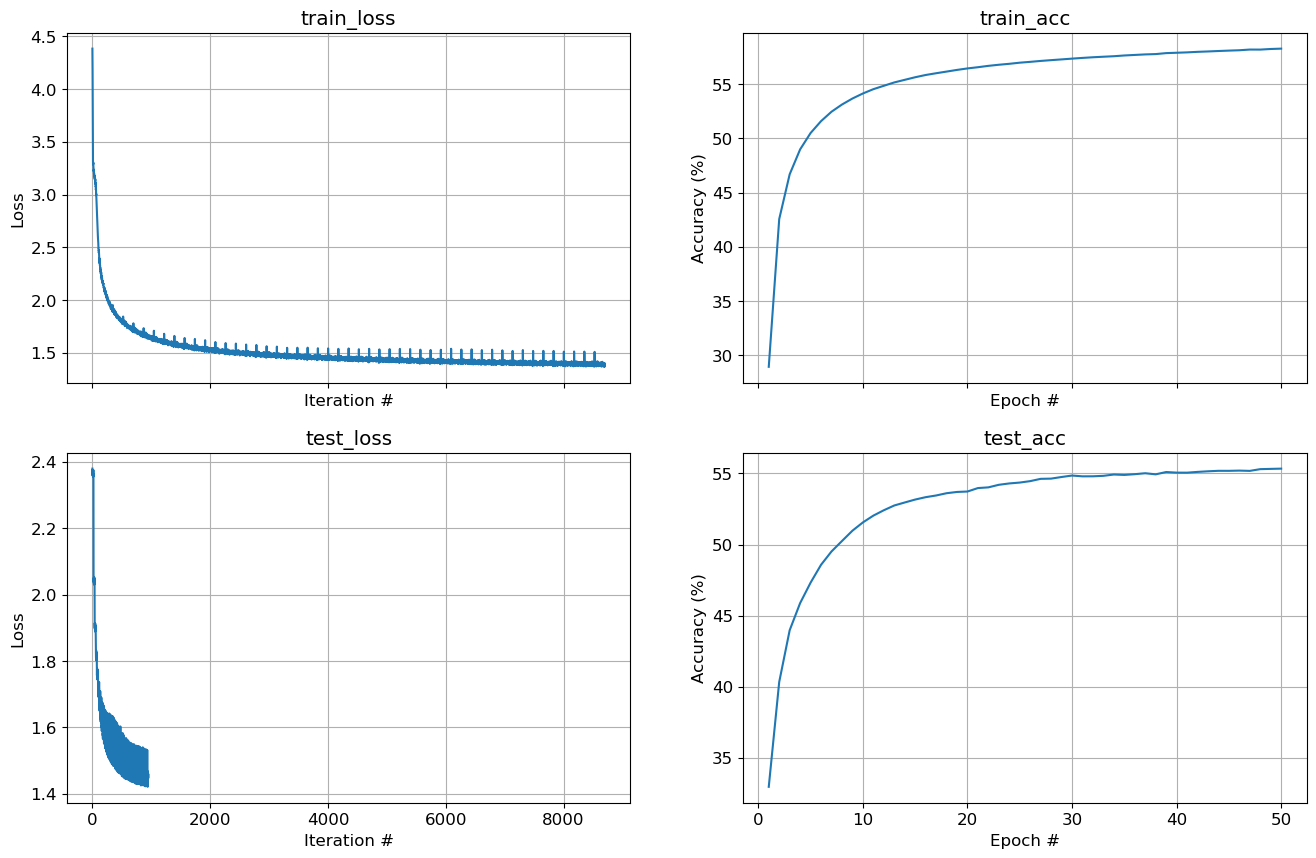

In [20]:
from cs236781.plot import plot_fit

def post_epoch_fn(epoch, train_res, test_res, verbose):
    # Update learning rate
    scheduler.step(test_res.accuracy)
    # Sample from model to show progress
    if verbose:
        start_seq = "ACT I."
        generated_sequence = charnn.generate_from_model(
            model, start_seq, 100, (char_to_idx,idx_to_char), T=0.5
        )
        print(generated_sequence)

# Train, unless final checkpoint is found
checkpoint_file_final = f'{checkpoint_file}_final.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:
        # Print pre-training sampling
        print(charnn.generate_from_model(model, "ACT I.", 100, (char_to_idx,idx_to_char), T=0.5))

        fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=None,
                              post_epoch_fn=post_epoch_fn, early_stopping=early_stopping,
                              checkpoints=checkpoint_file, print_every=1)
        
        fig, axes = plot_fit(fit_res)
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

### Generating a work of art
<a id=part1_8></a>

Armed with our fully trained model, let's generate the next Hamlet! You should experiment with modifying the sampling temperature and see what happens.

The text you generate should “look” like a Shakespeare play:
old-style English words and sentence structure, directions for the actors
(like “Exit/Enter”), sections (Act I/Scene III) etc.
There will be no coherent plot of course, but it should at least seem like
a Shakespearean play when not looking too closely.
If this is not what you see, go back, debug and/or and re-train.

**TODO**: Specify the generation parameters in the `part1_generation_params()` function within the `hw3/answers.py` module.

In [21]:
from hw3.answers import part1_generation_params

start_seq, temperature = part1_generation_params()

generated_sequence = charnn.generate_from_model(
    model, start_seq, 10000, (char_to_idx,idx_to_char), T=temperature
)

print(generated_sequence)

ACT I.

                                     Enter LUCIUS, ANTONIO

  LADY MACBETH. O my country Lord Flosenine of God
    Which is it end and discourse of the foul come in the thing.
    And you see the earth and winds in what
    I pray you prove the bride the present word.
    I say the first and prove the son of my deposed of her.
    The more courtesy that have seen them to again;
    And that he is a son, as the way to the
    with the honour black that so was for his service.
                                                               [Exit,
That I cannot thank him and heart the word,
This come and his hand to me bear them
To fall of death and an hour and with the way,
For the sail of the father with him with her to be the
    consust of crown be the common words and
To friend of a strong made of the souls and makes thee
  The incalst and the poor conceived short, and I have been
The traitors are not a fair such a wearing of the more to carry
The curp of a corn of down that I

## Questions
<a id=part1_9></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [22]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1
Why do we split the corpus into sequences instead of training on the whole text?

In [23]:
display_answer(hw3.answers.part1_q1)


**Your answer:**



### Question 2
How is it possible that the generated text clearly shows memory longer than the sequence length?

In [24]:
display_answer(hw3.answers.part1_q2)


**Your answer:**



### Question 3
Why are we not shuffling the order of batches when training?

In [25]:
display_answer(hw3.answers.part1_q3)


**Your answer:**



### Question 4
1. Why do we lower the temperature for sampling (compared to the default of $1.0$)?
2. What happens when the temperature is very high and why?
3. What happens when the temperature is very low and why?

In [26]:
display_answer(hw3.answers.part1_q4)


**Your answer:**


